In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## Setup environment

In [2]:
# Verifica e instala MONAI, matplotlib y torch si es necesario
!python -c "import monai" || pip install -q "monai[all]"  # Instala la versión completa de MONAI, que incluye dependencias
!python -c "import torch" || pip install -q torch         # Verifica si torch está instalado, e instálalo si no lo está
!python -c "import matplotlib" || pip install -q matplotlib

%matplotlib inline

2025-01-15 08:22:53.905710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736929373.939948  182174 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736929373.950470  182174 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import monai
print(dir(monai.networks.nets))
print(monai.__version__)

/mnt/nfs/home/liglesias/anaconda3/envs/cardio/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-15 08:23:12.852932: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736929392.887371  182122 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736929392.897901  182122 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


['AHNet', 'AHnet', 'Ahnet', 'AttentionUnet', 'AutoEncoder', 'AutoencoderKL', 'BasicUNet', 'BasicUNetPlusPlus', 'BasicUnet', 'BasicUnetPlusPlus', 'Basicunet', 'BasicunetPlusPlus', 'BertAttention', 'BertMixedLayer', 'BertOutput', 'BertPreTrainedModel', 'BlockArgs', 'Classifier', 'ControlNet', 'Critic', 'DAF3D', 'DecoderOnlyTransformer', 'DenseNet', 'DenseNet121', 'DenseNet169', 'DenseNet201', 'DenseNet264', 'Densenet', 'Densenet121', 'Densenet169', 'Densenet201', 'Densenet264', 'DiNTS', 'DiffusionModelUNet', 'Discriminator', 'DynUNet', 'DynUnet', 'Dynunet', 'EfficientNet', 'EfficientNetBN', 'EfficientNetBNFeatures', 'EfficientNetEncoder', 'FLEXUNET_BACKBONE', 'FlexUNet', 'FlexUNetEncoderRegister', 'FlexibleUNet', 'FullyConnectedNet', 'Generator', 'GlobalNet', 'HighResBlock', 'HighResNet', 'HoVerNet', 'HoVernet', 'HoverNet', 'Hovernet', 'LocalNet', 'MILModel', 'MedNeXt', 'MedNeXtB', 'MedNeXtL', 'MedNeXtLarge', 'MedNeXtM', 'MedNeXtMedium', 'MedNeXtS', 'MedNeXtSmall', 'MedNext', 'MedNextB',

## Setup imports

In [4]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import nibabel as nib
from nibabel.orientations import axcodes2ornt, ornt_transform
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import Dataset, DataLoader
from monai.networks.layers import Act
from monai.utils import first, set_determinism
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityRanged
#from torch.amp import autocast
#from torch.cuda.amp import autocast
from torch.amp import autocast
from monai.networks.nets import AutoencoderKL, PatchDiscriminator
# from generative.networks.nets import AutoencoderKL, PatchDiscriminator
from monai.losses import PatchAdversarialLoss, PerceptualLoss
from monai.utils.misc import ensure_tuple
print_config()

MONAI version: 1.5.dev2447
Numpy version: 1.26.4
Pytorch version: 2.5.1+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 2d6751b01bf78fddabe03b2c53645c6bc9808ed8
MONAI __file__: /mnt/nfs/home/<username>/anaconda3/envs/cardio/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.0
Nibabel version: 5.3.2
scikit-image version: 0.24.0
scipy version: 1.14.1
Pillow version: 11.0.0
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.20.1+cu124
tqdm version: 4.67.1
lmdb version: 1.5.1
psutil version: 5.9.0
pandas version: 2.2.3
einops version: 0.8.0
transformers version: 4.40.2
mlflow version: 2.18.0
pynrrd version: 1.1.1
clearml version: 1.16.5

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [5]:
#root_dir = r"C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database"
#root_dir = '/mnt/nfs/home/liglesias/data_tgv'
#root_dir = '//atlas.bit.upm.es/BIT-UPM-projects/CARDIO-HULP/SCRATCH_STUDENTS/liglesias/data_acdc'

root_dir = '/mnt/nfs/home/liglesias/data_acdc'

training_dir = os.path.join(root_dir, "masks_training")
testing_dir = os.path.join(root_dir, "masks_testing")
training_dir_noise = os.path.join(root_dir, "masks_training_noise")
testing_dir_noise = os.path.join(root_dir, "masks_testing_noise")
training_dir_sphere = os.path.join(root_dir, "masks_training_sphere")
testing_dir_sphere = os.path.join(root_dir, "masks_testing_sphere")
training_dir_sphere_2 = os.path.join(root_dir, "masks_training_sphere_2")
testing_dir_sphere_2 = os.path.join(root_dir, "masks_testing_sphere_2")
training_dir_sphere_3 = os.path.join(root_dir, "masks_training_dilation")
testing_dir_sphere_3 = os.path.join(root_dir, "masks_testing_dilation")
training_dir_elongated = os.path.join(root_dir, "masks_training_noise_2")
testing_dir_elongated = os.path.join(root_dir, "masks_testing_noise_2")

assert os.path.exists(training_dir), f"El directorio {training_dir} no existe"
assert os.path.exists(testing_dir), f"El directorio {testing_dir} no existe"
assert os.path.exists(training_dir_noise), f"El directorio {training_dir_noise} no existe"
assert os.path.exists(testing_dir_noise), f"El directorio {testing_dir_noise} no existe"
assert os.path.exists(training_dir_sphere), f"El directorio {training_dir_sphere} no existe"
assert os.path.exists(testing_dir_sphere), f"El directorio {testing_dir_sphere} no existe"
assert os.path.exists(training_dir_sphere_2), f"El directorio {training_dir_sphere_2} no existe"
assert os.path.exists(testing_dir_sphere_2), f"El directorio {testing_dir_sphere_2} no existe"
assert os.path.exists(training_dir_sphere_3), f"El directorio {training_dir_sphere_3} no existe"
assert os.path.exists(testing_dir_sphere_3), f"El directorio {testing_dir_sphere_3} no existe"
assert os.path.exists(training_dir_elongated), f"El directorio {training_dir_elongated} no existe"
assert os.path.exists(testing_dir_elongated), f"El directorio {testing_dir_elongated} no existe"

def list_nifti_files(directory):
    nifti_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".nii") or file.endswith(".nii.gz"):
                nifti_files.append(os.path.join(root, file))
    return nifti_files

training_files = list_nifti_files(training_dir)
testing_files = list_nifti_files(testing_dir)
training_files_noise = list_nifti_files(training_dir_noise)
testing_files_noise = list_nifti_files(testing_dir_noise)
training_files_sphere = list_nifti_files(training_dir_sphere)
testing_files_sphere = list_nifti_files(testing_dir_sphere)
training_files_sphere_2 = list_nifti_files(training_dir_sphere_2)
testing_files_sphere_2 = list_nifti_files(testing_dir_sphere_2)
training_files_sphere_3 = list_nifti_files(training_dir_sphere_3)
testing_files_sphere_3 = list_nifti_files(testing_dir_sphere_3)
training_files_elongated = list_nifti_files(training_dir_elongated)
testing_files_elongated = list_nifti_files(testing_dir_elongated)

print(f"Se encontraron {len(training_files)} archivos en {training_dir}")
print(f"Se encontraron {len(testing_files)} archivos en {testing_dir}")
print(f"Se encontraron {len(training_files_noise)} archivos en {training_files_noise}")
print(f"Se encontraron {len(testing_files_noise)} archivos en {testing_dir_noise}")
print(f"Se encontraron {len(training_files_sphere)} archivos en {training_files_sphere}")
print(f"Se encontraron {len(testing_files_sphere)} archivos en {testing_dir_sphere}")
print(f"Se encontraron {len(training_files_sphere_2)} archivos en {training_files_sphere_2}")
print(f"Se encontraron {len(testing_files_sphere_2)} archivos en {testing_dir_sphere_2}")
print(f"Se encontraron {len(training_files_sphere_3)} archivos en {training_files_sphere_3}")
print(f"Se encontraron {len(testing_files_sphere_3)} archivos en {testing_dir_sphere_3}")
print(f"Se encontraron {len(training_files_elongated)} archivos en {training_files_elongated}")
print(f"Se encontraron {len(testing_files_elongated)} archivos en {testing_files_elongated}")

Se encontraron 200 archivos en /mnt/nfs/home/liglesias/data_acdc/masks_training
Se encontraron 100 archivos en /mnt/nfs/home/liglesias/data_acdc/masks_testing
Se encontraron 200 archivos en ['/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient001_frame12_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient002_frame01_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient002_frame12_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient003_frame01_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient004_frame15_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient005_frame01_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient005_frame13_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient006_frame16_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient007_frame01_gt.nii.gz', '/mnt/nfs/home/liglesias/d

(216, 256, 10)
(232, 256, 10)
(232, 256, 10)
(256, 256, 10)
(232, 256, 10)


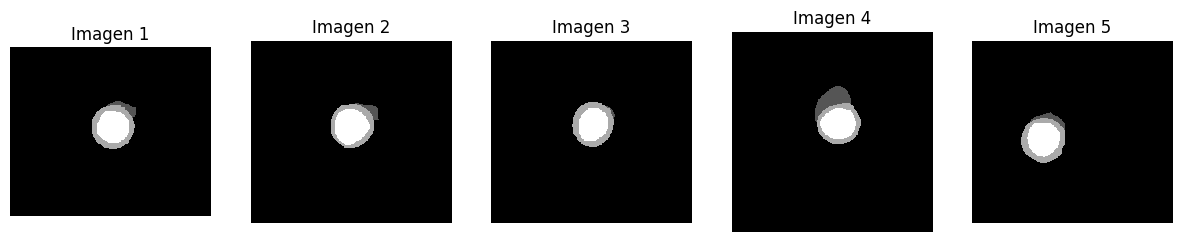

In [6]:
images = [nib.load(file).get_fdata() for file in training_files[:5]] 
fig, axs = plt.subplots(1, len(images), figsize=(15, 5))

for i, img in enumerate(images):
    axs[i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation='none') 
    axs[i].axis("off") 
    axs[i].set_title(f"Imagen {i+1}")
    print(img.shape)
plt.show()

(216, 256, 10)
(232, 256, 10)
(232, 256, 10)
(256, 256, 10)
(232, 256, 10)


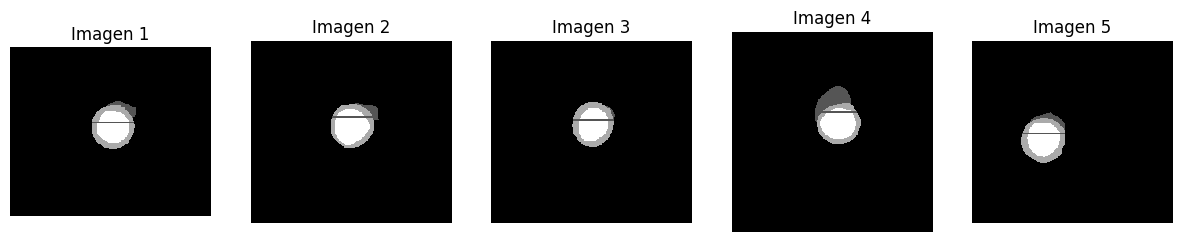

In [7]:
images_noise = [nib.load(file).get_fdata() for file in training_files_noise[:5]] 
fig, axs = plt.subplots(1, len(images_noise), figsize=(15, 5))

for i, img in enumerate(images_noise):
    axs[i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation='none') 
    axs[i].axis("off") 
    axs[i].set_title(f"Imagen {i+1}")
    print(img.shape)
plt.show()

(216, 256, 10)
(232, 256, 10)
(232, 256, 10)
(256, 256, 10)
(232, 256, 10)


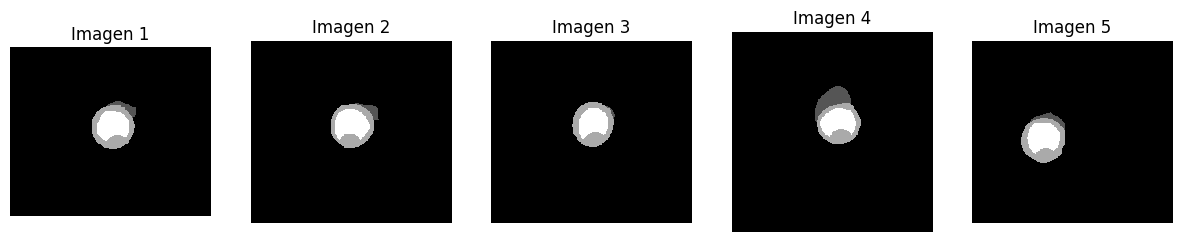

In [8]:
images_sphere = [nib.load(file).get_fdata() for file in training_files_sphere[:5]] 
fig, axs = plt.subplots(1, len(images_sphere), figsize=(15, 5))

for i, img in enumerate(images_sphere):
    axs[i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation='none') 
    axs[i].axis("off") 
    axs[i].set_title(f"Imagen {i+1}")
    print(img.shape)
plt.show()

(216, 256, 10)
(232, 256, 10)
(232, 256, 10)
(256, 216, 10)
(222, 224, 10)


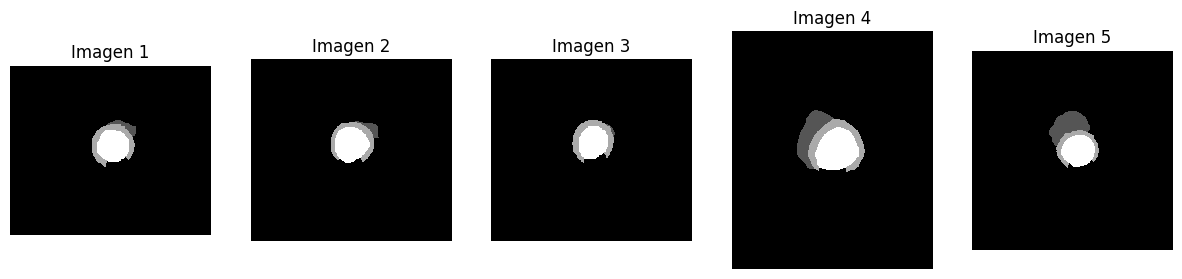

In [9]:
images_sphere_2 = [nib.load(file).get_fdata() for file in training_files_sphere_2[:5]] 
fig, axs = plt.subplots(1, len(images_sphere_2), figsize=(15, 5))

for i, img in enumerate(images_sphere_2):
    axs[i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation='none') 
    axs[i].axis("off") 
    axs[i].set_title(f"Imagen {i+1}")
    print(img.shape)
plt.show()

(216, 256, 10)
(232, 256, 10)
(232, 256, 10)
(256, 216, 10)
(222, 224, 10)


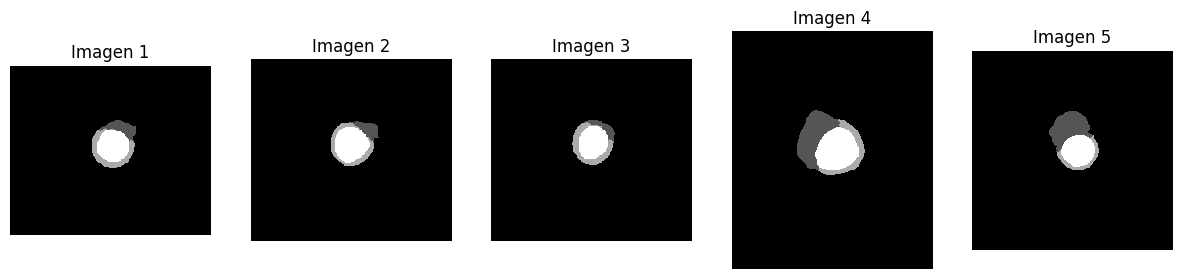

In [10]:
images_sphere_3 = [nib.load(file).get_fdata() for file in training_files_sphere_3[:5]] 
fig, axs = plt.subplots(1, len(images_sphere_3), figsize=(15, 5))

for i, img in enumerate(images_sphere_3):
    axs[i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation='none') 
    axs[i].axis("off") 
    axs[i].set_title(f"Imagen {i+1}")
    print(img.shape)
plt.show()

In [11]:
all_files = training_files + testing_files
all_files_noise = training_files_noise + testing_files_noise
all_files_sphere = training_files_sphere + testing_files_sphere
all_files_sphere_2 = training_files_sphere_2 + testing_files_sphere_2
all_files_sphere_3 = training_files_sphere_3 + testing_files_sphere_3

images = [nib.load(file).get_fdata() for file in all_files]
images_noise = [nib.load(file).get_fdata() for file in all_files_noise]
images_sphere = [nib.load(file).get_fdata() for file in all_files_sphere]
image_shapes = [img.shape for img in images]
image_shapes_noise = [img.shape for img in images_noise]
image_shapes_sphere = [img.shape for img in images_sphere]
image_shapes_sphere_2 = [img.shape for img in images_sphere_2]
image_shapes_sphere_3 = [img.shape for img in images_sphere_3]
print(image_shapes)
print(image_shapes_noise)
print(image_shapes_sphere)
print(image_shapes_sphere_2)
print(image_shapes_sphere_3)
average_shape = np.mean(image_shapes, axis=0).astype(int)
average_shape_noise = np.mean(image_shapes_noise, axis=0).astype(int)
average_shape_sphere = np.mean(image_shapes_sphere, axis=0).astype(int)
average_shape_sphere_2 = np.mean(image_shapes_sphere_2, axis=0).astype(int)
average_shape_sphere_3 = np.mean(image_shapes_sphere_3, axis=0).astype(int)
print(f"Tamaño promedio: {average_shape}")
print(f"Tamaño promedio de las imágenes con ruido: {average_shape_noise}")
print(f"Tamaño promedio de las imágenes con esferas: {average_shape_sphere}")
print(f"Tamaño promedio de las imágenes con esferas: {average_shape_sphere_2}")
print(f"Tamaño promedio de las imágenes con esferas: {average_shape_sphere_3}")
min_shape = np.min(image_shapes, axis=0)
max_shape = np.max(image_shapes, axis=0)
min_shape_noise = np.min(image_shapes_noise, axis=0)
max_shape_noise = np.max(image_shapes_noise, axis=0)
min_shape_sphere = np.min(image_shapes_sphere, axis=0)
max_shape_sphere = np.max(image_shapes_sphere, axis=0)
min_shape_sphere_2 = np.min(image_shapes_sphere_2, axis=0)
max_shape_sphere_2 = np.max(image_shapes_sphere_2, axis=0)
min_shape_sphere_3 = np.min(image_shapes_sphere_3, axis=0)
max_shape_sphere_3 = np.max(image_shapes_sphere_3, axis=0)

print(f"Tamaño mínimo: {min_shape}")
print(f"Tamaño máximo: {max_shape}")
print(f"Tamaño mínimo: {min_shape_noise}")
print(f"Tamaño máximo: {max_shape_noise}")
print(f"Tamaño mínimo: {min_shape_sphere}")
print(f"Tamaño máximo: {max_shape_sphere}")
print(f"Tamaño mínimo: {min_shape_sphere_2}")
print(f"Tamaño máximo: {max_shape_sphere_2}")
print(f"Tamaño mínimo: {min_shape_sphere_3}")
print(f"Tamaño máximo: {max_shape_sphere_3}")

[(216, 256, 10), (232, 256, 10), (232, 256, 10), (256, 256, 10), (232, 256, 10), (256, 216, 10), (256, 216, 10), (232, 256, 11), (222, 224, 10), (222, 224, 10), (200, 256, 10), (208, 256, 10), (208, 256, 10), (184, 256, 10), (184, 256, 10), (216, 256, 10), (256, 216, 10), (256, 216, 10), (256, 216, 9), (216, 256, 9), (216, 256, 8), (208, 256, 8), (200, 256, 7), (200, 256, 7), (216, 256, 9), (216, 256, 9), (208, 256, 8), (208, 256, 8), (256, 256, 9), (216, 256, 10), (216, 256, 10), (224, 256, 10), (216, 256, 10), (216, 256, 10), (216, 256, 10), (240, 256, 10), (216, 256, 10), (216, 256, 10), (224, 256, 10), (208, 256, 13), (216, 256, 8), (216, 256, 7), (276, 384, 8), (276, 384, 8), (208, 256, 9), (208, 256, 10), (154, 224, 6), (232, 256, 9), (208, 256, 8), (208, 256, 8), (256, 216, 9), (256, 208, 9), (256, 208, 9), (256, 216, 7), (224, 256, 10), (216, 256, 8), (216, 256, 7), (428, 512, 8), (216, 256, 9), (216, 256, 9), (256, 216, 9), (216, 256, 9), (216, 256, 9), (256, 216, 10), (210, 2

## Set deterministic training for reproducibility

In [12]:
# for reproducibility purposes set a seed
set_determinism(42)

## Description of data, download the training set and creation of dataloaders

The brain tumour segmentation dataset is available as part of the Decathlon dataset. Select the channel (MRI contrast) you wish to use for training (0: FLAIR, 1: T1, 2: T1-PC, 3: T2). 
Note: The DecatholonDataset has 7GB. So make sure that you have enought space when running the next line

We use the following transforms:
1. `LoadImaged`: retrieve the nii image
2. `EnsureChannelFirstd`: we ensure that the channel component is in dimension 0 of the tensor
3. `Lambdad`: this custom transform retrieves the specific channel that we desire
4. `EnsureChannelFirstd`: we add the new channel dimension (as the last transform has removed it)

In [13]:
from monai.data import NibabelReader
from monai.transforms import CastToTyped

In [14]:
# PREPARACIÓN DE LA IMAGEN MÉDICA
# Carga las imágenes y se asegura de que la imagen cargada tenga el canal de color en la primera dimensión
# Aplica una transformación personalizada a la imagen y garantiza que la imagen tenga el canal en la primera dimensión
# Asegura que tenga el tipo de datos adecuado, reorienta la imagen a un sist de coord específico
# Recorta la imagen a un tamaño específico y escala la intensidad de la imagen

resize_dim = (12, 128, 128)

all_transforms = [
    transforms.LoadImaged(keys=["image"]),
    transforms.EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
    transforms.EnsureTyped(keys=["image"]),
    transforms.Orientationd(keys=["image"], axcodes="LPS"),
    # transforms.Orientationd(keys=["image"], axcodes="RAS"),
    transforms.Transposed(keys=["image"], indices=(0, 3, 2, 1)),
    transforms.AsDiscreted(keys=["image"], to_onehot=4),
    transforms.Resized(keys=["image"], spatial_size=resize_dim, mode=('nearest-exact')), 
]

In [15]:
train_data_dicts = [{"image": file} for file in training_files][0:1]
transform = Compose(all_transforms)
transform(train_data_dicts)[0]['image'].shape

torch.Size([4, 12, 128, 128])

In [16]:
train_data_dicts_noise = [{"image": file} for file in training_files_noise][0:1]
transform = Compose(all_transforms)
transform(train_data_dicts_noise)[0]['image'].shape

torch.Size([4, 12, 128, 128])

In [17]:
train_data_dicts_sphere = [{"image": file} for file in training_files_sphere][0:1]
transform = Compose(all_transforms)
transform(train_data_dicts_sphere)[0]['image'].shape

torch.Size([4, 12, 128, 128])

In [18]:
train_data_dicts_sphere_2 = [{"image": file} for file in training_files_sphere_2][0:1]
transform = Compose(all_transforms)
transform(train_data_dicts_sphere_2)[0]['image'].shape

torch.Size([4, 12, 128, 128])

In [19]:
train_data_dicts_sphere_3 = [{"image": file} for file in training_files_sphere_3][0:1]
transform = Compose(all_transforms)
transform(train_data_dicts_sphere_3)[0]['image'].shape

torch.Size([4, 12, 128, 128])

In [20]:
train_data_dicts_elongated = [{"image": file} for file in training_files_elongated][0:1]
transform = Compose(all_transforms)
transform(train_data_dicts_elongated)[0]['image'].shape

torch.Size([4, 12, 128, 128])

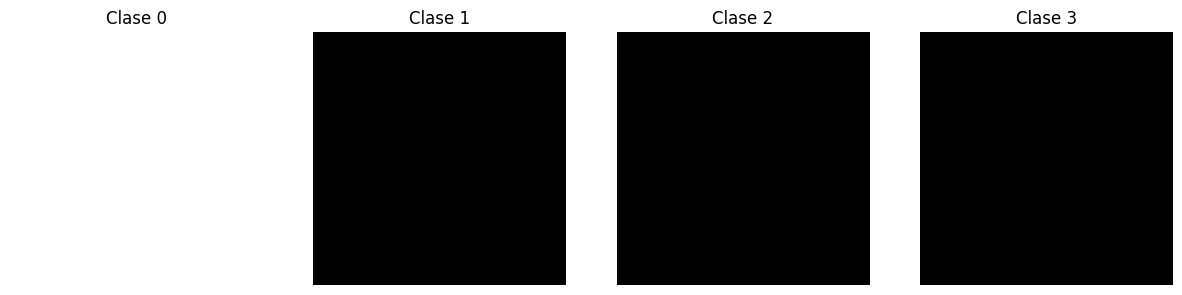

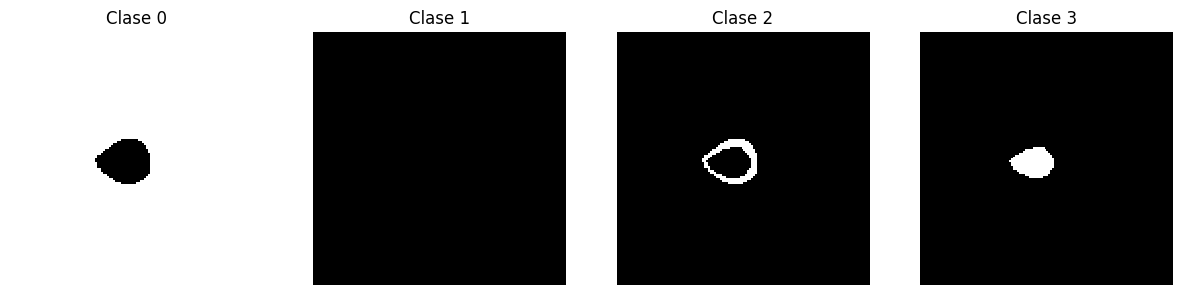

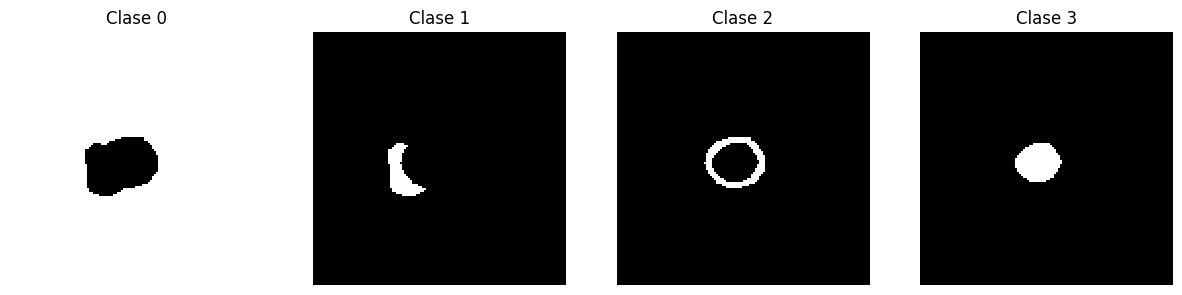

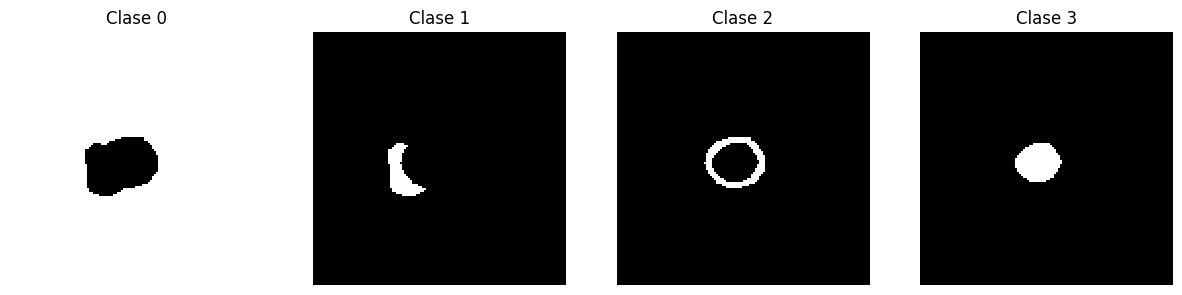

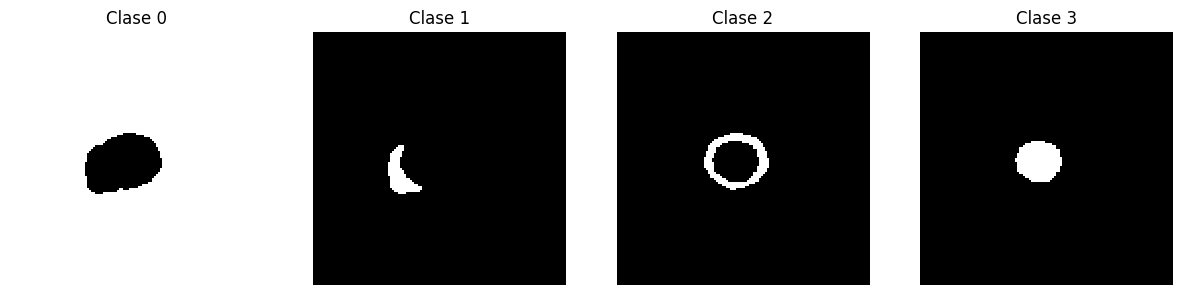

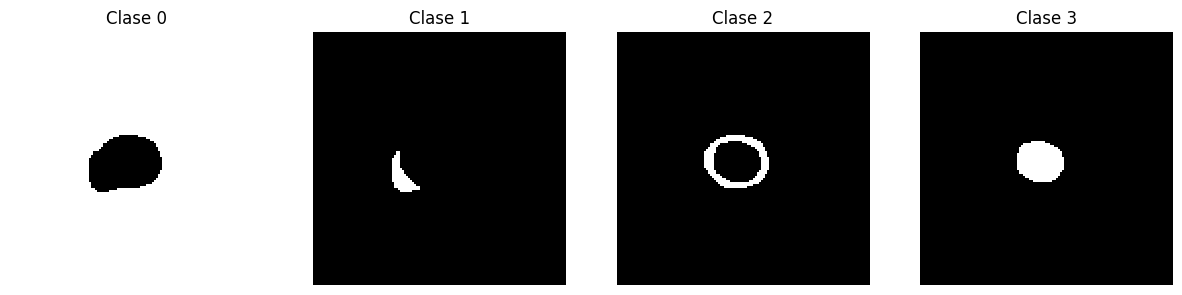

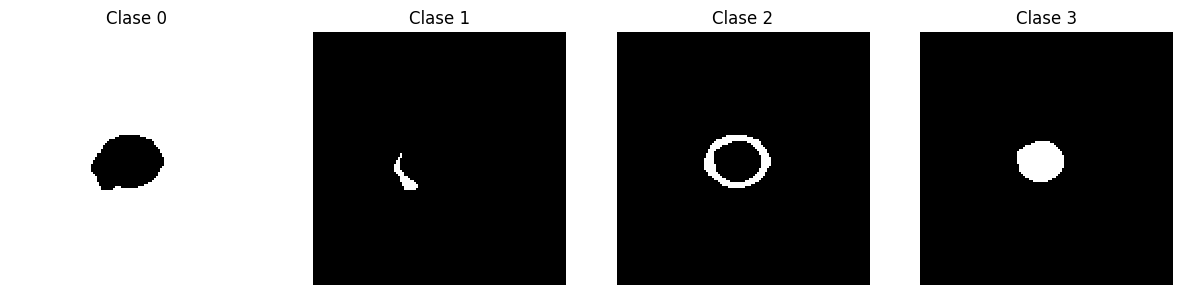

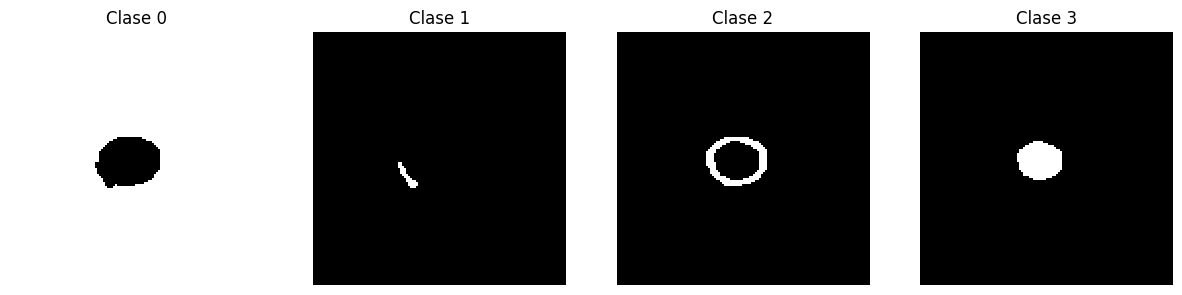

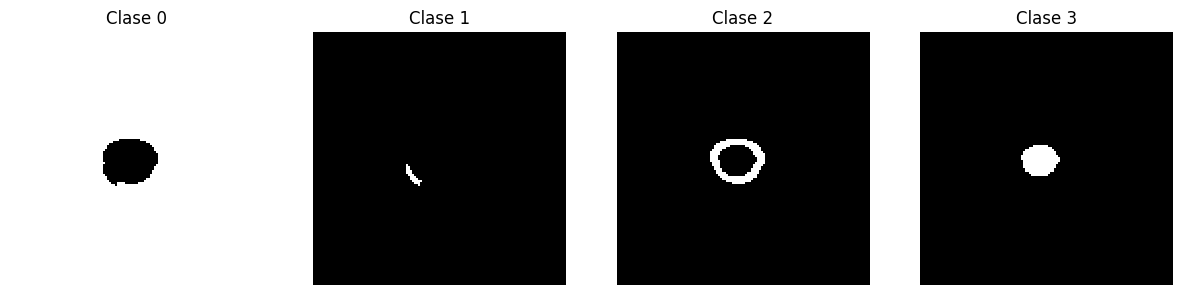

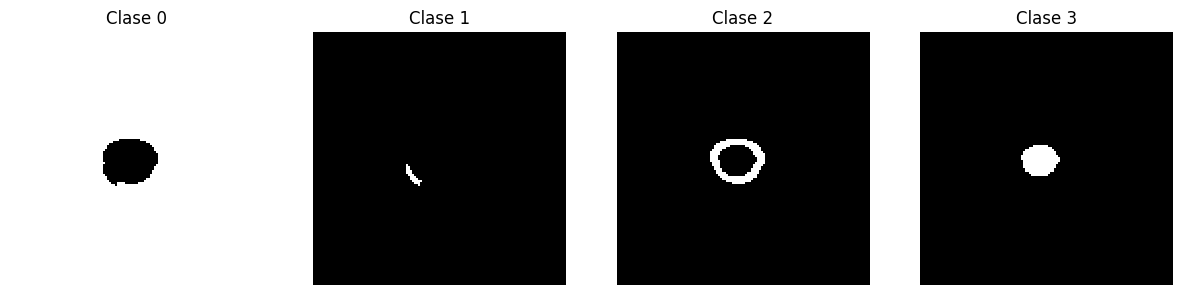

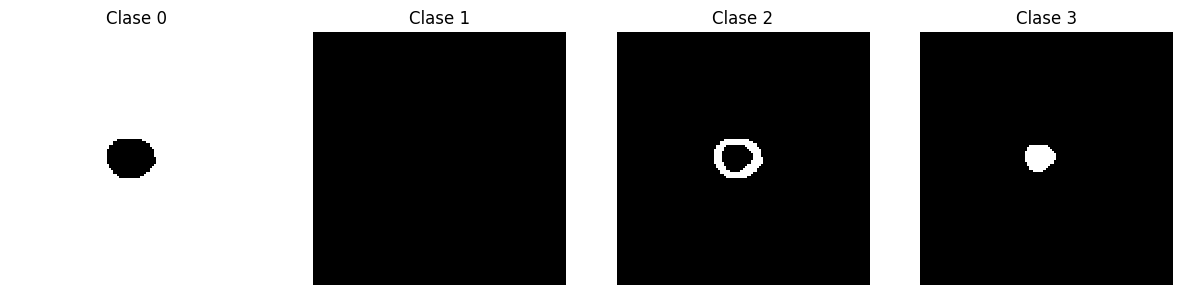

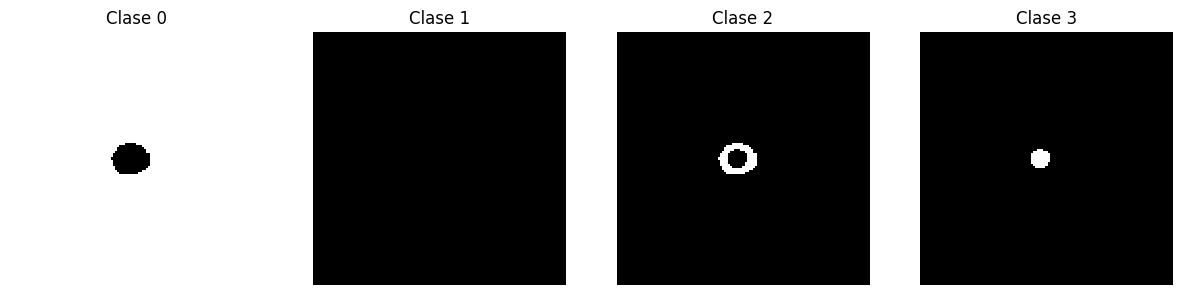

In [21]:
for j in range(12):
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    for i, ax in enumerate(axs):
        ax.imshow(transform(train_data_dicts)[0]['image'][i, j, :, :].numpy(), 
                  cmap='gray', interpolation='none', vmin=0, vmax=1)
        ax.axis('off')
        ax.set_title(f"Clase {i}")
    plt.show()

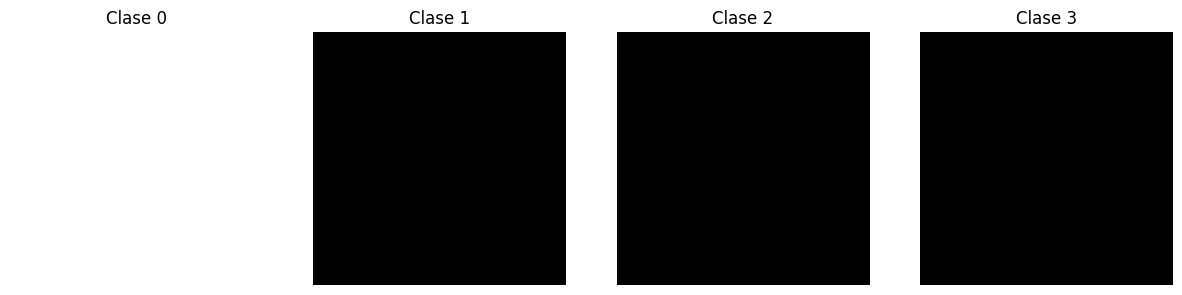

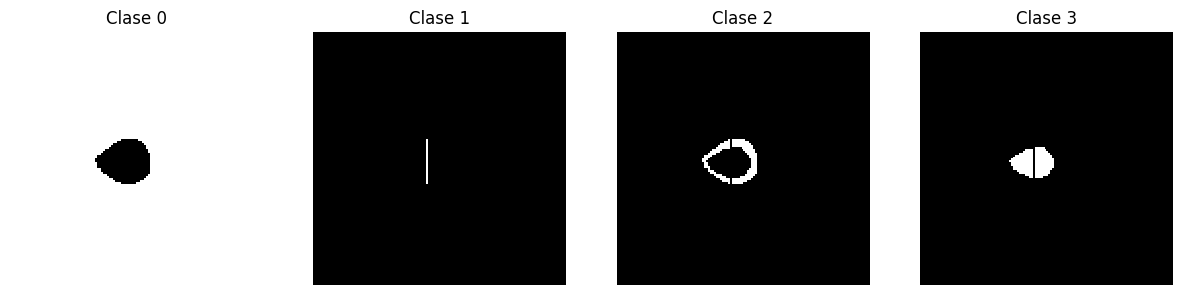

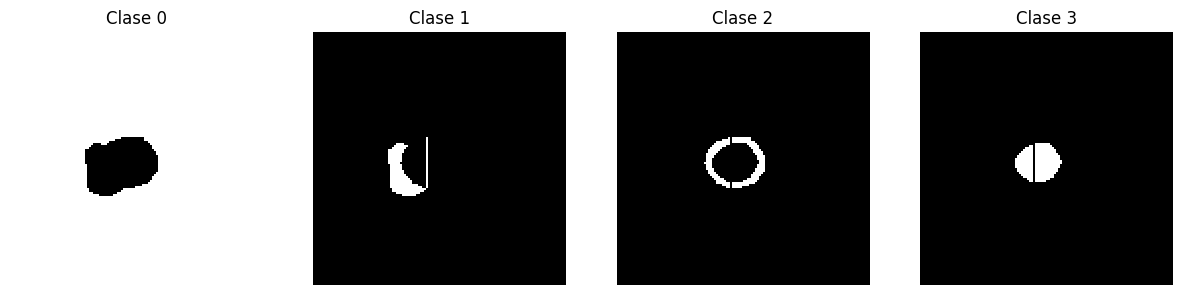

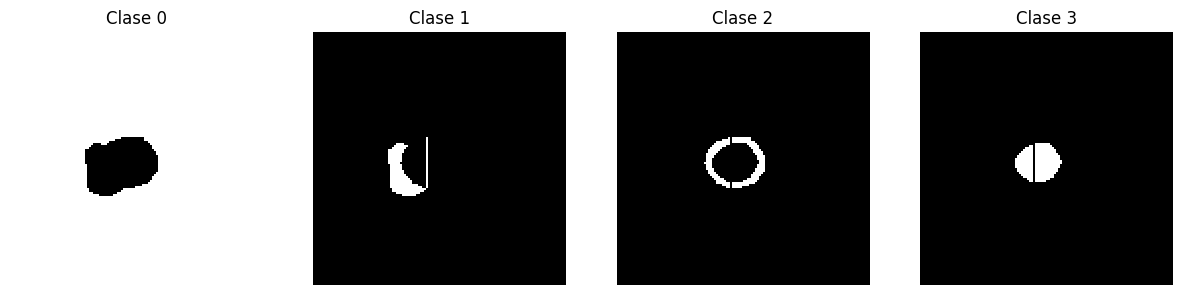

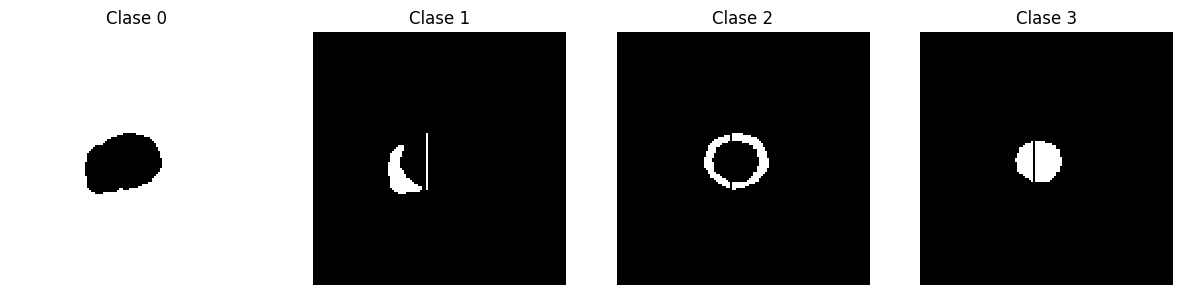

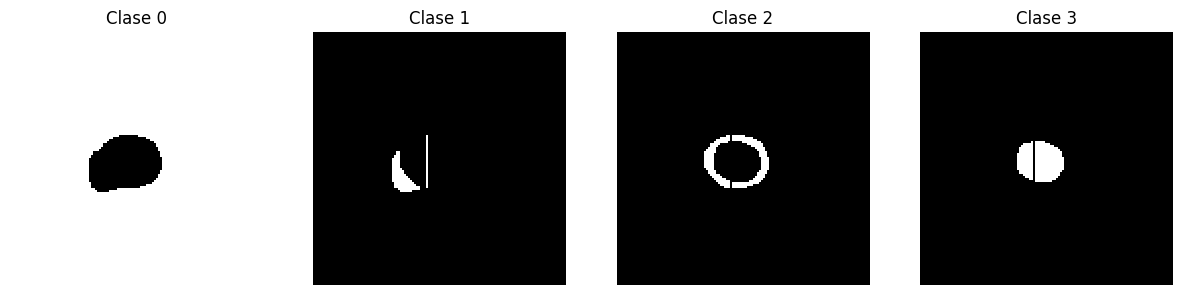

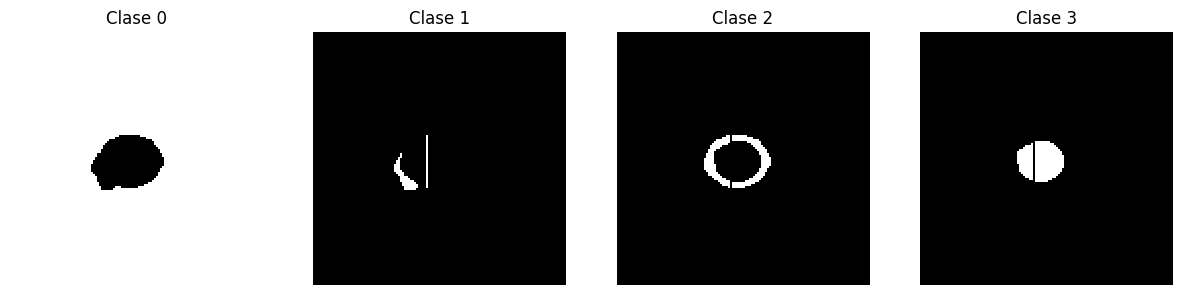

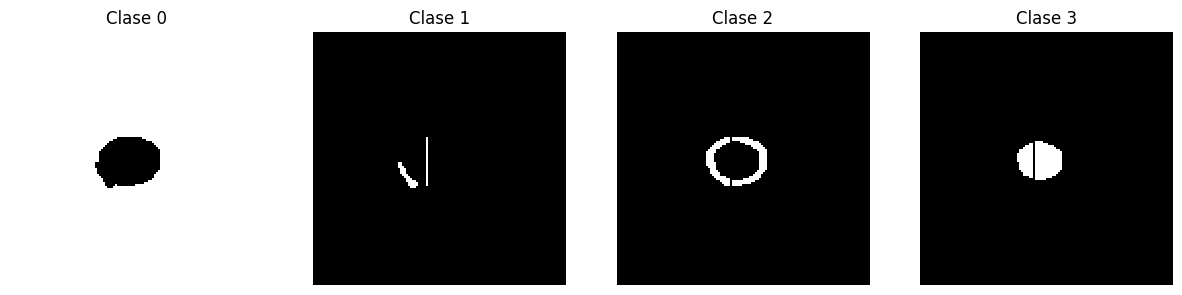

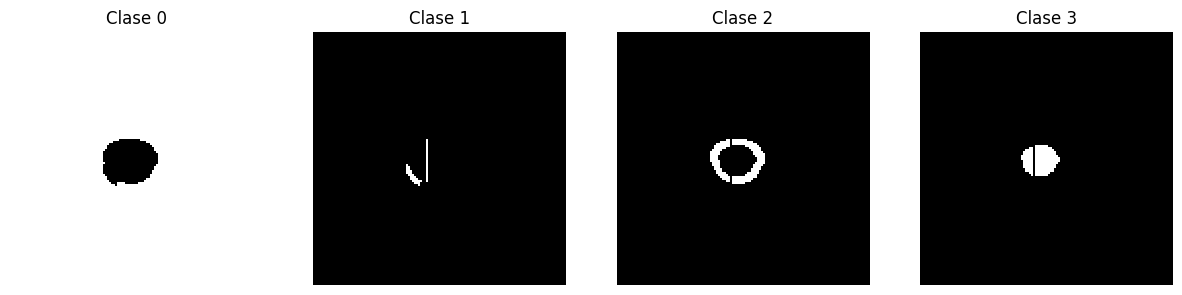

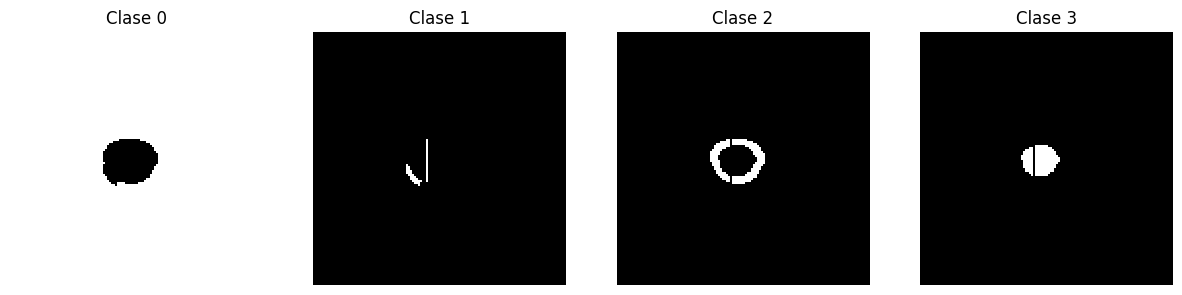

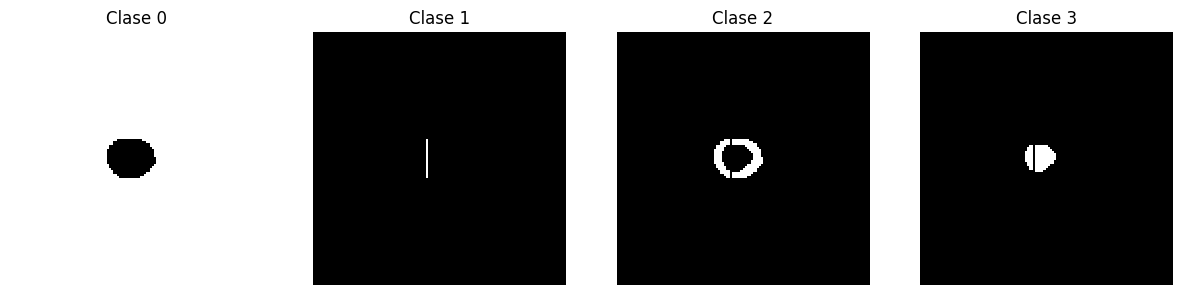

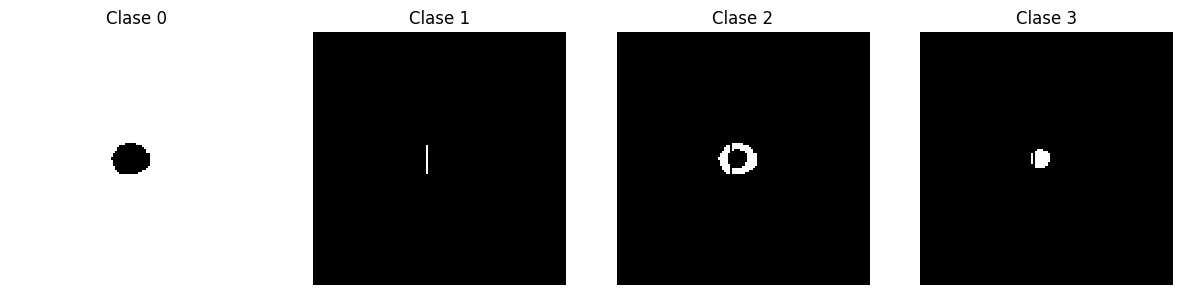

In [22]:
for j in range(12):
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    for i, ax in enumerate(axs):
        ax.imshow(transform(train_data_dicts_noise)[0]['image'][i, j, :, :].numpy(), 
                  cmap='gray', interpolation='none', vmin=0, vmax=1)
        ax.axis('off')
        ax.set_title(f"Clase {i}")
    plt.show()

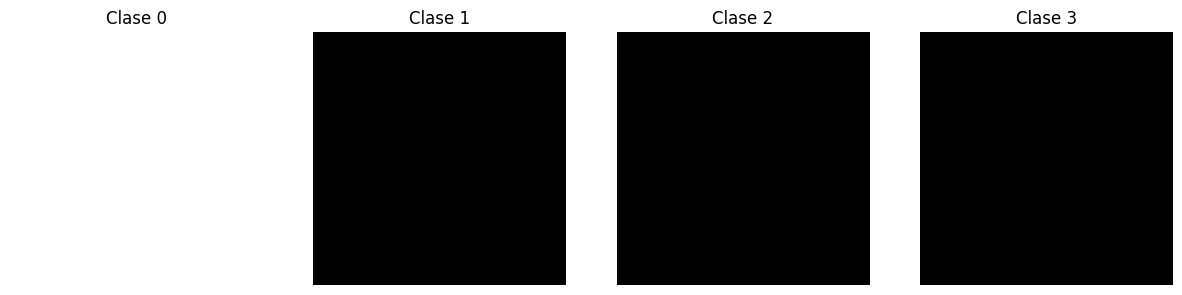

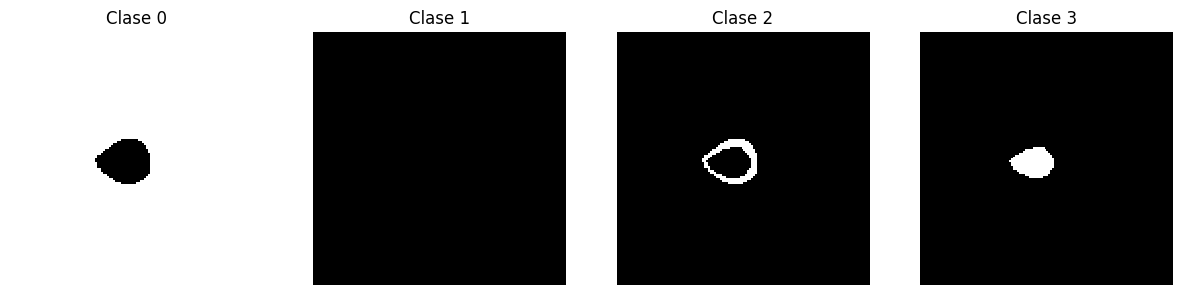

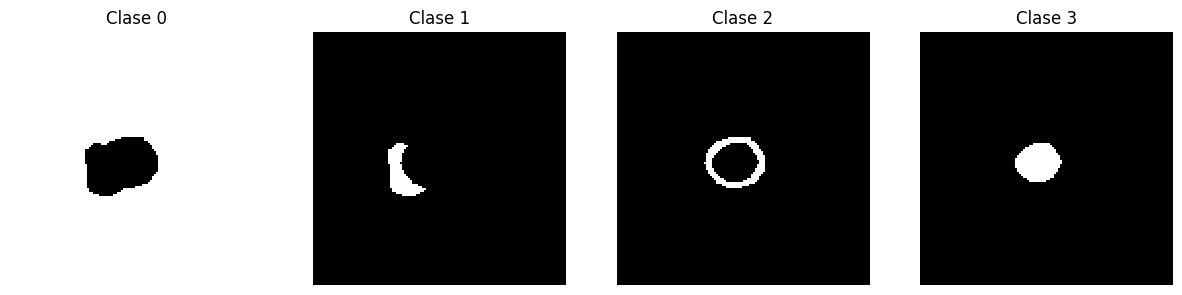

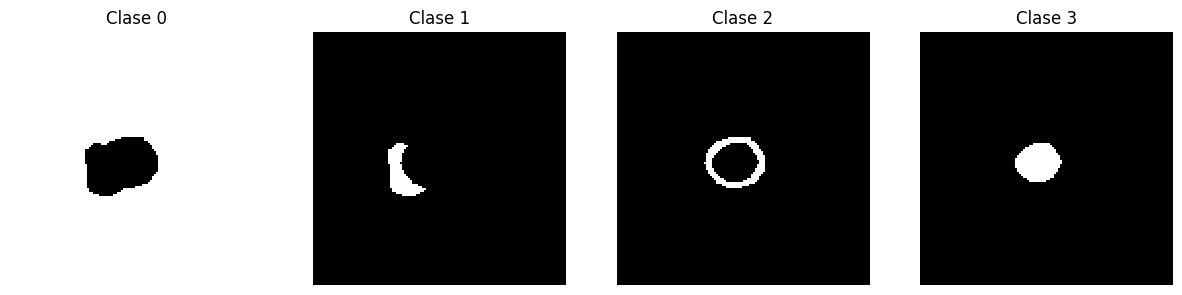

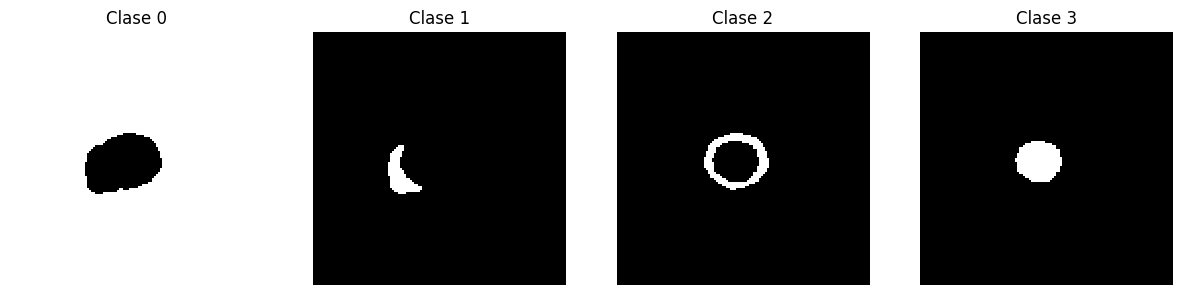

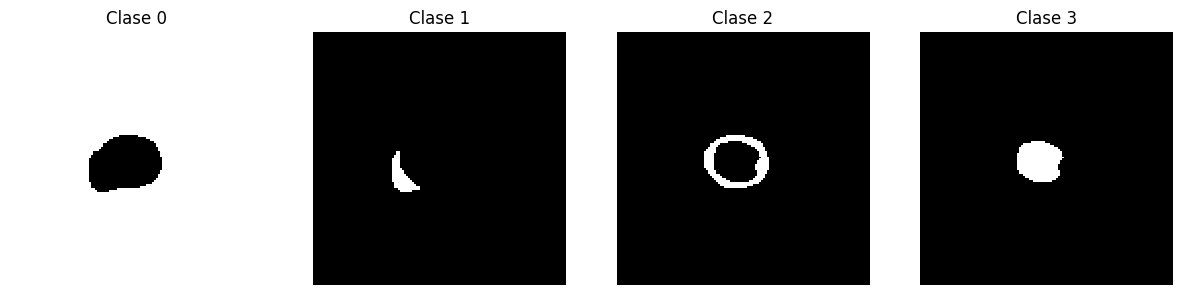

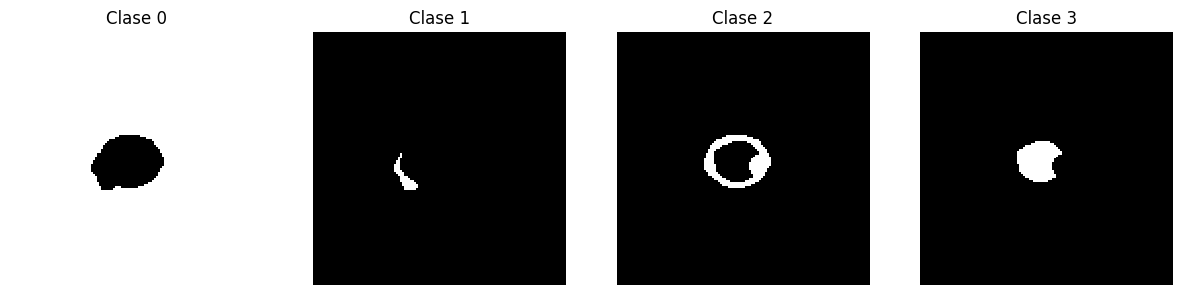

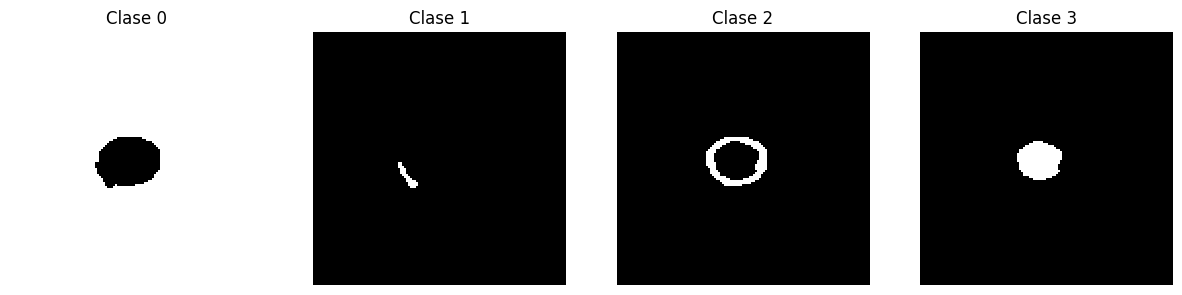

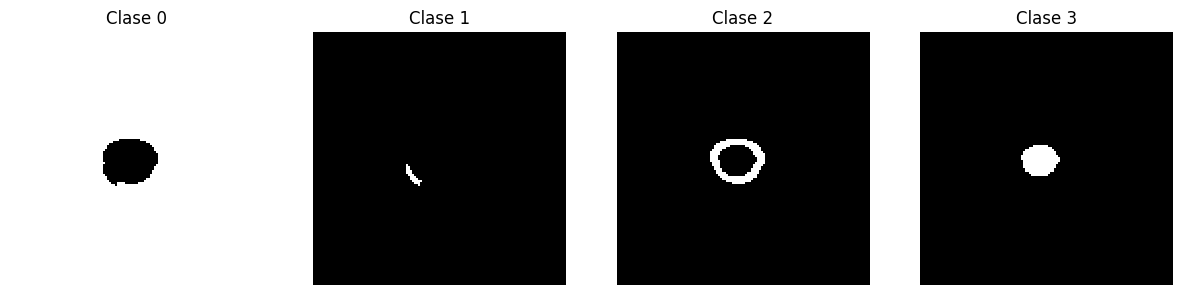

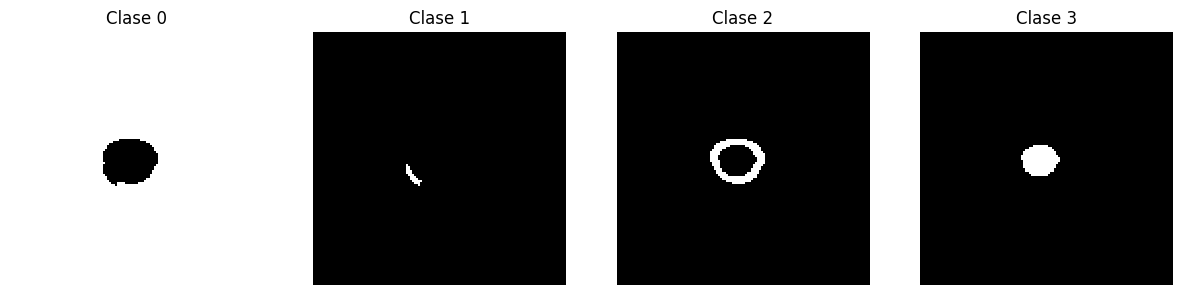

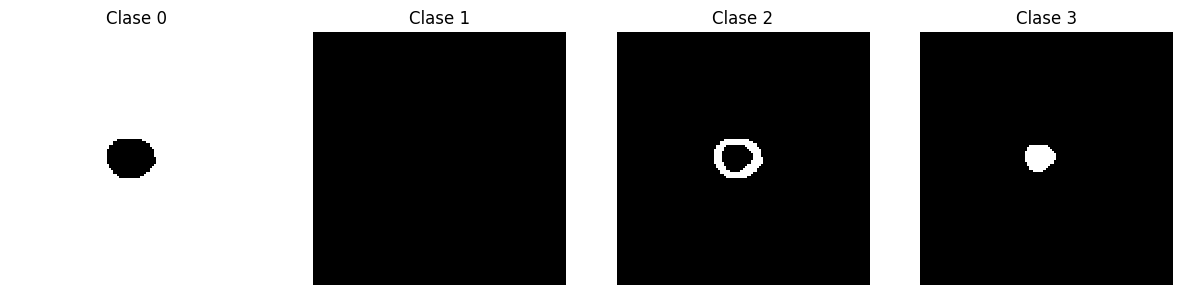

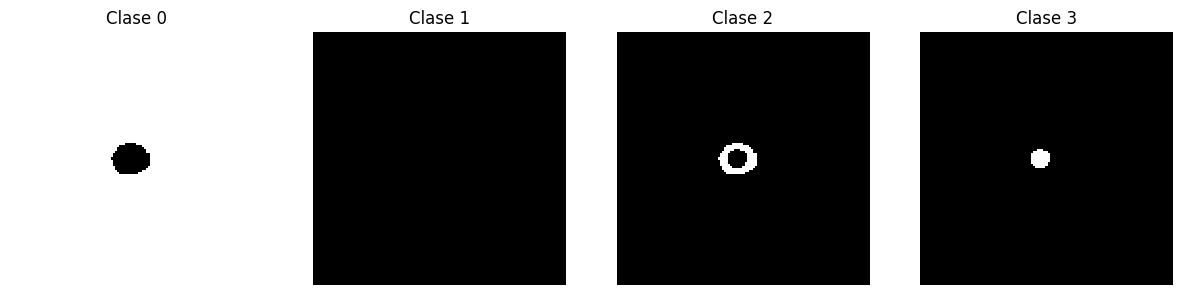

In [23]:
for j in range(12):
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    for i, ax in enumerate(axs):
        ax.imshow(transform(train_data_dicts_sphere)[0]['image'][i, j, :, :].numpy(), 
                  cmap='gray', interpolation='none', vmin=0, vmax=1)
        ax.axis('off')
        ax.set_title(f"Clase {i}")
    plt.show()

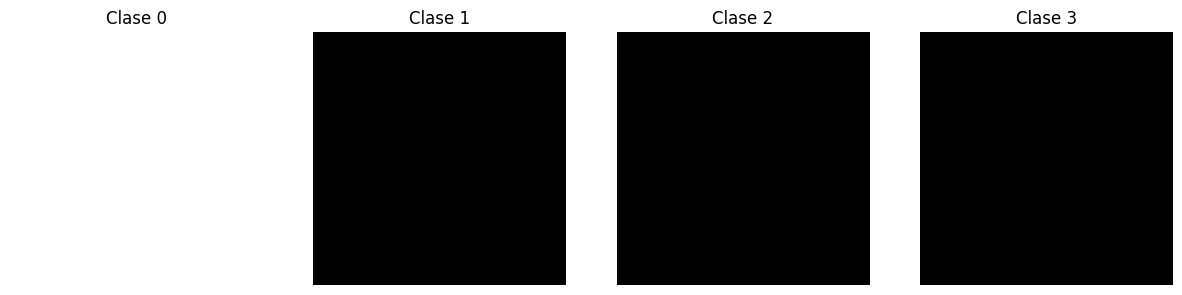

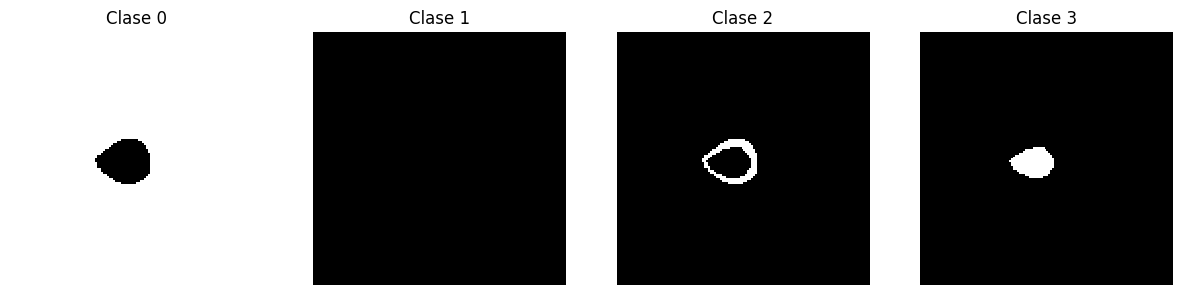

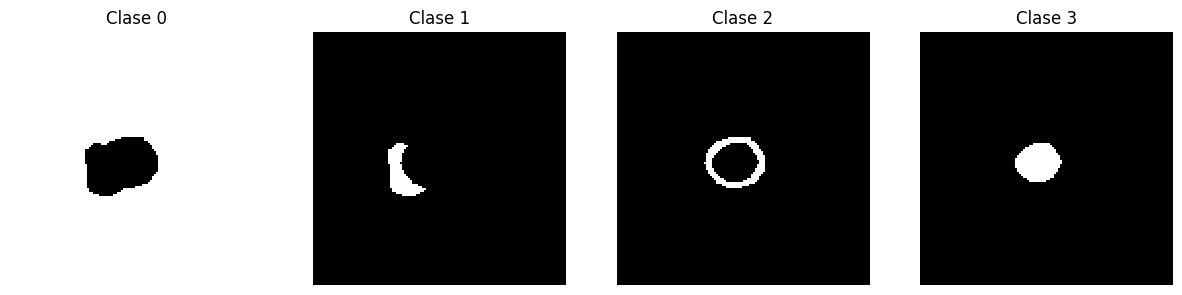

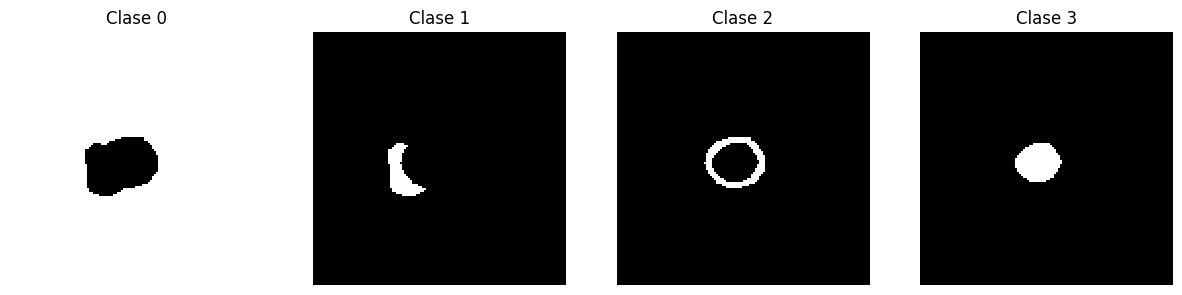

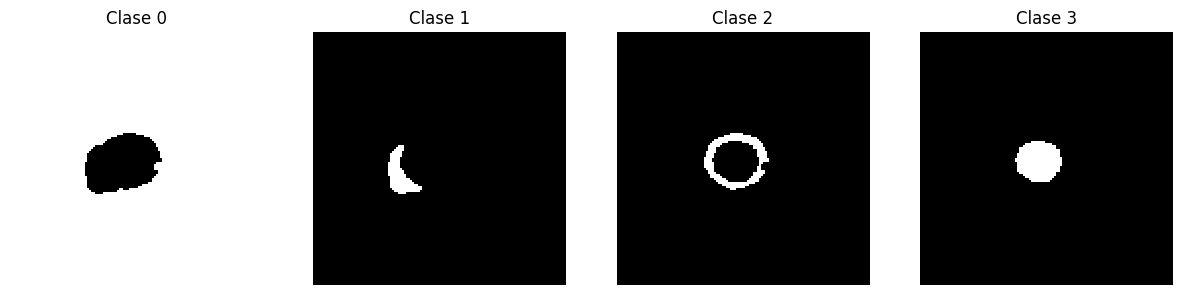

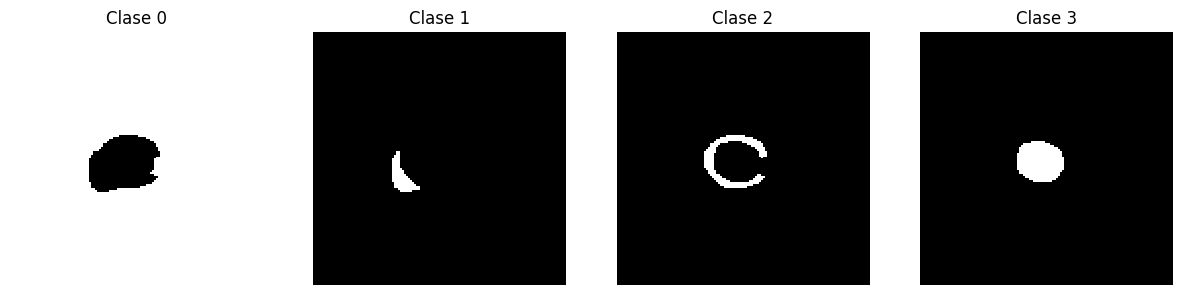

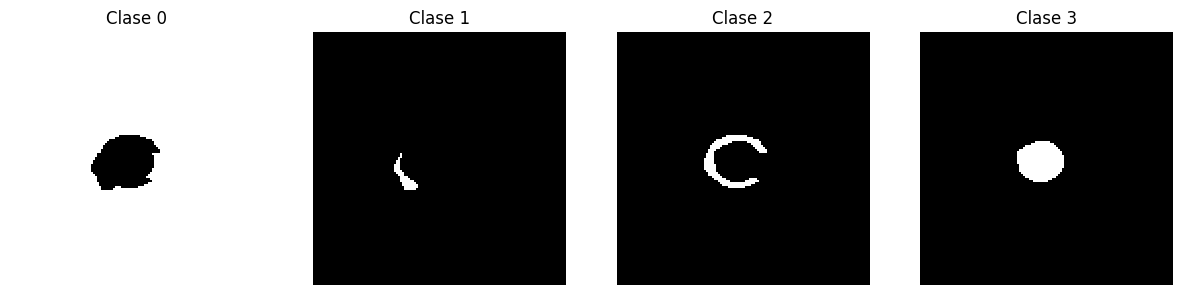

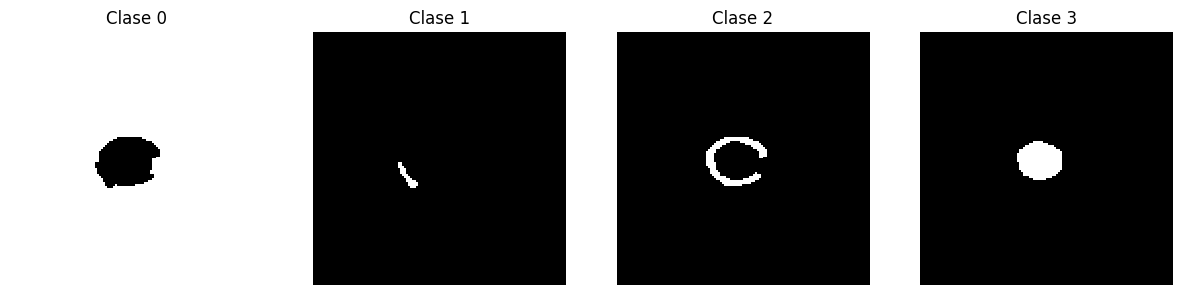

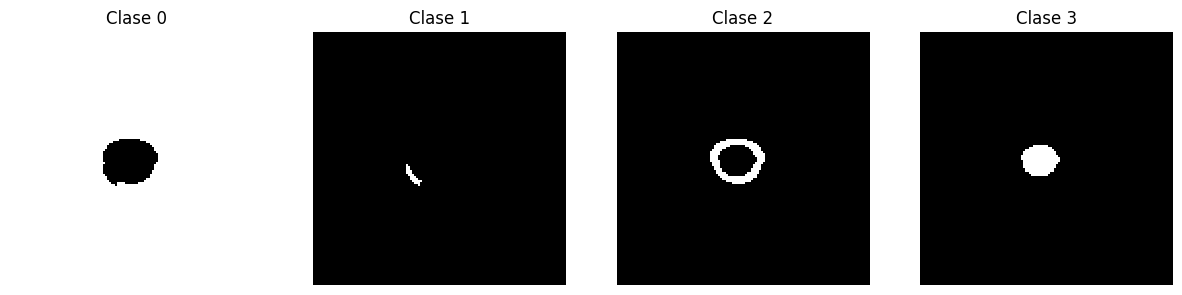

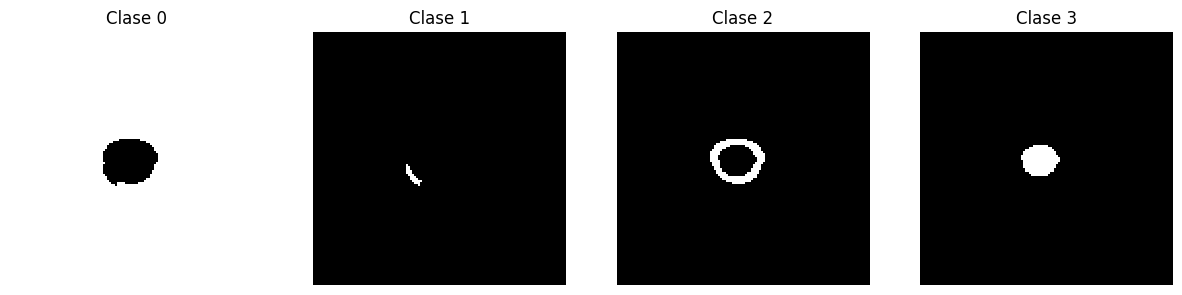

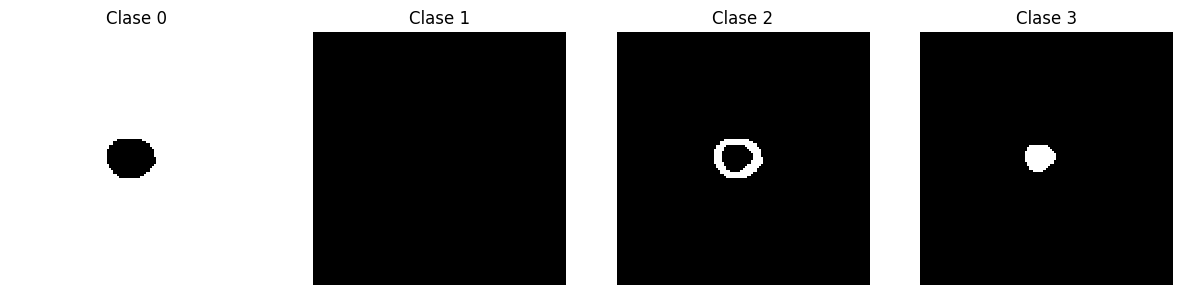

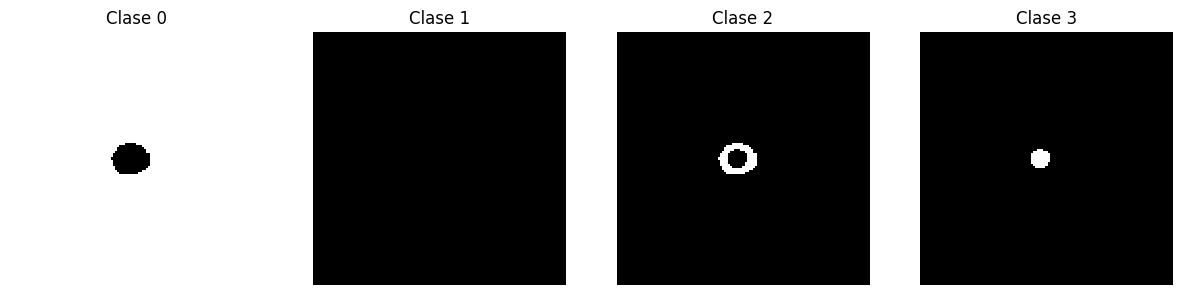

In [24]:
for j in range(12):
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    for i, ax in enumerate(axs):
        ax.imshow(transform(train_data_dicts_sphere_2)[0]['image'][i, j, :, :].numpy(), 
                  cmap='gray', interpolation='none', vmin=0, vmax=1)
        ax.axis('off')
        ax.set_title(f"Clase {i}")
    plt.show()

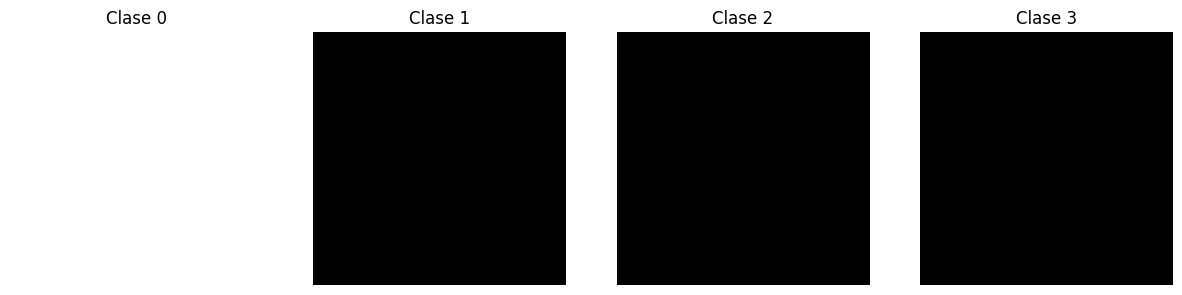

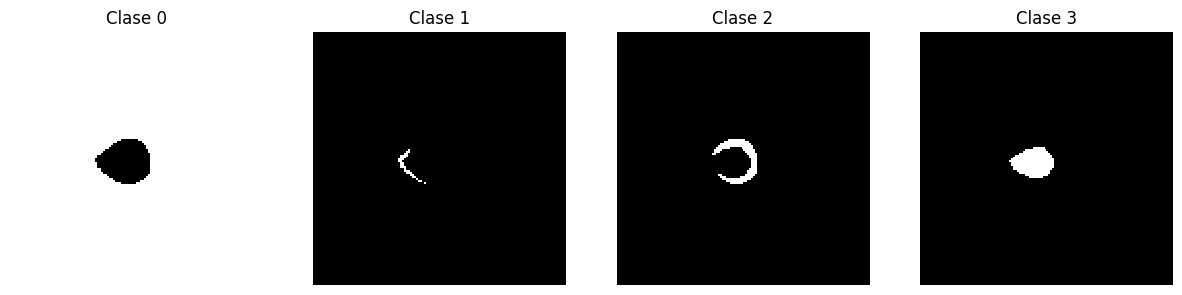

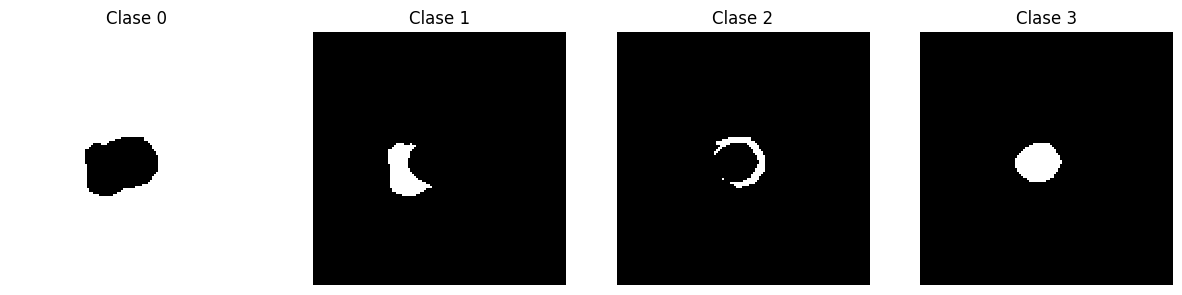

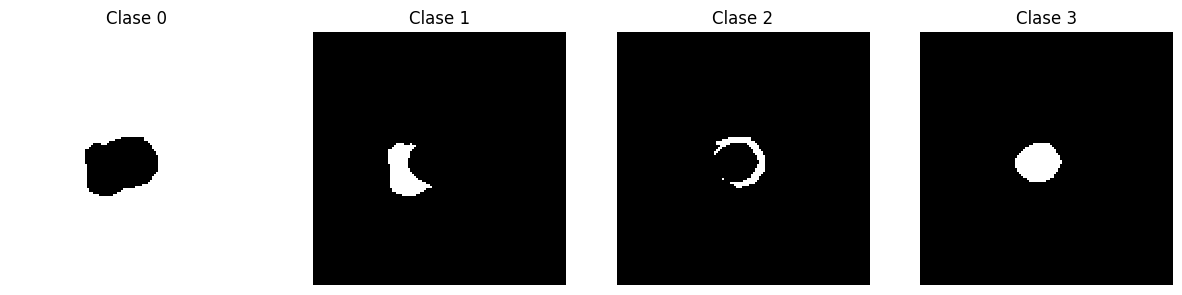

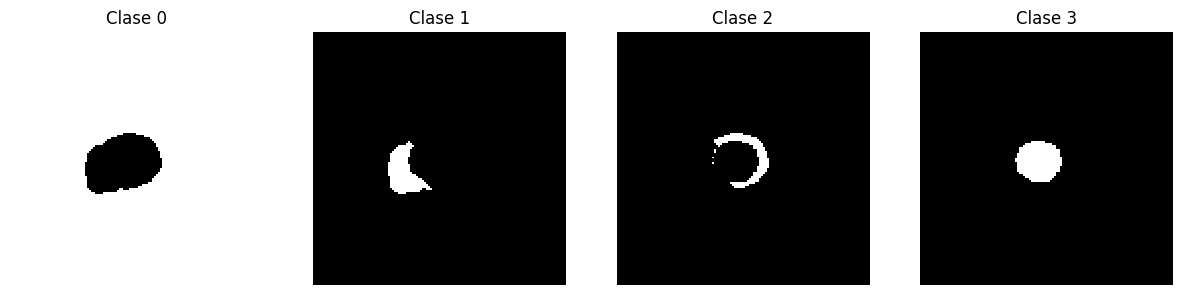

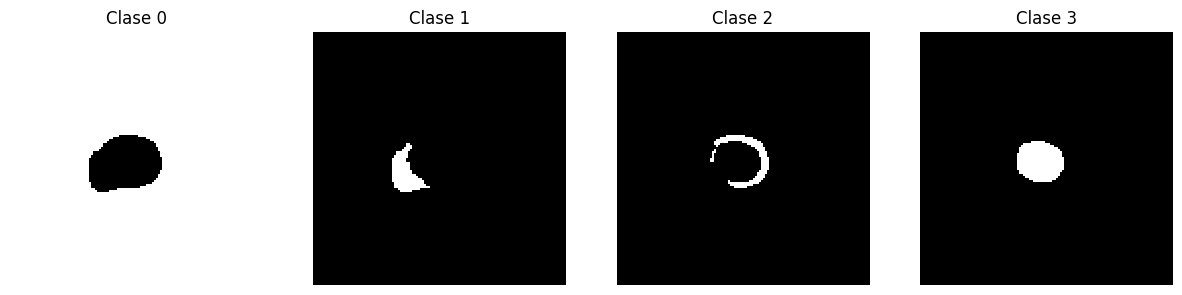

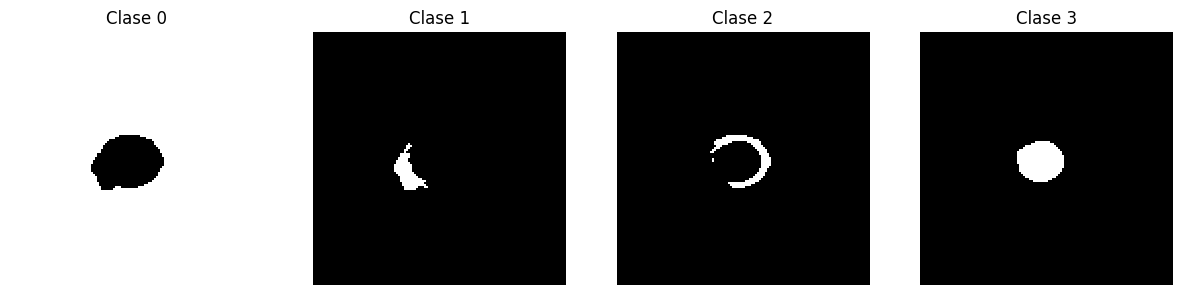

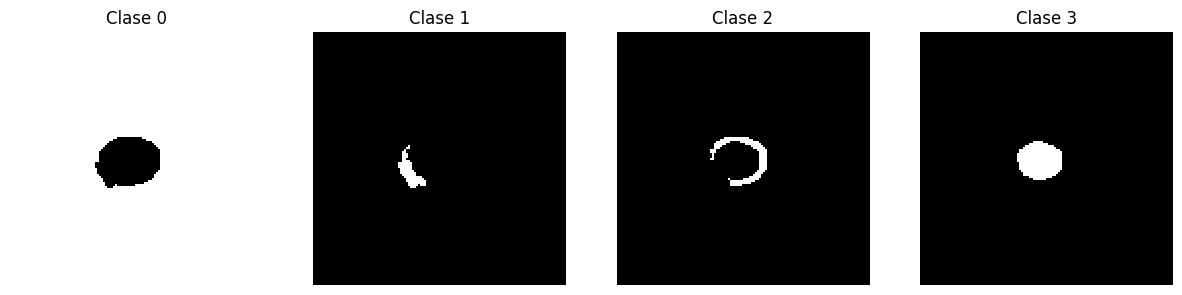

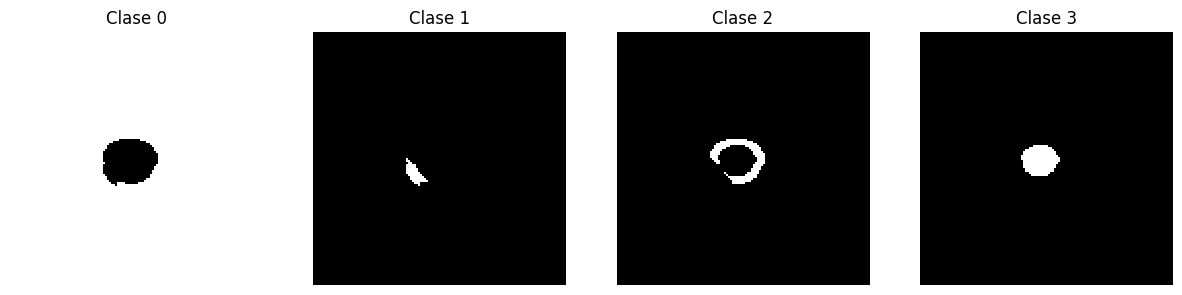

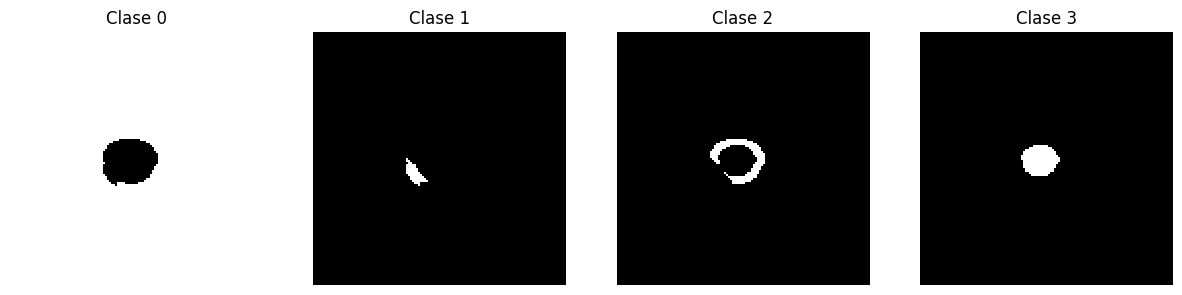

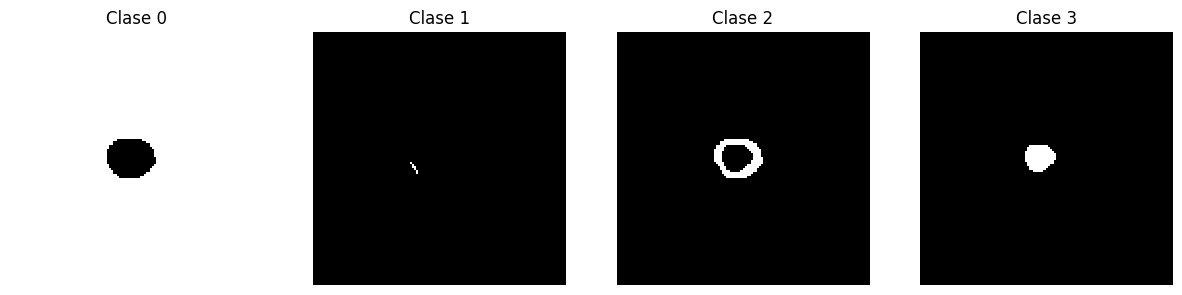

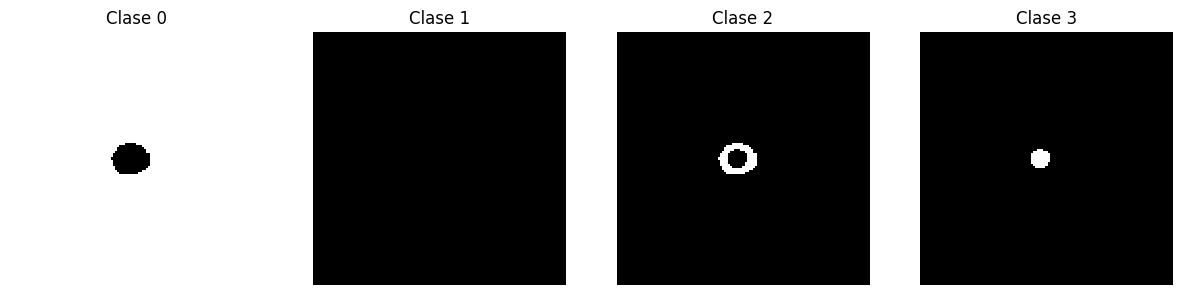

In [25]:
for j in range(12):
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    for i, ax in enumerate(axs):
        ax.imshow(transform(train_data_dicts_sphere_3)[0]['image'][i, j, :, :].numpy(), 
                  cmap='gray', interpolation='none', vmin=0, vmax=1)
        ax.axis('off')
        ax.set_title(f"Clase {i}")
    plt.show()

In [26]:
# Crear un Dataset de MONAI para los archivos de entrenamiento y validación

train_data_dicts = [{"image": file} for file in training_files]
train_ds = Dataset(data=train_data_dicts, transform=all_transforms)

val_data_dicts = [{"image": file} for file in testing_files]
val_ds = Dataset(data=val_data_dicts, transform=all_transforms)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=1, persistent_workers=True)
print(f'Image shape {train_ds[0]["image"].shape}')
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=1, persistent_workers=True)
print(f'Image shape {val_ds[0]["image"].shape}')

Image shape torch.Size([4, 12, 128, 128])
Image shape torch.Size([4, 12, 128, 128])


In [27]:
train_data_dicts_noise = [{"image": file} for file in training_files_noise]
train_ds_noise = Dataset(data=train_data_dicts_noise, transform=all_transforms)

val_data_dicts_noise = [{"image": file} for file in testing_files_noise]
val_ds_noise = Dataset(data=val_data_dicts_noise, transform=all_transforms)

train_loader_noise = DataLoader(train_ds_noise, batch_size=1, shuffle=True, num_workers=1, persistent_workers=True)
print(f'Image shape {train_ds_noise[0]["image"].shape}')
val_loader_noise = DataLoader(val_ds_noise, batch_size=1, shuffle=False, num_workers=1, persistent_workers=True)
print(f'Image shape {val_ds_noise[0]["image"].shape}')

Image shape torch.Size([4, 12, 128, 128])
Image shape torch.Size([4, 12, 128, 128])


In [28]:
train_data_dicts_sphere = [{"image": file} for file in training_files_sphere]
train_ds_sphere = Dataset(data=train_data_dicts_sphere, transform=all_transforms)

val_data_dicts_sphere = [{"image": file} for file in testing_files_sphere]
val_ds_sphere = Dataset(data=val_data_dicts_sphere, transform=all_transforms)

train_loader_sphere = DataLoader(train_ds_sphere, batch_size=1, shuffle=True, num_workers=1, persistent_workers=True)
print(f'Image shape {train_ds_sphere[0]["image"].shape}')
val_loader_sphere = DataLoader(val_ds_sphere, batch_size=1, shuffle=False, num_workers=1, persistent_workers=True)
print(f'Image shape {val_ds_sphere[0]["image"].shape}')

Image shape torch.Size([4, 12, 128, 128])
Image shape torch.Size([4, 12, 128, 128])


In [29]:
train_data_dicts_sphere_2 = [{"image": file} for file in training_files_sphere_2]
train_ds_sphere_2 = Dataset(data=train_data_dicts_sphere_2, transform=all_transforms)

val_data_dicts_sphere_2 = [{"image": file} for file in testing_files_sphere_2]
val_ds_sphere_2 = Dataset(data=val_data_dicts_sphere_2, transform=all_transforms)

train_loader_sphere_2 = DataLoader(train_ds_sphere_2, batch_size=1, shuffle=True, num_workers=1, persistent_workers=True)
print(f'Image shape {train_ds_sphere_2[0]["image"].shape}')
val_loader_sphere_2 = DataLoader(val_ds_sphere_2, batch_size=1, shuffle=False, num_workers=1, persistent_workers=True)
print(f'Image shape {val_ds_sphere_2[0]["image"].shape}')

Image shape torch.Size([4, 12, 128, 128])
Image shape torch.Size([4, 12, 128, 128])


In [30]:
train_data_dicts_sphere_3 = [{"image": file} for file in training_files_sphere_3]
train_ds_sphere_3 = Dataset(data=train_data_dicts_sphere_3, transform=all_transforms)

val_data_dicts_sphere_3 = [{"image": file} for file in testing_files_sphere_3]
val_ds_sphere_3 = Dataset(data=val_data_dicts_sphere_3, transform=all_transforms)

train_loader_sphere_3 = DataLoader(train_ds_sphere_3, batch_size=1, shuffle=True, num_workers=1, persistent_workers=True)
print(f'Image shape {train_ds_sphere_3[0]["image"].shape}')
val_loader_sphere_3 = DataLoader(val_ds_sphere_3, batch_size=1, shuffle=False, num_workers=1, persistent_workers=True)
print(f'Image shape {val_ds_sphere_3[0]["image"].shape}')

Image shape torch.Size([4, 12, 128, 128])
Image shape torch.Size([4, 12, 128, 128])


In [31]:
train_data_dicts_elongated = [{"image": file} for file in training_files_elongated]
train_ds_elongated = Dataset(data=train_data_dicts_elongated, transform=all_transforms)

val_data_dicts_elongated = [{"image": file} for file in testing_files_elongated]
val_ds_elongated = Dataset(data=val_data_dicts_elongated, transform=all_transforms)

train_loader_elongated = DataLoader(train_ds_elongated, batch_size=1, shuffle=True, num_workers=1, persistent_workers=True)
print(f'Image shape {train_ds_elongated[0]["image"].shape}')
val_loader_elongated = DataLoader(val_ds_elongated, batch_size=1, shuffle=False, num_workers=1, persistent_workers=True)
print(f'Image shape {val_ds_elongated[0]["image"].shape}')

Image shape torch.Size([4, 12, 128, 128])
Image shape torch.Size([4, 12, 128, 128])


In [32]:
# Get one batch of validation data to visualize
first(val_loader).__getitem__("image").shape
first(val_loader_noise).__getitem__("image").shape
first(val_loader_sphere).__getitem__("image").shape
first(val_loader_sphere_2).__getitem__("image").shape
first(val_loader_sphere_3).__getitem__("image").shape
first(val_loader_elongated).__getitem__("image").shape

torch.Size([1, 4, 12, 128, 128])

In [33]:
postprocess_transform = transforms.AsDiscreted(keys="image", argmax=True, dim=0)
postprocess_mask = postprocess_transform(val_ds[0])['image'][0]

plt.figure(figsize=(300, 50))
for i in range(postprocess_mask.shape[0]):
    plt.subplot(1, postprocess_mask.shape[1], i + 1)
    plt.imshow(postprocess_mask[i], cmap="gray", interpolation='none')
    plt.axis("off")

In [34]:
postprocess_mask_noise = postprocess_transform(val_ds_noise[0])['image'][0]

plt.figure(figsize=(300, 50))
for i in range(postprocess_mask_noise.shape[0]):
    plt.subplot(1, postprocess_mask_noise.shape[1], i + 1)
    plt.imshow(postprocess_mask_noise[i], cmap="gray", interpolation='none')
    plt.axis("off")

In [35]:
postprocess_mask_sphere = postprocess_transform(val_ds_sphere[0])['image'][0]

plt.figure(figsize=(300, 50))
for i in range(postprocess_mask_sphere.shape[0]):
    plt.subplot(1, postprocess_mask_sphere.shape[1], i + 1)
    plt.imshow(postprocess_mask_sphere[i], cmap="gray", interpolation='none')
    plt.axis("off")
    
postprocess_mask_sphere_2 = postprocess_transform(val_ds_sphere_2[0])['image'][0]
plt.figure(figsize=(300, 50))
for i in range(postprocess_mask_sphere_2.shape[0]):
    plt.subplot(1, postprocess_mask_sphere_2.shape[1], i + 1)
    plt.imshow(postprocess_mask_sphere_2[i], cmap="gray", interpolation='none')
    plt.axis("off")

postprocess_mask_sphere_3 = postprocess_transform(val_ds_sphere_3[0])['image'][0]
plt.figure(figsize=(300, 50))
for i in range(postprocess_mask_sphere_3.shape[0]):
    plt.subplot(1, postprocess_mask_sphere_3.shape[1], i + 1)
    plt.imshow(postprocess_mask_sphere_3[i], cmap="gray", interpolation='none')
    plt.axis("off")

In [36]:
postprocess_mask_elongated = postprocess_transform(val_ds_elongated[0])['image'][0]

plt.figure(figsize=(300, 50))
for i in range(postprocess_mask_elongated.shape[0]):
    plt.subplot(1, postprocess_mask_elongated.shape[1], i + 1)
    plt.imshow(postprocess_mask_elongated[i], cmap="gray", interpolation='none')
    plt.axis("off")

## Visualise examples from the training set

Imagen de entrenamiento cargada, tamaño: torch.Size([1, 4, 12, 128, 128])


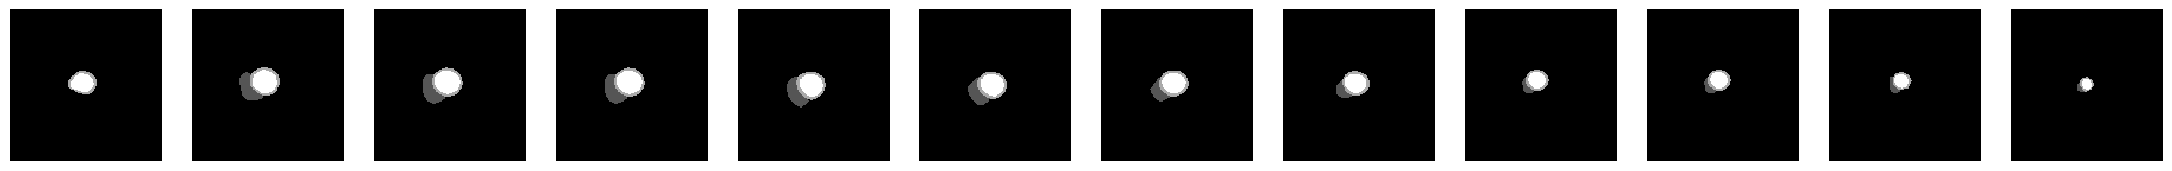

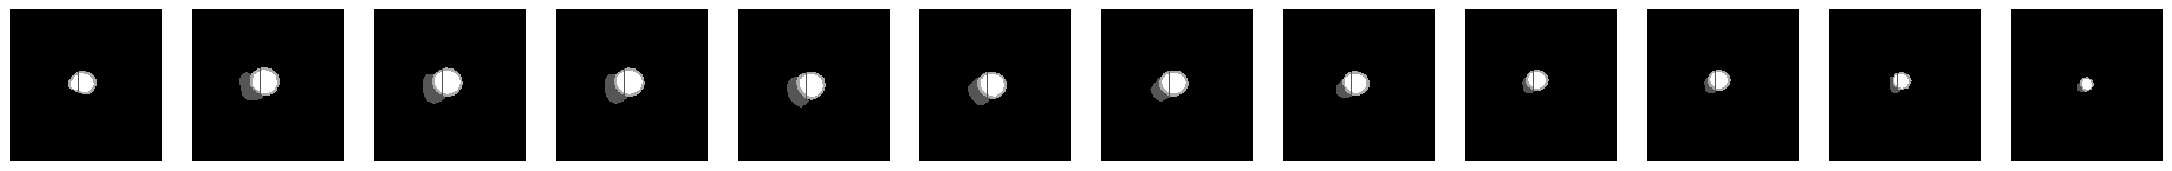

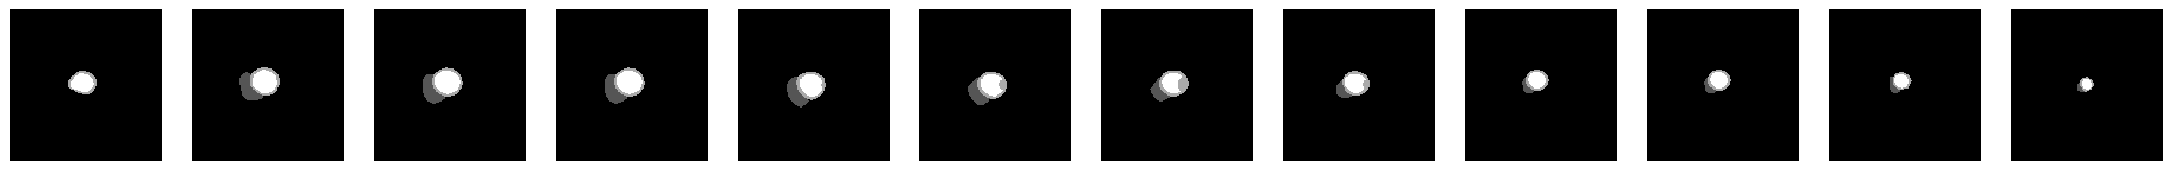

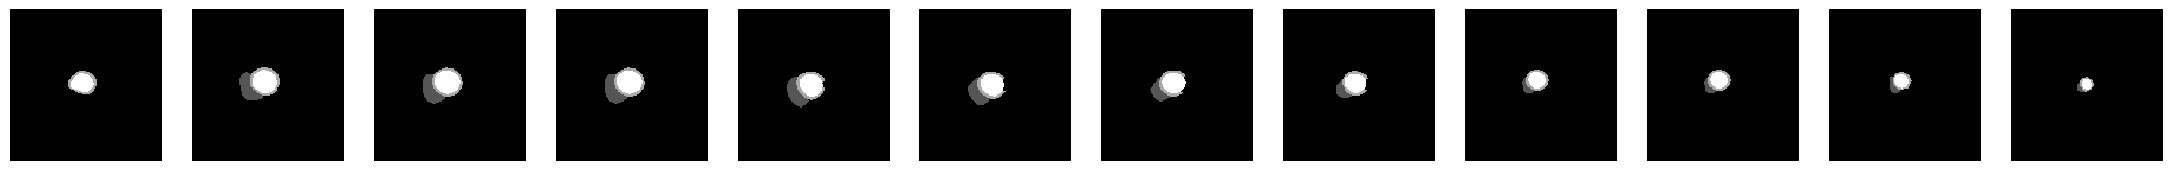

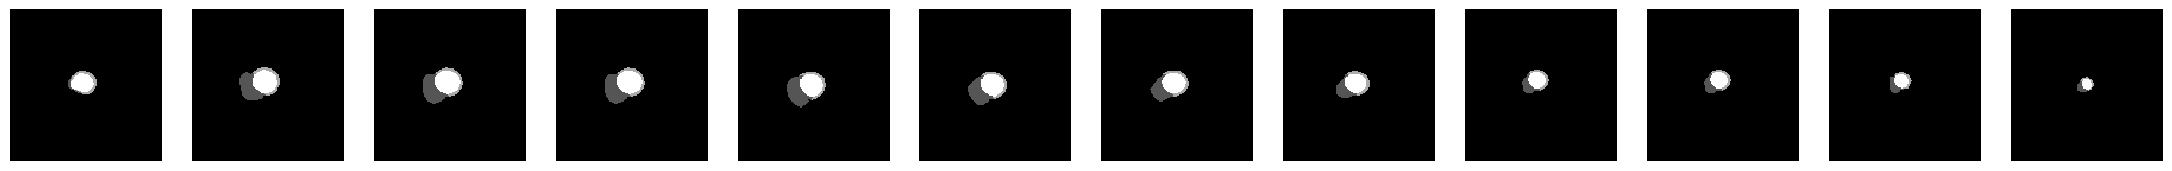

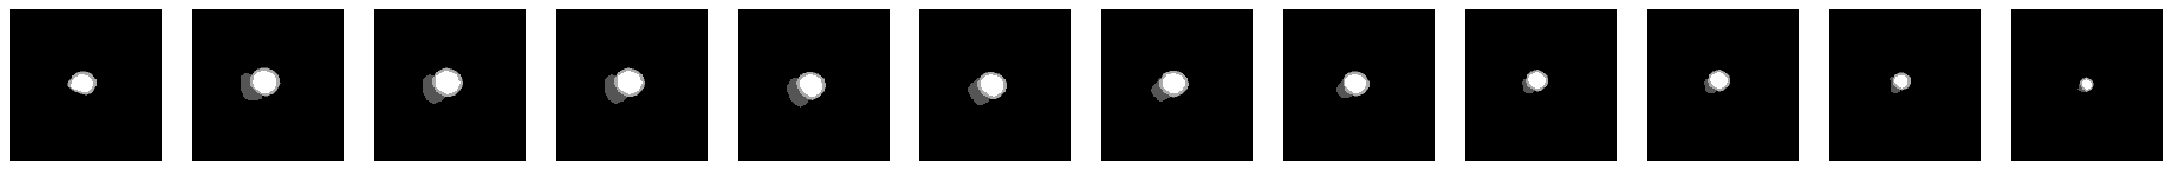

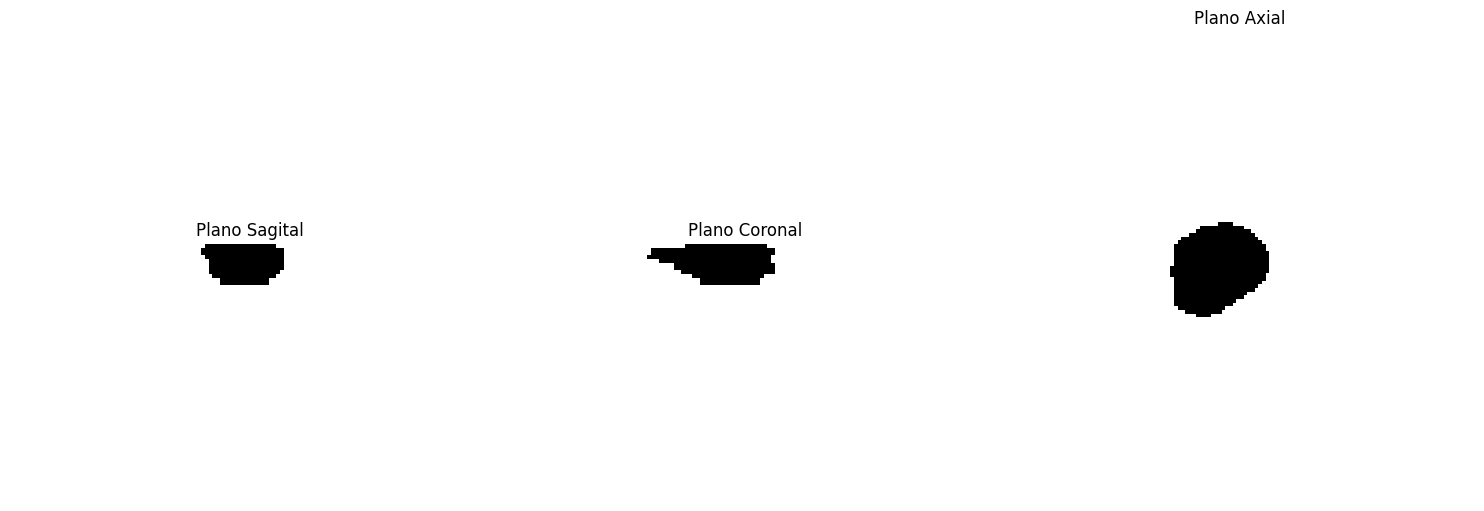

In [37]:
check_data = next(iter(train_loader))
image_tensor = check_data['image']  # Extrae la imagen como tensor

print(f"Imagen de entrenamiento cargada, tamaño: {image_tensor.shape}")


width_idx = image_tensor.size(4) // 2 # Sagittal
height_idx = image_tensor.size(3) // 2 # Coronal
depth_idx = image_tensor.size(2) // 2 # Axial

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plano sagital
image_slice_sagittal = image_tensor[0, 0, :, :, width_idx]
axs[0].imshow(image_slice_sagittal.cpu().numpy(), cmap='gray')
axs[0].set_title("Plano Sagital")
axs[0].axis('off')

# Plano coronal
image_slice_coronal = image_tensor[0, 0, :, height_idx, :]
axs[1].imshow(image_slice_coronal.cpu().numpy(), cmap='gray')
axs[1].set_title("Plano Coronal")
axs[1].axis('off')

# Plano axial
image_slice_axial = image_tensor[0, 0, depth_idx, :, :]
axs[2].imshow(image_slice_axial.cpu().numpy(), cmap='gray', interpolation='none')
axs[2].set_title("Plano Axial")
axs[2].axis('off')

plt.tight_layout()
plt.show()

Imagen de entrenamiento con ruido cargada, tamaño: torch.Size([1, 4, 12, 128, 128])


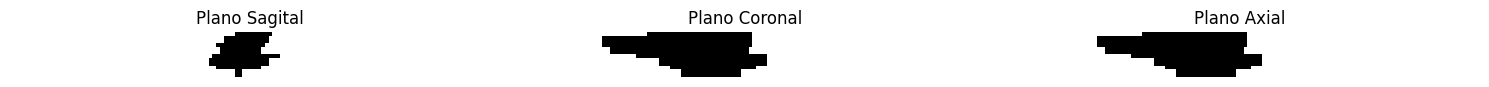

In [38]:
check_data_noise = next(iter(train_loader_noise))
image_tensor_noise = check_data_noise['image']  # Extrae la imagen como tensor

print(f"Imagen de entrenamiento con ruido cargada, tamaño: {image_tensor_noise.shape}")


width_idx = image_tensor_noise.size(4) // 2 # Sagittal
height_idx = image_tensor_noise.size(3) // 2 # Coronal
depth_idx = image_tensor_noise.size(2) // 2 # Axial

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plano sagital
image_slice_sagittal_noise = image_tensor_noise[0, 0, :, :, width_idx]
axs[0].imshow(image_slice_sagittal_noise.cpu().numpy(), cmap='gray')
axs[0].set_title("Plano Sagital")
axs[0].axis('off')

# Plano coronal
image_slice_coronal_noise = image_tensor_noise[0, 0, :, height_idx, :]
axs[1].imshow(image_slice_coronal_noise.cpu().numpy(), cmap='gray')
axs[1].set_title("Plano Coronal")
axs[1].axis('off')

# Plano axial
image_slice_axial_noise = image_tensor_noise[0, 0, depth_idx, :, :]
axs[2].imshow(image_slice_coronal_noise.cpu().numpy(), cmap='gray', interpolation='none')
axs[2].set_title("Plano Axial")
axs[2].axis('off')

plt.tight_layout()
plt.show()

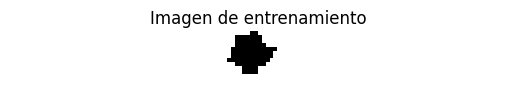

In [39]:
slice_idx = image_tensor.size(4) // 2
#image_slice = image_tensor[0, 0, :, :, slice_idx]
image_slice = image_tensor[0, :, :, :, slice_idx]

# Convertir el tensor en una imagen para visualizar con matplotlib
# plt.imshow(image_slice.cpu().numpy(), cmap='gray', interpolation='none')
plt.imshow(image_slice.permute(1, 2, 0).cpu().numpy(), interpolation='none')
plt.title("Imagen de entrenamiento")
plt.axis('off') 
plt.show()

Tamaño de la máscara cargada: torch.Size([1, 4, 12, 128, 128])
Representación one-hot generada correctamente. Visualizando cada voxel como un vector one-hot.


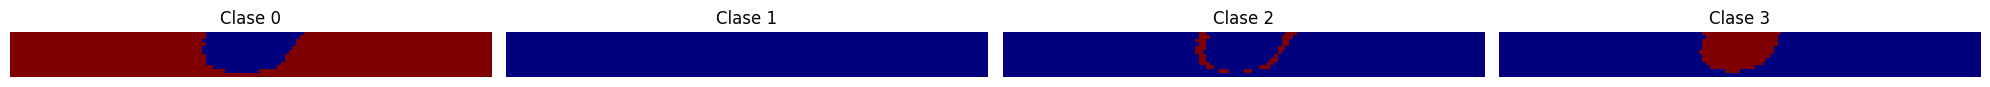

In [40]:
check_data = next(iter(train_loader)) 
image_tensor = check_data['image']

print(f"Tamaño de la máscara cargada: {image_tensor.shape}")

depth_idx = image_tensor.size(-1) // 2 
image_slice_axial = image_tensor[0, :, :, :, depth_idx]  # (batch, clases, ancho, alto, profundidad)

one_hot_representation = np.argmax(image_slice_axial.cpu().numpy(), axis=0)

print("Representación one-hot generada correctamente. Visualizando cada voxel como un vector one-hot.")

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i in range(4): 
    axs[i].imshow((one_hot_representation == i).astype(int), cmap="jet", vmin=0, vmax=1, interpolation='none')
    axs[i].set_title(f"Clase {i}")
    axs[i].axis("off")

plt.tight_layout()
plt.show()


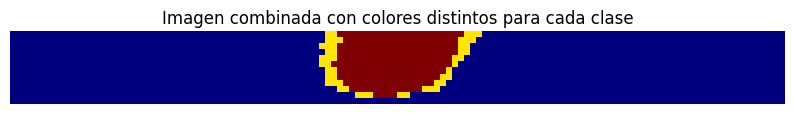

In [41]:
# slice axial del tensor de imagen
depth_idx = image_tensor.size(-1) // 2 
image_slice_axial = image_tensor[0, :, :, :, depth_idx]  # (batch, clases, ancho, alto, profundidad)

one_hot_representation = np.argmax(image_slice_axial.cpu().numpy(), axis=0)
combined_image = np.zeros_like(one_hot_representation, dtype=np.float32)

for i in range(4): 
    combined_image[one_hot_representation == i] = i / 3

plt.figure(figsize=(10, 8))
plt.imshow(combined_image, cmap="jet", vmin=0, vmax=1, interpolation='none')
plt.title("Imagen combinada con colores distintos para cada clase")
plt.axis("off")
plt.show()

## Define the network

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [43]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(

            # S1
            nn.Conv3d(4, 16, kernel_size=3, stride=(1,2,2), padding=1), # [4, 12, 128, 128] -> [16, 12, 64, 64]
            nn.BatchNorm3d(16),
            nn.Conv3d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),

            #S2
            nn.Conv3d(16, 32, kernel_size=3, stride=2, padding=1),      # [16, 12, 64, 64] -> [32, 6, 32, 32]
            nn.BatchNorm3d(32),
            nn.Conv3d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),

            #S3
            nn.Conv3d(32, 64, kernel_size=3, stride=2, padding=1),      # [32, 6, 32, 32] -> [64, 3, 16, 16]
            nn.BatchNorm3d(64),
            nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),

            #S4
            nn.Conv3d(64, 1, kernel_size=3, stride=(1,2,2), padding=1),  # [64, 3, 16, 16] -> [1, 3, 8, 8]
            nn.BatchNorm3d(1),
            nn.ReLU(),
        )

        # Fully connected layer (Latent space)
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 8 * 8, 64),
            nn.Linear(64, 3 * 8 * 8),
            nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(

            #S4
            nn.ConvTranspose3d(1, 64, kernel_size=3, stride=(1,2,2), 
                               padding=1, output_padding=(0,1,1)),       # [1, 3, 8, 8] -> [64, 6, 16, 16]
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),

            #S3
            nn.ConvTranspose3d(64, 32, kernel_size=3, stride=2, 
                               padding=1, output_padding=1),            # [64, 3, 16, 16] -> [32, 6, 32, 32]
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.Conv3d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),

            #S2
            nn.ConvTranspose3d(32, 16, kernel_size=3, stride=2, 
                               padding=1, output_padding=1),            # [32, 6, 32, 32] -> [16, 12, 64, 64]
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.Conv3d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),

            #S1
            nn.ConvTranspose3d(16, 16, kernel_size=3, stride=(1,2,2), 
                               padding=1, output_padding=(0,1,1)),      # [16, 12, 64, 64] -> [16, 12, 128, 128]
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.Conv3d(16, 4, kernel_size=3, padding=1),                 # [16, 12, 128, 128] -> [4, 12, 128, 128]
        )

    # def forward(self, x):
    #     encoded = self.encoder(x) # [4, 12, 128, 128] -> [1, 3, 8, 8]
    #     latent_vector = self.fc(encoded.view(encoded.size(0), -1)) # [batch_size, 64]
    #     decoded = self.decoder(latent_vector.view(encoded.size()))
    #     return decoded, latent_vector
    
    def forward(self, x):
        # Encoder
        encoded = self.encoder(x)  # [batch_size, 1, 3, 8, 8]
        flattened = encoded.view(encoded.size(0), -1)  # Aplanamos el tensor
        latent_vector = self.fc[1](flattened)  # Extraemos el vector latente: nn.Linear(3 * 8 * 8, 64)
        fc_output = self.fc[2:](latent_vector)  # Pasamos el vector latente por las capas restantes

        # Decoder
        reshaped = fc_output.view(encoded.size())  # Ajustamos a la forma necesaria para el decoder
        decoded = self.decoder(reshaped)

        return decoded, latent_vector  # Devolvemos la salida decodificada y el vector latente
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder().to(device)
sample_input = torch.randn(1, 4, 12, 128, 128).to(device) 
sample_output = model(sample_input)[0]
print(f"Input shape: {sample_input.shape}")
print(f"Output shape: {sample_output.shape}")
print(model) 

Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Autoencoder(
  (encoder): Sequential(
    (0): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (3): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (6): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (8): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (11): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=Tru

In [44]:
# from torchmetrics.segmentation import DiceScore
# import torch.nn.functional as F

# dice_score_metric = DiceScore(
#     num_classes=3,          # Número de clases (incluyendo fondo)
#     include_background=False,  # Excluir el fondo
#     average='macro'         # Opción de promediado (puede ser 'micro', 'macro', 'weighted', None)
# )

# preds = torch.randn(4, 3, 128, 128)  # Batch de 4, 3 clases, tamaño 128x128
# targets = torch.randint(0, 3, (4, 128, 128))  # Batch de etiquetas reales (índices de clases)

# preds_softmax = F.softmax(preds, dim=1)  # Convertir logits a probabilidades
# preds_argmax = preds_softmax.argmax(dim=1)  # Obtener la clase más probable

# dice_score = dice_score_metric(preds_argmax, targets)
# print("Promedio Dice por batch:", dice_score)

In [45]:
def save_latent_vectors(model, train_loader, val_loader, desc):
    train_latent_vectors = []
    val_latent_vectors = []

    with torch.no_grad():
        for batch_data in tqdm(train_loader, desc=f"Saving Train Latent Vectors ({desc})"):
            inputs = batch_data["image"].to(device)
            _, latent_vectors = model(inputs)
            train_latent_vectors.append(latent_vectors.detach().cpu().numpy())

        for val_data in tqdm(val_loader, desc=f"Saving Validation Latent Vectors ({desc})"):
            val_inputs = val_data["image"].to(device)
            _, latent_vectors = model(val_inputs)
            val_latent_vectors.append(latent_vectors.detach().cpu().numpy())

    train_latent_vectors = np.concatenate(train_latent_vectors, axis=0)
    val_latent_vectors = np.concatenate(val_latent_vectors, axis=0)

    return train_latent_vectors, val_latent_vectors


In [47]:
# # Cálculo DiceScore usando torchmetrics

# import torch.nn.functional as F
# import torch.optim as optim
# from sklearn.metrics import f1_score
# from torchmetrics.segmentation import DiceScore, HausdorffDistance, MeanIoU

# model = Autoencoder().to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-6)
# criterion = nn.CrossEntropyLoss() 

# # Entrenamiento
# num_epochs = 20
# val_interval = 1
# train_loss_list = []
# val_loss_list = []
# best_val_dice = 0

# num_classes = 4
# dice_metric = DiceScore(num_classes=num_classes, include_background=False, average='macro', input_format='one-hot')

# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0

#     dice_metric.reset()

#     for batch_data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
#         inputs = batch_data["image"].to(device)
#         outputs, train_latent_vectors_output = model(inputs)
#         # print(f"outputs: {outputs.shape}")
#         # print(f"inputs: {inputs.shape}")

#         loss = criterion(outputs, F.interpolate(inputs, size=outputs.shape[2:], mode='nearest'))

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()
        
#         outputs_softmax = F.softmax(outputs, dim=1)
#         outputs_one_hot = F.one_hot(torch.argmax(outputs_softmax, dim=1), num_classes=num_classes).permute(0, 4, 1, 2, 3).float()
        
#         # print(f"inputs_one_hot: {inputs.shape}")
#         # print(f"outputs_one_hot: {outputs_one_hot.shape}")
        
#         # outputs_softmax = F.softmax(outputs, dim=1)
#         # outputs_argmax = torch.argmax(outputs_softmax, dim=1)
#         # inputs_softmax = F.softmax(inputs, dim=1)
#         # inputs_argmax = torch.argmax(inputs_softmax, dim=1)
#         # print(f"outputs_argmax: {outputs_argmax.shape}")
#         # print(f"inputs_argmax: {inputs_argmax.shape}")
        
#     avg_train_loss = train_loss / len(train_loader)
#     avg_train_dice = dice_metric(outputs_one_hot, inputs).item()

#     train_loss_list.append(avg_train_loss)
#     print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Dice: {avg_train_dice:.4f}")

#     # Validación
#     if (epoch + 1) % val_interval == 0:
#         model.eval()
#         val_loss = 0

#         with torch.no_grad():
#             for val_data in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
#                 val_inputs = val_data["image"].to(device)
#                 val_outputs, val_latent_vectors_output = model(val_inputs)

#                 val_loss += criterion(val_outputs, F.interpolate(val_inputs, size=val_outputs.shape[2:], mode='nearest')).item()

#                 val_outputs_softmax = F.softmax(val_outputs, dim=1)
#                 val_outputs_one_hot = F.one_hot(torch.argmax(val_outputs_softmax, dim=1), num_classes=num_classes).permute(0, 4, 1, 2, 3).float()
        
#                 # val_outputs_softmax = F.softmax(val_outputs, dim=1)
#                 # val_outputs_argmax = torch.argmax(val_outputs_softmax, dim=1)
#                 # val_inputs_softmax = F.softmax(val_inputs, dim=1)
#                 # val_inputs_argmax = torch.argmax(val_inputs_softmax, dim=1)

#         avg_val_loss = val_loss / len(val_loader)
#         avg_val_dice = dice_metric(val_outputs_one_hot, val_inputs).item()

#         val_loss_list.append(avg_val_loss)
#         print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Validation Dice: {avg_val_dice:.4f}")

#         if avg_val_dice > best_val_dice:
#             best_val_dice = avg_val_dice
#             best_train_latent_vectors_dice, best_val_latent_vectors_dice = save_latent_vectors(model, train_loader, val_loader, "Dice")

# last_train_latent_vectors, last_val_latent_vectors = save_latent_vectors(model, train_loader, val_loader, "Last Epoch")

In [48]:
# # Prueba Dice y HausdorffDistance con torchmetrics (da error porque los tensores de inputs y outputs son float)
# import torch.nn.functional as F
# import torch.optim as optim
# from torchmetrics.segmentation import DiceScore, HausdorffDistance

# model = Autoencoder().to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-6)
# criterion = nn.CrossEntropyLoss() 

# # Entrenamiento
# num_epochs = 20
# val_interval = 1
# train_loss_list = []
# val_loss_list = []
# best_val_dice = 0
# best_val_hausdorff = float('inf')

# num_classes = 4
# dice_metric = DiceScore(num_classes=num_classes, include_background=False, average='macro', input_format='one-hot').to(device)
# hausdorff_metric = HausdorffDistance(num_classes=num_classes, include_background=False, distance_metric='euclidean', input_format='one-hot').to(device)

# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0

#     dice_metric.reset()
#     hausdorff_metric.reset()

#     for batch_data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
#         inputs = batch_data["image"].to(device)
#         outputs, train_latent_vectors_output = model(inputs)

#         loss = criterion(outputs, F.interpolate(inputs, size=outputs.shape[2:], mode='nearest'))

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()
        
#         outputs_softmax = F.softmax(outputs, dim=1)
#         outputs_one_hot = F.one_hot(torch.argmax(outputs_softmax, dim=1), num_classes=num_classes).permute(0, 4, 1, 2, 3).float()
#         hausdorff_metric.update(outputs_one_hot, inputs)
        
#     avg_train_loss = train_loss / len(train_loader)
#     avg_train_dice = dice_metric(outputs_one_hot, inputs).item()
#     avg_train_hausdorff = hausdorff_metric.compute().item()

#     train_loss_list.append(avg_train_loss)
#     print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Dice: {avg_train_dice:.4f}, Train Hausdorff: {avg_train_hausdorff:.4f}")

#     # Validación
#     if (epoch + 1) % val_interval == 0:
#         model.eval()
#         val_loss = 0

#         with torch.no_grad():
#             for val_data in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
#                 val_inputs = val_data["image"].to(device)
#                 val_outputs, val_latent_vectors_output = model(val_inputs)

#                 val_loss += criterion(val_outputs, F.interpolate(val_inputs, size=val_outputs.shape[2:], mode='nearest')).item()

#                 val_outputs_softmax = F.softmax(val_outputs, dim=1)
#                 val_outputs_one_hot = F.one_hot(torch.argmax(val_outputs_softmax, dim=1), num_classes=num_classes).permute(0, 4, 1, 2, 3).float()
#                 hausdorff_metric.update(val_outputs_one_hot, val_inputs)
                
#         avg_val_loss = val_loss / len(val_loader)
#         avg_val_dice = dice_metric(val_outputs_one_hot, val_inputs).item()
#         avg_val_hausdorff = hausdorff_metric.compute().item()

#         val_loss_list.append(avg_val_loss)
#         print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Validation Dice: {avg_val_dice:.4f}, Validation Hausdorff: {avg_val_hausdorff:.4f}")

#         if avg_val_dice > best_val_dice:
#             best_val_dice = avg_val_dice
#             best_train_latent_vectors_dice, best_val_latent_vectors_dice = save_latent_vectors(model, train_loader, val_loader, "Dice")

#         if avg_val_hausdorff < best_val_hausdorff:
#             best_val_hausdorff = avg_val_hausdorff
#             best_train_latent_vectors_hausdorff, best_val_latent_vectors_hausdorff = save_latent_vectors(model, train_loader, val_loader, "Hausdorff")

# last_train_latent_vectors, last_val_latent_vectors = save_latent_vectors(model, train_loader, val_loader, "Last Epoch")

In [49]:
# # Prueba Dice y HausdorffDistance con torchmetrics (da error porque creo que no se puede con datos 3D)
# import torch.nn.functional as F
# import torch.optim as optim
# from torchmetrics.segmentation import DiceScore, HausdorffDistance

# model = Autoencoder().to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-6)
# criterion = nn.CrossEntropyLoss() 

# # Entrenamiento
# num_epochs = 20
# val_interval = 1
# train_loss_list = []
# val_loss_list = []
# best_val_dice = 0
# best_val_hausdorff = float('inf')

# num_classes = 4
# dice_metric = DiceScore(num_classes=num_classes, include_background=False, average='macro', input_format='one-hot').to(device)
# hausdorff_metric = HausdorffDistance(num_classes=num_classes, include_background=False, distance_metric='euclidean', input_format='one-hot').to(device)

# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0

#     dice_metric.reset()
#     hausdorff_metric.reset()

#     for batch_data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
#         inputs = batch_data["image"].to(device)
#         outputs, train_latent_vectors_output = model(inputs)

#         loss = criterion(outputs, F.interpolate(inputs, size=outputs.shape[2:], mode='nearest'))

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()
        
#         outputs_softmax = F.softmax(outputs, dim=1)
#         outputs_one_hot = F.one_hot(torch.argmax(outputs_softmax, dim=1), num_classes=num_classes).permute(0, 4, 1, 2, 3).float()
#         outputs_one_hot_bool = outputs_one_hot.bool()
#         inputs_bool = inputs.bool()
        
#     avg_train_loss = train_loss / len(train_loader)
#     avg_train_dice = dice_metric(outputs_one_hot_bool, inputs_bool).item()
#     avg_train_hausdorff = hausdorff_metric(outputs_one_hot_bool, inputs_bool).item()

#     train_loss_list.append(avg_train_loss)
#     print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Dice: {avg_train_dice:.4f}, Train Hausdorff: {avg_train_hausdorff:.4f}")

#     # Validación
#     if (epoch + 1) % val_interval == 0:
#         model.eval()
#         val_loss = 0

#         with torch.no_grad():
#             for val_data in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
#                 val_inputs = val_data["image"].to(device)
#                 val_outputs, val_latent_vectors_output = model(val_inputs)

#                 val_loss += criterion(val_outputs, F.interpolate(val_inputs, size=val_outputs.shape[2:], mode='nearest')).item()

#                 val_outputs_softmax = F.softmax(val_outputs, dim=1)
#                 val_outputs_one_hot = F.one_hot(torch.argmax(val_outputs_softmax, dim=1), num_classes=num_classes).permute(0, 4, 1, 2, 3).float()
#                 val_outputs_one_hot_bool = val_outputs_one_hot.bool()
#                 val_inputs_bool = val_inputs.bool()
                
#         avg_val_loss = val_loss / len(val_loader)
#         avg_val_dice = dice_metric(val_outputs_one_hot_bool, val_inputs_bool).item()
#         avg_val_hausdorff = hausdorff_metric(val_outputs_one_hot_bool, val_inputs_bool).item()

#         val_loss_list.append(avg_val_loss)
#         print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Validation Dice: {avg_val_dice:.4f}, Validation Hausdorff: {avg_val_hausdorff:.4f}")

#         if avg_val_dice > best_val_dice:
#             best_val_dice = avg_val_dice
#             best_train_latent_vectors_dice, best_val_latent_vectors_dice = save_latent_vectors(model, train_loader, val_loader, "Dice")

#         if avg_val_hausdorff < best_val_hausdorff:
#             best_val_hausdorff = avg_val_hausdorff
#             best_train_latent_vectors_hausdorff, best_val_latent_vectors_hausdorff = save_latent_vectors(model, train_loader, val_loader, "Hausdorff")

# last_train_latent_vectors, last_val_latent_vectors = save_latent_vectors(model, train_loader, val_loader, "Last Epoch")

In [50]:
# Ejemplo Hausdorff distance con torchmetrics para 2D
from torch import randint
from torchmetrics.segmentation import HausdorffDistance
preds = randint(0, 2, (4, 5, 16, 16))  # 4 samples, 5 classes, 16x16 prediction
target = randint(0, 2, (4, 5, 16, 16))  # 4 samples, 5 classes, 16x16 target
hausdorff_distance = HausdorffDistance(distance_metric="euclidean", num_classes=5, input_format='one-hot')
hausdorff_distance(preds, target)

tensor(1.9415)

In [51]:
# # Ejemplo Hausdorff distance con torchmetrics para 3D (da error)
# preds = randint(0, 2, (4, 5, 4, 16, 16))  # 4 samples, 5 classes, 16x16 prediction
# target = randint(0, 2, (4, 5, 4, 16, 16))  # 4 samples, 5 classes, 16x16 target
# print(f"preds shape: {preds[]}")
# hausdorff_distance = HausdorffDistance(distance_metric="euclidean", num_classes=5, input_format='one-hot')
# hausdorff_distance(preds, target)

In [52]:
# Ejemplo Dice con monai.metrics
from monai.metrics import DiceMetric

outputs_one_hot = randint(0, 2, (4, 5, 7, 16, 16))  # 4 samples, 5 classes, 16x16 prediction
inputs = randint(0, 2, (4, 5, 7, 16, 16))  # 4 samples, 5 classes, 16x16 target

dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
dice_metric(y_pred=outputs_one_hot, y=inputs)

print(f"Dice: {dice_metric.aggregate().item()}")

Dice: 0.49506017565727234


In [53]:
# Ejemplo Hausdorff distance con monai.metrics
from monai.metrics import compute_hausdorff_distance

y_pred = randint(0, 2, (4, 5, 7, 16, 16))  # 4 samples, 5 classes, 16x16 prediction
y = randint(0, 2, (4, 5, 7, 16, 16))  # 4 samples, 5 classes, 16x16 target

# Calcular la distancia de Hausdorff usando el método `compute_hausdorff_distance`
hausdorff_dist = compute_hausdorff_distance(
    y_pred,  # Predicciones (en formato one-hot)
    y,       # Verdadera etiqueta (ground truth)
    include_background=False,   # No incluimos el fondo en el cálculo
    distance_metric='euclidean',  # Usamos la distancia euclidiana
    percentile=None,   # Usamos la distancia máxima, no un percentil
    directed=False     # Distancia no dirigida
)

print(f"Distancia de Hausdorff: {hausdorff_dist}")

monai.metrics.utils get_mask_edges:always_return_as_numpy: Argument `always_return_as_numpy` has been deprecated since version 1.5.0. It will be removed in version 1.7.0. The option is removed and the return type will always be equal to the input type.


Distancia de Hausdorff: tensor([[1.4142, 1.4142, 1.7321, 1.4142],
        [1.4142, 1.4142, 2.0000, 1.4142],
        [1.4142, 1.4142, 1.4142, 2.0000],
        [1.4142, 1.4142, 1.4142, 1.4142]])


monai.metrics.utils get_mask_edges:always_return_as_numpy: Argument `always_return_as_numpy` has been deprecated since version 1.5.0. It will be removed in version 1.7.0. The option is removed and the return type will always be equal to the input type.


In [54]:
# # Cálculo de Dice y Hausdorff con Monai (reduction='mean')
# import torch.nn.functional as F
# import torch.optim as optim
# from monai.metrics import DiceMetric, compute_hausdorff_distance

# model = Autoencoder().to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-6)
# criterion = nn.CrossEntropyLoss() 

# # Entrenamiento
# num_epochs = 20
# val_interval = 1
# train_loss_list = []
# val_loss_list = []
# best_val_dice = 0
# best_val_hausdorff = float('inf')

# num_classes = 4
# dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
# # dice_metric = DiceScore(num_classes=num_classes, include_background=False, average='macro', input_format='one-hot').to(device)

# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0

#     dice_metric.reset()

#     for batch_data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
#         inputs = batch_data["image"].to(device)
#         outputs, train_latent_vectors_output = model(inputs)

#         loss = criterion(outputs, F.interpolate(inputs, size=outputs.shape[2:], mode='nearest'))

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()
        
#         outputs_softmax = F.softmax(outputs, dim=1)
#         outputs_one_hot = F.one_hot(torch.argmax(outputs_softmax, dim=1), num_classes=num_classes).permute(0, 4, 1, 2, 3).float()
#         dice_metric(y_pred=outputs_one_hot, y=inputs)
        
#     avg_train_loss = train_loss / len(train_loader)
#     avg_train_dice = dice_metric.aggregate().item()
#     avg_train_hausdorff = compute_hausdorff_distance(outputs_one_hot, inputs, include_background=False).mean().item()

#     train_loss_list.append(avg_train_loss)
#     print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Dice: {avg_train_dice:.4f}, Train Hausdorff: {avg_train_hausdorff:.4f}")

#     # Validación
#     if (epoch + 1) % val_interval == 0:
#         model.eval()
#         val_loss = 0

#         with torch.no_grad():
#             for val_data in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
#                 val_inputs = val_data["image"].to(device)
#                 val_outputs, val_latent_vectors_output = model(val_inputs)

#                 val_loss += criterion(val_outputs, F.interpolate(val_inputs, size=val_outputs.shape[2:], mode='nearest')).item()

#                 val_outputs_softmax = F.softmax(val_outputs, dim=1)
#                 val_outputs_one_hot = F.one_hot(torch.argmax(val_outputs_softmax, dim=1), num_classes=num_classes).permute(0, 4, 1, 2, 3).float()
#                 dice_metric(y_pred=val_outputs_one_hot, y=val_inputs)
                
#         avg_val_loss = val_loss / len(val_loader)
#         avg_val_dice = dice_metric.aggregate().item()
#         avg_val_hausdorff = compute_hausdorff_distance(val_outputs_one_hot, val_inputs, include_background=False).mean().item()

#         val_loss_list.append(avg_val_loss)
#         print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Validation Dice: {avg_val_dice:.4f}, Validation Hausdorff: {avg_val_hausdorff:.4f}")

#         if avg_val_dice > best_val_dice:
#             best_val_dice = avg_val_dice
#             best_train_latent_vectors_dice, best_val_latent_vectors_dice = save_latent_vectors(model, train_loader, val_loader, "Dice")

#         if avg_val_hausdorff < best_val_hausdorff:
#             best_val_hausdorff = avg_val_hausdorff
#             best_train_latent_vectors_hausdorff, best_val_latent_vectors_hausdorff = save_latent_vectors(model, train_loader, val_loader, "Hausdorff")

# last_train_latent_vectors, last_val_latent_vectors = save_latent_vectors(model, train_loader, val_loader, "Last Epoch")

In [66]:
# Cálculo de Dice y Hausdorff con Monai (métricas por clase, reduction="none")
import torch.nn.functional as F
import torch.optim as optim
from monai.metrics import DiceMetric, compute_hausdorff_distance

model = Autoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-6)
criterion = nn.CrossEntropyLoss()

num_epochs = 20
val_interval = 1
train_loss_list = []
val_loss_list = []
best_val_dice = 0
best_val_hausdorff = float('inf')

num_classes = 4
dice_metric = DiceMetric(include_background=False, reduction="none", get_not_nans=False)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    dice_metric.reset()

    for batch_data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        inputs = batch_data["image"].to(device)
        outputs, train_latent_vectors_output = model(inputs)

        loss = criterion(outputs, F.interpolate(inputs, size=outputs.shape[2:], mode='nearest'))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        outputs_softmax = F.softmax(outputs, dim=1)
        outputs_one_hot = F.one_hot(torch.argmax(outputs_softmax, dim=1), num_classes=num_classes).permute(0, 4, 1, 2, 3).float()
        dice_metric(y_pred=outputs_one_hot, y=inputs)

    dice_per_class = dice_metric.aggregate()
    avg_train_dice = dice_per_class.mean().item()

    hausdorff_distances_train = compute_hausdorff_distance(outputs_one_hot, inputs, include_background=False)
    avg_train_hausdorff = hausdorff_distances_train.mean().item()

    train_loss_list.append(train_loss / len(train_loader))

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss_list[-1]:.4f}")
    print(f"  Train Dice: {avg_train_dice:.4f}")
    print(f"  Train Dice by Class: {dice_per_class.tolist()}")
    print(f"  Train Hausdorff: {avg_train_hausdorff:.4f}")
    print(f"  Train Hausdorff by Class: {hausdorff_distances_train.tolist()}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0
        dice_metric.reset()

        with torch.no_grad():
            for val_data in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
                val_inputs = val_data["image"].to(device)
                val_outputs, val_latent_vectors_output = model(val_inputs)

                val_loss += criterion(val_outputs, F.interpolate(val_inputs, size=val_outputs.shape[2:], mode='nearest')).item()

                val_outputs_softmax = F.softmax(val_outputs, dim=1)
                val_outputs_one_hot = F.one_hot(torch.argmax(val_outputs_softmax, dim=1), num_classes=num_classes).permute(0, 4, 1, 2, 3).float()
                dice_metric(y_pred=val_outputs_one_hot, y=val_inputs)

        dice_per_class_val = dice_metric.aggregate()
        avg_val_dice = dice_per_class_val.mean().item()
        
        hausdorff_distances_val = compute_hausdorff_distance(val_outputs_one_hot, val_inputs, include_background=False)
        avg_val_hausdorff = hausdorff_distances_val.mean().item()

        val_loss_list.append(val_loss / len(val_loader))

        print(f"  Validation Loss: {val_loss_list[-1]:.4f}")
        print(f"  Validation Dice: {avg_val_dice:.4f}")
        print(f"  Validation Dice by Class: {dice_per_class_val.tolist()}")
        print(f"  Validation Hausdorff: {avg_val_hausdorff:.4f}")
        print(f"  Validation Hausdorff by Class: {hausdorff_distances_val.tolist()}")

        if avg_val_dice > best_val_dice:
            best_val_dice = avg_val_dice
            best_train_latent_vectors_dice, best_val_latent_vectors_dice = save_latent_vectors(model, train_loader, val_loader, "Best Dice")

        if avg_val_hausdorff < best_val_hausdorff:
            best_val_hausdorff = avg_val_hausdorff
            best_train_latent_vectors_hausdorff, best_val_latent_vectors_hausdorff = save_latent_vectors(model, train_loader, val_loader, "Best Hausdorff")

last_train_latent_vectors, last_val_latent_vectors = save_latent_vectors(model, train_loader, val_loader, "Last Epoch")

Epoch 1/20 [Train]: 100%|██████████| 200/200 [00:12<00:00, 15.65it/s]


Epoch [1/20]
  Train Loss: 0.1248
  Train Dice: 0.0875
  Train Dice by Class: [[0.0075613646768033504, 0.02769317850470543, 0.004048161208629608], [0.06185966730117798, 0.014091680757701397, 0.02583835832774639], [0.02165706269443035, 0.008605072274804115, 0.014570290222764015], [0.0, 0.0015748031437397003, 0.0023161552380770445], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0

Epoch 1/20 [Validation]: 100%|██████████| 100/100 [00:03<00:00, 25.07it/s]


  Validation Loss: 0.0898
  Validation Dice: 0.1594
  Validation Dice by Class: [[0.0, 0.0, 0.5956447720527649], [0.0, 0.0, 0.49550795555114746], [0.0, 0.0, 0.5140736103057861], [0.0, 0.0, 0.2609890103340149], [0.0, 0.0, 0.621898889541626], [0.0, 0.0, 0.5032223463058472], [0.0, 0.0, 0.5642111897468567], [0.0, 0.0, 0.30584919452667236], [0.0, 0.0, 0.5591939687728882], [0.0, 0.0, 0.17548386752605438], [0.0, 0.0, 0.581088125705719], [0.0, 0.0, 0.5841584205627441], [0.0, 0.0, 0.5213809609413147], [0.0, 0.0, 0.31334415078163147], [0.0, 0.0, 0.4864114224910736], [0.0, 0.0, 0.2581395208835602], [0.0, 0.0, 0.2866969704627991], [0.0, 0.0, 0.2544650435447693], [0.0, 0.0, 0.5141478180885315], [0.0, 0.0, 0.33064132928848267], [0.0, 0.0, 0.5755899548530579], [0.0, 0.0, 0.3315330147743225], [0.0, 0.0, 0.5407540202140808], [0.0, 0.0, 0.46130672097206116], [0.0, 0.0, 0.5898058414459229], [0.0, 0.0, 0.6570955514907837], [0.0, 0.0, 0.4936967194080353], [0.0, 0.0, 0.2910724878311157], [0.0, 0.0, 0.640570

Epoch 2/20 [Train]: 100%|██████████| 200/200 [00:12<00:00, 15.42it/s]


Epoch [2/20]
  Train Loss: 0.0786
  Train Dice: 0.1799
  Train Dice by Class: [[0.0, 0.0, 0.3180760145187378], [0.0, 0.0, 0.4228260815143585], [0.0, 0.0, 0.6599145531654358], [0.0, 0.0, 0.6090123057365417], [0.0, 0.0, 0.45817670226097107], [0.0, 0.0, 0.47345349192619324], [0.0, 0.0, 0.4585152864456177], [0.0, 0.0, 0.6258214116096497], [0.0, 0.0, 0.5179382562637329], [0.0, 0.0, 0.6636071801185608], [0.0, 0.0, 0.5838837623596191], [0.0, 0.0, 0.6889899969100952], [0.0, 0.0, 0.7252252101898193], [0.0, 0.0, 0.35858696699142456], [0.0, 0.0, 0.6126274466514587], [0.0, 0.0, 0.5089944005012512], [0.0, 0.0, 0.6016451120376587], [0.0, 0.0, 0.5994227528572083], [0.0, 0.0, 0.21121883392333984], [0.0, 0.0, 0.6200806498527527], [0.0, 0.0, 0.6803869009017944], [0.0, 0.0, 0.5672797560691833], [0.0, 0.0, 0.5476099252700806], [0.0, 0.0, 0.44552648067474365], [0.0, 0.0, 0.5259625315666199], [0.0, 0.0, 0.536717414855957], [0.0, 0.0, 0.6681691408157349], [0.0, 0.0, 0.22788462042808533], [0.0, 0.0, 0.7769808

Epoch 2/20 [Validation]: 100%|██████████| 100/100 [00:03<00:00, 25.21it/s]


  Validation Loss: 0.0824
  Validation Dice: 0.1844
  Validation Dice by Class: [[0.027348395437002182, 0.0, 0.6642933487892151], [0.0355648547410965, 0.0, 0.5616523027420044], [0.015819208696484566, 0.0015432098880410194, 0.43241921067237854], [0.03265305981040001, 0.0, 0.30158731341362], [0.02184300310909748, 0.0, 0.6429256200790405], [0.0407523512840271, 0.0, 0.5051490664482117], [0.005538248457014561, 0.0, 0.5929770469665527], [0.0, 0.0, 0.2715304493904114], [0.019512195140123367, 0.0, 0.5302227139472961], [0.06708074361085892, 0.0, 0.3093401789665222], [0.004418557975441217, 0.0, 0.6778483986854553], [0.004084411077201366, 0.0, 0.6639885902404785], [0.00894392840564251, 0.0, 0.7471344470977783], [0.01205479446798563, 0.0, 0.567345142364502], [0.014463639818131924, 0.0, 0.5547798871994019], [0.03552769124507904, 0.0, 0.21052631735801697], [0.0003716781211551279, 0.0, 0.4583297073841095], [0.0026041667442768812, 0.0, 0.3283407390117645], [0.015487504191696644, 0.0, 0.518818736076355

Epoch 3/20 [Train]: 100%|██████████| 200/200 [00:13<00:00, 15.25it/s]


Epoch [3/20]
  Train Loss: 0.0717
  Train Dice: 0.2844
  Train Dice by Class: [[0.011195928789675236, 0.0, 0.6685779690742493], [0.016949152573943138, 0.0, 0.43617770075798035], [0.05797101557254791, 0.0, 0.09961685538291931], [0.023036254569888115, 0.0, 0.0], [0.024708304554224014, 0.0, 0.0], [0.033243969082832336, 0.0, 0.008888889104127884], [0.03394945338368416, 0.0, 0.6793428659439087], [0.0234375, 0.0, 0.4234769642353058], [0.040030792355537415, 0.0, 0.7384390234947205], [0.012389380484819412, 0.0, 0.410688579082489], [0.0, 0.0, 0.680825412273407], [0.006736166775226593, 0.0, 0.37274613976478577], [0.0043271309696137905, 0.0, 0.5043023824691772], [0.012028869241476059, 0.0, 0.6895408034324646], [0.005102040711790323, 0.0, 0.6383904218673706], [0.02275960147380829, 0.0, 0.5874799489974976], [0.0013422819320112467, 0.0, 0.7424817681312561], [0.006714628078043461, 0.0, 0.25506865978240967], [0.017910446971654892, 0.0003815337549895048, 0.5777363181114197], [0.011474856175482273, 0.0,

Epoch 3/20 [Validation]: 100%|██████████| 100/100 [00:04<00:00, 24.88it/s]


  Validation Loss: 0.0804
  Validation Dice: 0.2743
  Validation Dice by Class: [[0.4523160755634308, 0.002518891589716077, 0.597966730594635], [0.3120567500591278, 0.0012383901048451662, 0.4360014796257019], [0.31121280789375305, 0.0030674845911562443, 0.4830609858036041], [0.27848100662231445, 0.007692307699471712, 0.23380281031131744], [0.4192747175693512, 0.009695290587842464, 0.7321867346763611], [0.4097914695739746, 0.008359456434845924, 0.5791090726852417], [0.3281034827232361, 0.02205679565668106, 0.6826176643371582], [0.27045300602912903, 0.018648019060492516, 0.3620437979698181], [0.43660789728164673, 0.0018140589818358421, 0.5153406262397766], [0.3364969789981842, 0.0038925651460886, 0.3720552325248718], [0.25546807050704956, 0.01882352866232395, 0.6425093412399292], [0.27668291330337524, 0.014170996844768524, 0.634467601776123], [0.27477601170539856, 0.00657894741743803, 0.6255539059638977], [0.2547993063926697, 0.004000000189989805, 0.4472532868385315], [0.2376563549041748

Saving Train Latent Vectors (Best Hausdorff): 100%|██████████| 200/200 [00:06<00:00, 28.85it/s]
Saving Validation Latent Vectors (Best Hausdorff): 100%|██████████| 100/100 [00:03<00:00, 27.99it/s]
Epoch 4/20 [Train]: 100%|██████████| 200/200 [00:13<00:00, 15.30it/s]


Epoch [4/20]
  Train Loss: 0.0665
  Train Dice: 0.3942
  Train Dice by Class: [[0.2108013927936554, 0.01975850760936737, 0.6603773832321167], [0.11906005442142487, 0.015741834416985512, 0.615512490272522], [0.23600000143051147, 0.011936022900044918, 0.640317440032959], [0.12417994439601898, 0.00770712923258543, 0.6204909682273865], [0.09665019065141678, 0.004228329751640558, 0.630217969417572], [0.2614913284778595, 0.008293839171528816, 0.6571751236915588], [0.29834941029548645, 0.01923076994717121, 0.704268753528595], [0.3752695918083191, 0.015141955576837063, 0.70640629529953], [0.20901933312416077, 0.015143017284572124, 0.6517789363861084], [0.33596837520599365, 0.013145539909601212, 0.4724380373954773], [0.3935905992984772, 0.035571686923503876, 0.5608279705047607], [0.25247901678085327, 0.019966721534729004, 0.5585399270057678], [0.5426658987998962, 0.01461759302765131, 0.6787646412849426], [0.3610149919986725, 0.02404092065989971, 0.648348867893219], [0.3763342499732971, 0.020902

Epoch 4/20 [Validation]: 100%|██████████| 100/100 [00:03<00:00, 25.37it/s]


  Validation Loss: 0.0713
  Validation Dice: 0.4034
  Validation Dice by Class: [[0.5634422302246094, 0.05595855042338371, 0.6804123520851135], [0.3869441747665405, 0.01706666685640812, 0.5257510542869568], [0.684629499912262, 0.06072106212377548, 0.44780218601226807], [0.5809627771377563, 0.08076009154319763, 0.17362269759178162], [0.5150905251502991, 0.18231210112571716, 0.7636867761611938], [0.33220911026000977, 0.17598024010658264, 0.6089565753936768], [0.565904438495636, 0.11479346454143524, 0.6673095226287842], [0.4436201751232147, 0.1521020382642746, 0.35722002387046814], [0.6123778223991394, 0.14241723716259003, 0.6518092751502991], [0.3930943012237549, 0.16735823452472687, 0.39905548095703125], [0.5967742204666138, 0.09883721172809601, 0.7178617715835571], [0.630266547203064, 0.1312657743692398, 0.7221453785896301], [0.44403138756752014, 0.03745318204164505, 0.5184820294380188], [0.4095269739627838, 0.052040211856365204, 0.31377899646759033], [0.5851528644561768, 0.13828612864

Saving Train Latent Vectors (Best Hausdorff): 100%|██████████| 200/200 [00:06<00:00, 28.80it/s]
Saving Validation Latent Vectors (Best Hausdorff): 100%|██████████| 100/100 [00:03<00:00, 28.33it/s]
Epoch 5/20 [Train]: 100%|██████████| 200/200 [00:13<00:00, 15.27it/s]


Epoch [5/20]
  Train Loss: 0.0634
  Train Dice: 0.4772
  Train Dice by Class: [[0.5769696831703186, 0.13012361526489258, 0.6837782263755798], [0.6623134613037109, 0.23579849302768707, 0.6833783388137817], [0.5803571343421936, 0.06780566275119781, 0.7631505131721497], [0.40409886837005615, 0.042173560708761215, 0.46886447072029114], [0.1937091201543808, 0.1918184906244278, 0.6245108246803284], [0.46779027581214905, 0.09502262622117996, 0.6549295783042908], [0.5266839265823364, 0.08224543184041977, 0.6405127644538879], [0.5402542352676392, 0.2683851420879364, 0.7352204918861389], [0.31124553084373474, 0.15045134723186493, 0.37400397658348083], [0.6899738907814026, 0.3444444537162781, 0.7371507287025452], [0.2778452932834625, 0.19995537400245667, 0.7979522943496704], [0.6530781984329224, 0.1913810670375824, 0.5962373614311218], [0.5546591281890869, 0.18362900614738464, 0.7735893726348877], [0.5254027247428894, 0.22805701196193695, 0.41654878854751587], [0.5462365746498108, 0.2403924763202

Epoch 5/20 [Validation]: 100%|██████████| 100/100 [00:04<00:00, 24.47it/s]


  Validation Loss: 0.0705
  Validation Dice: 0.4622
  Validation Dice by Class: [[0.5796842575073242, 0.2582666277885437, 0.5988053679466248], [0.2839506268501282, 0.12581168115139008, 0.3553921580314636], [0.5935483574867249, 0.18546845018863678, 0.23314285278320312], [0.3064113259315491, 0.1267021894454956, 0.0], [0.5393030047416687, 0.41676104068756104, 0.7421432733535767], [0.34151625633239746, 0.47324612736701965, 0.6189813613891602], [0.6113021969795227, 0.43704667687416077, 0.7890795469284058], [0.36152219772338867, 0.4671306908130646, 0.4759979844093323], [0.6818637251853943, 0.35635748505592346, 0.583095371723175], [0.4169265031814575, 0.3433648645877838, 0.42582106590270996], [0.7456007599830627, 0.30235379934310913, 0.7537655830383301], [0.7609201073646545, 0.3341708481311798, 0.7664067149162292], [0.24123844504356384, 0.2866520881652832, 0.5701054930686951], [0.1818181872367859, 0.09015996009111404, 0.1384364813566208], [0.6839360594749451, 0.22670024633407593, 0.5515138506

Epoch 6/20 [Train]: 100%|██████████| 200/200 [00:13<00:00, 15.31it/s]


Epoch [6/20]
  Train Loss: 0.0596
  Train Dice: 0.5255
  Train Dice by Class: [[0.4541226327419281, 0.3247734010219574, 0.5497326254844666], [0.6125792860984802, 0.2729608118534088, 0.6978723406791687], [0.36422666907310486, 0.2802272140979767, 0.7302573323249817], [0.548008382320404, 0.17989417910575867, 0.6969696879386902], [0.7042108178138733, 0.18417945504188538, 0.6958625912666321], [0.550537645816803, 0.1853964626789093, 0.5560796856880188], [0.5044390559196472, 0.44620320200920105, 0.5086607336997986], [0.4914644956588745, 0.4692843556404114, 0.6236054301261902], [0.4701918065547943, 0.25389376282691956, 0.7162598371505737], [0.6991179585456848, 0.5081332325935364, 0.6351540684700012], [0.500144362449646, 0.33207011222839355, 0.8164436221122742], [0.5809431076049805, 0.47539615631103516, 0.7085692882537842], [0.6046114563941956, 0.5262904167175293, 0.5481440424919128], [0.6278749704360962, 0.3220095634460449, 0.6290103793144226], [0.5343119502067566, 0.451977401971817, 0.6652193

Epoch 6/20 [Validation]: 100%|██████████| 100/100 [00:03<00:00, 25.22it/s]


  Validation Loss: 0.0681
  Validation Dice: 0.5087
  Validation Dice by Class: [[0.61234050989151, 0.4100126624107361, 0.7436449527740479], [0.4064856767654419, 0.3891855776309967, 0.631210207939148], [0.6792879104614258, 0.22494260966777802, 0.5182186365127563], [0.6425511837005615, 0.33575525879859924, 0.28539326786994934], [0.5173662900924683, 0.40034255385398865, 0.7548152208328247], [0.28491148352622986, 0.28722235560417175, 0.5588503479957581], [0.6354694366455078, 0.41885966062545776, 0.7807005047798157], [0.387531578540802, 0.4378698170185089, 0.37307974696159363], [0.6807501912117004, 0.49820050597190857, 0.68990558385849], [0.4565070867538452, 0.43926870822906494, 0.3903743326663971], [0.6947439908981323, 0.47517040371894836, 0.8511301875114441], [0.704386830329895, 0.5088582634925842, 0.8608142137527466], [0.3779236674308777, 0.35072654485702515, 0.714576244354248], [0.38245081901550293, 0.3755132555961609, 0.5927977561950684], [0.6395348906517029, 0.3911859393119812, 0.776

Epoch 7/20 [Train]: 100%|██████████| 200/200 [00:13<00:00, 15.22it/s]


Epoch [7/20]
  Train Loss: 0.0584
  Train Dice: 0.5159
  Train Dice by Class: [[0.4797418415546417, 0.4940357804298401, 0.8152704238891602], [0.6443268656730652, 0.633449375629425, 0.7017543911933899], [0.7326352596282959, 0.33184945583343506, 0.7324396967887878], [0.5951657891273499, 0.29239991307258606, 0.6457564830780029], [0.5446293354034424, 0.4701250493526459, 0.7015360593795776], [0.6160467267036438, 0.5411829948425293, 0.41554054617881775], [0.4682093858718872, 0.4699999988079071, 0.822468101978302], [0.6163849234580994, 0.3755020201206207, 0.6895787119865417], [0.546942949295044, 0.4629161059856415, 0.7030446529388428], [0.3810359835624695, 0.5139859914779663, 0.7092437148094177], [0.4177052080631256, 0.6971468925476074, 0.8286009430885315], [0.5283291339874268, 0.40490368008613586, 0.5762946605682373], [0.4448786973953247, 0.16001993417739868, 0.47416624426841736], [0.4591052830219269, 0.44086477160453796, 0.4720194637775421], [0.376875102519989, 0.21192893385887146, 0.434343

Epoch 7/20 [Validation]: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


  Validation Loss: 0.0590
  Validation Dice: 0.5434
  Validation Dice by Class: [[0.6357837915420532, 0.39317774772644043, 0.694766104221344], [0.3405918478965759, 0.23172785341739655, 0.48555758595466614], [0.5535508394241333, 0.2665289342403412, 0.5079885125160217], [0.4449799060821533, 0.40044328570365906, 0.21418637037277222], [0.5501703023910522, 0.47323039174079895, 0.7287630438804626], [0.3684992492198944, 0.4002506732940674, 0.5270235538482666], [0.5663430690765381, 0.39566394686698914, 0.7417768239974976], [0.4281249940395355, 0.5103712677955627, 0.38595137000083923], [0.7232025265693665, 0.5598227381706238, 0.6799140572547913], [0.5105782747268677, 0.5402041077613831, 0.44411545991897583], [0.6832579374313354, 0.4447179436683655, 0.8642919659614563], [0.7181605100631714, 0.5342378616333008, 0.8758437633514404], [0.3380916714668274, 0.3835454285144806, 0.737265408039093], [0.3637074828147888, 0.40943193435668945, 0.5525383949279785], [0.6785871982574463, 0.5300496816635132, 0.

Saving Train Latent Vectors (Best Hausdorff): 100%|██████████| 200/200 [00:06<00:00, 28.81it/s]
Saving Validation Latent Vectors (Best Hausdorff): 100%|██████████| 100/100 [00:03<00:00, 27.82it/s]
Epoch 8/20 [Train]: 100%|██████████| 200/200 [00:13<00:00, 15.37it/s]


Epoch [8/20]
  Train Loss: 0.0509
  Train Dice: 0.5643
  Train Dice by Class: [[0.6727668642997742, 0.6379686594009399, 0.8243938088417053], [0.6911513209342957, 0.546166181564331, 0.8087695240974426], [0.45524078607559204, 0.317324697971344, 0.7364001274108887], [0.566288411617279, 0.13062408566474915, 0.38321518898010254], [0.6586284637451172, 0.1272430717945099, 0.48682519793510437], [0.6211081743240356, 0.5360665321350098, 0.7405625581741333], [0.603374719619751, 0.40414509177207947, 0.8348487019538879], [0.5735001564025879, 0.2812989056110382, 0.7150135040283203], [0.5555555820465088, 0.4799657166004181, 0.8298254013061523], [0.6617336273193359, 0.4846547245979309, 0.6676923036575317], [0.5264636874198914, 0.2712724506855011, 0.738413393497467], [0.4961160123348236, 0.5208926796913147, 0.44126075506210327], [0.7103463411331177, 0.4350670576095581, 0.7901684045791626], [0.3715447187423706, 0.4125831723213196, 0.8111230134963989], [0.7088866233825684, 0.4738937020301819, 0.726607859

Epoch 8/20 [Validation]: 100%|██████████| 100/100 [00:03<00:00, 25.73it/s]


  Validation Loss: 0.0614
  Validation Dice: 0.5335
  Validation Dice by Class: [[0.6277922987937927, 0.40600600838661194, 0.7435615062713623], [0.47927460074424744, 0.4080986976623535, 0.6724891066551208], [0.38454627990722656, 0.26359257102012634, 0.4995766282081604], [0.30282291769981384, 0.4731254279613495, 0.39447730779647827], [0.4920071065425873, 0.4422130286693573, 0.7703588008880615], [0.2998798191547394, 0.3222861588001251, 0.6191310882568359], [0.5884928107261658, 0.4136195778846741, 0.7473548650741577], [0.39317774772644043, 0.41734692454338074, 0.297468364238739], [0.6466480493545532, 0.5639902949333191, 0.7218080163002014], [0.4339887499809265, 0.5222755074501038, 0.34421366453170776], [0.6548716425895691, 0.36075231432914734, 0.824227511882782], [0.6753426790237427, 0.4382433593273163, 0.831507682800293], [0.4764065444469452, 0.34245312213897705, 0.7355802059173584], [0.48154783248901367, 0.5262054800987244, 0.6736510992050171], [0.6304609179496765, 0.317238450050354, 0.

Epoch 9/20 [Train]: 100%|██████████| 200/200 [00:13<00:00, 15.12it/s]


Epoch [9/20]
  Train Loss: 0.0479
  Train Dice: 0.5863
  Train Dice by Class: [[0.6221320033073425, 0.4322396516799927, 0.8020546436309814], [0.6871072053909302, 0.39388322830200195, 0.7278688549995422], [0.7104259133338928, 0.6040415167808533, 0.8905660510063171], [0.3217167258262634, 0.2691780924797058, 0.7828719615936279], [0.6239575147628784, 0.20367197692394257, 0.6523029208183289], [0.6671679019927979, 0.5706961154937744, 0.816216230392456], [0.3354644477367401, 0.23150713741779327, 0.6006622314453125], [0.5662136077880859, 0.46801620721817017, 0.8681913614273071], [0.652065098285675, 0.3148703873157501, 0.7887455224990845], [0.6194744110107422, 0.2554253041744232, 0.7875853776931763], [0.6228491067886353, 0.4277821481227875, 0.6857559084892273], [0.18356329202651978, 0.5821759104728699, 0.680363118648529], [0.2358880192041397, 0.48339563608169556, 0.6713592410087585], [0.4999043047428131, 0.6181984543800354, 0.9134973287582397], [0.7044448852539062, 0.5300455093383789, 0.8684643

Epoch 9/20 [Validation]: 100%|██████████| 100/100 [00:04<00:00, 24.59it/s]


  Validation Loss: 0.0594
  Validation Dice: 0.4992
  Validation Dice by Class: [[0.5524534583091736, 0.37734758853912354, 0.6729015707969666], [0.3300813138484955, 0.32698217034339905, 0.5025830268859863], [0.0, 0.31850117444992065, 0.5460232496261597], [0.0, 0.5229020118713379, 0.36662107706069946], [0.5629138946533203, 0.5131528973579407, 0.7875751256942749], [0.39591315388679504, 0.5150346755981445, 0.6846728324890137], [0.4436300992965698, 0.5149069428443909, 0.7935590147972107], [0.33607909083366394, 0.5199532508850098, 0.3473295271396637], [0.6238211393356323, 0.4692685306072235, 0.6486343145370483], [0.6075778007507324, 0.5940190553665161, 0.44965168833732605], [0.5031540989875793, 0.454881489276886, 0.8499820828437805], [0.5183316469192505, 0.47608551383018494, 0.8451430201530457], [0.20217260718345642, 0.3489972949028015, 0.6886100172996521], [0.03017241321504116, 0.4265010356903076, 0.48976898193359375], [0.4928143620491028, 0.28796499967575073, 0.5780321359634399], [0.47467

Epoch 10/20 [Train]: 100%|██████████| 200/200 [00:12<00:00, 15.40it/s]


Epoch [10/20]
  Train Loss: 0.0492
  Train Dice: 0.5789
  Train Dice by Class: [[0.4532916843891144, 0.5887309312820435, 0.8434504866600037], [0.34303534030914307, 0.47156843543052673, 0.7952117919921875], [0.617370069026947, 0.41055718064308167, 0.6090722680091858], [0.26109129190444946, 0.5376874208450317, 0.8373316526412964], [0.5712286829948425, 0.4391791820526123, 0.6241890788078308], [0.7012302279472351, 0.6684350371360779, 0.681242823600769], [0.708565890789032, 0.5296599864959717, 0.8357560634613037], [0.44397544860839844, 0.3451026678085327, 0.7514970302581787], [0.3568940758705139, 0.36191651225090027, 0.6903432011604309], [0.6783247590065002, 0.46092331409454346, 0.8354104161262512], [0.3739456534385681, 0.6202649474143982, 0.7144948840141296], [0.38506588339805603, 0.6571094989776611, 0.8633367419242859], [0.6515376567840576, 0.5660669207572937, 0.866602897644043], [0.5712275505065918, 0.6982027888298035, 0.8728376030921936], [0.37860819697380066, 0.4052092134952545, 0.7750

Epoch 10/20 [Validation]: 100%|██████████| 100/100 [00:04<00:00, 24.88it/s]


  Validation Loss: 0.0601
  Validation Dice: 0.5356
  Validation Dice by Class: [[0.5975232124328613, 0.47598522901535034, 0.794833779335022], [0.4055299460887909, 0.431160569190979, 0.6867833137512207], [0.21388888359069824, 0.39176830649375916, 0.6242974400520325], [0.17582418024539948, 0.5973106622695923, 0.540229856967926], [0.5301907062530518, 0.3999176323413849, 0.7403757572174072], [0.33798566460609436, 0.28221622109413147, 0.5873505473136902], [0.5921126008033752, 0.3488045036792755, 0.7331240177154541], [0.44007420539855957, 0.35064250230789185, 0.27591750025749207], [0.6487730145454407, 0.5042479038238525, 0.6889085173606873], [0.4339471459388733, 0.4549476206302643, 0.31570762395858765], [0.6514343619346619, 0.3569071292877197, 0.8105736970901489], [0.659389853477478, 0.41706159710884094, 0.8218091726303101], [0.5362595319747925, 0.32376793026924133, 0.77047199010849], [0.6314678192138672, 0.481088250875473, 0.6788290143013], [0.662822961807251, 0.40772727131843567, 0.686235

Epoch 11/20 [Train]: 100%|██████████| 200/200 [00:13<00:00, 15.15it/s]


Epoch [11/20]
  Train Loss: 0.0462
  Train Dice: 0.6012
  Train Dice by Class: [[0.49667179584503174, 0.44743481278419495, 0.7939586639404297], [0.6966738104820251, 0.5933977365493774, 0.9117221236228943], [0.5355805158615112, 0.5651071667671204, 0.44343891739845276], [0.7138298153877258, 0.5090824365615845, 0.8806388974189758], [0.3417721390724182, 0.20097912847995758, 0.5166531205177307], [0.6076142191886902, 0.3774999976158142, 0.7487544417381287], [0.5807477831840515, 0.5033609867095947, 0.8740234375], [0.6428163647651672, 0.29973411560058594, 0.7799564003944397], [0.33103448152542114, 0.47770872712135315, 0.563758373260498], [0.4516954720020294, 0.6026895046234131, 0.7660194039344788], [0.5169582366943359, 0.553415060043335, 0.7680981755256653], [0.5279253125190735, 0.4117402136325836, 0.8095495104789734], [0.6255407333374023, 0.5712313055992126, 0.8586125373840332], [0.7132329344749451, 0.4112696647644043, 0.6724821329116821], [0.38059186935424805, 0.5650188326835632, 0.778483927

Epoch 11/20 [Validation]: 100%|██████████| 100/100 [00:03<00:00, 25.45it/s]


  Validation Loss: 0.0552
  Validation Dice: 0.5495
  Validation Dice by Class: [[0.676616907119751, 0.3977331221103668, 0.6302108764648438], [0.48030635714530945, 0.34069573879241943, 0.47466665506362915], [0.1115834191441536, 0.42760834097862244, 0.4295969009399414], [0.0, 0.5811846852302551, 0.21484375], [0.6174193620681763, 0.5863580703735352, 0.7922407388687134], [0.47528916597366333, 0.5733618140220642, 0.6882436871528625], [0.5349583029747009, 0.563947319984436, 0.8063788414001465], [0.417466402053833, 0.5998745560646057, 0.40836408734321594], [0.7258293032646179, 0.6102941036224365, 0.6937716007232666], [0.6107122898101807, 0.6765628457069397, 0.5242577791213989], [0.5999730825424194, 0.4680599272251129, 0.771643340587616], [0.6228044033050537, 0.5099070072174072, 0.785525381565094], [0.44769230484962463, 0.29778358340263367, 0.6080277562141418], [0.4173261225223541, 0.43838194012641907, 0.39193883538246155], [0.5874999761581421, 0.5511165857315063, 0.6443132758140564], [0.5477

Saving Train Latent Vectors (Best Hausdorff): 100%|██████████| 200/200 [00:07<00:00, 28.42it/s]
Saving Validation Latent Vectors (Best Hausdorff): 100%|██████████| 100/100 [00:03<00:00, 28.26it/s]
Epoch 12/20 [Train]: 100%|██████████| 200/200 [00:13<00:00, 15.04it/s]


Epoch [12/20]
  Train Loss: 0.0449
  Train Dice: 0.6156
  Train Dice by Class: [[0.462071031332016, 0.25656282901763916, 0.6723482608795166], [0.41201117634773254, 0.7117646932601929, 0.698738157749176], [0.2634482681751251, 0.4053082764148712, 0.7139258980751038], [0.36098209023475647, 0.584916889667511, 0.6626865863800049], [0.5993925333023071, 0.26293638348579407, 0.6392599940299988], [0.6064798831939697, 0.4707198739051819, 0.8013190627098083], [0.27115190029144287, 0.6665247082710266, 0.5667060017585754], [0.6147540807723999, 0.6289492845535278, 0.5994507670402527], [0.7051984071731567, 0.6060606241226196, 0.8479747772216797], [0.5725008249282837, 0.489670991897583, 0.7362777590751648], [0.3835928738117218, 0.3904149532318115, 0.6441476941108704], [0.6272146105766296, 0.6607369780540466, 0.828718900680542], [0.49413079023361206, 0.5794479250907898, 0.6925433874130249], [0.6891041398048401, 0.515221118927002, 0.7969316244125366], [0.457263320684433, 0.4254411458969116, 0.8219252228

Epoch 12/20 [Validation]: 100%|██████████| 100/100 [00:03<00:00, 25.22it/s]


  Validation Loss: 0.0570
  Validation Dice: 0.5535
  Validation Dice by Class: [[0.6331910490989685, 0.2690504193305969, 0.5503250956535339], [0.4675324559211731, 0.2685358226299286, 0.4083235263824463], [0.531347393989563, 0.40098315477371216, 0.5039536356925964], [0.38783782720565796, 0.5899280309677124, 0.4444444477558136], [0.5499448776245117, 0.5070151686668396, 0.7391221523284912], [0.3504025638103485, 0.46031129360198975, 0.5951690673828125], [0.6304755806922913, 0.47401732206344604, 0.7738677859306335], [0.43893006443977356, 0.5659552812576294, 0.4155734181404114], [0.7090286612510681, 0.5535373091697693, 0.6543665528297424], [0.5391438603401184, 0.6236318945884705, 0.4800559878349304], [0.6943737268447876, 0.3213883340358734, 0.738824188709259], [0.7054592370986938, 0.3497716784477234, 0.7407732605934143], [0.5414882898330688, 0.24462127685546875, 0.5761758685112], [0.6021439433097839, 0.4342707693576813, 0.46502330899238586], [0.7266084551811218, 0.5665467381477356, 0.725561

Epoch 13/20 [Train]: 100%|██████████| 200/200 [00:13<00:00, 15.23it/s]


Epoch [13/20]
  Train Loss: 0.0426
  Train Dice: 0.6329
  Train Dice by Class: [[0.6750932335853577, 0.5497528314590454, 0.8423973321914673], [0.5892140865325928, 0.4423203766345978, 0.8221176266670227], [0.5785512924194336, 0.5016156435012817, 0.8610661029815674], [0.6720229387283325, 0.6094147562980652, 0.7268441915512085], [0.5868867635726929, 0.5914618372917175, 0.7316666841506958], [0.6082807779312134, 0.4859197735786438, 0.7743855714797974], [0.7208064198493958, 0.6374781131744385, 0.874501645565033], [0.48184671998023987, 0.4614264965057373, 0.8237656354904175], [0.36236390471458435, 0.4059983193874359, 0.5589994788169861], [0.6948708295822144, 0.5661750435829163, 0.8488696813583374], [0.5220053791999817, 0.672990083694458, 0.7541589736938477], [0.41558441519737244, 0.5176774263381958, 0.6511375904083252], [0.5904139280319214, 0.5404112935066223, 0.787461519241333], [0.33320173621177673, 0.4408487379550934, 0.699099600315094], [0.6407873034477234, 0.6825471520423889, 0.840639948

Epoch 13/20 [Validation]: 100%|██████████| 100/100 [00:04<00:00, 24.94it/s]


  Validation Loss: 0.0526
  Validation Dice: 0.6023
  Validation Dice by Class: [[0.6920393109321594, 0.49686846137046814, 0.73978590965271], [0.5683229565620422, 0.5171324610710144, 0.6786044836044312], [0.4107142984867096, 0.3641320765018463, 0.4365971088409424], [0.1190476194024086, 0.5461897253990173, 0.2439926117658615], [0.5733711123466492, 0.49655866622924805, 0.7703109383583069], [0.34745359420776367, 0.44158482551574707, 0.6473081707954407], [0.6796707510948181, 0.5798444747924805, 0.8211764693260193], [0.49481481313705444, 0.5248247981071472, 0.3448275923728943], [0.7455999851226807, 0.5537223219871521, 0.7040314674377441], [0.5971346497535706, 0.5538813471794128, 0.3971014618873596], [0.7356982231140137, 0.5363214612007141, 0.8204999566078186], [0.728508710861206, 0.5683467388153076, 0.8252479434013367], [0.7266749143600464, 0.5888888835906982, 0.771674394607544], [0.7547892928123474, 0.6465608477592468, 0.6867470145225525], [0.6486097574234009, 0.4731505811214447, 0.6974536

Saving Train Latent Vectors (Best Hausdorff): 100%|██████████| 200/200 [00:07<00:00, 28.35it/s]
Saving Validation Latent Vectors (Best Hausdorff): 100%|██████████| 100/100 [00:03<00:00, 28.07it/s]
Epoch 14/20 [Train]: 100%|██████████| 200/200 [00:13<00:00, 15.17it/s]


Epoch [14/20]
  Train Loss: 0.0420
  Train Dice: 0.6393
  Train Dice by Class: [[0.4336712062358856, 0.5761205554008484, 0.6679151058197021], [0.4938524663448334, 0.6605904698371887, 0.6820949912071228], [0.6889681816101074, 0.458761602640152, 0.5156167149543762], [0.5493333339691162, 0.6946861743927002, 0.5315262079238892], [0.4555288553237915, 0.6995266079902649, 0.6464471220970154], [0.5338866114616394, 0.5893067121505737, 0.5965608358383179], [0.7602895498275757, 0.5698986649513245, 0.8234457969665527], [0.679458737373352, 0.41631239652633667, 0.8383806347846985], [0.555438220500946, 0.49205055832862854, 0.7654572129249573], [0.7036789059638977, 0.5657959580421448, 0.8257839679718018], [0.7457957863807678, 0.6916880011558533, 0.885592520236969], [0.44117647409439087, 0.6627368330955505, 0.5584340691566467], [0.6354471445083618, 0.41496431827545166, 0.7939649820327759], [0.6299019455909729, 0.5618150234222412, 0.6509457230567932], [0.6736725568771362, 0.5368852615356445, 0.636141359

Epoch 14/20 [Validation]: 100%|██████████| 100/100 [00:03<00:00, 25.14it/s]


  Validation Loss: 0.0576
  Validation Dice: 0.5666
  Validation Dice by Class: [[0.5988515019416809, 0.45555856823921204, 0.744516134262085], [0.4673748016357422, 0.4598478376865387, 0.6765615344047546], [0.22476379573345184, 0.28974536061286926, 0.41860464215278625], [0.0, 0.42344826459884644, 0.2110091745853424], [0.5310815572738647, 0.5182523131370544, 0.800646185874939], [0.43112245202064514, 0.5211454629898071, 0.7133126854896545], [0.5872129201889038, 0.5805056691169739, 0.8173789381980896], [0.44270461797714233, 0.48892560601234436, 0.3173726201057434], [0.6814070343971252, 0.5474603772163391, 0.730067253112793], [0.5257142782211304, 0.5571244955062866, 0.3700000047683716], [0.6431635618209839, 0.36244046688079834, 0.7801546454429626], [0.6433460116386414, 0.35939642786979675, 0.7811170816421509], [0.5952491760253906, 0.49236857891082764, 0.7749419808387756], [0.5728265047073364, 0.6111451387405396, 0.7184750437736511], [0.6201711297035217, 0.35044246912002563, 0.63366335630416

Epoch 15/20 [Train]: 100%|██████████| 200/200 [00:13<00:00, 15.24it/s]


Epoch [15/20]
  Train Loss: 0.0402
  Train Dice: 0.6551
  Train Dice by Class: [[0.7039589881896973, 0.48575907945632935, 0.8358178734779358], [0.6423158645629883, 0.3955176770687103, 0.8004190921783447], [0.6792998909950256, 0.5125689506530762, 0.864359438419342], [0.7545259594917297, 0.6993538737297058, 0.9013131260871887], [0.626031756401062, 0.6019108295440674, 0.6403651833534241], [0.6984223127365112, 0.6371243596076965, 0.8078593611717224], [0.7282384037971497, 0.517241358757019, 0.8214346170425415], [0.7861706018447876, 0.5284765362739563, 0.8569185733795166], [0.674281895160675, 0.4335397779941559, 0.6656848192214966], [0.7497859597206116, 0.526110053062439, 0.8395735025405884], [0.6911669969558716, 0.6873744130134583, 0.6822916865348816], [0.5571290254592896, 0.40136054158210754, 0.7984169125556946], [0.7784568667411804, 0.5900382995605469, 0.857061505317688], [0.7157190442085266, 0.5292620658874512, 0.8630781769752502], [0.8256744146347046, 0.5156922936439514, 0.8156623244285

Epoch 15/20 [Validation]: 100%|██████████| 100/100 [00:03<00:00, 25.78it/s]


  Validation Loss: 0.0579
  Validation Dice: 0.5378
  Validation Dice by Class: [[0.6842242479324341, 0.28743234276771545, 0.5758118033409119], [0.536074161529541, 0.25531914830207825, 0.4110548794269562], [0.7303860783576965, 0.2841487228870392, 0.28969696164131165], [0.3375196158885956, 0.31785714626312256, 0.0], [0.5587552189826965, 0.5044937133789062, 0.7550058960914612], [0.3659043610095978, 0.4977867305278778, 0.6314206719398499], [0.5526315569877625, 0.46426093578338623, 0.7723214030265808], [0.31387627124786377, 0.5756937265396118, 0.5097116231918335], [0.7027697563171387, 0.4606882631778717, 0.5827949643135071], [0.5241432785987854, 0.549503743648529, 0.5611814260482788], [0.7342517375946045, 0.21222494542598724, 0.6702935099601746], [0.7358710765838623, 0.235206738114357, 0.6882245540618896], [0.4449329376220703, 0.2976406514644623, 0.6110283136367798], [0.3977433145046234, 0.31178706884384155, 0.3338192403316498], [0.7023364305496216, 0.5866725444793701, 0.7556527853012085],

Epoch 16/20 [Train]: 100%|██████████| 200/200 [00:13<00:00, 15.12it/s]


Epoch [16/20]
  Train Loss: 0.0398
  Train Dice: 0.6572
  Train Dice by Class: [[0.7643569111824036, 0.6335638165473938, 0.7158001065254211], [0.6780055165290833, 0.4640929698944092, 0.7240057587623596], [0.40157824754714966, 0.43973076343536377, 0.7217651605606079], [0.6032652854919434, 0.4591768682003021, 0.7195790410041809], [0.7624984383583069, 0.49239155650138855, 0.7879019975662231], [0.5027322173118591, 0.4155578315258026, 0.6782023310661316], [0.7333040833473206, 0.5756891369819641, 0.831589937210083], [0.4448184669017792, 0.4944719672203064, 0.8430365324020386], [0.7505565881729126, 0.4463225305080414, 0.8374529480934143], [0.569968581199646, 0.4398917555809021, 0.7713387608528137], [0.4002496302127838, 0.2539404630661011, 0.6733837127685547], [0.49774613976478577, 0.5475568771362305, 0.8625235557556152], [0.438144326210022, 0.6170839667320251, 0.5116279125213623], [0.6574500799179077, 0.6566579341888428, 0.8750962615013123], [0.6606335043907166, 0.4873127341270447, 0.60218328

Epoch 16/20 [Validation]: 100%|██████████| 100/100 [00:03<00:00, 25.72it/s]


  Validation Loss: 0.0532
  Validation Dice: 0.5842
  Validation Dice by Class: [[0.4645739793777466, 0.5403268337249756, 0.8269875645637512], [0.36335161328315735, 0.5434127449989319, 0.7170689105987549], [0.47903725504875183, 0.5089939832687378, 0.7142246961593628], [0.1257750242948532, 0.6389776468276978, 0.6339380741119385], [0.5769230723381042, 0.44797852635383606, 0.7586419582366943], [0.5210084319114685, 0.3181818127632141, 0.5889641642570496], [0.6594637632369995, 0.5595976710319519, 0.817480742931366], [0.4535315930843353, 0.5014075040817261, 0.32834872603416443], [0.6773875951766968, 0.5800965428352356, 0.7324755787849426], [0.4669051766395569, 0.5481225848197937, 0.35339638590812683], [0.7135272026062012, 0.5509980320930481, 0.8705713748931885], [0.6718146800994873, 0.5802879333496094, 0.8787007927894592], [0.6524604558944702, 0.5319089293479919, 0.8188167810440063], [0.6871693134307861, 0.6533575057983398, 0.7179487347602844], [0.718579888343811, 0.4548105001449585, 0.78064

Epoch 17/20 [Train]: 100%|██████████| 200/200 [00:13<00:00, 15.09it/s]


Epoch [17/20]
  Train Loss: 0.0388
  Train Dice: 0.6681
  Train Dice by Class: [[0.32796207070350647, 0.6687809824943542, 0.49624061584472656], [0.5451436638832092, 0.602070689201355, 0.7417315244674683], [0.7288908958435059, 0.5938144326210022, 0.8039657473564148], [0.7326563596725464, 0.3522205352783203, 0.7917986512184143], [0.5331307053565979, 0.6778460144996643, 0.763667643070221], [0.7310784459114075, 0.712209939956665, 0.8131229281425476], [0.7055127024650574, 0.7680433988571167, 0.806346595287323], [0.33445945382118225, 0.7615277767181396, 0.7508834004402161], [0.7800893783569336, 0.692095935344696, 0.8701298832893372], [0.7753256559371948, 0.5849570631980896, 0.7335848808288574], [0.795994758605957, 0.5335689187049866, 0.6972650289535522], [0.7348105907440186, 0.49627792835235596, 0.8123999834060669], [0.7305389046669006, 0.4762134850025177, 0.663314163684845], [0.6730382442474365, 0.587270975112915, 0.4962272644042969], [0.722841203212738, 0.4607916474342346, 0.75693488121032

Epoch 17/20 [Validation]: 100%|██████████| 100/100 [00:04<00:00, 22.17it/s]


  Validation Loss: 0.0565
  Validation Dice: 0.5640
  Validation Dice by Class: [[0.6074132919311523, 0.45466920733451843, 0.7121071815490723], [0.41678521037101746, 0.4581920802593231, 0.6184951663017273], [0.3067542314529419, 0.38623595237731934, 0.43463870882987976], [0.03877551108598709, 0.5324352979660034, 0.2138613909482956], [0.6110924482345581, 0.5599693059921265, 0.7932088375091553], [0.4104852080345154, 0.4613618850708008, 0.6258710622787476], [0.7264540195465088, 0.5777032971382141, 0.8225352168083191], [0.43293824791908264, 0.548118531703949, 0.3740430176258087], [0.7488235235214233, 0.5740097165107727, 0.706574559211731], [0.5280122756958008, 0.6139078736305237, 0.41299790143966675], [0.6663241982460022, 0.3130720555782318, 0.7518776655197144], [0.6472597718238831, 0.37438422441482544, 0.7628657817840576], [0.6179044246673584, 0.29421964287757874, 0.6196410655975342], [0.6381322741508484, 0.5064404606819153, 0.525657057762146], [0.7660590410232544, 0.6197792887687683, 0.80

Epoch 18/20 [Train]: 100%|██████████| 200/200 [00:13<00:00, 15.11it/s]


Epoch [18/20]
  Train Loss: 0.0378
  Train Dice: 0.6785
  Train Dice by Class: [[0.5349452495574951, 0.6392819881439209, 0.8191196918487549], [0.7794729471206665, 0.5407182574272156, 0.8116917610168457], [0.4450590908527374, 0.5463228225708008, 0.7314136028289795], [0.7207657098770142, 0.5142166018486023, 0.8508164882659912], [0.5552447438240051, 0.6199802160263062, 0.7751222252845764], [0.534293532371521, 0.5921710729598999, 0.864445686340332], [0.7418825030326843, 0.4702499508857727, 0.834567129611969], [0.629891574382782, 0.5514784455299377, 0.7917540073394775], [0.623343825340271, 0.46494293212890625, 0.7966890931129456], [0.6548718214035034, 0.6994799375534058, 0.8031206727027893], [0.7360735535621643, 0.3907355070114136, 0.7587113976478577], [0.7403899431228638, 0.717182993888855, 0.7802656292915344], [0.7361882925033569, 0.676866888999939, 0.894903838634491], [0.6966381669044495, 0.7465161681175232, 0.894567608833313], [0.5995623469352722, 0.7920046448707581, 0.6851851940155029]

Epoch 18/20 [Validation]: 100%|██████████| 100/100 [00:03<00:00, 25.20it/s]


  Validation Loss: 0.0563
  Validation Dice: 0.5787
  Validation Dice by Class: [[0.5978169441223145, 0.5364006757736206, 0.8369887471199036], [0.4519442319869995, 0.5235100388526917, 0.7295487523078918], [0.5131837725639343, 0.374953955411911, 0.5997236371040344], [0.3193548321723938, 0.5238615870475769, 0.43982169032096863], [0.5649423003196716, 0.4573502838611603, 0.7722681164741516], [0.4089456796646118, 0.4175868332386017, 0.6345608830451965], [0.6189985871315002, 0.49362891912460327, 0.7889171242713928], [0.4123036563396454, 0.46103334426879883, 0.32047292590141296], [0.7019696235656738, 0.5585758686065674, 0.7196304798126221], [0.5361635088920593, 0.5978310108184814, 0.4095286428928375], [0.7235109806060791, 0.5195935964584351, 0.8779560327529907], [0.7242394685745239, 0.5057471394538879, 0.8621981143951416], [0.5917795300483704, 0.6353982090950012, 0.8834472298622131], [0.536897599697113, 0.6446177959442139, 0.78452068567276], [0.606652557849884, 0.31759464740753174, 0.68707609

Epoch 19/20 [Train]: 100%|██████████| 200/200 [00:13<00:00, 15.31it/s]


Epoch [19/20]
  Train Loss: 0.0378
  Train Dice: 0.6751
  Train Dice by Class: [[0.7562152147293091, 0.38766807317733765, 0.853527843952179], [0.7153772711753845, 0.46148672699928284, 0.7577844858169556], [0.829128623008728, 0.5752547383308411, 0.8428404927253723], [0.7833224534988403, 0.4879383146762848, 0.8466788530349731], [0.789344847202301, 0.6058339476585388, 0.8849244713783264], [0.7257344126701355, 0.5810689926147461, 0.8375828266143799], [0.7010785937309265, 0.5535321235656738, 0.7467963099479675], [0.8254910111427307, 0.6646802425384521, 0.8907788991928101], [0.8635841012001038, 0.5345495939254761, 0.887142539024353], [0.43145501613616943, 0.6187118291854858, 0.6383981108665466], [0.6116788387298584, 0.63947993516922, 0.8651511669158936], [0.7567102313041687, 0.46175330877304077, 0.8742411136627197], [0.7637882828712463, 0.659755289554596, 0.8977562189102173], [0.45337092876434326, 0.5294797420501709, 0.7263287901878357], [0.3035019338130951, 0.6809015274047852, 0.72524201869

Epoch 19/20 [Validation]: 100%|██████████| 100/100 [00:03<00:00, 25.21it/s]


  Validation Loss: 0.0714
  Validation Dice: 0.4398
  Validation Dice by Class: [[0.5176056623458862, 0.32090336084365845, 0.5483028888702393], [0.28161436319351196, 0.33178970217704773, 0.4237947165966034], [0.09023354202508926, 0.19859401881694794, 0.0], [0.0, 0.07234539091587067, 0.0], [0.49373432993888855, 0.5102639198303223, 0.7207657098770142], [0.43146416544914246, 0.6123730540275574, 0.6451612710952759], [0.48900169134140015, 0.4694480895996094, 0.7365939617156982], [0.3876836895942688, 0.6592689156532288, 0.6141192317008972], [0.7218044996261597, 0.3955845832824707, 0.4873772859573364], [0.5162393450737, 0.5899934768676758, 0.4321329593658447], [0.5855026245117188, 0.17261119186878204, 0.606900691986084], [0.5771894454956055, 0.232166588306427, 0.618146538734436], [0.34046193957328796, 0.300618439912796, 0.5515437126159668], [0.2247191071510315, 0.4023270010948181, 0.22927962243556976], [0.3771873116493225, 0.5122149586677551, 0.5654162764549255], [0.395915150642395, 0.5078880

Epoch 20/20 [Train]: 100%|██████████| 200/200 [00:13<00:00, 15.17it/s]


Epoch [20/20]
  Train Loss: 0.0391
  Train Dice: 0.6614
  Train Dice by Class: [[0.5698323845863342, 0.4353949725627899, 0.691595196723938], [0.7191269397735596, 0.5236143469810486, 0.7819223403930664], [0.6121984720230103, 0.6375839114189148, 0.8380900025367737], [0.6691599488258362, 0.5124264359474182, 0.8181525468826294], [0.7430786490440369, 0.5086724758148193, 0.806825578212738], [0.6696279644966125, 0.6596929430961609, 0.8638787269592285], [0.7052896618843079, 0.7070786356925964, 0.5082946419715881], [0.7011461853981018, 0.5612903237342834, 0.840330958366394], [0.731328010559082, 0.5470264554023743, 0.7576863169670105], [0.7504335045814514, 0.6128479838371277, 0.7748293876647949], [0.7241962552070618, 0.6519823670387268, 0.7648305296897888], [0.7806379199028015, 0.640904426574707, 0.8946599364280701], [0.8467044234275818, 0.6948564052581787, 0.8625454306602478], [0.7390633225440979, 0.6790276169776917, 0.7990396022796631], [0.753564178943634, 0.47459954023361206, 0.87000739574432

Epoch 20/20 [Validation]: 100%|██████████| 100/100 [00:03<00:00, 25.19it/s]


  Validation Loss: 0.0575
  Validation Dice: 0.5760
  Validation Dice by Class: [[0.6746732592582703, 0.5059959292411804, 0.8286342620849609], [0.5015479922294617, 0.4628923535346985, 0.7329017519950867], [0.5394032001495361, 0.36584410071372986, 0.5157949328422546], [0.17816594243049622, 0.4312500059604645, 0.01781737245619297], [0.5699841976165771, 0.5001019835472107, 0.7991796731948853], [0.3481296896934509, 0.4224728047847748, 0.6555023789405823], [0.7042152285575867, 0.5345138907432556, 0.8197108507156372], [0.47605225443840027, 0.4868467152118683, 0.3389052748680115], [0.71973717212677, 0.5097751617431641, 0.7027027010917664], [0.5599513053894043, 0.5566778779029846, 0.36464598774909973], [0.7300562262535095, 0.40456274151802063, 0.8334992527961731], [0.7114667892456055, 0.44842371344566345, 0.8384534120559692], [0.6439089775085449, 0.44960254430770874, 0.7976704239845276], [0.6619718074798584, 0.5199597477912903, 0.6527554988861084], [0.7008468508720398, 0.6066907644271851, 0.79

Saving Train Latent Vectors (Best Hausdorff): 100%|██████████| 200/200 [00:06<00:00, 28.74it/s]
Saving Validation Latent Vectors (Best Hausdorff): 100%|██████████| 100/100 [00:03<00:00, 27.91it/s]
Saving Validation Latent Vectors (Last Epoch): 100%|██████████| 100/100 [00:04<00:00, 24.52it/s]


In [67]:
import numpy as np

mean_train_dice = np.mean(dice_per_class.cpu().numpy(), axis=0)  # Media de todas las épocas por clase
mean_train_hausdorff = np.mean(hausdorff_distances_train.cpu().numpy(), axis=0)  # Media de todas las épocas por clase
mean_val_dice = np.mean(dice_per_class_val.cpu().numpy(), axis=0)  # Media de todas las épocas por clase
mean_val_hausdorff = np.mean(hausdorff_distances_val.cpu().numpy(), axis=0)  # Media de todas las épocas por clase

print("Mean Train Dice per Class: ", mean_train_dice)
print("Mean Train Hausdorff per Class: ", mean_train_hausdorff)
print("Mean Validation Dice per Class: ", mean_val_dice)
print("Mean Validation Hausdorff per Class: ", mean_val_hausdorff)

print(f"Best Val Dice: {best_val_dice}")
print(f"Best Val Hausdorff: {best_val_hausdorff}")


Mean Train Dice per Class:  [0.6490808  0.5706851  0.76455384]
Mean Train Hausdorff per Class:  [6.0827627 3.6055512 3.6055512]
Mean Validation Dice per Class:  [0.56568974 0.46477085 0.6974484 ]
Mean Validation Hausdorff per Class:  [5.477226 3.       3.      ]
Best Val Dice: 0.6023494601249695
Best Val Hausdorff: 3.825742244720459


In [57]:
# import os
# import nibabel as nib

# # Directorio para guardar todas las imágenes reconstruidas
# output_dir = '/mnt/nfs/home/liglesias/reconstruction/original'
# os.makedirs(output_dir, exist_ok=True)

# def save_nifti(data, affine, filename):
#     nifti = nib.Nifti1Image(data, affine)
#     nib.save(nifti, filename)
    
# save_nifti(sample_input[0, 0].cpu().numpy(), np.eye(4), os.path.join(output_dir, "original.nii.gz"))


In [68]:
val_outputs.shape, val_inputs.shape
# val_outputs[0,0,0,0,:]

(torch.Size([1, 4, 12, 128, 128]), torch.Size([1, 4, 12, 128, 128]))

In [69]:
print(f"Train Latent Vector Shape (last epoch): {last_train_latent_vectors.shape}")
print(f"Train Latent Vector Shape (best epoch dice): {best_train_latent_vectors_dice.shape}")
print(f"Train Latent Vector Shape (best epoch mse): {best_train_latent_vectors_hausdorff.shape}")
print(f"Validation Latent Vector Shape (last epoch): {last_val_latent_vectors.shape}")
print(f"Validation Latent Vector Shape (best epoch dice): {best_val_latent_vectors_dice.shape}")
print(f"Validation Latent Vector Shape (best epoch dice): {best_val_latent_vectors_hausdorff.shape}")
print(last_train_latent_vectors[0].shape)
print(last_val_latent_vectors[0].shape)
print(best_train_latent_vectors_dice[0].shape)
print(best_val_latent_vectors_dice[0].shape)
print(best_train_latent_vectors_hausdorff[0].shape)
print(best_val_latent_vectors_hausdorff[0].shape)

Train Latent Vector Shape (last epoch): (200, 64)
Train Latent Vector Shape (best epoch dice): (200, 64)
Train Latent Vector Shape (best epoch mse): (200, 64)
Validation Latent Vector Shape (last epoch): (100, 64)
Validation Latent Vector Shape (best epoch dice): (100, 64)
Validation Latent Vector Shape (best epoch dice): (100, 64)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)


In [60]:
# # Guardar los vectores latentes de la mejor época
# output_dir = '/mnt/nfs/home/liglesias'
# np.savetxt(os.path.join(output_dir, 'best_train_latent_vectors.tsv'), best_train_latent_vectors, delimiter='\t')
# np.savetxt(os.path.join(output_dir, 'best_val_latent_vectors.tsv'), best_val_latent_vectors, delimiter='\t')

# print(f"Vectores latentes de la mejor época guardados en {output_dir}")

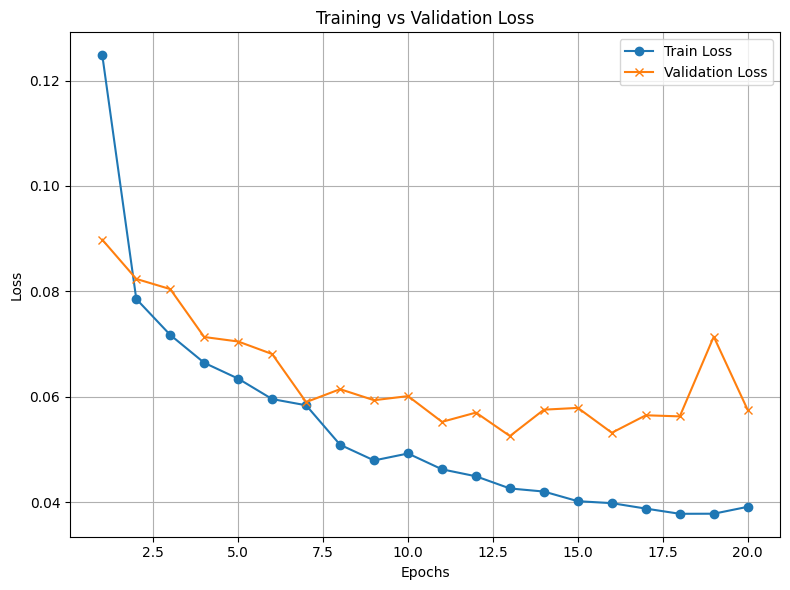

In [70]:
# Visualización de pérdidas
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_loss_list, label="Train Loss", marker='o')
val_epochs = list(range(val_interval, num_epochs + 1, val_interval))
plt.plot(val_epochs, val_loss_list, label="Validation Loss", marker='x')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_1.nii.gz


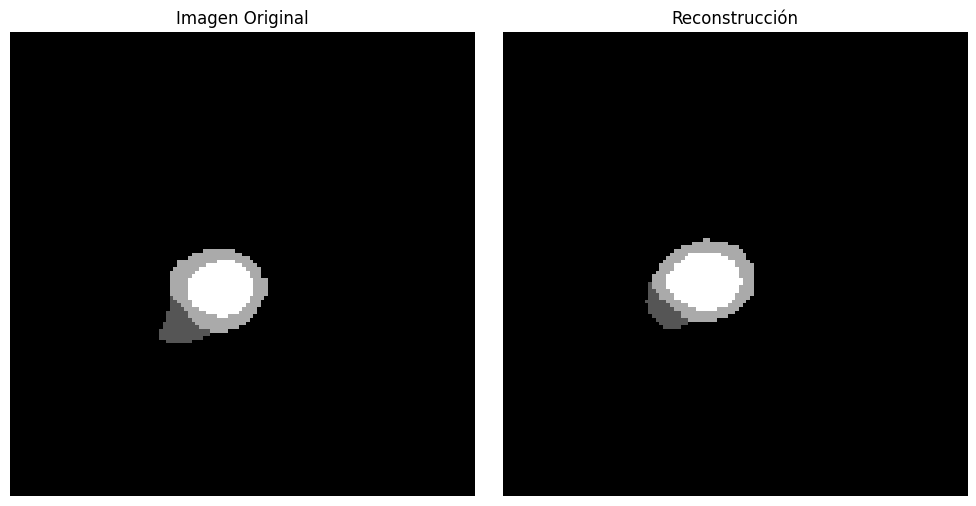

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_2.nii.gz


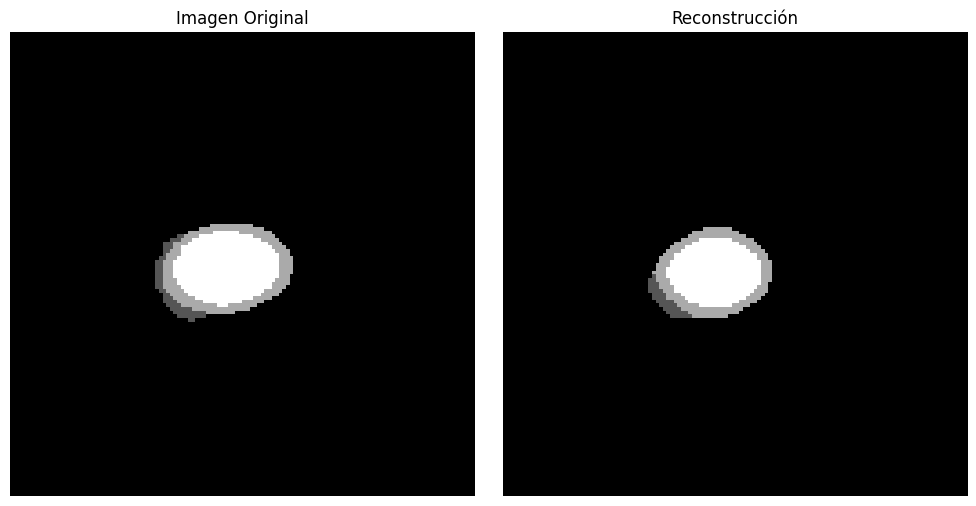

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_3.nii.gz


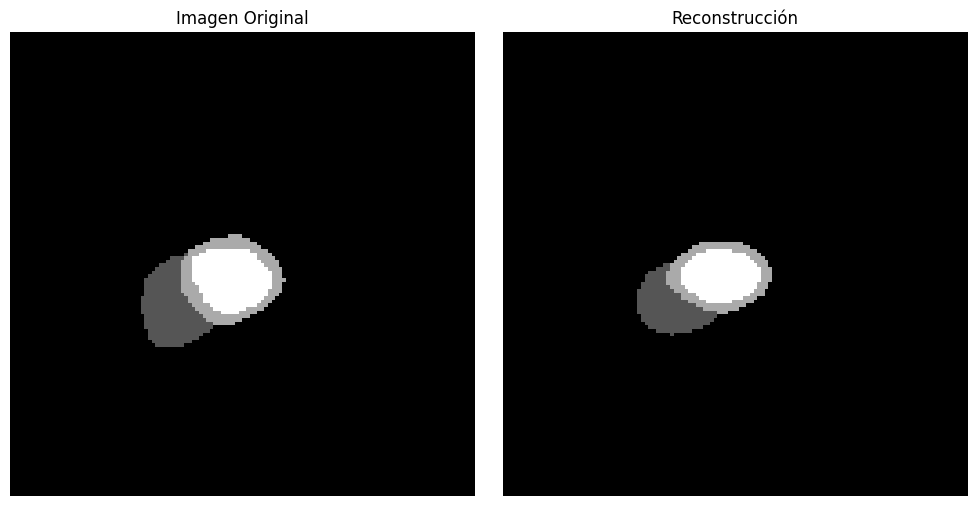

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_4.nii.gz


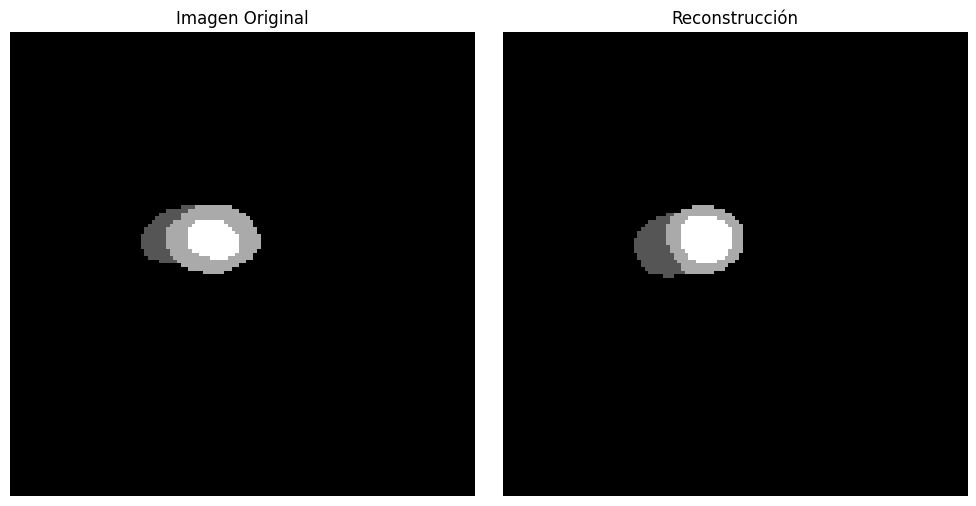

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_5.nii.gz


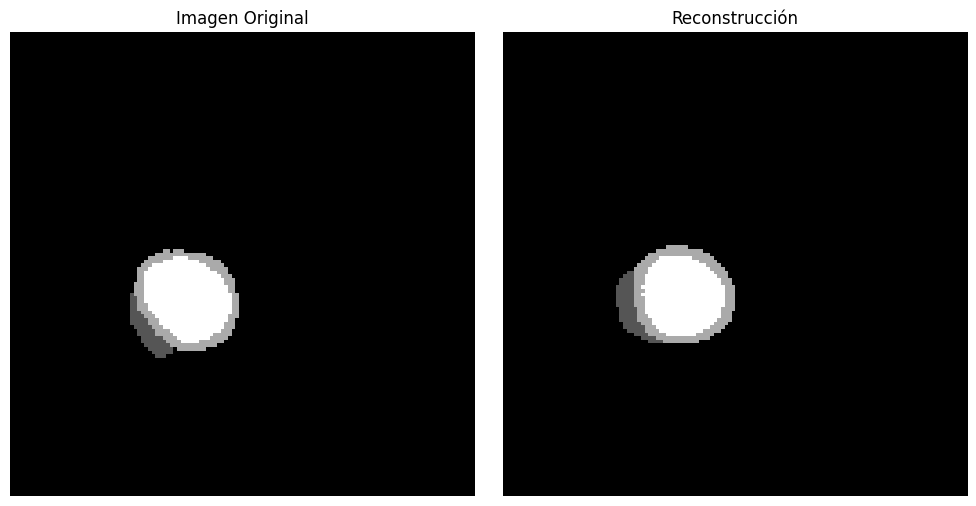

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_6.nii.gz


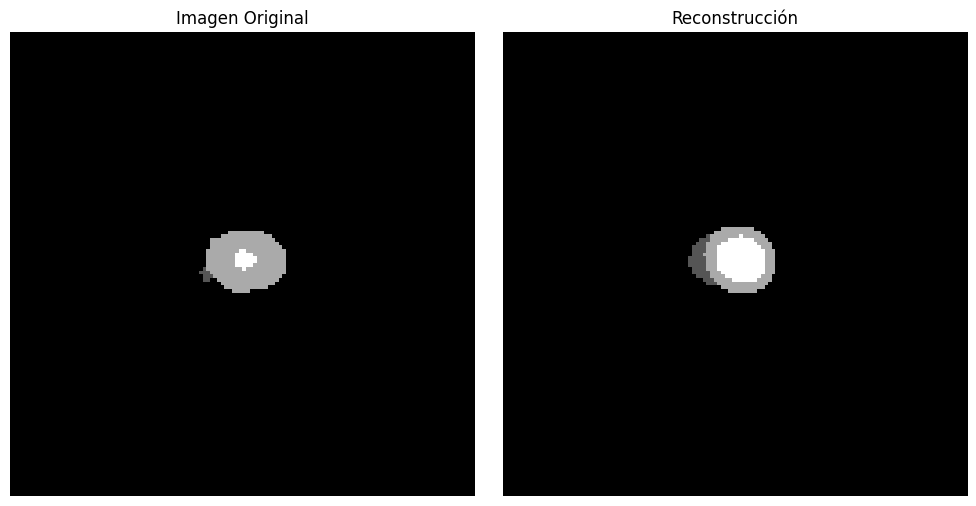

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_7.nii.gz


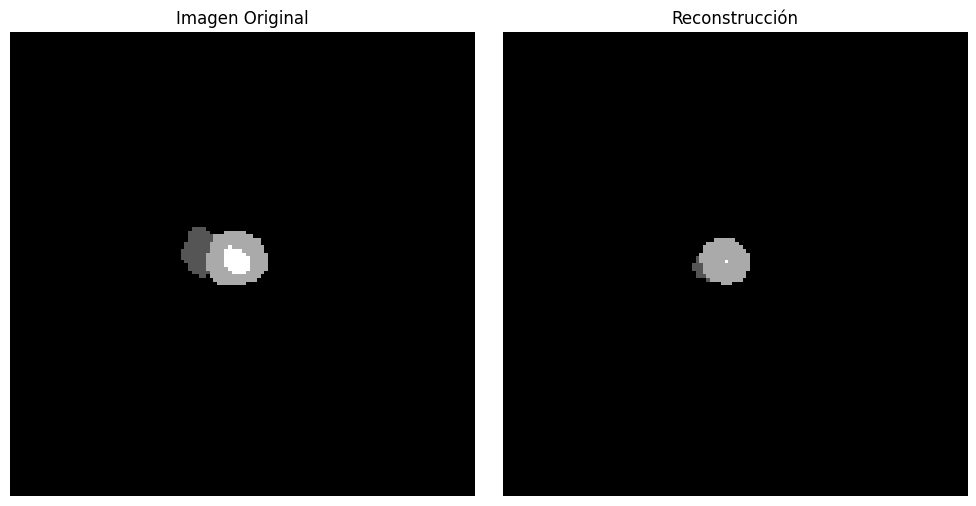

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129325389862
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_8.nii.gz


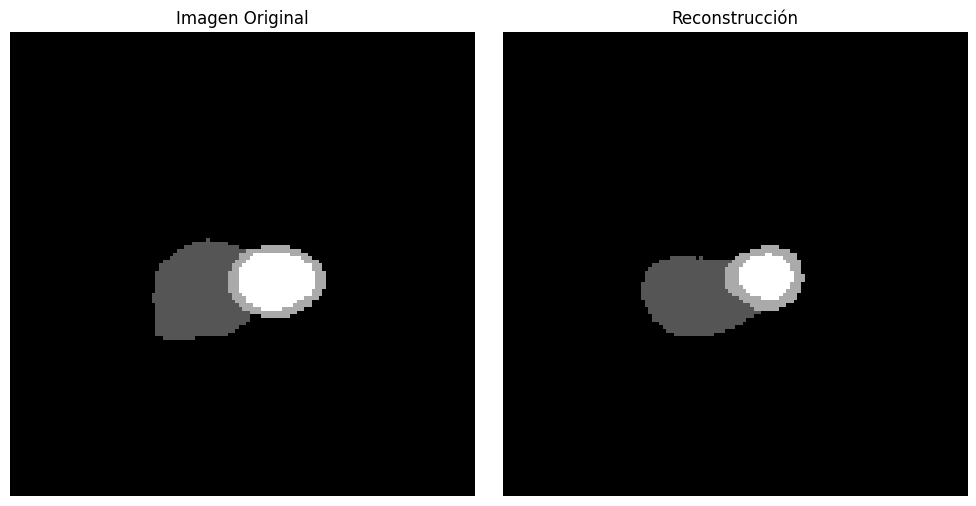

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_9.nii.gz


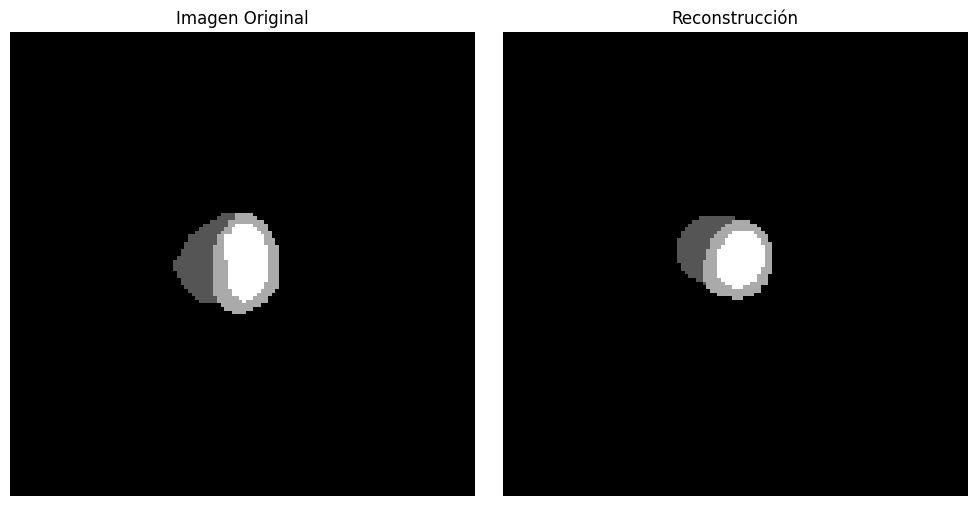

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_10.nii.gz


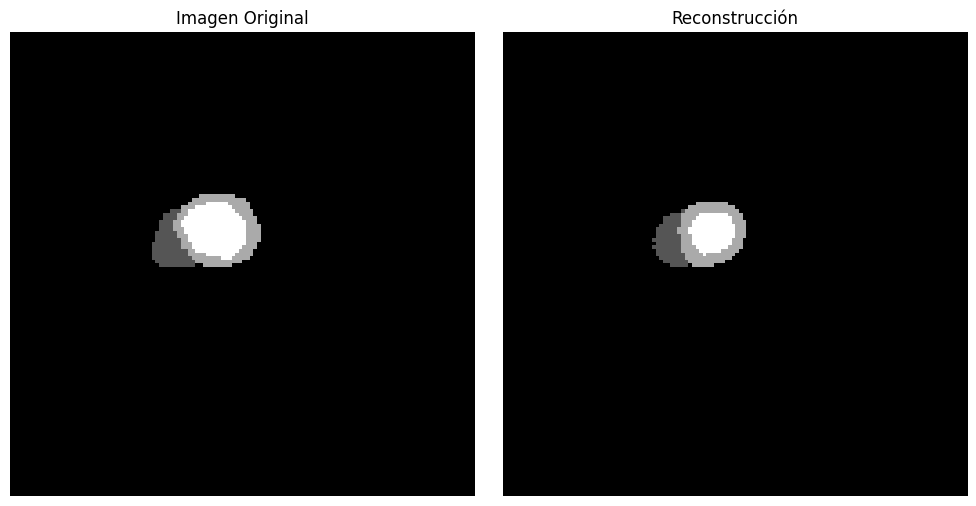

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_11.nii.gz


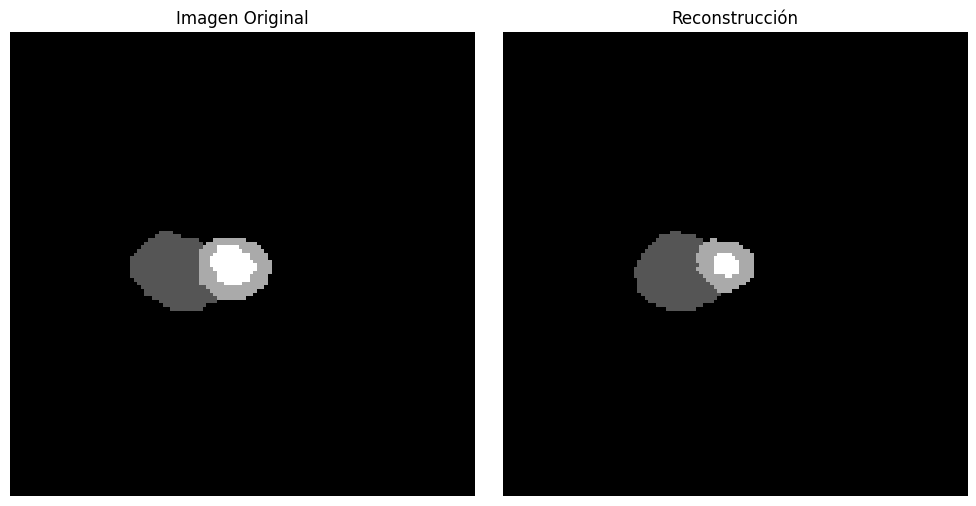

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_12.nii.gz


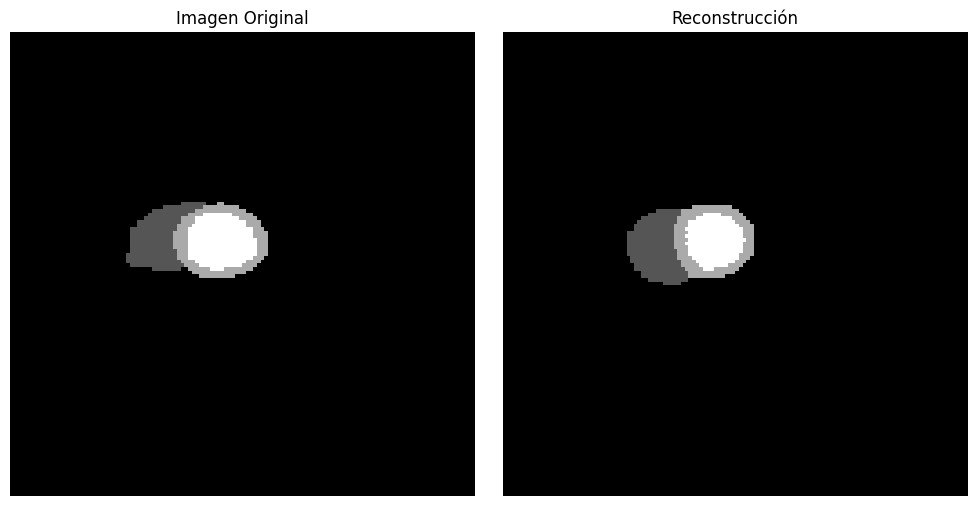

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_13.nii.gz


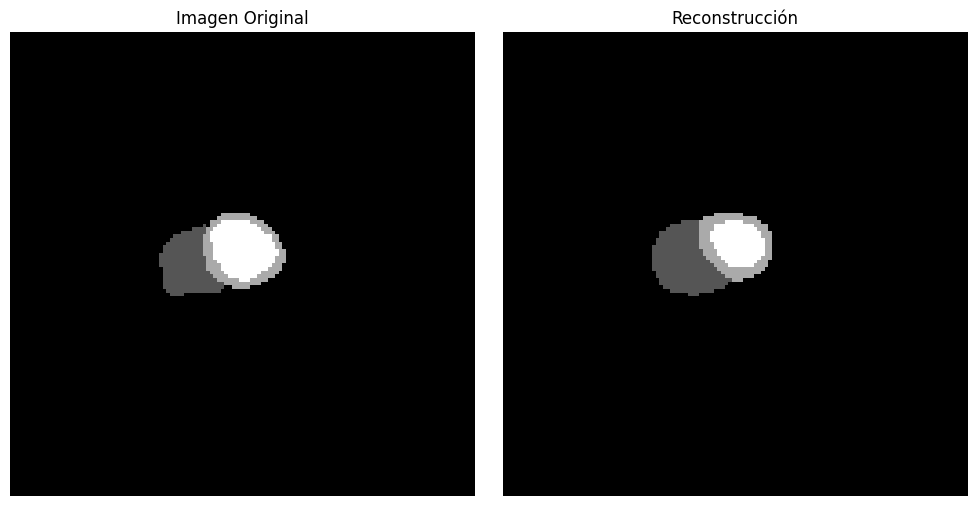

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_14.nii.gz


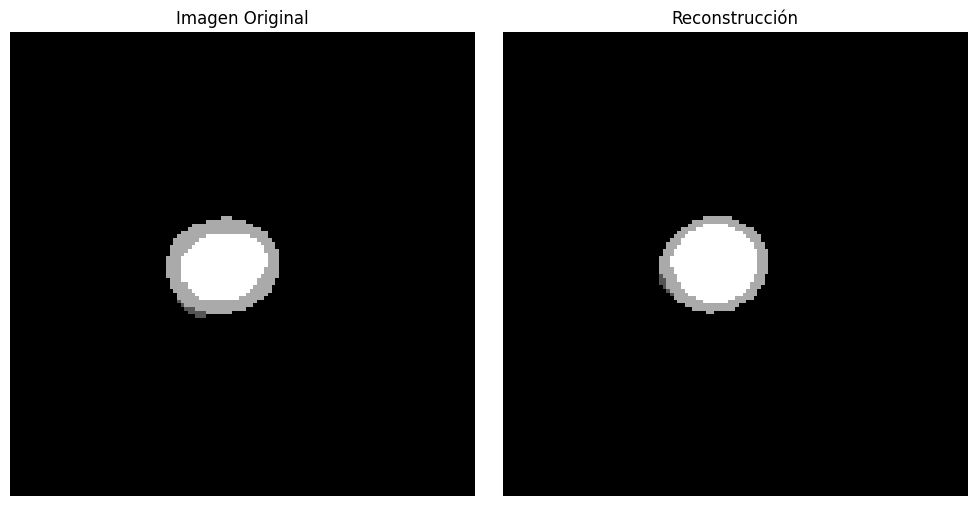

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_15.nii.gz


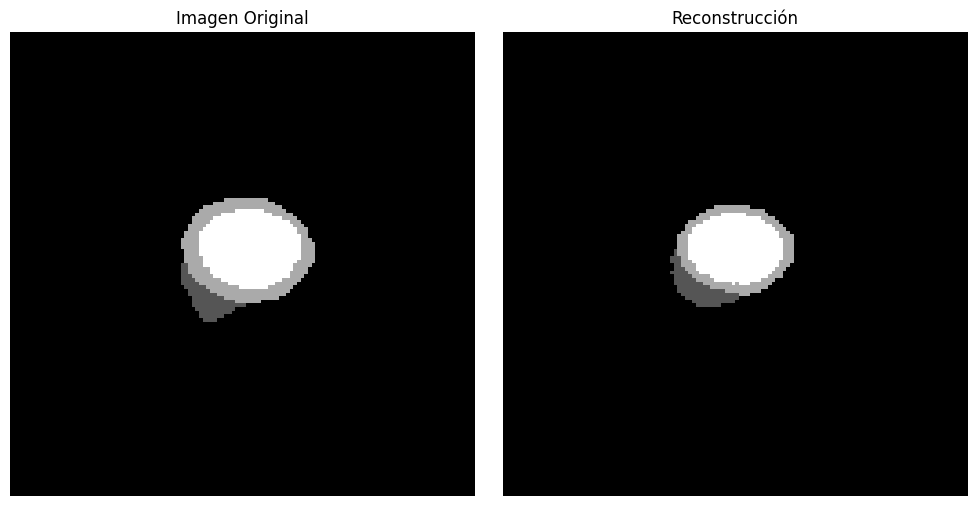

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_16.nii.gz


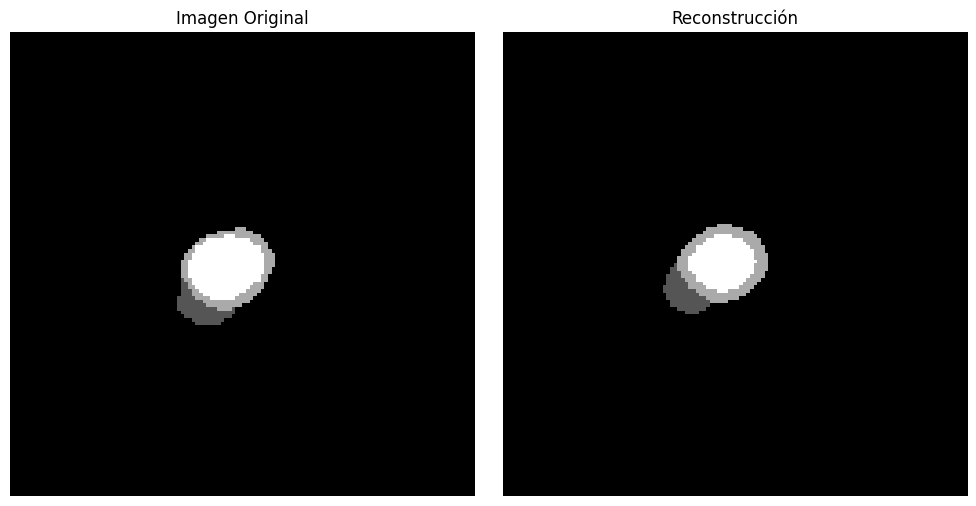

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_17.nii.gz


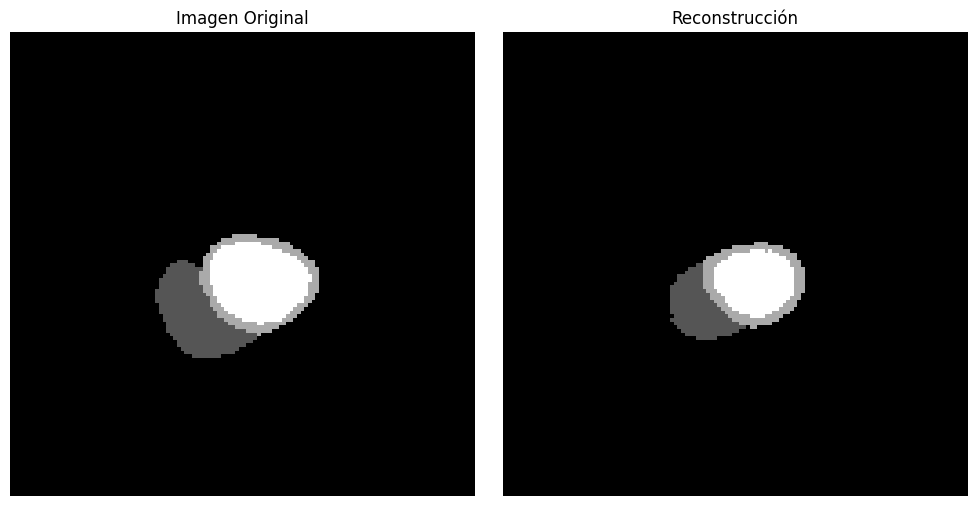

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_18.nii.gz


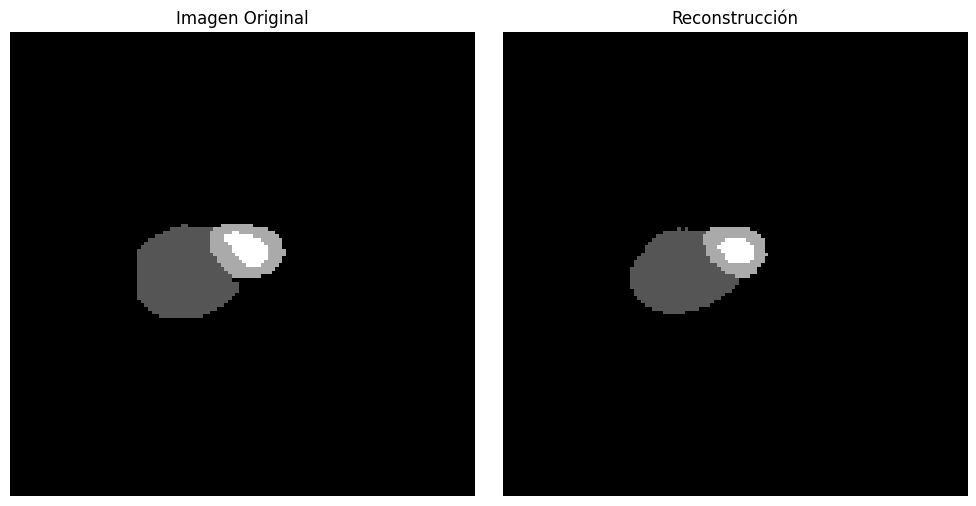

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_19.nii.gz


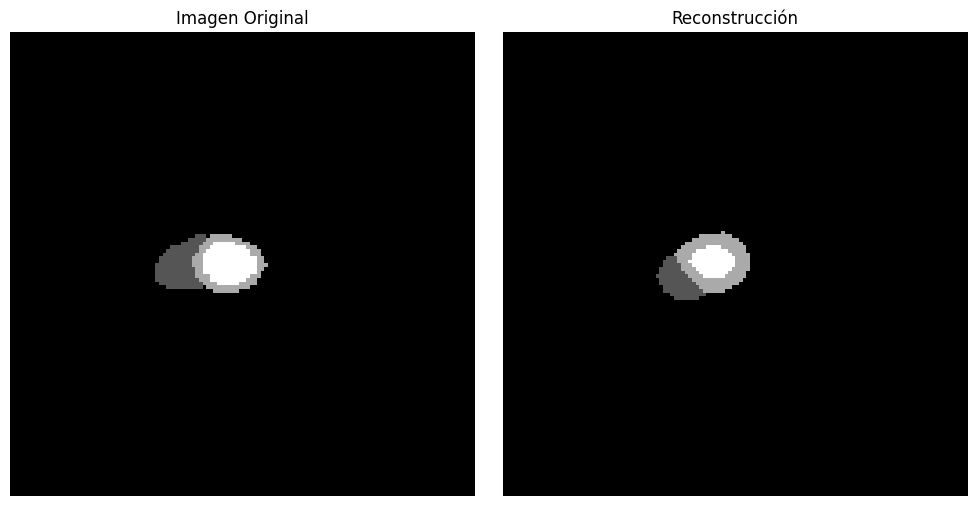

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_20.nii.gz


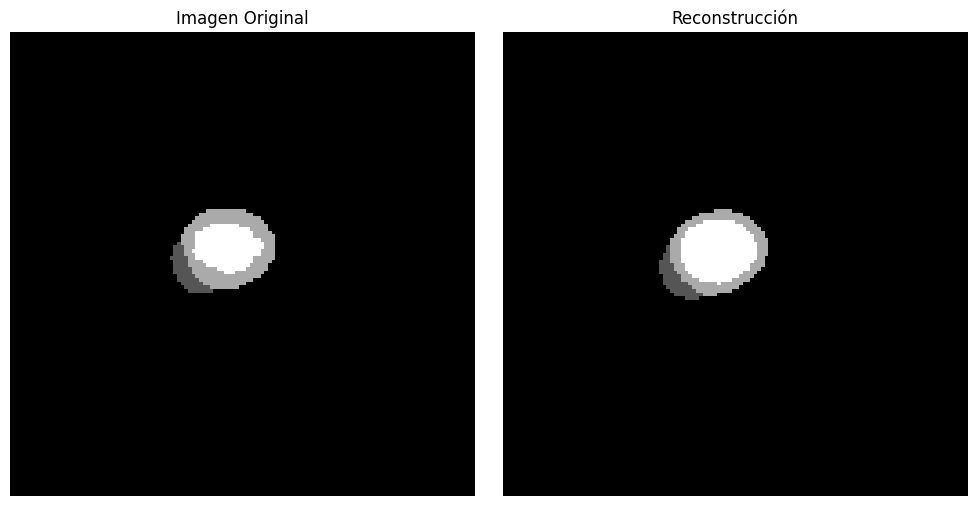

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_21.nii.gz


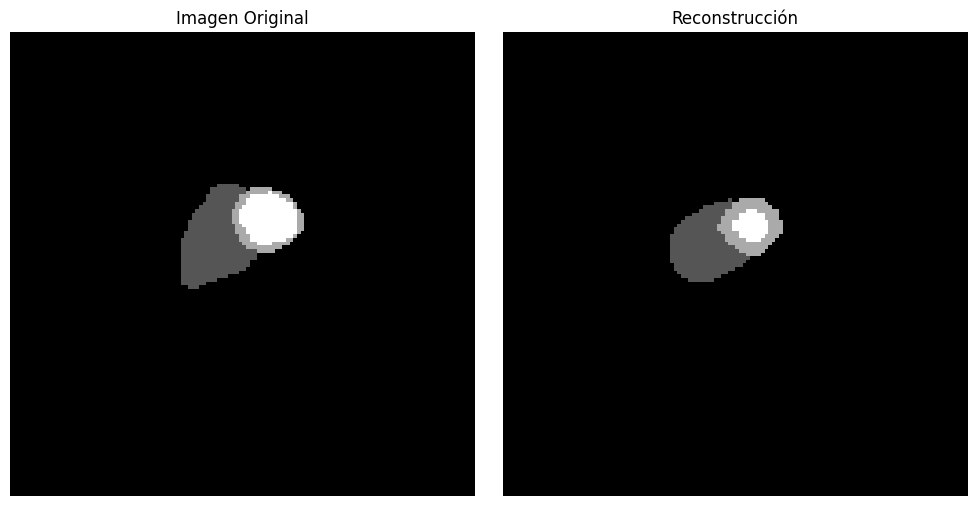

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_22.nii.gz


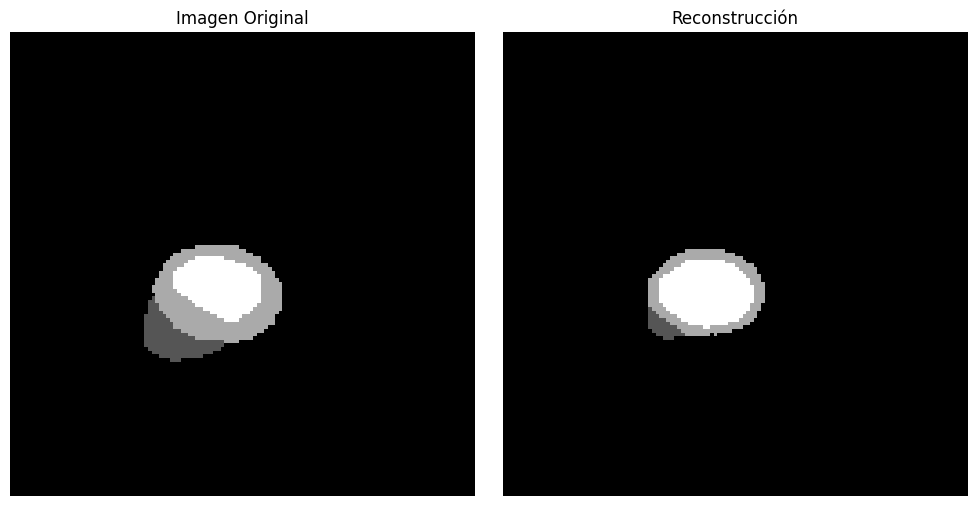

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129325389862
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_23.nii.gz


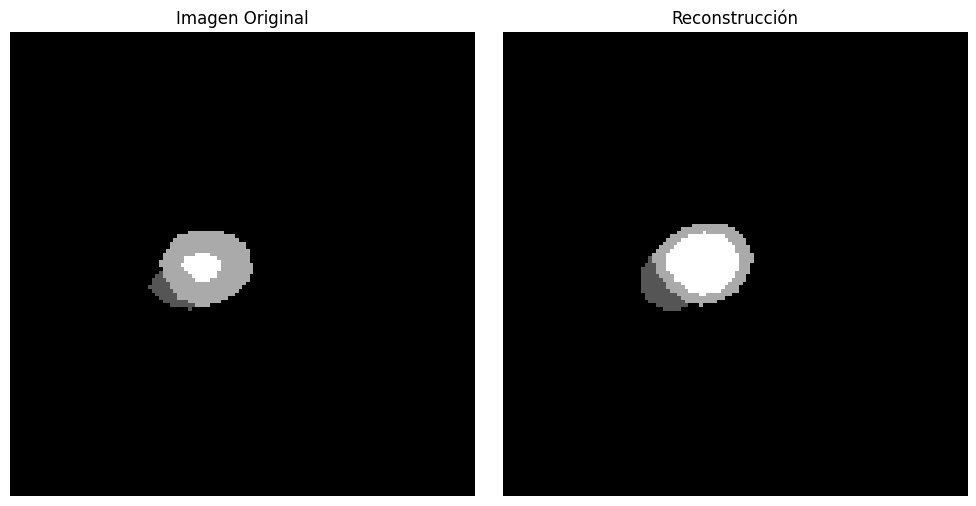

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_24.nii.gz


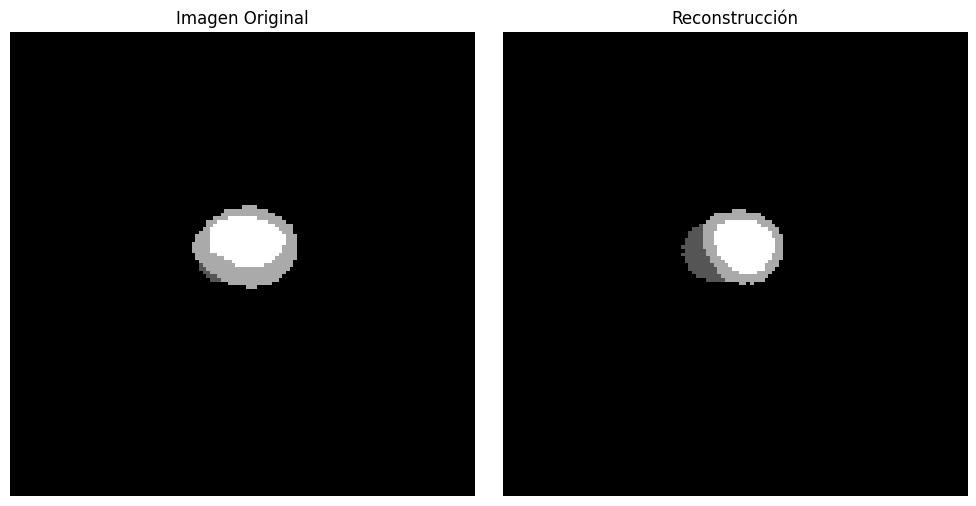

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_25.nii.gz


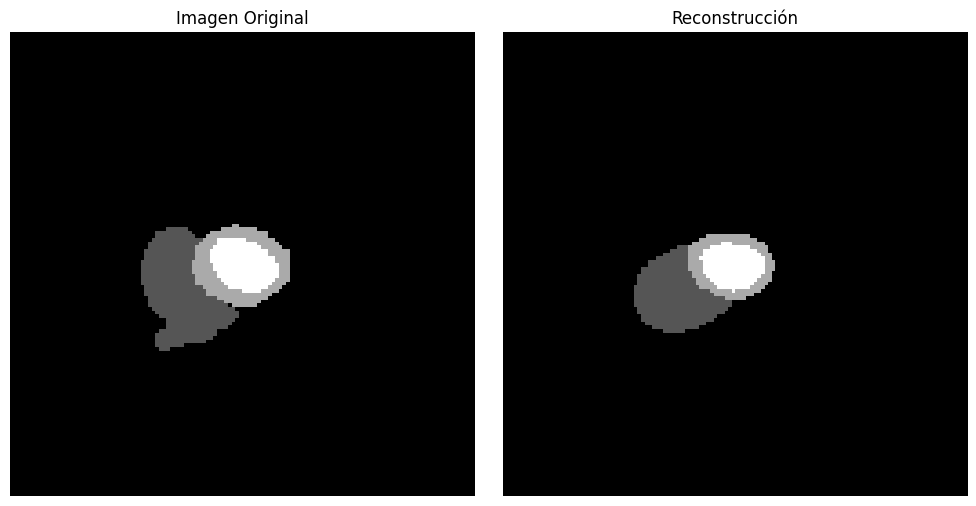

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_26.nii.gz


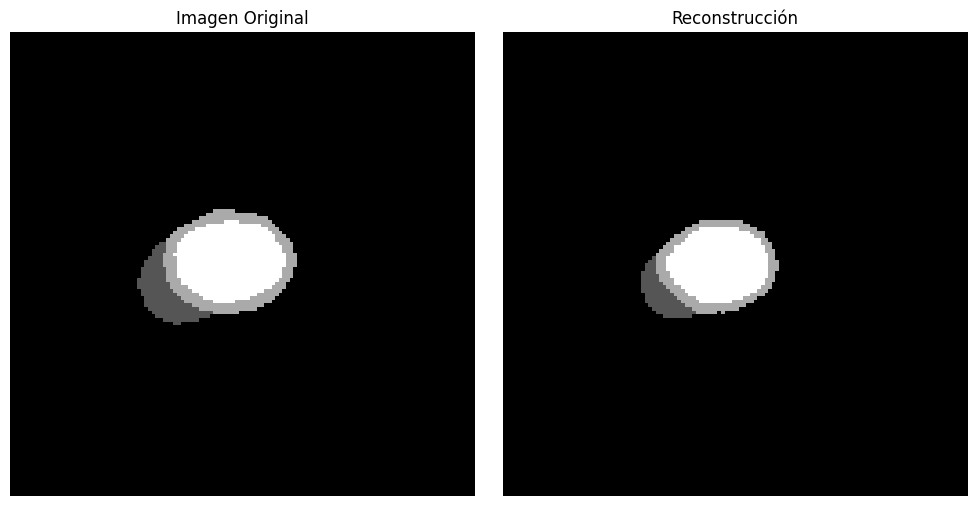

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_27.nii.gz


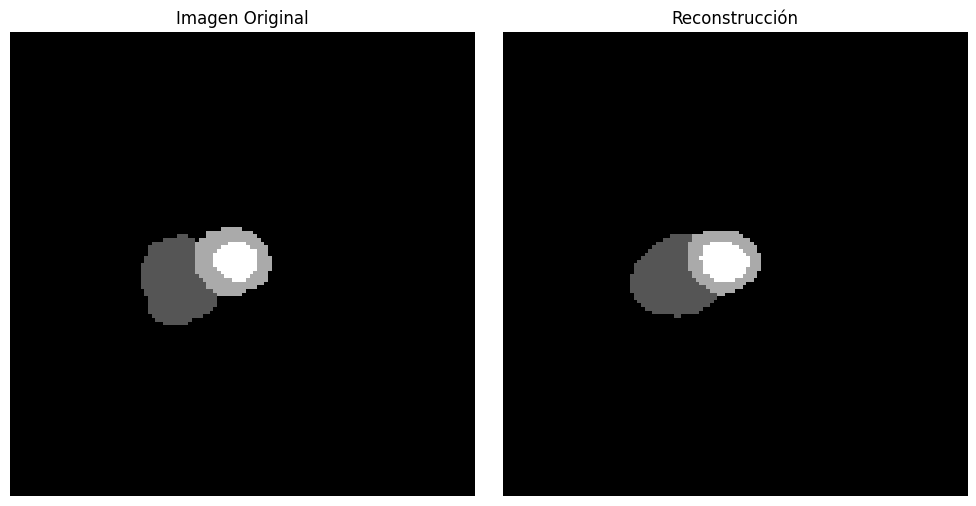

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_28.nii.gz


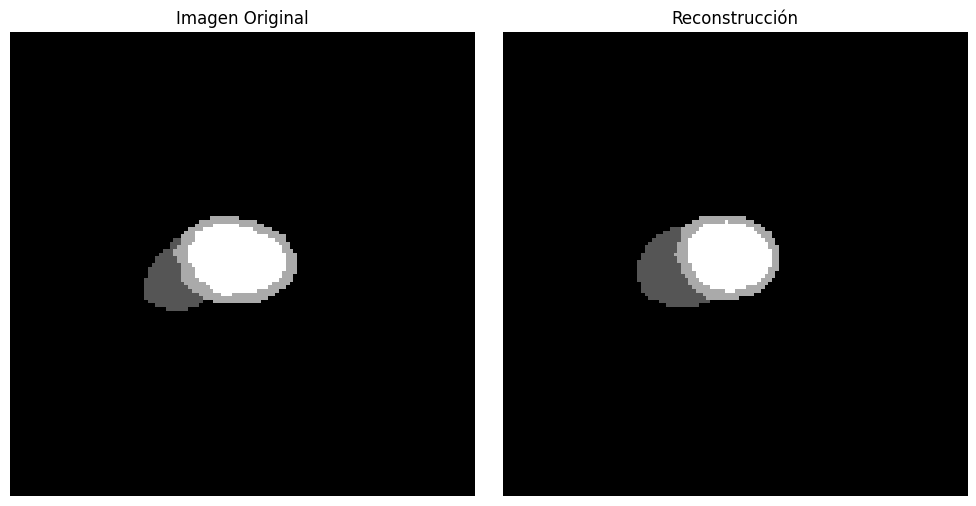

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_29.nii.gz


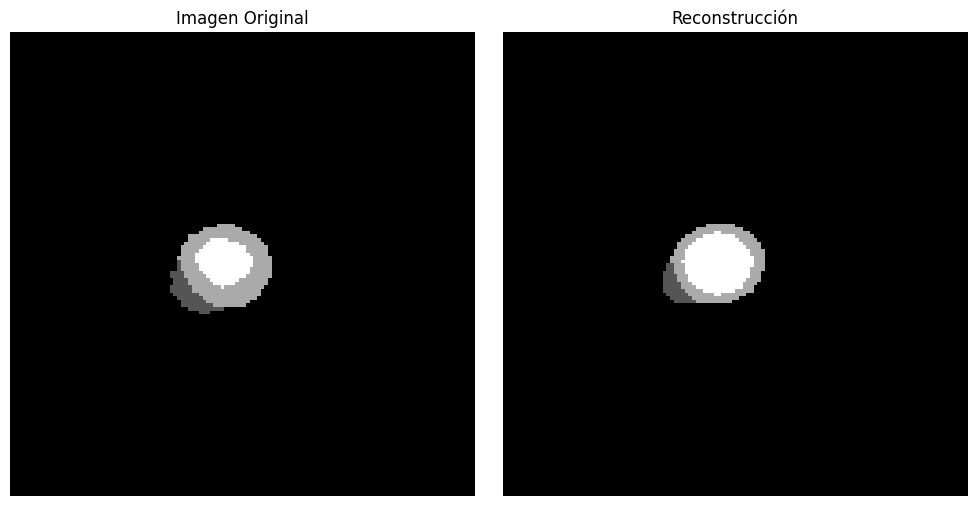

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_30.nii.gz


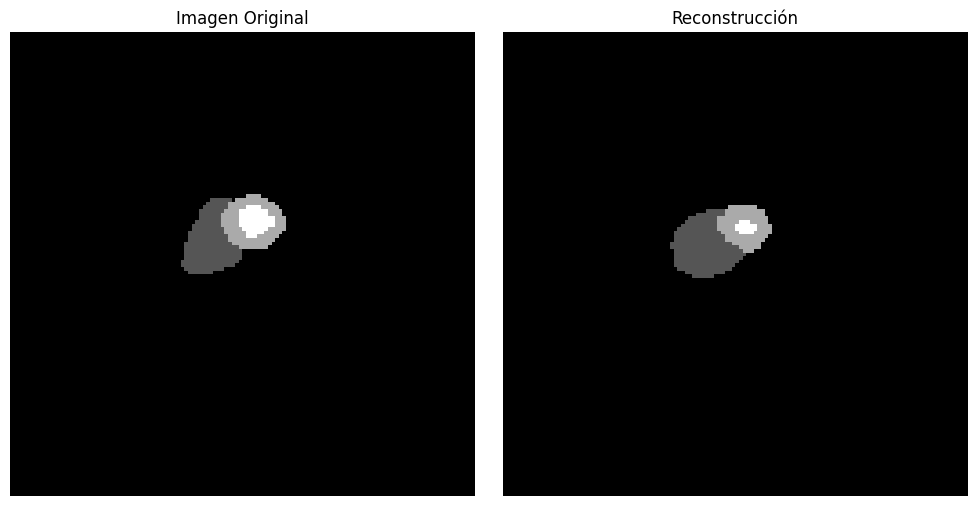

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_31.nii.gz


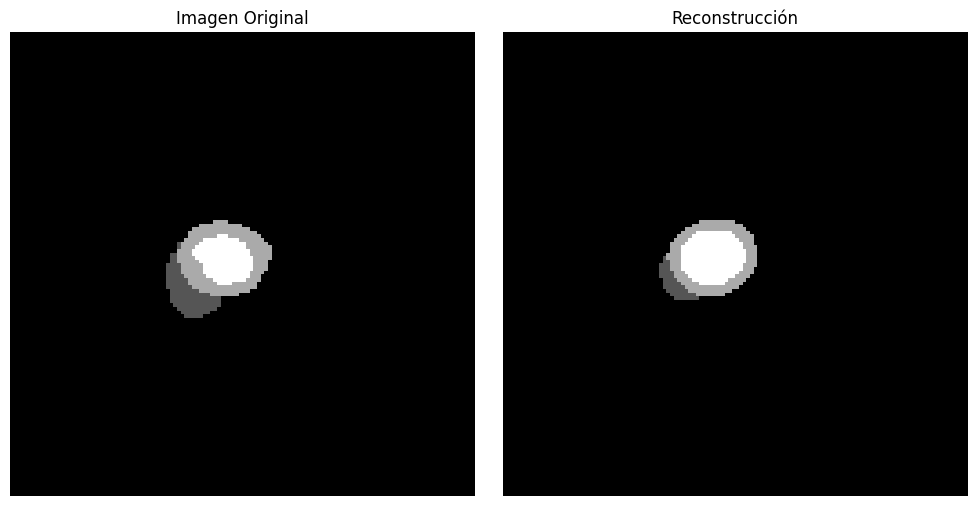

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_32.nii.gz


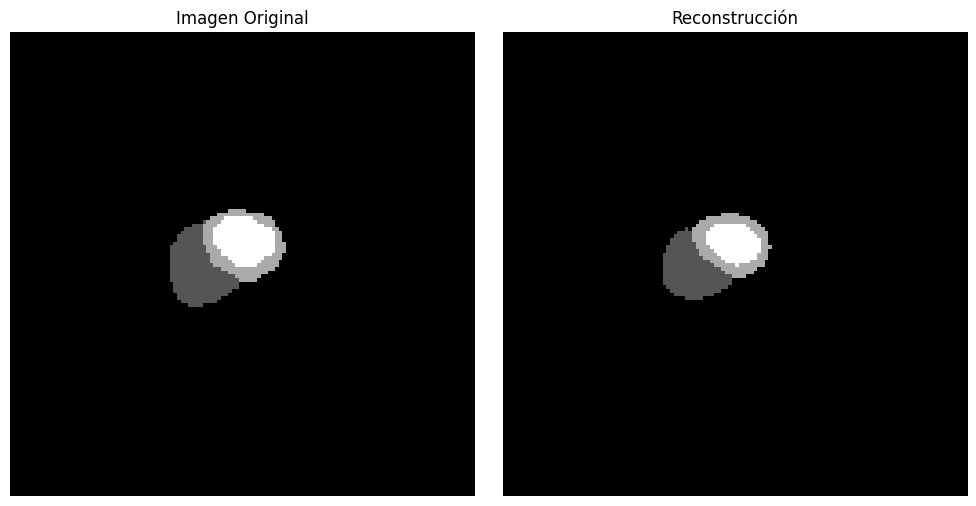

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_33.nii.gz


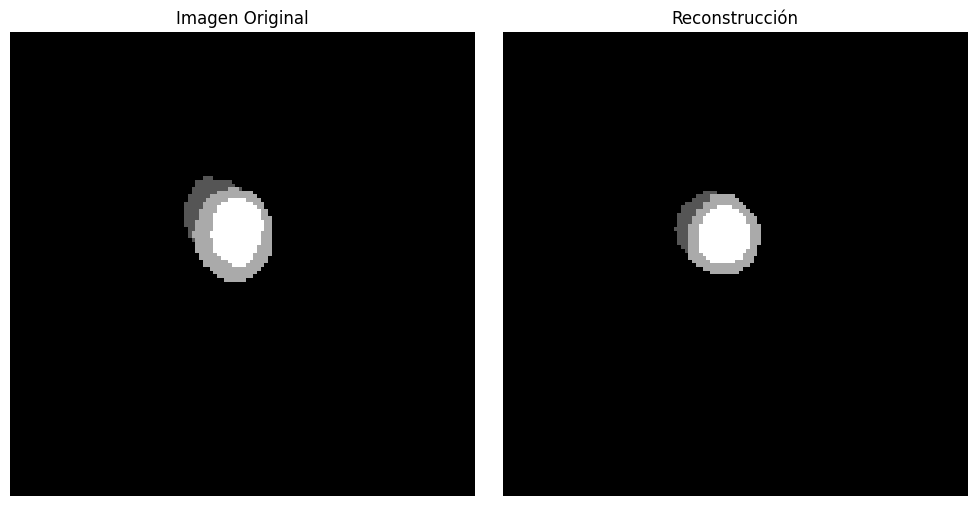

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129325389862
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_34.nii.gz


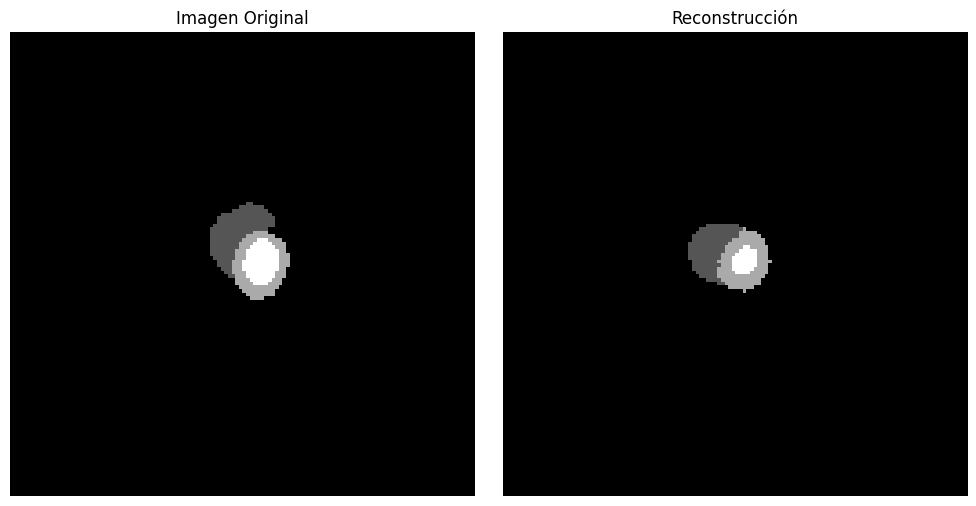

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_35.nii.gz


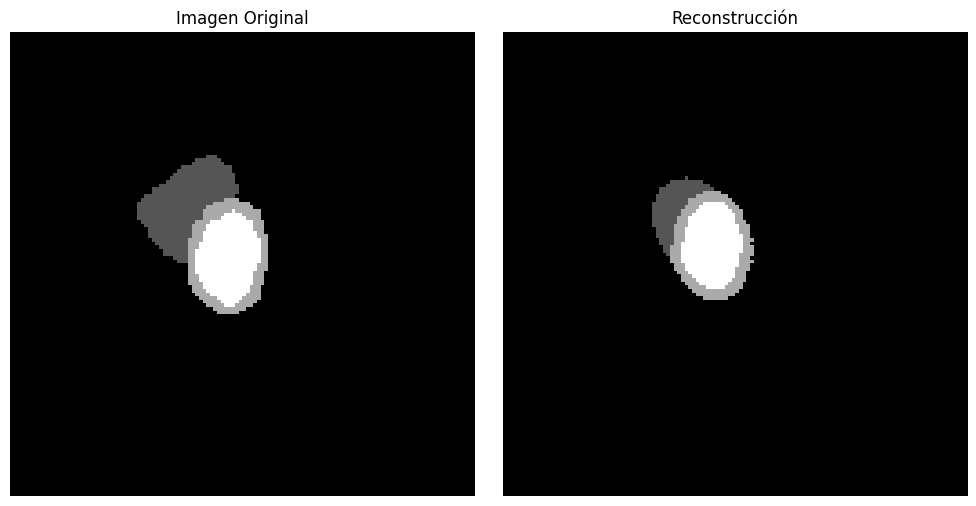

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_36.nii.gz


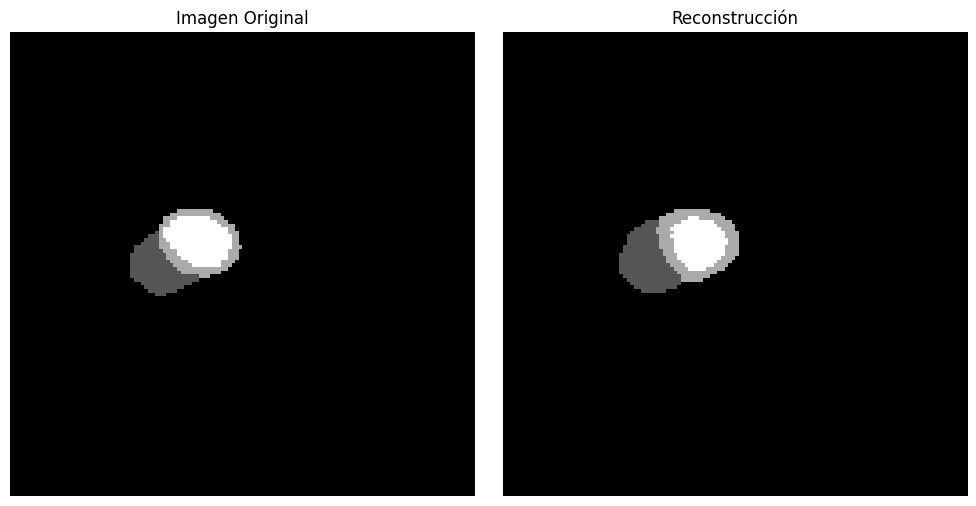

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_37.nii.gz


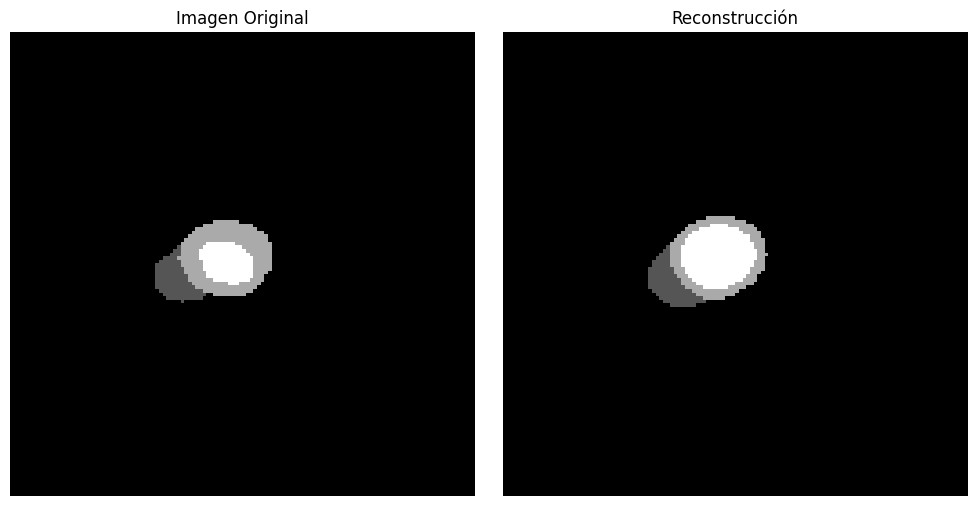

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_38.nii.gz


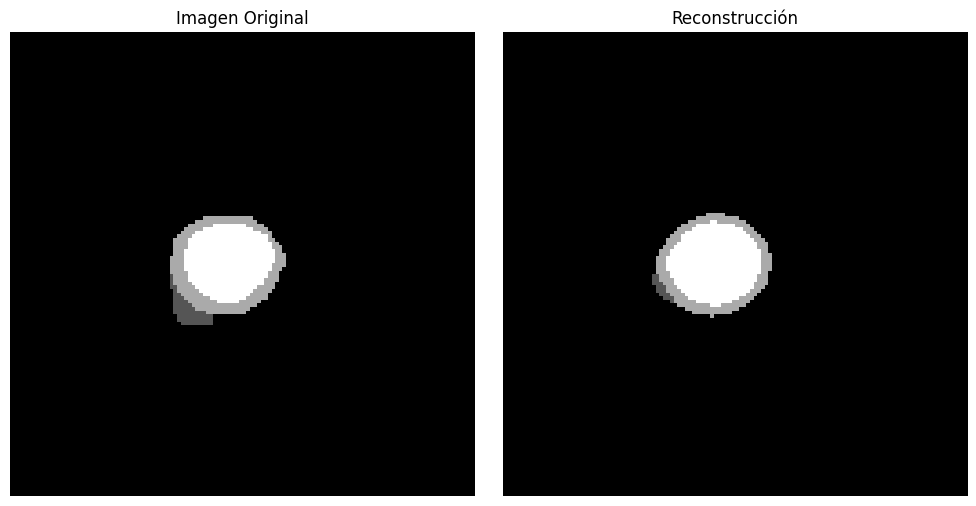

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_39.nii.gz


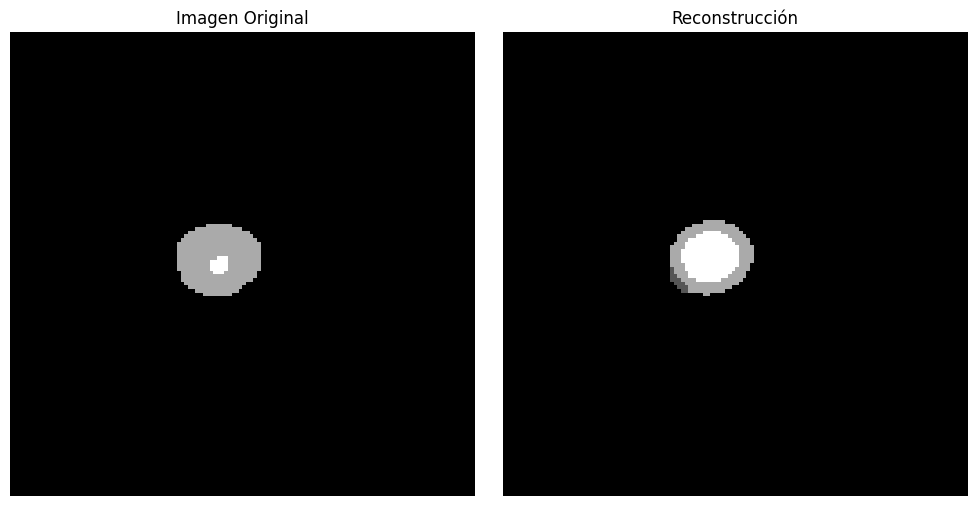

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_40.nii.gz


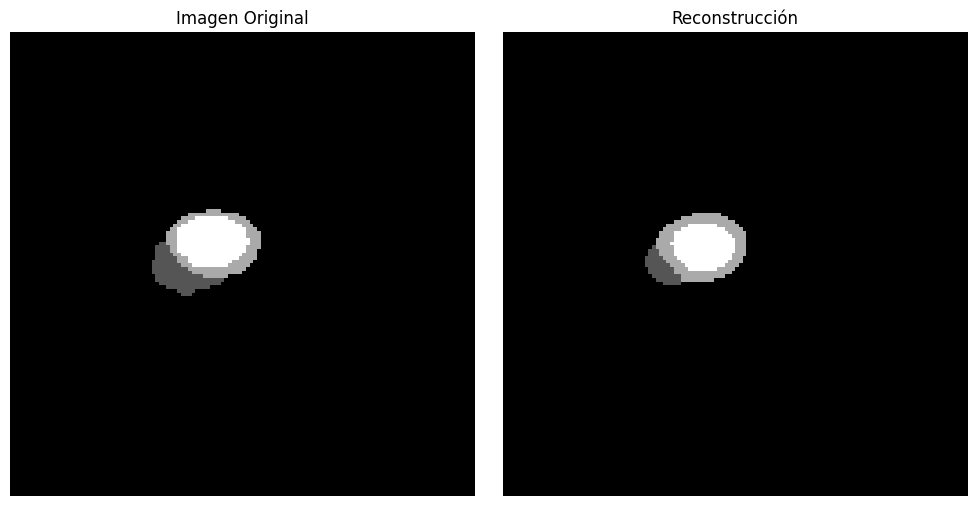

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129325389862
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_41.nii.gz


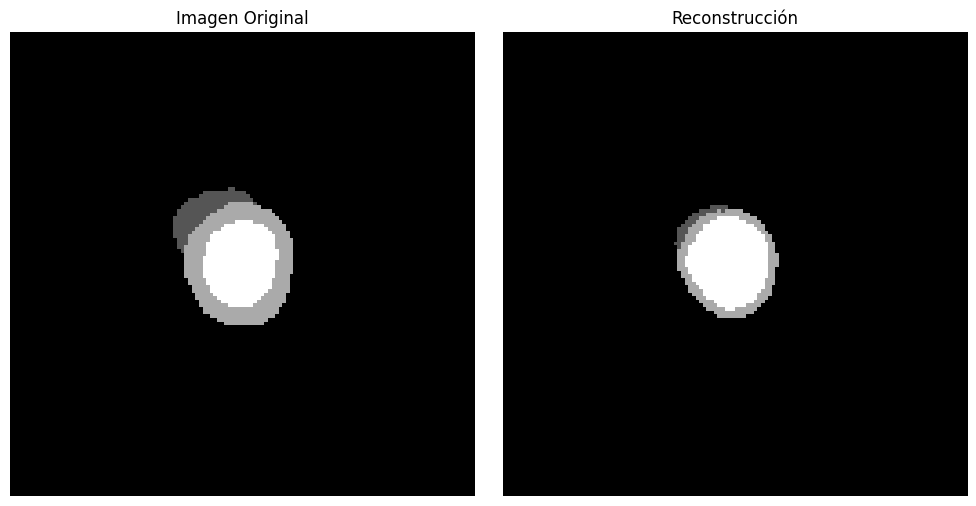

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129325389862
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_42.nii.gz


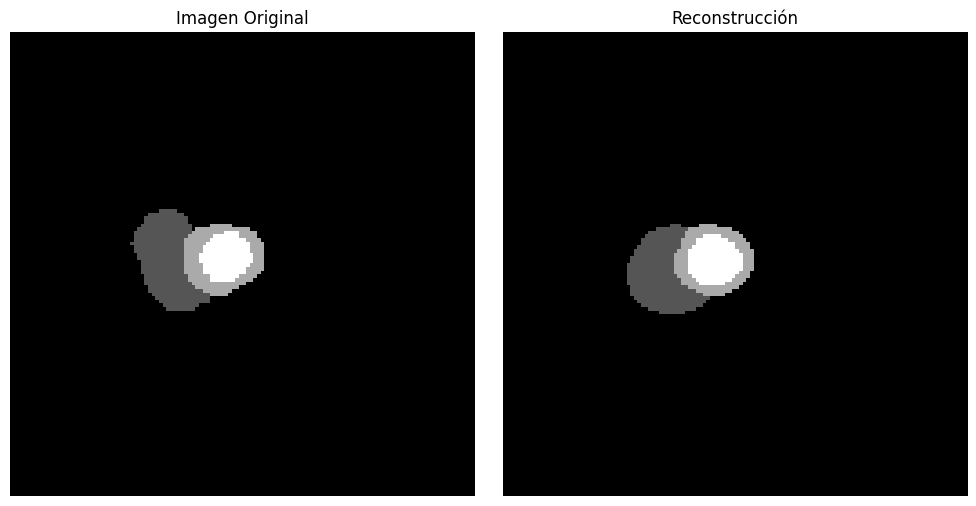

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_43.nii.gz


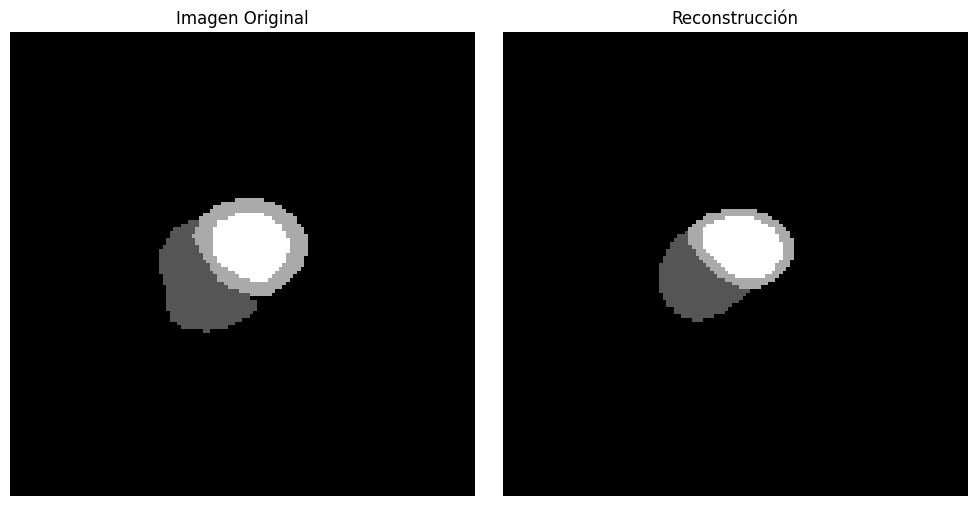

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_44.nii.gz


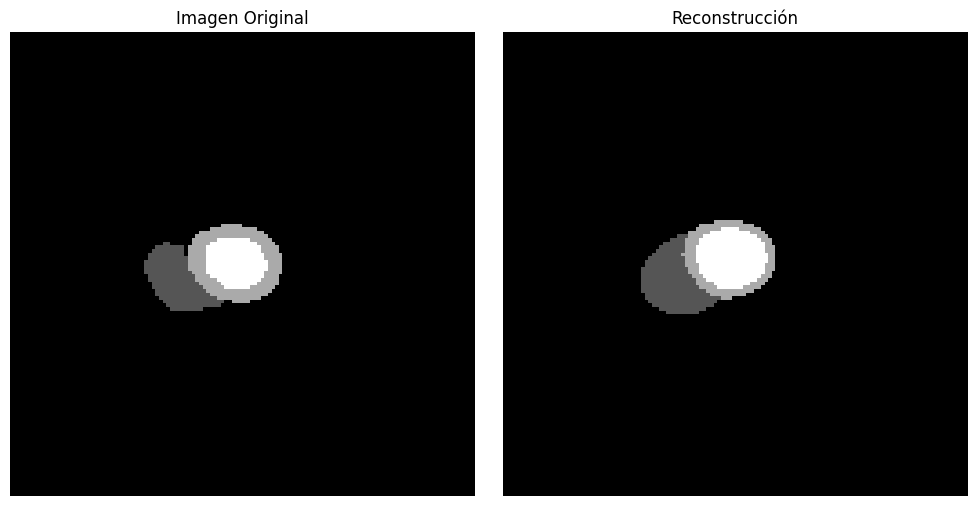

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_45.nii.gz


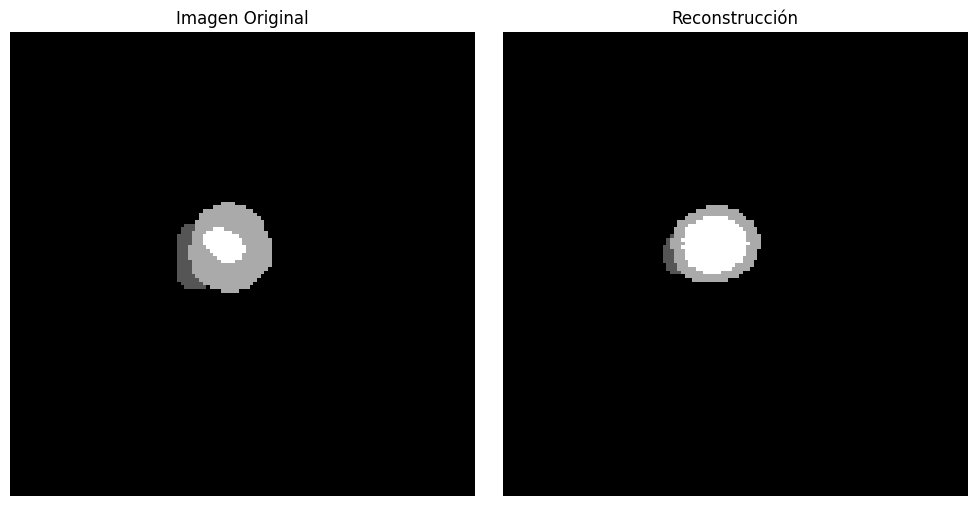

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_46.nii.gz


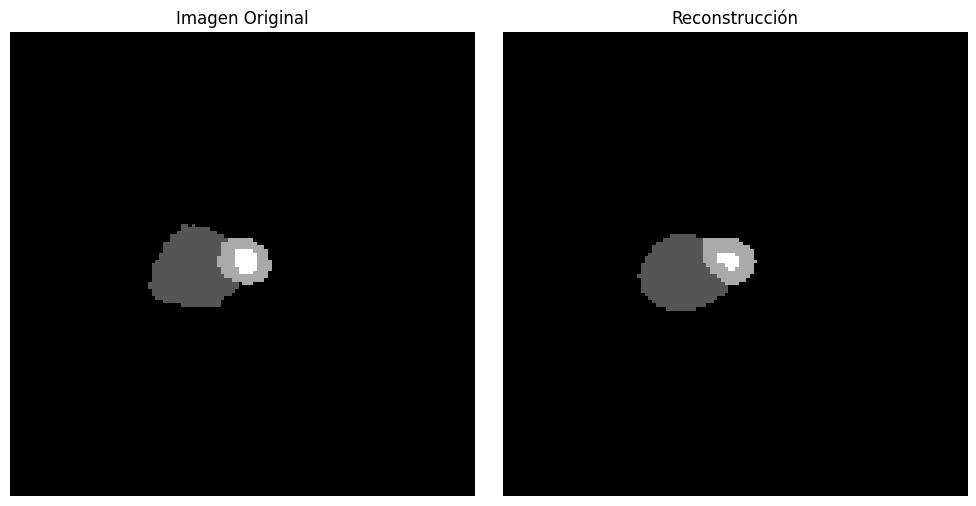

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_47.nii.gz


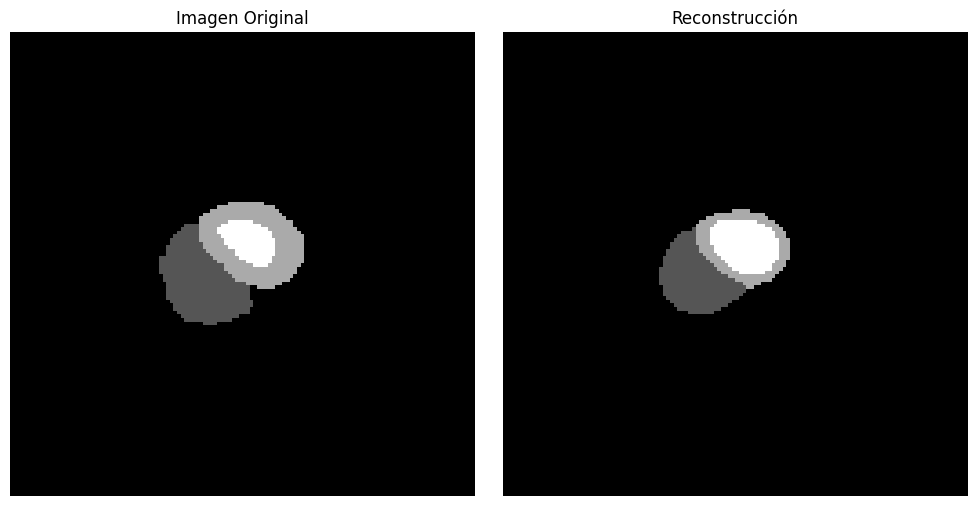

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_48.nii.gz


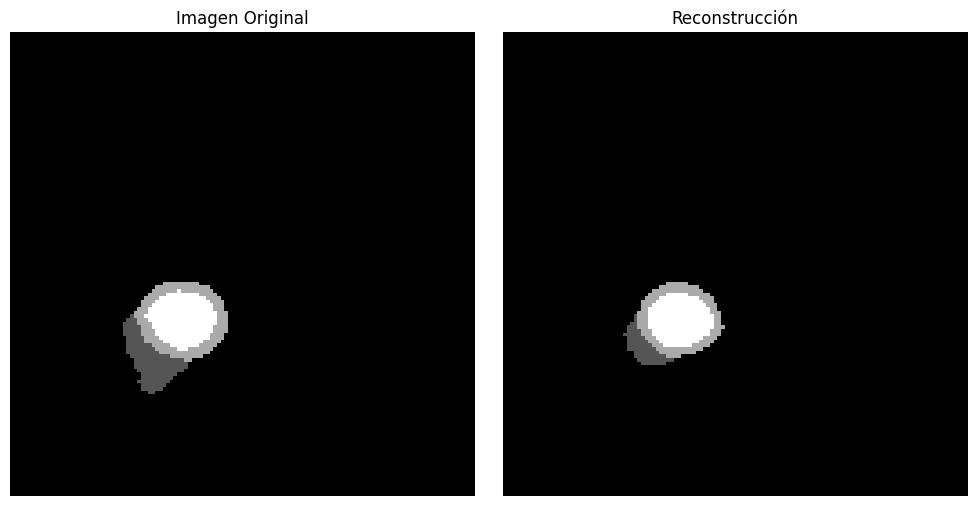

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_49.nii.gz


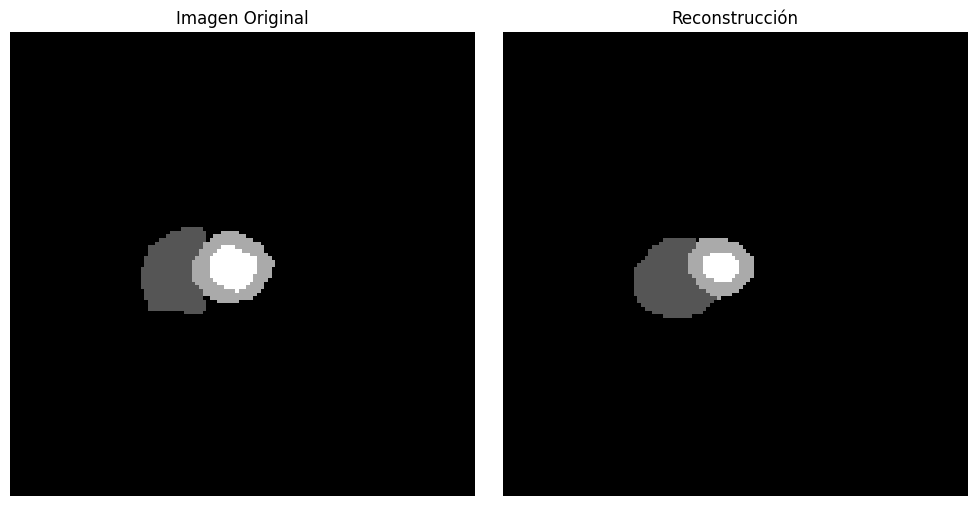

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_50.nii.gz


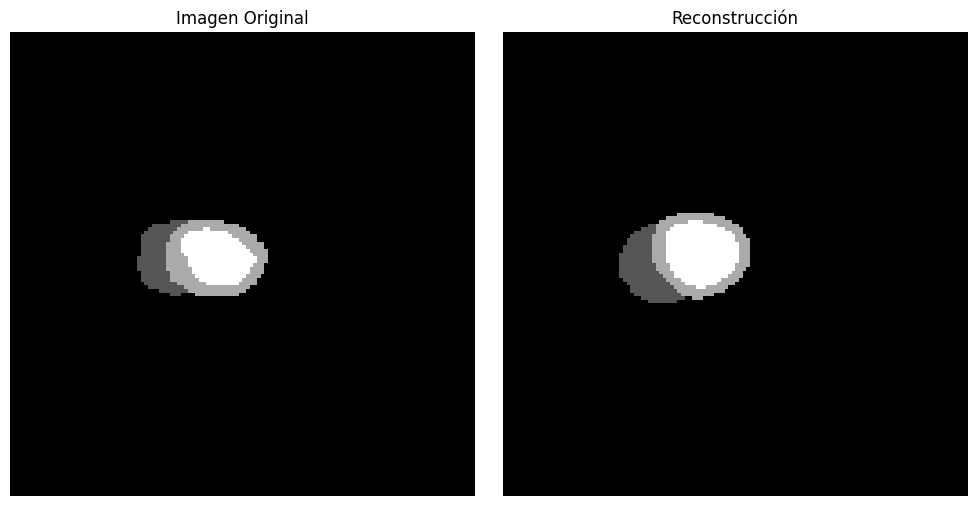

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_51.nii.gz


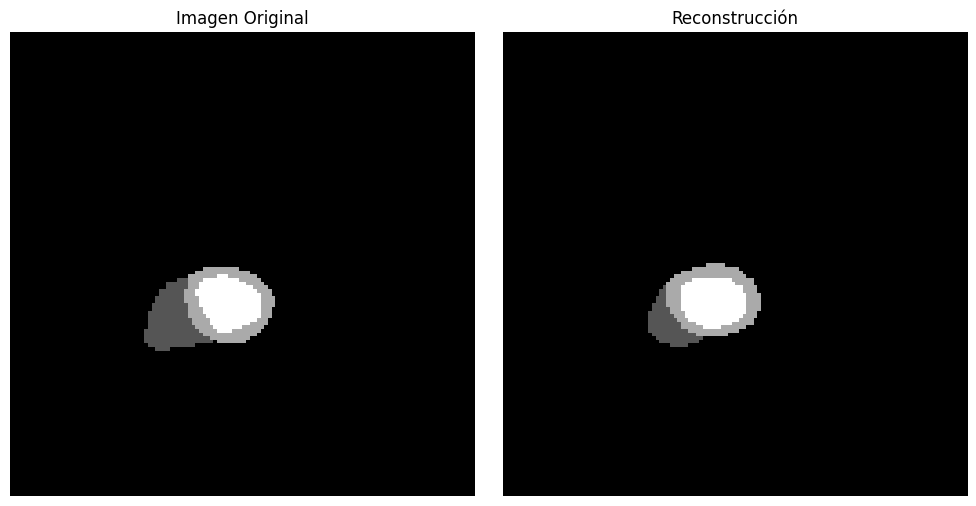

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_52.nii.gz


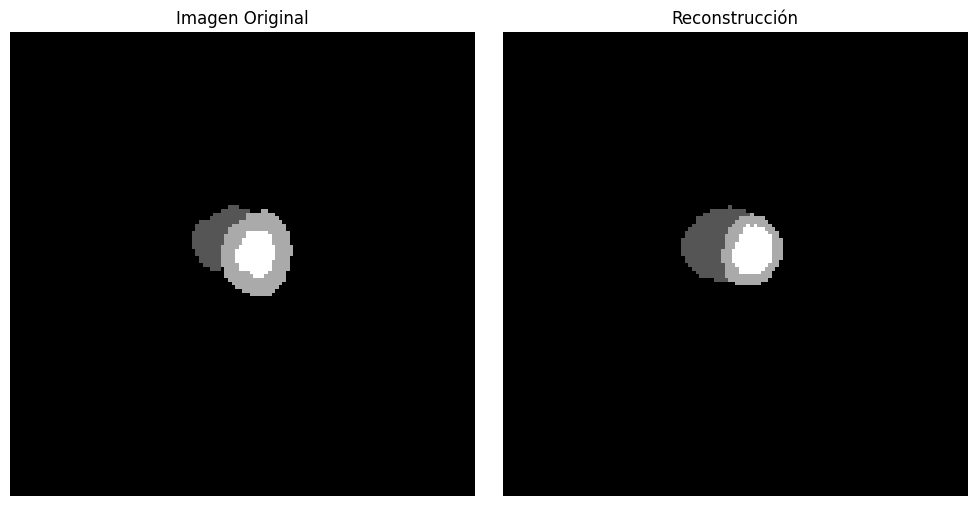

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129325389862
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_53.nii.gz


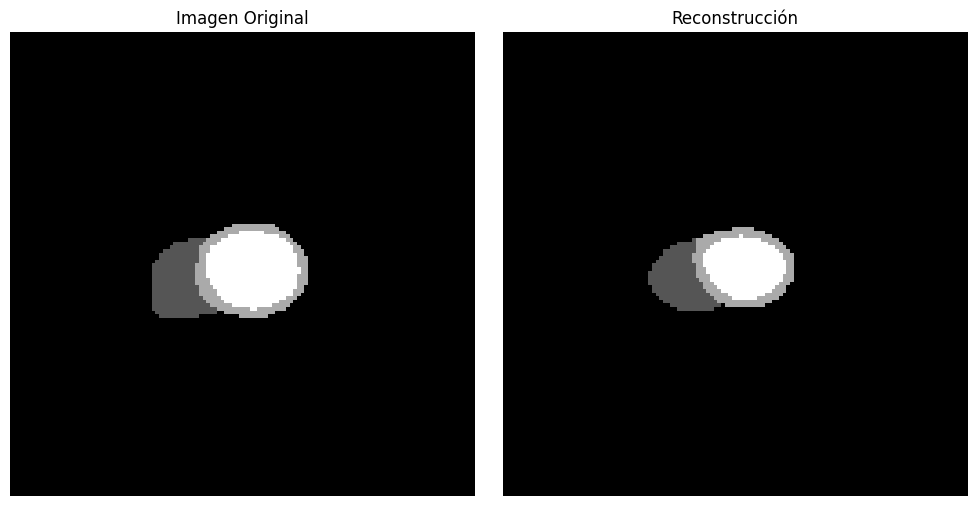

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_54.nii.gz


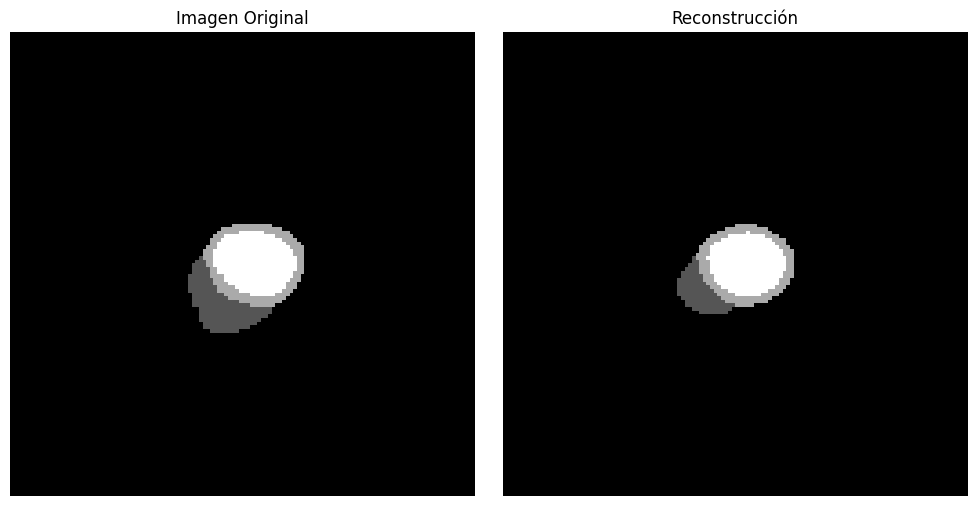

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_55.nii.gz


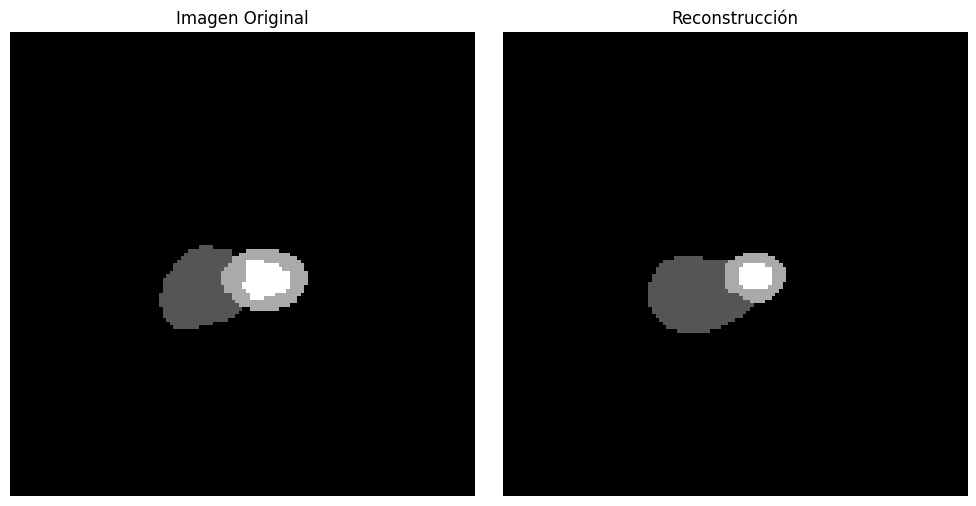

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_56.nii.gz


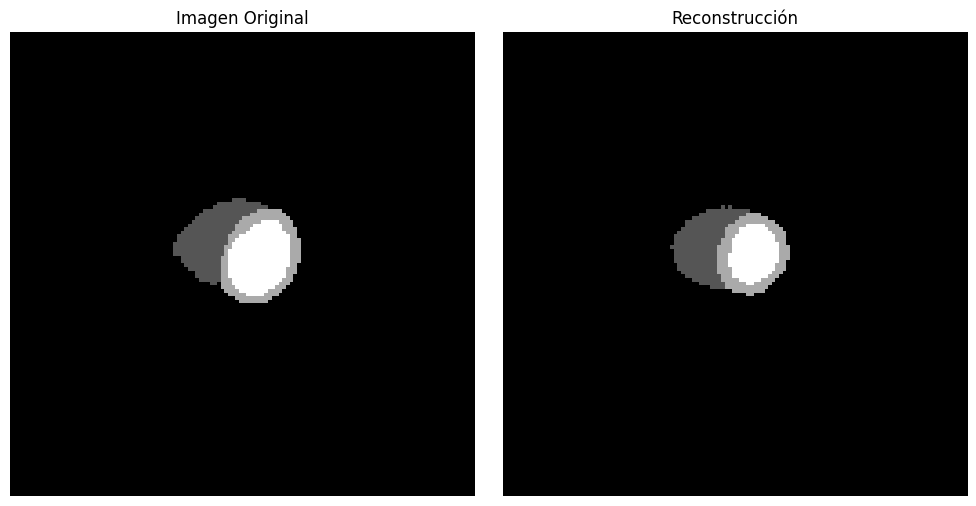

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_57.nii.gz


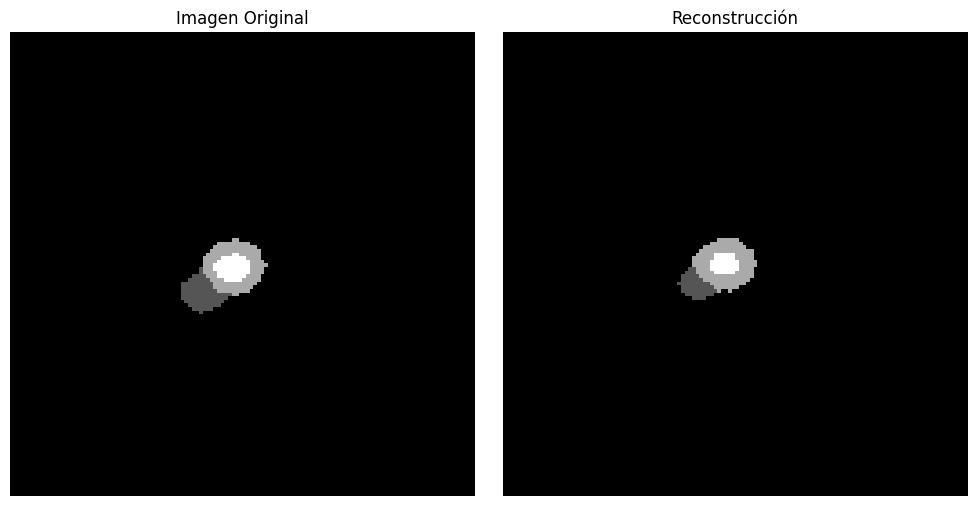

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_58.nii.gz


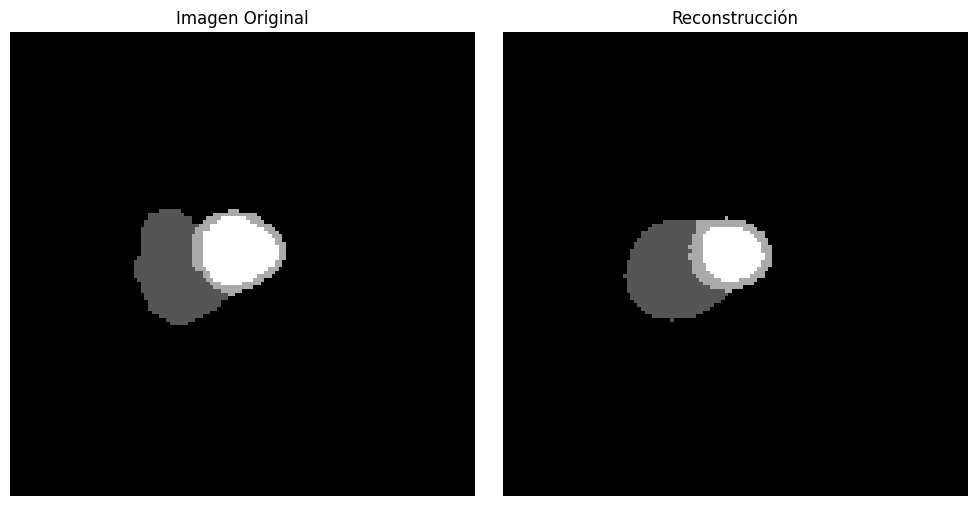

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_59.nii.gz


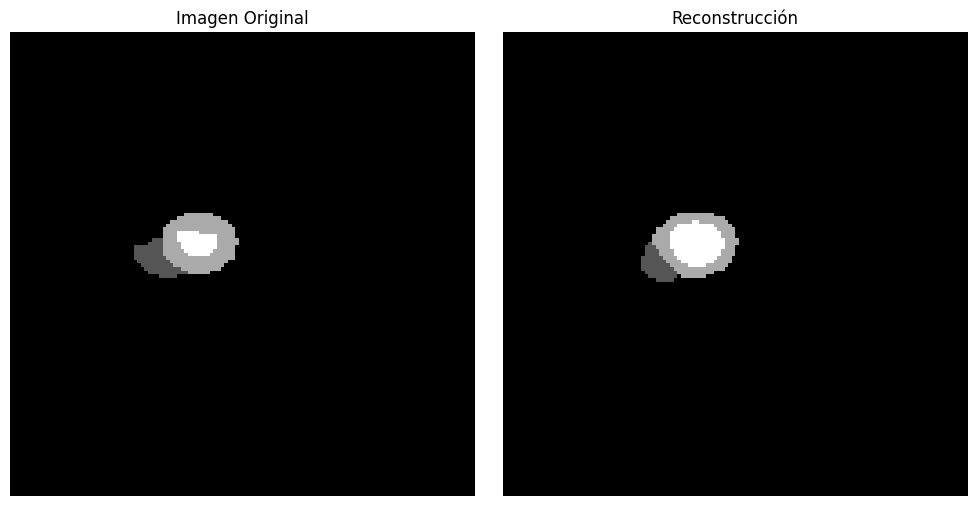

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_60.nii.gz


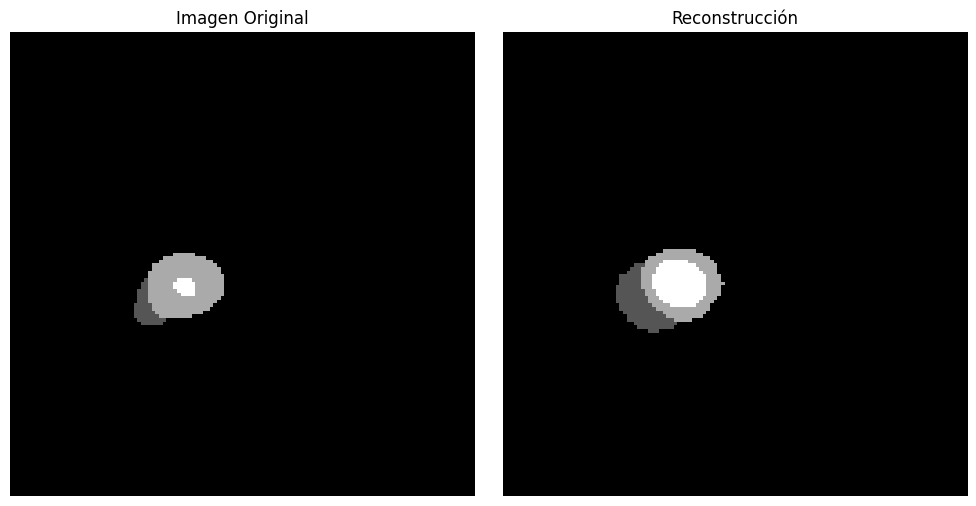

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129325389862
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_61.nii.gz


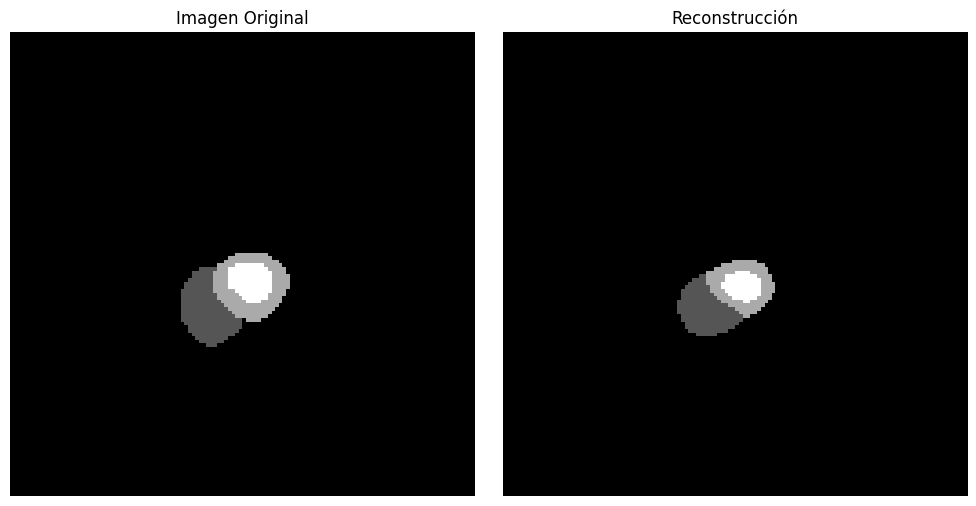

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_62.nii.gz


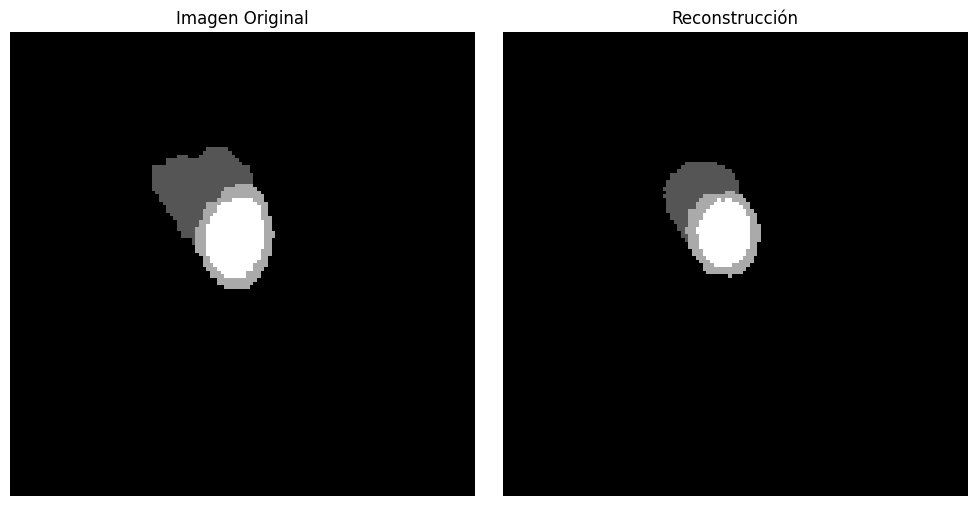

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_63.nii.gz


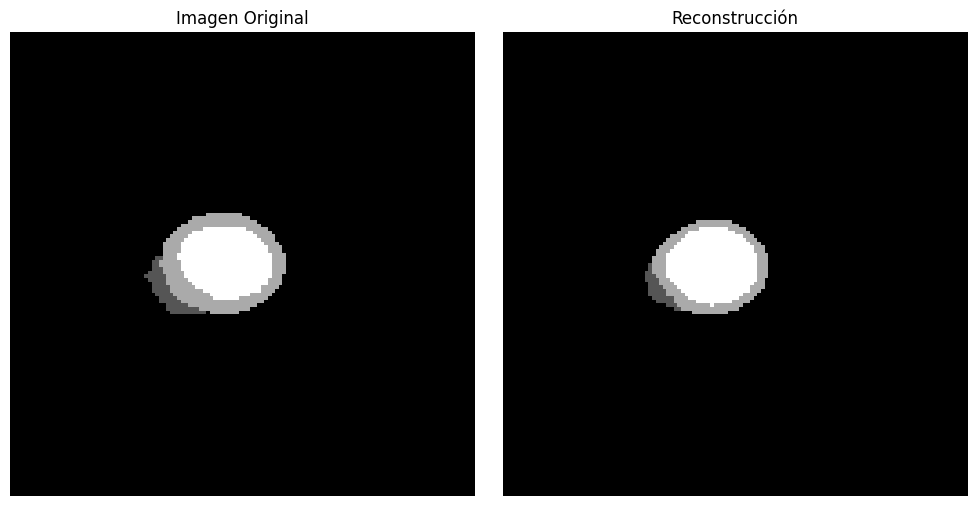

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_64.nii.gz


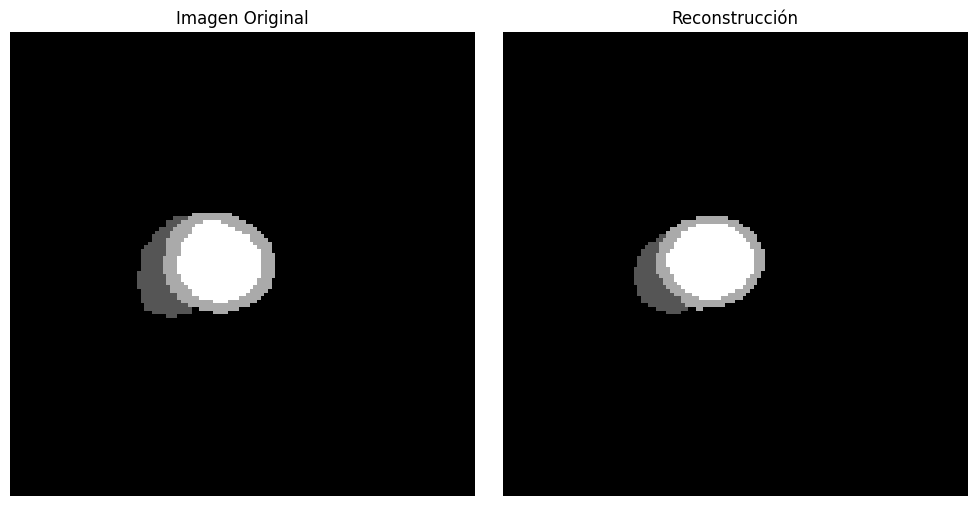

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_65.nii.gz


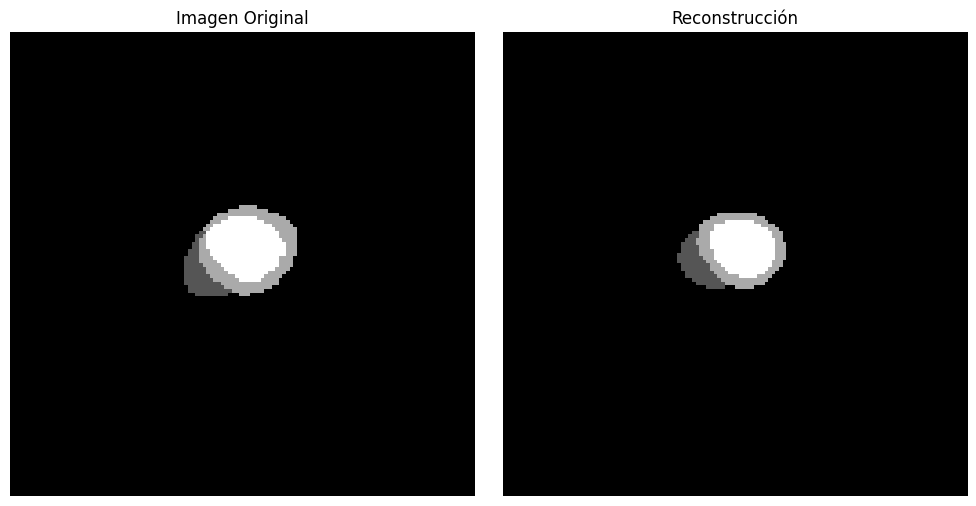

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_66.nii.gz


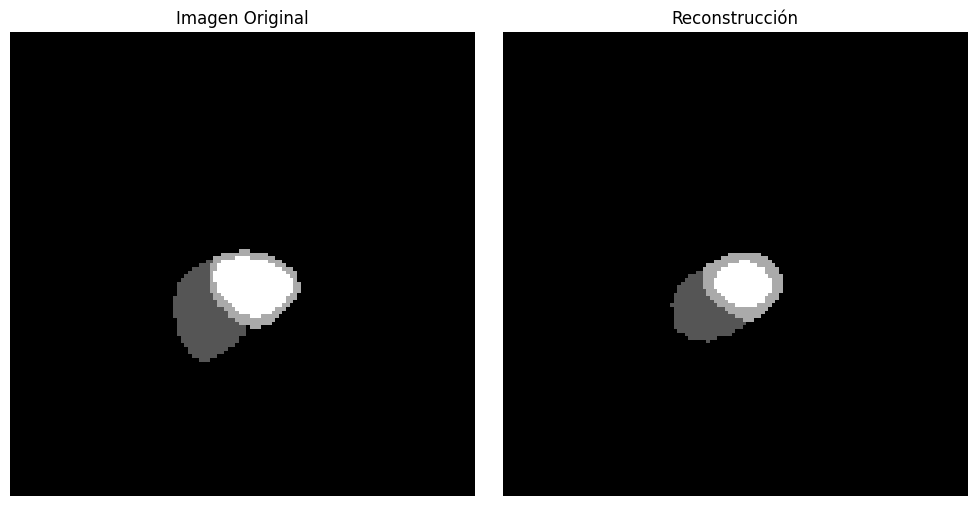

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_67.nii.gz


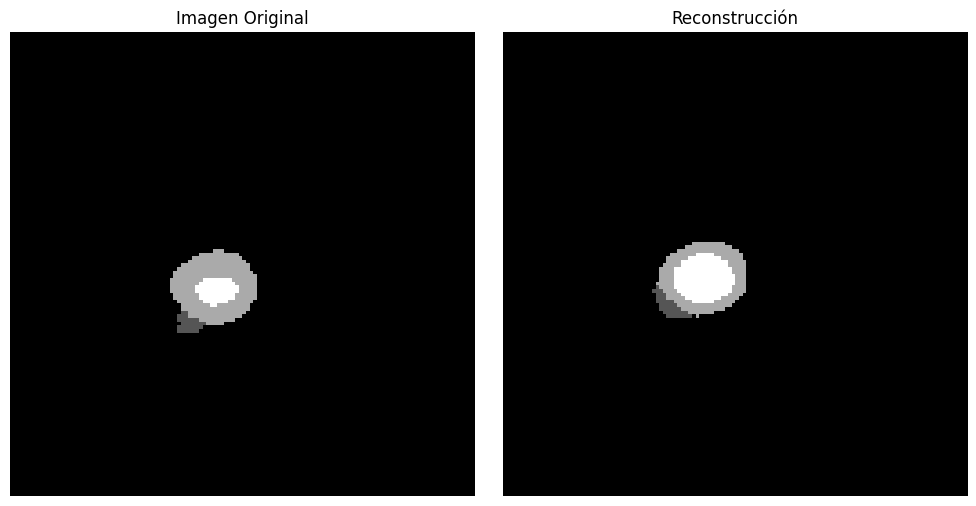

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_68.nii.gz


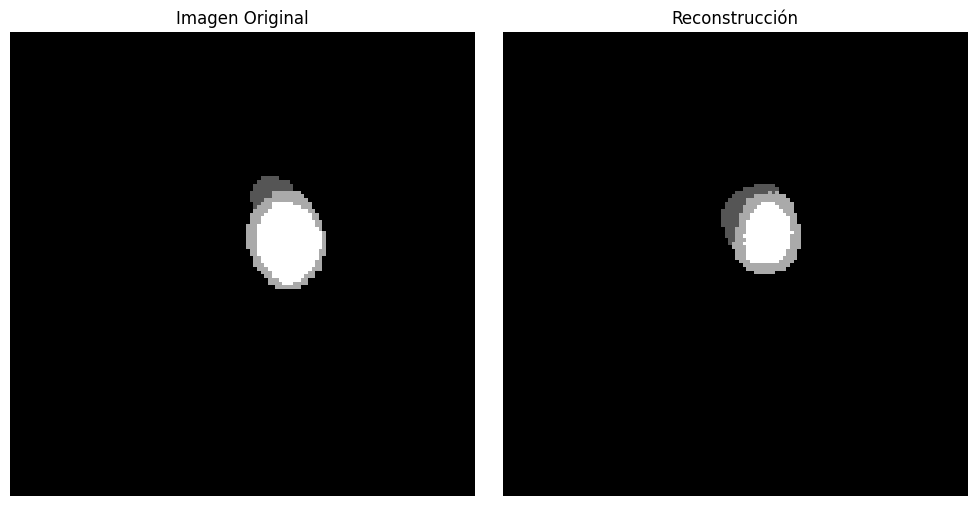

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_69.nii.gz


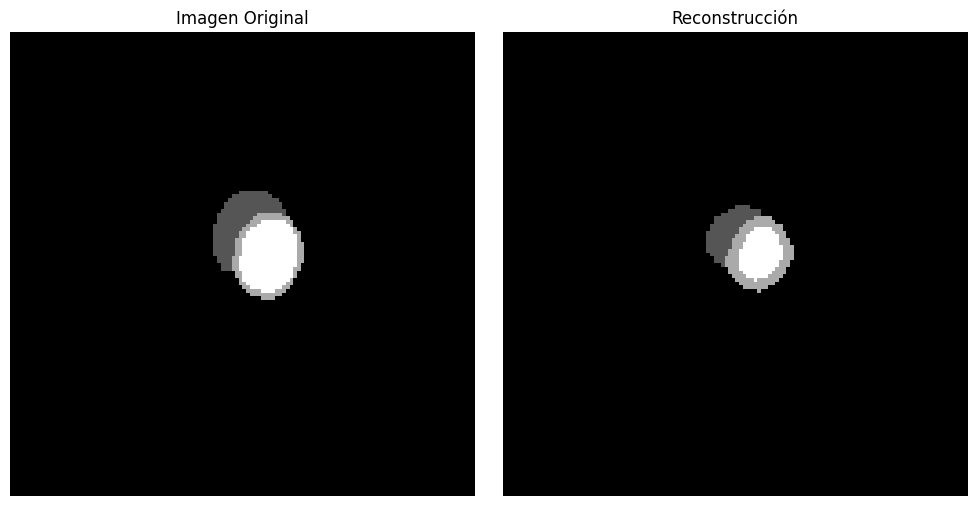

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129325389862
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_70.nii.gz


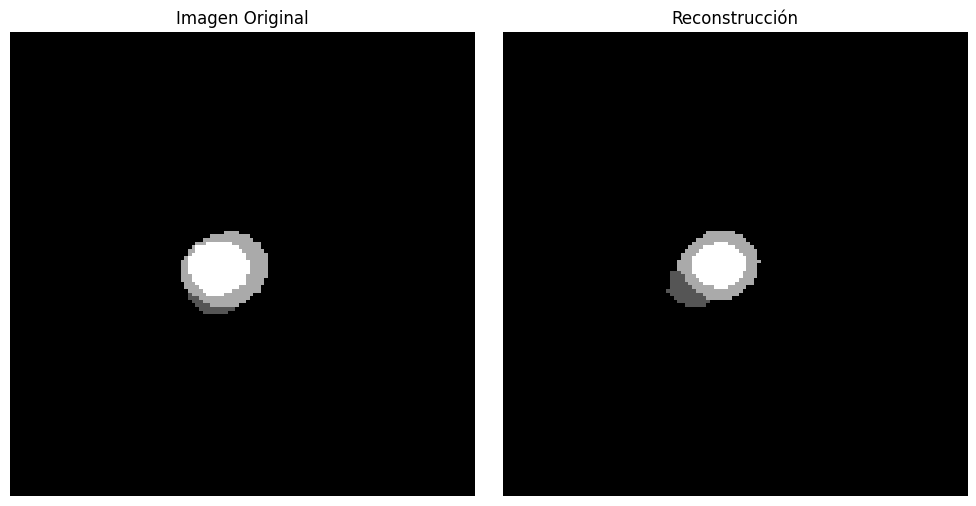

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129325389862
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_71.nii.gz


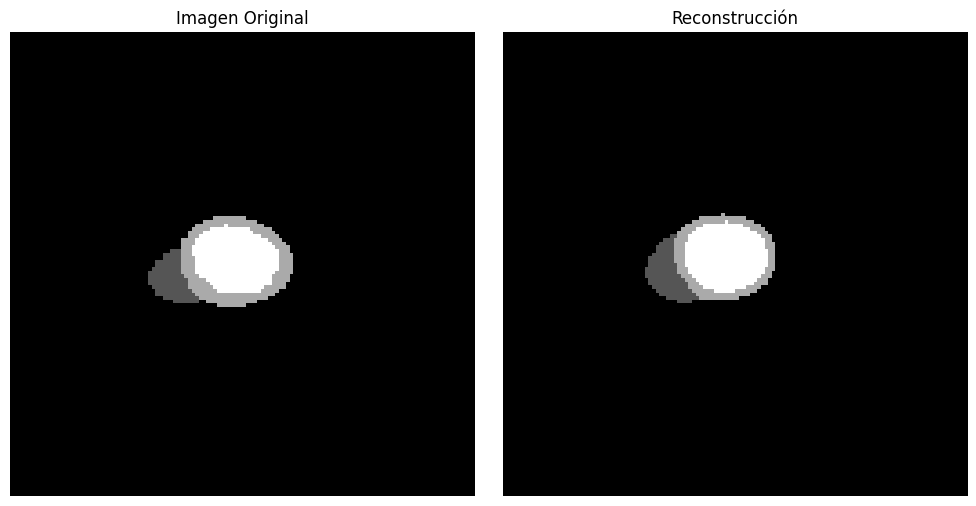

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_72.nii.gz


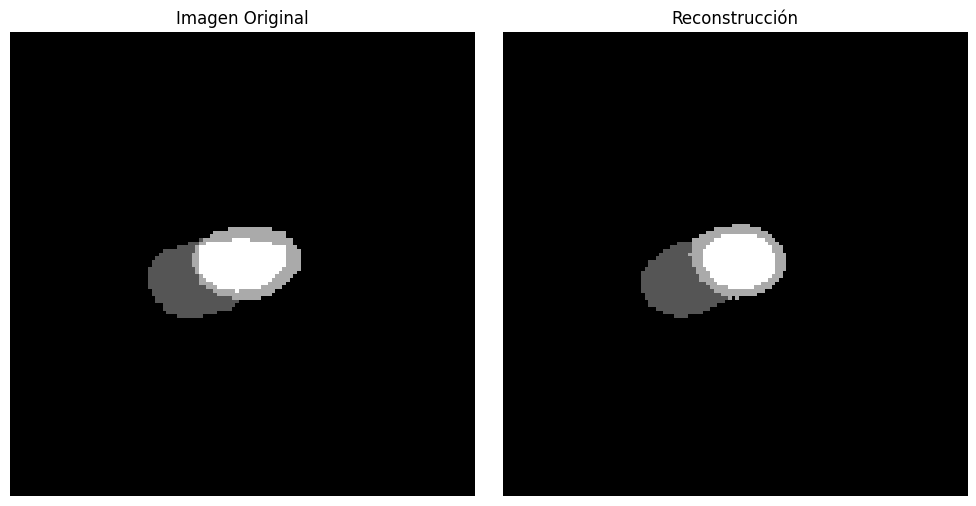

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_73.nii.gz


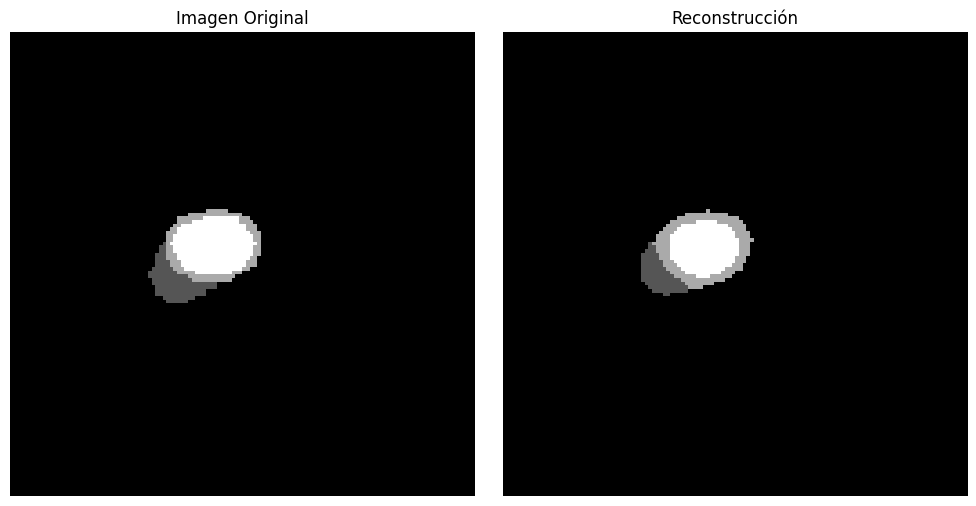

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_74.nii.gz


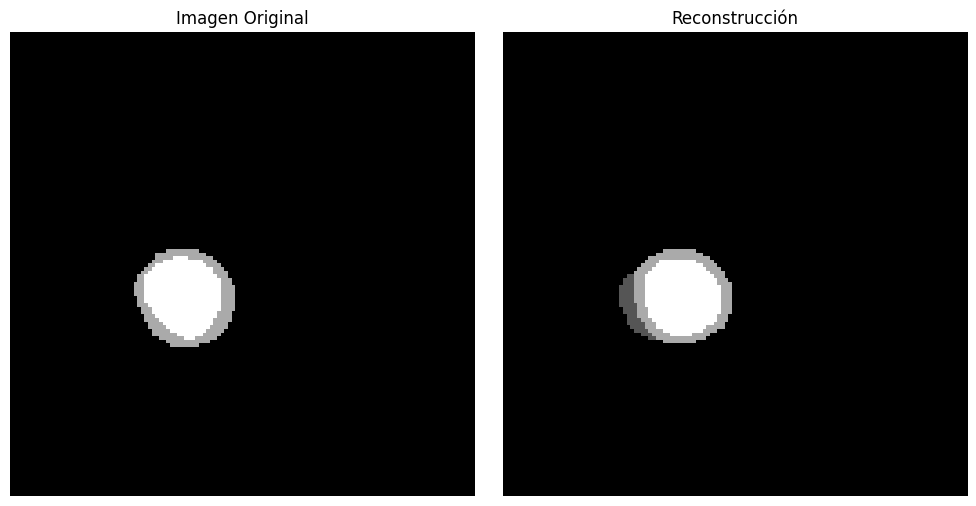

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_75.nii.gz


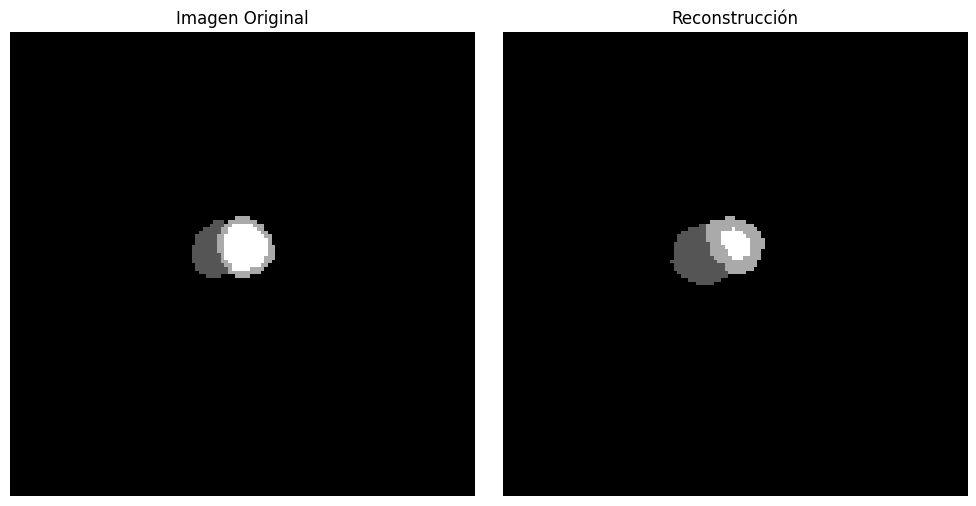

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_76.nii.gz


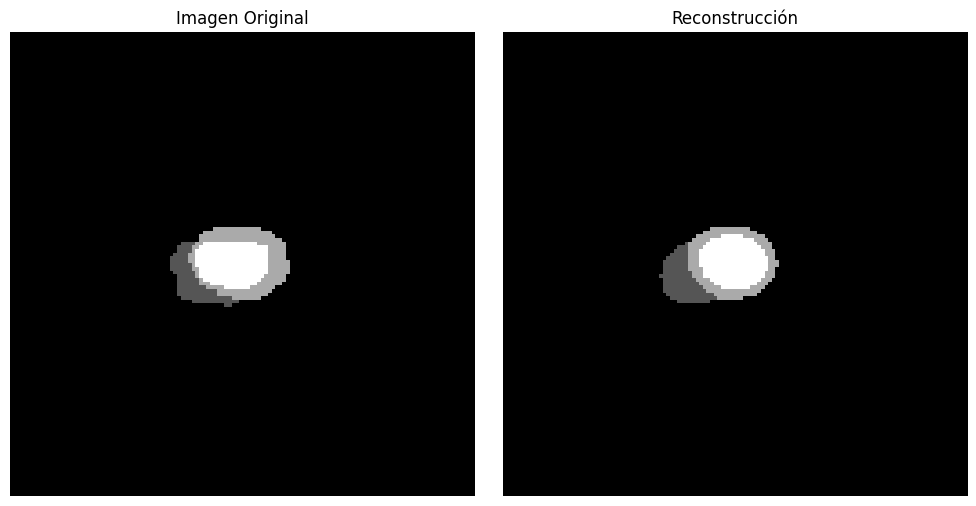

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_77.nii.gz


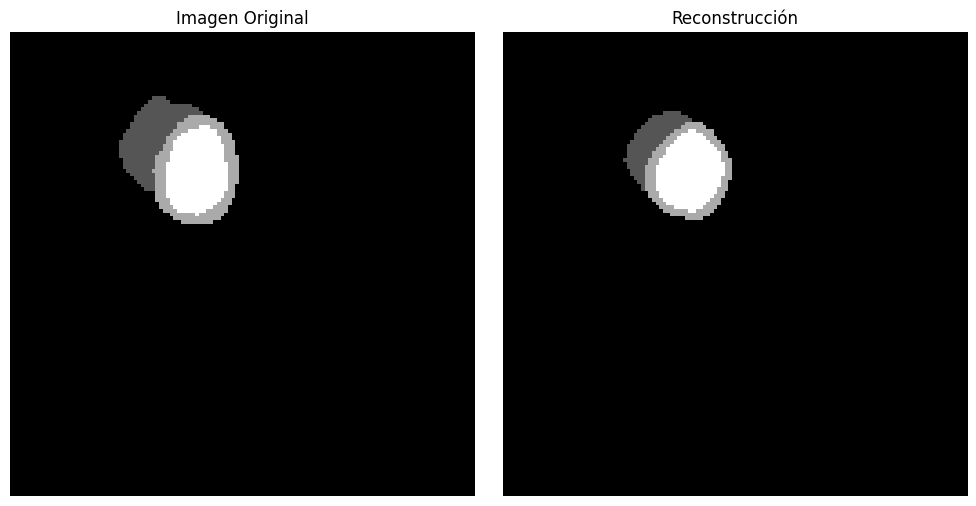

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_78.nii.gz


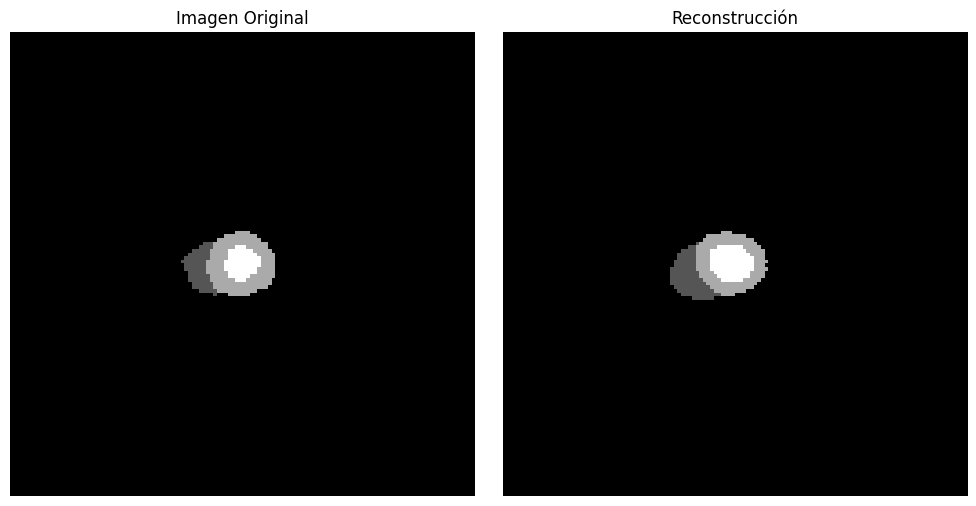

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_79.nii.gz


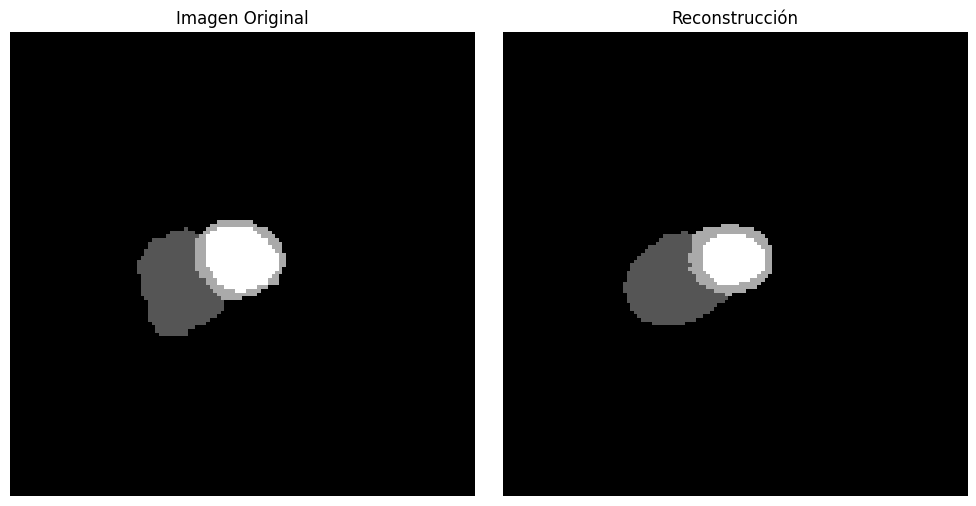

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_80.nii.gz


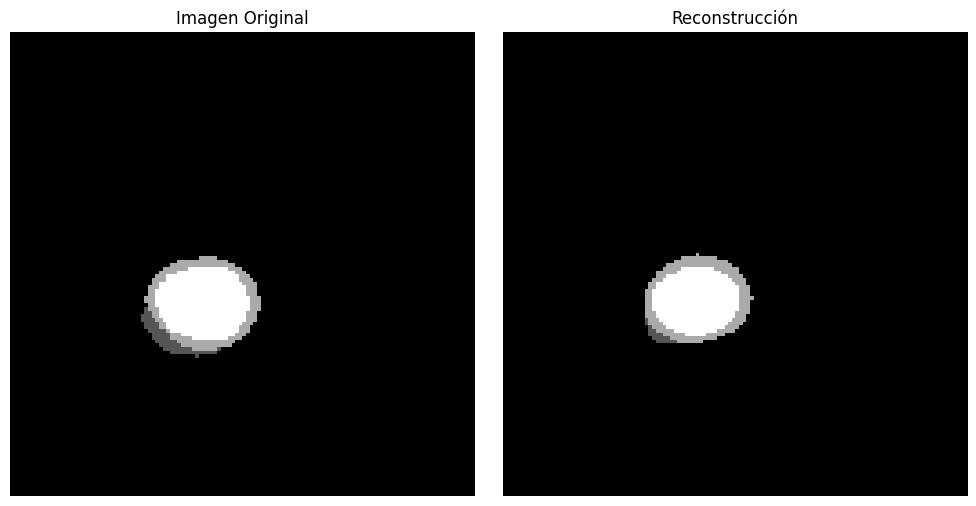

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_81.nii.gz


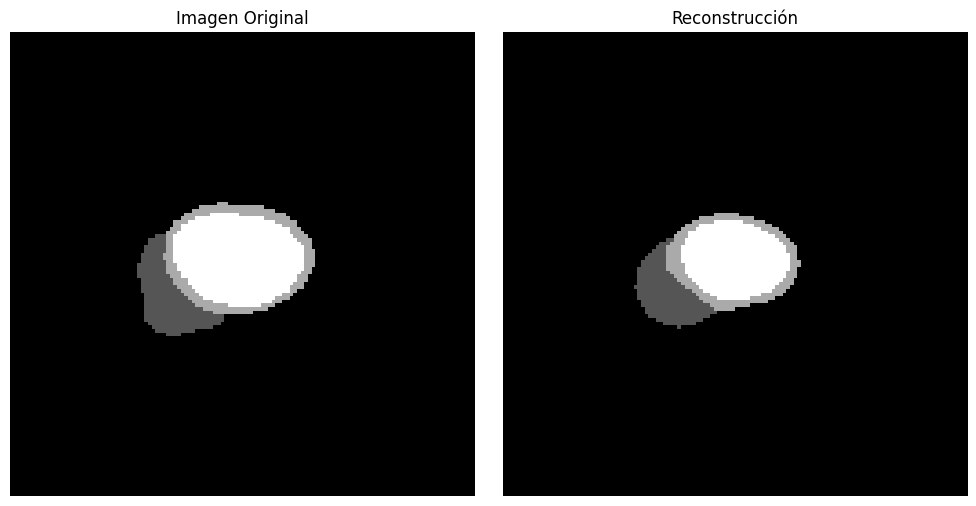

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_82.nii.gz


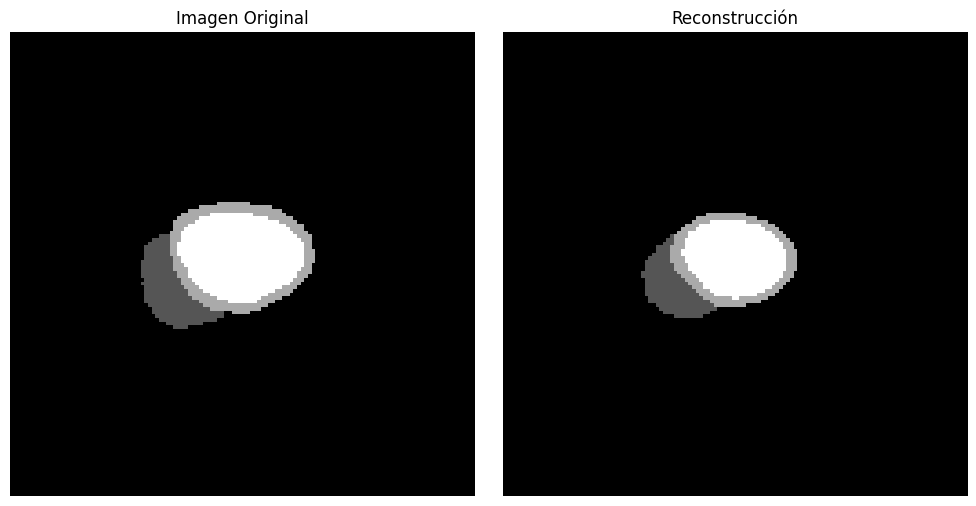

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_83.nii.gz


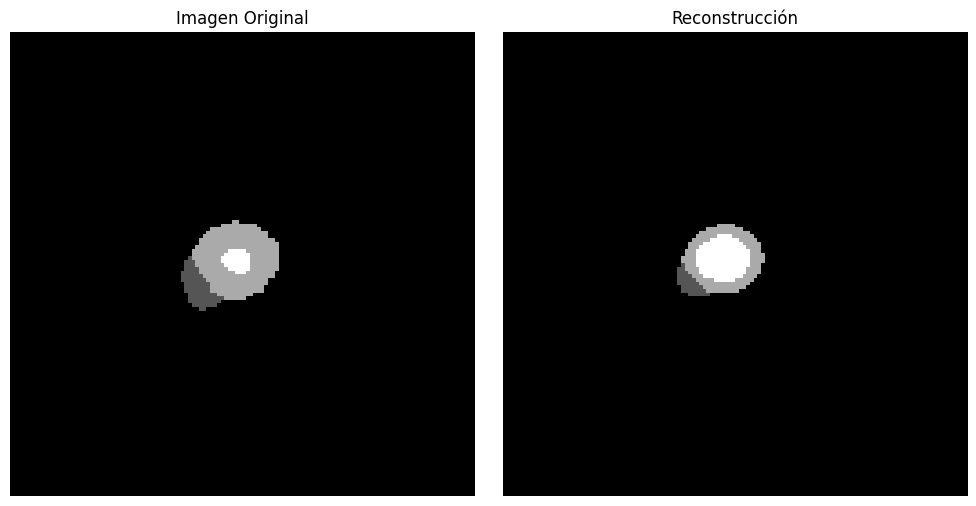

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_84.nii.gz


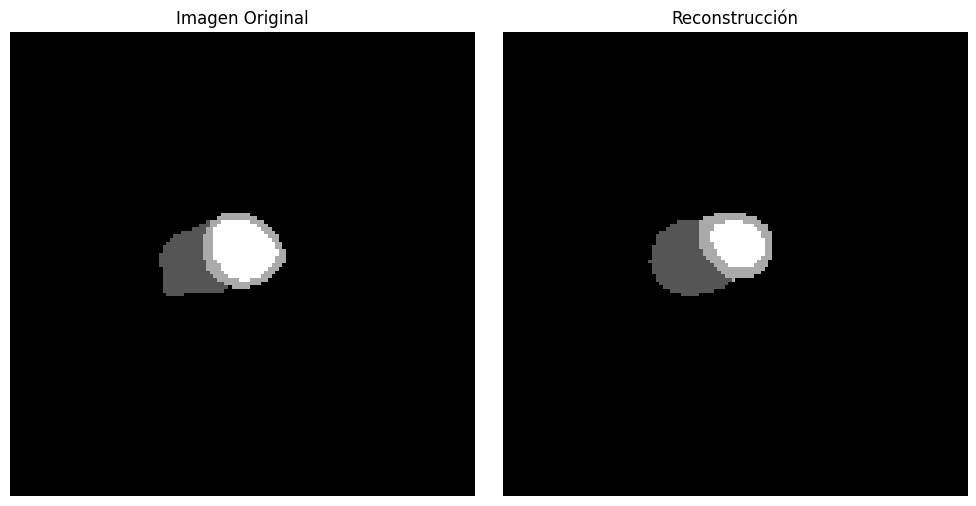

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_85.nii.gz


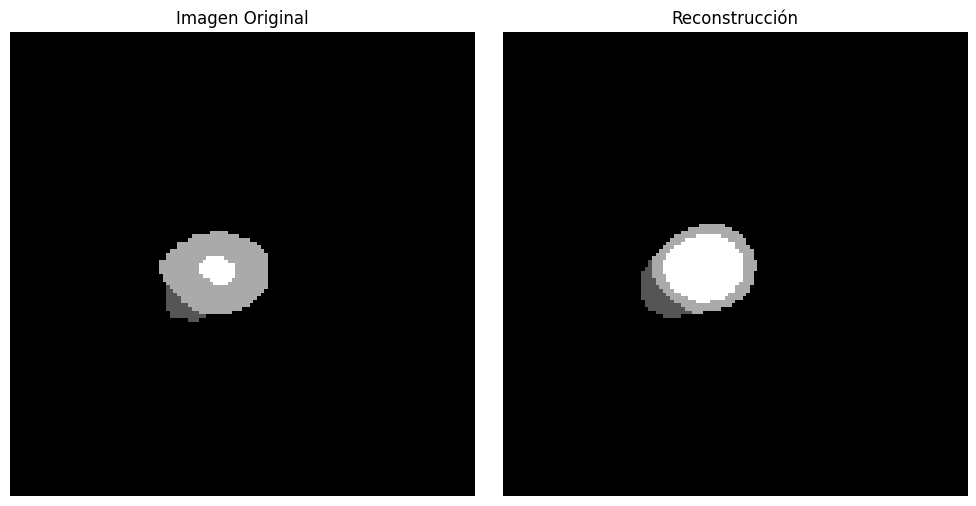

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_86.nii.gz


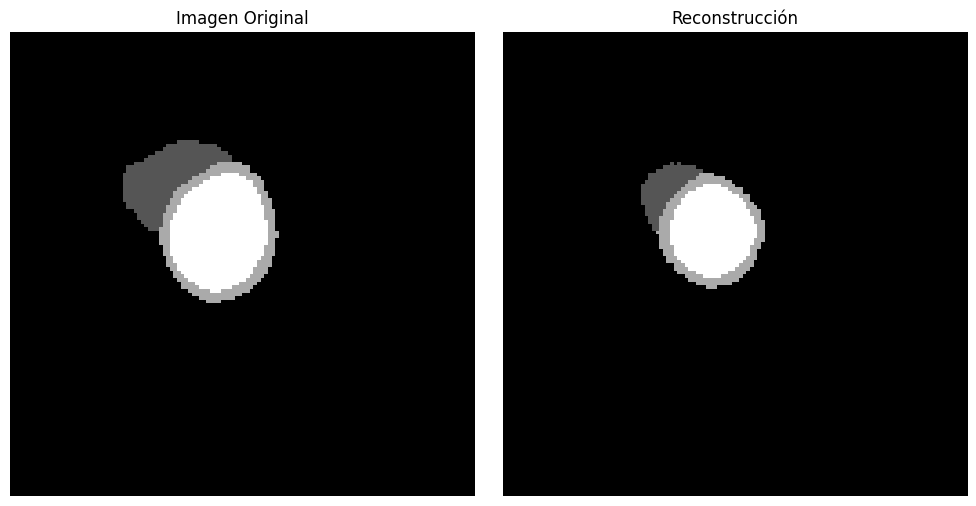

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_87.nii.gz


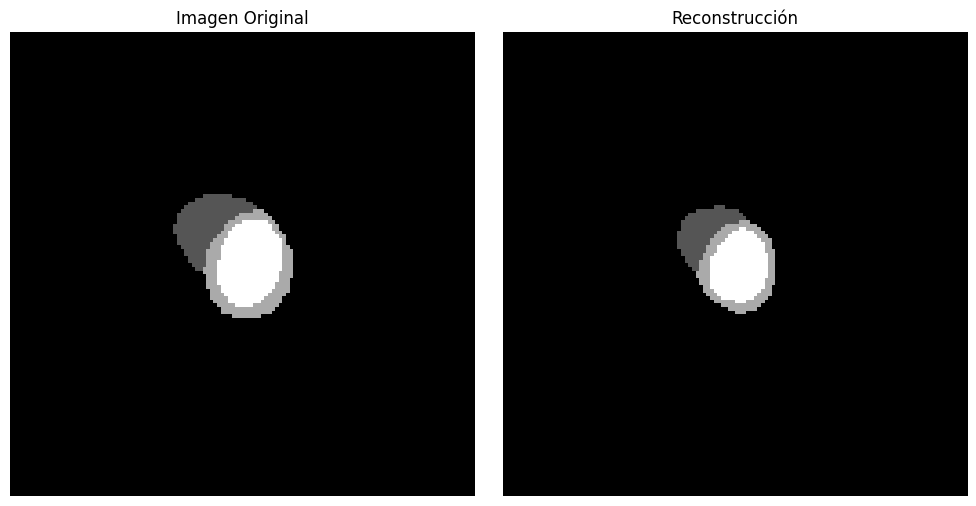

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_88.nii.gz


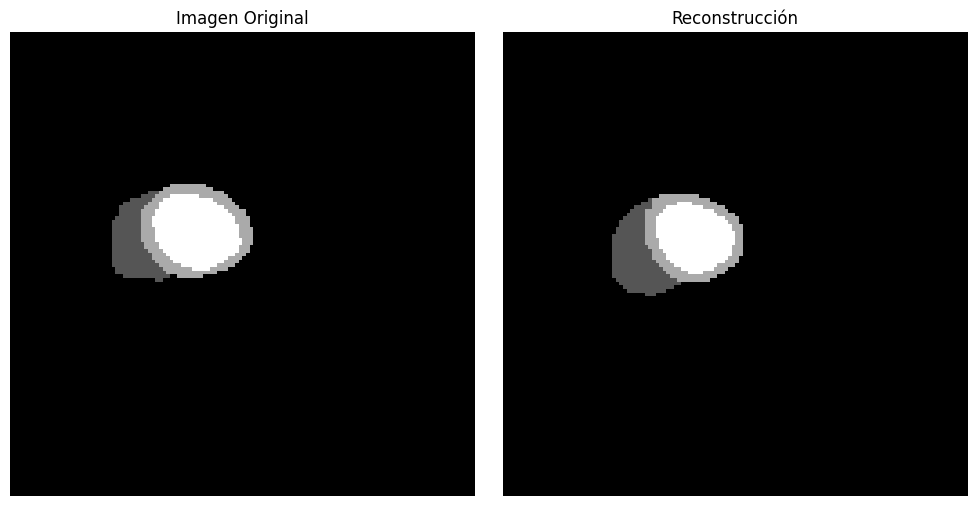

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_89.nii.gz


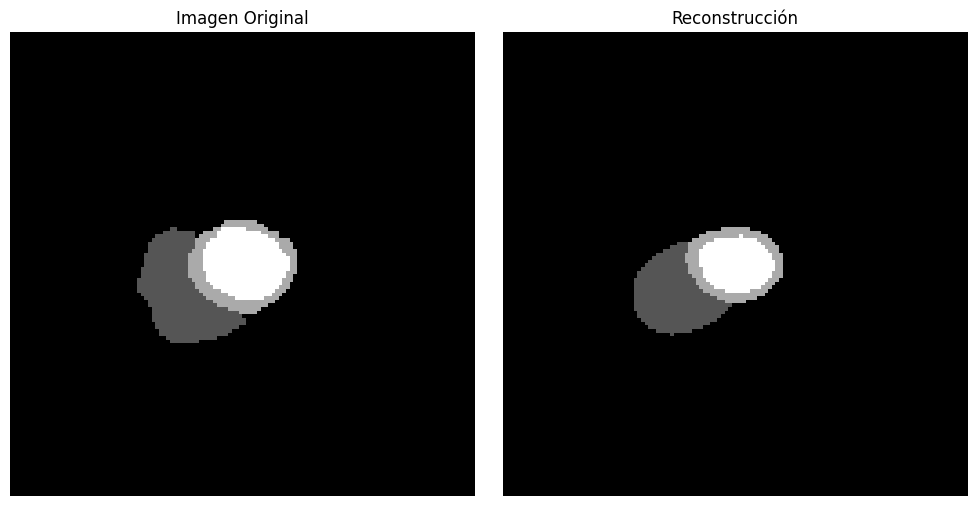

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_90.nii.gz


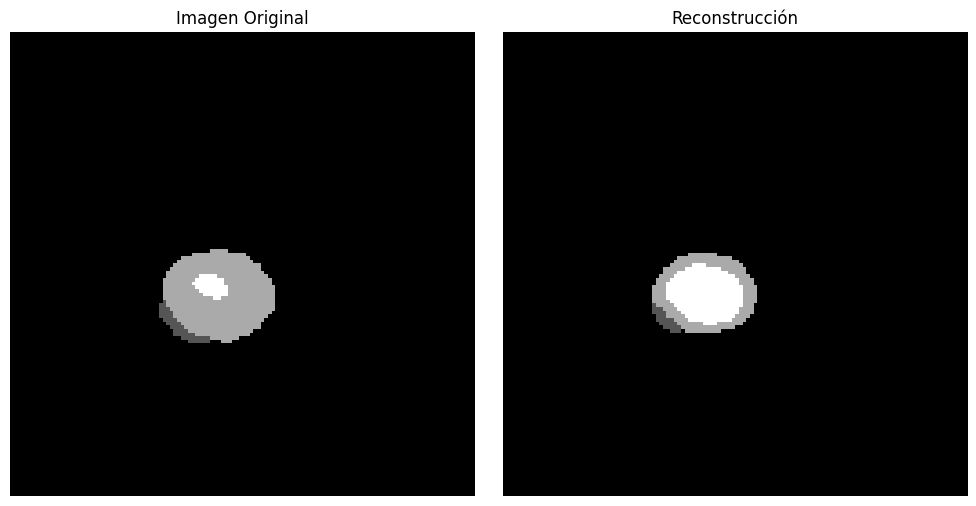

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_91.nii.gz


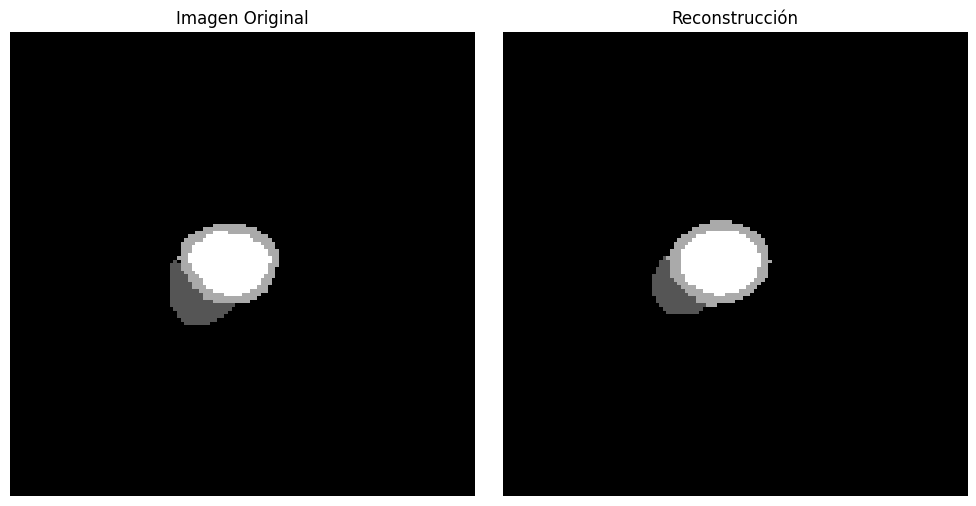

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_92.nii.gz


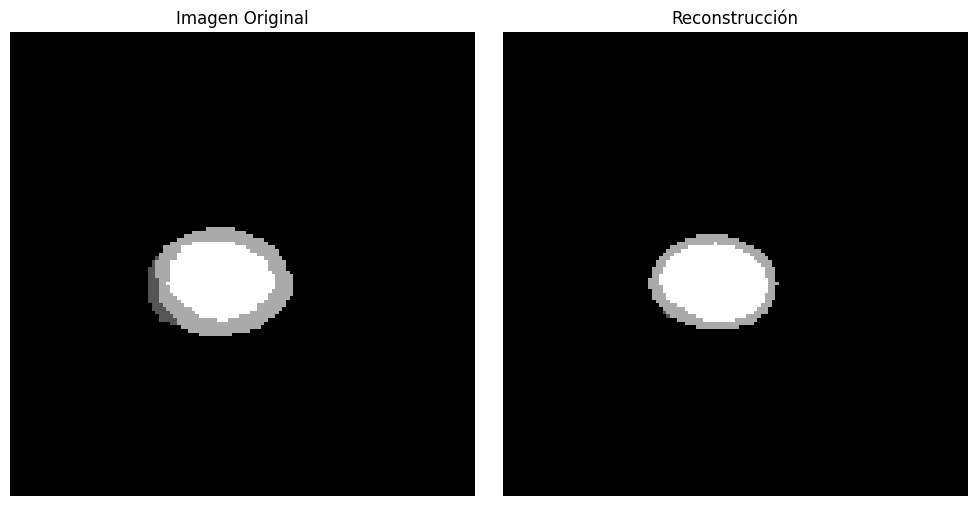

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_93.nii.gz


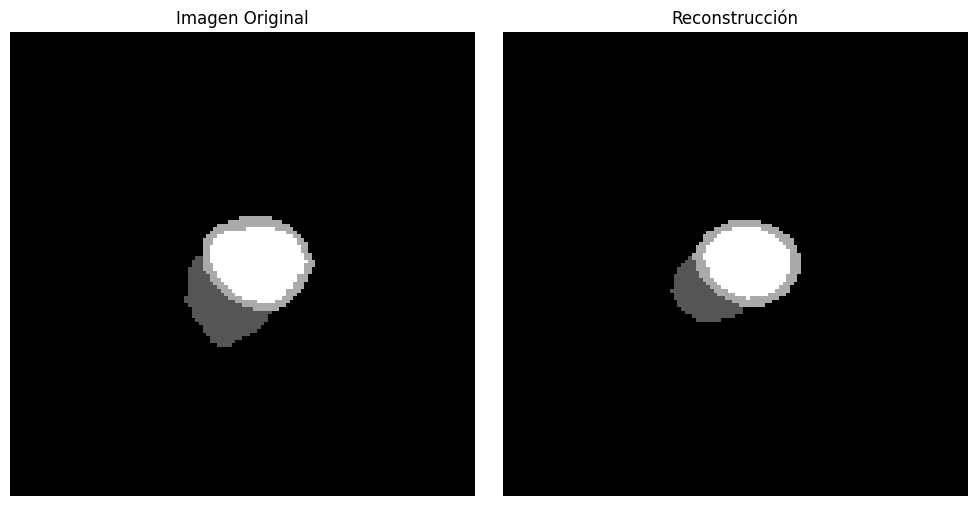

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_94.nii.gz


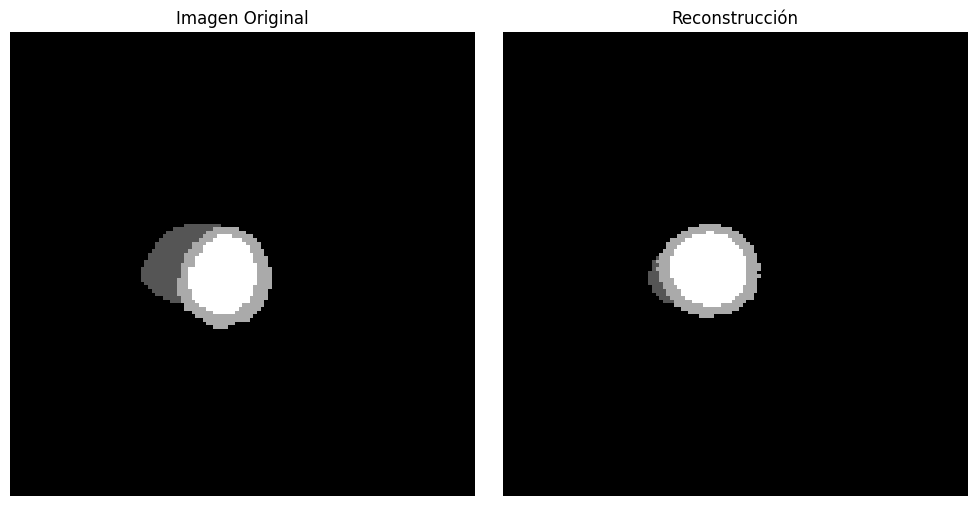

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_95.nii.gz


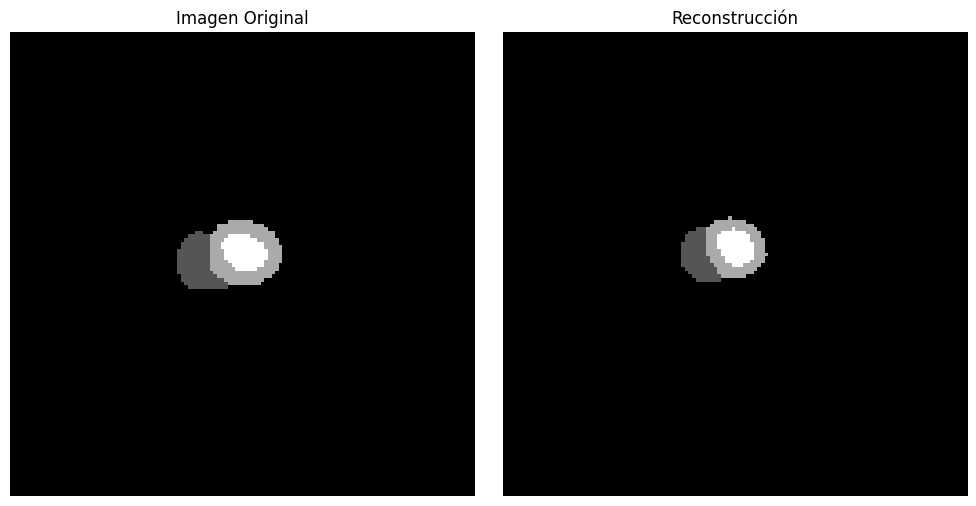

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_96.nii.gz


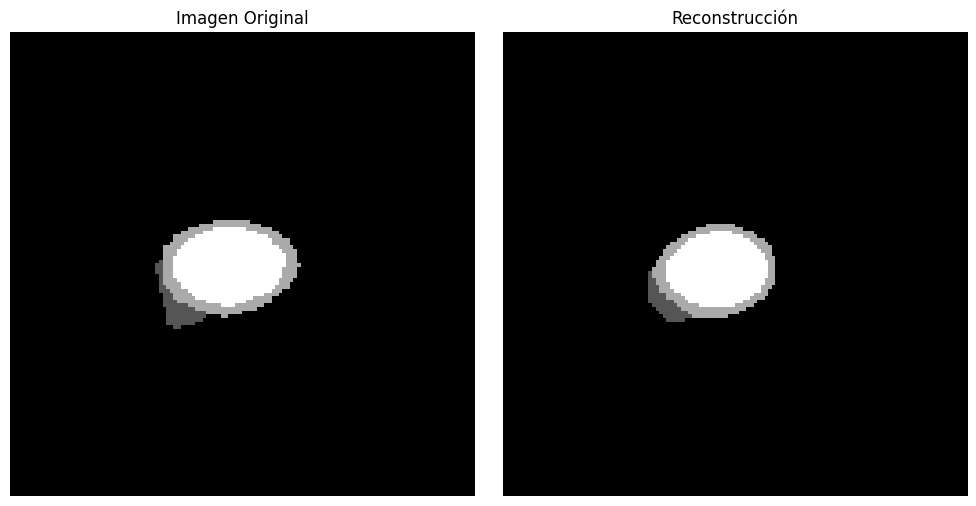

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_97.nii.gz


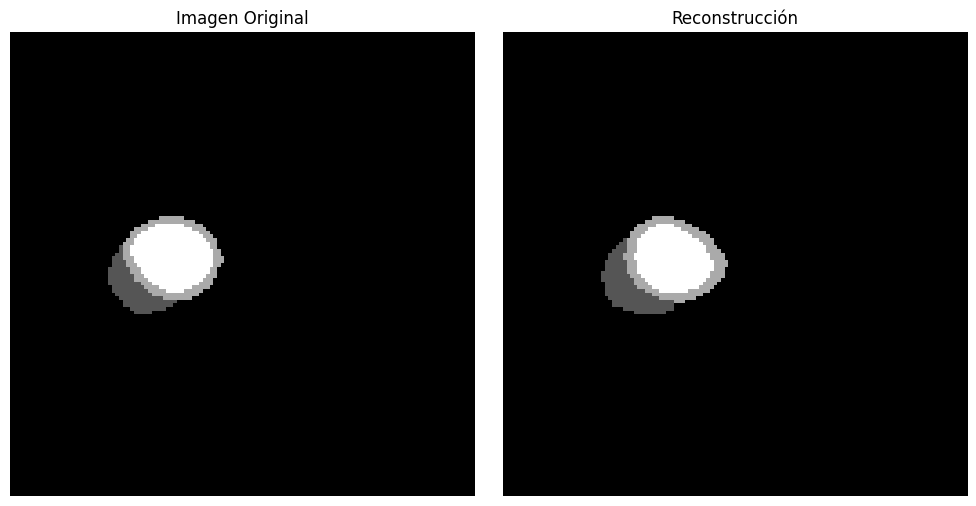

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_98.nii.gz


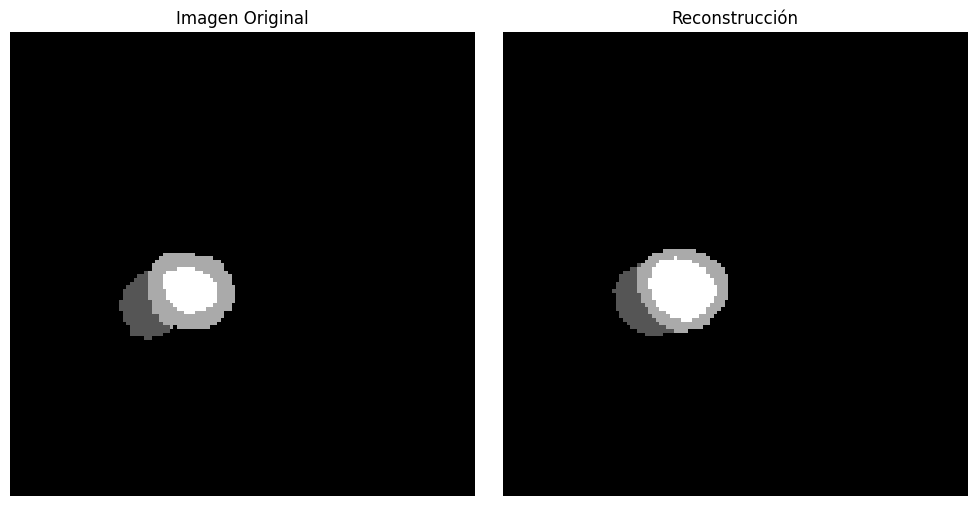

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_99.nii.gz


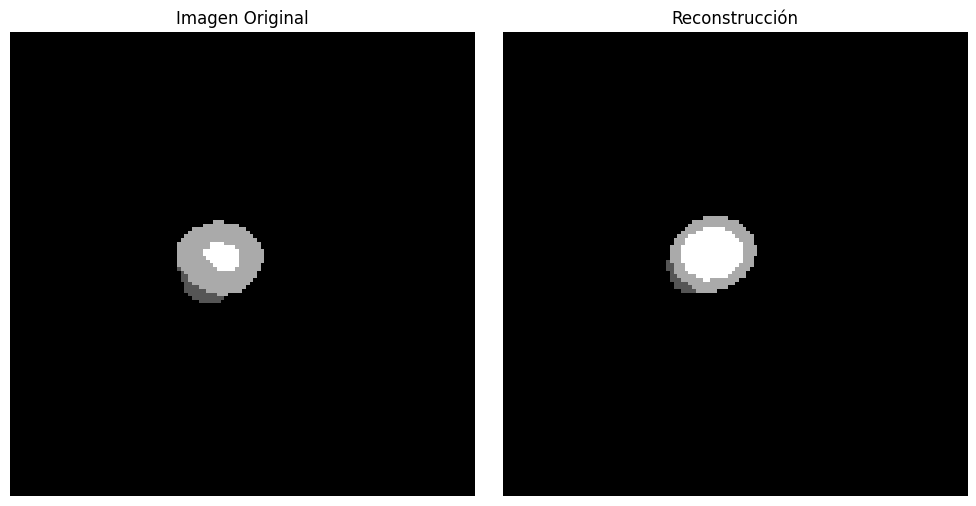

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_100.nii.gz


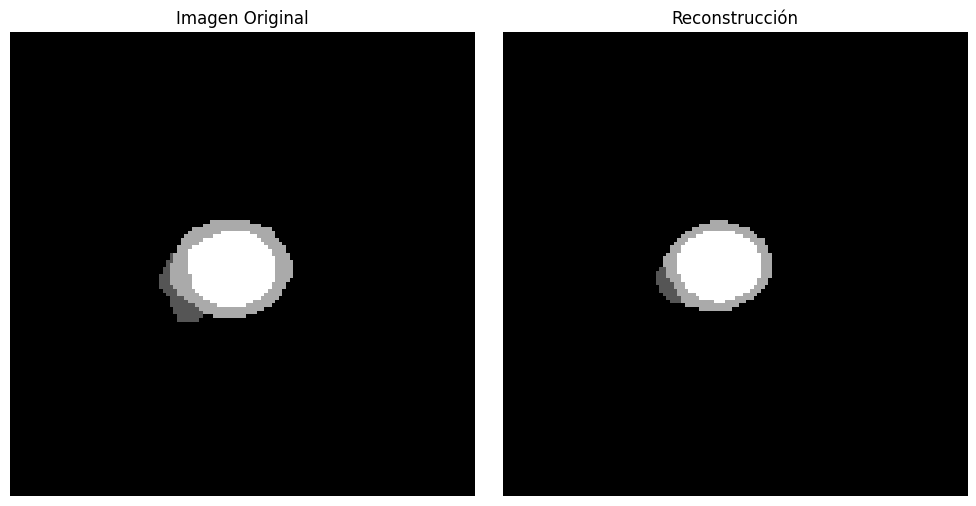

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_101.nii.gz


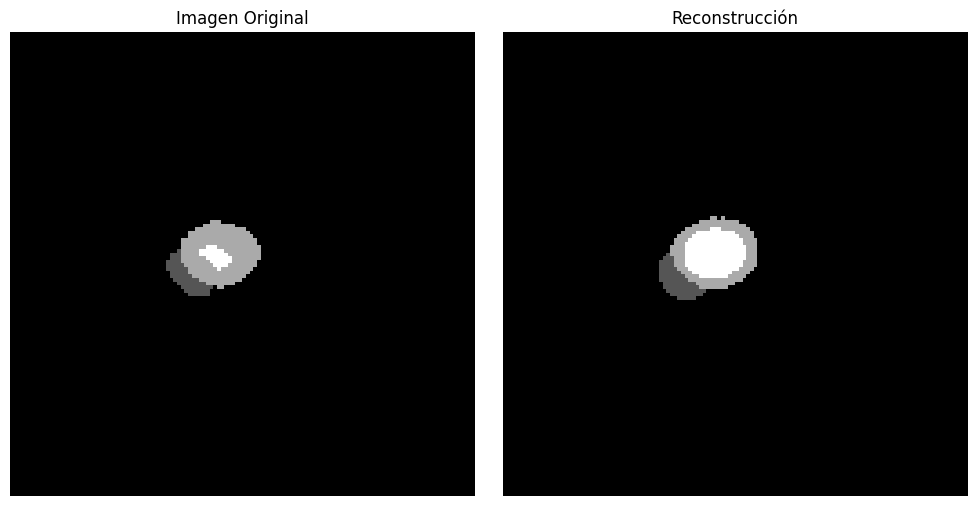

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_102.nii.gz


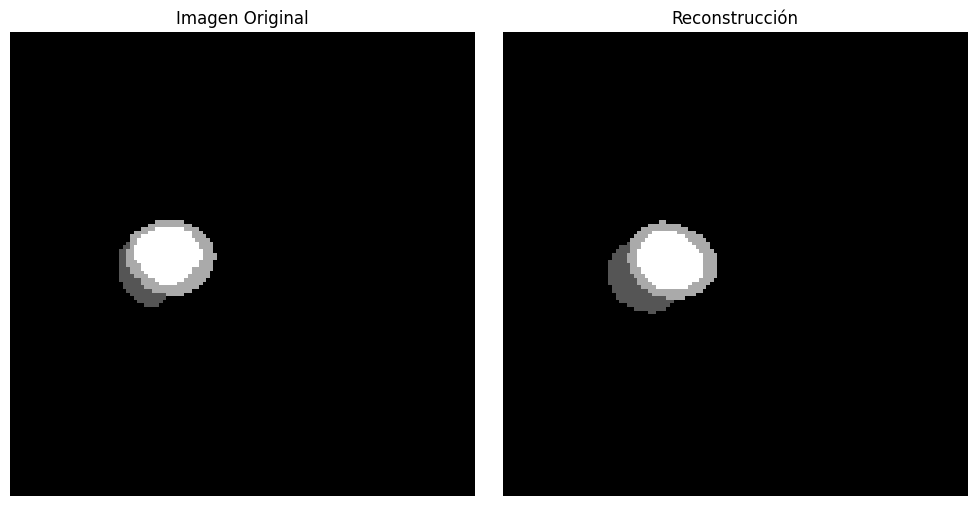

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_103.nii.gz


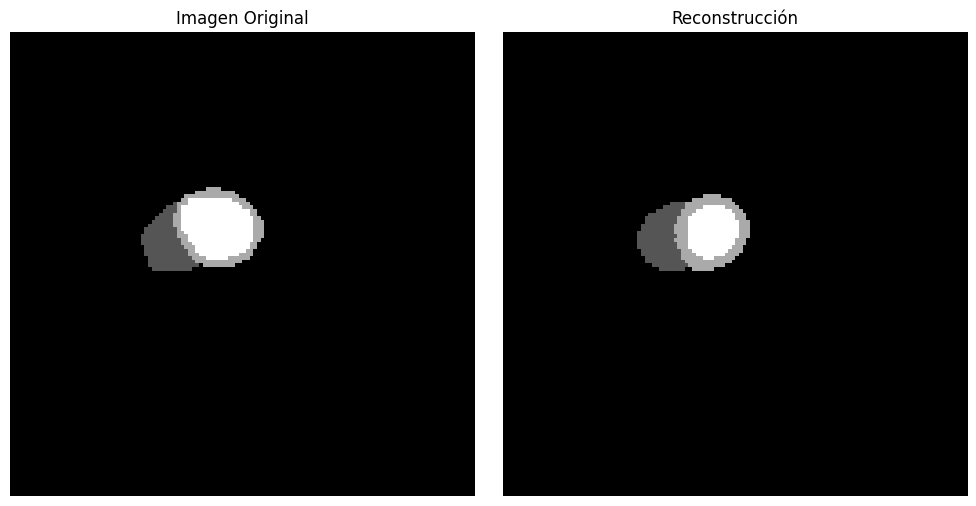

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_104.nii.gz


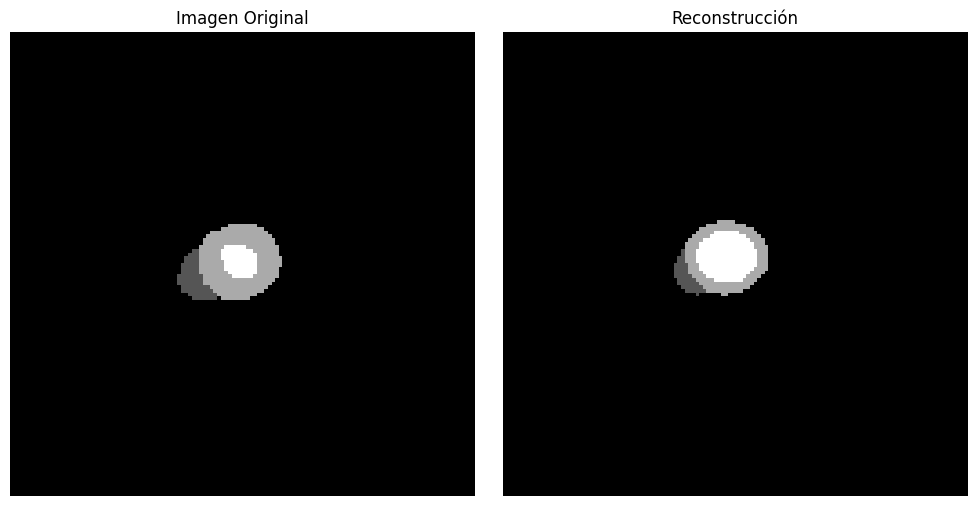

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_105.nii.gz


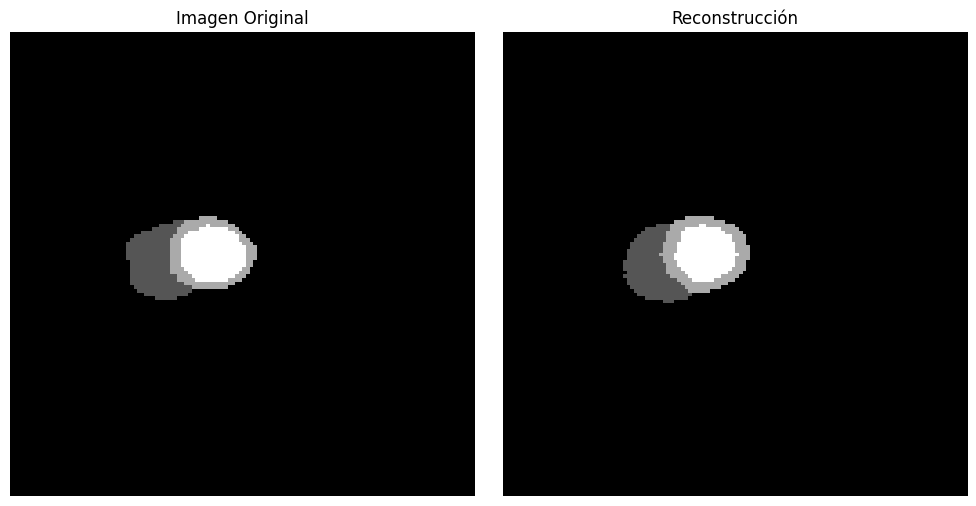

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_106.nii.gz


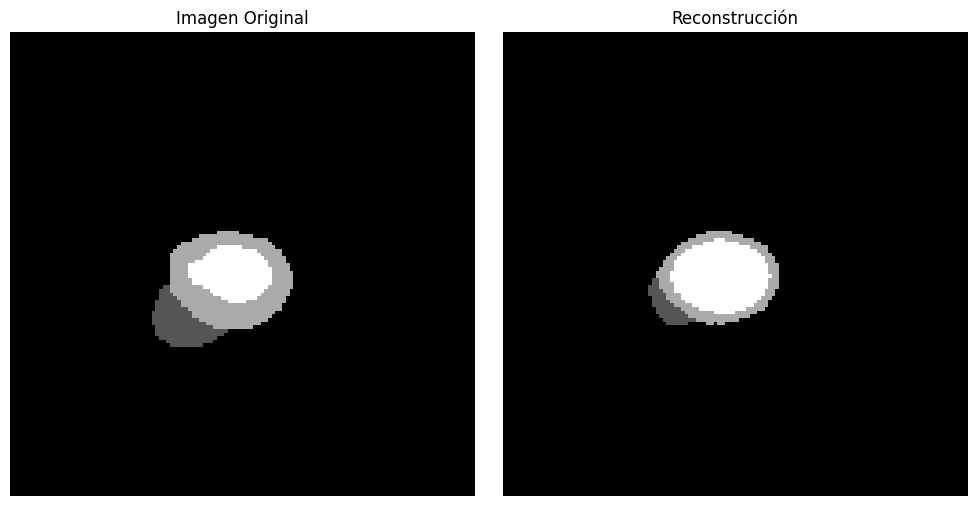

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_107.nii.gz


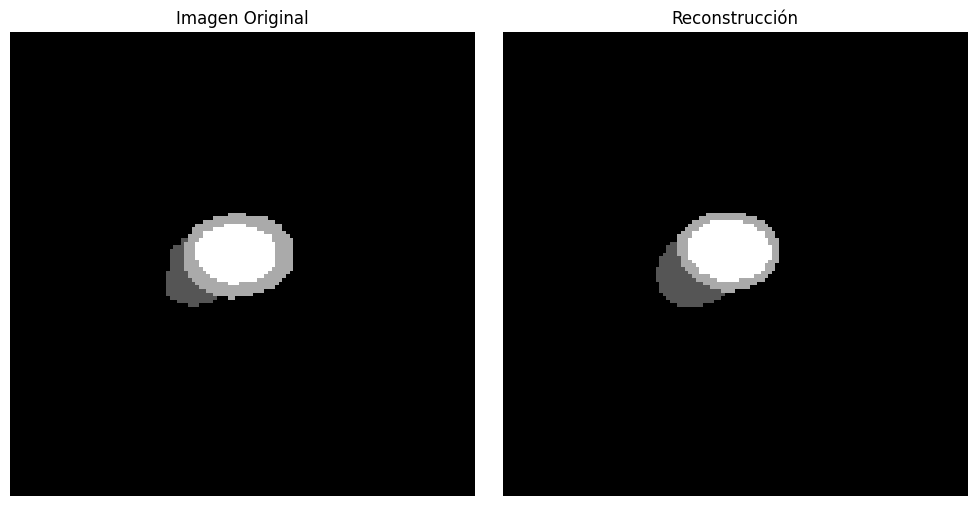

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_108.nii.gz


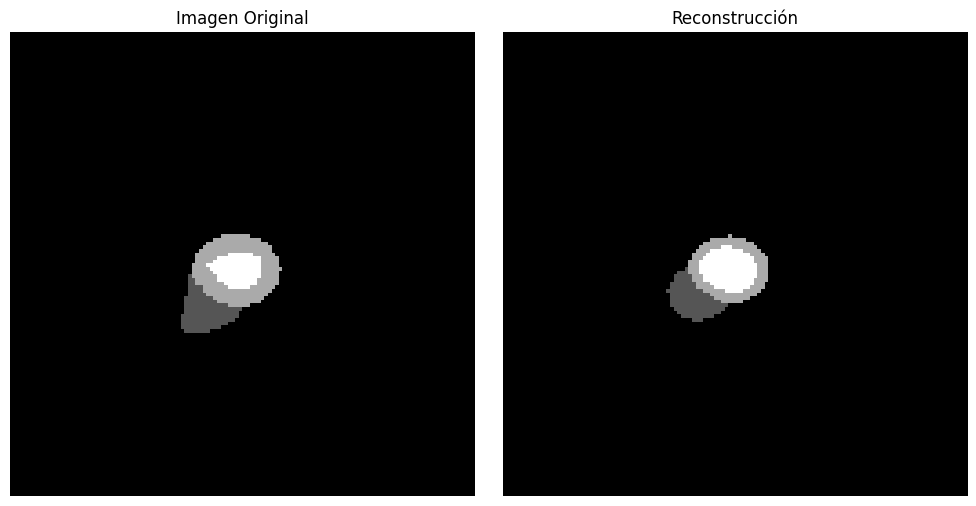

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_109.nii.gz


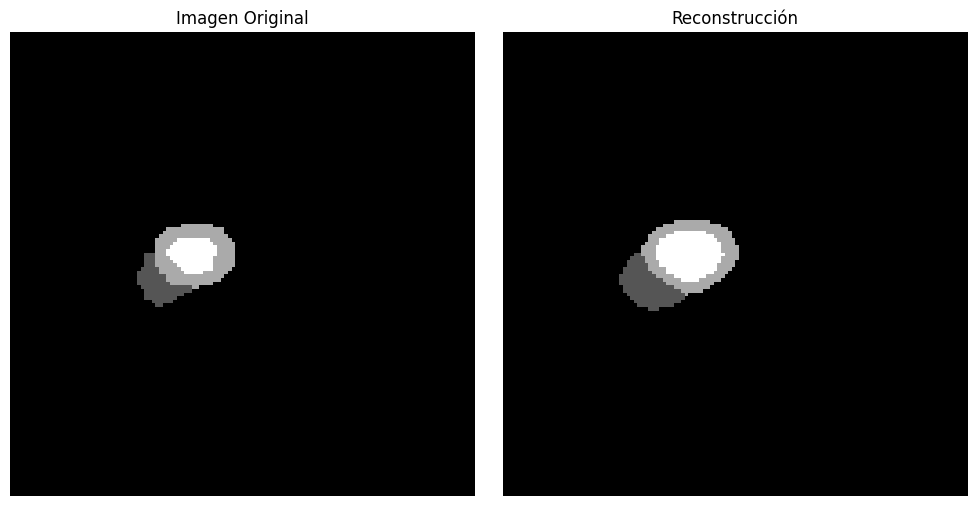

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_110.nii.gz


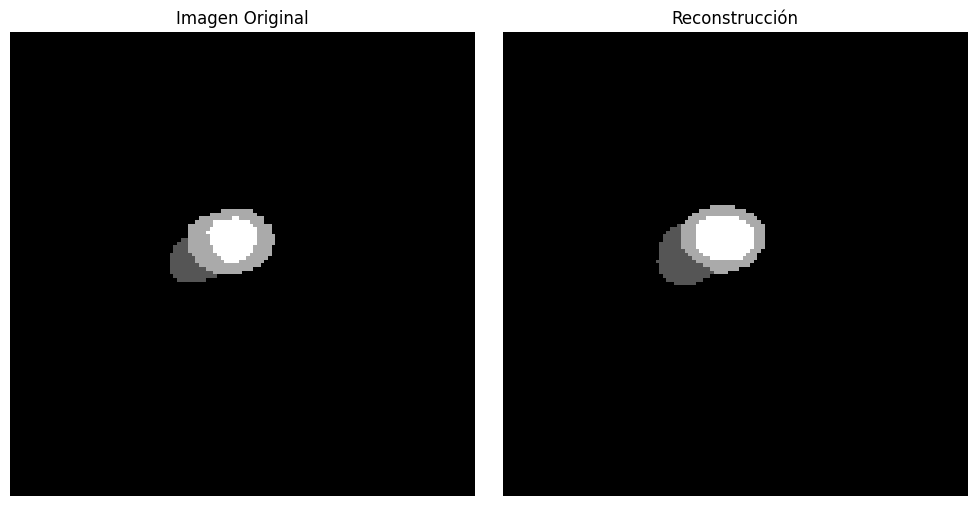

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129325389862
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_111.nii.gz


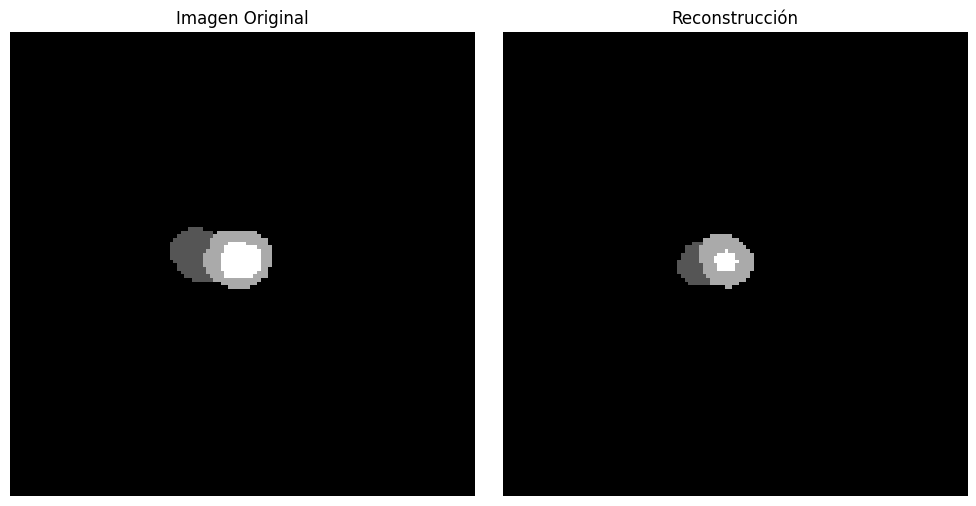

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_112.nii.gz


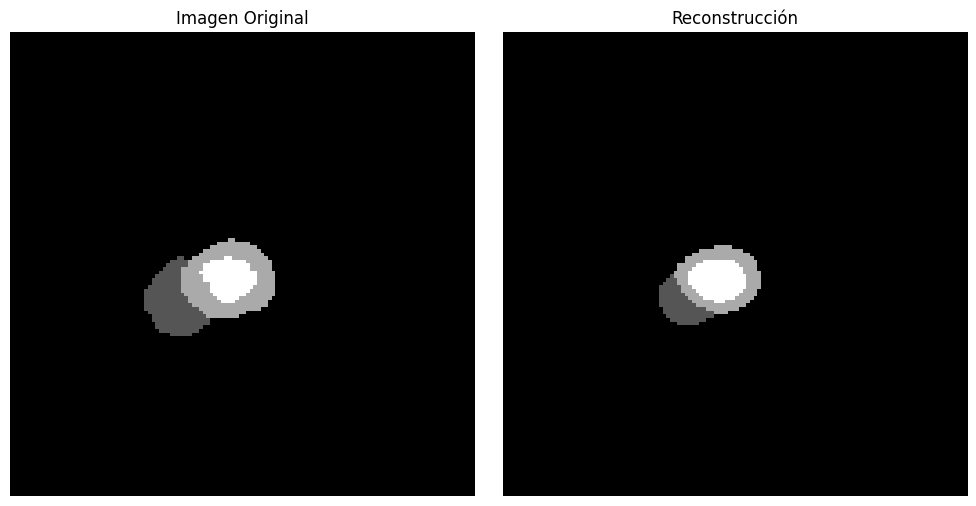

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_113.nii.gz


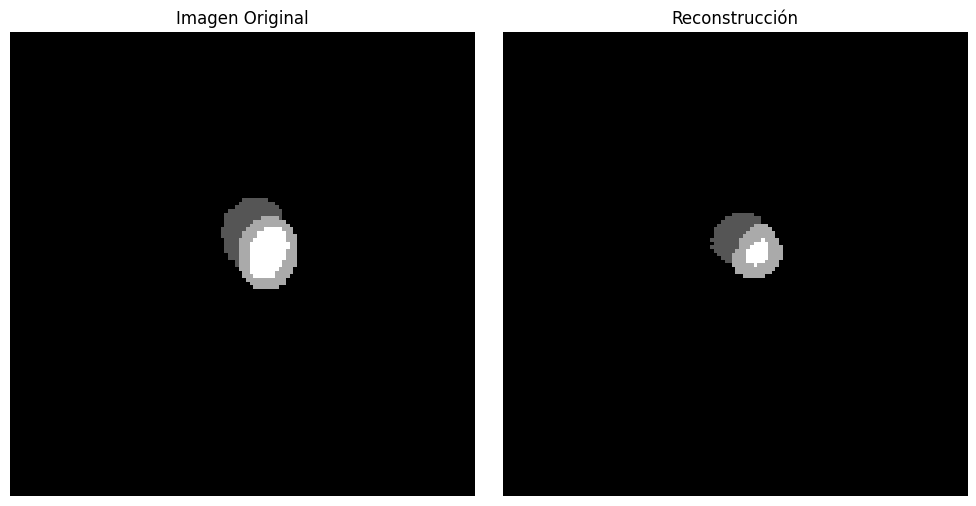

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_114.nii.gz


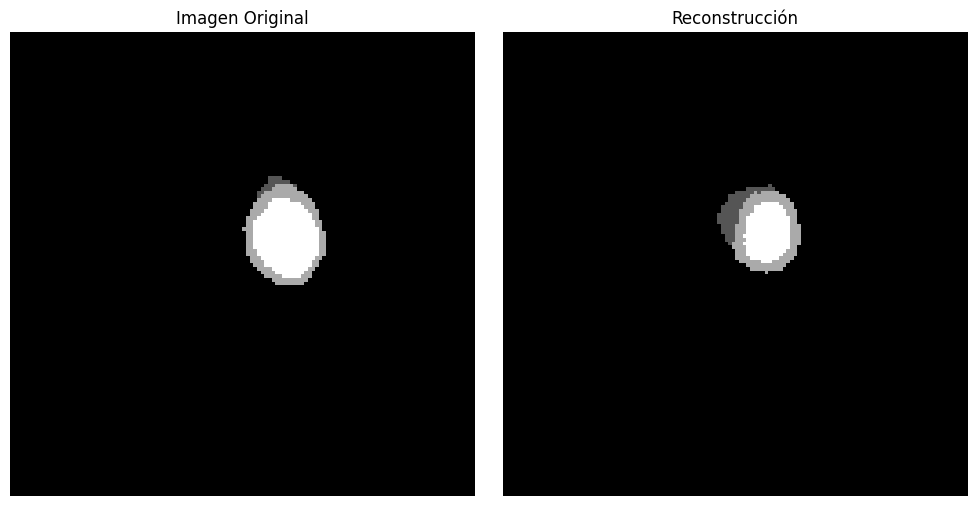

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129325389862
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_115.nii.gz


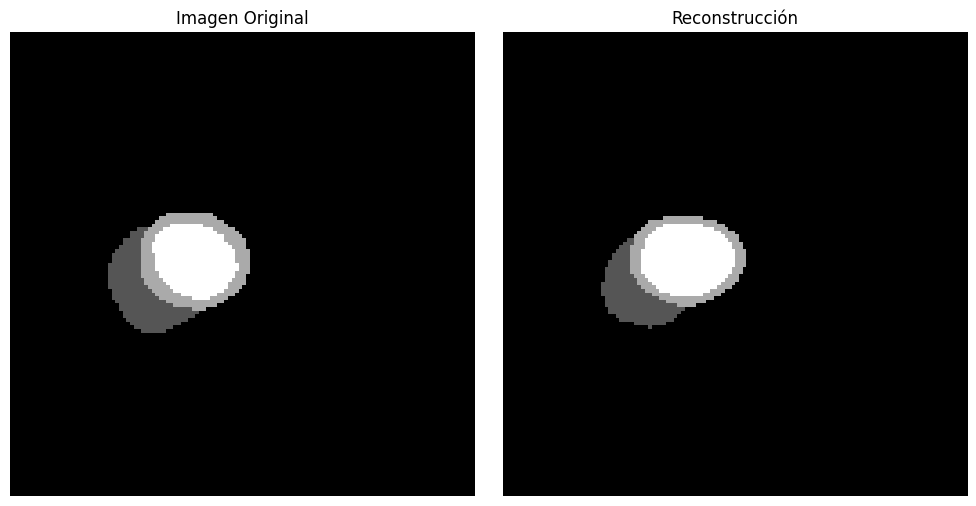

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_116.nii.gz


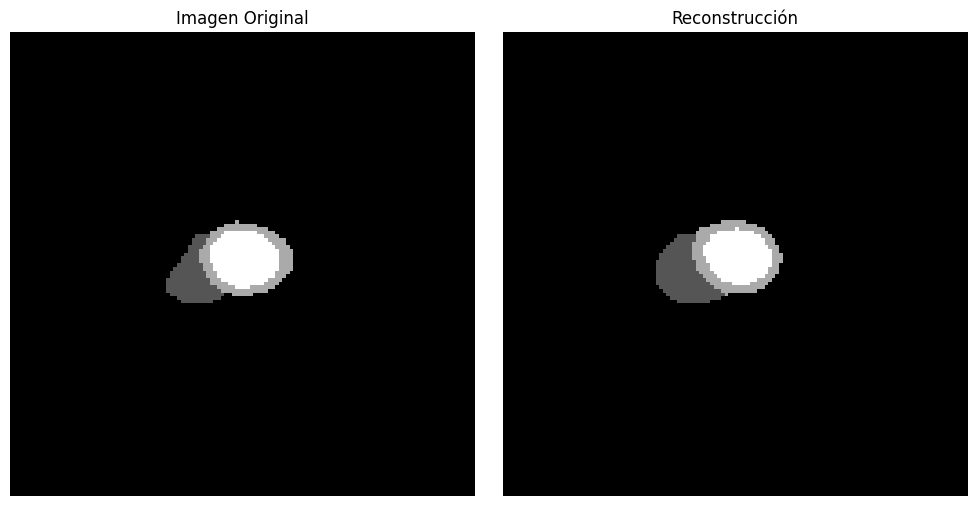

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129325389862
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_117.nii.gz


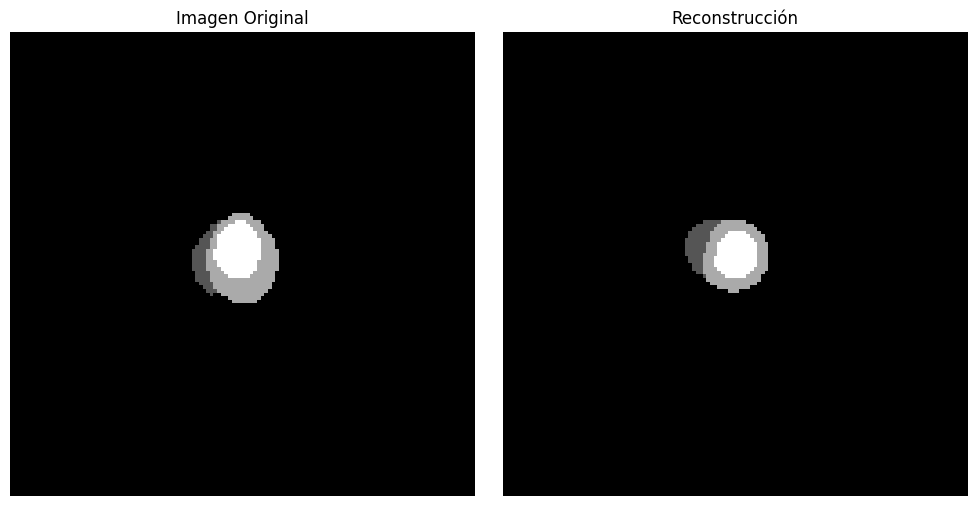

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_118.nii.gz


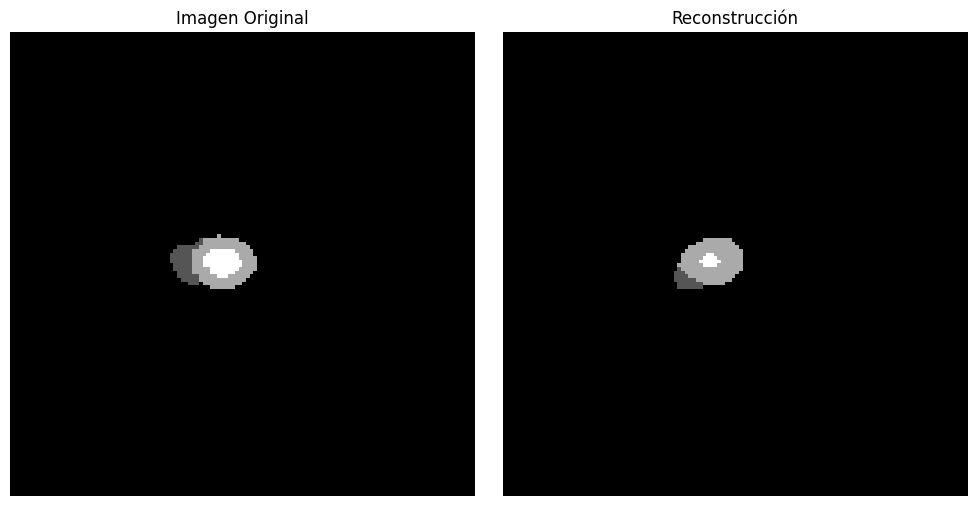

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_119.nii.gz


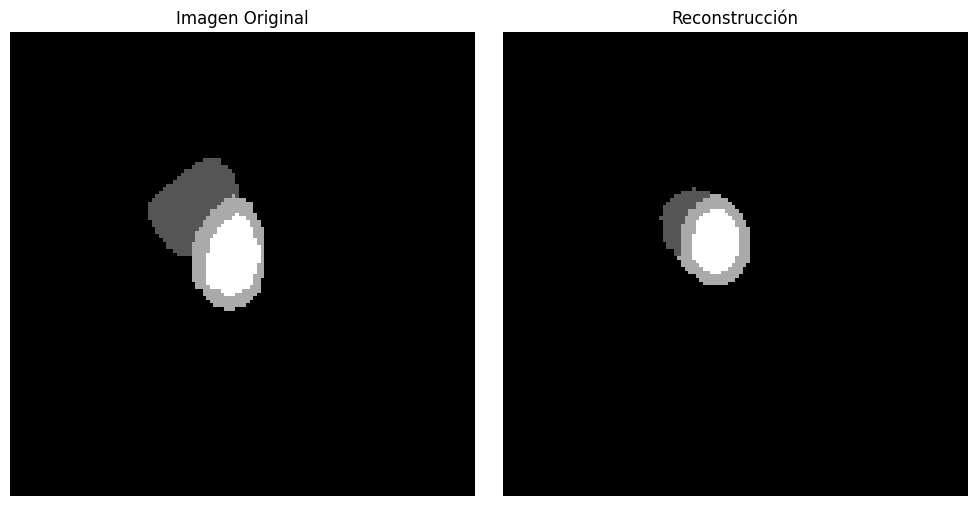

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_120.nii.gz


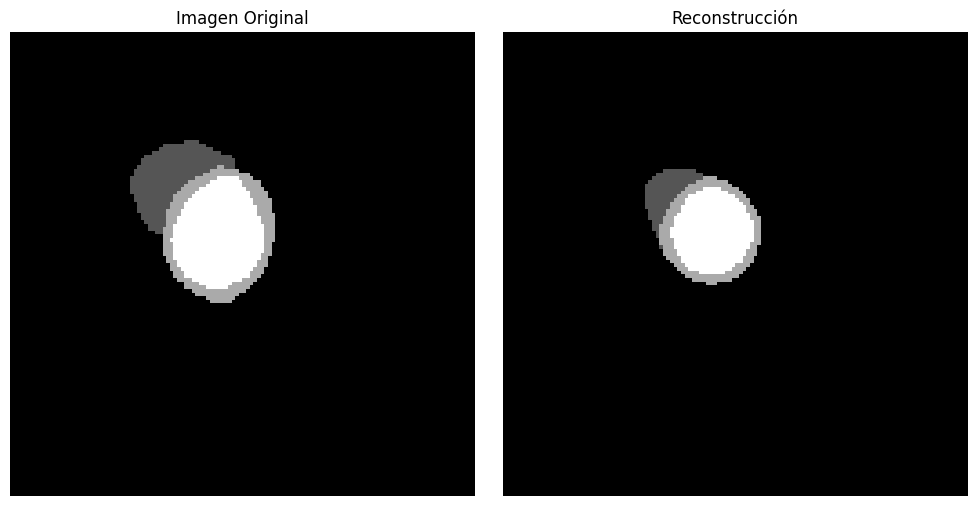

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_121.nii.gz


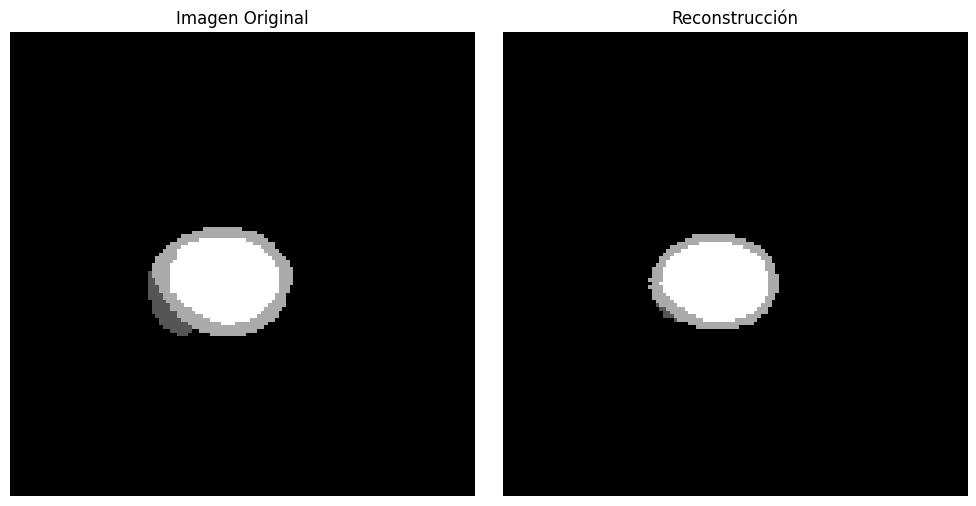

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_122.nii.gz


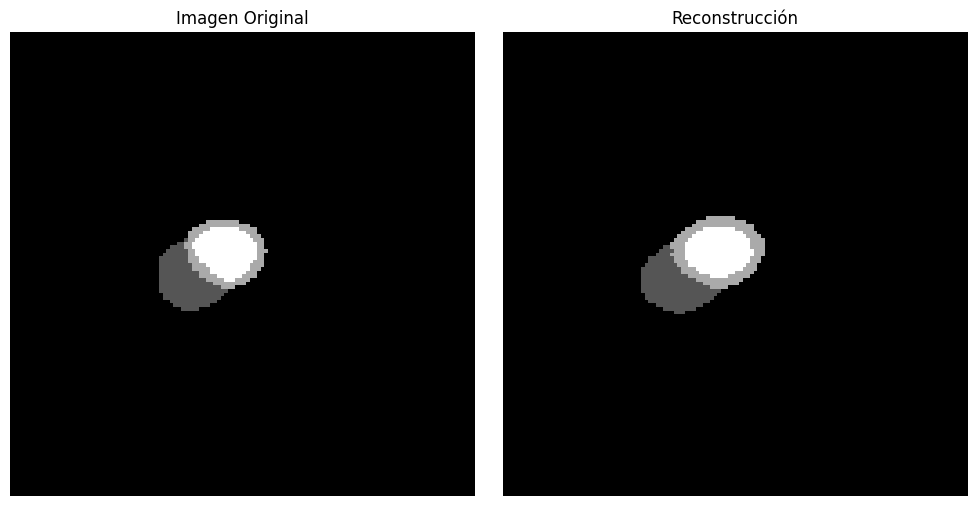

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_123.nii.gz


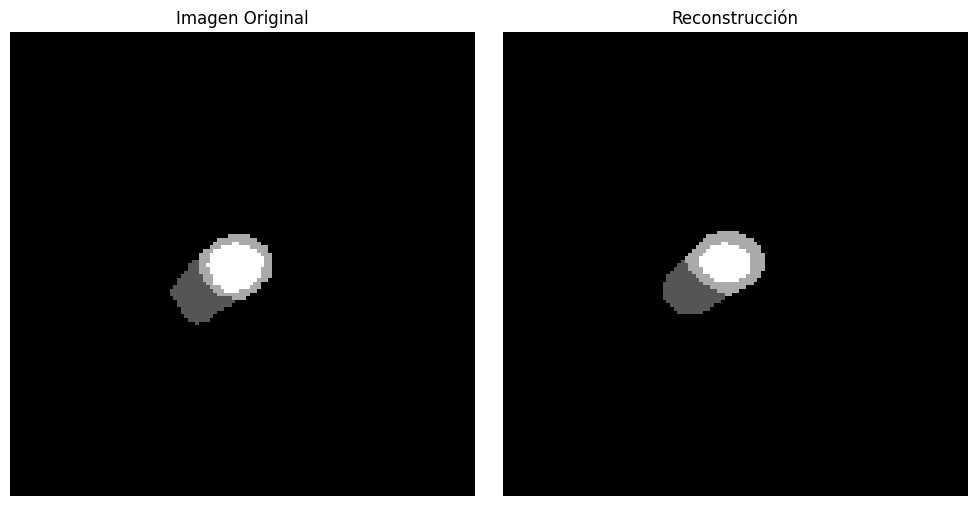

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_124.nii.gz


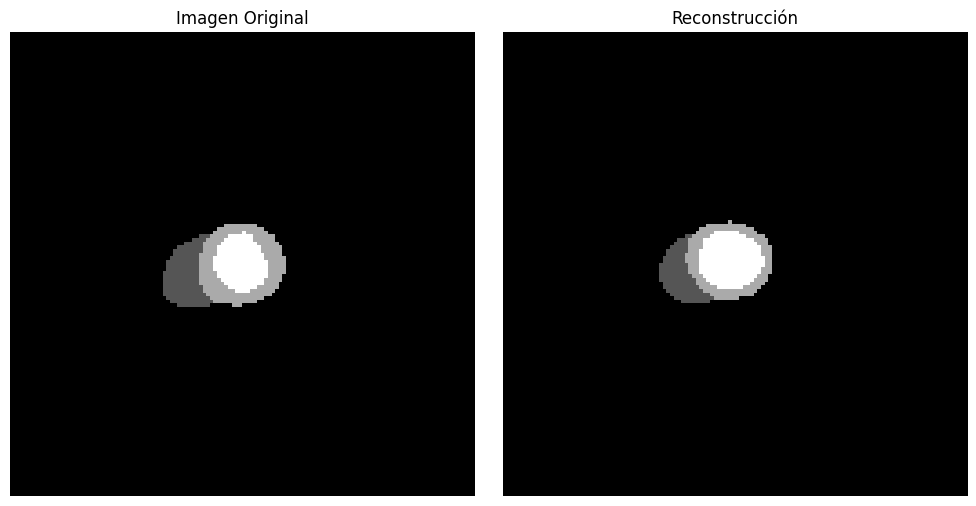

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_125.nii.gz


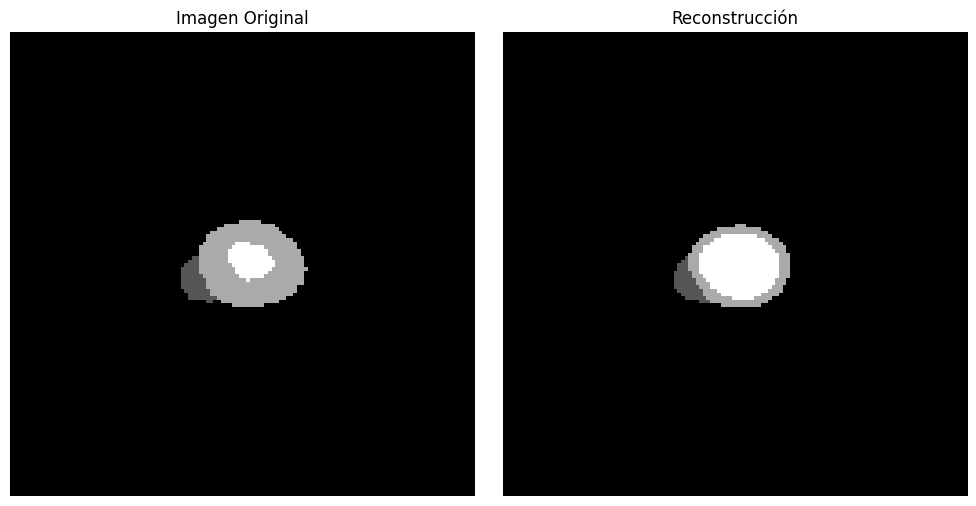

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_126.nii.gz


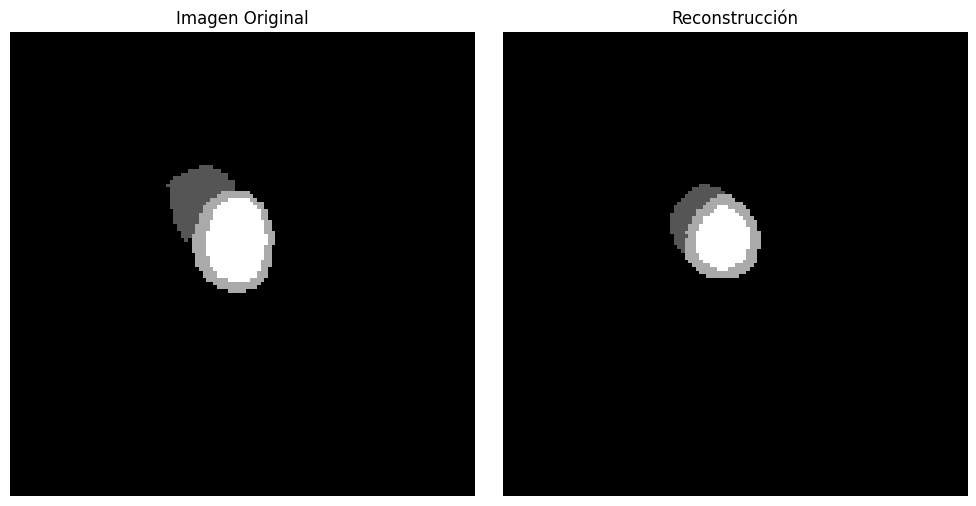

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_127.nii.gz


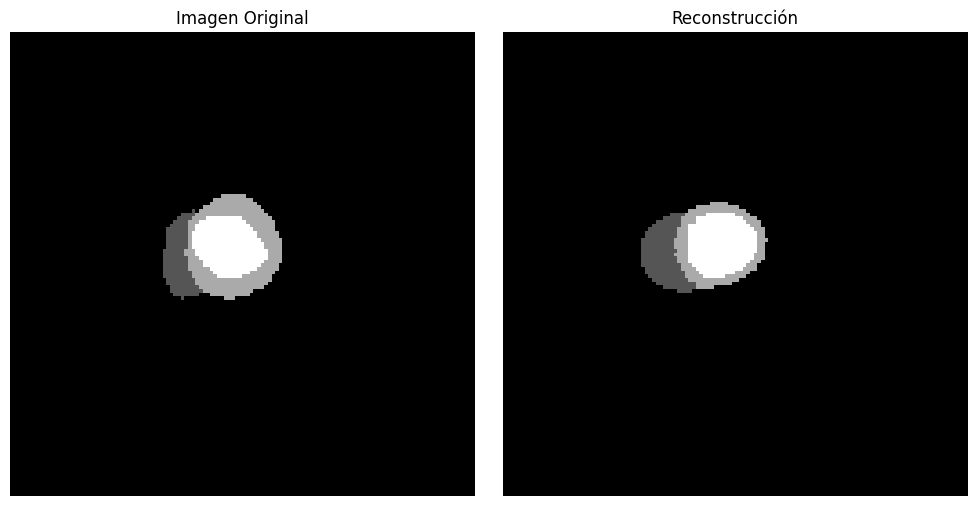

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_128.nii.gz


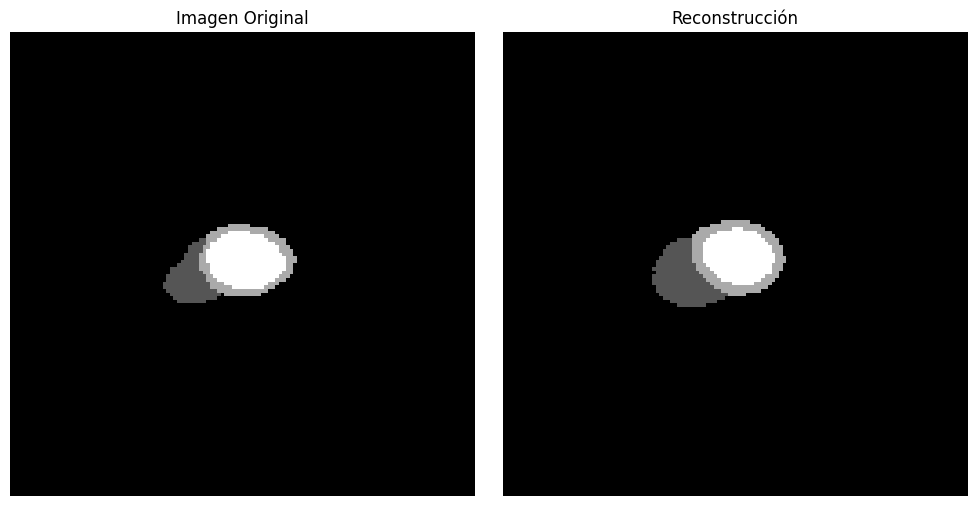

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_129.nii.gz


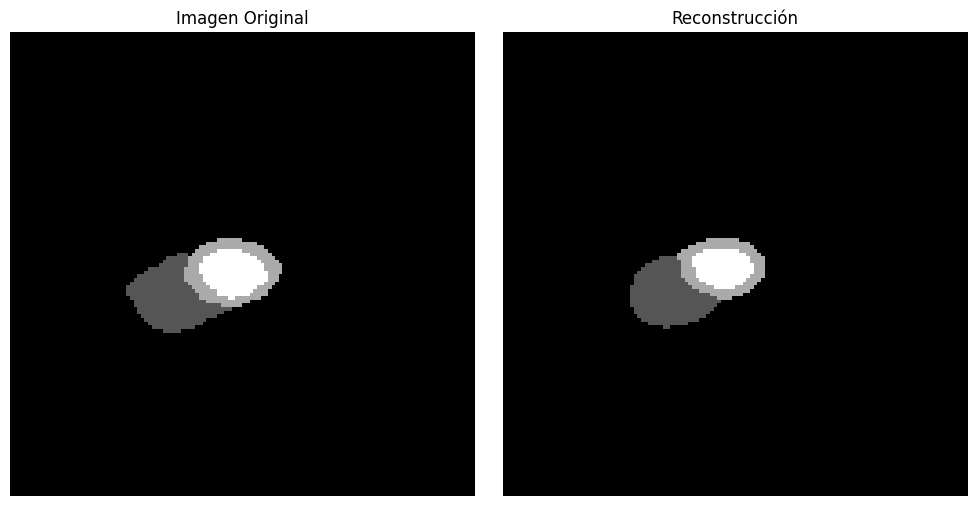

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_130.nii.gz


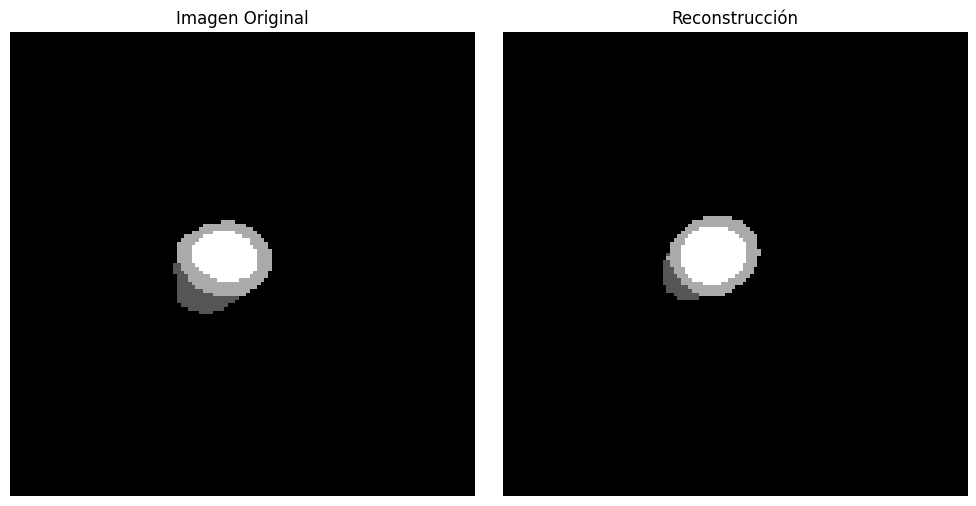

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_131.nii.gz


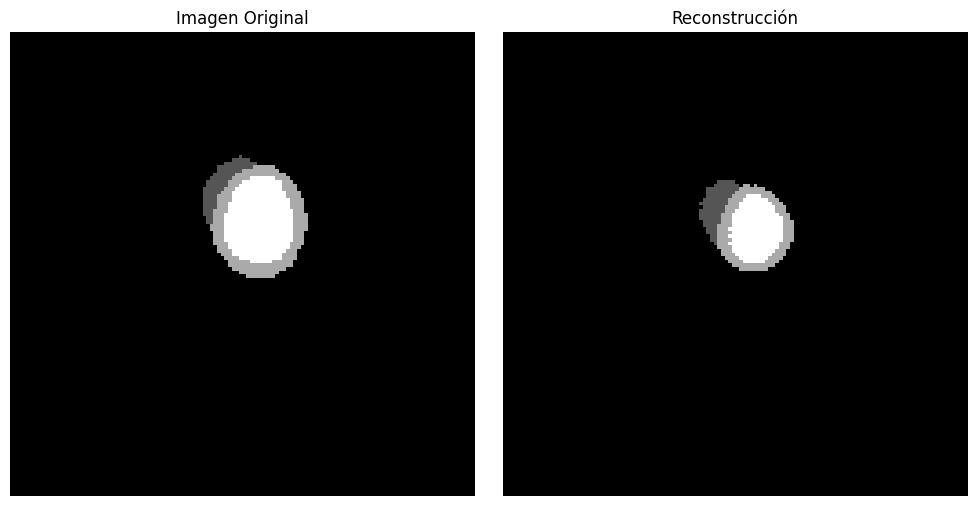

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_132.nii.gz


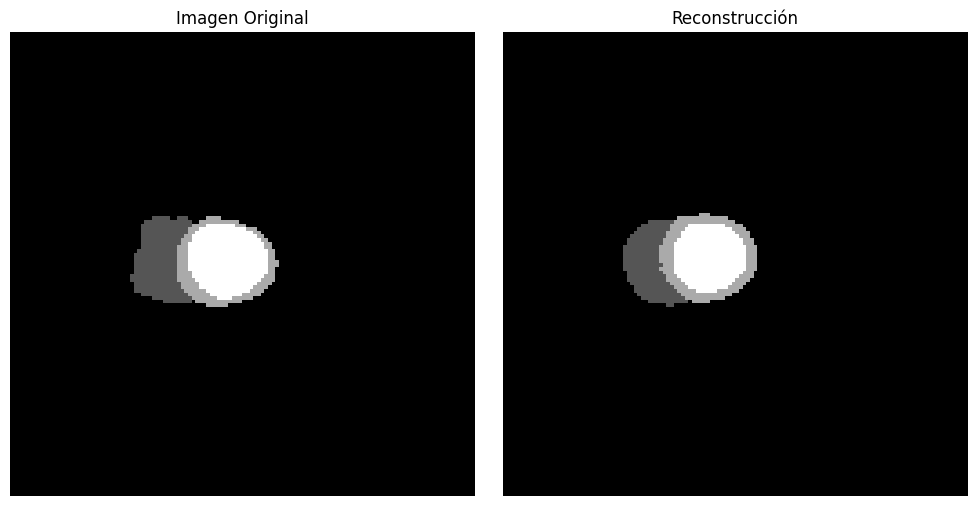

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_133.nii.gz


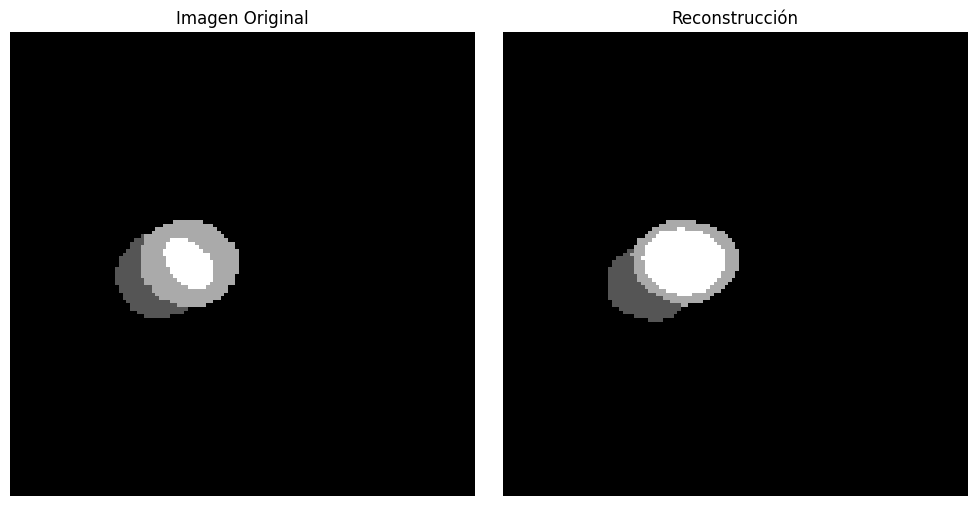

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_134.nii.gz


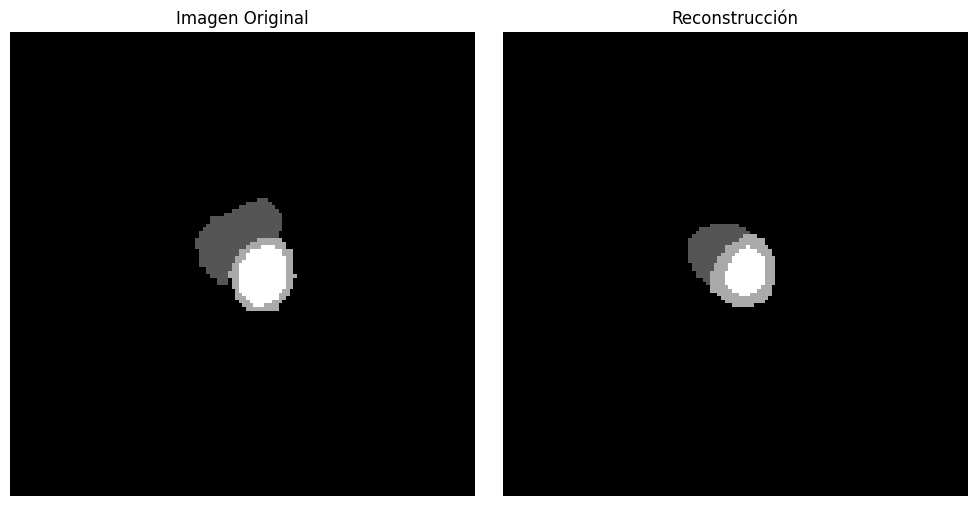

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129325389862
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_135.nii.gz


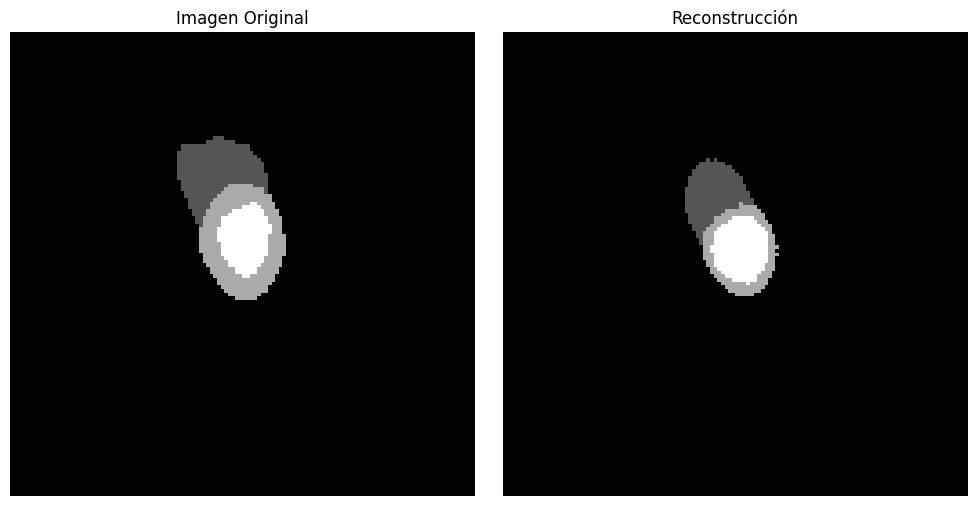

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_136.nii.gz


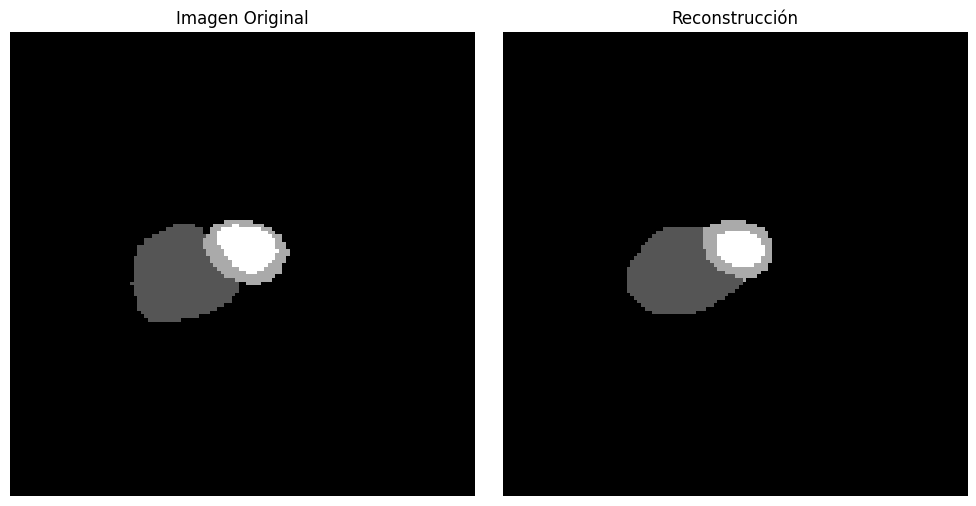

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_137.nii.gz


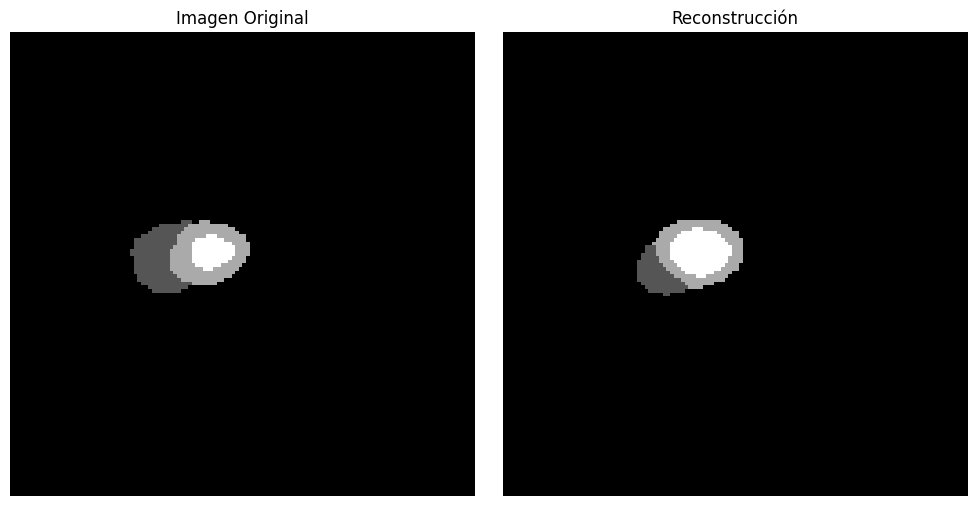

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_138.nii.gz


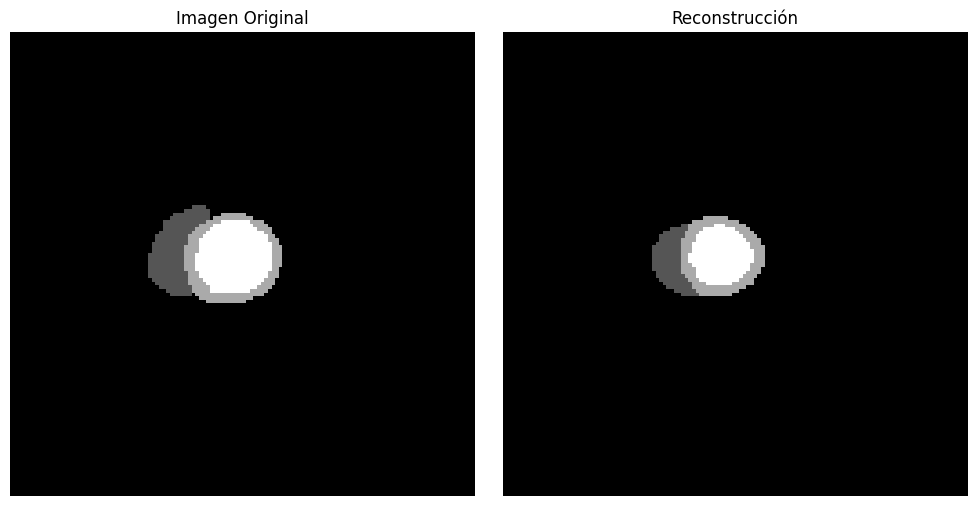

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_139.nii.gz


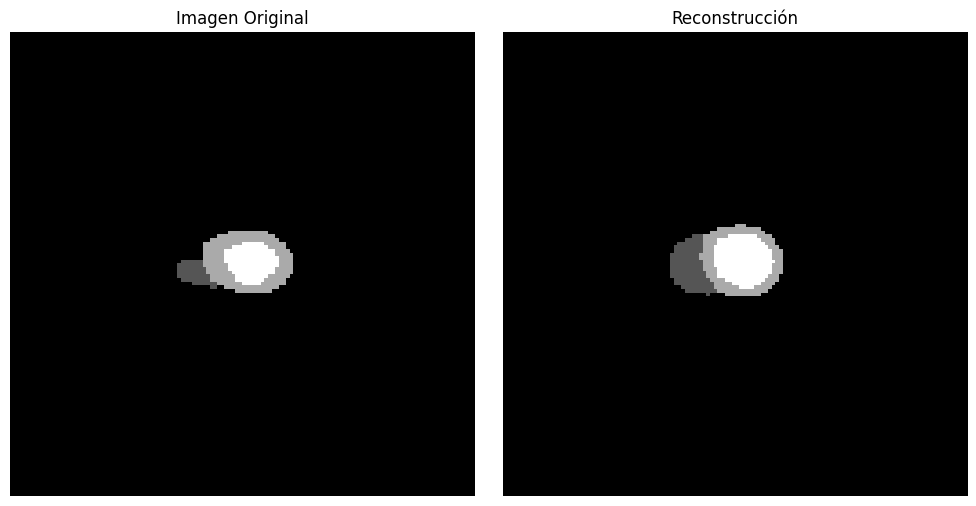

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_140.nii.gz


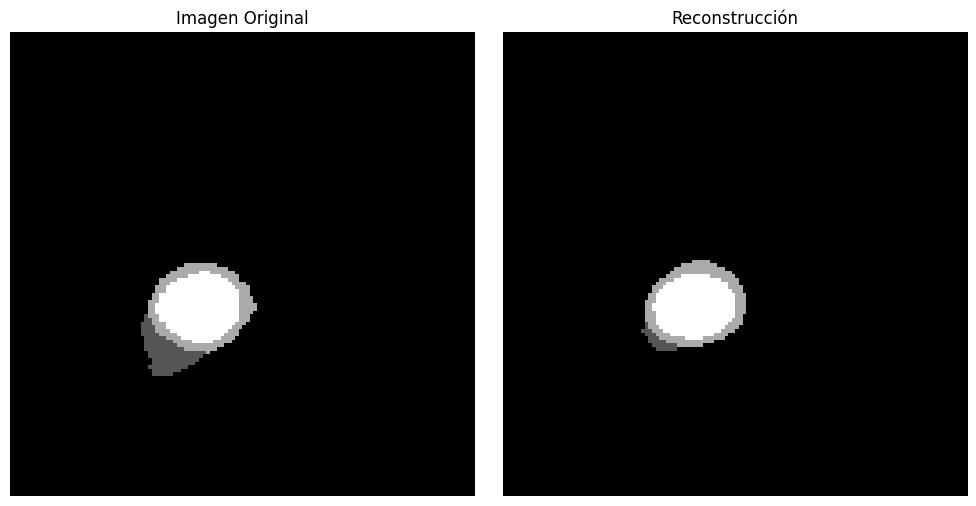

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_141.nii.gz


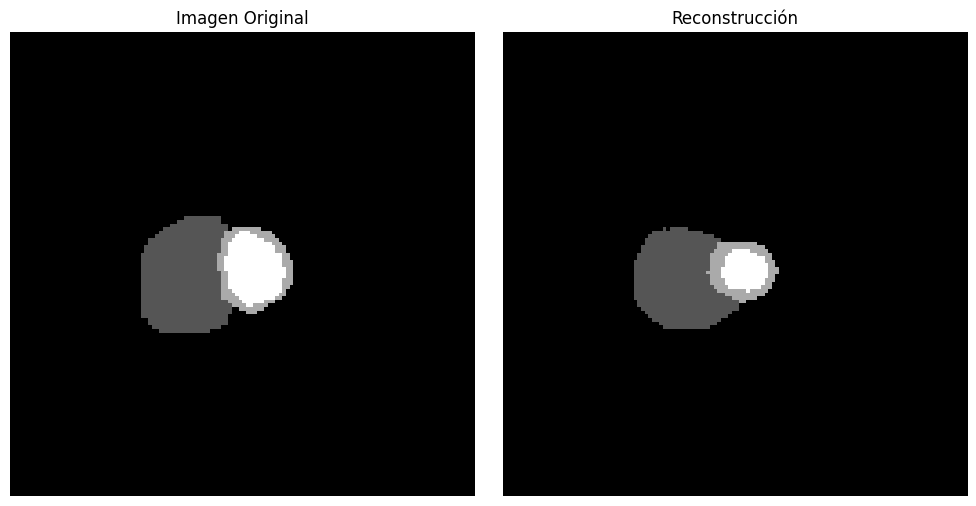

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_142.nii.gz


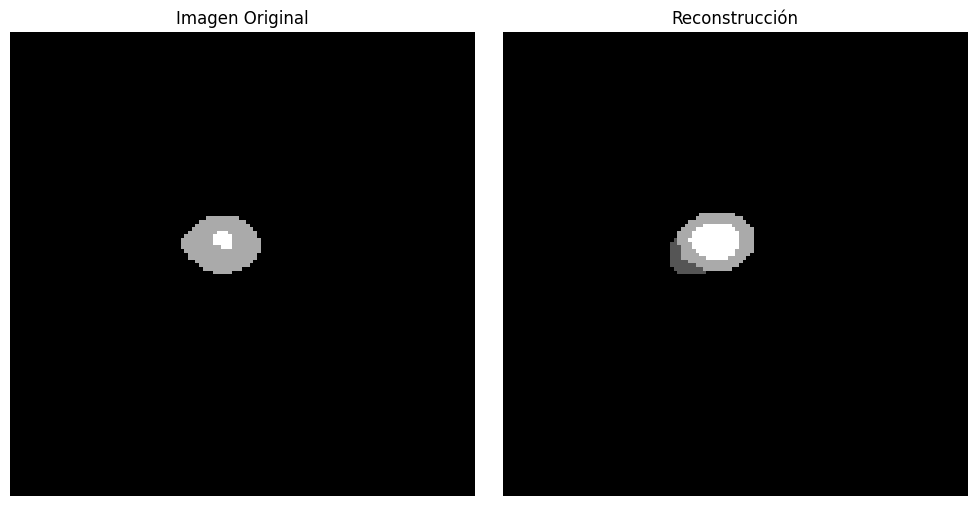

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129325389862
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_143.nii.gz


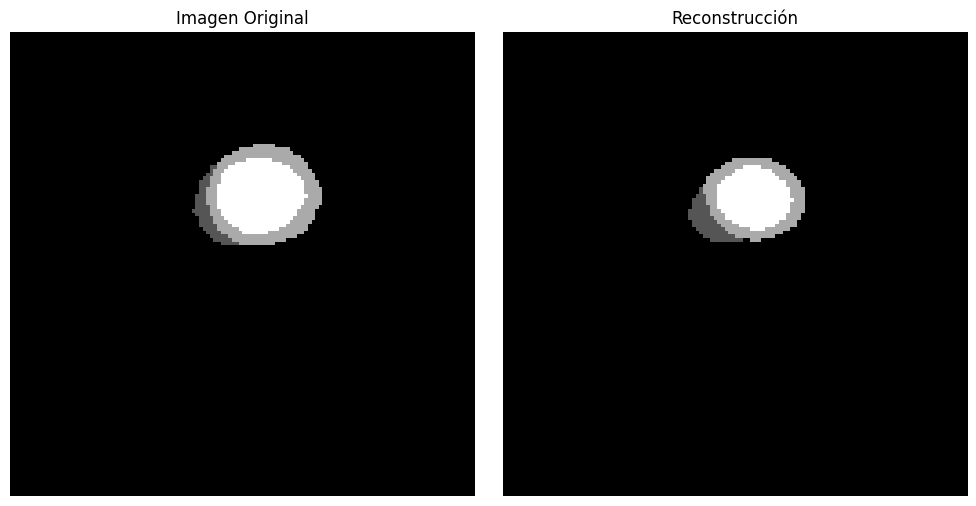

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129325389862
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_144.nii.gz


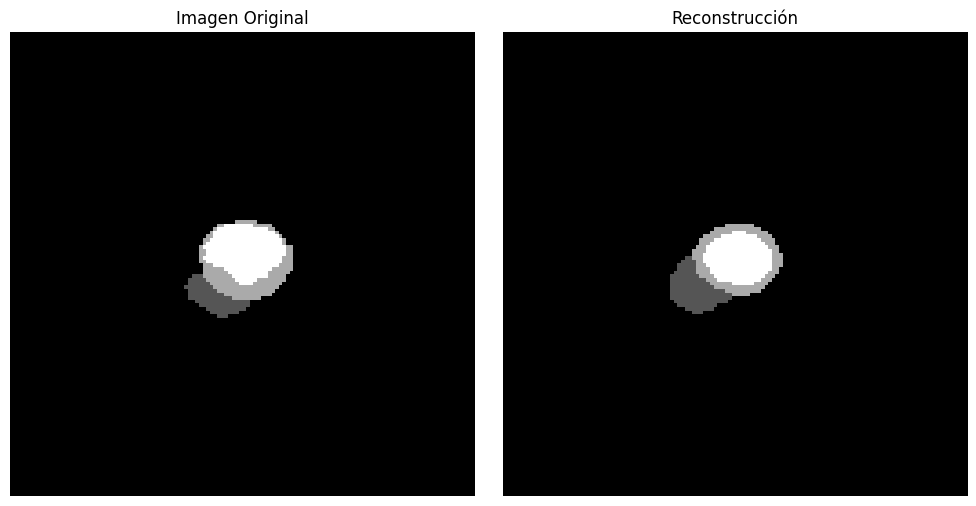

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_145.nii.gz


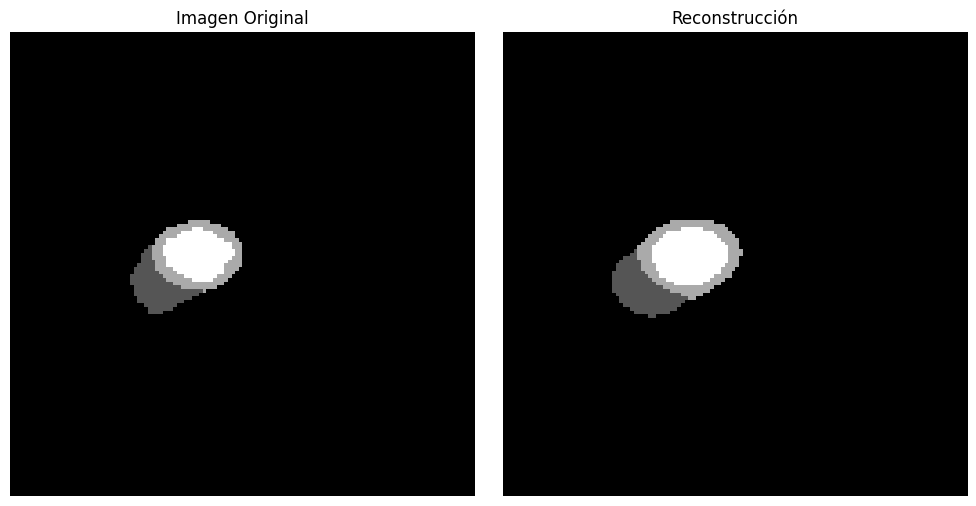

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_146.nii.gz


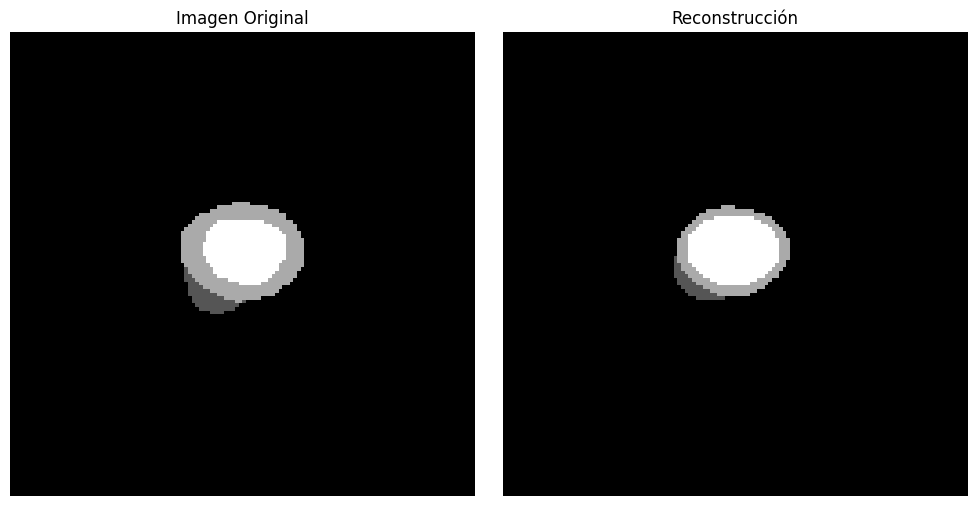

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_147.nii.gz


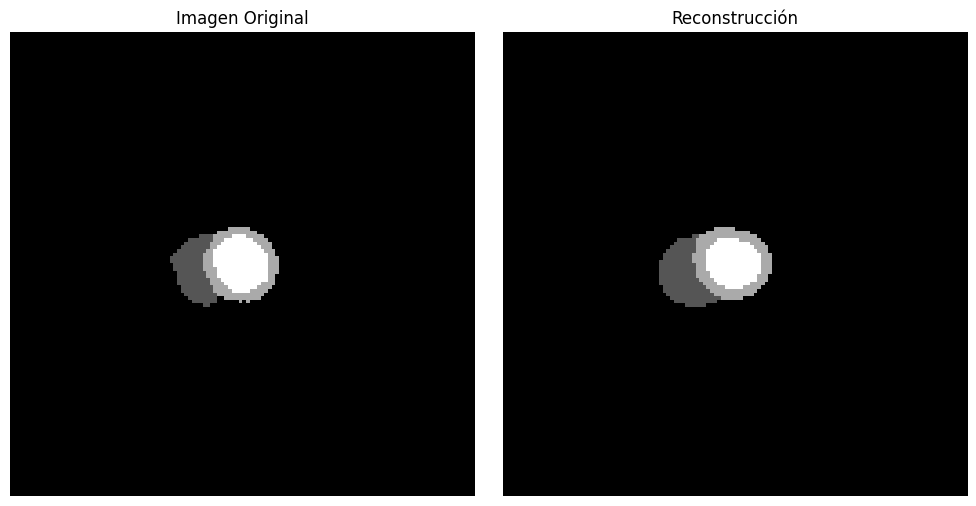

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_148.nii.gz


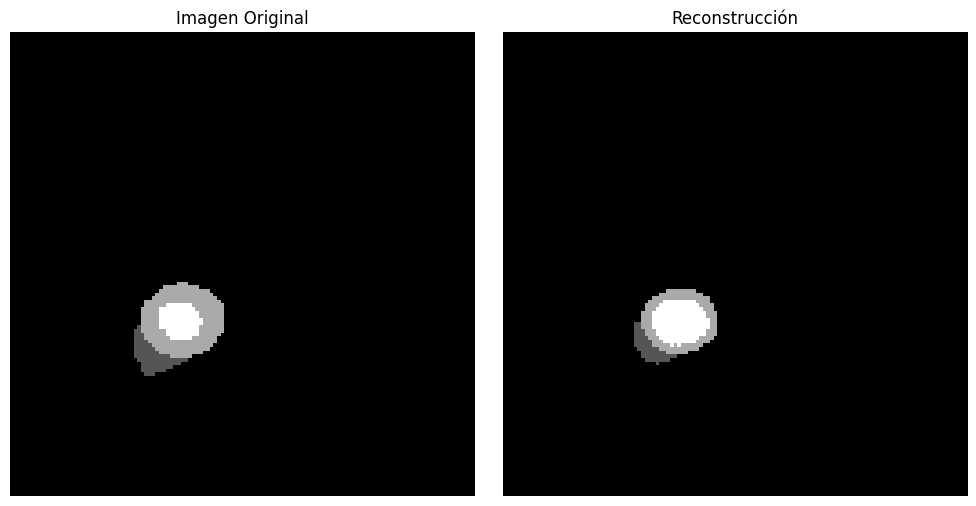

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_149.nii.gz


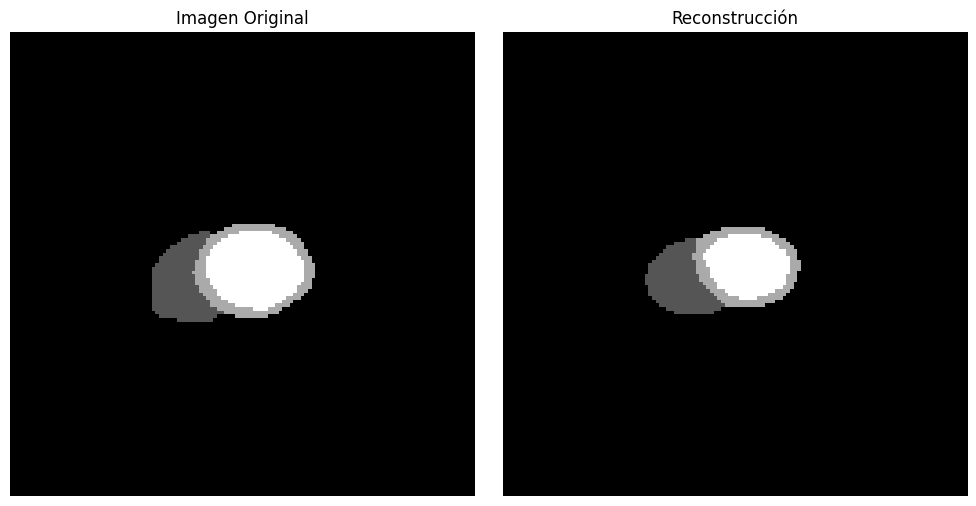

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_150.nii.gz


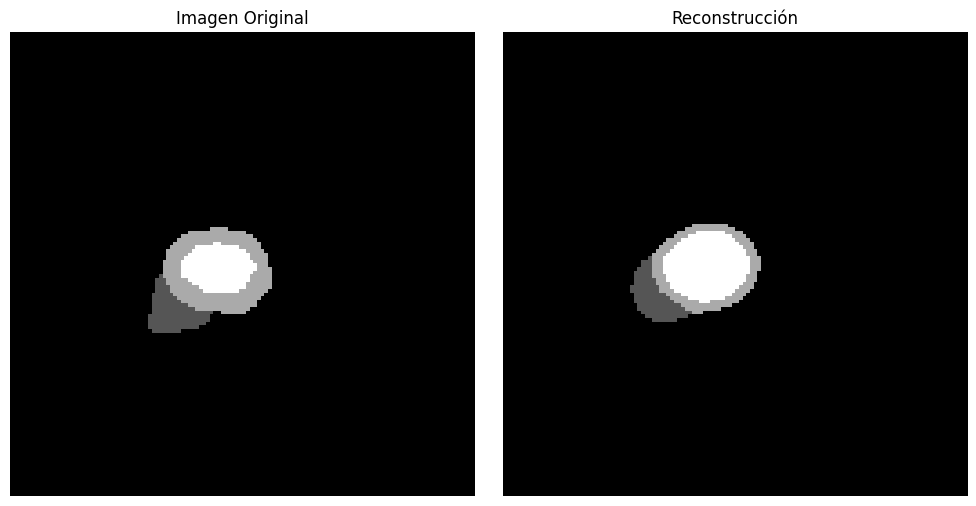

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_151.nii.gz


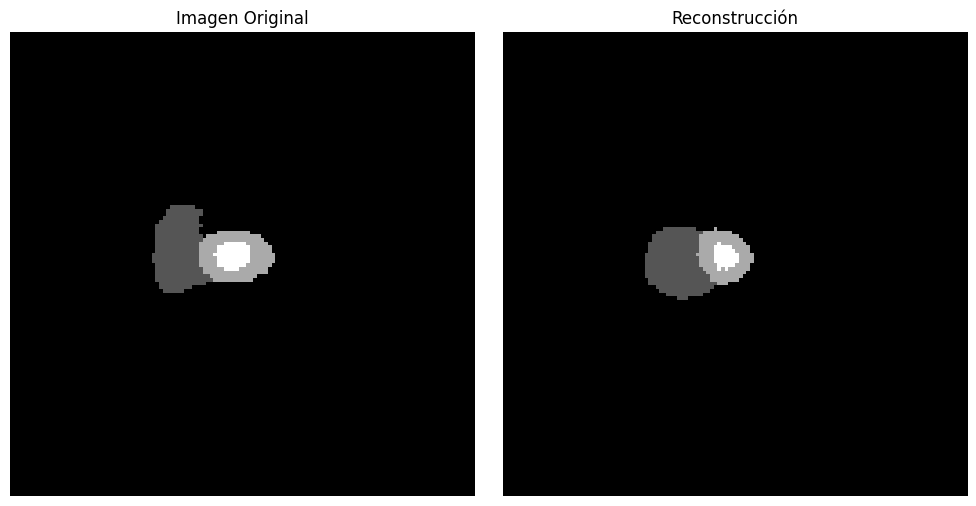

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_152.nii.gz


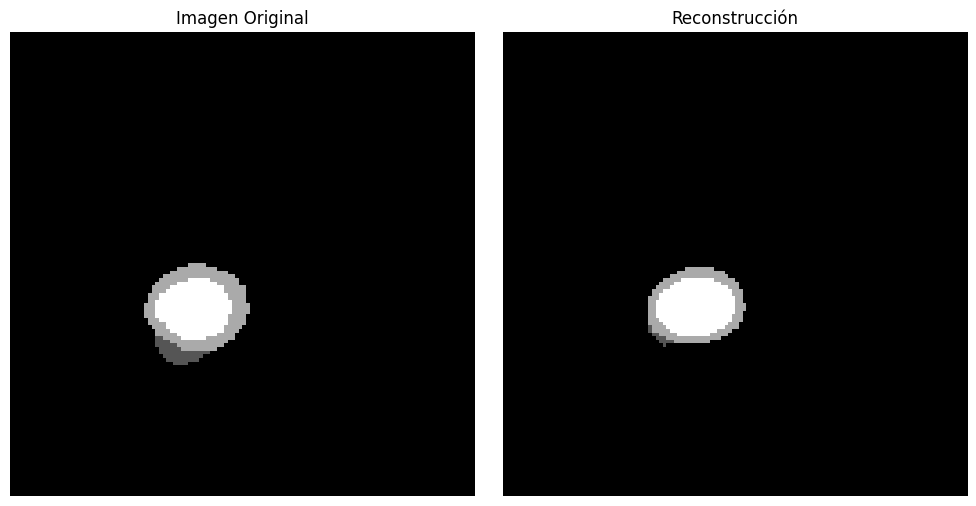

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_153.nii.gz


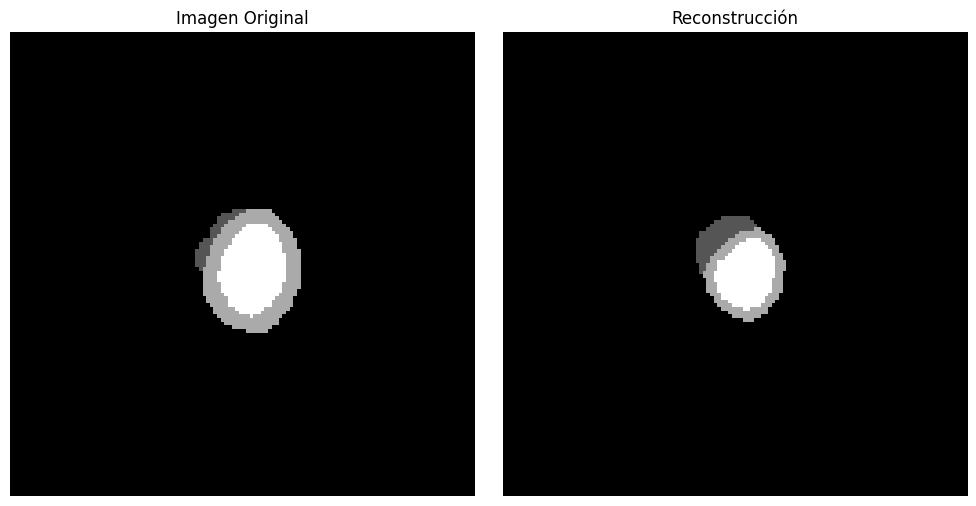

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_154.nii.gz


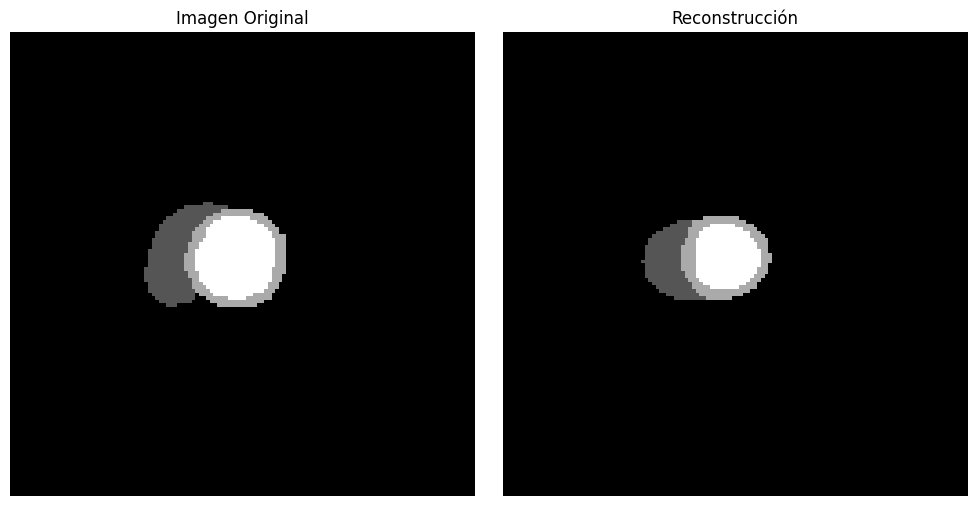

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_155.nii.gz


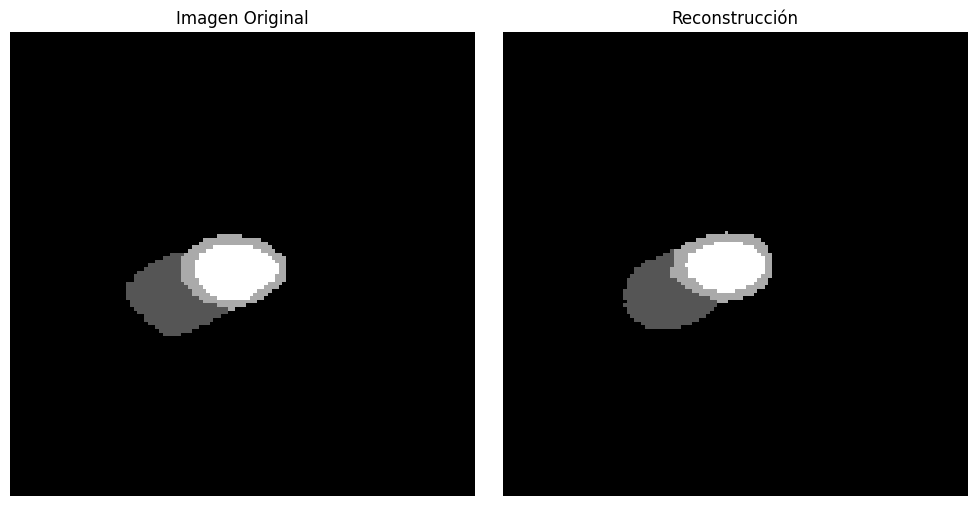

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_156.nii.gz


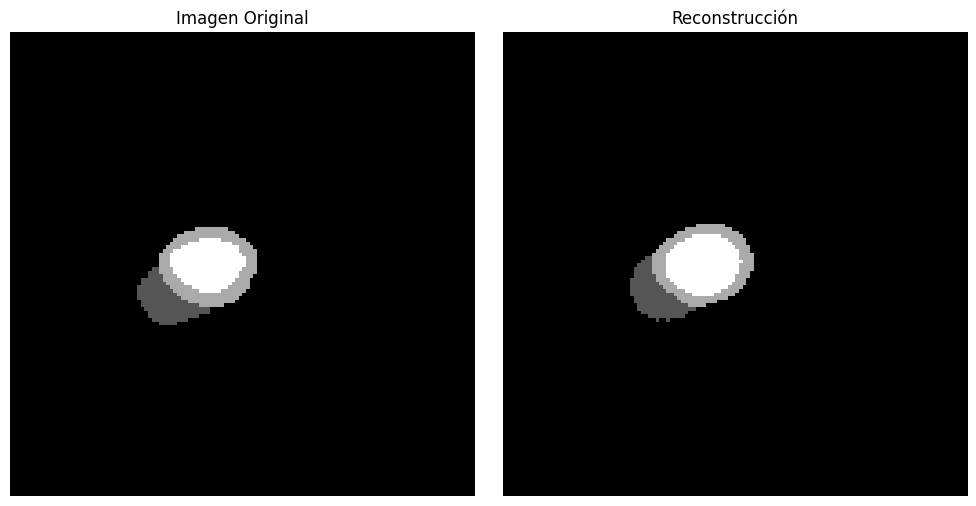

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_157.nii.gz


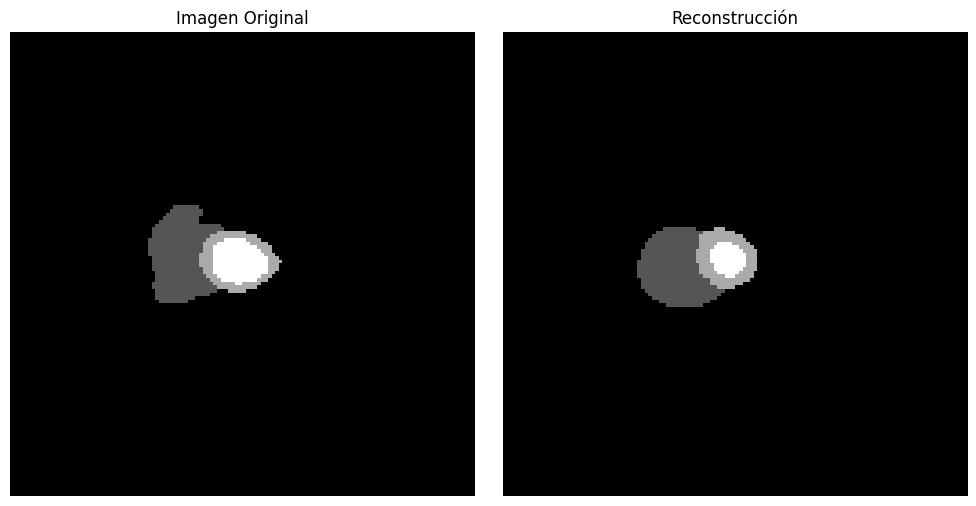

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_158.nii.gz


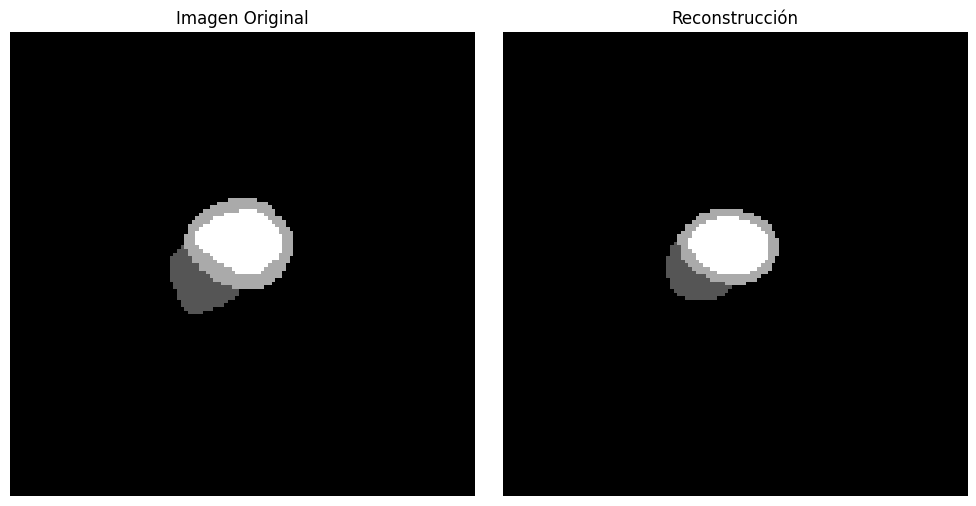

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_159.nii.gz


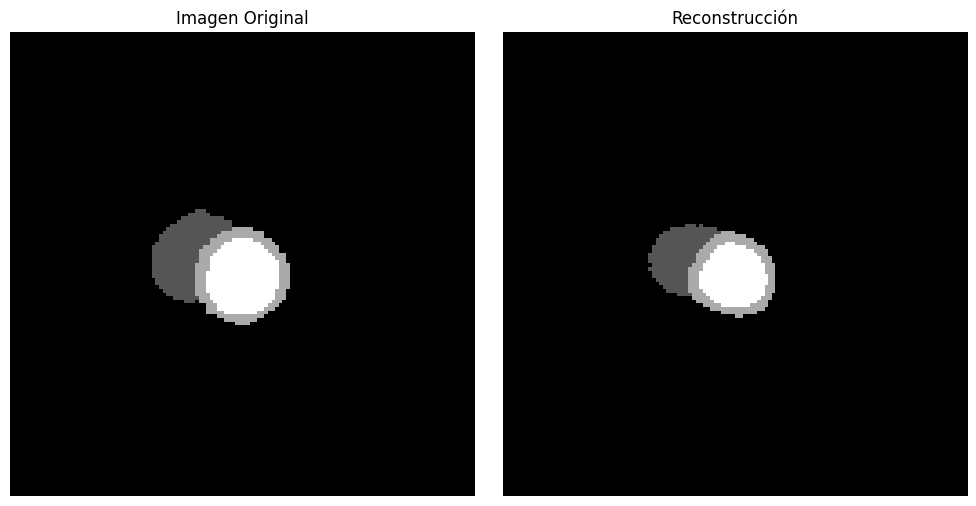

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_160.nii.gz


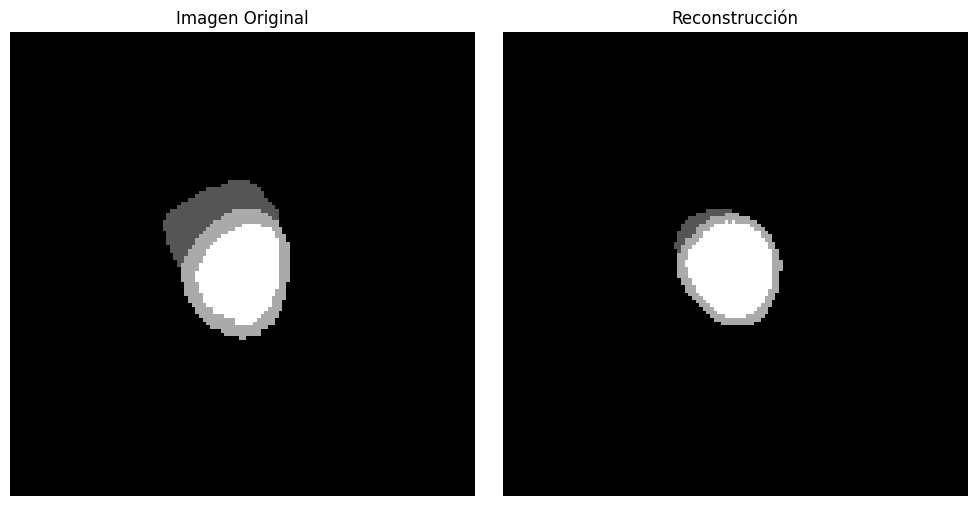

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_161.nii.gz


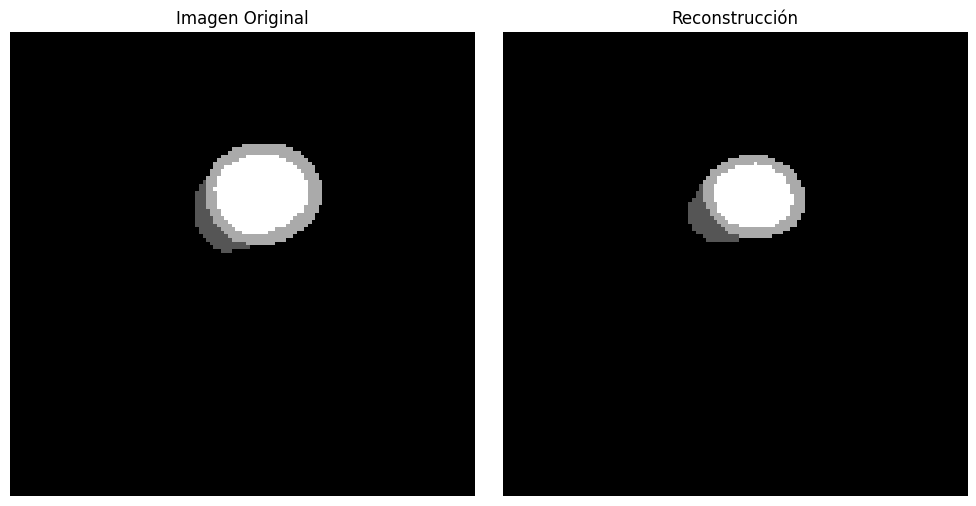

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_162.nii.gz


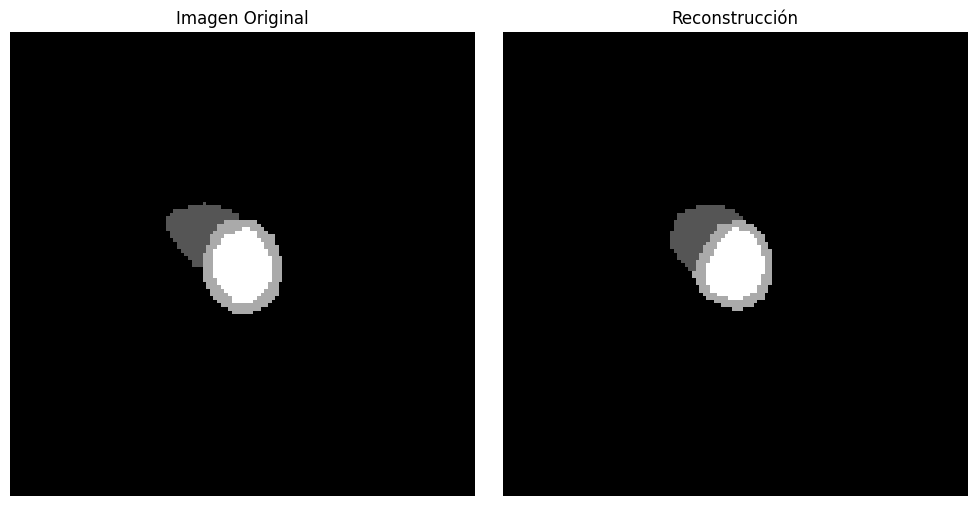

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_163.nii.gz


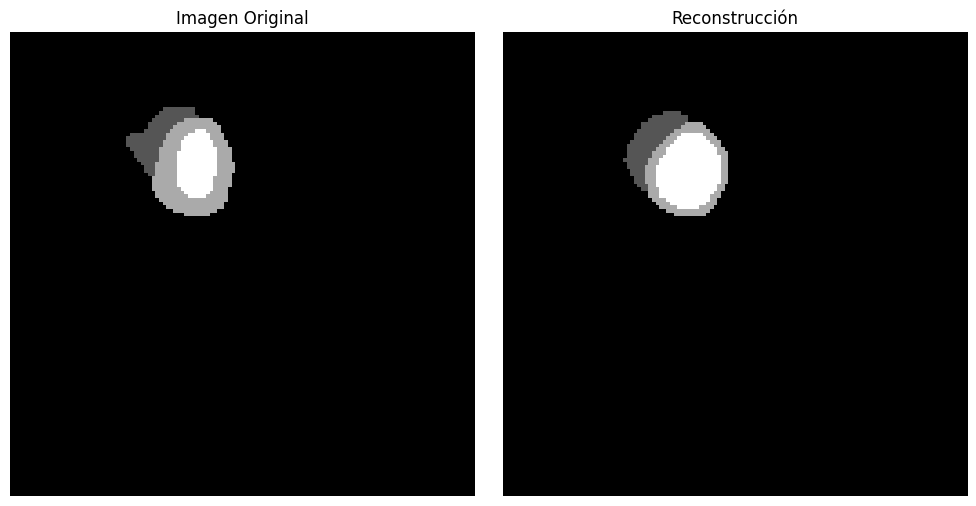

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129325389862
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_164.nii.gz


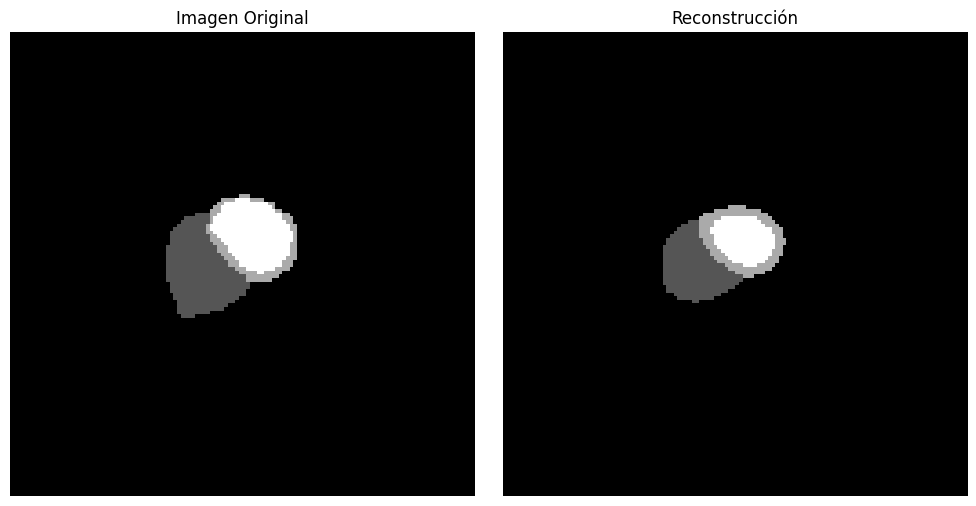

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_165.nii.gz


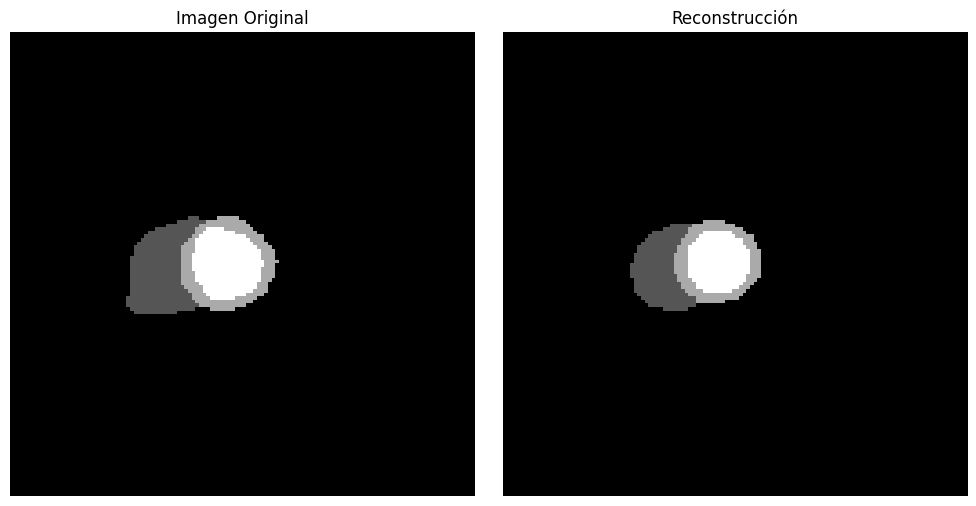

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_166.nii.gz


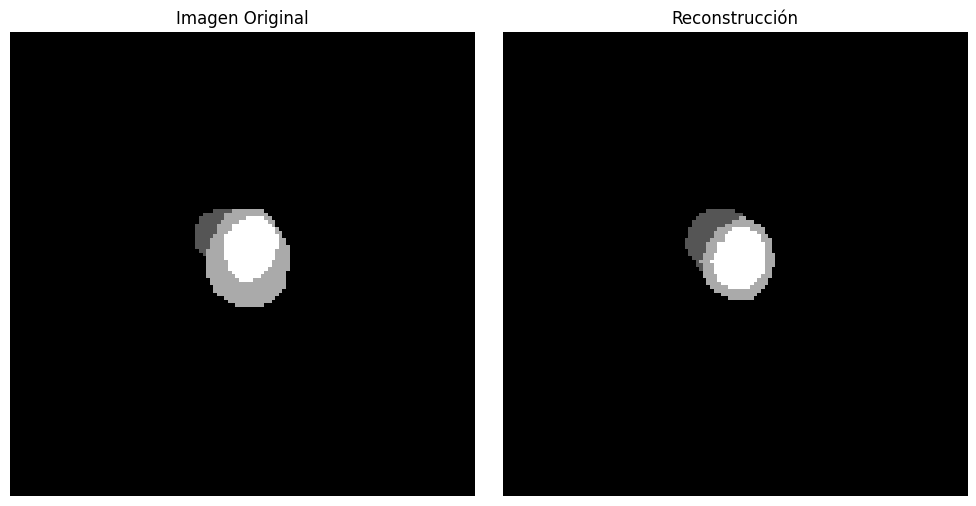

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_167.nii.gz


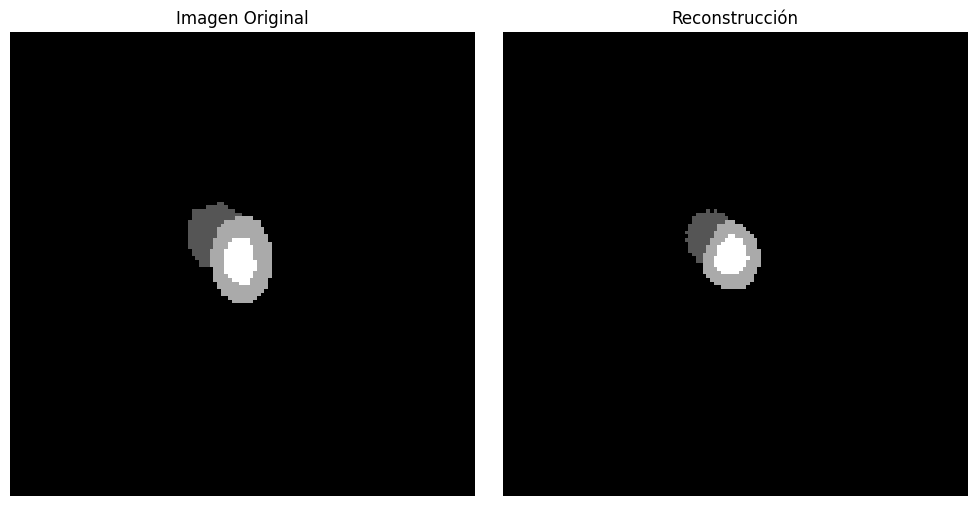

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_168.nii.gz


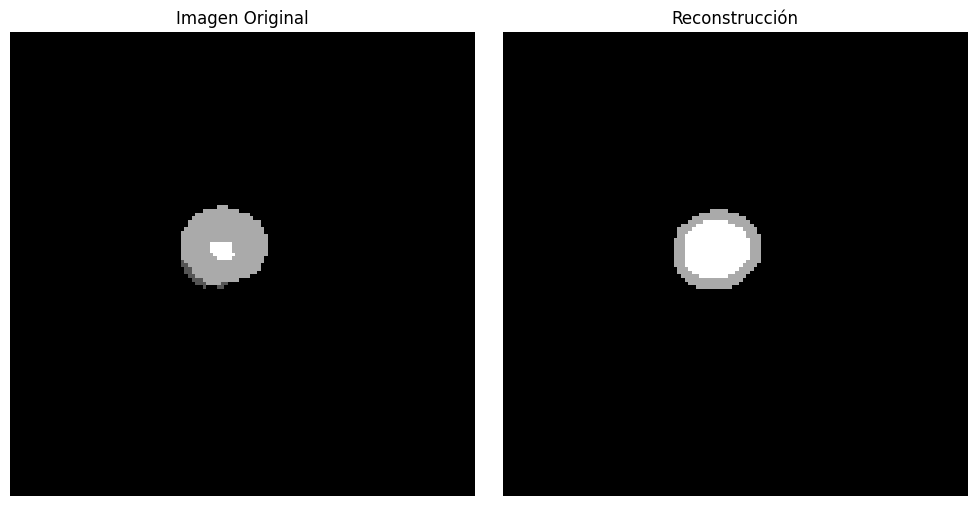

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_169.nii.gz


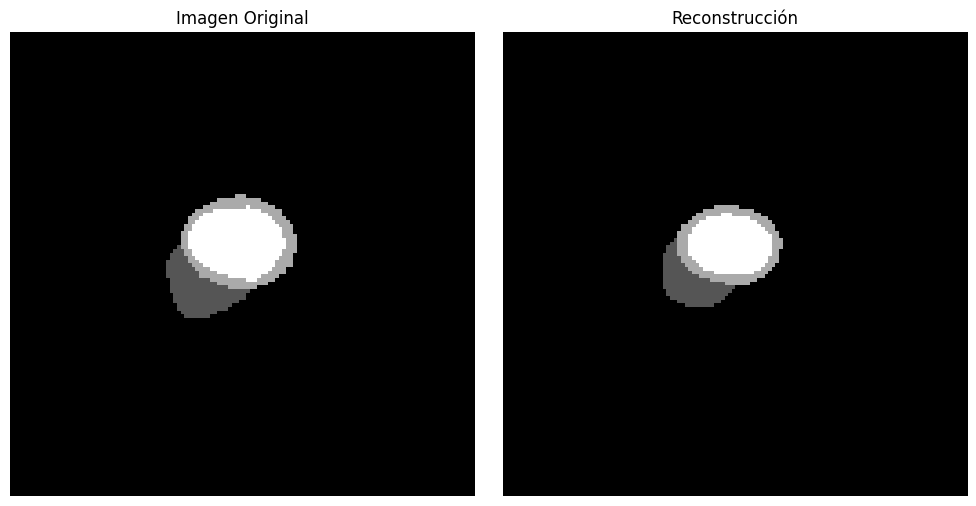

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_170.nii.gz


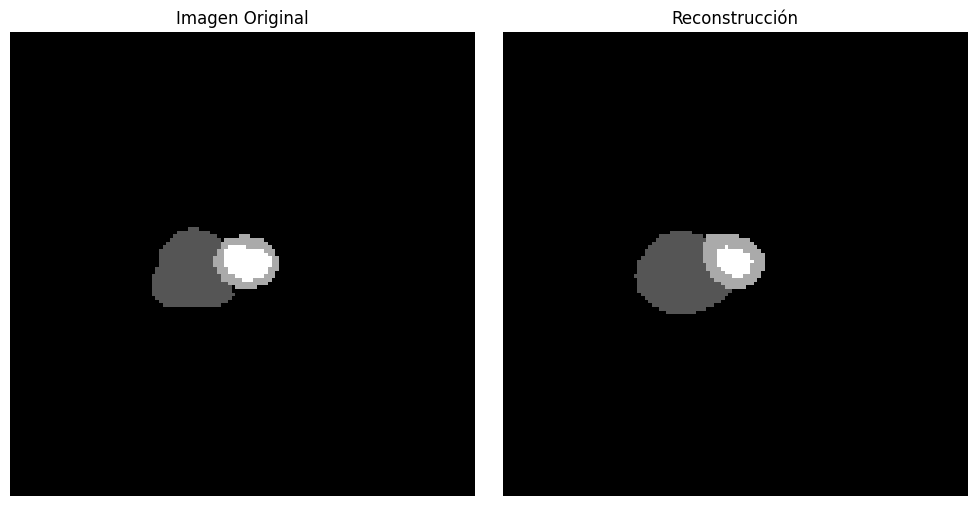

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_171.nii.gz


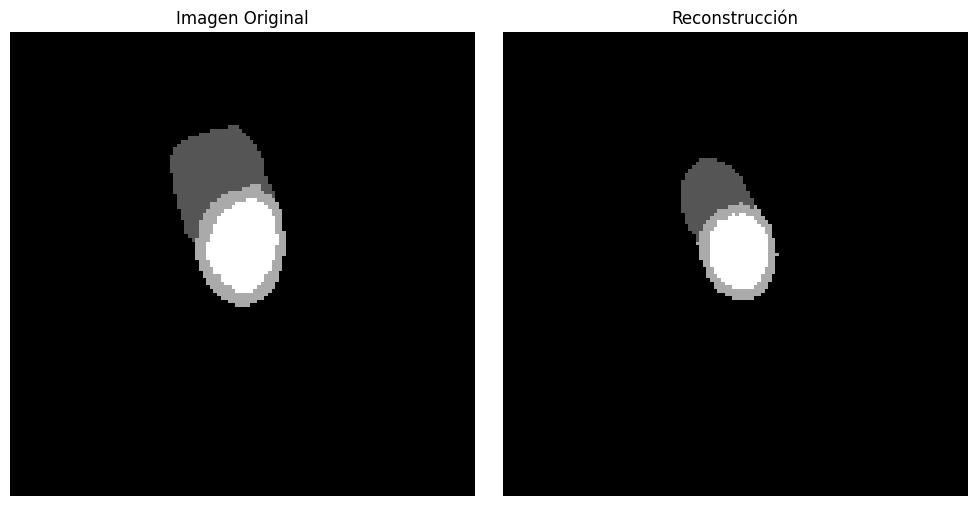

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_172.nii.gz


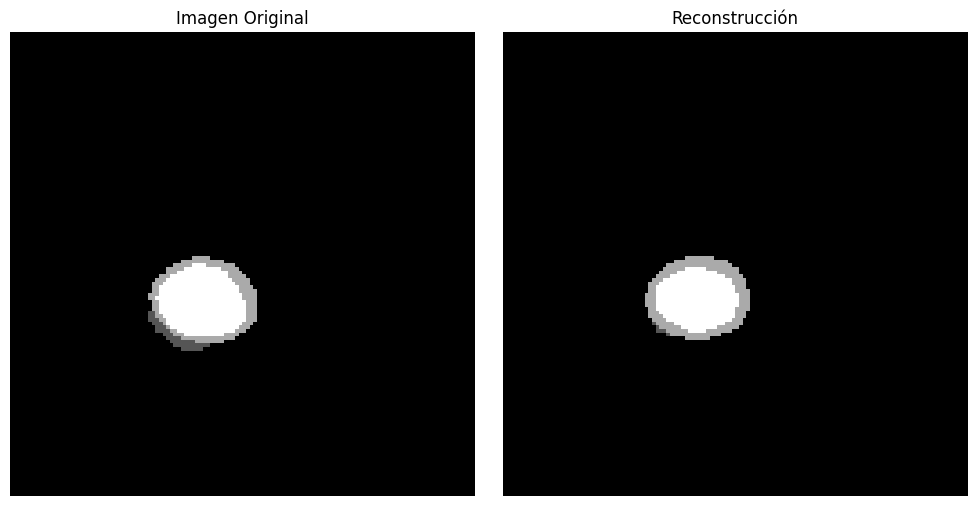

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_173.nii.gz


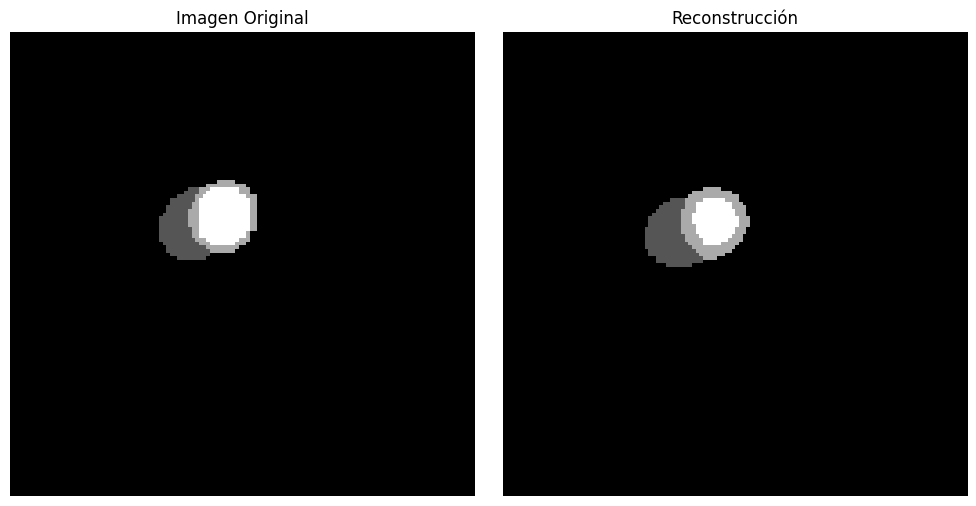

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_174.nii.gz


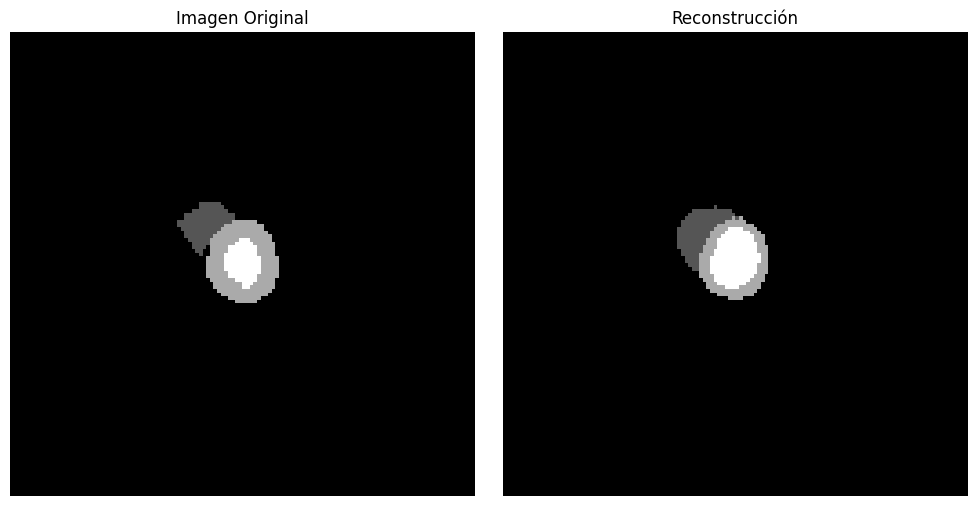

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_175.nii.gz


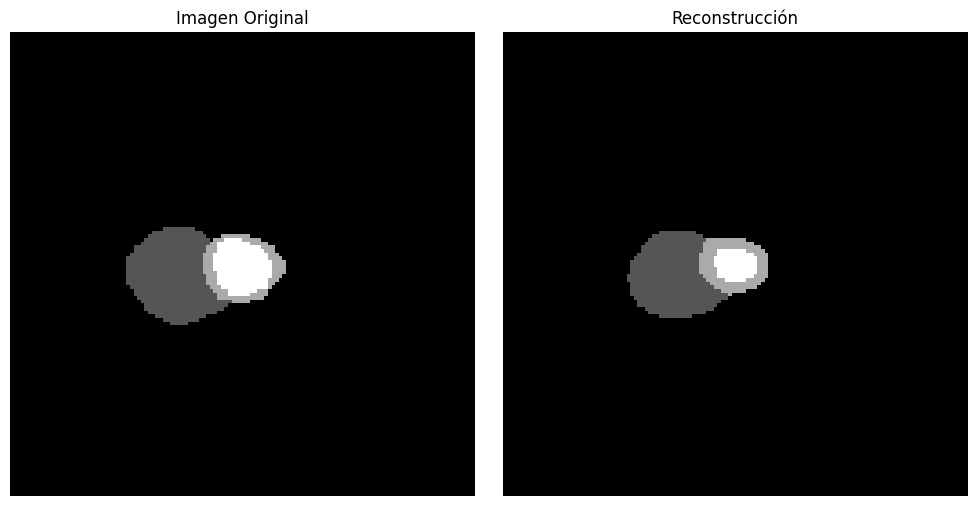

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_176.nii.gz


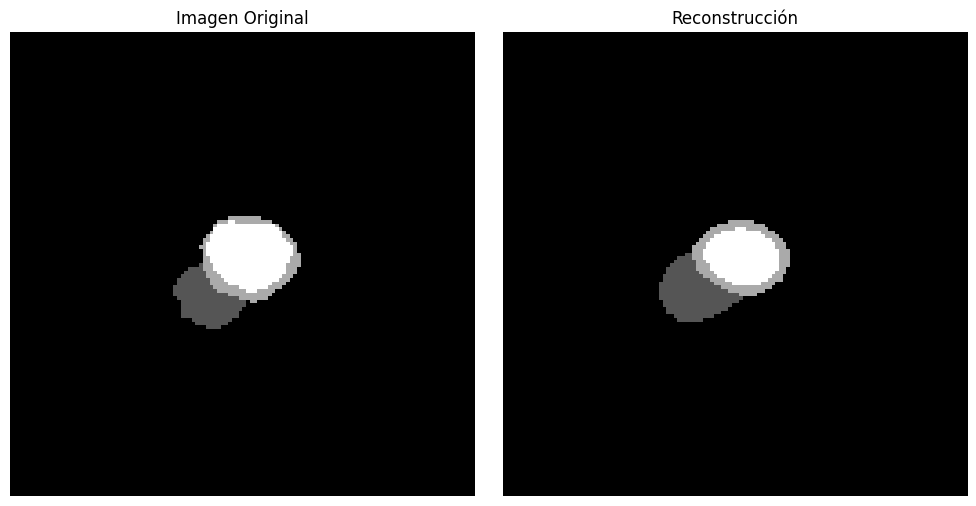

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_177.nii.gz


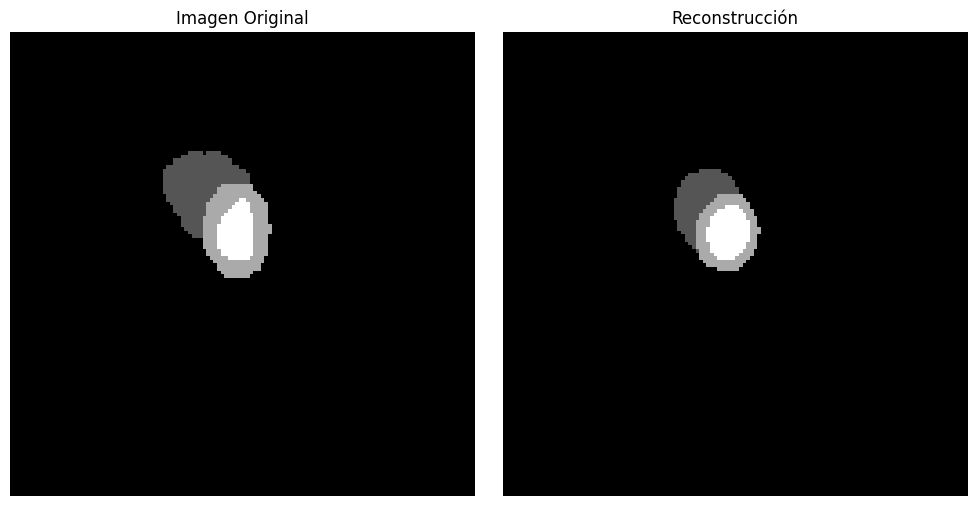

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_178.nii.gz


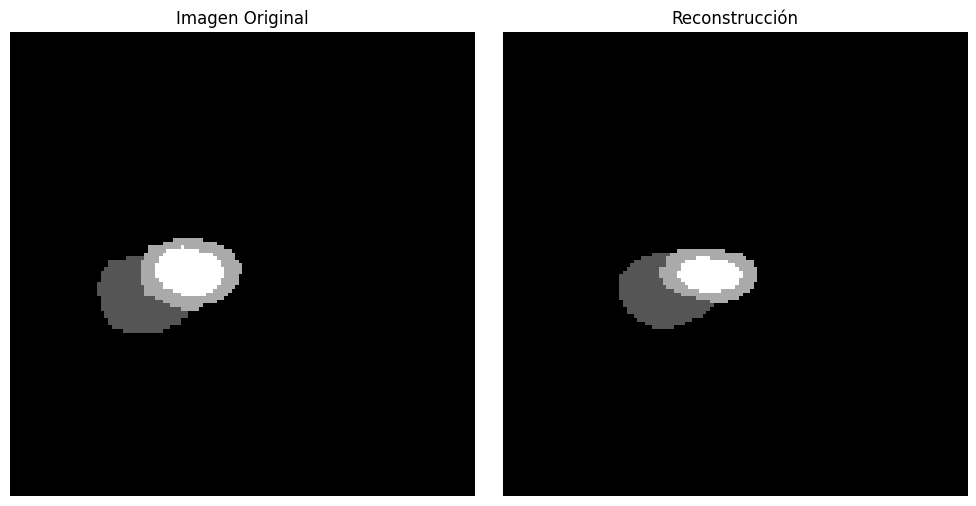

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_179.nii.gz


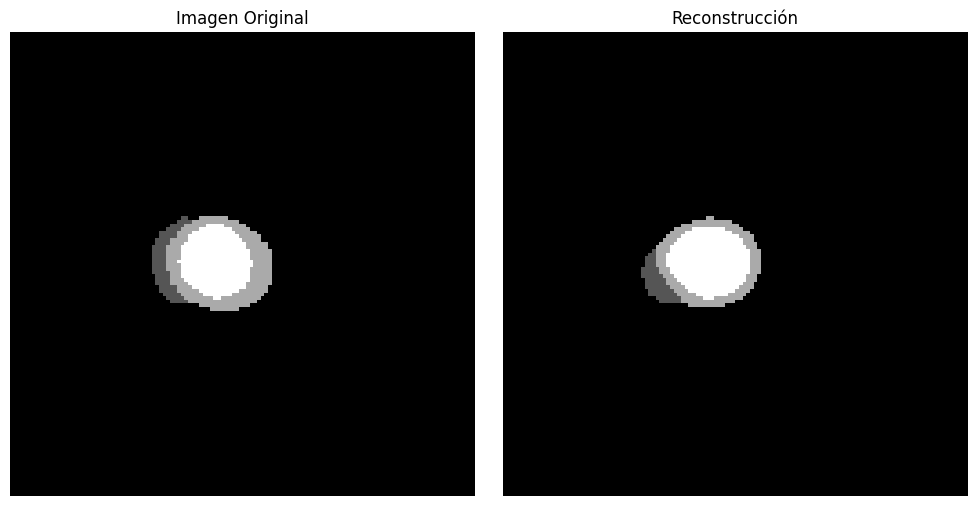

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_180.nii.gz


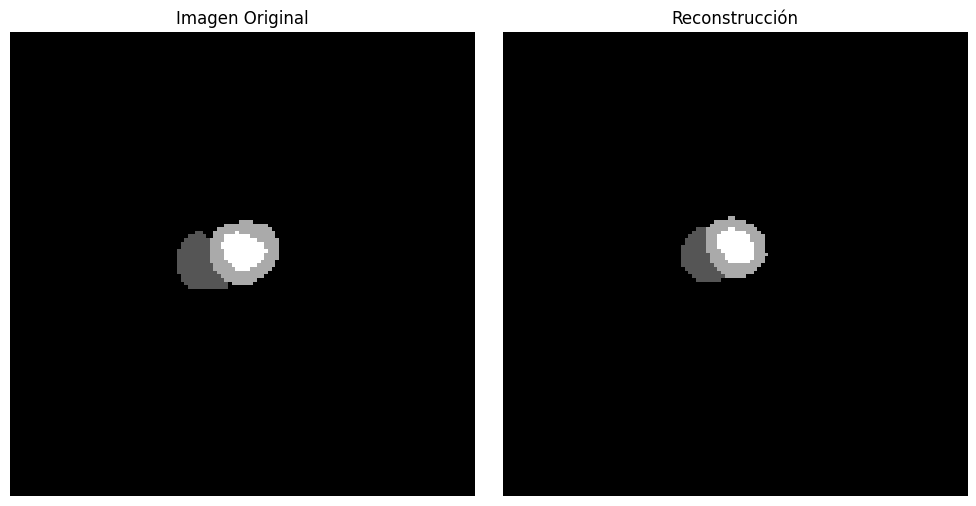

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_181.nii.gz


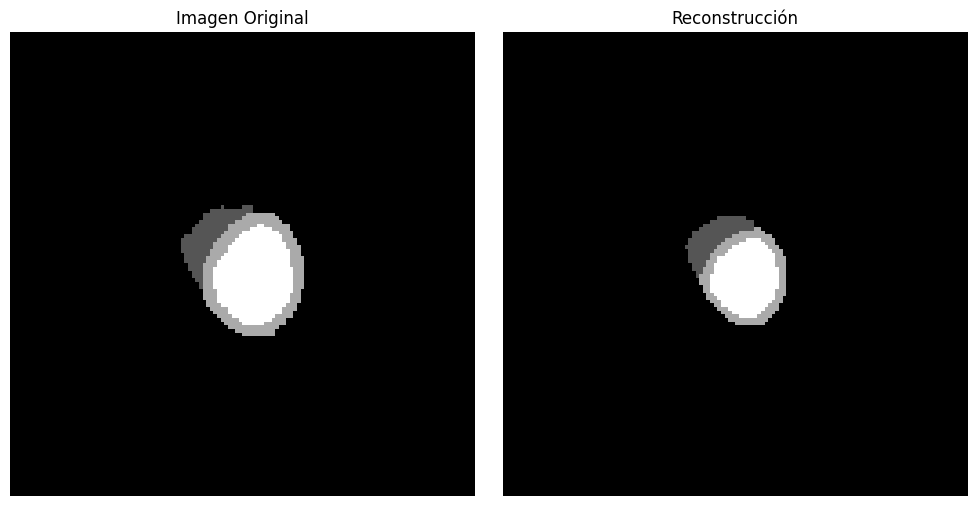

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_182.nii.gz


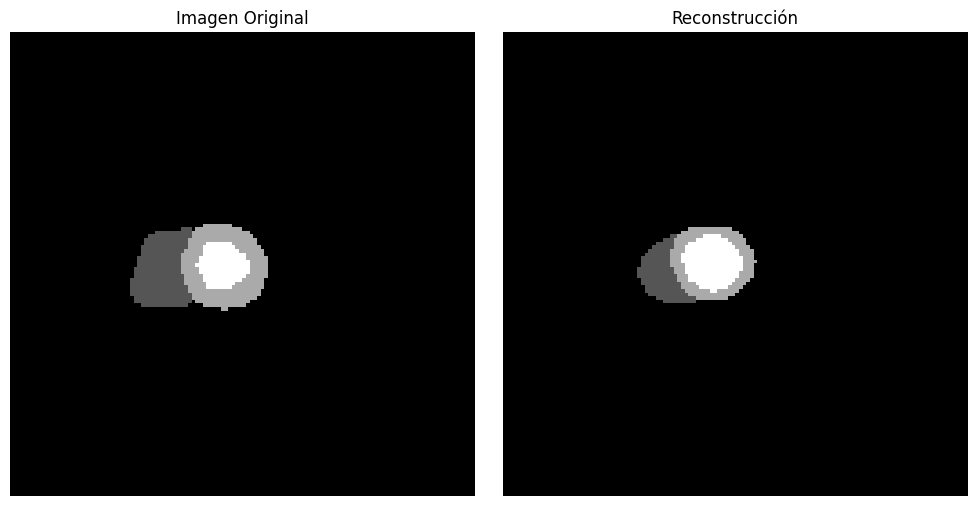

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129325389862
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_183.nii.gz


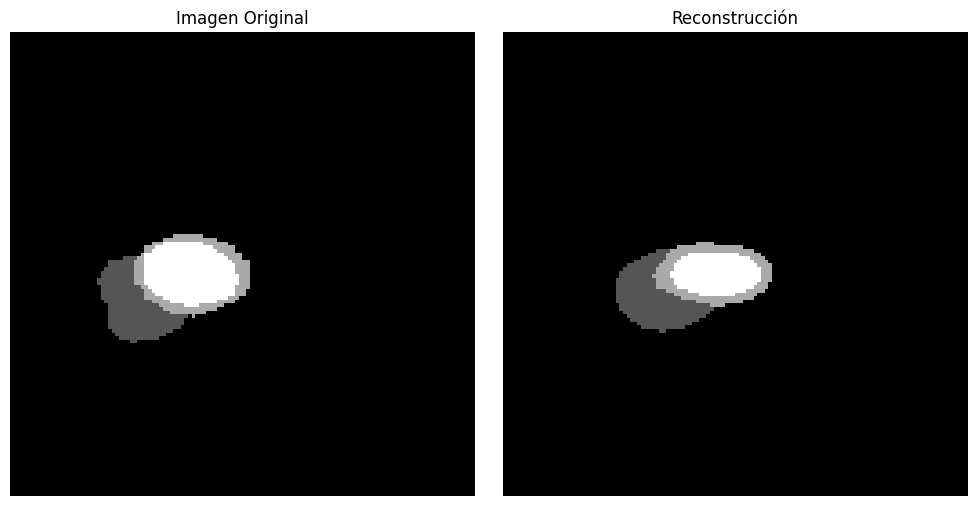

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_184.nii.gz


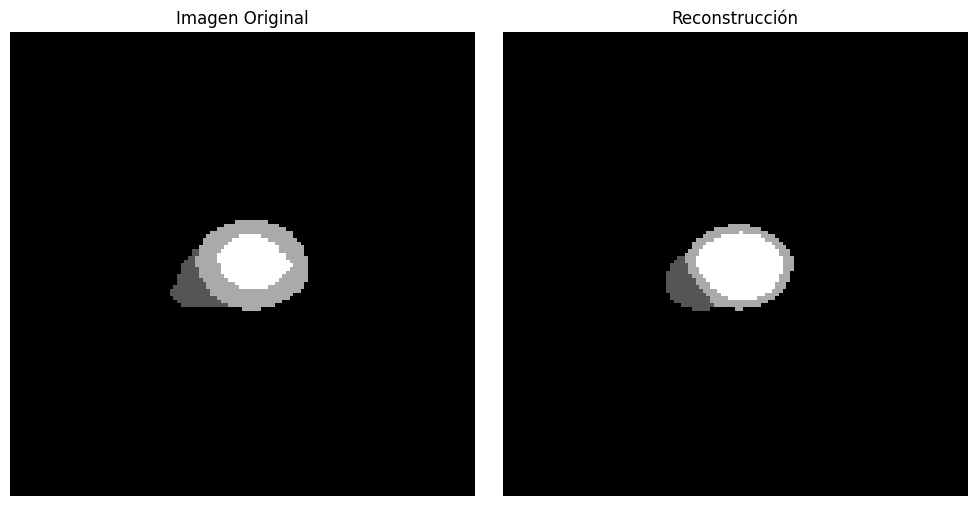

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_185.nii.gz


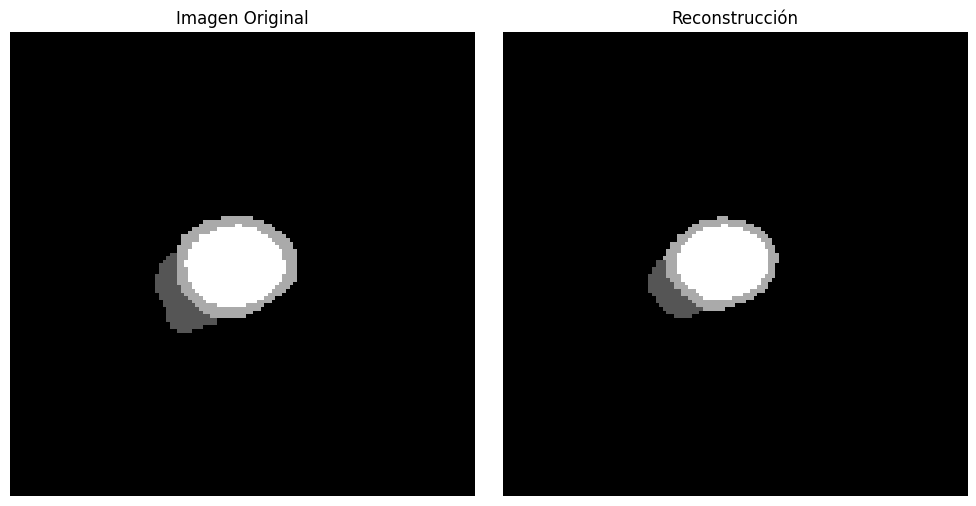

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_186.nii.gz


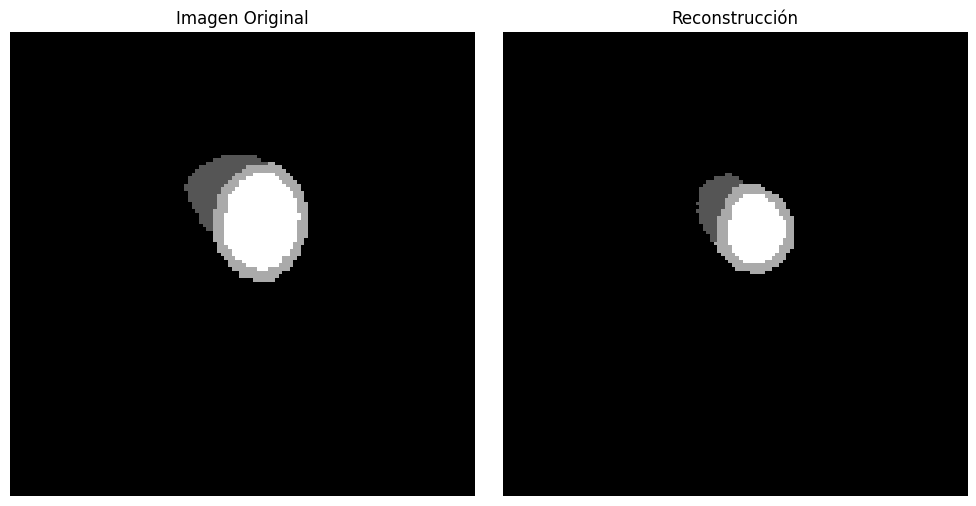

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_187.nii.gz


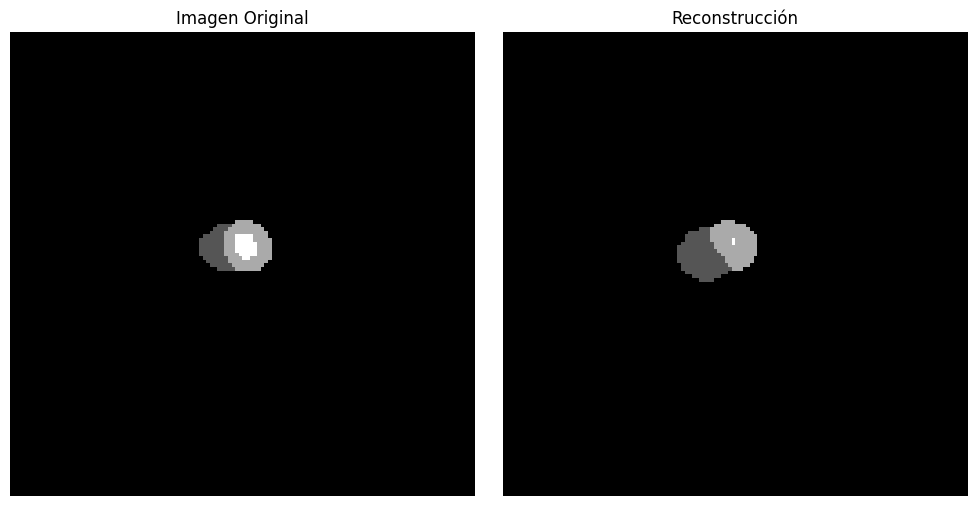

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_188.nii.gz


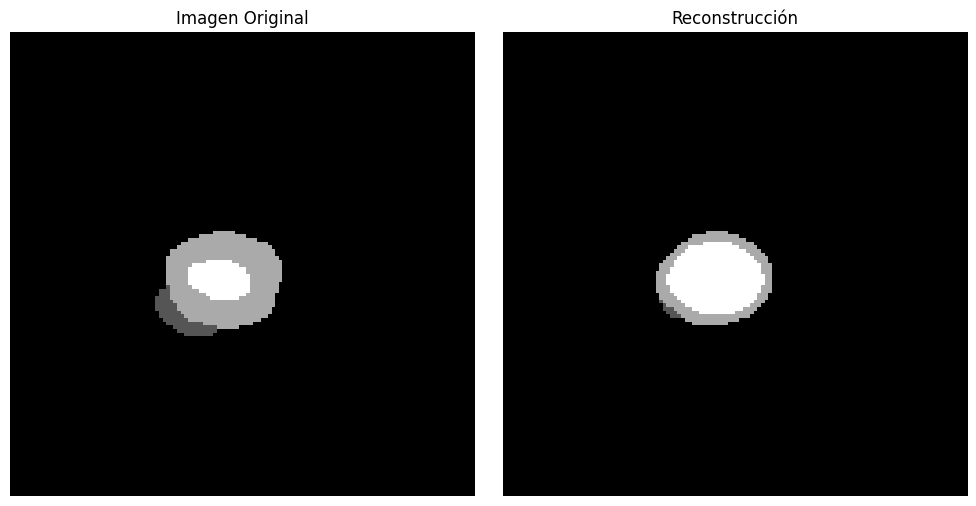

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_189.nii.gz


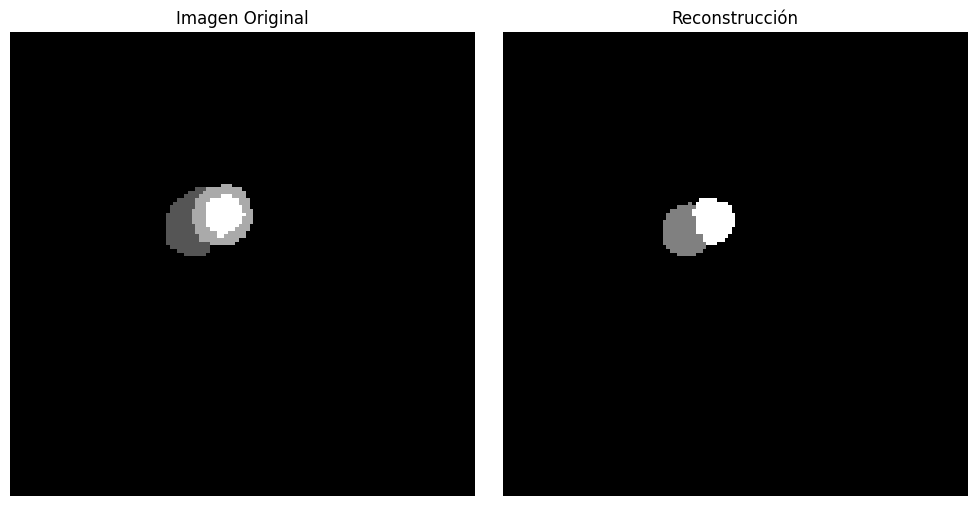

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129325389862
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_190.nii.gz


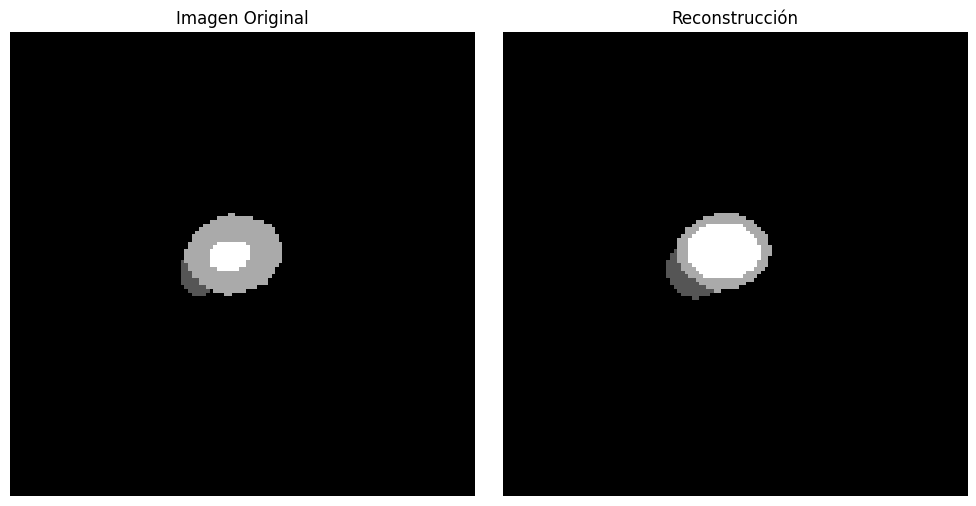

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129325389862
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_191.nii.gz


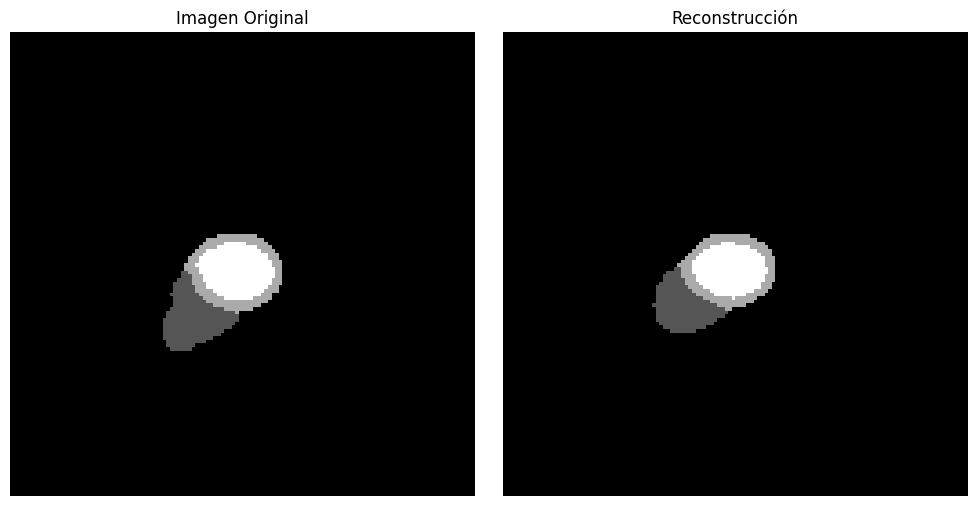

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_192.nii.gz


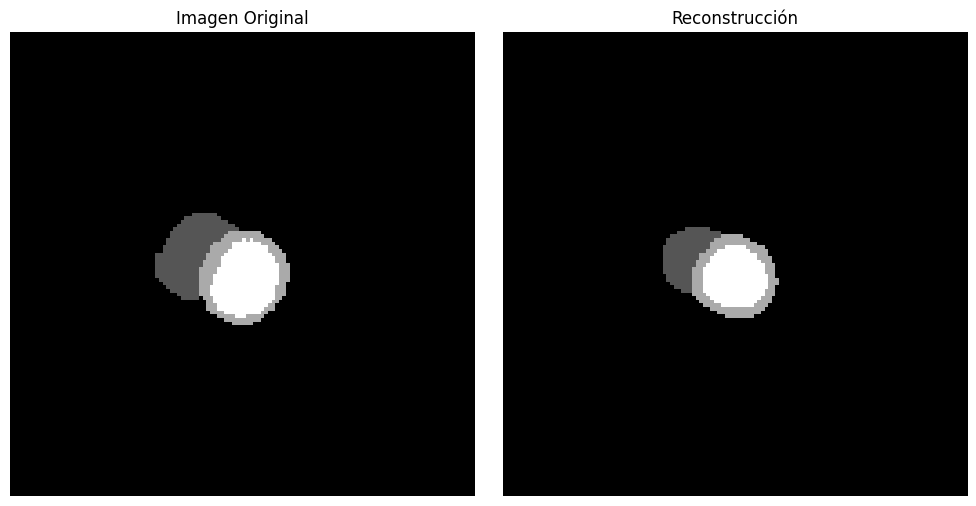

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_193.nii.gz


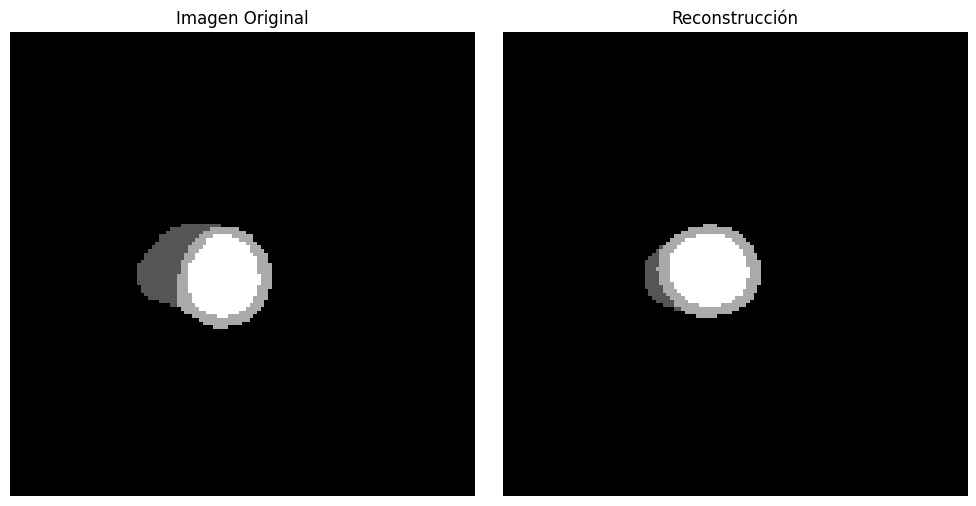

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_194.nii.gz


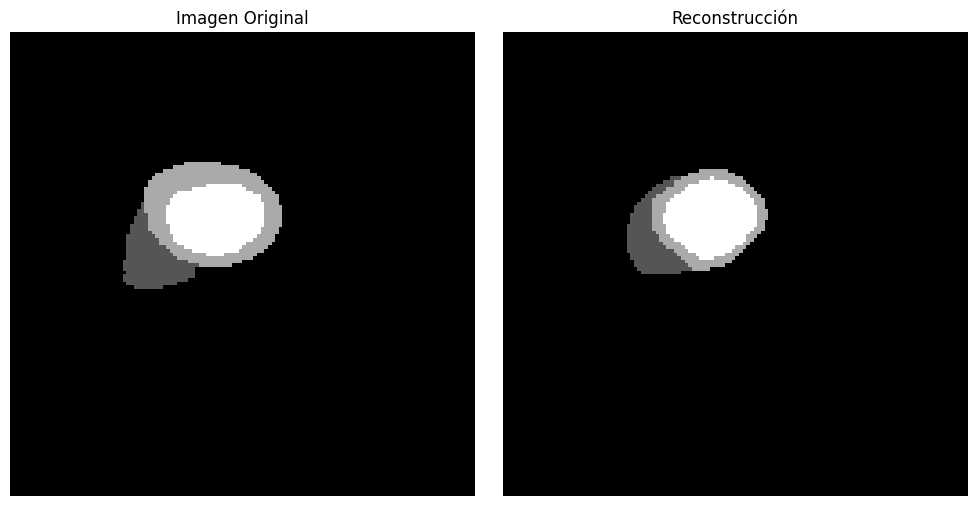

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_195.nii.gz


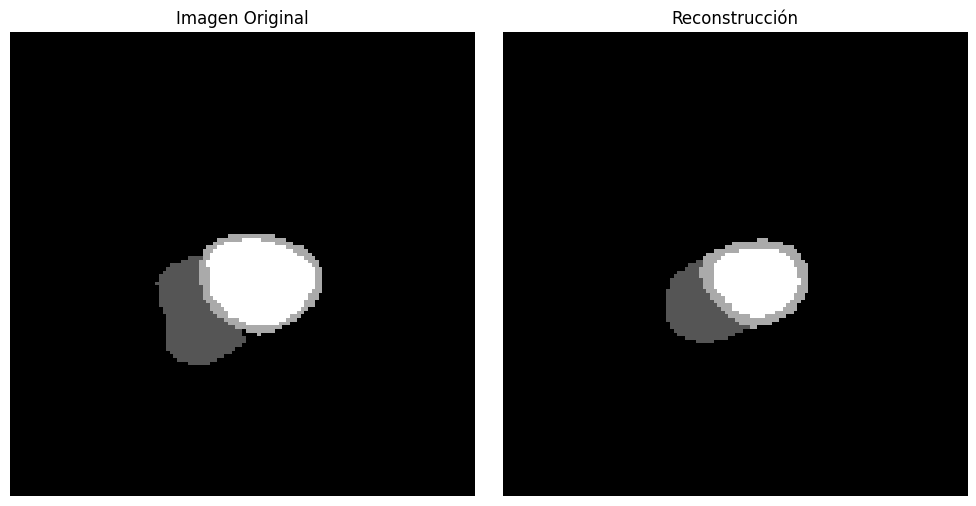

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_196.nii.gz


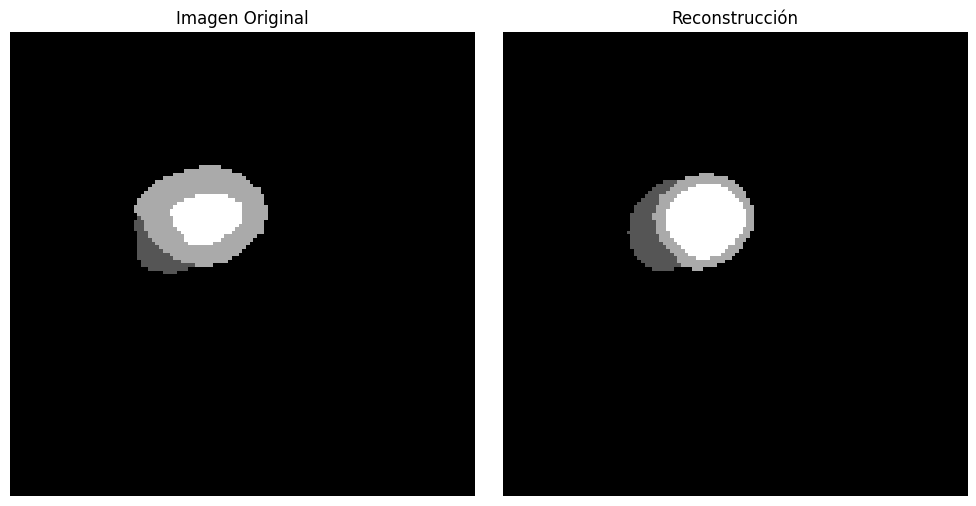

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_197.nii.gz


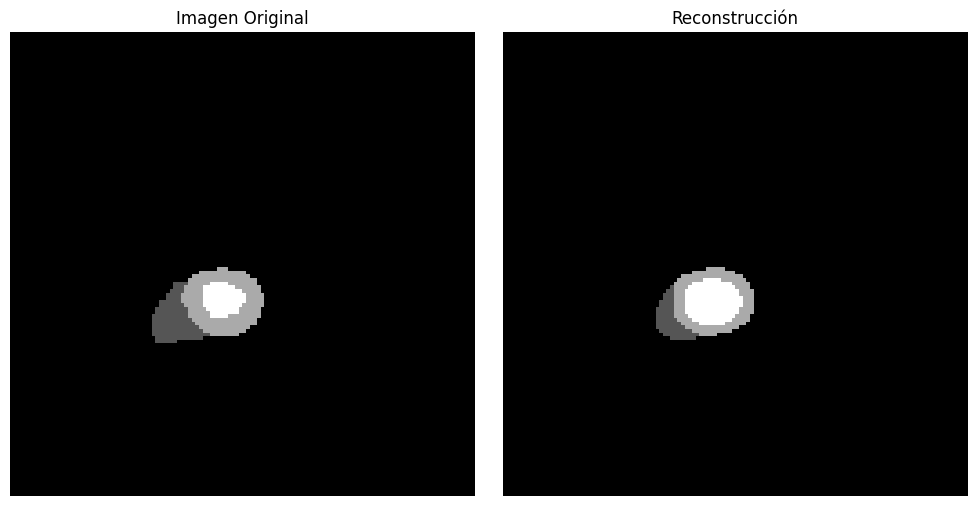

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_198.nii.gz


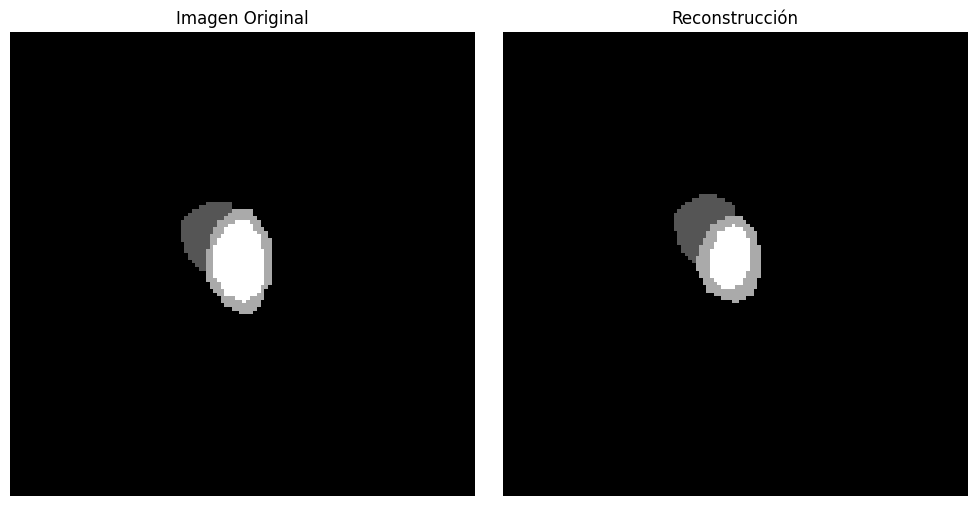

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_199.nii.gz


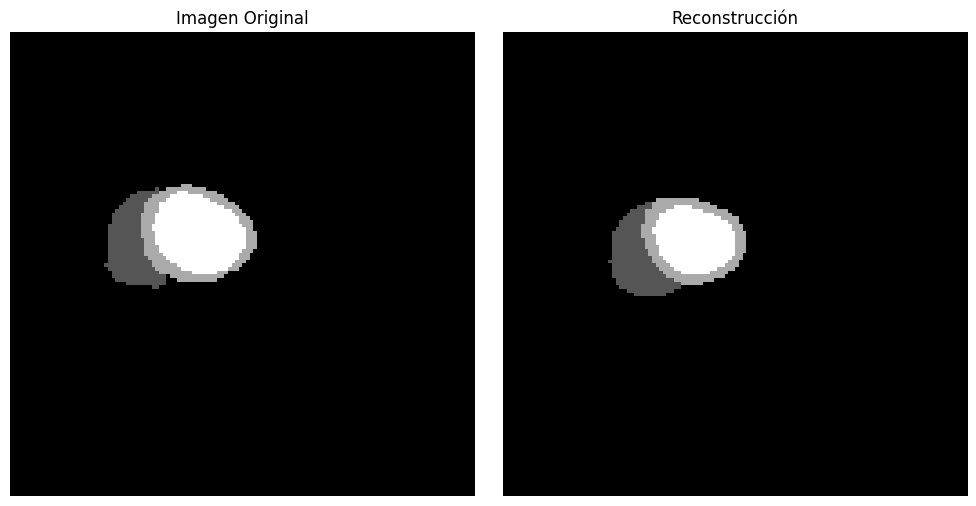

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/train/reconstructed_image_batch_200.nii.gz


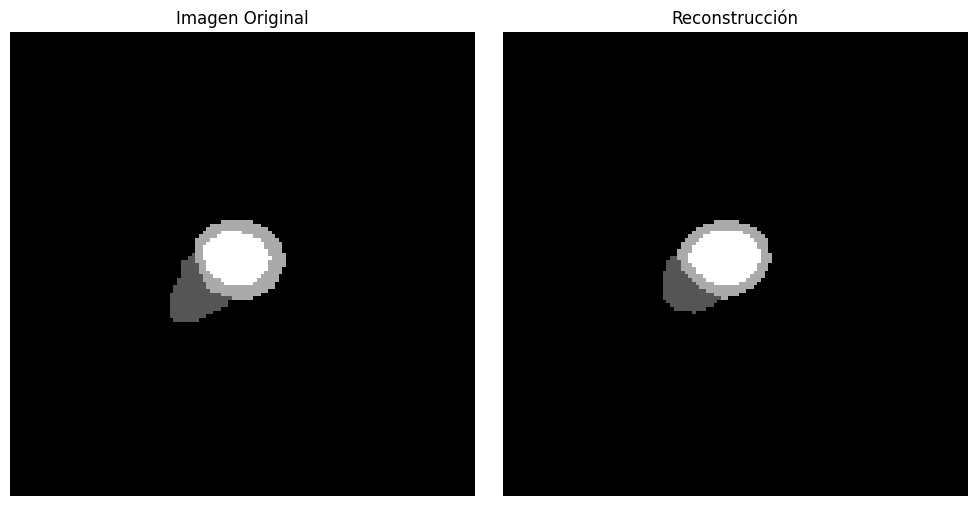

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_1.nii.gz


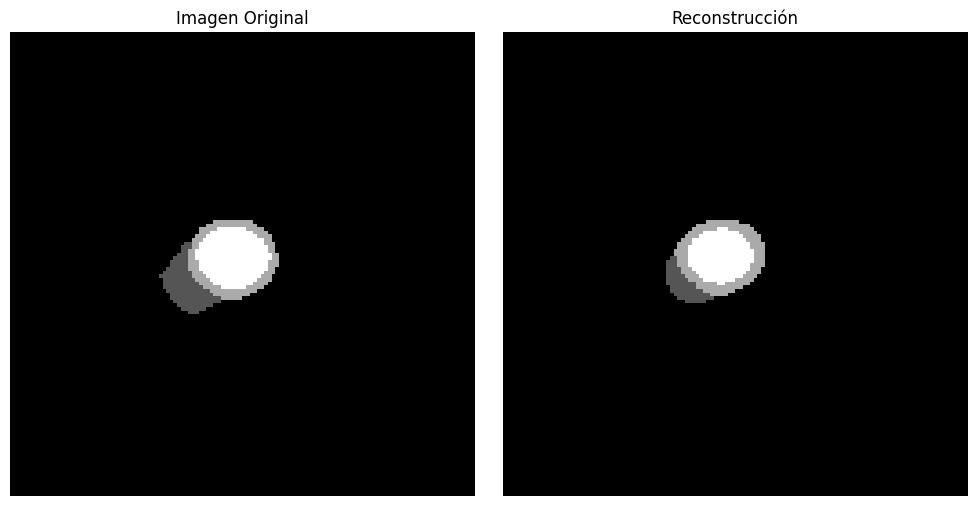

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_2.nii.gz


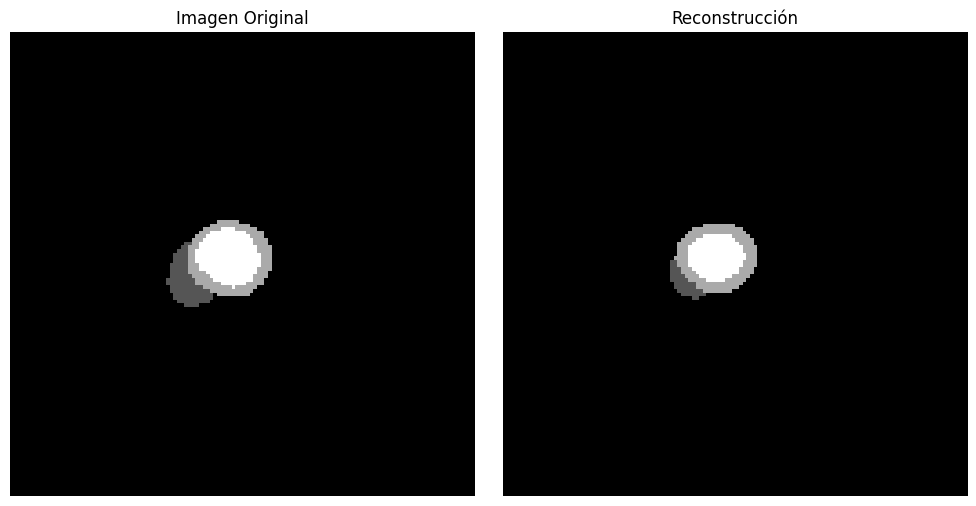

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_3.nii.gz


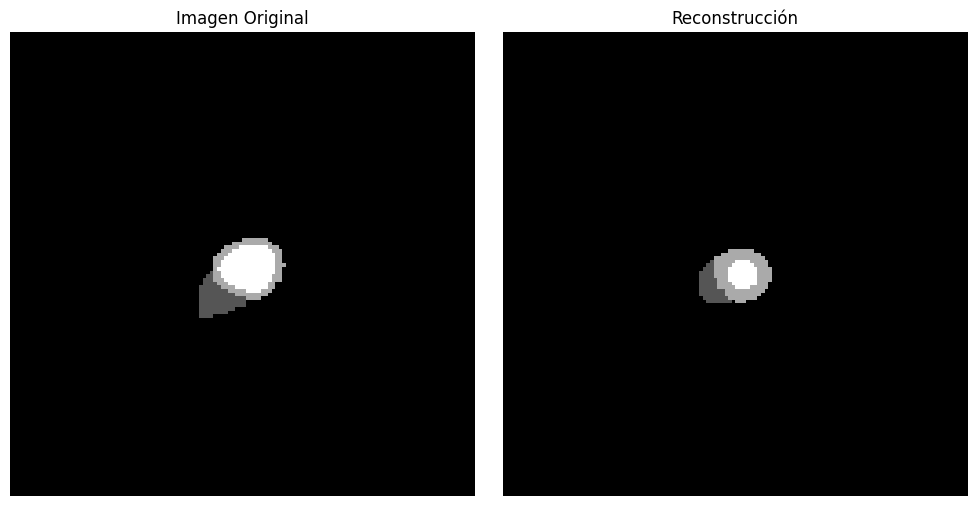

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_4.nii.gz


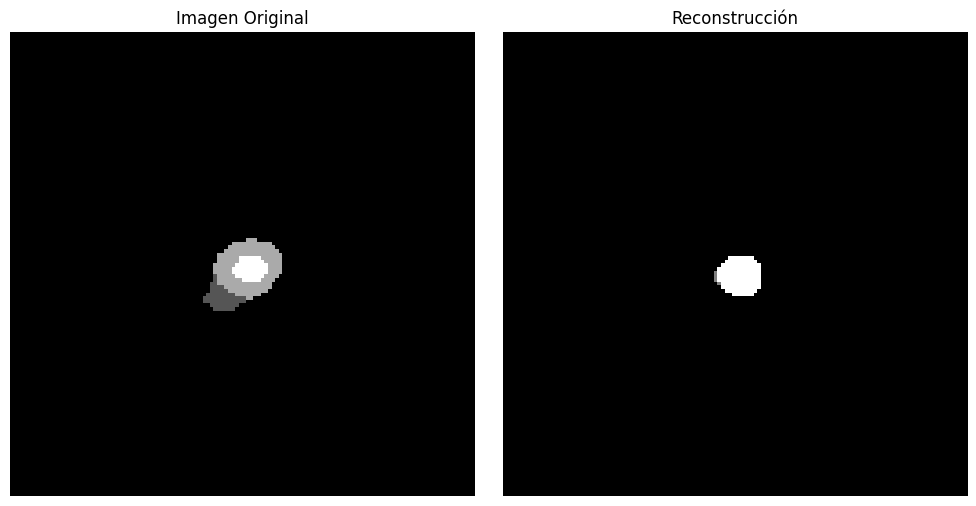

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_5.nii.gz


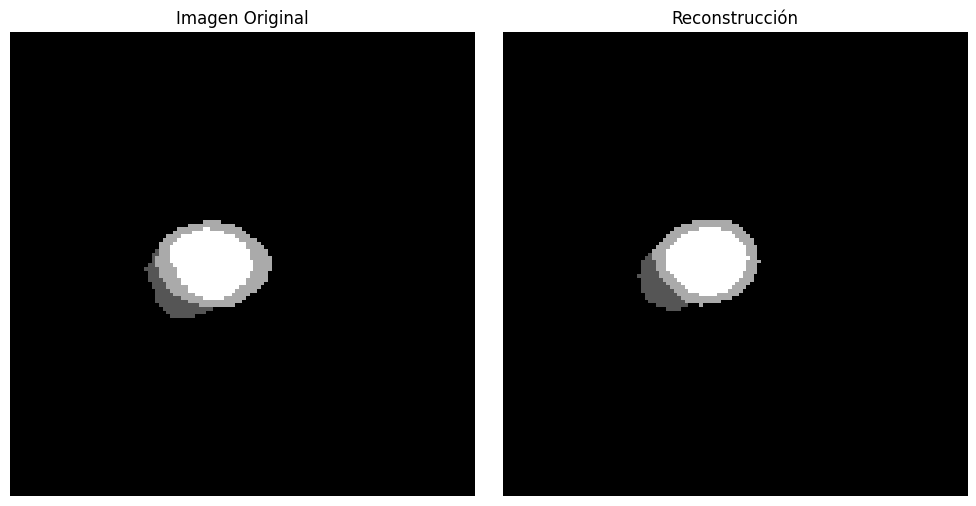

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_6.nii.gz


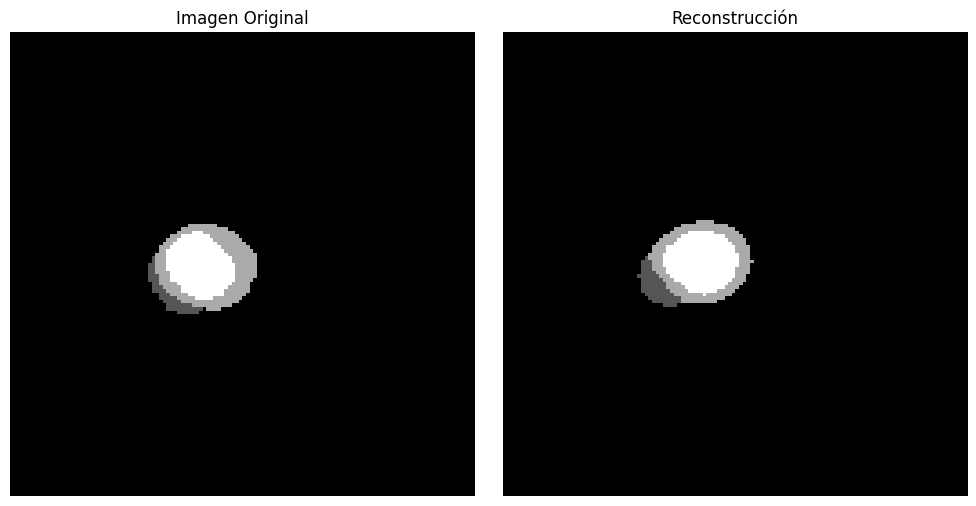

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_7.nii.gz


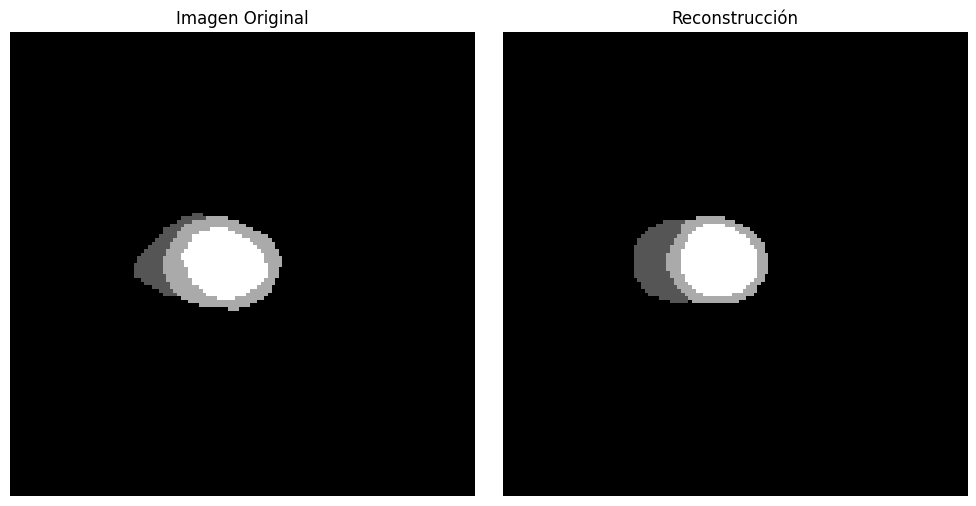

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_8.nii.gz


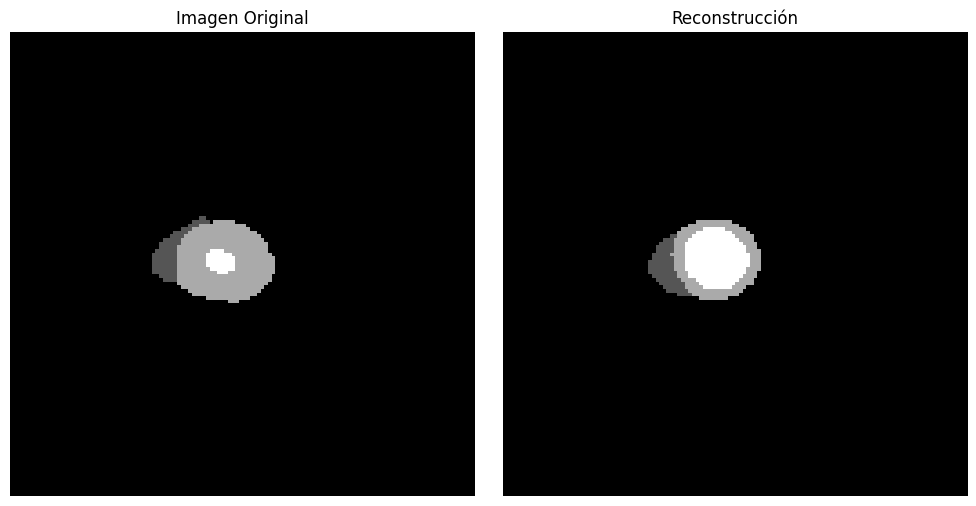

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_9.nii.gz


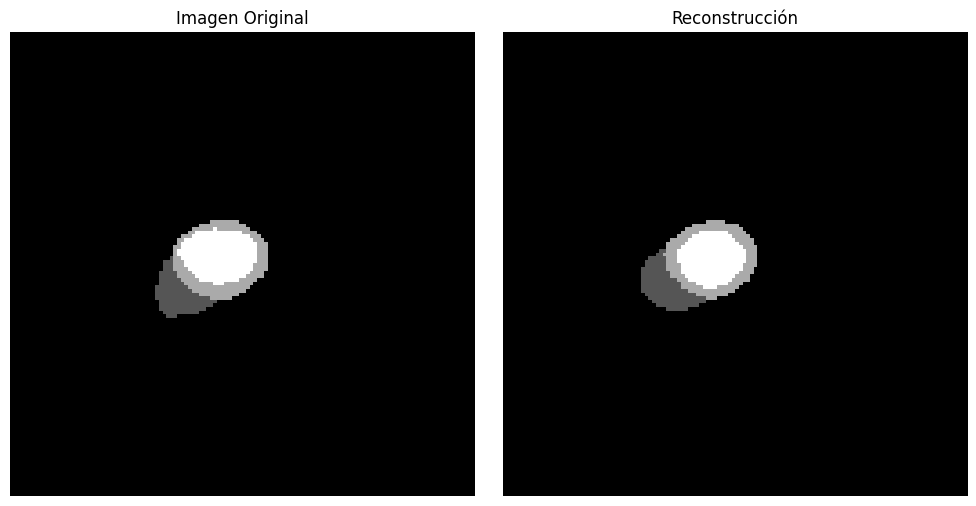

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_10.nii.gz


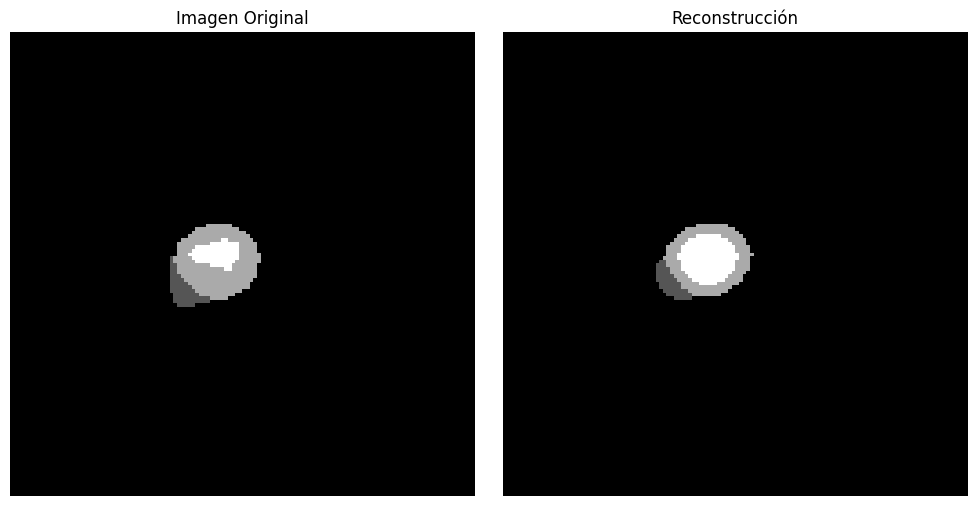

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_11.nii.gz


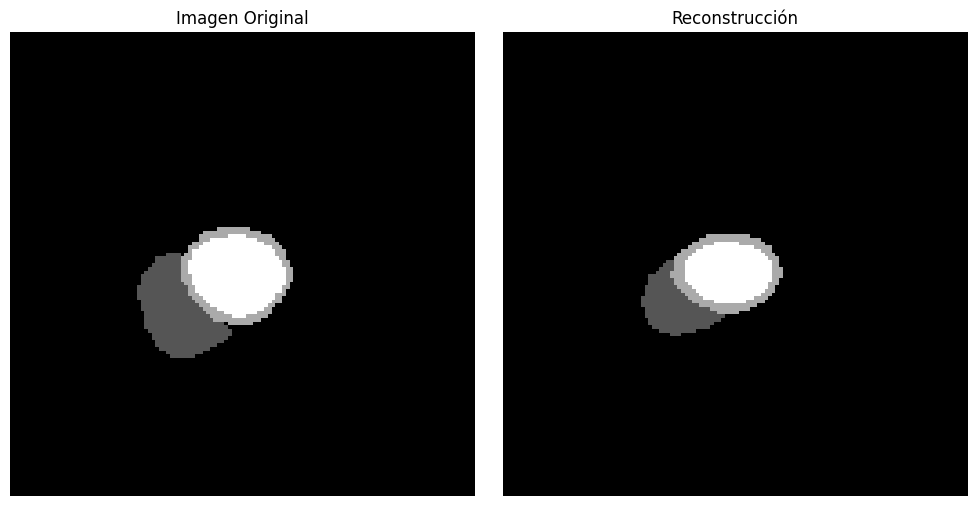

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_12.nii.gz


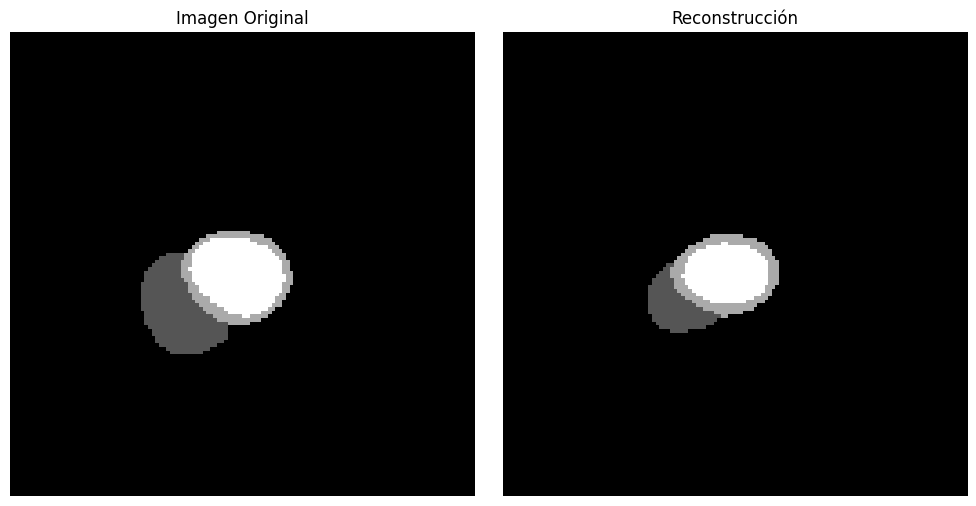

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_13.nii.gz


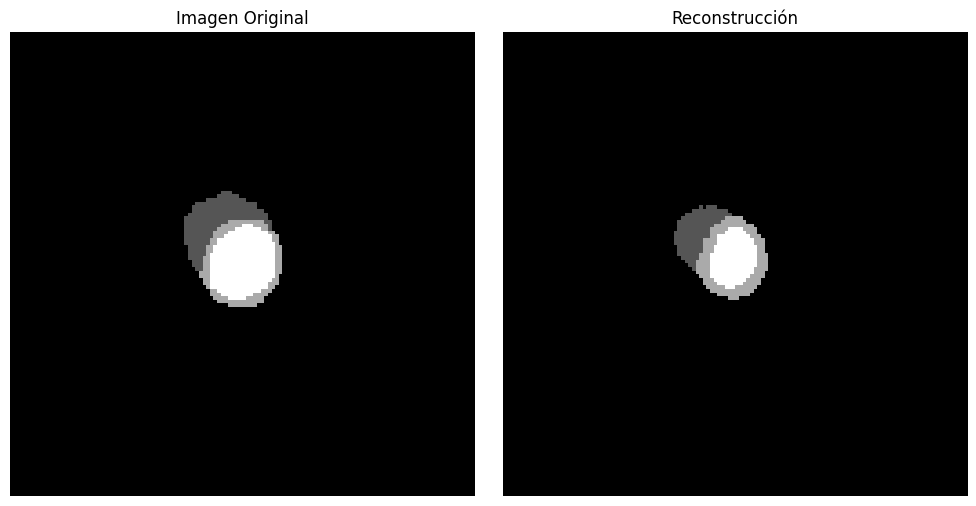

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_14.nii.gz


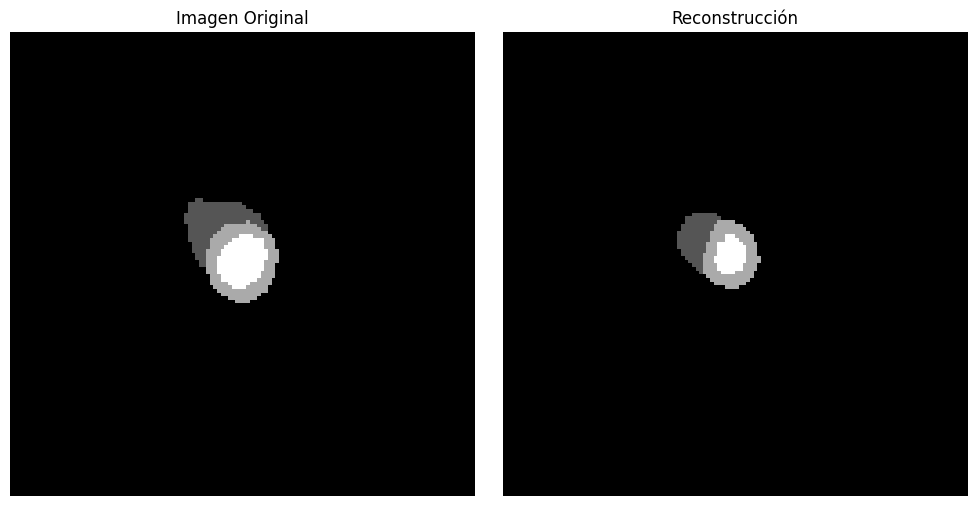

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_15.nii.gz


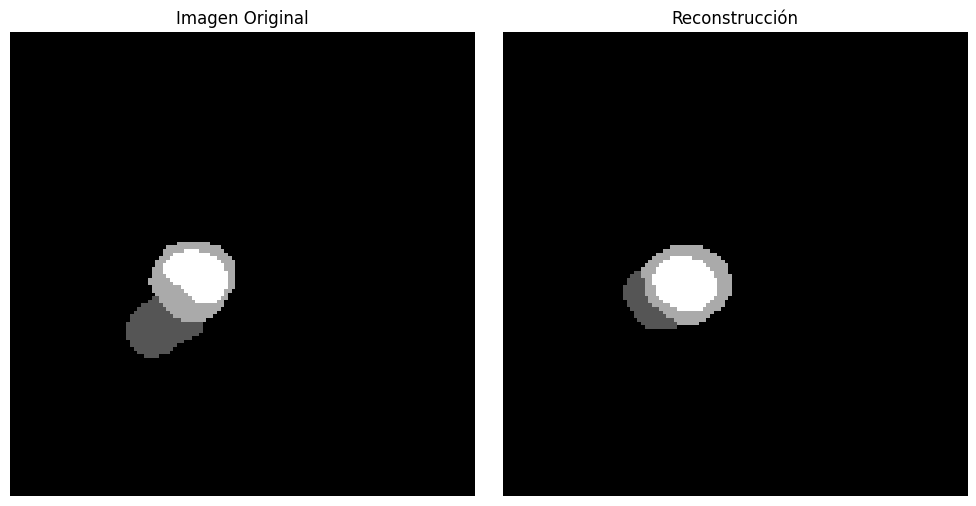

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129325389862
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_16.nii.gz


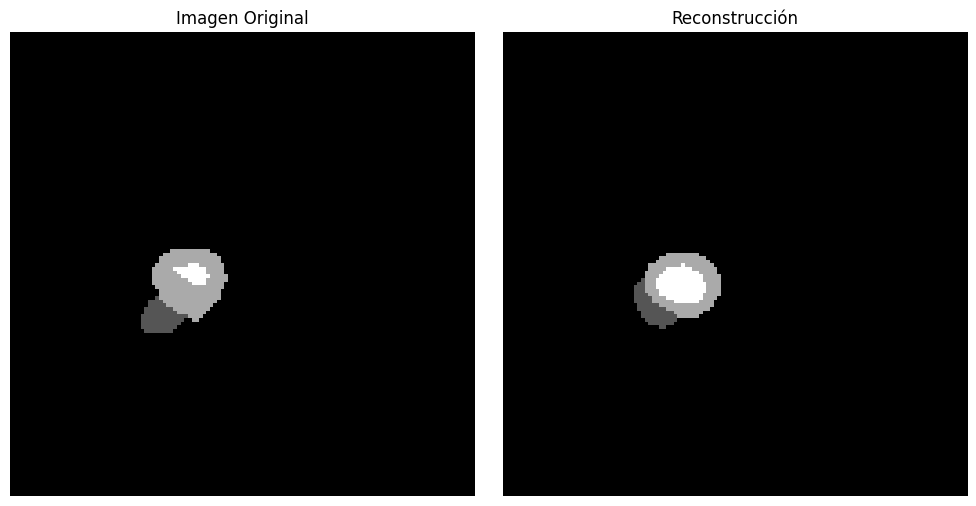

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_17.nii.gz


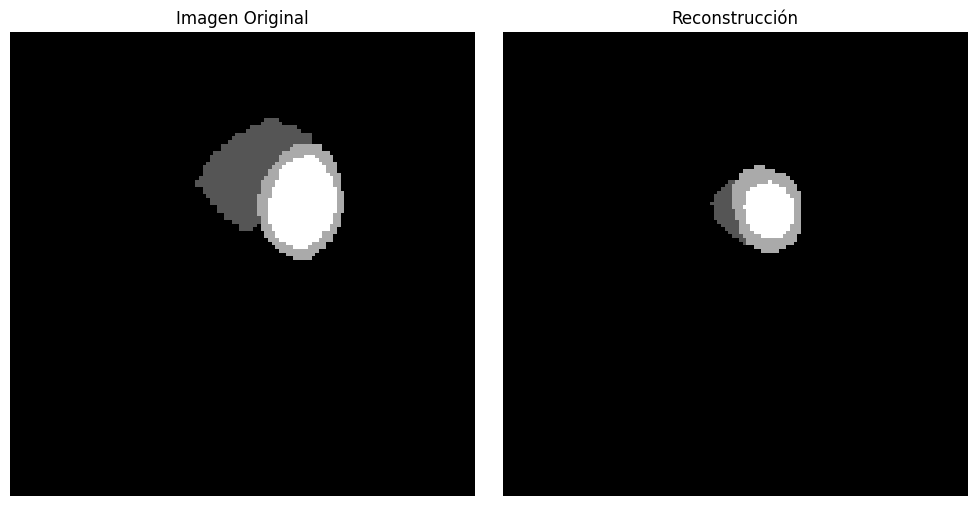

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_18.nii.gz


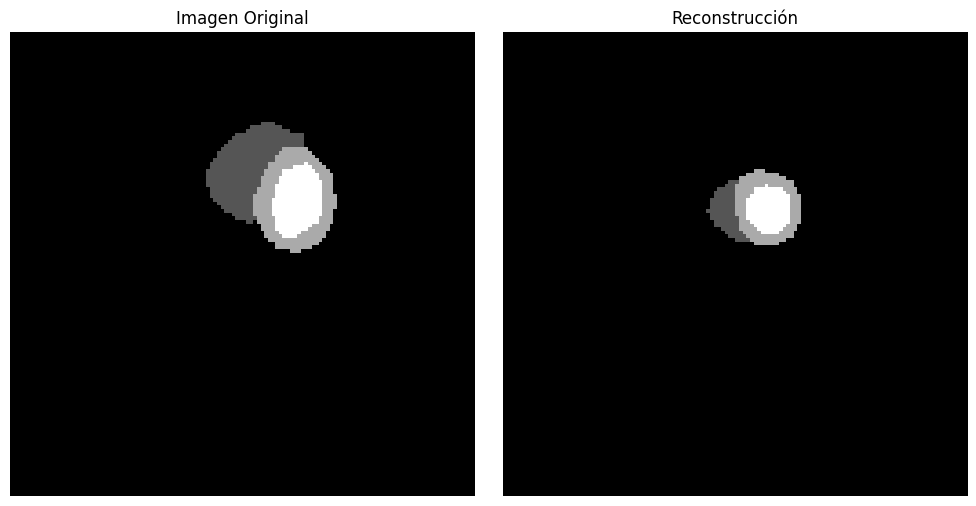

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_19.nii.gz


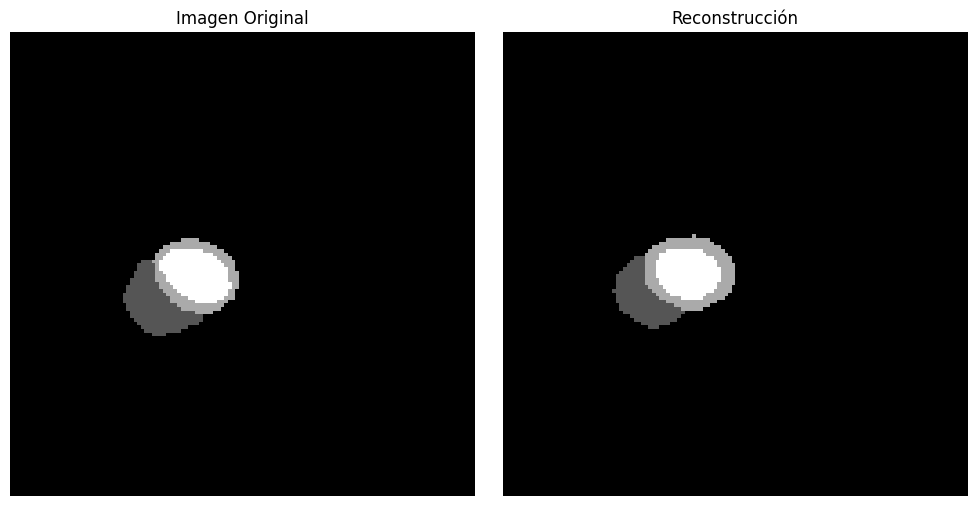

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_20.nii.gz


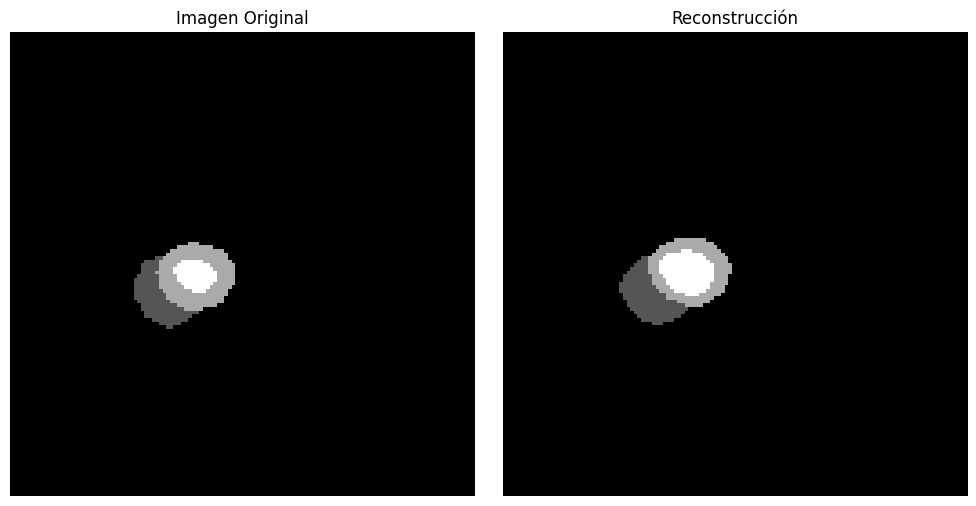

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_21.nii.gz


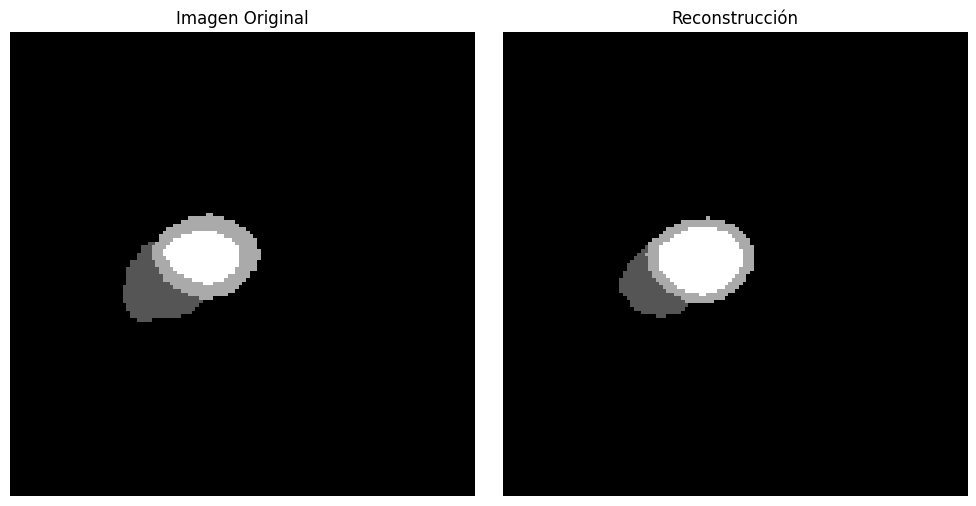

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_22.nii.gz


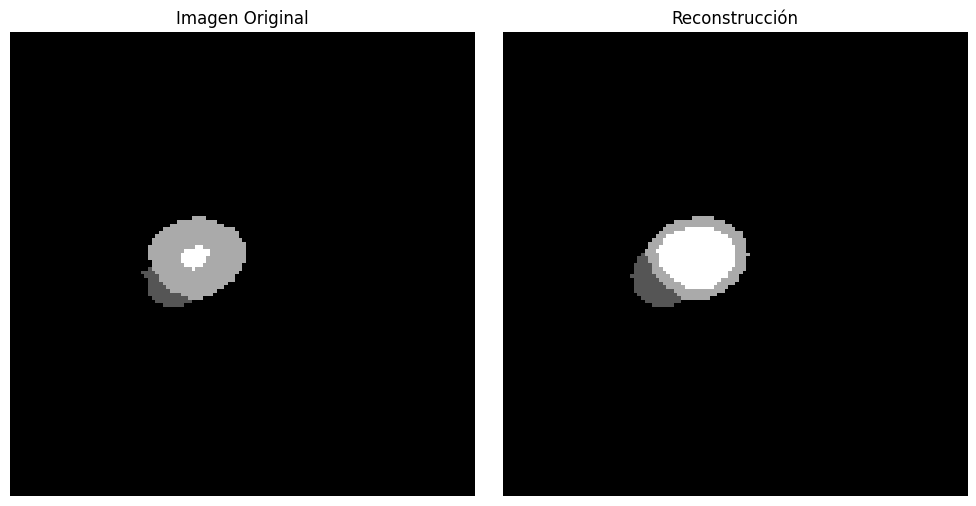

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_23.nii.gz


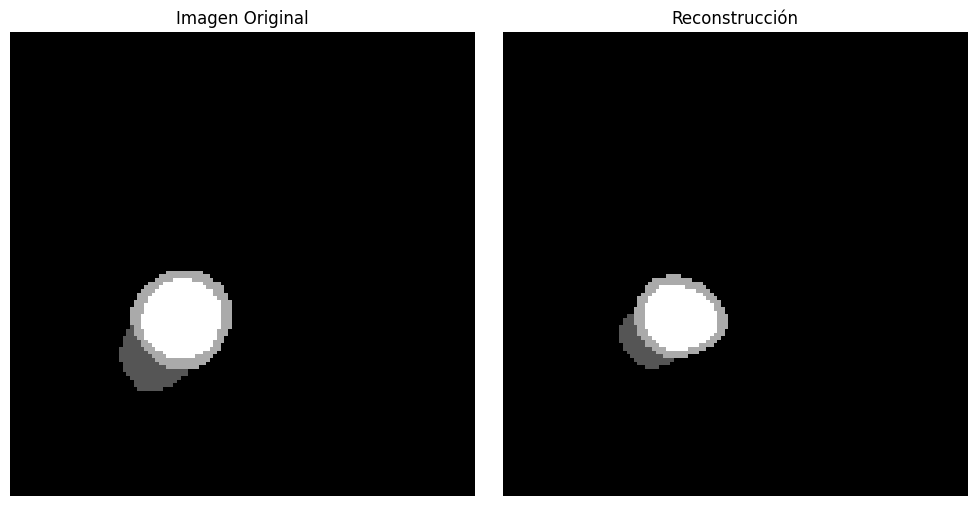

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_24.nii.gz


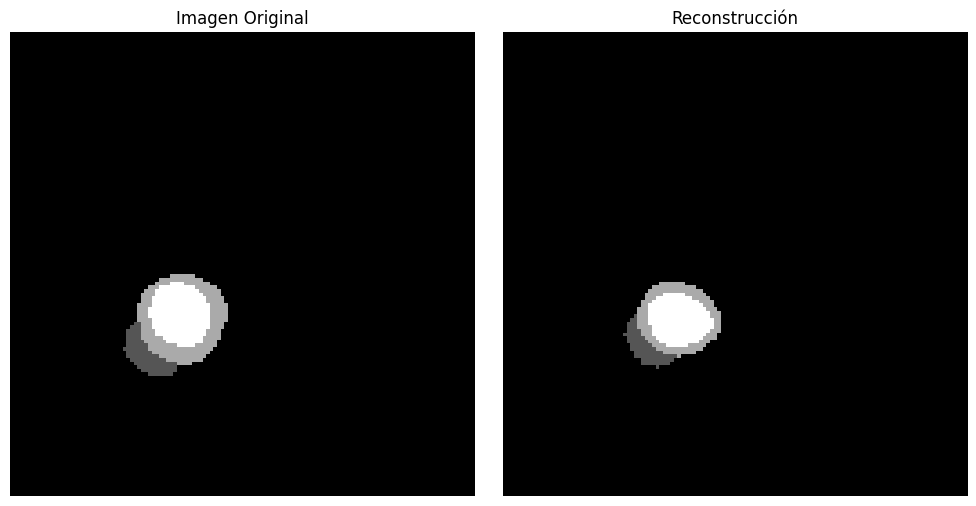

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_25.nii.gz


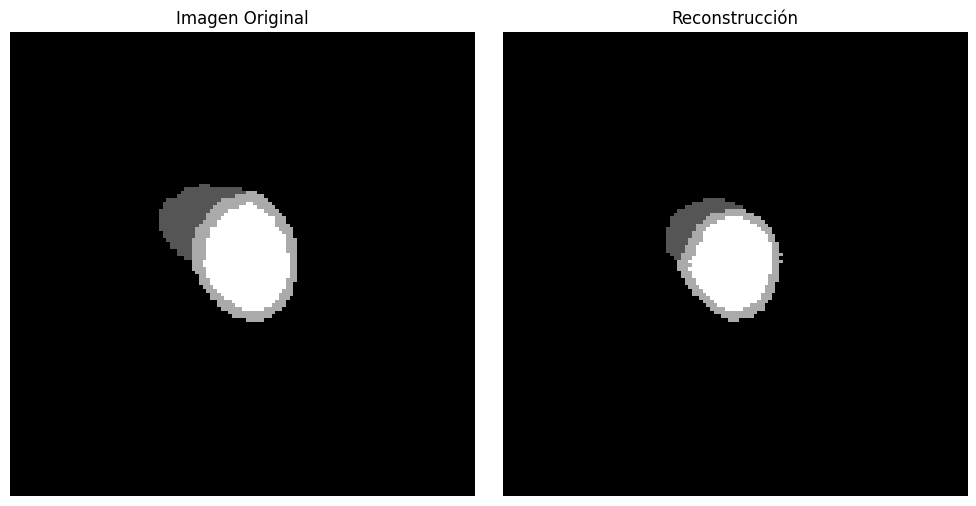

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_26.nii.gz


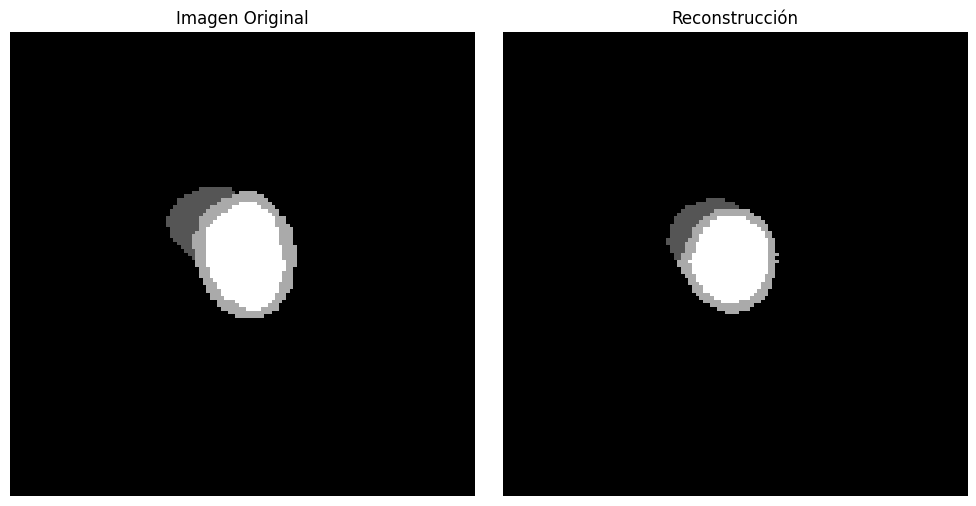

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_27.nii.gz


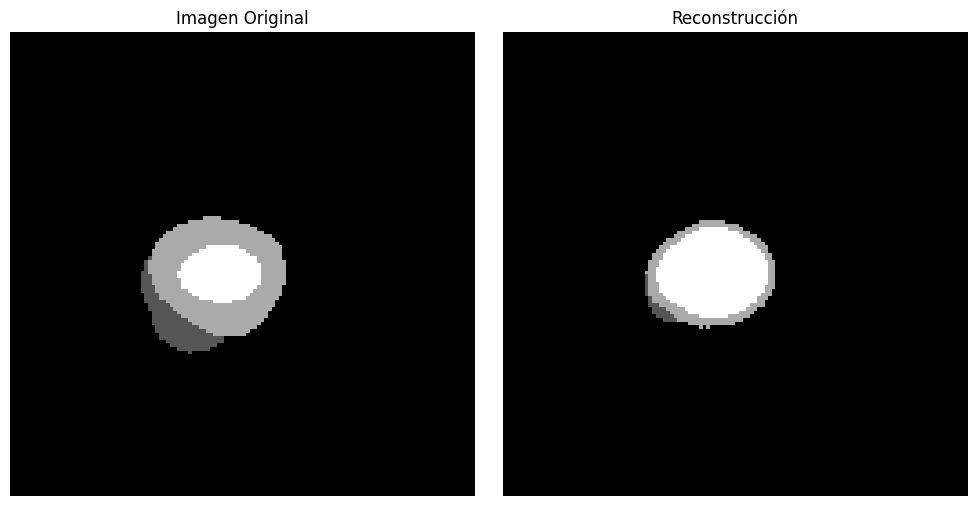

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_28.nii.gz


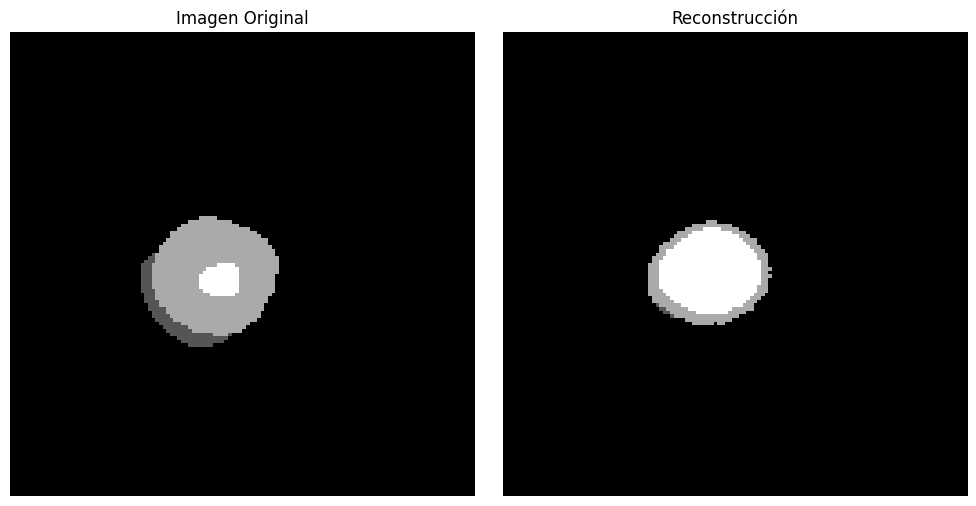

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_29.nii.gz


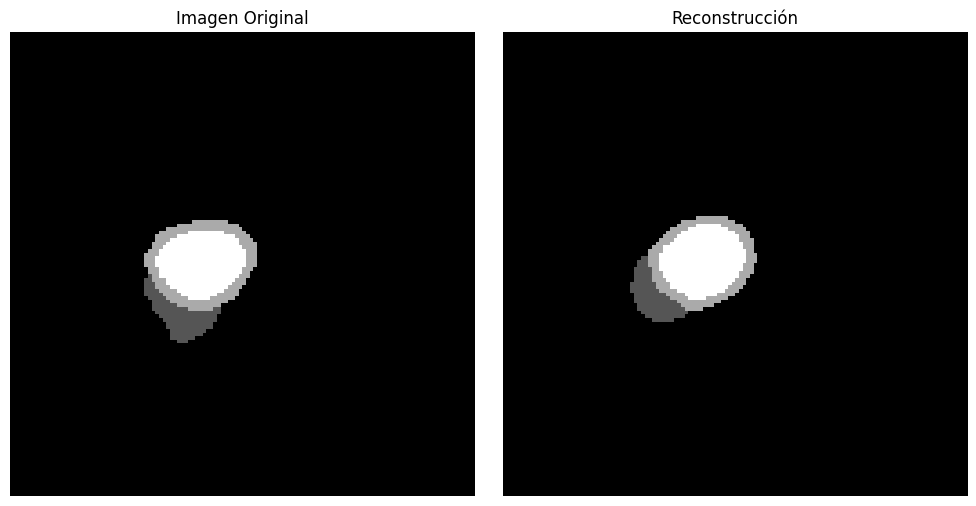

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_30.nii.gz


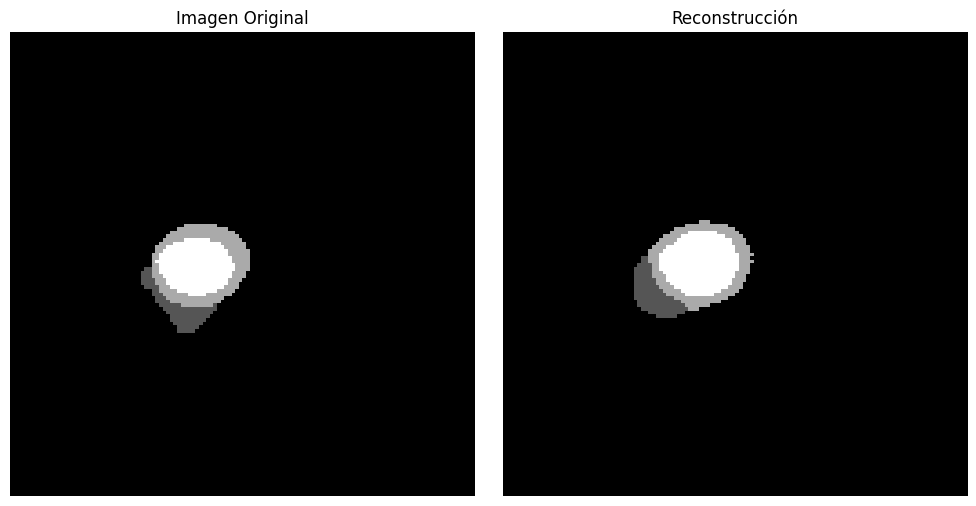

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_31.nii.gz


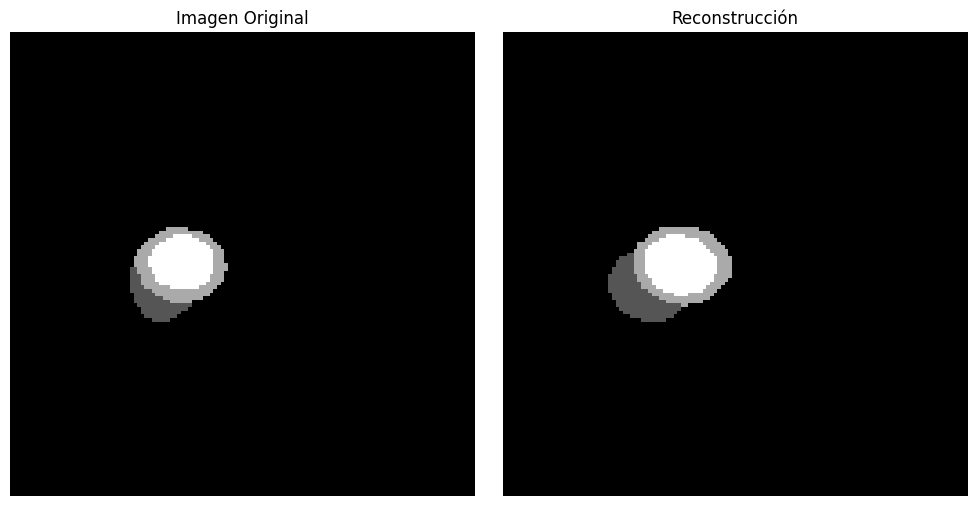

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_32.nii.gz


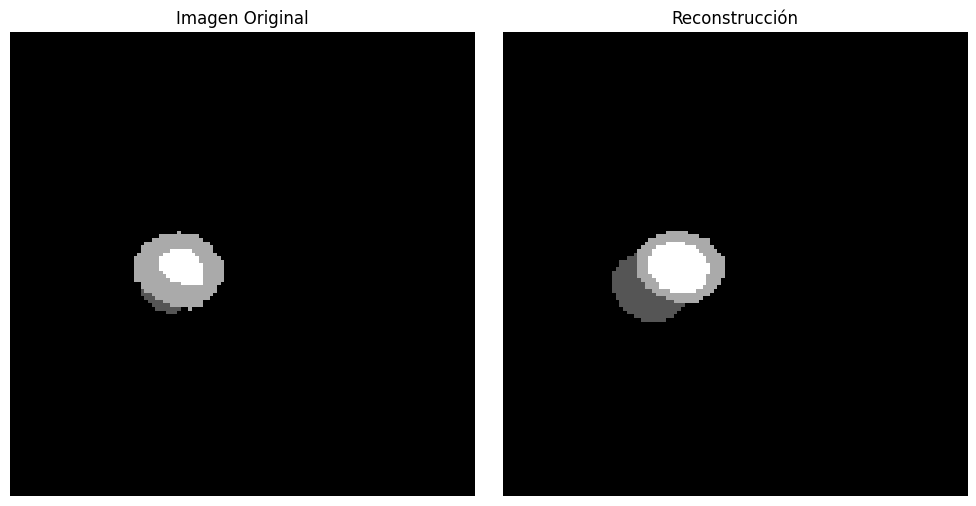

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_33.nii.gz


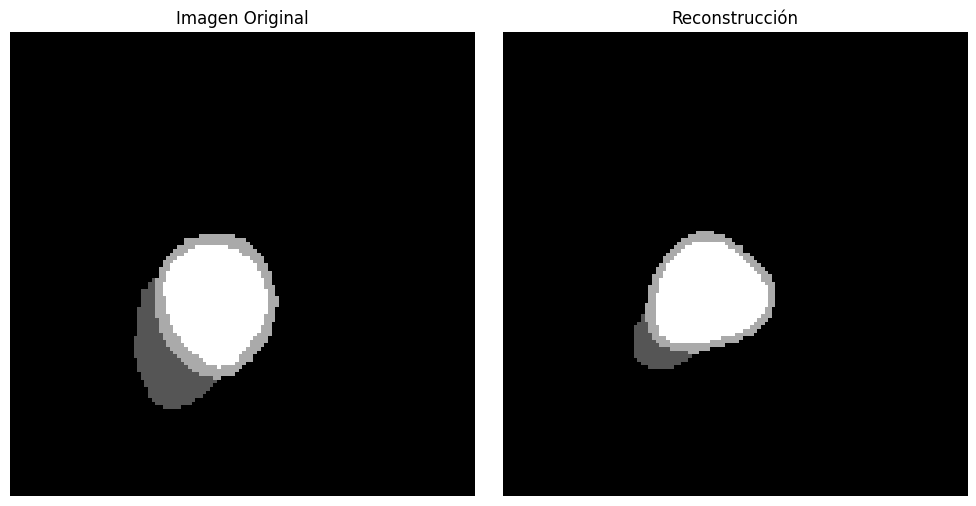

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_34.nii.gz


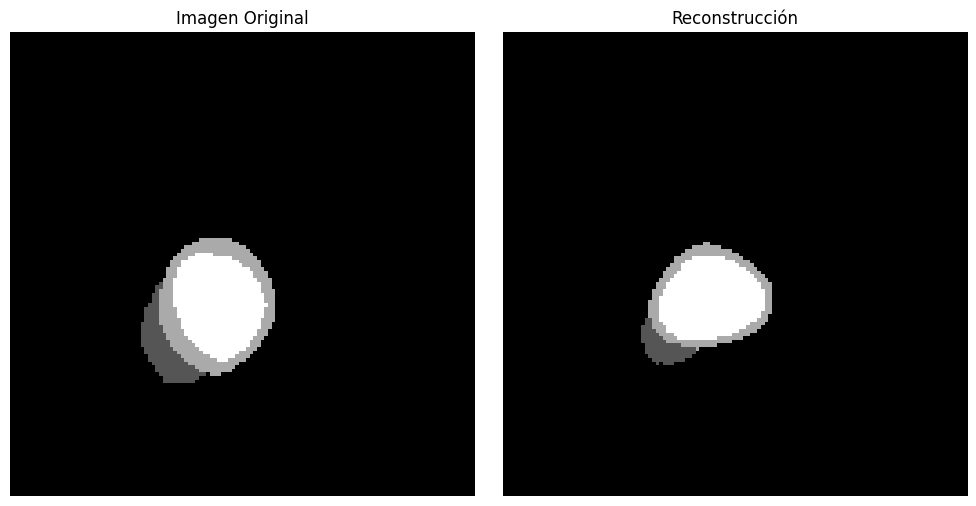

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_35.nii.gz


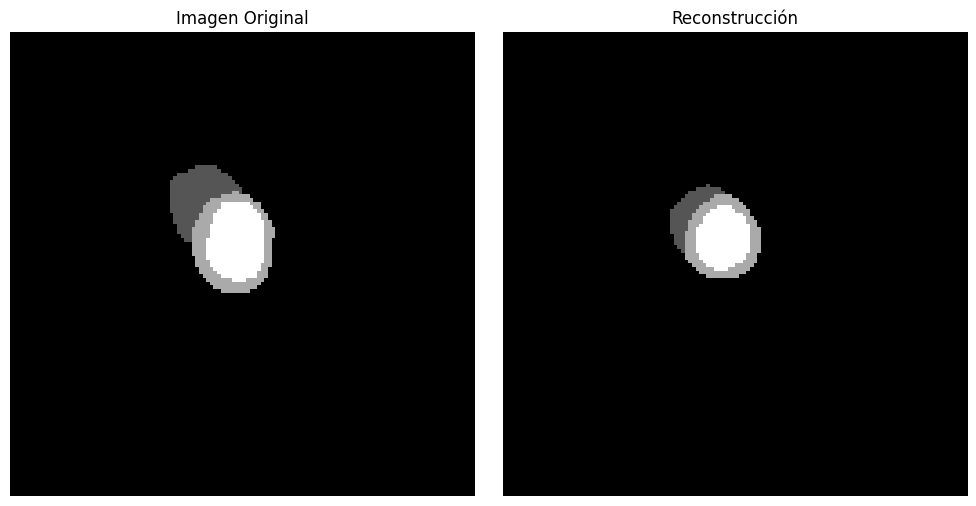

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_36.nii.gz


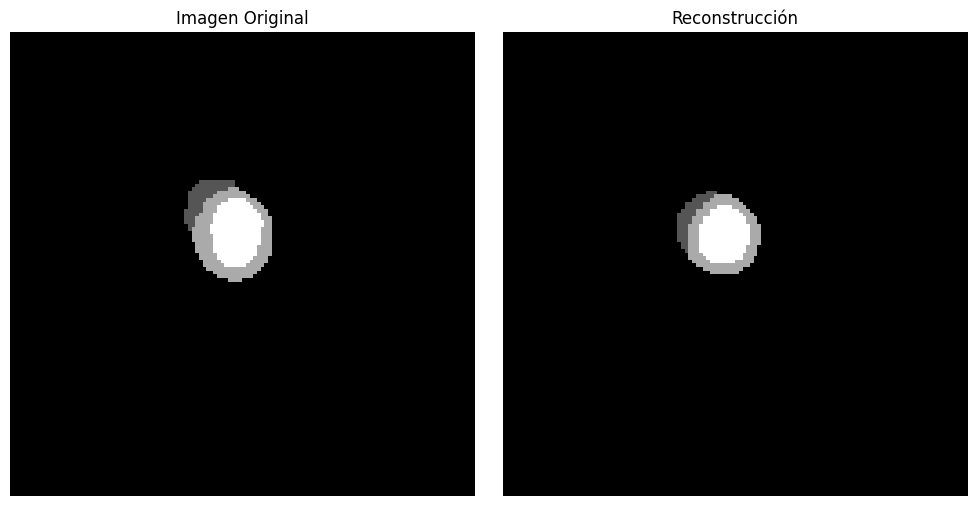

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_37.nii.gz


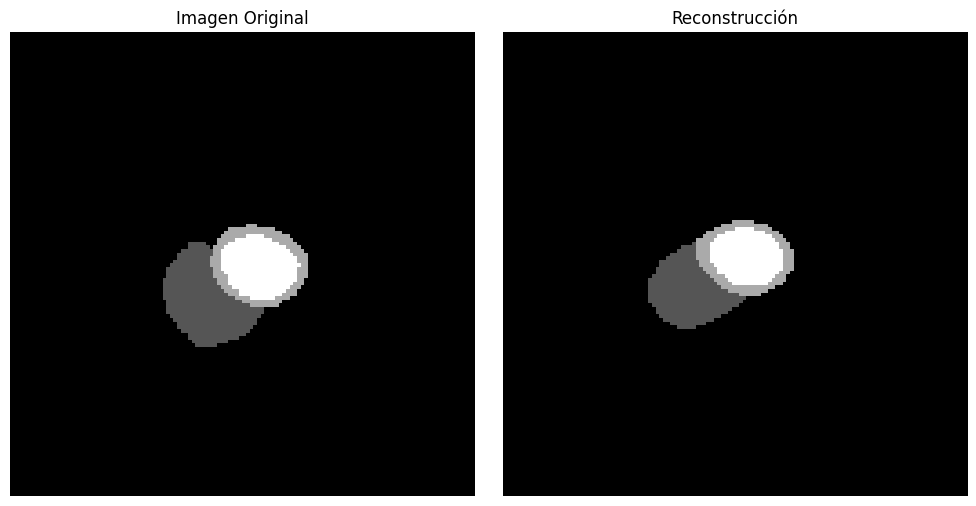

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_38.nii.gz


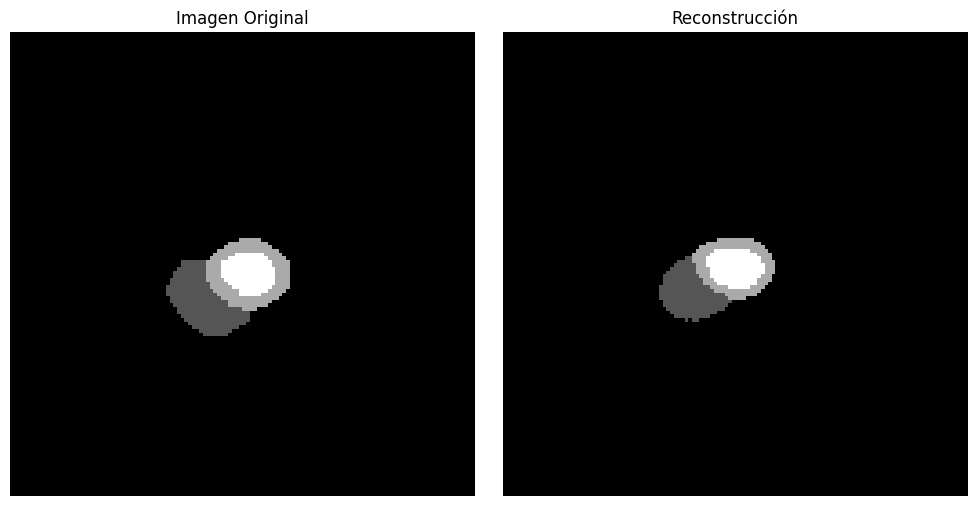

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_39.nii.gz


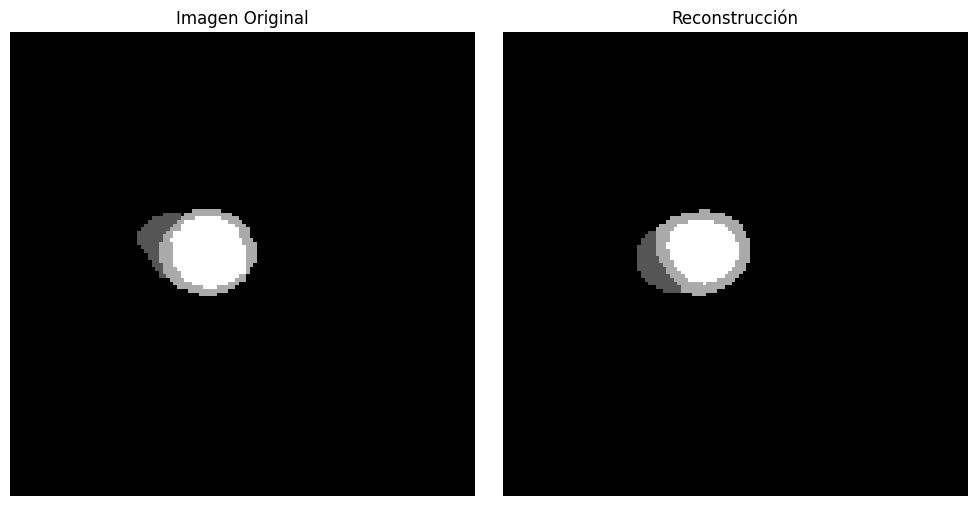

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_40.nii.gz


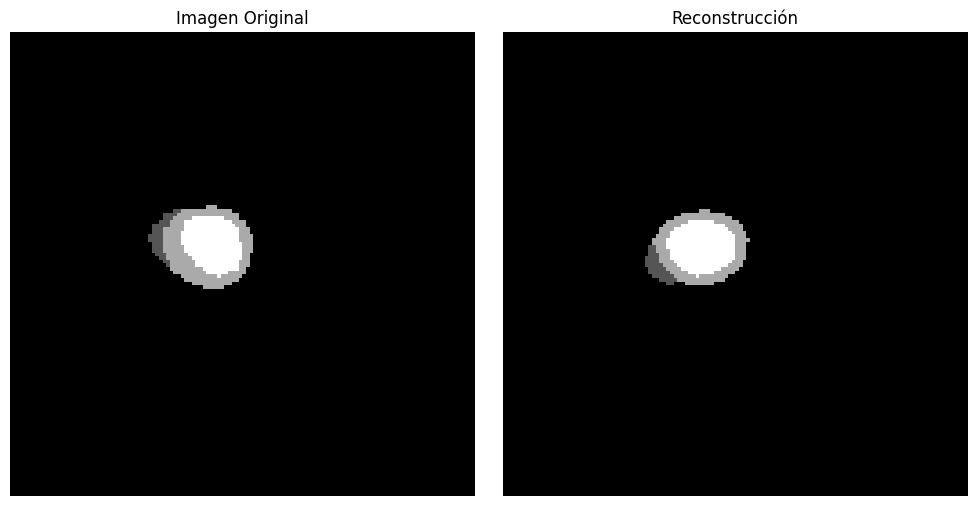

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129325389862
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_41.nii.gz


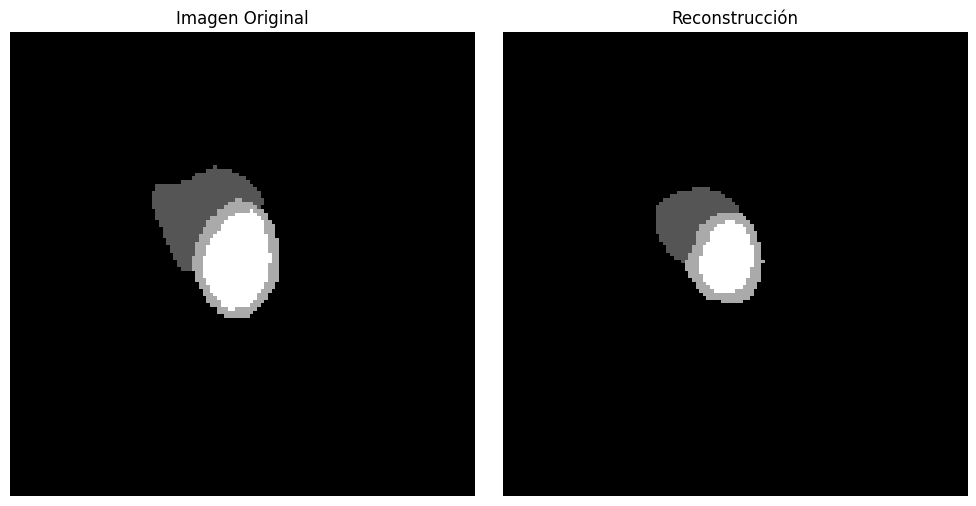

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_42.nii.gz


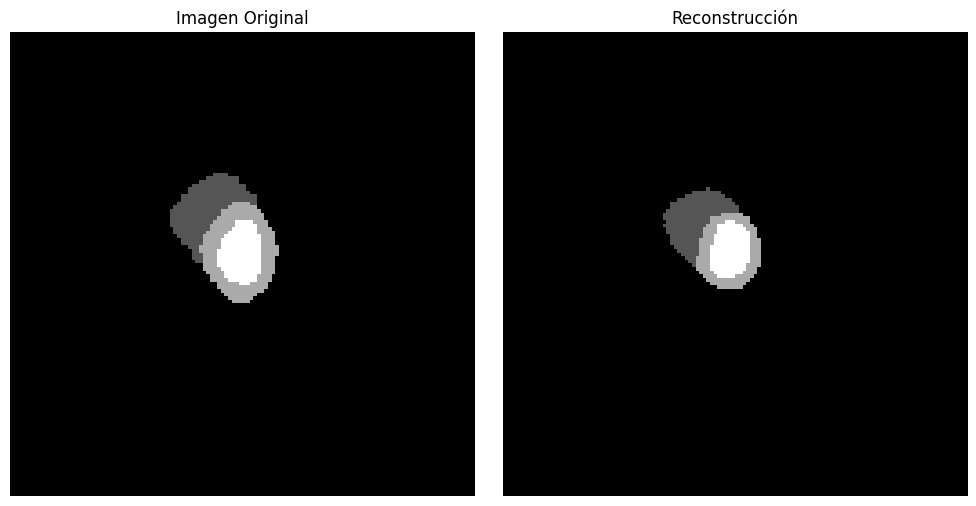

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129325389862
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_43.nii.gz


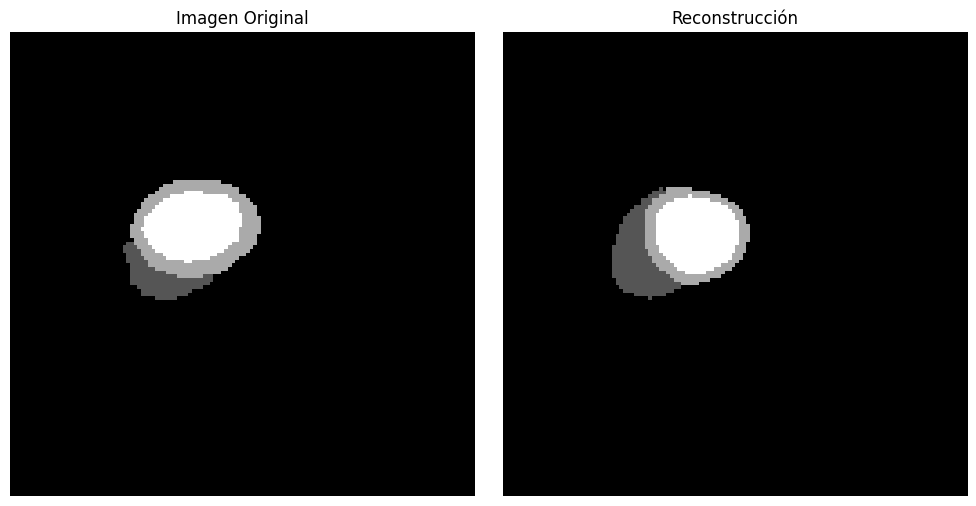

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_44.nii.gz


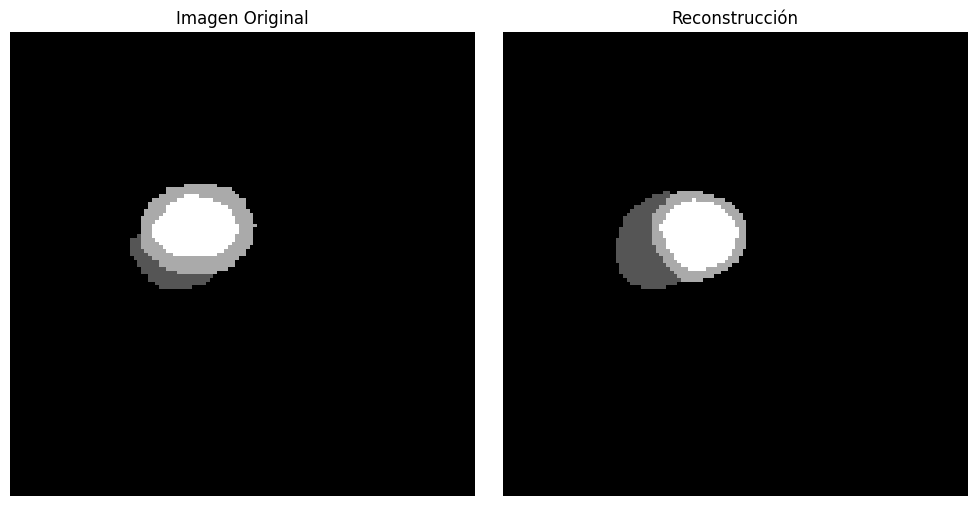

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_45.nii.gz


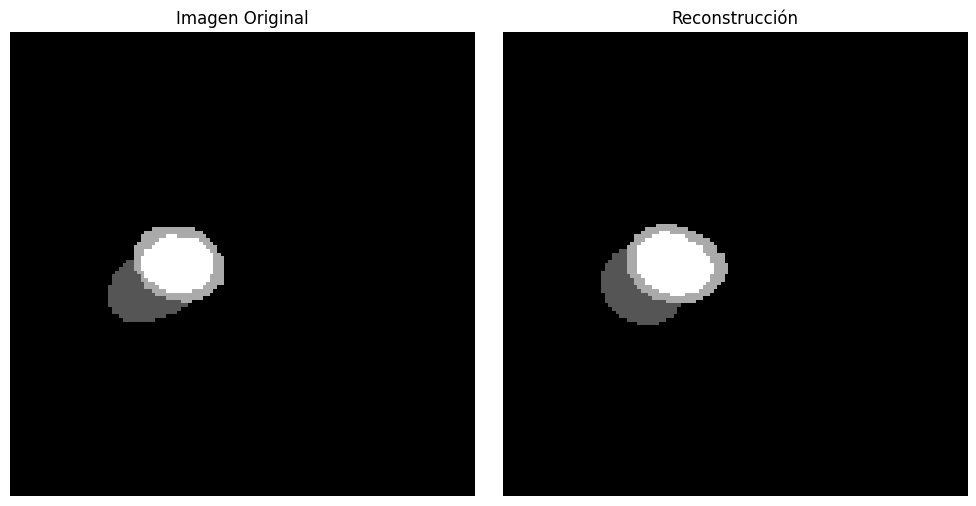

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_46.nii.gz


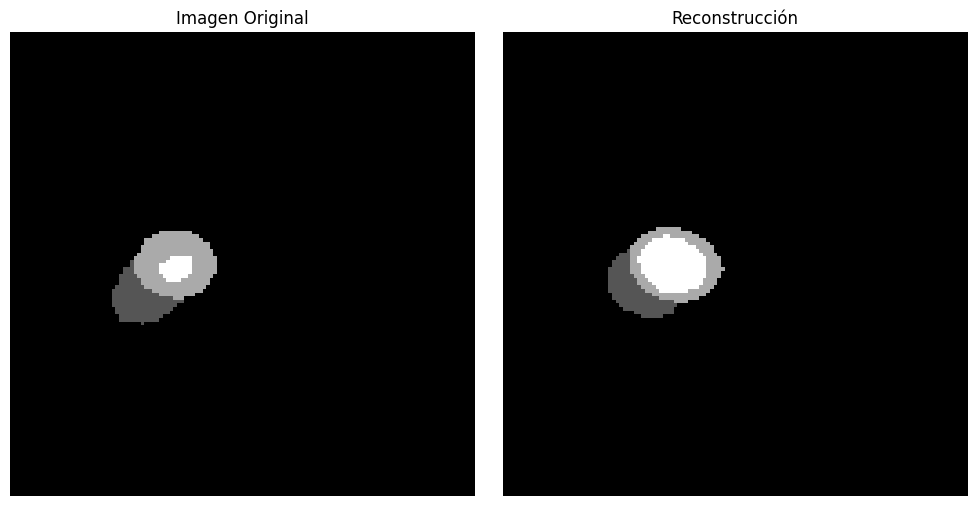

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129325389862
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_47.nii.gz


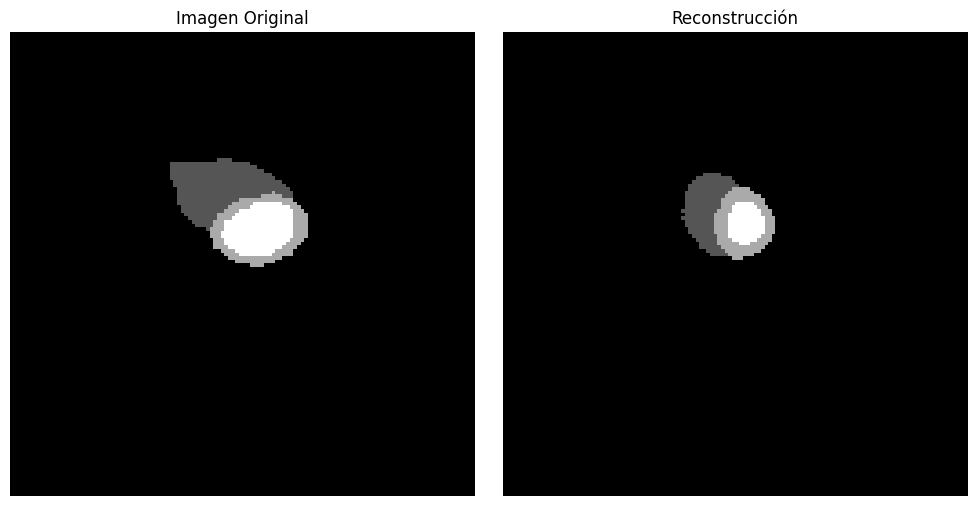

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_48.nii.gz


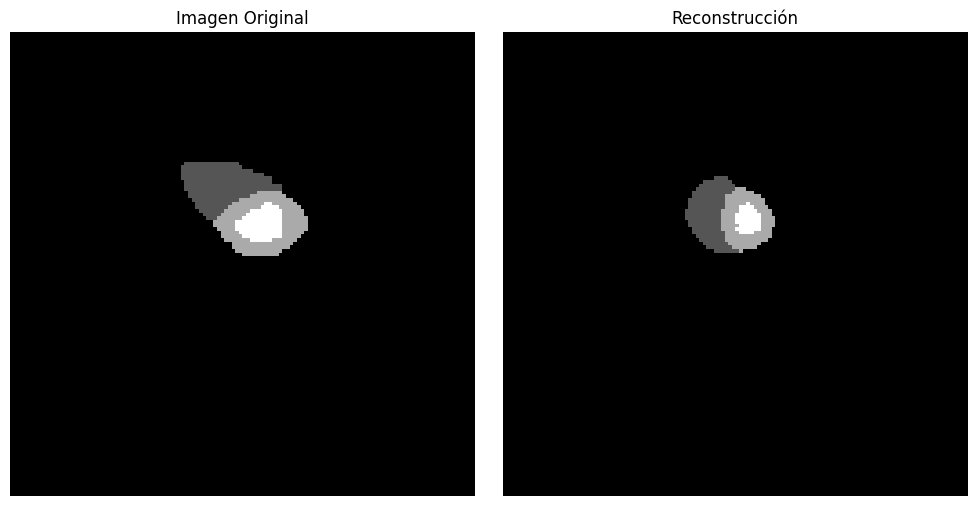

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_49.nii.gz


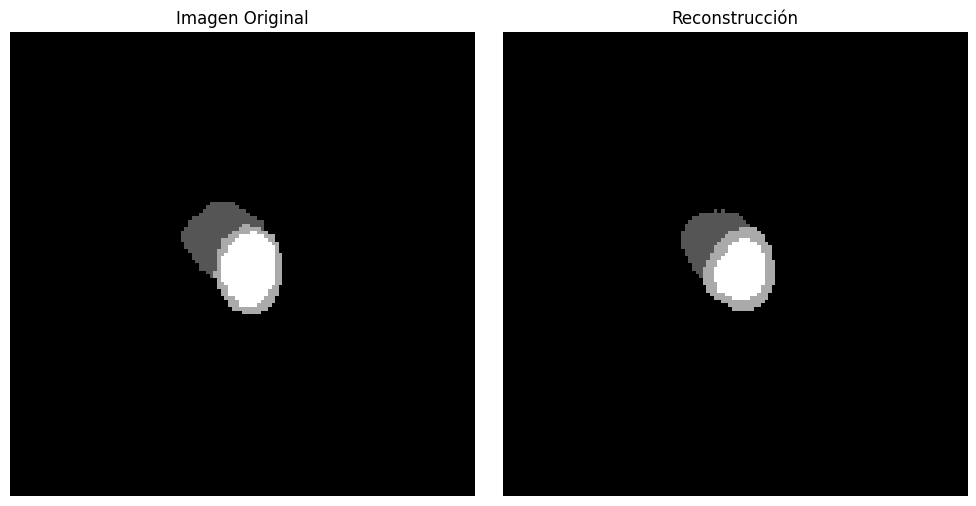

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_50.nii.gz


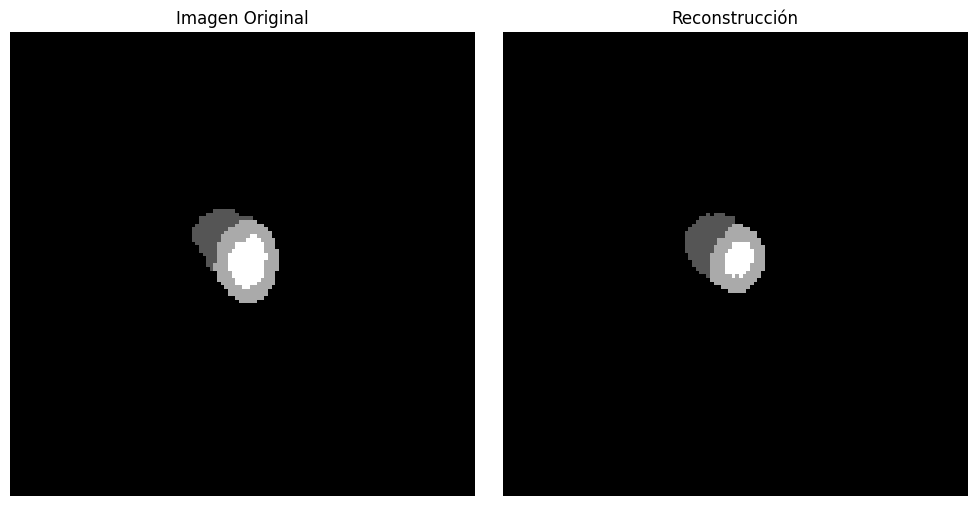

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_51.nii.gz


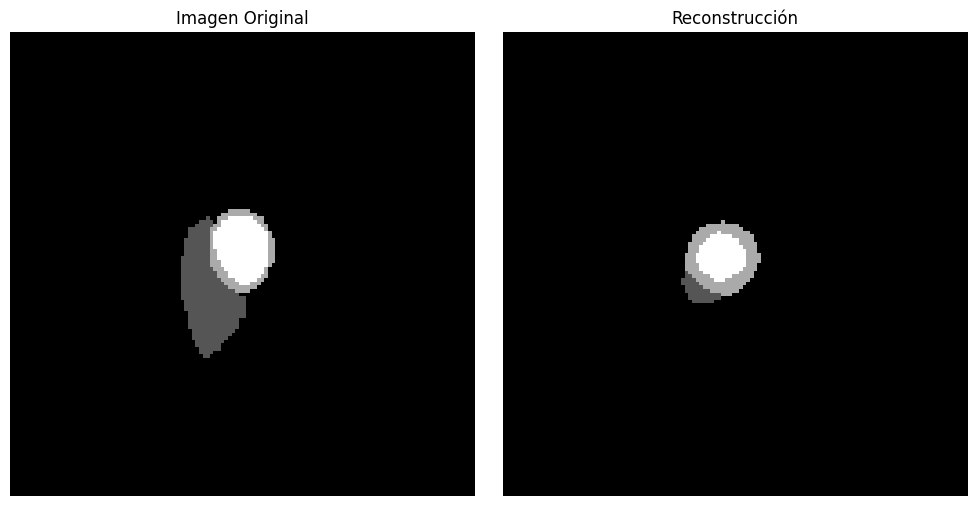

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_52.nii.gz


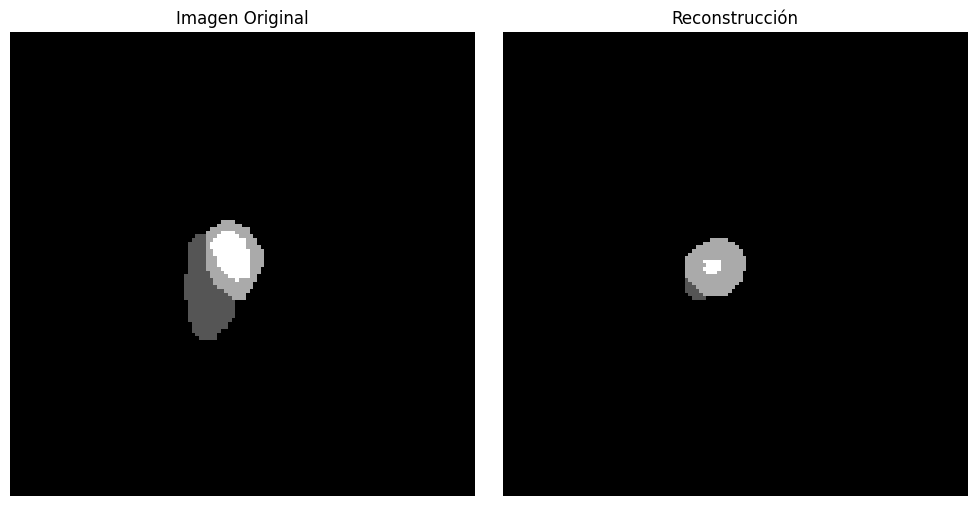

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_53.nii.gz


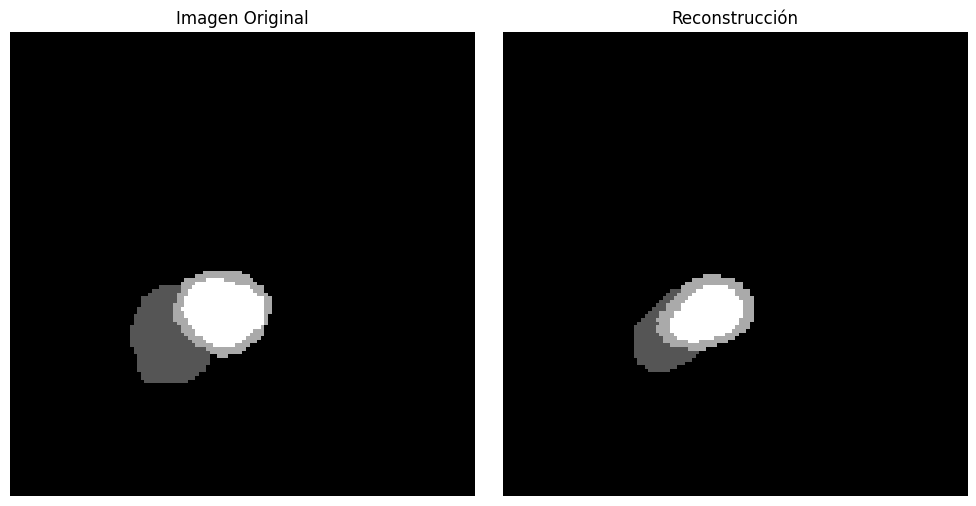

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_54.nii.gz


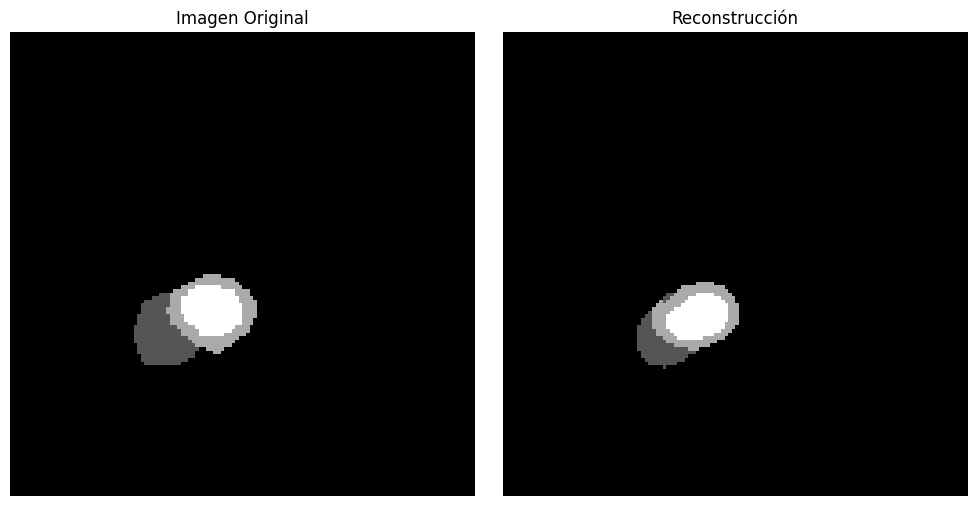

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_55.nii.gz


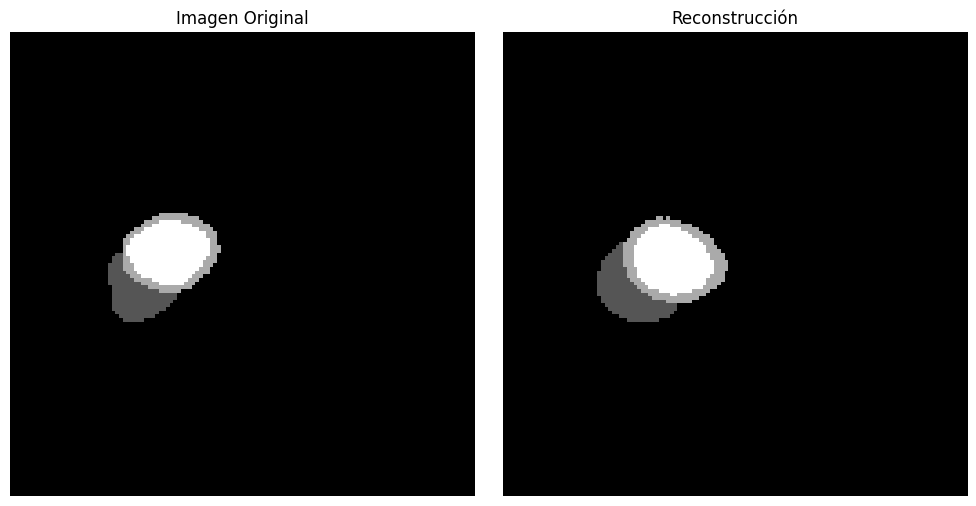

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_56.nii.gz


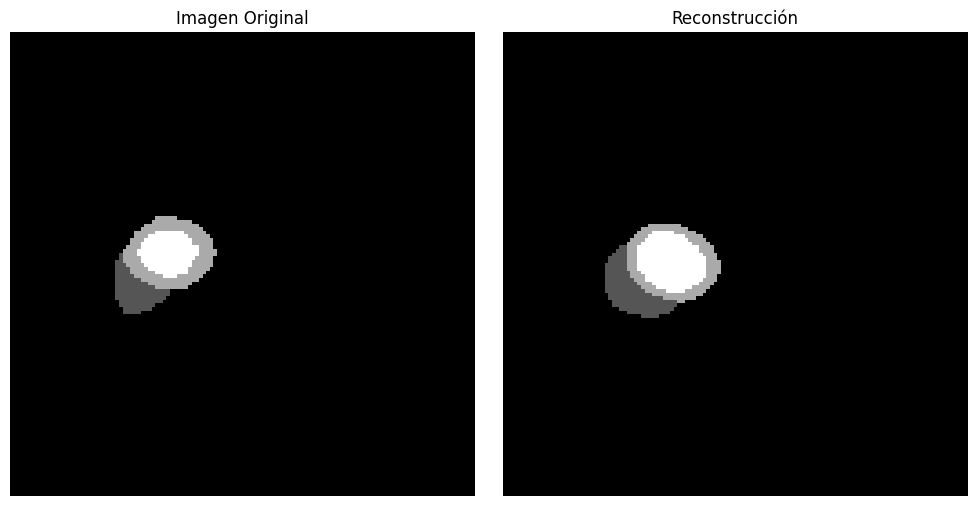

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_57.nii.gz


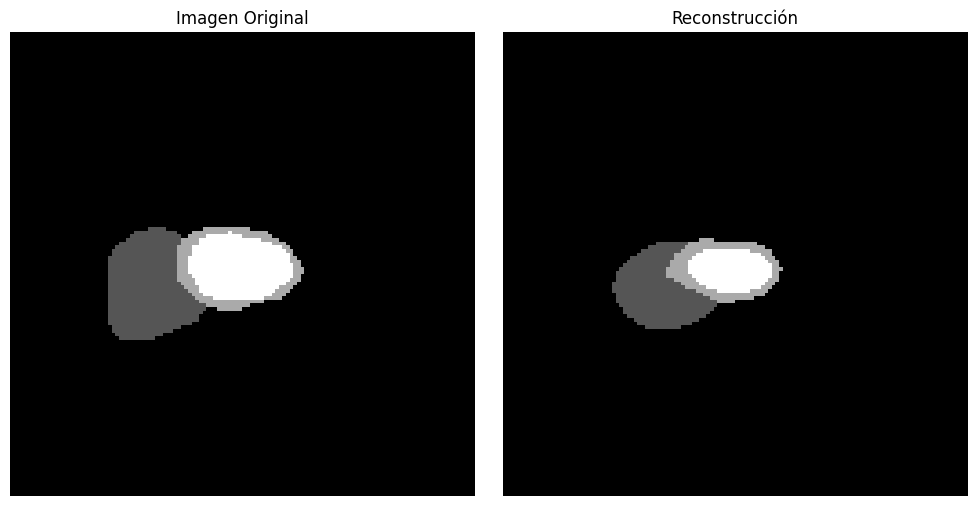

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_58.nii.gz


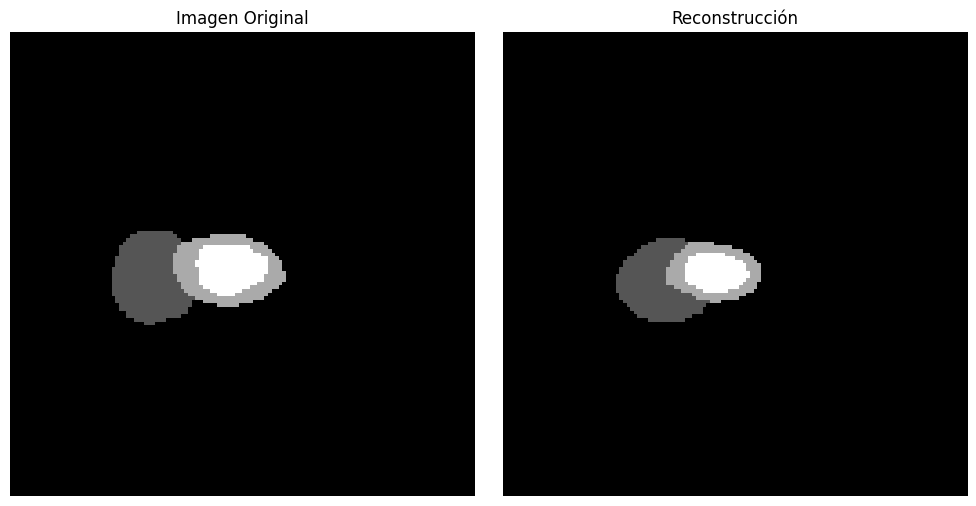

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_59.nii.gz


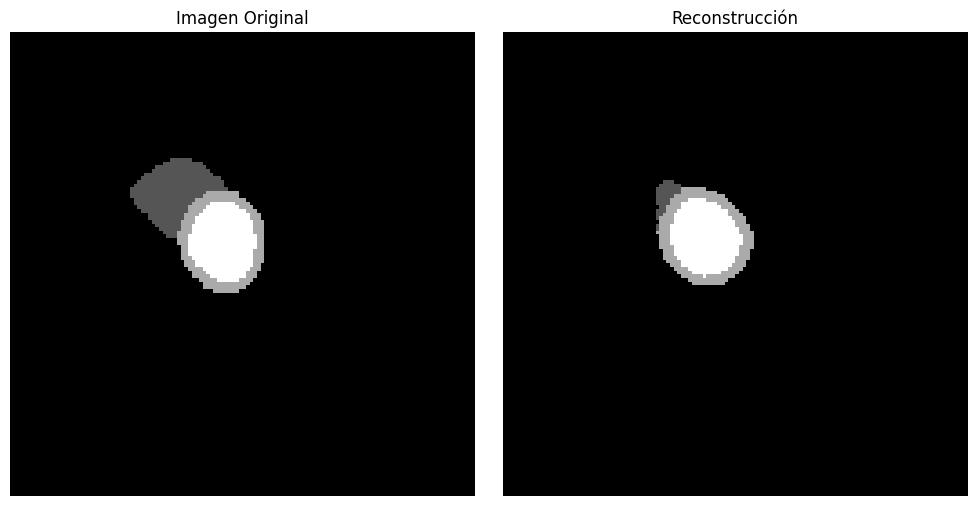

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_60.nii.gz


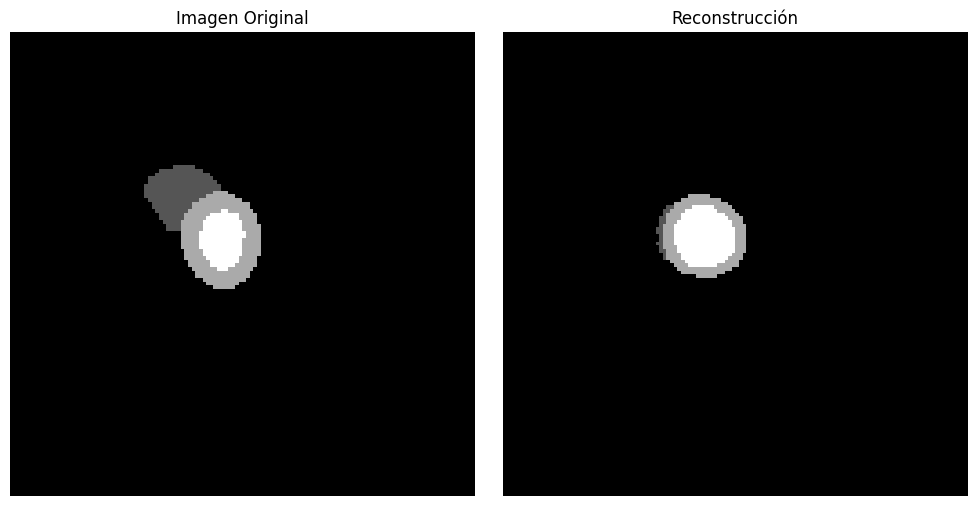

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_61.nii.gz


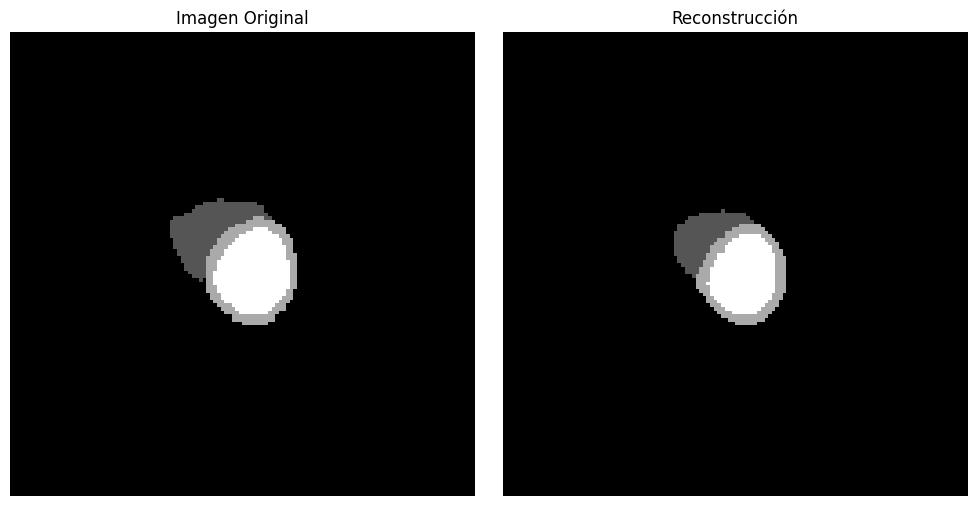

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_62.nii.gz


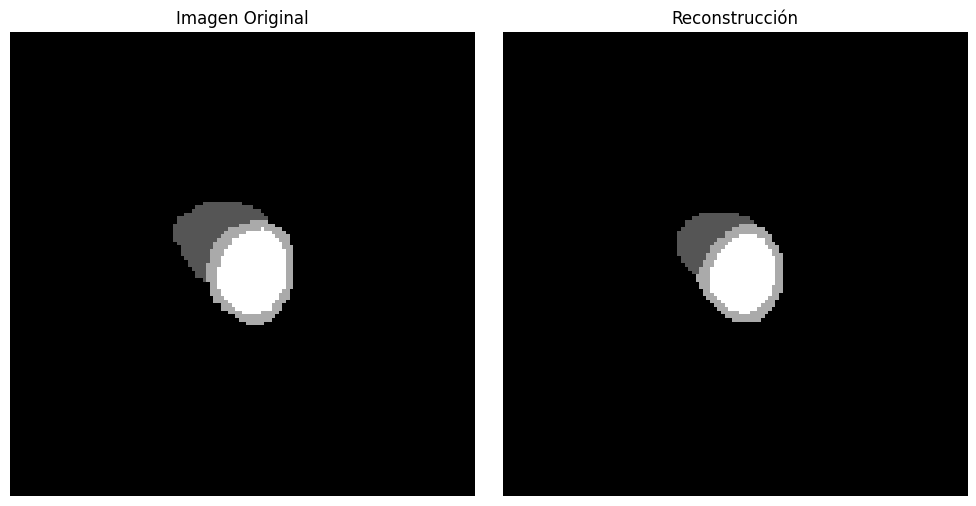

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_63.nii.gz


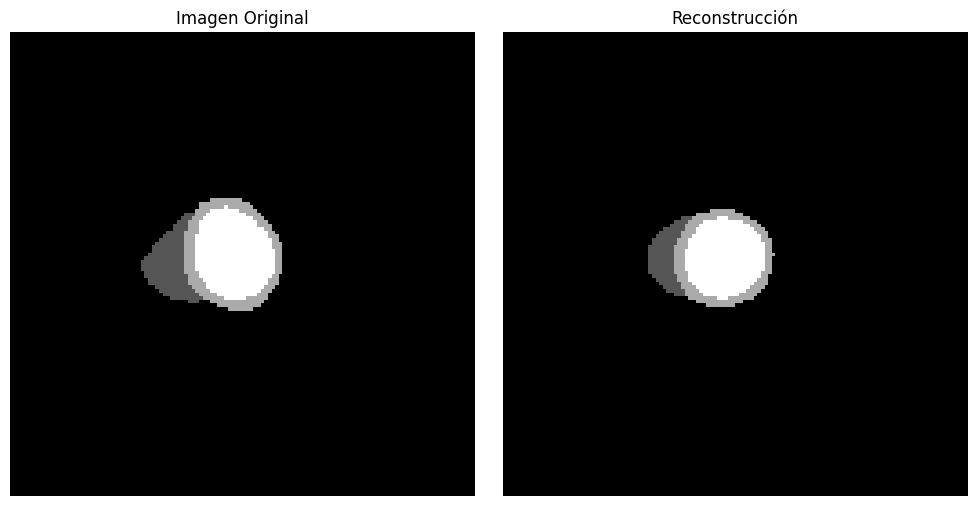

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_64.nii.gz


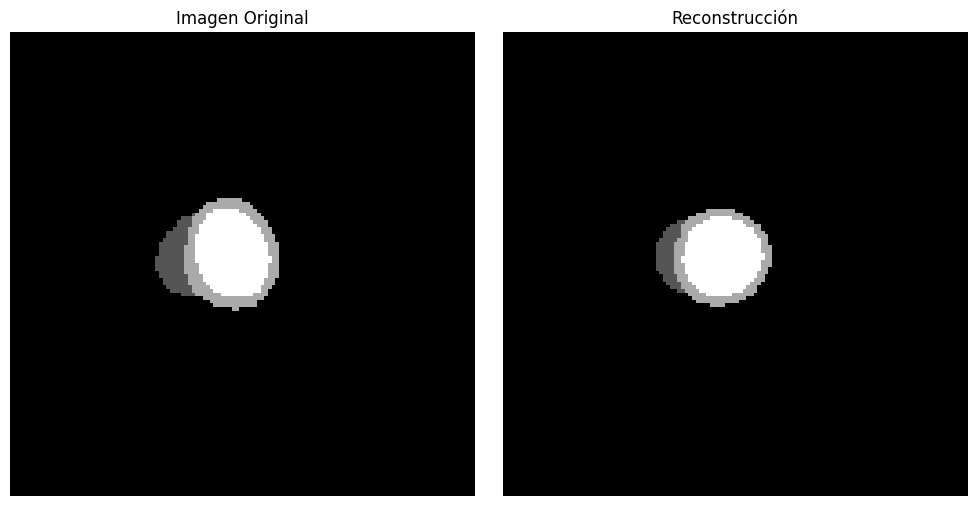

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_65.nii.gz


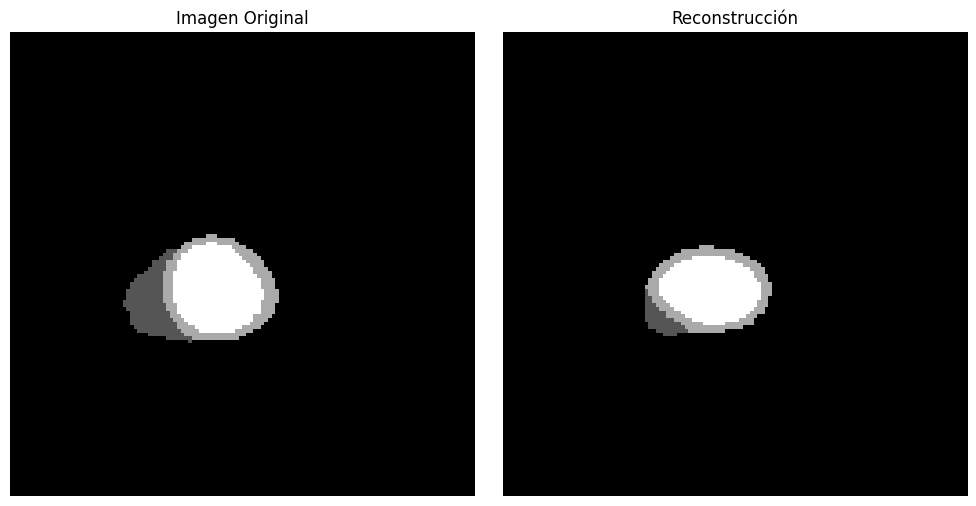

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_66.nii.gz


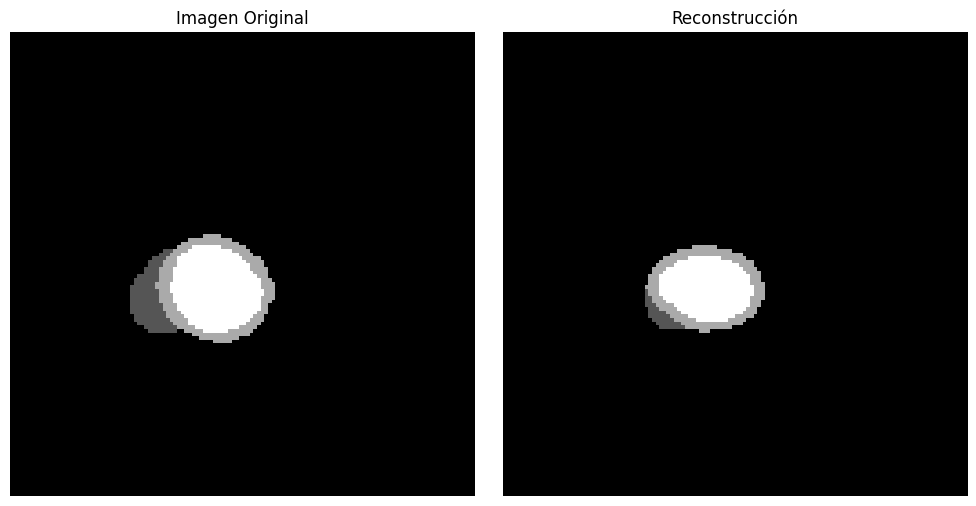

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_67.nii.gz


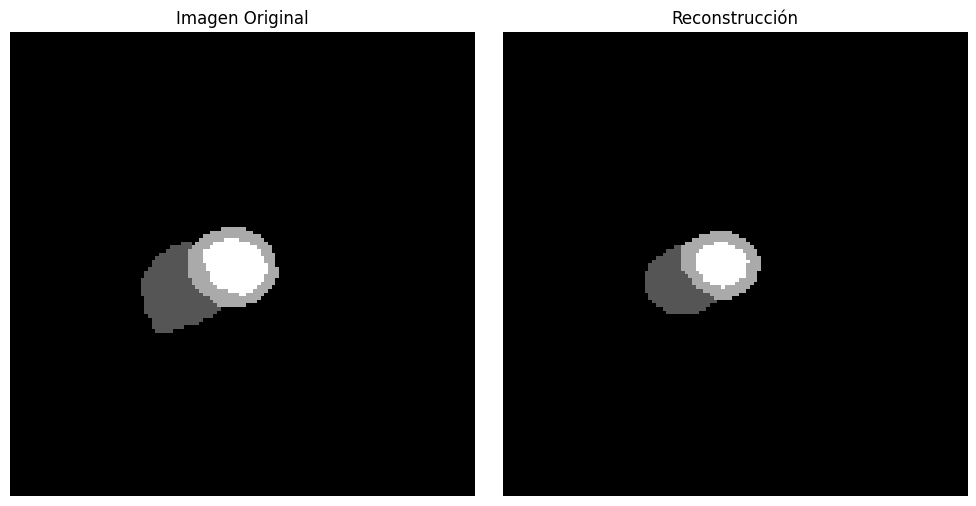

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_68.nii.gz


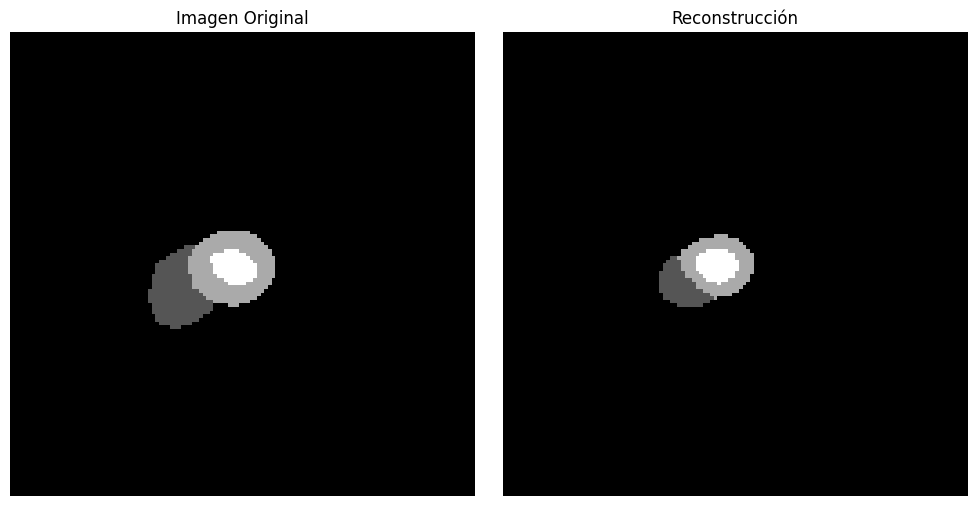

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_69.nii.gz


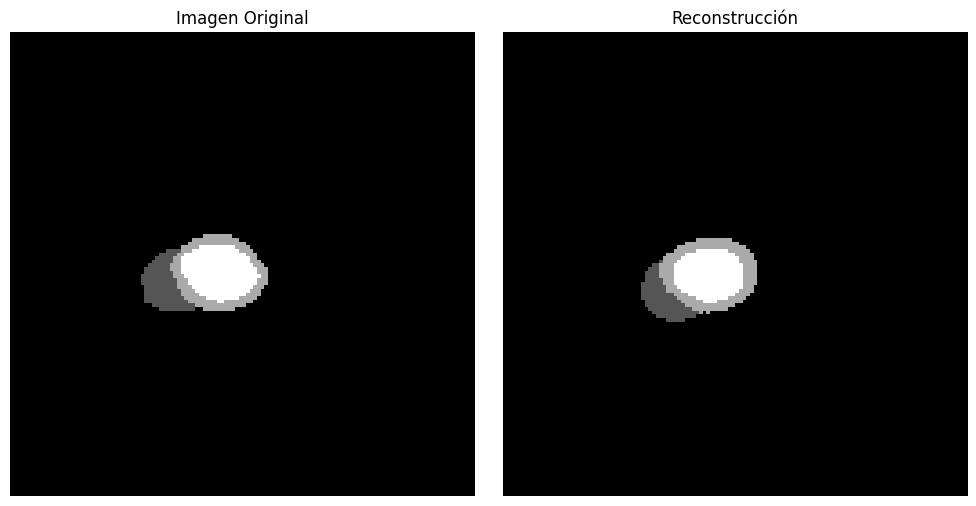

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_70.nii.gz


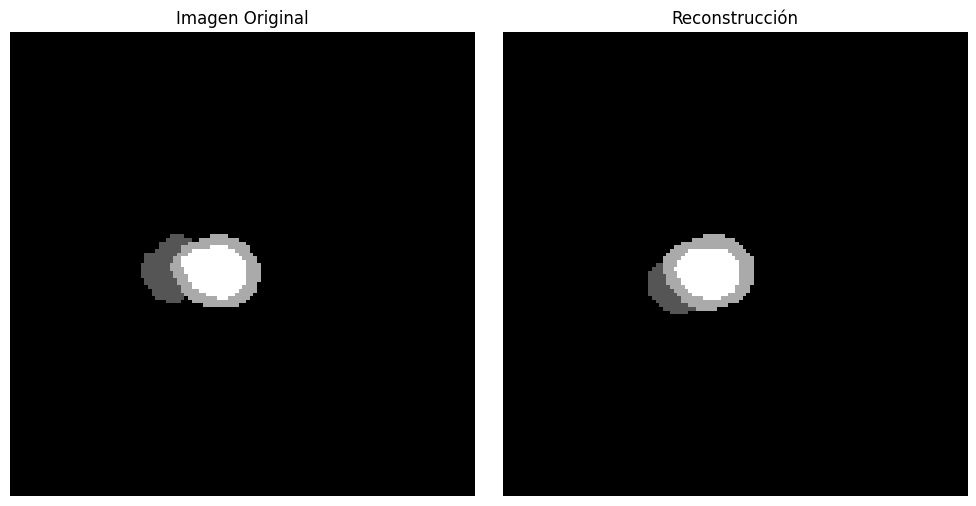

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_71.nii.gz


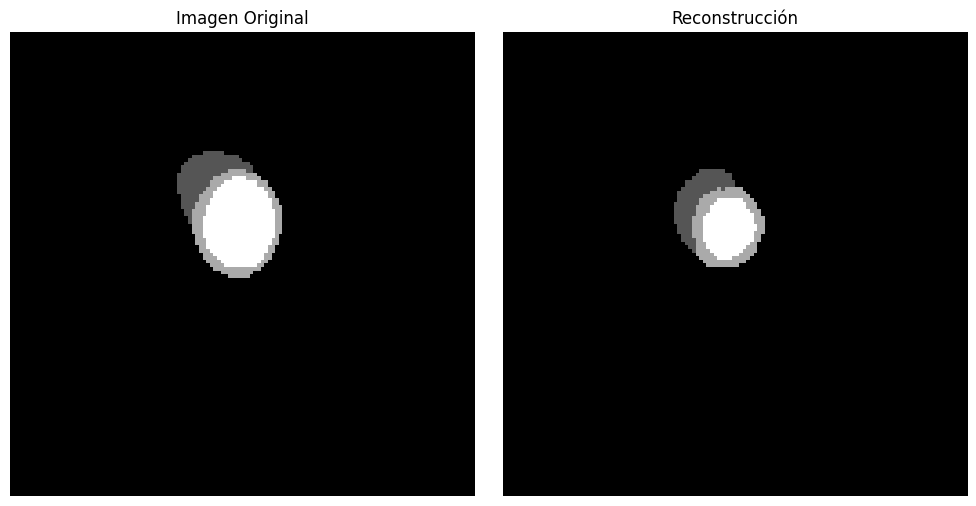

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_72.nii.gz


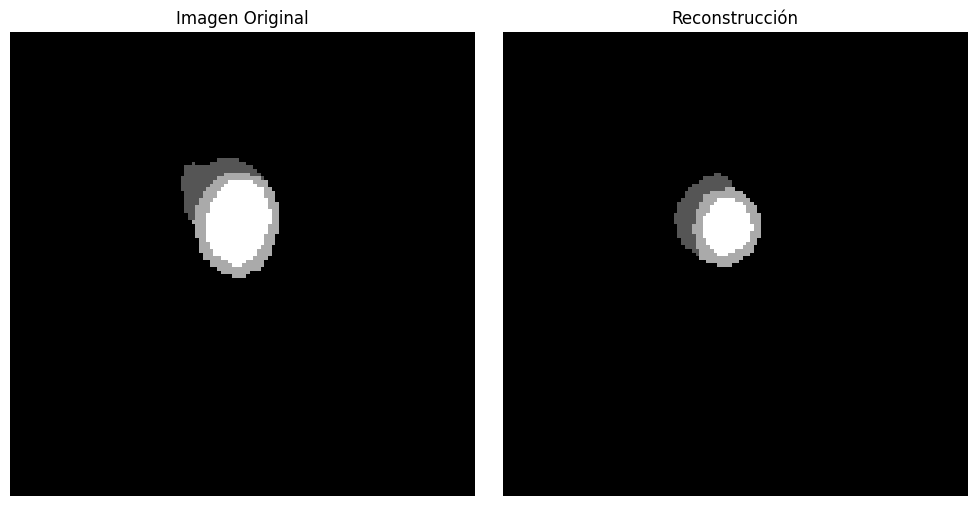

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_73.nii.gz


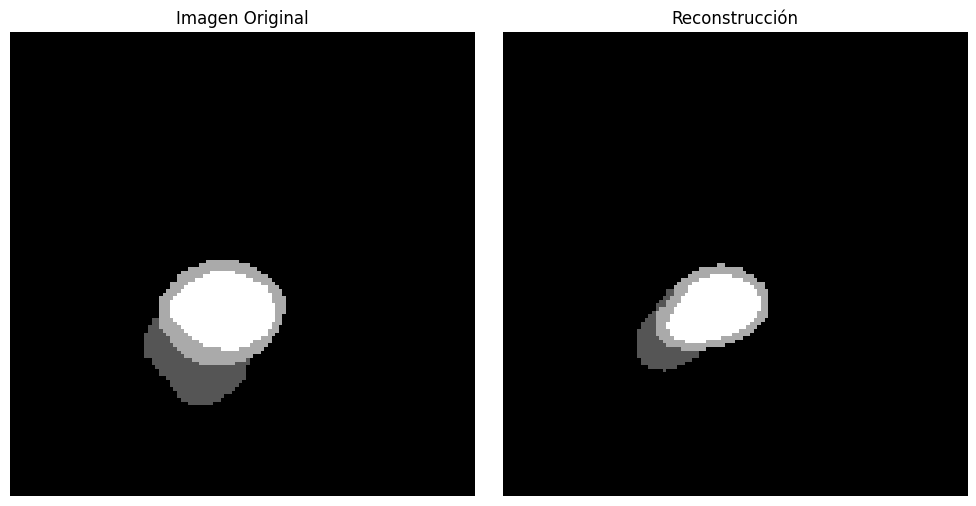

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_74.nii.gz


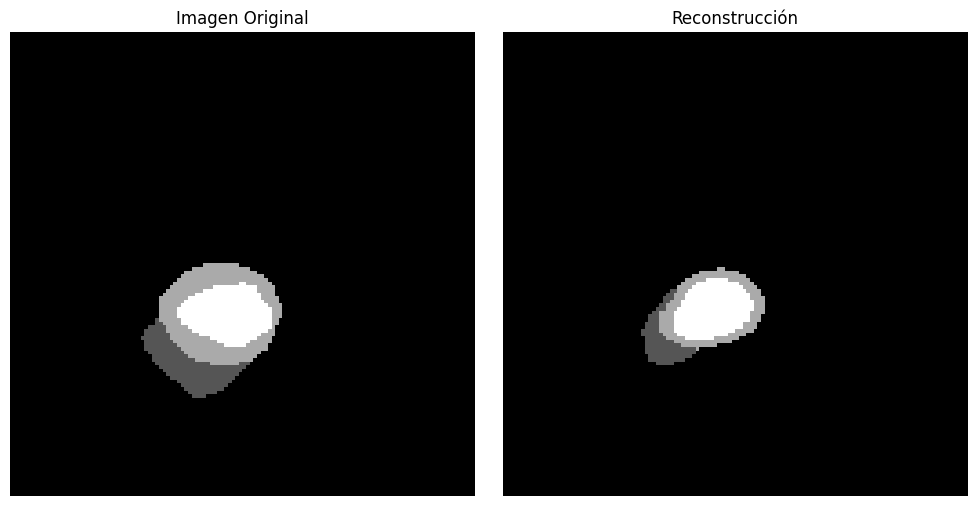

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_75.nii.gz


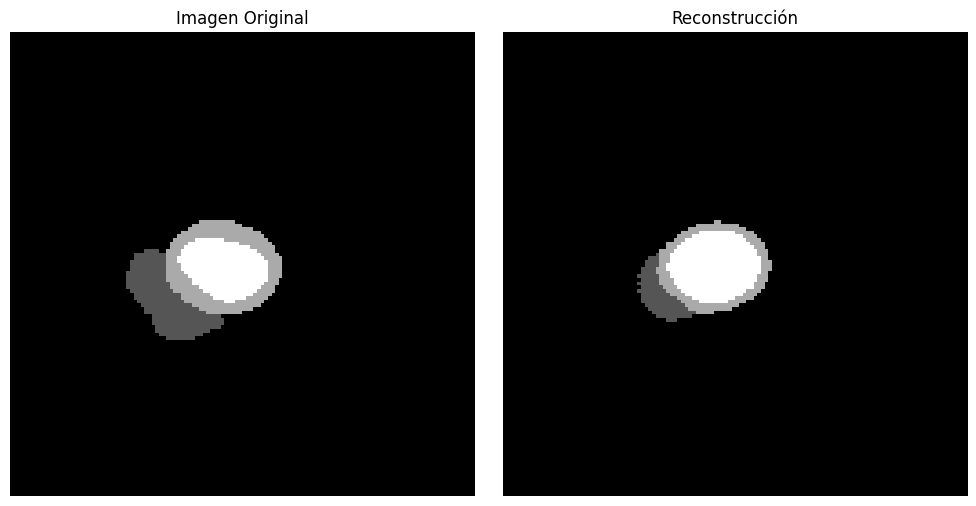

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_76.nii.gz


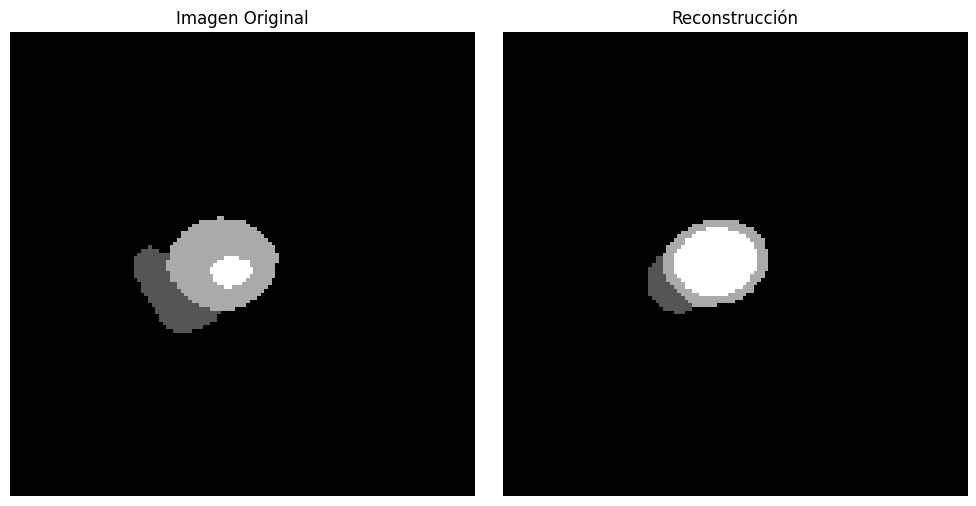

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_77.nii.gz


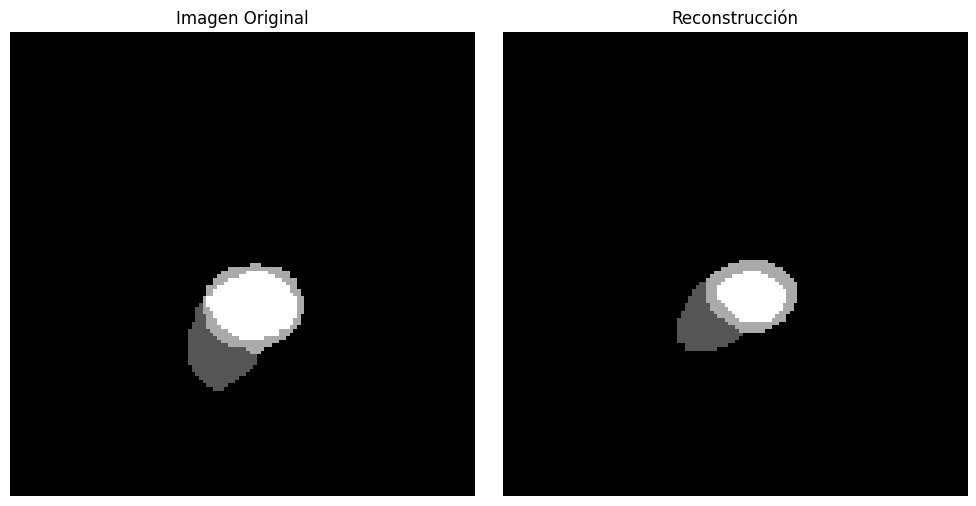

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_78.nii.gz


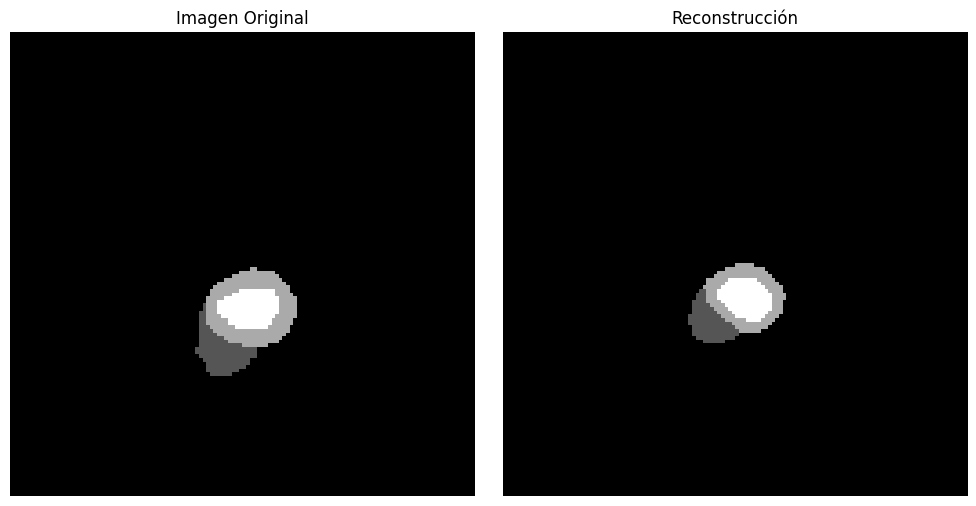

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_79.nii.gz


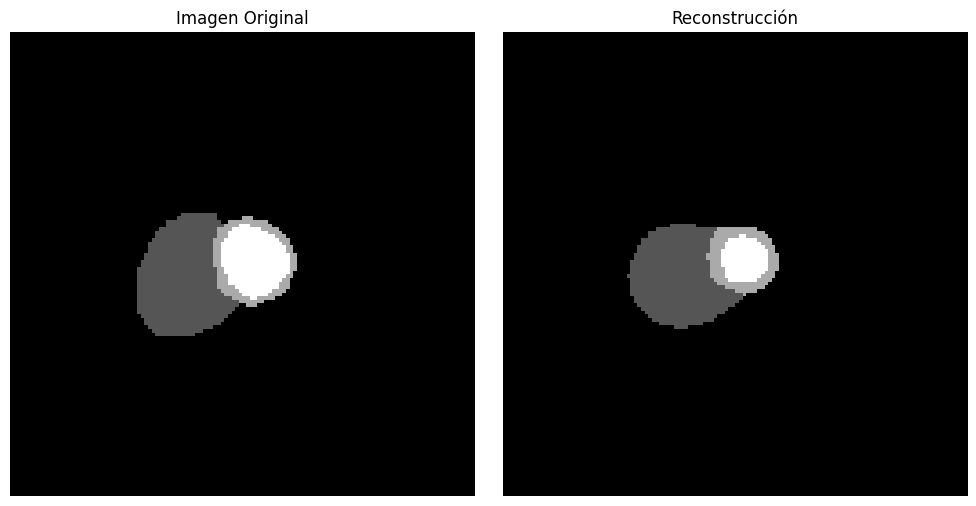

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_80.nii.gz


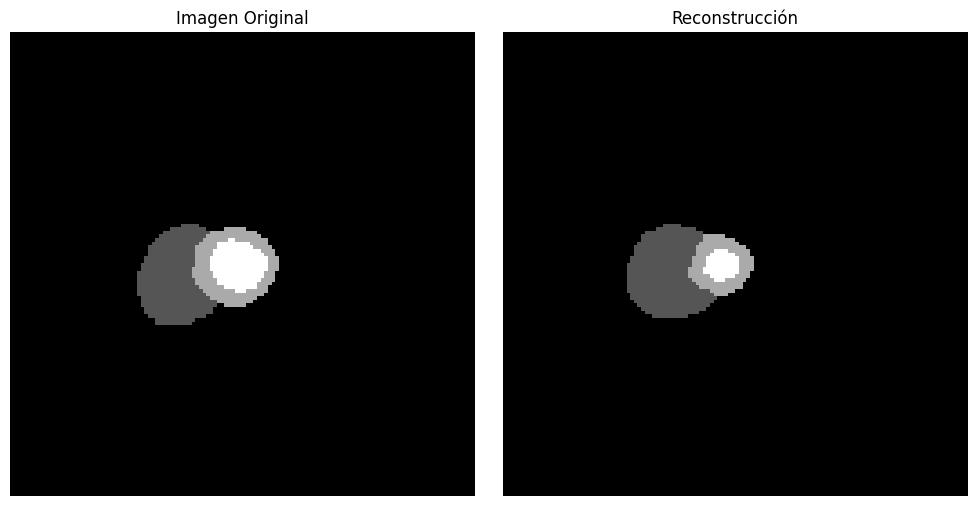

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_81.nii.gz


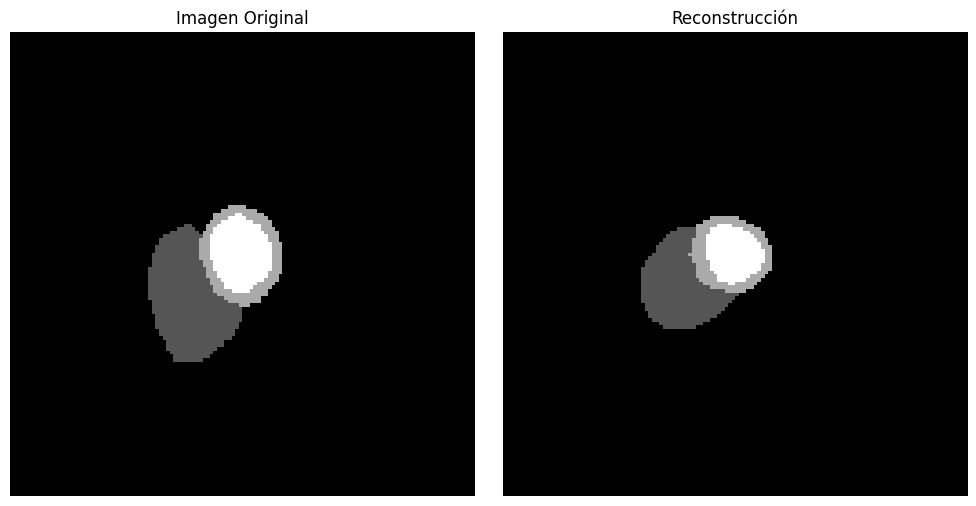

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_82.nii.gz


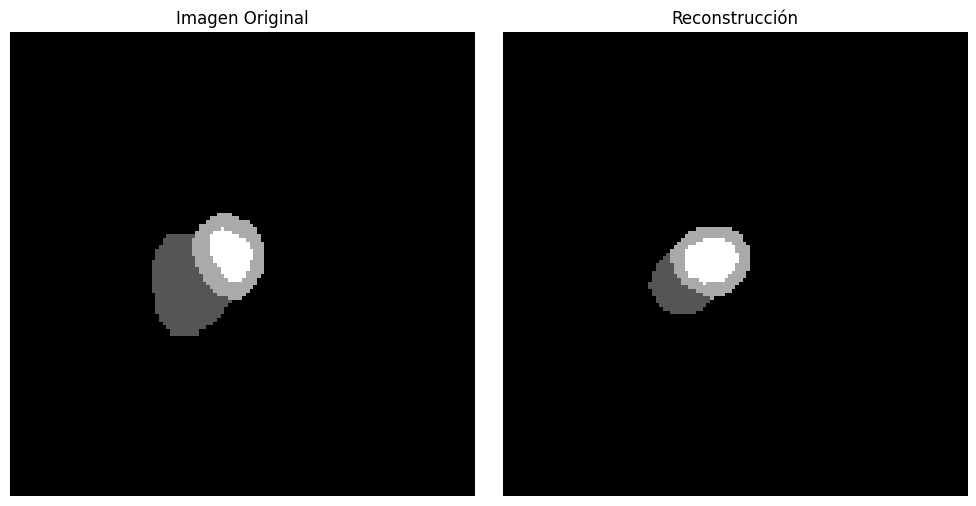

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_83.nii.gz


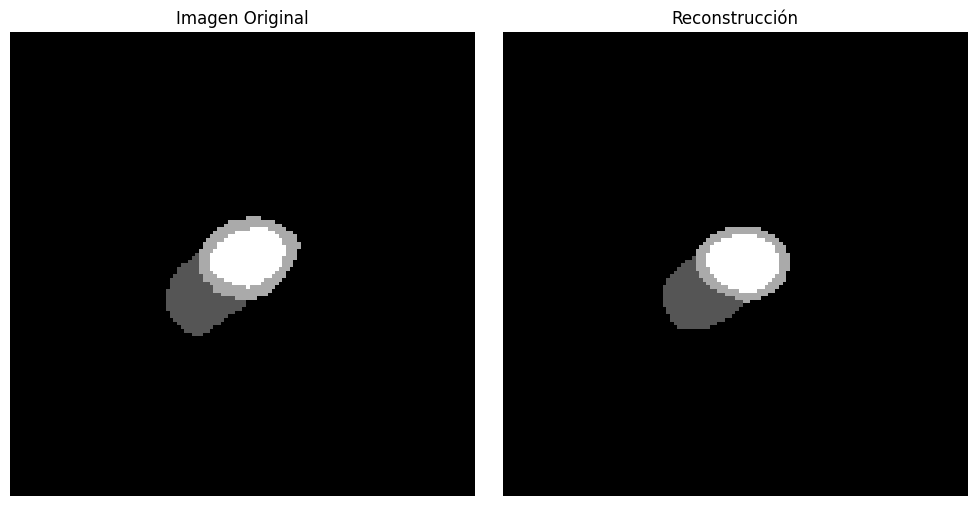

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_84.nii.gz


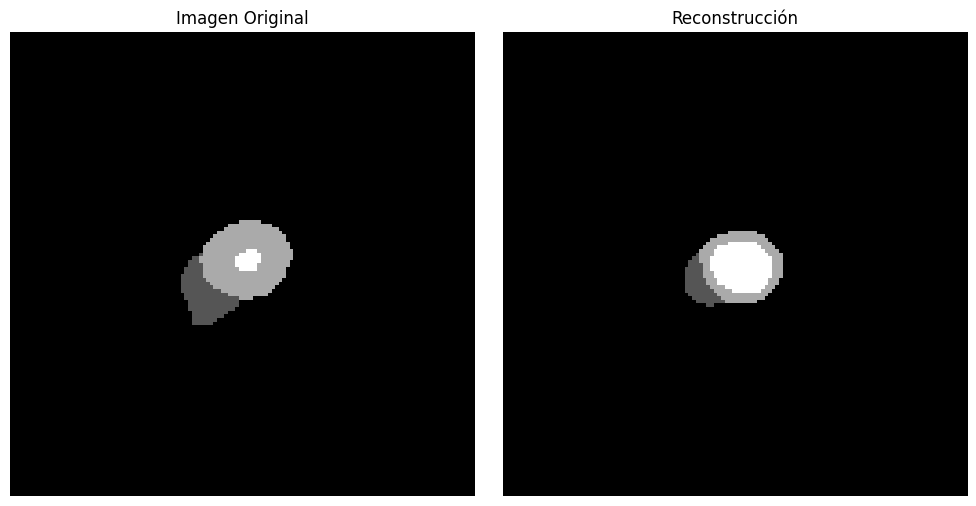

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_85.nii.gz


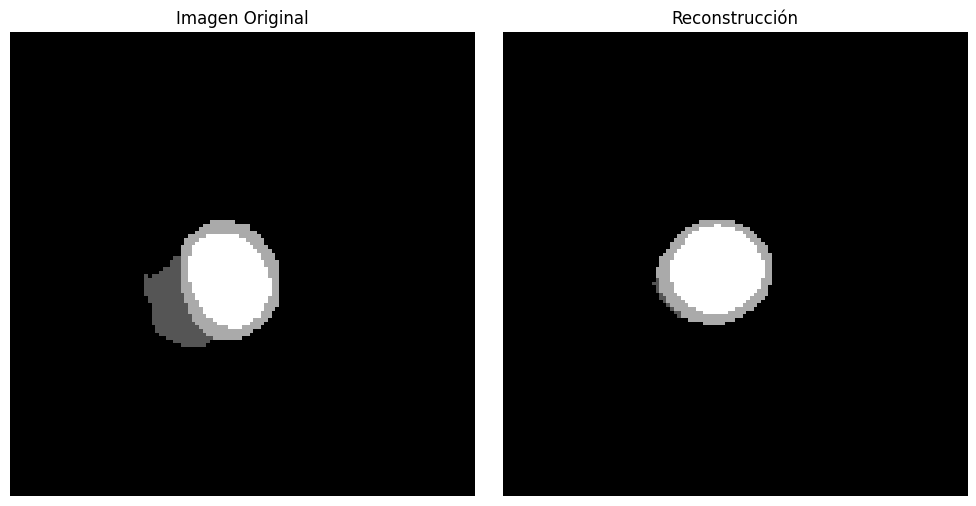

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_86.nii.gz


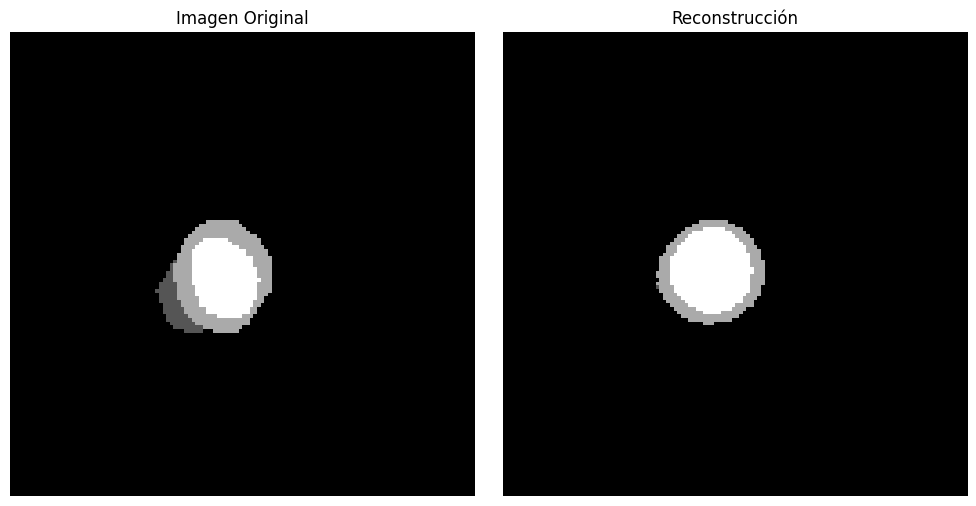

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_87.nii.gz


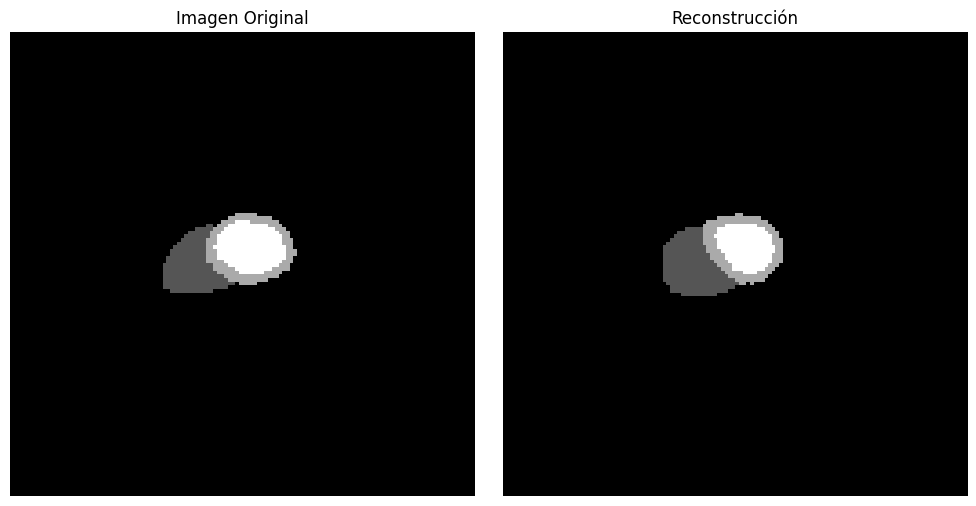

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_88.nii.gz


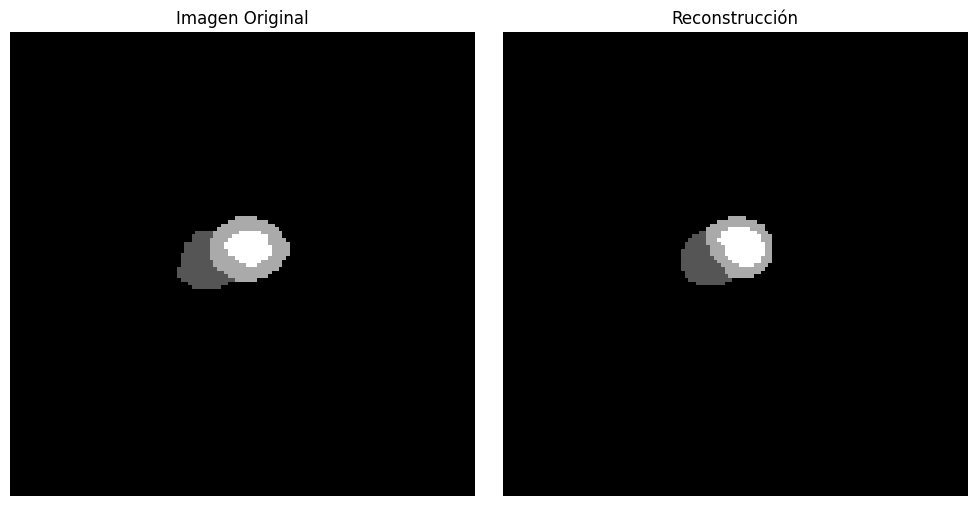

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_89.nii.gz


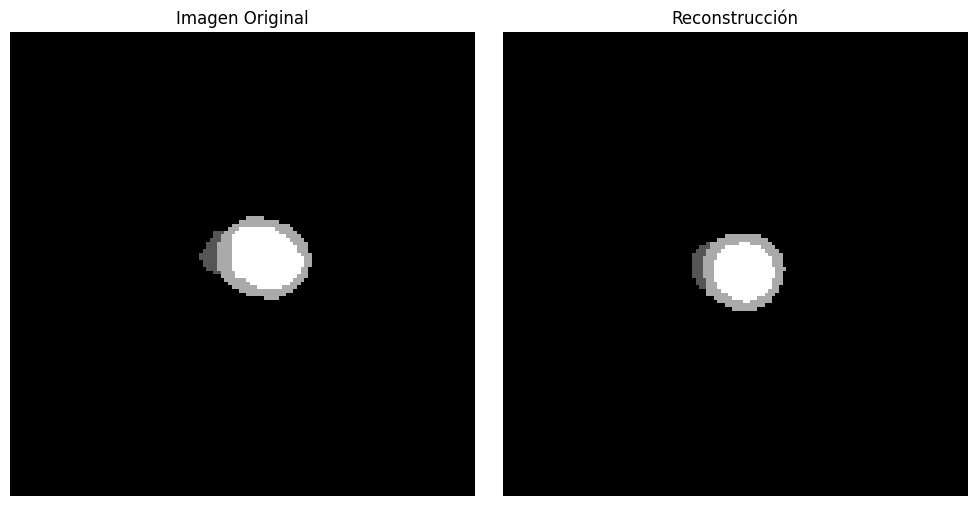

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_90.nii.gz


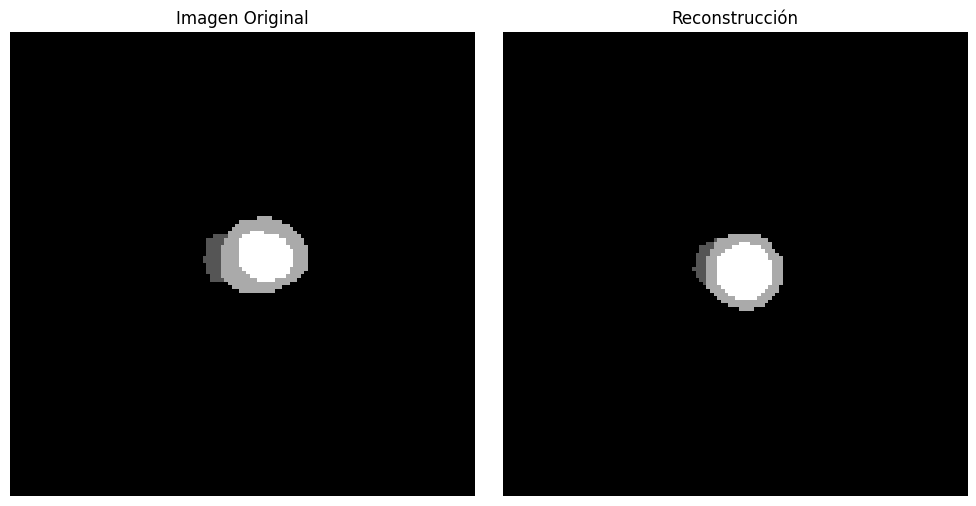

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_91.nii.gz


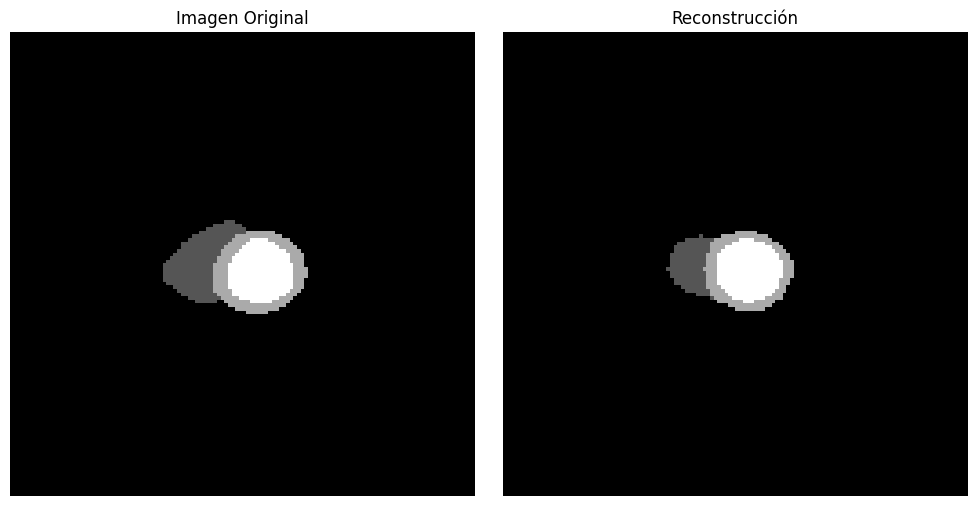

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_92.nii.gz


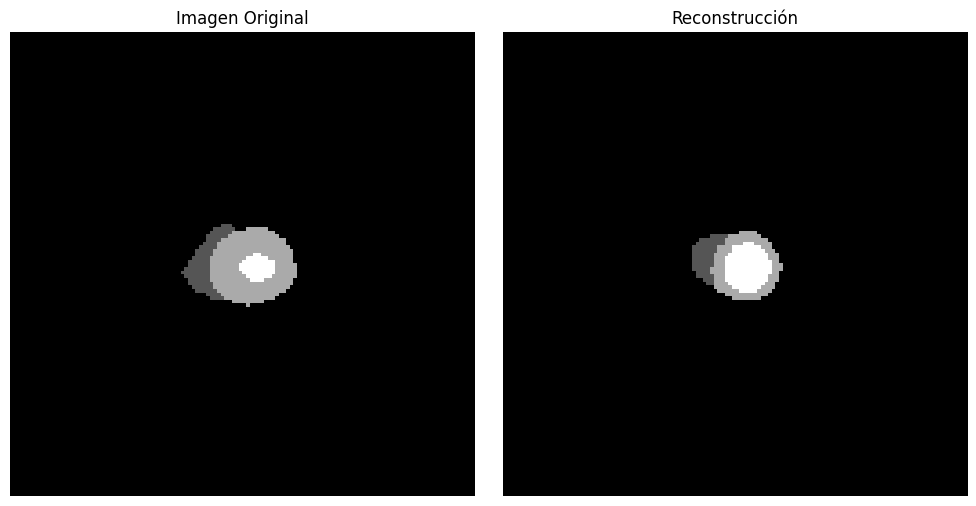

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_93.nii.gz


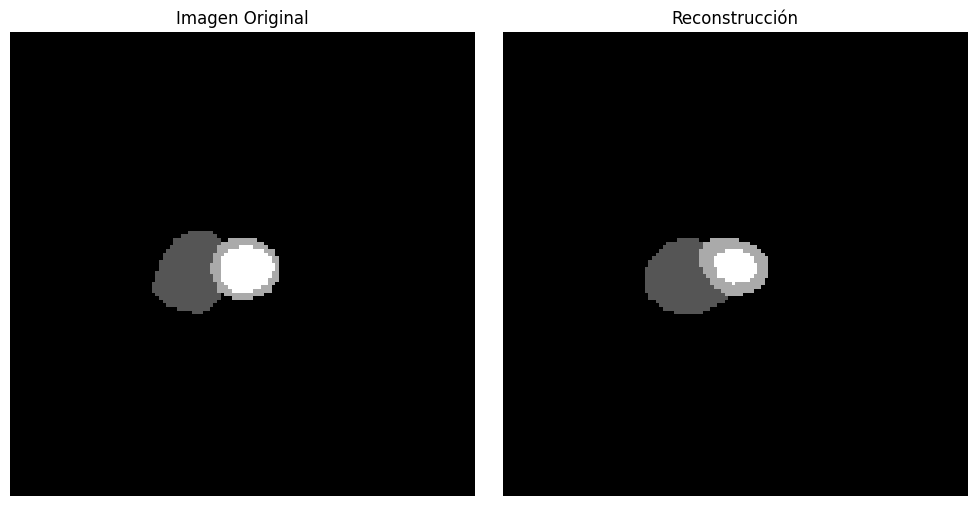

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_94.nii.gz


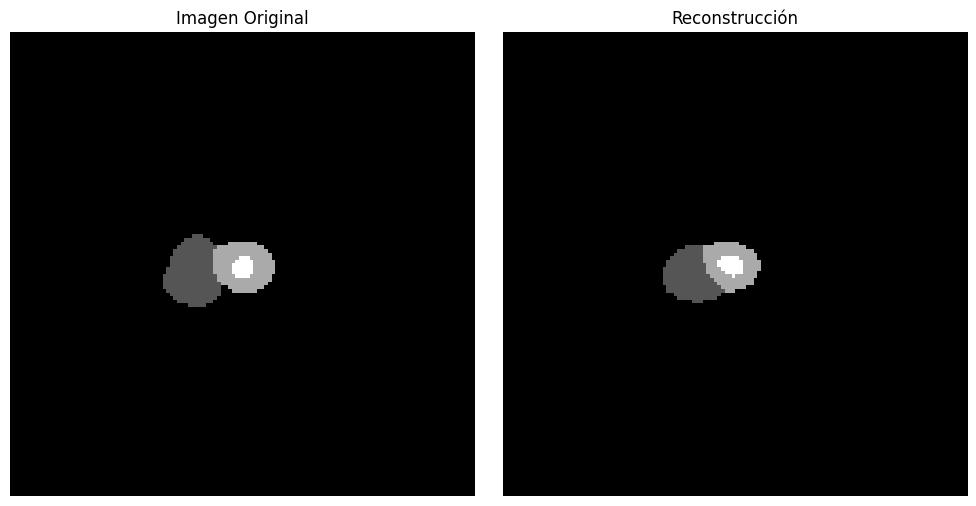

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_95.nii.gz


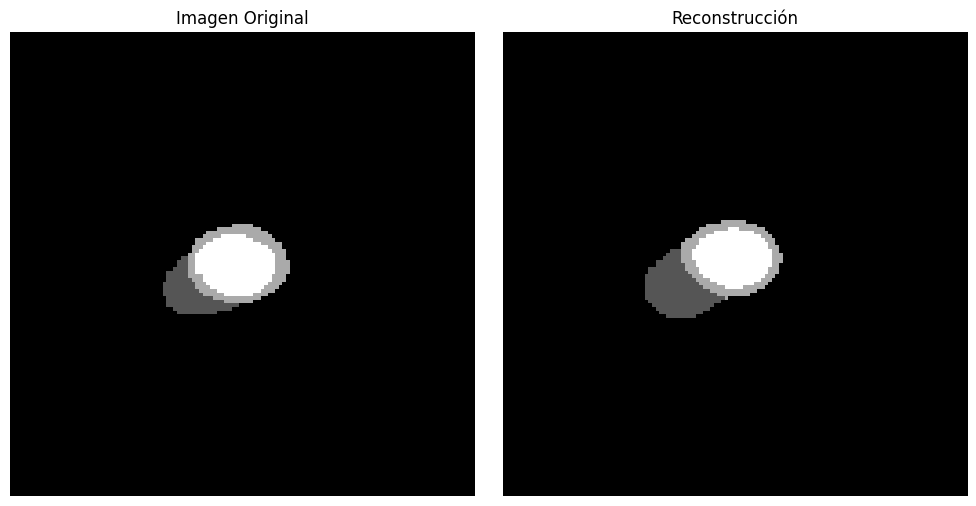

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_96.nii.gz


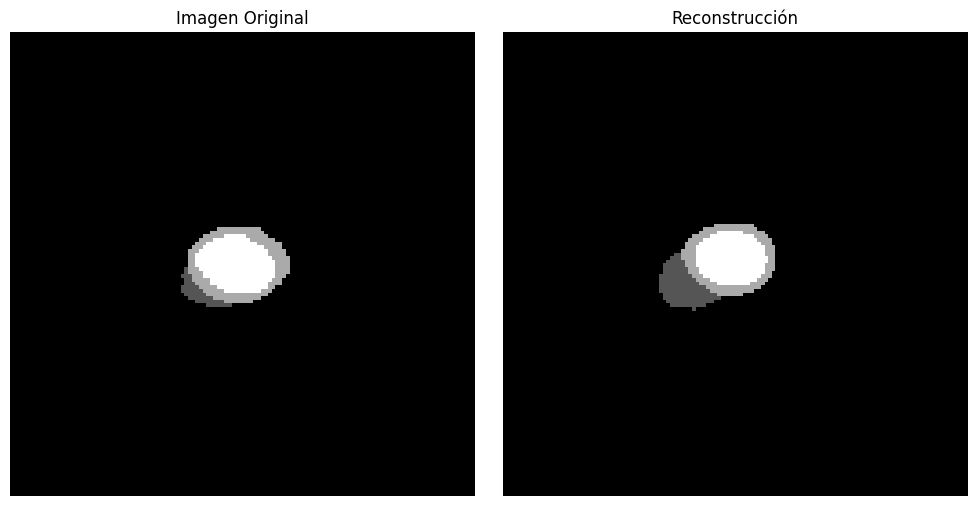

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_97.nii.gz


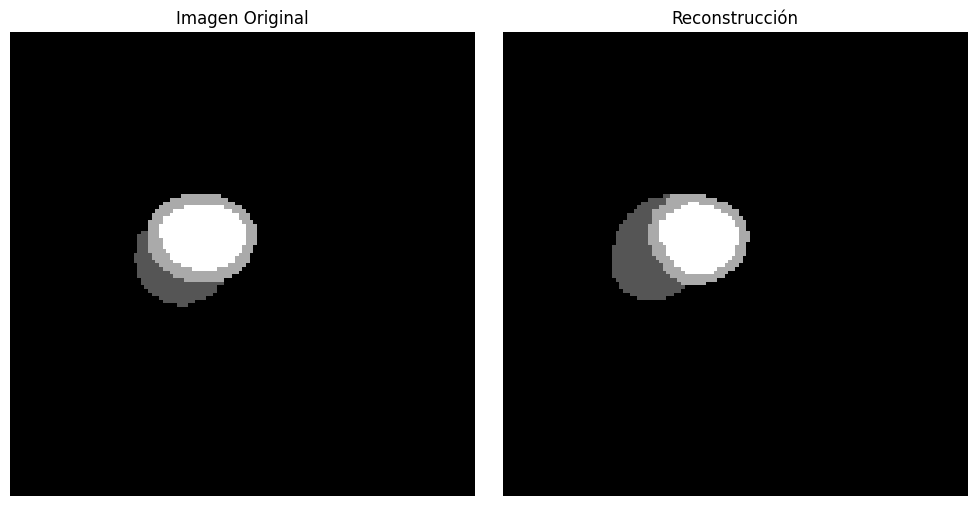

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_98.nii.gz


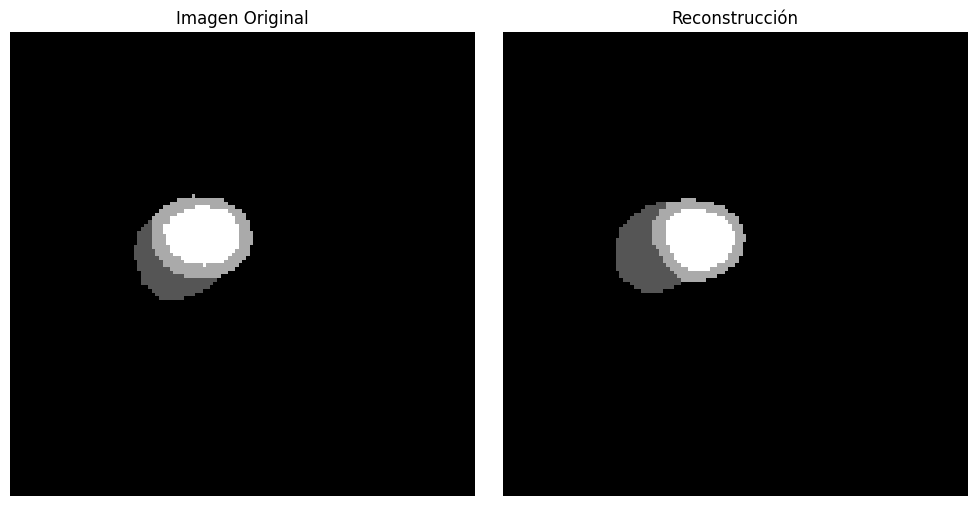

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_99.nii.gz


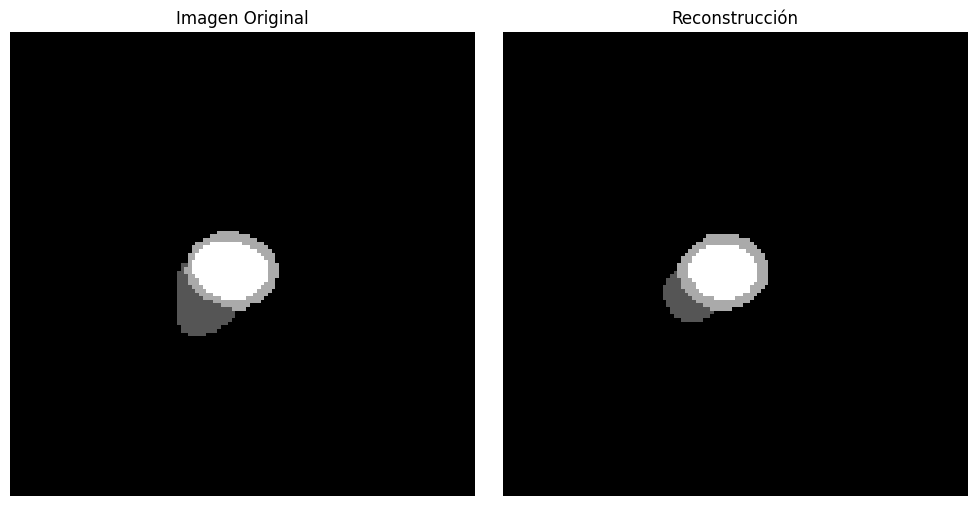

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
Imagen guardada en: /mnt/nfs/home/liglesias/reconstruction/original/validation/reconstructed_image_batch_100.nii.gz


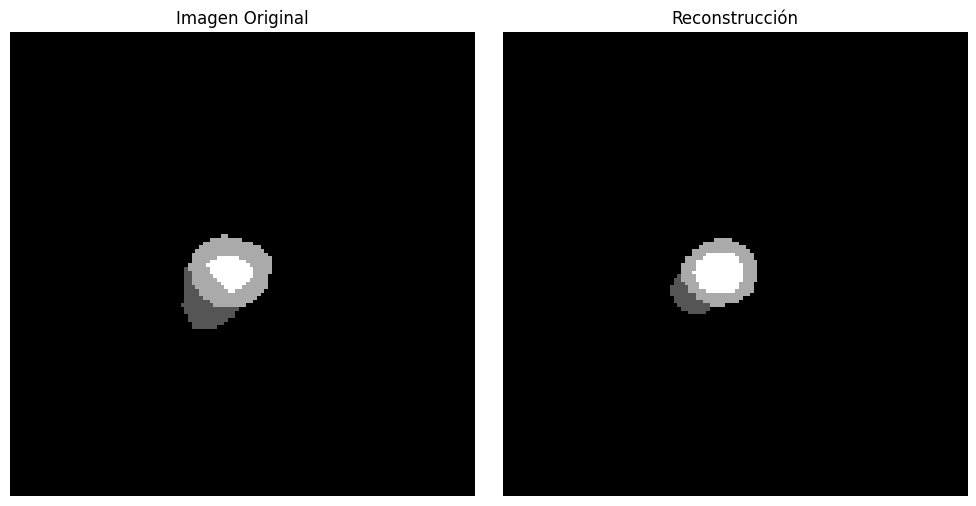

In [71]:
import nibabel as nib
import os
import torch
import matplotlib.pyplot as plt
from monai.transforms import AsDiscreted
import numpy as np
import torch.nn.functional as F

# Función para guardar la reconstrucción como un archivo NIfTI
def save_reconstruction_as_nifti(reconstructed_image, output_dir, file_name):
    os.makedirs(output_dir, exist_ok=True)
    reconstructed_image = reconstructed_image.squeeze(0).cpu().numpy()
    nifti_img = nib.Nifti1Image(reconstructed_image, affine=np.eye(4))
    output_path = os.path.join(output_dir, file_name)
    nib.save(nifti_img, output_path)
    print(f"Imagen guardada en: {output_path}")

def visualize_and_save_reconstruction(model, data_loader, device, output_dir):
    postprocess_transform = AsDiscreted(keys="image", argmax=True, dim=1)

    model.eval()
    with torch.no_grad():
        for batch_idx, batch_data in enumerate(data_loader):
            inputs = batch_data["image"].to(device)

            print(f"Min: {inputs.min()}, Max: {inputs.max()}, Mean: {inputs.mean()}, Std: {inputs.std()}")
            outputs, _ = model(inputs)

            postprocess_input = postprocess_transform({"image": inputs})["image"]
            postprocess_output = postprocess_transform({"image": outputs})["image"]

            print(f"Input shape: {inputs.shape}")
            print(f"Output shape: {outputs.shape}")
            print(f"Postprocess output shape: {postprocess_output.shape}")

            slice_idx = postprocess_output.shape[2] // 2 
            
            save_reconstruction_as_nifti(postprocess_output[0, 0, :, :, :], output_dir, f"reconstructed_image_batch_{batch_idx+1}.nii.gz")

            plt.figure(figsize=(10, 5))

            plt.subplot(1, 2, 1)
            plt.imshow(postprocess_input[0, 0, slice_idx].cpu().numpy(), cmap="gray", interpolation='none')
            plt.title("Imagen Original")
            plt.axis("off")

            plt.subplot(1, 2, 2)
            plt.imshow(postprocess_output[0, 0, slice_idx].cpu().numpy(), cmap="gray", interpolation='none')
            plt.title("Reconstrucción")
            plt.axis("off")

            plt.tight_layout()
            plt.show()

output_directory_train = '/mnt/nfs/home/liglesias/reconstruction/original/train'
output_directory_val = '/mnt/nfs/home/liglesias/reconstruction/original/validation'
visualize_and_save_reconstruction(model, train_loader, device, output_directory_train)
visualize_and_save_reconstruction(model, val_loader, device, output_directory_val)

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])


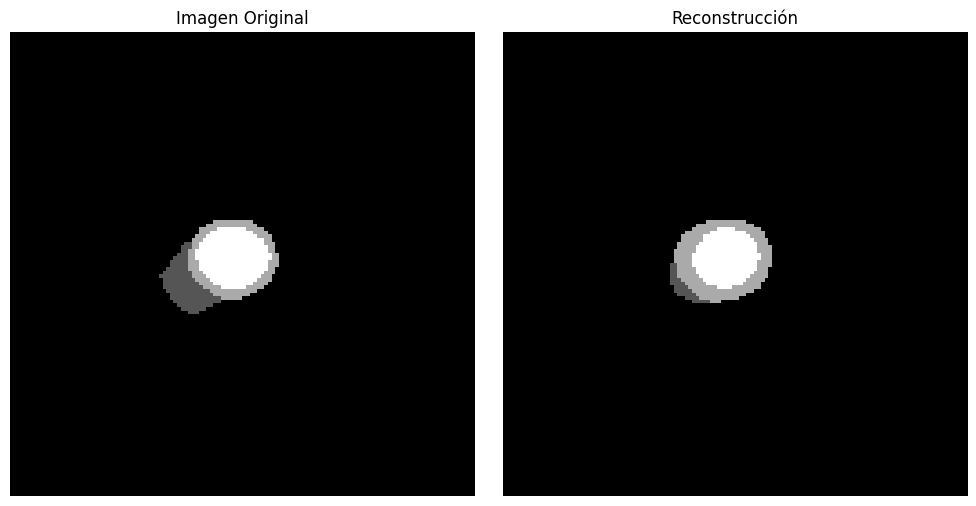

In [63]:
def visualize_axial_reconstruction(model, data_loader, device):
    postprocess_transform = transforms.AsDiscreted(keys="image", argmax=True, dim=1)

    model.eval()
    with torch.no_grad():
        batch_data = next(iter(data_loader))
        inputs = batch_data["image"].to(device)

        print(f"Min: {inputs.min()}, Max: {inputs.max()}, Mean: {inputs.mean()}, Std: {inputs.std()}")
        outputs, _ = model(inputs)

        postprocess_input = postprocess_transform({"image": inputs})["image"]
        postprocess_output = postprocess_transform({"image": outputs})["image"]

        print(f"Input shape: {inputs.shape}")
        print(f"Output shape: {outputs.shape}")
        print(f"Postprocess output shape: {postprocess_output.shape}")

        slice_idx = postprocess_output.shape[2] // 2  # Índice de la rebanada central
        
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(postprocess_input[0, 0, slice_idx].cpu().numpy(), cmap="gray", interpolation='none')
        plt.title("Imagen Original")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(postprocess_output[0, 0, slice_idx].cpu().numpy(), cmap="gray", interpolation='none')
        plt.title("Reconstrucción")
        plt.axis("off")

        plt.tight_layout()
        plt.show()
    
visualize_axial_reconstruction(model, val_loader, device)

In [64]:
training_files = list_nifti_files(training_dir)
training_image =  nib.load(training_files[0]) 
header = training_image.header
print(header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 216 256  10   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [ 1.      1.5625  1.5625 10.      1.      1.      1.      1.    ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0.0
srow_x          : 

In [72]:
# # PRUEBA
# import nibabel as nib
# import os
# import torch
# import matplotlib.pyplot as plt
# from monai.transforms import AsDiscreted
# import numpy as np
# import torch.nn.functional as F

# def save_reconstruction_as_nifti(reconstructed_image, output_dir, file_name):
#     os.makedirs(output_dir, exist_ok=True)
#     reconstructed_image = reconstructed_image.squeeze(0).cpu().numpy()
#     nifti_img = nib.Nifti1Image(reconstructed_image, affine= np.diag([-1,-1,1,1]))
#     # print(nifti_img.header)
#     output_path = os.path.join(output_dir, file_name)
#     nib.save(nifti_img, output_path)
#     print(f"Imagen guardada en: {output_path}")

# def visualize_and_save_reconstruction(model, data_loader, device, output_dir):
#     postprocess_transform = AsDiscreted(keys="image", argmax=True, dim=1)

#     model.eval()
#     with torch.no_grad():
#         for batch_idx, batch_data in enumerate(data_loader):
#             inputs = batch_data["image"].to(device)

#             print(f"Min: {inputs.min()}, Max: {inputs.max()}, Mean: {inputs.mean()}, Std: {inputs.std()}")
#             outputs, _ = model(inputs)

#             postprocess_input = postprocess_transform({"image": inputs})["image"]
#             postprocess_output = postprocess_transform({"image": outputs})["image"]

#             print(f"Input shape: {inputs.shape}")
#             print(f"Output shape: {outputs.shape}")
#             print(f"Postprocess output shape: {postprocess_output.shape}")

#             slice_idx = postprocess_output.shape[2] // 2 
            
#             save_reconstruction_as_nifti(postprocess_output[0, 0, :, :, :], output_dir, f"reconstructed_image_batch_{batch_idx+1}.nii.gz")

#             plt.figure(figsize=(10, 5))

#             plt.subplot(1, 2, 1)
#             plt.imshow(postprocess_input[0, 0, slice_idx].cpu().numpy(), cmap="gray", interpolation='none')
#             plt.title("Imagen Original")
#             plt.axis("off")

#             plt.subplot(1, 2, 2)
#             plt.imshow(postprocess_output[0, 0, slice_idx].cpu().numpy(), cmap="gray", interpolation='none')
#             plt.title("Reconstrucción")
#             plt.axis("off")

#             plt.tight_layout()
#             plt.show()

# output_directory_train = '/mnt/nfs/home/liglesias/reconstruction/original/train'
# output_directory_val = '/mnt/nfs/home/liglesias/reconstruction/original/validation'
# visualize_and_save_reconstruction(model, train_loader, device, output_directory_train)
# visualize_and_save_reconstruction(model, val_loader, device, output_directory_val)

In [ ]:
torch.save(model, 'autoencoder_model.pth')

model_test = Autoencoder()
model_test = torch.load('autoencoder_model.pth')
model_test.eval()


In [74]:
train_latent_vectors_noise = []
val_latent_vectors_noise = []

with torch.no_grad():
    for batch_data in tqdm(train_loader_noise, desc="Encoding Noisy Train Images"):
        noisy_inputs = batch_data["image"].to(device) 
    
        encoded = model.encoder(noisy_inputs) 
        flattened = encoded.view(encoded.size(0), -1) 
        latent_vector = model.fc[1](flattened)  # Pasar por la capa lineal nn.Linear(3 * 8 * 8, 64)
        train_latent_vectors_noise.append(latent_vector.cpu().numpy())  

with torch.no_grad():
    for batch_data in tqdm(val_loader_noise, desc="Encoding Noisy Validation Images"):
        noisy_inputs = batch_data["image"].to(device) 
        
        encoded = model.encoder(noisy_inputs) 

        flattened = encoded.view(encoded.size(0), -1) 
        latent_vector = model.fc[1](flattened)  # Pasar por la capa lineal nn.Linear(3 * 8 * 8, 64)
        val_latent_vectors_noise.append(latent_vector.cpu().numpy())  
        
train_latent_vectors_noise = np.concatenate(train_latent_vectors_noise, axis=0)
val_latent_vectors_noise = np.concatenate(val_latent_vectors_noise, axis=0)  

print(f"Train Latent Vectors Shape (Noise): {train_latent_vectors_noise.shape}")
print(f"Validation Latent Vectors Shape (Noise): {val_latent_vectors_noise.shape}")
# print(f"Validation Latent Vectors (Noise): {val_latent_vectors_noise[0]}")

Encoding Noisy Validation Images: 100%|██████████| 100/100 [00:03<00:00, 33.22it/s]

Train Latent Vectors Shape (Noise): (200, 64)
Validation Latent Vectors Shape (Noise): (100, 64)


In [75]:
import nibabel as nib
import os
import torch

reconstrucciones_train_dir = '/mnt/nfs/home/liglesias/reconstruction/noise/train'
reconstrucciones_val_dir = '/mnt/nfs/home/liglesias/reconstruction/noise/validation'

os.makedirs(reconstrucciones_train_dir, exist_ok=True)
os.makedirs(reconstrucciones_val_dir, exist_ok=True)

train_latent_vectors_tensor = torch.tensor(train_latent_vectors_noise, dtype=torch.float32).to(device)
val_latent_vectors_tensor = torch.tensor(val_latent_vectors_noise, dtype=torch.float32).to(device)

with torch.no_grad():
    # Pasar los vectores latentes por las capas restantes del modelo
    train_fc_output = model.fc[2:](train_latent_vectors_tensor)  # Paso por las capas finales de self.fc
    train_reshaped = train_fc_output.view(-1, 1, 3, 8, 8)  # Ajustar la forma para el decoder
    reconstructed_train = model.decoder(train_reshaped)  # Decodificar
    
    # Guardar las reconstrucciones del conjunto de entrenamiento
    for i in range(reconstructed_train.size(0)):
        # Convertir reconstrucción a NumPy
        reconstructed_image = reconstructed_train[i].cpu().numpy()
        
        # Crear objeto NIfTI
        nifti_image = nib.Nifti1Image(reconstructed_image, affine=np.eye(4))
        
        # Guardar archivo NIfTI
        output_path = os.path.join(reconstrucciones_train_dir, f"train_reconstruction_{i}.nii.gz")
        nib.save(nifti_image, output_path)

# Guardar las reconstrucciones finales del conjunto de validación
with torch.no_grad():
    # Pasar los vectores latentes por las capas restantes del modelo
    val_fc_output = model.fc[2:](val_latent_vectors_tensor)  # Paso por las capas finales de self.fc
    val_reshaped = val_fc_output.view(-1, 1, 3, 8, 8)  # Ajustar la forma para el decoder
    reconstructed_val = model.decoder(val_reshaped)  # Decodificar
    
    # Guardar las reconstrucciones del conjunto de validación
    for i in range(reconstructed_val.size(0)):
        # Convertir reconstrucción a NumPy
        reconstructed_image = reconstructed_val[i].cpu().numpy()
        
        # Crear objeto NIfTI
        nifti_image = nib.Nifti1Image(reconstructed_image, affine=np.eye(4))
        
        # Guardar archivo NIfTI
        output_path = os.path.join(reconstrucciones_val_dir, f"val_reconstruction_{i}.nii.gz")
        nib.save(nifti_image, output_path)

print("Reconstrucciones finales guardadas correctamente.")

Reconstrucciones finales guardadas correctamente.


In [76]:
train_latent_vectors_sphere = []
val_latent_vectors_sphere = []

with torch.no_grad():
    for batch_data in tqdm(train_loader_sphere, desc="Encoding Sphere Train Images"):
        noisy_inputs = batch_data["image"].to(device) 
    
        encoded = model.encoder(noisy_inputs) 
        flattened = encoded.view(encoded.size(0), -1) 
        latent_vector = model.fc[1](flattened)  # Pasar por la capa lineal nn.Linear(3 * 8 * 8, 64)
        train_latent_vectors_sphere.append(latent_vector.cpu().numpy())  

with torch.no_grad():
    for batch_data in tqdm(val_loader_sphere, desc="Encoding Sphere Validation Images"):
        noisy_inputs = batch_data["image"].to(device) 
        
        encoded = model.encoder(noisy_inputs) 

        flattened = encoded.view(encoded.size(0), -1) 
        latent_vector = model.fc[1](flattened)  # Pasar por la capa lineal nn.Linear(3 * 8 * 8, 64)
        val_latent_vectors_sphere.append(latent_vector.cpu().numpy())  
        
train_latent_vectors_sphere = np.concatenate(train_latent_vectors_sphere, axis=0)
val_latent_vectors_sphere = np.concatenate(val_latent_vectors_sphere, axis=0)  

print(f"Train Latent Vectors Shape (Sphere): {train_latent_vectors_sphere.shape}")
print(f"Validation Latent Vectors Shape (Sphere): {val_latent_vectors_sphere.shape}")
# print(f"Validation Latent Vectors (Noise): {val_latent_vectors_noise[0]}")

Encoding Sphere Validation Images: 100%|██████████| 100/100 [00:03<00:00, 31.05it/s]

Train Latent Vectors Shape (Sphere): (200, 64)
Validation Latent Vectors Shape (Sphere): (100, 64)


In [77]:
train_latent_vectors_sphere_2 = []
val_latent_vectors_sphere_2 = []

with torch.no_grad():
    for batch_data in tqdm(train_loader_sphere_2, desc="Encoding Sphere 2 Train Images"):
        noisy_inputs = batch_data["image"].to(device) 
    
        encoded = model.encoder(noisy_inputs) 
        flattened = encoded.view(encoded.size(0), -1) 
        latent_vector = model.fc[1](flattened)  # Pasar por la capa lineal nn.Linear(3 * 8 * 8, 64)
        train_latent_vectors_sphere_2.append(latent_vector.cpu().numpy())  

with torch.no_grad():
    for batch_data in tqdm(val_loader_sphere_2, desc="Encoding Sphere 2 Validation Images"):
        noisy_inputs = batch_data["image"].to(device) 
        
        encoded = model.encoder(noisy_inputs) 

        flattened = encoded.view(encoded.size(0), -1) 
        latent_vector = model.fc[1](flattened)  # Pasar por la capa lineal nn.Linear(3 * 8 * 8, 64)
        val_latent_vectors_sphere_2.append(latent_vector.cpu().numpy())  
        
train_latent_vectors_sphere_2 = np.concatenate(train_latent_vectors_sphere_2, axis=0)
val_latent_vectors_sphere_2 = np.concatenate(val_latent_vectors_sphere_2, axis=0)  

print(f"Train Latent Vectors Shape (Sphere 2): {train_latent_vectors_sphere_2.shape}")
print(f"Validation Latent Vectors Shape (Sphere 2): {val_latent_vectors_sphere_2.shape}")
# print(f"Validation Latent Vectors (Noise): {val_latent_vectors_noise[0]}")

Encoding Sphere 2 Validation Images: 100%|██████████| 100/100 [00:02<00:00, 35.20it/s]

Train Latent Vectors Shape (Sphere 2): (200, 64)
Validation Latent Vectors Shape (Sphere 2): (100, 64)


In [78]:
train_latent_vectors_sphere_3 = []
val_latent_vectors_sphere_3 = []

with torch.no_grad():
    for batch_data in tqdm(train_loader_sphere_3, desc="Encoding Sphere 3 Train Images"):
        noisy_inputs = batch_data["image"].to(device) 
    
        encoded = model.encoder(noisy_inputs) 
        flattened = encoded.view(encoded.size(0), -1) 
        latent_vector = model.fc[1](flattened)  # Pasar por la capa lineal nn.Linear(3 * 8 * 8, 64)
        train_latent_vectors_sphere_3.append(latent_vector.cpu().numpy())  

with torch.no_grad():
    for batch_data in tqdm(val_loader_sphere_3, desc="Encoding Sphere 3 Validation Images"):
        noisy_inputs = batch_data["image"].to(device) 
        
        encoded = model.encoder(noisy_inputs) 

        flattened = encoded.view(encoded.size(0), -1) 
        latent_vector = model.fc[1](flattened)  # Pasar por la capa lineal nn.Linear(3 * 8 * 8, 64)
        val_latent_vectors_sphere_3.append(latent_vector.cpu().numpy())  
        
train_latent_vectors_sphere_3 = np.concatenate(train_latent_vectors_sphere_3, axis=0)
val_latent_vectors_sphere_3 = np.concatenate(val_latent_vectors_sphere_3, axis=0)  

print(f"Train Latent Vectors Shape (Sphere 3): {train_latent_vectors_sphere_3.shape}")
print(f"Validation Latent Vectors Shape (Sphere 3): {val_latent_vectors_sphere_3.shape}")
# print(f"Validation Latent Vectors (Noise): {val_latent_vectors_noise[0]}")

Encoding Sphere 3 Validation Images: 100%|██████████| 100/100 [00:02<00:00, 34.87it/s]

Train Latent Vectors Shape (Sphere 3): (200, 64)
Validation Latent Vectors Shape (Sphere 3): (100, 64)


In [79]:
train_latent_vectors_elongated = []
val_latent_vectors_elongated = []

with torch.no_grad():
    for batch_data in tqdm(train_loader_elongated, desc="Encoding Elongated Train Images"):
        elongated_inputs = batch_data["image"].to(device) 
    
        encoded = model.encoder(elongated_inputs) 
        flattened = encoded.view(encoded.size(0), -1) 
        latent_vector = model.fc[1](flattened)  # Pasar por la capa lineal nn.Linear(3 * 8 * 8, 64)
        train_latent_vectors_elongated.append(latent_vector.cpu().numpy())  

with torch.no_grad():
    for batch_data in tqdm(val_loader_elongated, desc="Encoding Elongated Validation Images"):
        elongated_inputs = batch_data["image"].to(device) 
        
        encoded = model.encoder(elongated_inputs) 
        flattened = encoded.view(encoded.size(0), -1) 
        latent_vector = model.fc[1](flattened)  # Pasar por la capa lineal nn.Linear(3 * 8 * 8, 64)
        val_latent_vectors_elongated.append(latent_vector.cpu().numpy())  
        
train_latent_vectors_elongated = np.concatenate(train_latent_vectors_elongated, axis=0)
val_latent_vectors_elongated = np.concatenate(val_latent_vectors_elongated, axis=0)  

print(f"Train Latent Vectors Shape (Elongation): {train_latent_vectors_elongated.shape}")
print(f"Validation Latent Vectors Shape (Elongation): {val_latent_vectors_elongated.shape}")
# print(f"Validation Latent Vectors (Elongation): {val_latent_vectors_noise[0]}")

Encoding Elongated Validation Images: 100%|██████████| 100/100 [00:04<00:00, 20.62it/s]

Train Latent Vectors Shape (Elongation): (200, 64)
Validation Latent Vectors Shape (Elongation): (100, 64)


TSV FILES

In [75]:
train_latent_vectors_array_noise = np.concatenate((last_train_latent_vectors, train_latent_vectors_noise), axis=0)
val_latent_vectors_array_noise = np.concatenate((last_val_latent_vectors, val_latent_vectors_noise), axis=0)

print(f"Shape of train_latent_vectors_array: {train_latent_vectors_array_noise.shape}")
print(f"Shape of val_latent_vectors_array: {val_latent_vectors_array_noise.shape}")

if len(train_latent_vectors_array_noise.shape) == 1:
    train_latent_vectors_array_noise = train_latent_vectors_array_noise.reshape(-1, 1)
if len(val_latent_vectors_array_noise.shape) == 1:
    val_latent_vectors_array_noise = val_latent_vectors_array_noise.reshape(-1, 1)

output_dir = '/mnt/nfs/home/liglesias'
np.savetxt(os.path.join(output_dir, 'train_latent_vectors_noise.tsv'), train_latent_vectors_array_noise, delimiter='\t')
np.savetxt(os.path.join(output_dir, 'val_latent_vectors_noise.tsv'), val_latent_vectors_array_noise, delimiter='\t')

print(f"Vectores latentes guardados en {output_dir}")

Shape of train_latent_vectors_array: (400, 64)
Shape of val_latent_vectors_array: (200, 64)
Vectores latentes guardados en /mnt/nfs/home/liglesias


In [76]:
import pandas as pd
val_latent_vectors_df_noise = pd.read_csv(os.path.join(output_dir, 'val_latent_vectors_noise.tsv'), sep='\t', header=None)
print(f"Shape of val_latent_vectors_df: {val_latent_vectors_df_noise.shape}")

val_latent_vectors_original_df = val_latent_vectors_df_noise.iloc[:100]
val_latent_vectors_noise_df = val_latent_vectors_df_noise.iloc[-100:]

num_original = len(val_latent_vectors_original_df)
num_noise = len(val_latent_vectors_noise_df)

metadata_noise = {
    'ID': list(range(1, num_original + num_noise + 1)),
    'Type': ['Original'] * num_original + ['Sphere'] * num_noise
}
metadata_df_noise = pd.DataFrame(metadata_noise)

metadata_df_noise.to_csv(os.path.join(output_dir, 'metadata_noise.tsv'), sep='\t', index=False)

print(f"Archivo de metadatos guardado en {output_dir}/metadata_noise.tsv")

Shape of val_latent_vectors_df: (200, 64)
Archivo de metadatos guardado en /mnt/nfs/home/liglesias/metadata_noise.tsv


In [77]:
train_latent_vectors_array_sphere = np.concatenate((last_train_latent_vectors, train_latent_vectors_sphere), axis=0)
val_latent_vectors_array_sphere = np.concatenate((last_val_latent_vectors, val_latent_vectors_sphere), axis=0)

print(f"Shape of train_latent_vectors_array: {train_latent_vectors_array_sphere.shape}")
print(f"Shape of val_latent_vectors_array: {val_latent_vectors_array_sphere.shape}")

if len(train_latent_vectors_array_sphere.shape) == 1:
    train_latent_vectors_array_sphere = train_latent_vectors_array_sphere.reshape(-1, 1)
if len(val_latent_vectors_array_sphere.shape) == 1:
    val_latent_vectors_array_sphere = val_latent_vectors_array_sphere.reshape(-1, 1)

output_dir = '/mnt/nfs/home/liglesias'
np.savetxt(os.path.join(output_dir, 'train_latent_vectors_sphere.tsv'), train_latent_vectors_array_sphere, delimiter='\t')
np.savetxt(os.path.join(output_dir, 'val_latent_vectors_sphere.tsv'), val_latent_vectors_array_sphere, delimiter='\t')

print(f"Vectores latentes guardados en {output_dir}")

Shape of train_latent_vectors_array: (400, 64)
Shape of val_latent_vectors_array: (200, 64)
Vectores latentes guardados en /mnt/nfs/home/liglesias


In [78]:
import pandas as pd
val_latent_vectors_df_sphere = pd.read_csv(os.path.join(output_dir, 'val_latent_vectors_sphere.tsv'), sep='\t', header=None)
print(f"Shape of val_latent_vectors_df: {val_latent_vectors_df_sphere.shape}")

val_latent_vectors_original_df = val_latent_vectors_df_sphere.iloc[:100]
val_latent_vectors_sphere_df = val_latent_vectors_df_sphere.iloc[-100:]

num_original = len(val_latent_vectors_original_df)
num_noise = len(val_latent_vectors_sphere_df)

metadata_sphere = {
    'ID': list(range(1, num_original + num_noise + 1)),
    'Type': ['Original'] * num_original + ['Sphere'] * num_noise
}
metadata_df_sphere = pd.DataFrame(metadata_sphere)

metadata_df_sphere.to_csv(os.path.join(output_dir, 'metadata_sphere.tsv'), sep='\t', index=False)

print(f"Archivo de metadatos guardado en {output_dir}/metadata_sphere.tsv")

Shape of val_latent_vectors_df: (200, 64)
Archivo de metadatos guardado en /mnt/nfs/home/liglesias/metadata_sphere.tsv


In [79]:
train_latent_vectors_array_sphere_2 = np.concatenate((last_train_latent_vectors, train_latent_vectors_sphere_2), axis=0)
val_latent_vectors_array_sphere_2 = np.concatenate((last_val_latent_vectors, val_latent_vectors_sphere_2), axis=0)

print(f"Shape of train_latent_vectors_array: {train_latent_vectors_array_sphere_2.shape}")
print(f"Shape of val_latent_vectors_array: {val_latent_vectors_array_sphere_2.shape}")

if len(train_latent_vectors_array_sphere_2.shape) == 1:
    train_latent_vectors_array_sphere_2 = train_latent_vectors_array_sphere_2.reshape(-1, 1)
if len(val_latent_vectors_array_sphere_2.shape) == 1:
    val_latent_vectors_array_sphere_2 = val_latent_vectors_array_sphere_2.reshape(-1, 1)

output_dir = '/mnt/nfs/home/liglesias'
np.savetxt(os.path.join(output_dir, 'train_latent_vectors_sphere_2.tsv'), train_latent_vectors_array_sphere_2, delimiter='\t')
np.savetxt(os.path.join(output_dir, 'val_latent_vectors_sphere_2.tsv'), val_latent_vectors_array_sphere_2, delimiter='\t')

print(f"Vectores latentes guardados en {output_dir}")

Shape of train_latent_vectors_array: (400, 64)
Shape of val_latent_vectors_array: (200, 64)


Vectores latentes guardados en /mnt/nfs/home/liglesias


In [80]:
import pandas as pd
val_latent_vectors_df_sphere_2 = pd.read_csv(os.path.join(output_dir, 'val_latent_vectors_sphere_2.tsv'), sep='\t', header=None)
print(f"Shape of val_latent_vectors_df: {val_latent_vectors_df_sphere_2.shape}")

val_latent_vectors_original_df = val_latent_vectors_df_sphere_2.iloc[:100]
val_latent_vectors_sphere_2_df = val_latent_vectors_df_sphere_2.iloc[-100:]

num_original = len(val_latent_vectors_original_df)
num_noise = len(val_latent_vectors_sphere_2_df)

metadata_sphere_2 = {
    'ID': list(range(1, num_original + num_noise + 1)),
    'Type': ['Original'] * num_original + ['Sphere_2'] * num_noise
}
metadata_df_sphere_2 = pd.DataFrame(metadata_sphere_2)

metadata_df_sphere_2.to_csv(os.path.join(output_dir, 'metadata_sphere_2.tsv'), sep='\t', index=False)

print(f"Archivo de metadatos guardado en {output_dir}/metadata_sphere_2.tsv")

Shape of val_latent_vectors_df: (200, 64)
Archivo de metadatos guardado en /mnt/nfs/home/liglesias/metadata_sphere_2.tsv


In [81]:
train_latent_vectors_array_sphere_3 = np.concatenate((last_train_latent_vectors, train_latent_vectors_sphere_3), axis=0)
val_latent_vectors_array_sphere_3 = np.concatenate((last_val_latent_vectors, val_latent_vectors_sphere_3), axis=0)

print(f"Shape of train_latent_vectors_array: {train_latent_vectors_array_sphere_3.shape}")
print(f"Shape of val_latent_vectors_array: {val_latent_vectors_array_sphere_3.shape}")

if len(train_latent_vectors_array_sphere_3.shape) == 1:
    train_latent_vectors_array_sphere_3 = train_latent_vectors_array_sphere_3.reshape(-1, 1)
if len(val_latent_vectors_array_sphere_3.shape) == 1:
    val_latent_vectors_array_sphere_3 = val_latent_vectors_array_sphere_3.reshape(-1, 1)

output_dir = '/mnt/nfs/home/liglesias'
np.savetxt(os.path.join(output_dir, 'train_latent_vectors_sphere_3.tsv'), train_latent_vectors_array_sphere_3, delimiter='\t')
np.savetxt(os.path.join(output_dir, 'val_latent_vectors_sphere_3.tsv'), val_latent_vectors_array_sphere_3, delimiter='\t')

print(f"Vectores latentes guardados en {output_dir}")

Shape of train_latent_vectors_array: (400, 64)
Shape of val_latent_vectors_array: (200, 64)


Vectores latentes guardados en /mnt/nfs/home/liglesias


In [82]:
import pandas as pd
val_latent_vectors_df_sphere_3 = pd.read_csv(os.path.join(output_dir, 'val_latent_vectors_sphere_3.tsv'), sep='\t', header=None)
print(f"Shape of val_latent_vectors_df: {val_latent_vectors_df_sphere_3.shape}")

val_latent_vectors_original_df = val_latent_vectors_df_sphere_3.iloc[:100]
val_latent_vectors_sphere_3_df = val_latent_vectors_df_sphere_3.iloc[-100:]

num_original = len(val_latent_vectors_original_df)
num_noise = len(val_latent_vectors_sphere_3_df)

metadata_sphere_3 = {
    'ID': list(range(1, num_original + num_noise + 1)),
    'Type': ['Original'] * num_original + ['Sphere_3'] * num_noise
}
metadata_df_sphere_3 = pd.DataFrame(metadata_sphere_3)

metadata_df_sphere_3.to_csv(os.path.join(output_dir, 'metadata_sphere_3.tsv'), sep='\t', index=False)

print(f"Archivo de metadatos guardado en {output_dir}/metadata_sphere_3.tsv")

Shape of val_latent_vectors_df: (200, 64)
Archivo de metadatos guardado en /mnt/nfs/home/liglesias/metadata_sphere_3.tsv


DIMENSIONALITY REDUCTION

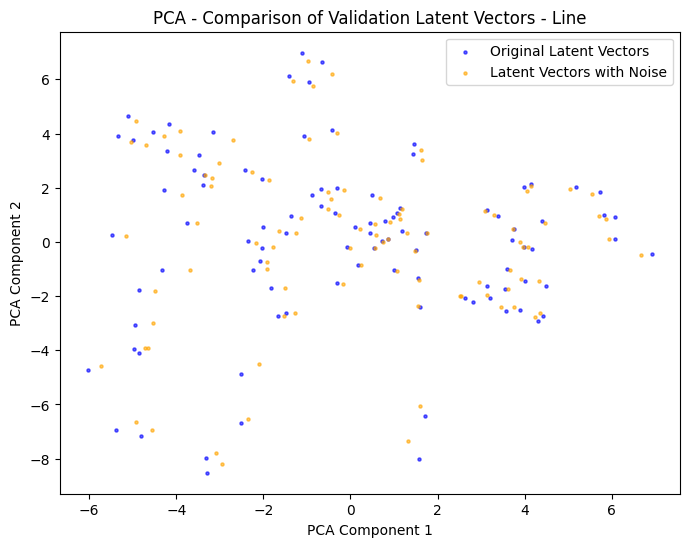

In [80]:
from sklearn.decomposition import PCA
# all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_noise], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_noise], axis=0)
all_val_latent_vectors = np.concatenate([best_val_latent_vectors_hausdorff, val_latent_vectors_noise], axis=0)

pca = PCA(n_components=2)
all_val_latent_vectors_pca = pca.fit_transform(all_val_latent_vectors)
all_val_latent_vectors_pca.shape

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_pca[:100, 0], all_val_latent_vectors_pca[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_pca[100:, 0], all_val_latent_vectors_pca[100:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('PCA - Comparison of Validation Latent Vectors - Line')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

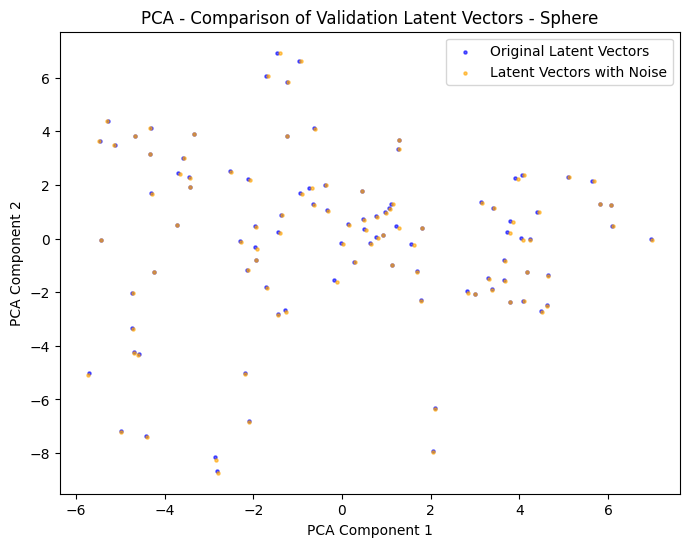

In [81]:
from sklearn.decomposition import PCA
# all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_sphere], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_sphere], axis=0)
all_val_latent_vectors = np.concatenate([best_val_latent_vectors_hausdorff, val_latent_vectors_sphere], axis=0)

pca = PCA(n_components=2)
all_val_latent_vectors_pca = pca.fit_transform(all_val_latent_vectors)
all_val_latent_vectors_pca.shape

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_pca[:100, 0], all_val_latent_vectors_pca[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_pca[100:, 0], all_val_latent_vectors_pca[100:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('PCA - Comparison of Validation Latent Vectors - Sphere')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

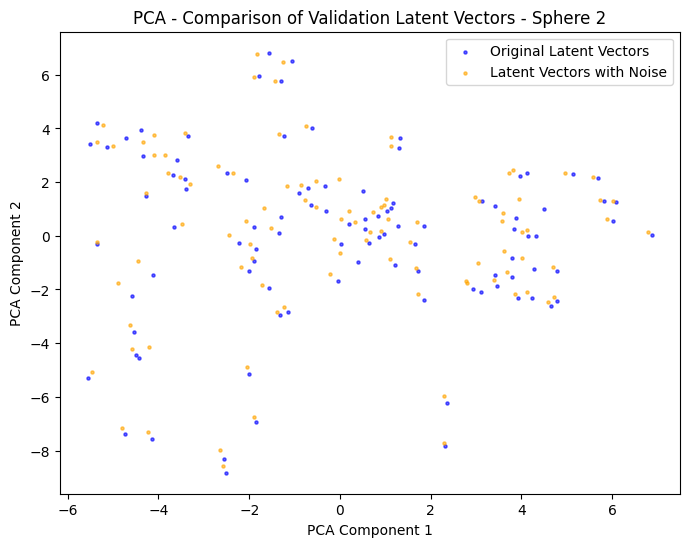

In [82]:
from sklearn.decomposition import PCA
# all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_sphere_2], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_sphere_2], axis=0)
all_val_latent_vectors = np.concatenate([best_val_latent_vectors_hausdorff, val_latent_vectors_sphere_2], axis=0)

pca = PCA(n_components=2)
all_val_latent_vectors_pca = pca.fit_transform(all_val_latent_vectors)
all_val_latent_vectors_pca.shape

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_pca[:100, 0], all_val_latent_vectors_pca[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_pca[100:, 0], all_val_latent_vectors_pca[100:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('PCA - Comparison of Validation Latent Vectors - Sphere 2')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

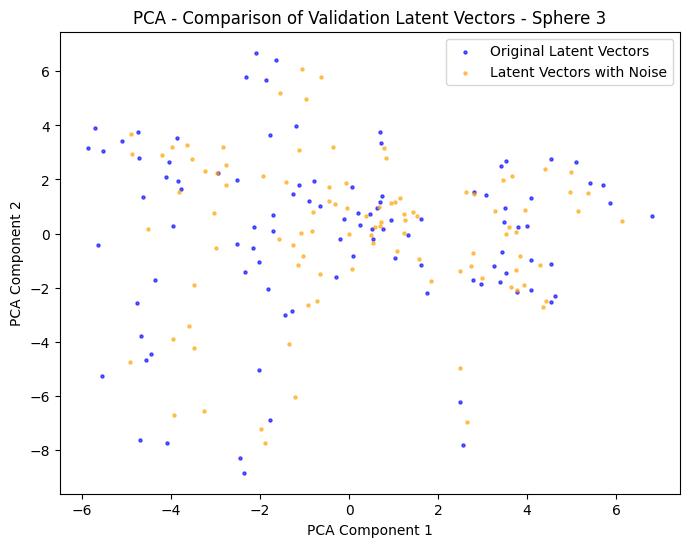

In [83]:
from sklearn.decomposition import PCA
# all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_sphere_3], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_sphere_3], axis=0)
all_val_latent_vectors = np.concatenate([best_val_latent_vectors_hausdorff, val_latent_vectors_sphere_3], axis=0)

pca = PCA(n_components=2)
all_val_latent_vectors_pca = pca.fit_transform(all_val_latent_vectors)
all_val_latent_vectors_pca.shape

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_pca[:100, 0], all_val_latent_vectors_pca[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_pca[100:, 0], all_val_latent_vectors_pca[100:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('PCA - Comparison of Validation Latent Vectors - Sphere 3')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

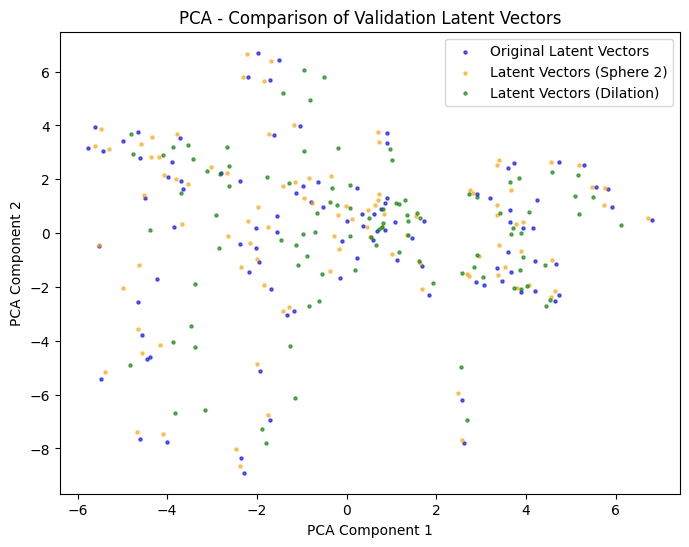

In [84]:
# PCA con 3 componentes (original, sphere_2 y sphere_3)

# all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_sphere_2, val_latent_vectors_sphere_3], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_sphere_2, val_latent_vectors_sphere_3], axis=0)
all_val_latent_vectors = np.concatenate([best_val_latent_vectors_hausdorff, val_latent_vectors_sphere_2, val_latent_vectors_sphere_3], axis=0)

pca = PCA(n_components=2)
all_val_latent_vectors_pca = pca.fit_transform(all_val_latent_vectors)
all_val_latent_vectors_pca.shape

# Graficar los resultados
plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_pca[:100, 0], all_val_latent_vectors_pca[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_pca[100:200, 0], all_val_latent_vectors_pca[100:200, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors (Sphere 2)')
plt.scatter(all_val_latent_vectors_pca[200:300, 0], all_val_latent_vectors_pca[200:300, 1], s=5, c='green', alpha=0.6, label='Latent Vectors (Dilation)')
plt.title('PCA - Comparison of Validation Latent Vectors')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

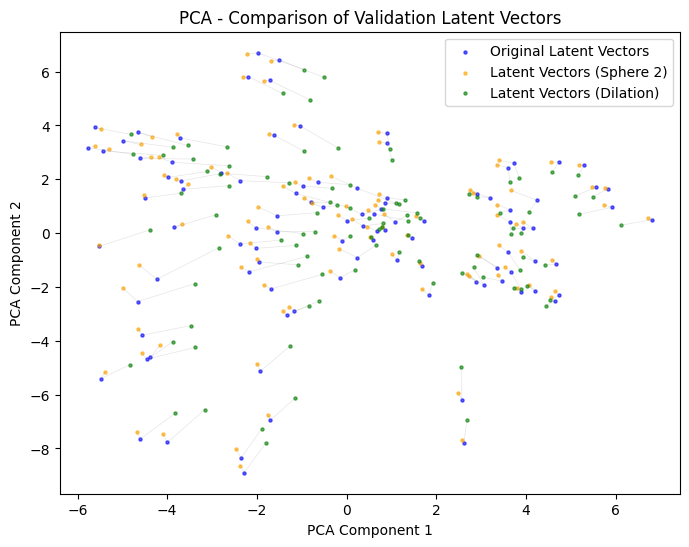

In [85]:
# Graficar los resultados
plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_pca[:100, 0], all_val_latent_vectors_pca[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_pca[100:200, 0], all_val_latent_vectors_pca[100:200, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors (Sphere 2)')
plt.scatter(all_val_latent_vectors_pca[200:300, 0], all_val_latent_vectors_pca[200:300, 1], s=5, c='green', alpha=0.6, label='Latent Vectors (Dilation)')
plt.title('PCA - Comparison of Validation Latent Vectors')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

for i in range(100):
    plt.plot([all_val_latent_vectors_pca[i, 0], all_val_latent_vectors_pca[i + 100, 0]], 
             [all_val_latent_vectors_pca[i, 1], all_val_latent_vectors_pca[i + 100, 1]], 
             c='gray', alpha=0.2, linewidth=0.5)
    plt.plot([all_val_latent_vectors_pca[i, 0], all_val_latent_vectors_pca[i + 200, 0]],
             [all_val_latent_vectors_pca[i, 1], all_val_latent_vectors_pca[i + 200, 1]],
              c='gray', alpha=0.2, linewidth=0.5)

plt.legend()
plt.show()

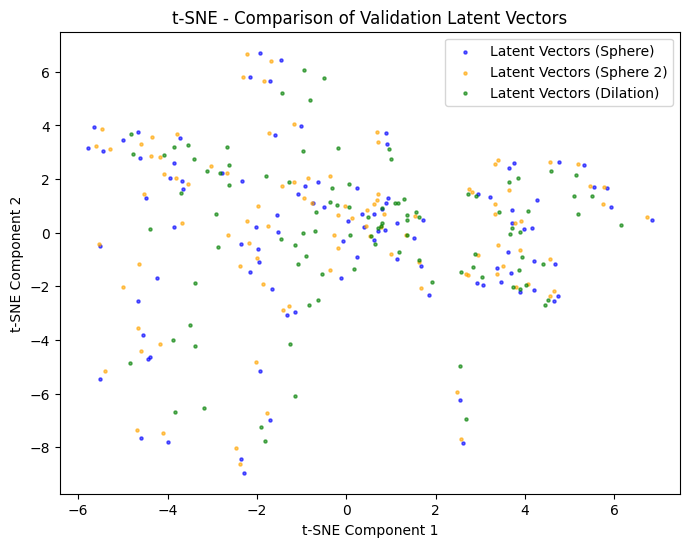

In [86]:
# t-sne con 3 componentes (sphere, sphere_2 y sphere_3)

all_val_latent_vectors = np.concatenate([val_latent_vectors_sphere, val_latent_vectors_sphere_2, val_latent_vectors_sphere_3], axis=0)

pca = PCA(n_components=2)
all_val_latent_vectors_pca = pca.fit_transform(all_val_latent_vectors)
all_val_latent_vectors_pca.shape

# Graficar los resultados
plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_pca[:100, 0], all_val_latent_vectors_pca[:100, 1], s=5, c='blue', alpha=0.6, label='Latent Vectors (Sphere)')
plt.scatter(all_val_latent_vectors_pca[100:200, 0], all_val_latent_vectors_pca[100:200, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors (Sphere 2)')
plt.scatter(all_val_latent_vectors_pca[200:300, 0], all_val_latent_vectors_pca[200:300, 1], s=5, c='green', alpha=0.6, label='Latent Vectors (Dilation)')
plt.title('t-SNE - Comparison of Validation Latent Vectors')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

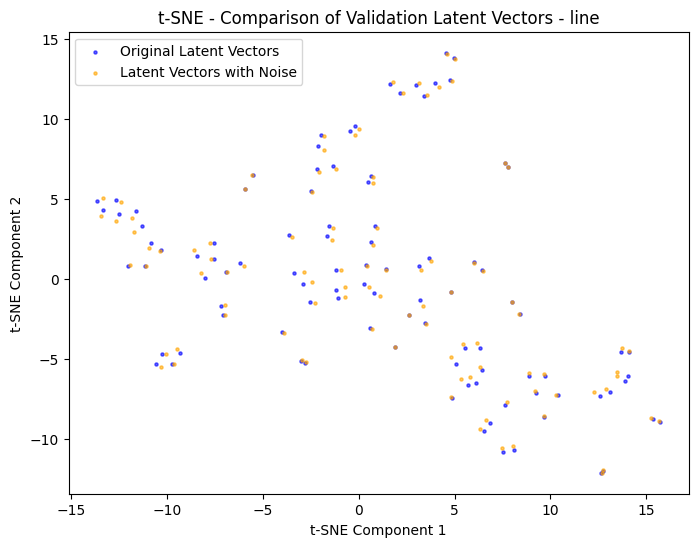

In [91]:
# t-sne
from sklearn.manifold import TSNE
# all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_noise], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_noise], axis=0)
all_val_latent_vectors = np.concatenate([best_val_latent_vectors_hausdorff, val_latent_vectors_noise], axis=0)

tsne = TSNE(n_components=2, random_state=42)
all_val_latent_vectors_tsne = tsne.fit_transform(all_val_latent_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_tsne[:100, 0], all_val_latent_vectors_tsne[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_tsne[100:, 0], all_val_latent_vectors_tsne[100:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('t-SNE - Comparison of Validation Latent Vectors - line')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

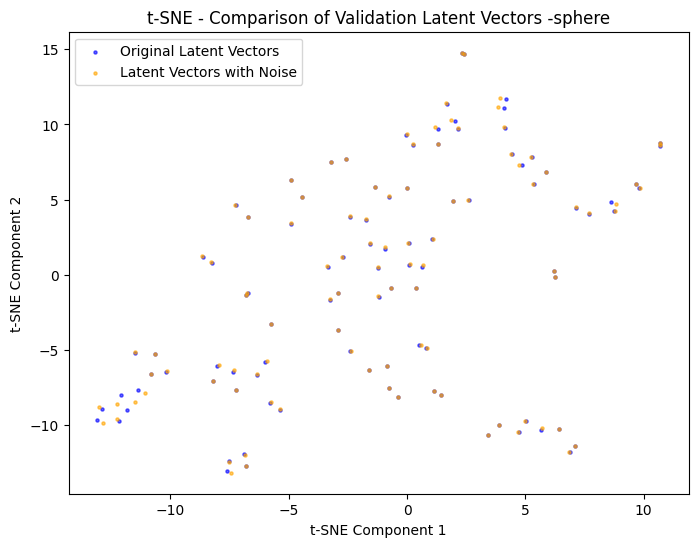

In [92]:
# t-sne
from sklearn.manifold import TSNE
# all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_sphere], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_sphere], axis=0)
all_val_latent_vectors = np.concatenate([best_val_latent_vectors_hausdorff, val_latent_vectors_sphere], axis=0)

tsne = TSNE(n_components=2, random_state=42)
all_val_latent_vectors_tsne = tsne.fit_transform(all_val_latent_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_tsne[:100, 0], all_val_latent_vectors_tsne[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_tsne[100:, 0], all_val_latent_vectors_tsne[100:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('t-SNE - Comparison of Validation Latent Vectors -sphere')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

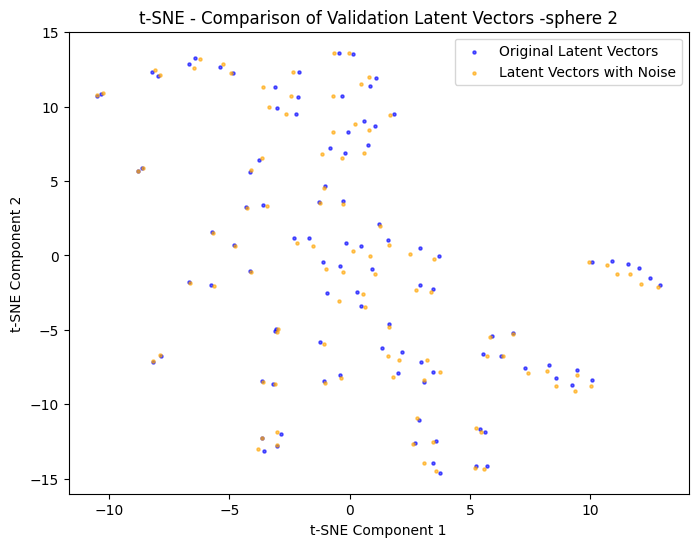

In [93]:
# t-sne
from sklearn.manifold import TSNE
# all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_sphere_2], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_sphere_2], axis=0)
all_val_latent_vectors = np.concatenate([best_val_latent_vectors_hausdorff, val_latent_vectors_sphere_2], axis=0)

tsne = TSNE(n_components=2, random_state=42)
all_val_latent_vectors_tsne = tsne.fit_transform(all_val_latent_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_tsne[:100, 0], all_val_latent_vectors_tsne[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_tsne[100:, 0], all_val_latent_vectors_tsne[100:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('t-SNE - Comparison of Validation Latent Vectors -sphere 2')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

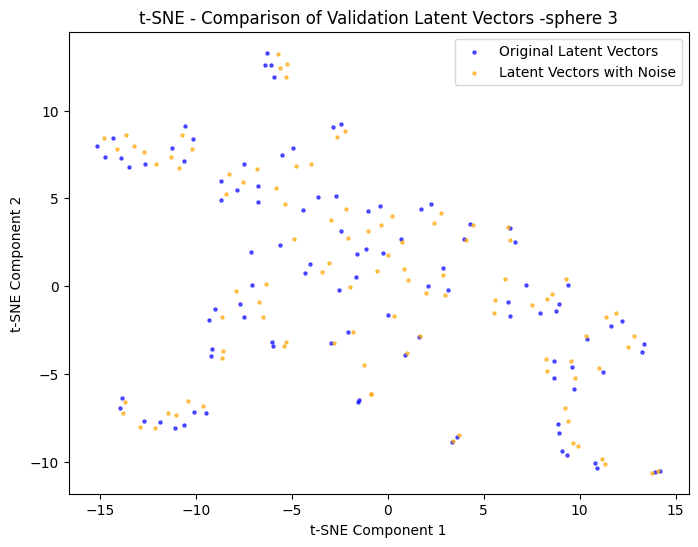

In [94]:
# t-sne
from sklearn.manifold import TSNE
# all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_sphere_3], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_sphere_3], axis=0)
all_val_latent_vectors = np.concatenate([best_val_latent_vectors_hausdorff, val_latent_vectors_sphere_3], axis=0)

tsne = TSNE(n_components=2, random_state=42)
all_val_latent_vectors_tsne = tsne.fit_transform(all_val_latent_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_tsne[:100, 0], all_val_latent_vectors_tsne[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_tsne[100:, 0], all_val_latent_vectors_tsne[100:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('t-SNE - Comparison of Validation Latent Vectors -sphere 3')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

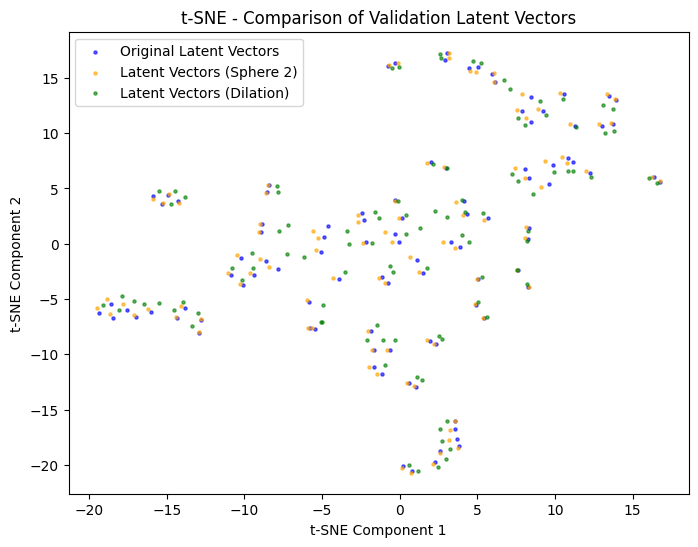

In [95]:
# t-sne con 3 componentes (original, sphere_2 y sphere_3)

from sklearn.manifold import TSNE

# all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_sphere_2, val_latent_vectors_sphere_3], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_sphere_2, val_latent_vectors_sphere_3], axis=0)
all_val_latent_vectors = np.concatenate([best_val_latent_vectors_hausdorff, val_latent_vectors_sphere_2, val_latent_vectors_sphere_3], axis=0)

tsne = TSNE(n_components=2, random_state=42)
all_val_latent_vectors_tsne = tsne.fit_transform(all_val_latent_vectors)

# Graficar los resultados
plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_tsne[:100, 0], all_val_latent_vectors_tsne[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_tsne[100:200, 0], all_val_latent_vectors_tsne[100:200, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors (Sphere 2)')
plt.scatter(all_val_latent_vectors_tsne[200:300, 0], all_val_latent_vectors_tsne[200:300, 1], s=5, c='green', alpha=0.6, label='Latent Vectors (Dilation)')
plt.title('t-SNE - Comparison of Validation Latent Vectors')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

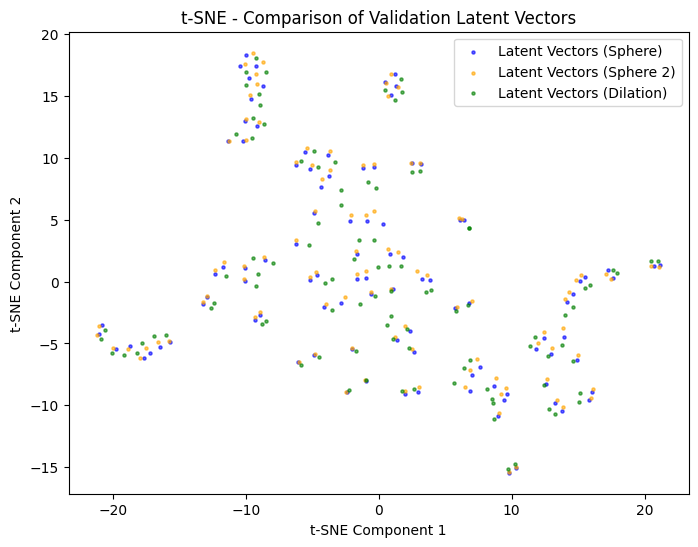

In [96]:
# t-sne con 3 componentes (sphere, sphere_2 y sphere_3)

from sklearn.manifold import TSNE
all_val_latent_vectors = np.concatenate([val_latent_vectors_sphere, val_latent_vectors_sphere_2, val_latent_vectors_sphere_3], axis=0)

tsne = TSNE(n_components=2, random_state=42)
all_val_latent_vectors_tsne = tsne.fit_transform(all_val_latent_vectors)

# Graficar los resultados
plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_tsne[:100, 0], all_val_latent_vectors_tsne[:100, 1], s=5, c='blue', alpha=0.6, label='Latent Vectors (Sphere)')
plt.scatter(all_val_latent_vectors_tsne[100:200, 0], all_val_latent_vectors_tsne[100:200, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors (Sphere 2)')
plt.scatter(all_val_latent_vectors_tsne[200:300, 0], all_val_latent_vectors_tsne[200:300, 1], s=5, c='green', alpha=0.6, label='Latent Vectors (Dilation)')
plt.title('t-SNE - Comparison of Validation Latent Vectors')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


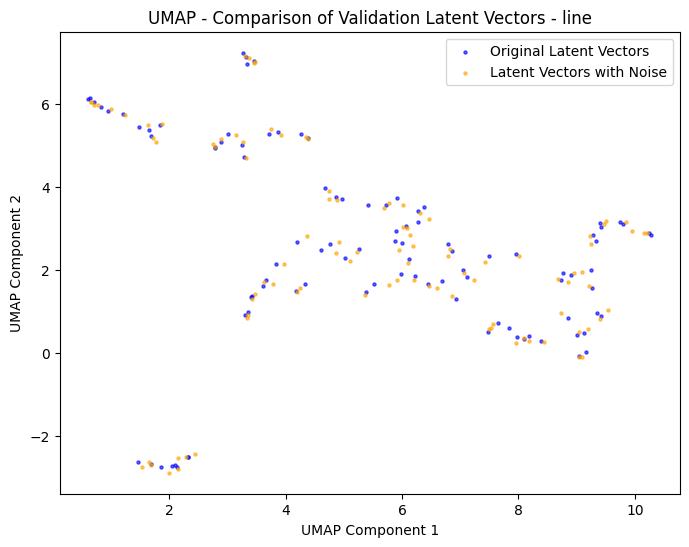

In [97]:
# UMAP
import umap
# all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_noise], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_noise], axis=0)
all_val_latent_vectors = np.concatenate([best_val_latent_vectors_hausdorff, val_latent_vectors_noise], axis=0)

umap_reducer = umap.UMAP(n_components=2, random_state=42)
all_val_latent_vectors_umap = umap_reducer.fit_transform(all_val_latent_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_umap[:100, 0], all_val_latent_vectors_umap[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_umap[100:, 0], all_val_latent_vectors_umap[100:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('UMAP - Comparison of Validation Latent Vectors - line')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


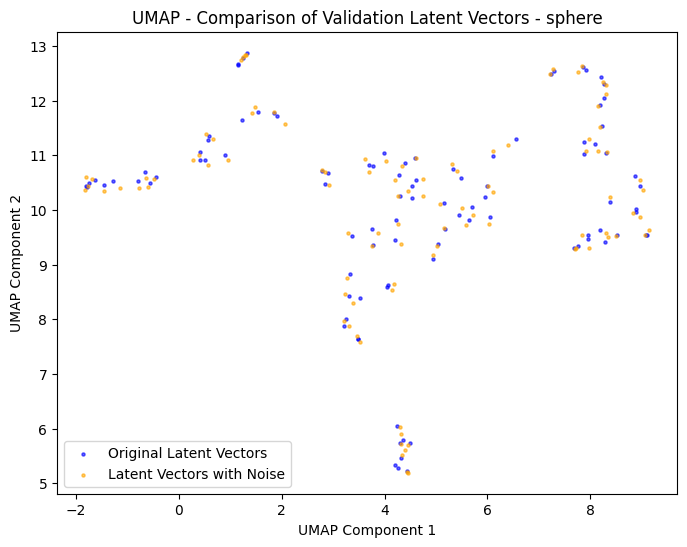

In [98]:
# UMAP
import umap
# all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_sphere], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_sphere], axis=0)
all_val_latent_vectors = np.concatenate([best_val_latent_vectors_hausdorff, val_latent_vectors_sphere], axis=0)

umap_reducer = umap.UMAP(n_components=2, random_state=42)
all_val_latent_vectors_umap = umap_reducer.fit_transform(all_val_latent_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_umap[:100, 0], all_val_latent_vectors_umap[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_umap[100:, 0], all_val_latent_vectors_umap[100:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('UMAP - Comparison of Validation Latent Vectors - sphere')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


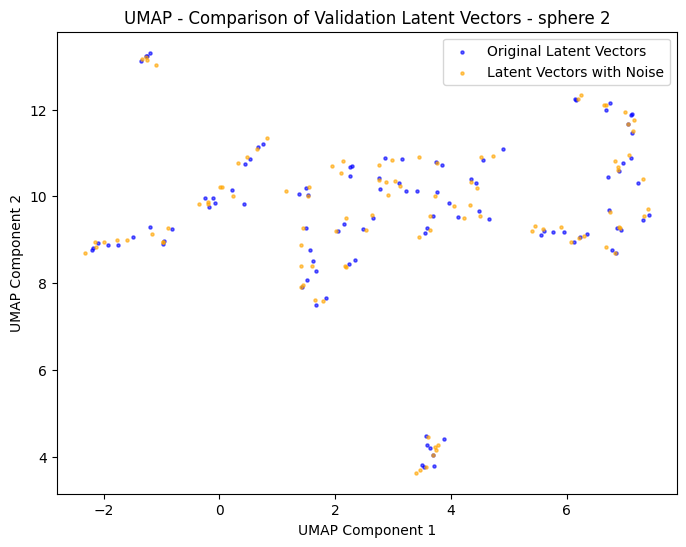

In [99]:
# Usando UMAP
import umap
# all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_sphere_2], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_sphere_2], axis=0)
all_val_latent_vectors = np.concatenate([best_val_latent_vectors_hausdorff, val_latent_vectors_sphere_2], axis=0)

umap_reducer = umap.UMAP(n_components=2, random_state=42)
all_val_latent_vectors_umap = umap_reducer.fit_transform(all_val_latent_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_umap[:100, 0], all_val_latent_vectors_umap[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_umap[100:, 0], all_val_latent_vectors_umap[100:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('UMAP - Comparison of Validation Latent Vectors - sphere 2')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


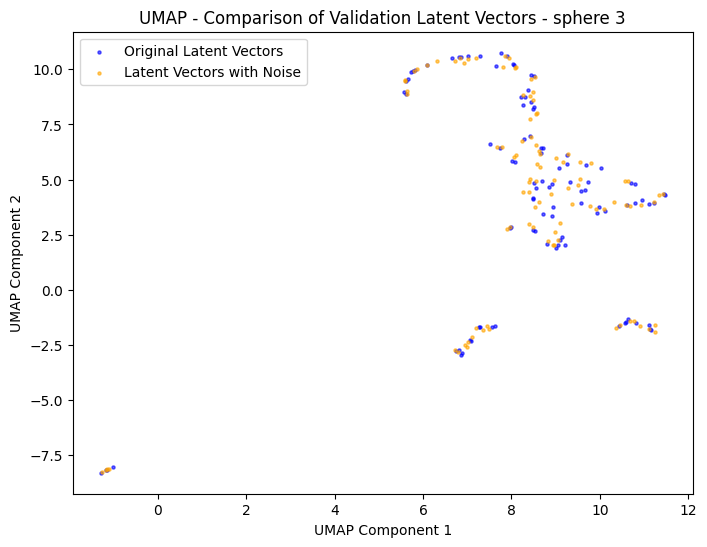

In [100]:
# Usando UMAP
import umap
# all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_sphere_3], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_sphere_3], axis=0)
all_val_latent_vectors = np.concatenate([best_val_latent_vectors_hausdorff, val_latent_vectors_sphere_3], axis=0)

umap_reducer = umap.UMAP(n_components=2, random_state=42)
all_val_latent_vectors_umap = umap_reducer.fit_transform(all_val_latent_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_umap[:100, 0], all_val_latent_vectors_umap[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_umap[100:, 0], all_val_latent_vectors_umap[100:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('UMAP - Comparison of Validation Latent Vectors - sphere 3')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


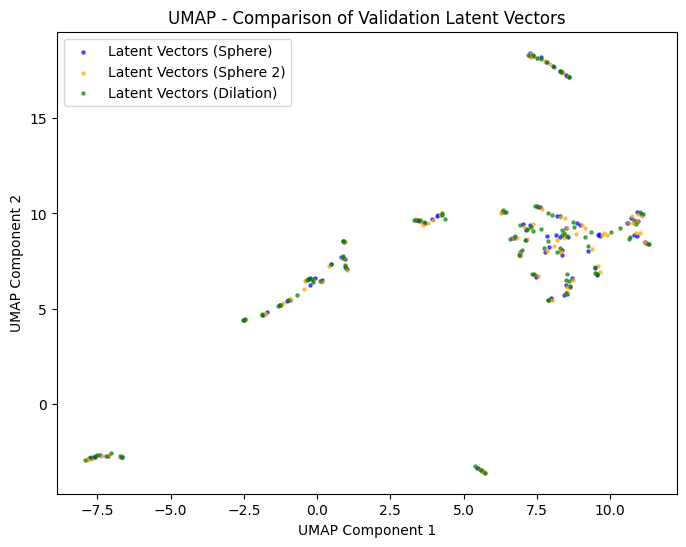

In [101]:
# umap con 3 componentes (sphere, sphere_2 y sphere_3)

from sklearn.manifold import TSNE
all_val_latent_vectors = np.concatenate([val_latent_vectors_sphere, val_latent_vectors_sphere_2, val_latent_vectors_sphere_3], axis=0)

umap_reducer = umap.UMAP(n_components=2, random_state=42)
all_val_latent_vectors_umap = umap_reducer.fit_transform(all_val_latent_vectors)

# Graficar los resultados
plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_umap[:100, 0], all_val_latent_vectors_umap[:100, 1], s=5, c='blue', alpha=0.6, label='Latent Vectors (Sphere)')
plt.scatter(all_val_latent_vectors_umap[100:200, 0], all_val_latent_vectors_umap[100:200, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors (Sphere 2)')
plt.scatter(all_val_latent_vectors_umap[200:300, 0], all_val_latent_vectors_umap[200:300, 1], s=5, c='green', alpha=0.6, label='Latent Vectors (Dilation)')
plt.title('UMAP - Comparison of Validation Latent Vectors')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


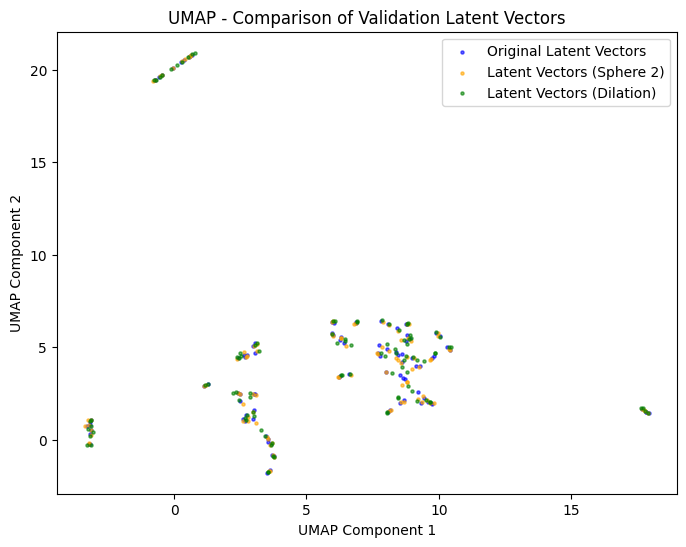

In [102]:
# umap con 3 componentes (original, sphere_2 y sphere_3)

from sklearn.manifold import TSNE
# all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_sphere_2, val_latent_vectors_sphere_3], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_sphere_2, val_latent_vectors_sphere_3], axis=0)
all_val_latent_vectors = np.concatenate([best_val_latent_vectors_hausdorff, val_latent_vectors_sphere_2, val_latent_vectors_sphere_3], axis=0)

umap_reducer = umap.UMAP(n_components=2, random_state=42)
all_val_latent_vectors_umap = umap_reducer.fit_transform(all_val_latent_vectors)

# Graficar los resultados
plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_umap[:100, 0], all_val_latent_vectors_umap[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_umap[100:200, 0], all_val_latent_vectors_umap[100:200, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors (Sphere 2)')
plt.scatter(all_val_latent_vectors_umap[200:300, 0], all_val_latent_vectors_umap[200:300, 1], s=5, c='green', alpha=0.6, label='Latent Vectors (Dilation)')
plt.title('UMAP - Comparison of Validation Latent Vectors')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()

EUCLIDEAN DISTANCE

In [103]:
# Euclidean distances between the latent vectors of the last epoch and the latent vectors with noise

print(f"Validation Latent Vector Shape: {last_val_latent_vectors.shape}")
print(f"Validation Latent Vector Shape Noise: {val_latent_vectors_noise.shape}")

print(last_val_latent_vectors[0].shape)
print(val_latent_vectors_noise[0].shape)

assert last_val_latent_vectors.shape == val_latent_vectors_noise.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_noise, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Noise: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [0.43948957 0.41643342 0.24379165 0.37814212 0.38594696 0.3790076
 0.94614357 0.5555794  0.48915336 0.48690674 0.3499005  0.53807396
 0.2684075  0.34614566 0.44754833 0.30331978 0.53340465 0.3322705
 0.5818781  0.28159955 0.9928128  1.0169243  0.44787312 0.35815984
 0.580306   0.5760143  0.6685874  1.2065461  0.58959794 0.36817035
 0.4148551  0.42703763 0.8138198  0.5116318  0.54622275 0.38943326
 0.5204637  0.538577   0.3549031  0.35153234 0.52605045 0.25049436
 0.49295887 0.83731693 0.5413447  0.3958074  0.59532857 0.23389311
 0.47451043 0.28528872 0.23238435 0.2603864  0.3154049  0.7606822
 0.36839873 0.45132363 0.34866875 0.69542706 0.6711376  0.6481645
 0.5000527  0.3375691  0.4206885  0.431439   0.3952108  0.63198775
 0.427686   0.2923467  0.5622658  0.5500882  0.54883873 0.5156389
 0.6601916  0.47465006 0.4551021  0.6501045  1.1063159  0.60307896
 0.04259

In [104]:
# Euclidean distances between the latent vectors of the last epoch and the latent vectors with sphere

print(f"Validation Latent Vector Shape: {last_val_latent_vectors.shape}")
print(f"Validation Latent Vector Shape Sphere: {val_latent_vectors_sphere.shape}")

print(last_val_latent_vectors[0].shape)
print(val_latent_vectors_sphere[0].shape)

assert last_val_latent_vectors.shape == val_latent_vectors_sphere.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_sphere, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Sphere: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [0.08326782 0.06360051 0.2999247  0.14881378 0.08131905 0.03663826
 0.13623002 0.00577089 0.10487238 0.02507742 0.11875958 0.11127363
 0.1606158  0.12652718 0.06883207 0.04362973 0.14585419 0.14216815
 0.06503748 0.06896265 0.08128204 0.         0.08357073 0.05331871
 0.13874623 0.11270554 0.04134597 0.         0.12028645 0.0568017
 0.06597941 0.03554601 0.08547935 0.07531605 0.11229745 0.07302816
 0.07224634 0.02857706 0.03765342 0.03794963 0.17682417 0.07330156
 0.15172608 0.12601785 0.05387968 0.02729918 0.03078917 0.00532361
 0.06773782 0.04192924 0.11850097 0.08603912 0.10985351 0.07589204
 0.13351914 0.09111153 0.07552636 0.0357698  0.05626347 0.01564584
 0.11590609 0.10669155 0.09756754 0.10218568 0.07761277 0.06755068
 0.07702351 0.0608164  0.10084645 0.08474787 0.08211653 0.05380937
 0.13570136 0.19199872 0.10143825 0.03249933 0.13172449 0.072141
 0.12

In [105]:
# Euclidean distances between the latent vectors of the last epoch and the latent vectors with sphere 2

print(f"Validation Latent Vector Shape: {last_val_latent_vectors.shape}")
print(f"Validation Latent Vector Shape Sphere 2: {val_latent_vectors_sphere_2.shape}")

print(last_val_latent_vectors[0].shape)
print(val_latent_vectors_sphere_2[0].shape)

assert last_val_latent_vectors.shape == val_latent_vectors_sphere_2.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_sphere_2, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Sphere 2: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [0.34238914 0.39887387 0.4908917  1.0941299  0.74500597 0.7143453
 0.7034985  1.2958732  0.40347558 0.5798     0.32524392 0.39816868
 0.38959846 0.63483834 0.23708123 0.48185536 0.5821073  1.0168253
 0.29154179 0.5713547  0.74584216 0.84413284 0.2984299  0.5880831
 0.50178653 0.64401346 0.96568155 1.0550451  0.2919499  0.38072294
 0.3387736  0.5682123  0.46318743 0.5115609  0.47937626 0.567585
 0.41006404 0.42062205 0.24979696 0.29108334 0.654003   1.1469358
 0.60325116 0.55133027 0.46461585 0.9309979  0.26893532 0.3140493
 0.30624434 0.5291983  0.2488136  0.4935477  0.33656564 0.4634996
 0.3891858  0.7778189  0.32154313 0.500171   0.33707908 0.3788394
 0.3370269  0.34319925 0.3200435  0.34833258 0.4019711  0.37576964
 0.4920267  0.8195961  0.37394634 0.4639619  0.22357728 0.38303444
 0.5045113  0.5774251  0.6915405  1.0108279  0.33635238 0.61587137
 0.263011

In [106]:
# Euclidean distances between the latent vectors of the last epoch and the latent vectors with sphere 3

print(f"Validation Latent Vector Shape: {last_val_latent_vectors.shape}")
print(f"Validation Latent Vector Shape Sphere 3: {val_latent_vectors_sphere_3.shape}")

print(last_val_latent_vectors[0].shape)
print(val_latent_vectors_sphere_3[0].shape)

assert last_val_latent_vectors.shape == val_latent_vectors_sphere_3.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_sphere_3, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Sphere 3: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [0.9848072  1.044362   0.85768044 1.113179   1.5177553  1.3356622
 2.2555704  1.9180748  1.2470312  1.210819   1.0985373  1.2243459
 0.903686   1.1239026  1.5840548  1.2910084  1.7650595  1.8444234
 1.0604511  1.3454523  1.5937213  1.3256961  1.298287   1.3347547
 1.756093   1.8288155  1.7499337  2.1900601  1.1591077  1.2121994
 1.6095833  1.4094583  1.6770192  2.0659685  1.6299198  1.6846577
 0.75357246 0.9522776  1.5104747  2.073876   1.3165007  1.7220237
 1.5618194  1.5302824  1.2543974  1.4175813  1.12256    1.485981
 0.82483727 1.130173   0.6391862  0.7579349  1.3331218  1.5078386
 1.0890461  1.5738475  1.3300868  1.4425263  1.8205998  1.8635204
 1.2595427  1.3999224  1.84131    1.9589665  1.486312   1.4463917
 1.3322232  1.4221889  1.5247625  1.4266746  1.3392141  1.3432442
 1.4726642  1.4238356  1.4049046  1.3264289  1.2269878  1.9017738
 0.61992276 1.

In [107]:
# Euclidean distance between the latent vectors of the last epoch and the latent vectors with elongation

print(f"Validation Latent Vector Shape: {last_val_latent_vectors.shape}")
print(f"Validation Latent Vector Shape Elongated: {val_latent_vectors_elongated.shape}")

print(last_val_latent_vectors[0].shape)
print(val_latent_vectors_elongated[0].shape)

assert last_val_latent_vectors.shape == val_latent_vectors_elongated.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_elongated, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Elongated: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [0.31549606 0.3110446  0.26611406 0.21301574 0.33305907 0.37697458
 0.4548354  0.3977309  0.32358244 0.31675407 0.28144503 0.29135522
 0.36854133 0.2624367  0.3862072  0.33893982 0.3969568  0.38600764
 0.3676421  0.35401708 0.37047204 0.31547987 0.38079676 0.34290317
 0.49790516 0.4926087  0.4506915  0.45440266 0.4327432  0.34094197
 0.44960555 0.3939146  0.5052938  0.47092396 0.3642467  0.37734428
 0.35958326 0.34917387 0.34441856 0.36184496 0.37123334 0.30239627
 0.43219197 0.43079954 0.3665569  0.43217847 0.3387373  0.35669222
 0.29657444 0.2571694  0.30300835 0.24253918 0.42439654 0.41283873
 0.40694657 0.3868658  0.41782972 0.33397496 0.3964674  0.3916527
 0.39285055 0.36438894 0.42297515 0.401826   0.3877397  0.38043326
 0.24001619 0.1674142  0.21688464 0.22123665 0.38634175 0.37502465
 0.3185388  0.27140763 0.28873262 0.3116344  0.4349544  0.45375904


In [108]:

import seaborn as sns
import pandas as pd



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



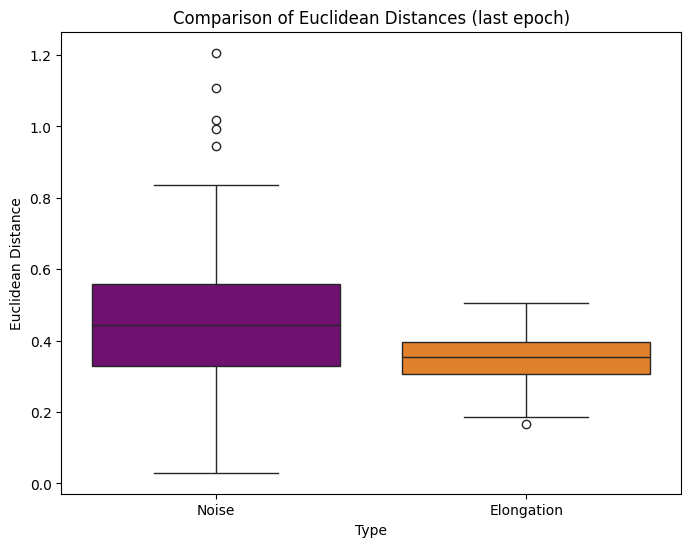

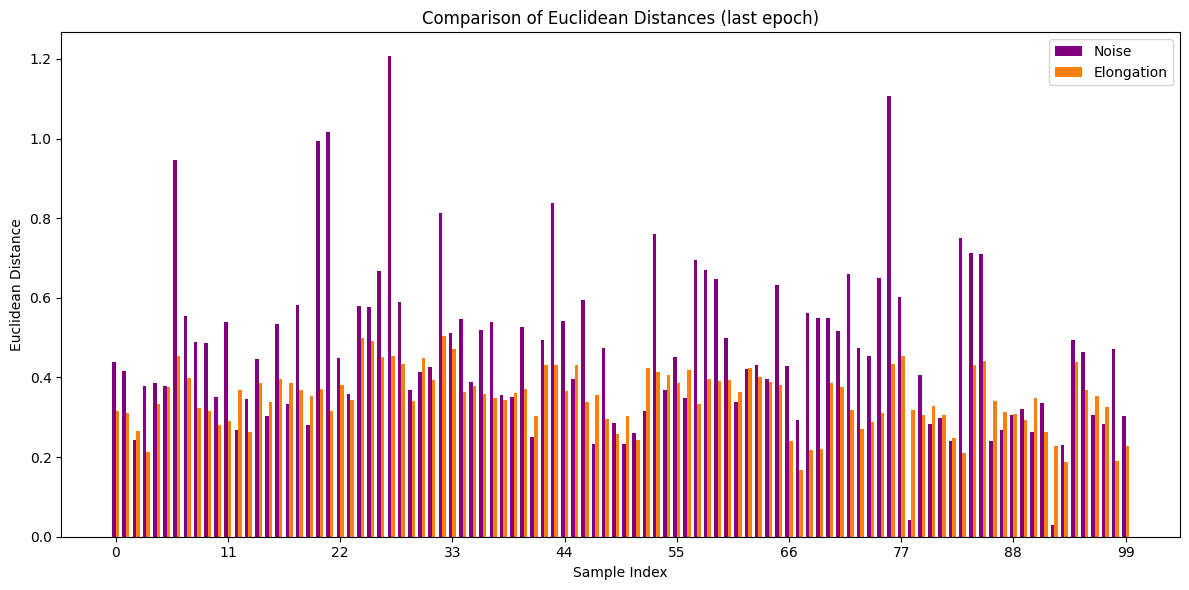

In [109]:
euclidean_distances_noise = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_noise, axis=1)
euclidean_distances_elongated = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_elongated, axis=1)

df = pd.DataFrame({
    'Distance': list(euclidean_distances_noise) + list(euclidean_distances_elongated),
    'Type': ['Noise'] * len(euclidean_distances_noise) + ['Elongation'] * len(euclidean_distances_elongated)
})

palette = {"Noise": "#800080", "Elongation": "#ff7f0e"}

plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Distance', data=df, palette=palette)
plt.title("Comparison of Euclidean Distances (last epoch)")
plt.ylabel("Euclidean Distance")
plt.show()

x = np.arange(len(euclidean_distances_noise))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, euclidean_distances_noise, width, label='Noise', color=palette['Noise'])
rects2 = ax.bar(x + width/2, euclidean_distances_elongated, width, label='Elongation', color=palette['Elongation'])
ax.set_xlabel('Sample Index')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Comparison of Euclidean Distances (last epoch)')
ax.legend()
ax.set_xticks(np.linspace(0, len(x) - 1, num=10, dtype=int))  
ax.set_xticklabels(np.linspace(0, len(x) - 1, num=10, dtype=int))
plt.tight_layout()
plt.show()

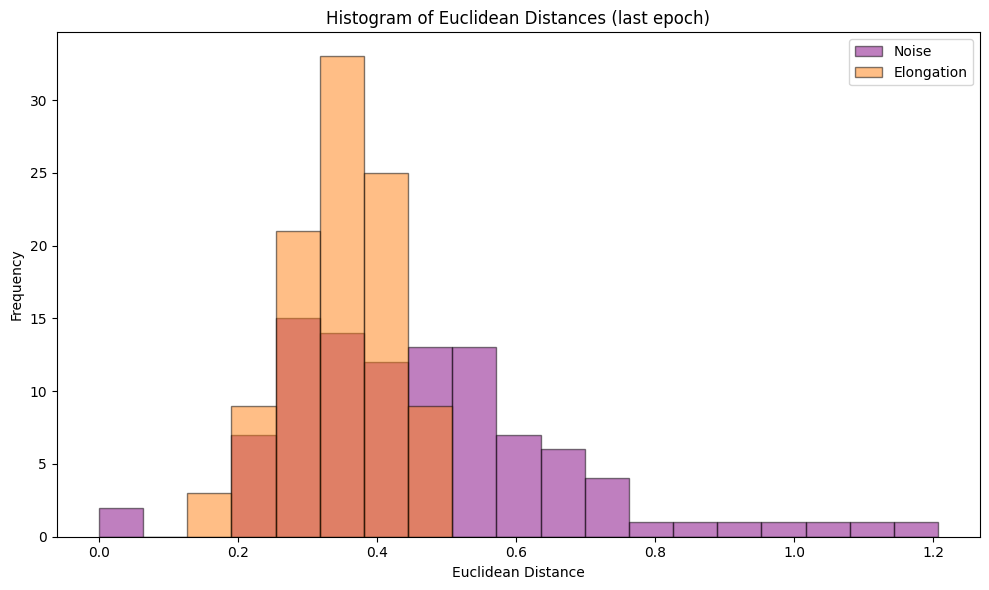

In [110]:
bins = np.linspace(0, max(np.max(euclidean_distances_noise), np.max(euclidean_distances_elongated)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_noise, bins=bins, alpha=0.5, label='Noise', color='#800080', edgecolor='black')
plt.hist(euclidean_distances_elongated, bins=bins, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black')
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances (last epoch)')
plt.legend()
plt.tight_layout()
plt.show()

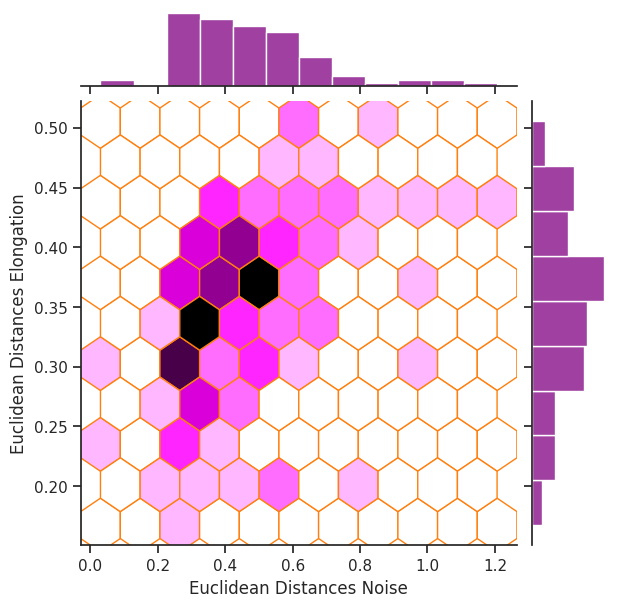

In [111]:
x = euclidean_distances_noise
y = euclidean_distances_elongated

sns.set_theme(style="ticks")
g = sns.jointplot(x=x, y=y, kind="hex", color="#800080") 
g.ax_joint.collections[0].set_edgecolor("#ff7f0e")
plt.xlabel('Euclidean Distances Noise')
plt.ylabel('Euclidean Distances Elongation')
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



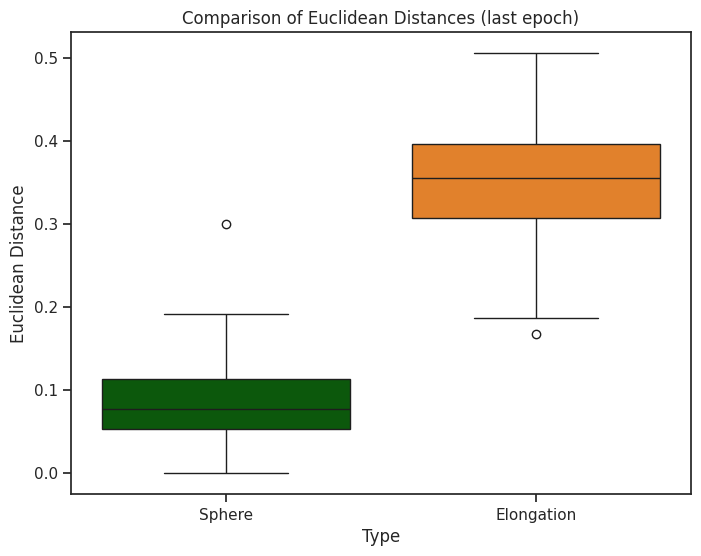

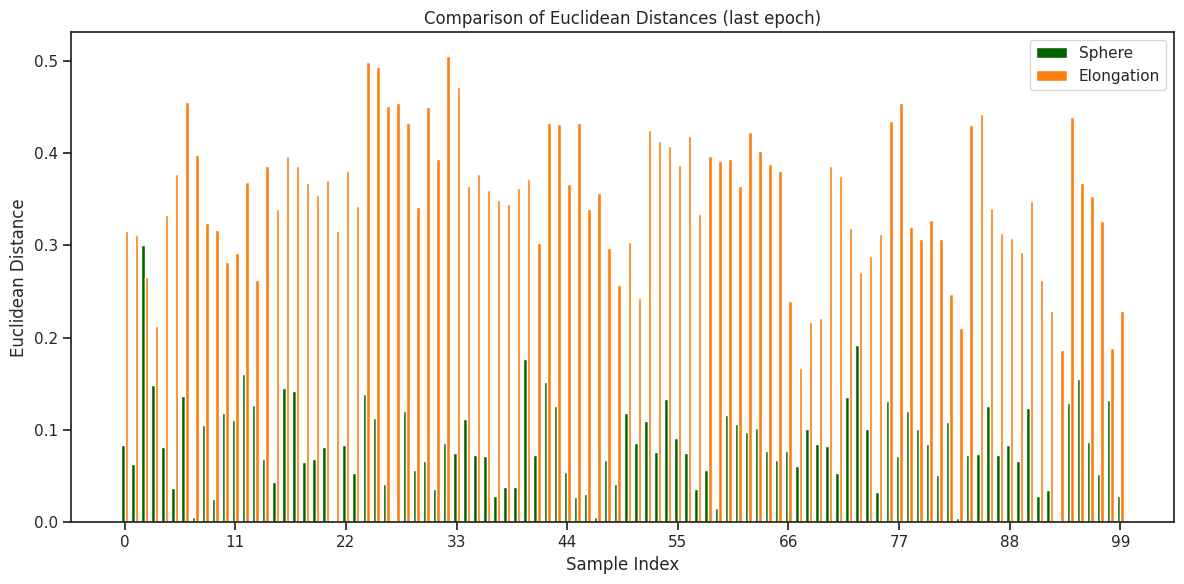

In [112]:
euclidean_distances_sphere = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_sphere, axis=1)
euclidean_distances_elongated = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_elongated, axis=1)

df = pd.DataFrame({
    'Distance': list(euclidean_distances_sphere) + list(euclidean_distances_elongated),
    'Type': ['Sphere'] * len(euclidean_distances_sphere) + ['Elongation'] * len(euclidean_distances_elongated)
})

palette = {"Sphere": "#006400", "Elongation": "#ff7f0e"}

plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Distance', data=df, palette=palette)
plt.title("Comparison of Euclidean Distances (last epoch)")
plt.ylabel("Euclidean Distance")
plt.show()

x = np.arange(len(euclidean_distances_sphere))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, euclidean_distances_sphere, width, label='Sphere', color=palette['Sphere'])
rects2 = ax.bar(x + width/2, euclidean_distances_elongated, width, label='Elongation', color=palette['Elongation'])
ax.set_xlabel('Sample Index')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Comparison of Euclidean Distances (last epoch)')
ax.legend()
ax.set_xticks(np.linspace(0, len(x) - 1, num=10, dtype=int))  
ax.set_xticklabels(np.linspace(0, len(x) - 1, num=10, dtype=int))
plt.tight_layout()
plt.show()

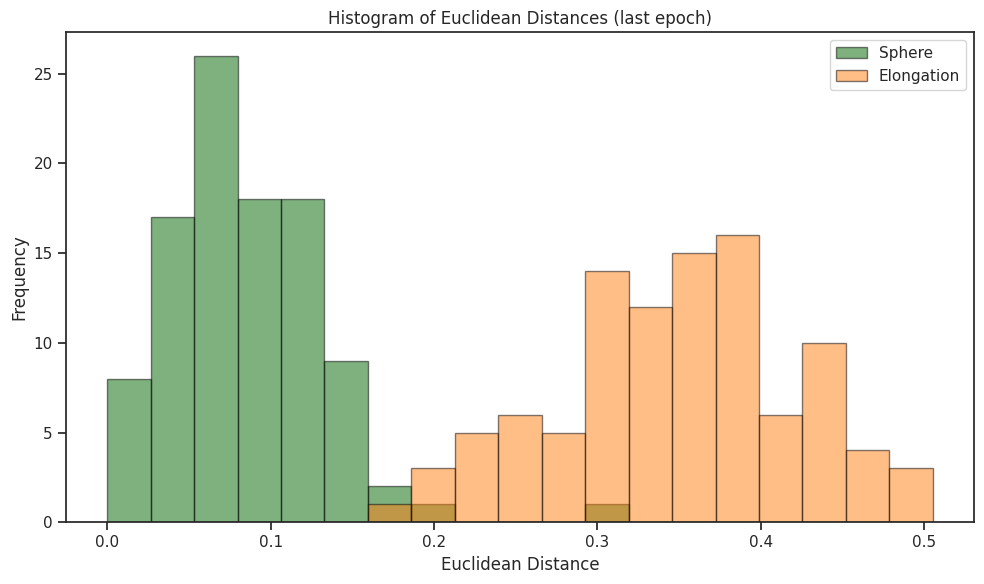

In [113]:
bins = np.linspace(0, max(np.max(euclidean_distances_sphere), np.max(euclidean_distances_elongated)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_sphere, bins=bins, alpha=0.5, label='Sphere', color='#006400', edgecolor='black')  # Morado
plt.hist(euclidean_distances_elongated, bins=bins, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black')  # Naranja
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances (last epoch)')
plt.legend()
plt.tight_layout()
plt.show()

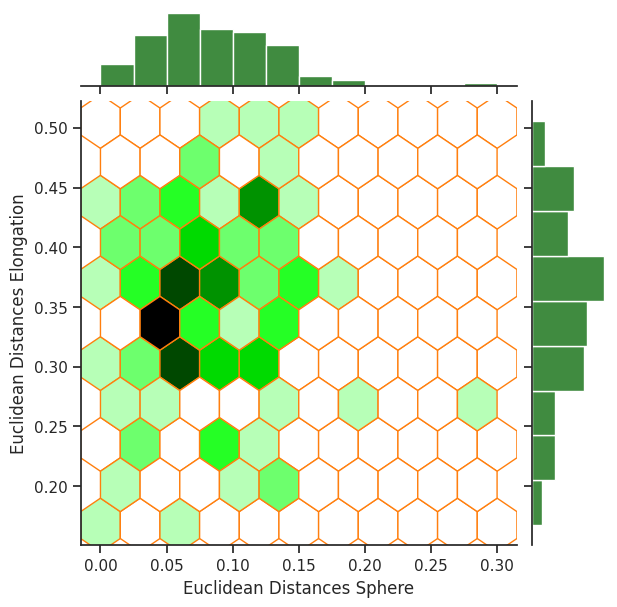

In [114]:
x = euclidean_distances_sphere
y = euclidean_distances_elongated

sns.set_theme(style="ticks")

# Crear el gráfico conjunto con colores específicos
g = sns.jointplot(x=x, y=y, kind="hex", color="#006400") 
g.ax_joint.collections[0].set_edgecolor("#ff7f0e")

plt.xlabel('Euclidean Distances Sphere')
plt.ylabel('Euclidean Distances Elongation')
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



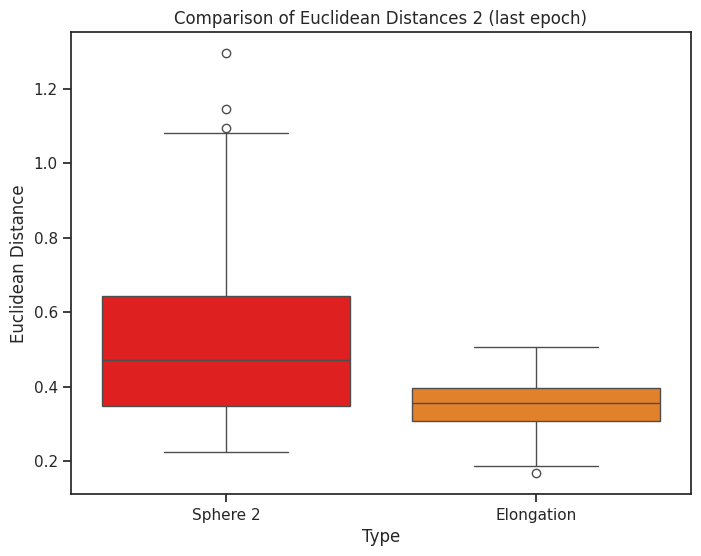

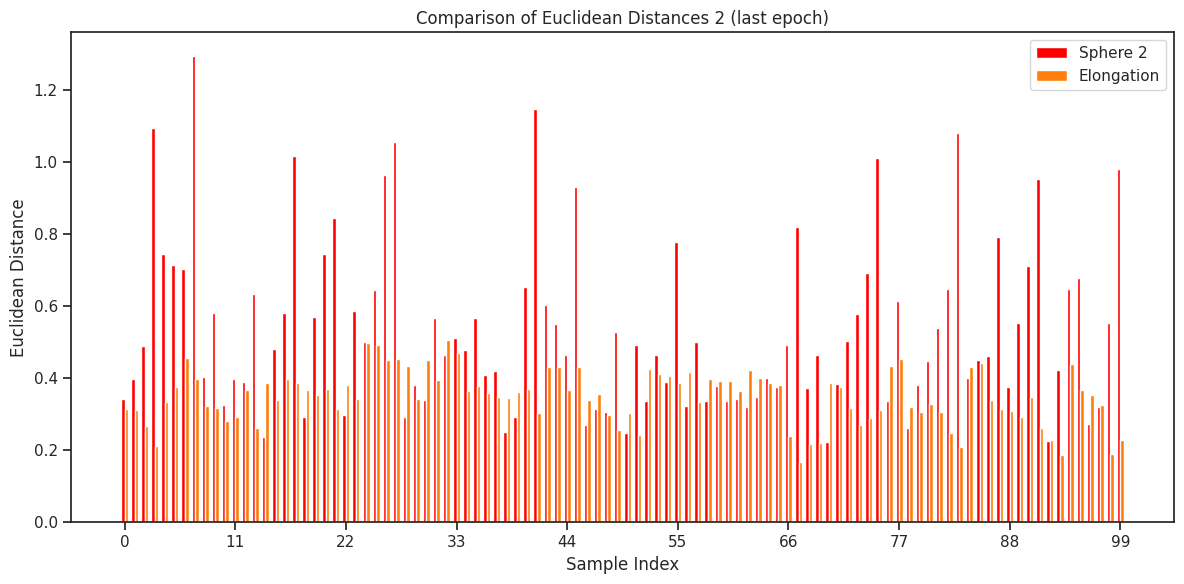

In [115]:
euclidean_distances_sphere_2 = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_sphere_2, axis=1)
euclidean_distances_elongated = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_elongated, axis=1)

df = pd.DataFrame({
    'Distance': list(euclidean_distances_sphere_2) + list(euclidean_distances_elongated),
    'Type': ['Sphere 2'] * len(euclidean_distances_sphere_2) + ['Elongation'] * len(euclidean_distances_elongated)
})

palette = {"Sphere 2": "#FF0000", "Elongation": "#ff7f0e"}

plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Distance', data=df, palette=palette)
plt.title("Comparison of Euclidean Distances 2 (last epoch)")
plt.ylabel("Euclidean Distance")
plt.show()

x = np.arange(len(euclidean_distances_sphere_2))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, euclidean_distances_sphere_2, width, label='Sphere 2', color=palette['Sphere 2'])
rects2 = ax.bar(x + width/2, euclidean_distances_elongated, width, label='Elongation', color=palette['Elongation'])
ax.set_xlabel('Sample Index')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Comparison of Euclidean Distances 2 (last epoch)')
ax.legend()
ax.set_xticks(np.linspace(0, len(x) - 1, num=10, dtype=int))  
ax.set_xticklabels(np.linspace(0, len(x) - 1, num=10, dtype=int))
plt.tight_layout()
plt.show()

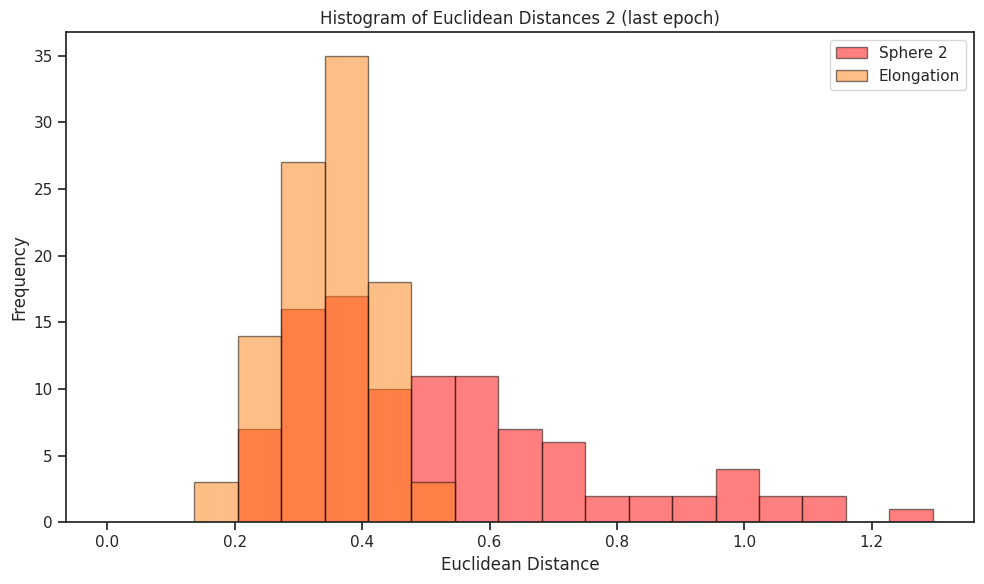

In [116]:
bins = np.linspace(0, max(np.max(euclidean_distances_sphere_2), np.max(euclidean_distances_elongated)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_sphere_2, bins=bins, alpha=0.5, label='Sphere 2', color='#FF0000', edgecolor='black')  # Morado
plt.hist(euclidean_distances_elongated, bins=bins, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black')  # Naranja
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances 2 (last epoch)')
plt.legend()
plt.tight_layout()
plt.show()

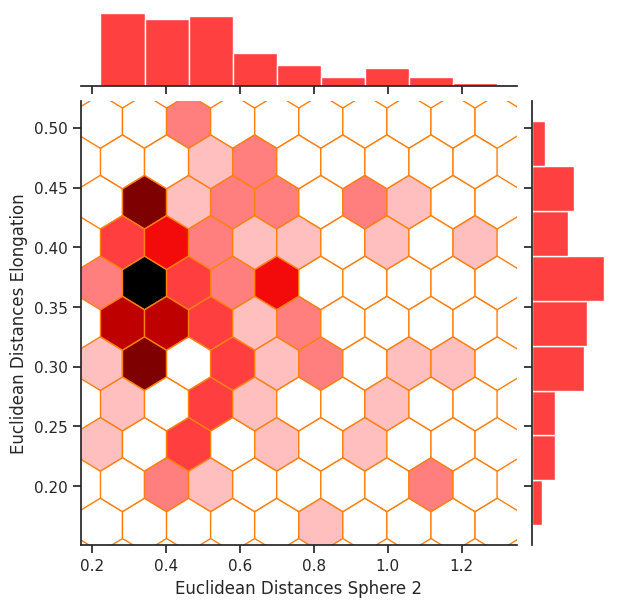

In [117]:
x = euclidean_distances_sphere_2
y = euclidean_distances_elongated

sns.set_theme(style="ticks")
g = sns.jointplot(x=x, y=y, kind="hex", color="#FF0000") 
g.ax_joint.collections[0].set_edgecolor("#ff7f0e")
plt.xlabel('Euclidean Distances Sphere 2')
plt.ylabel('Euclidean Distances Elongation')
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



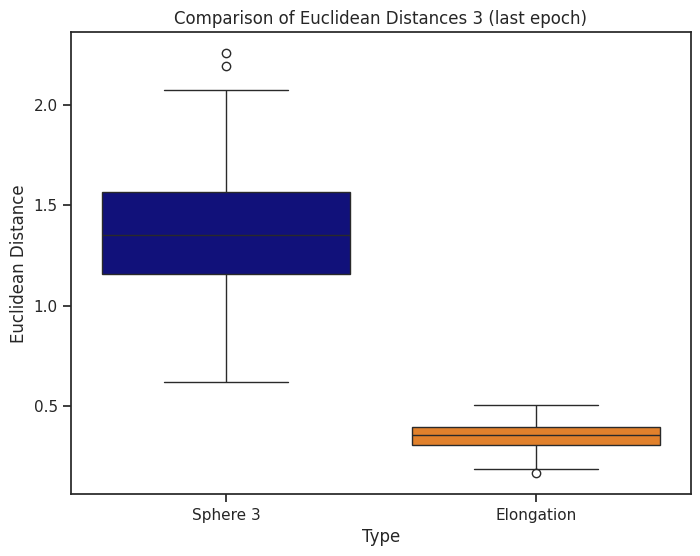

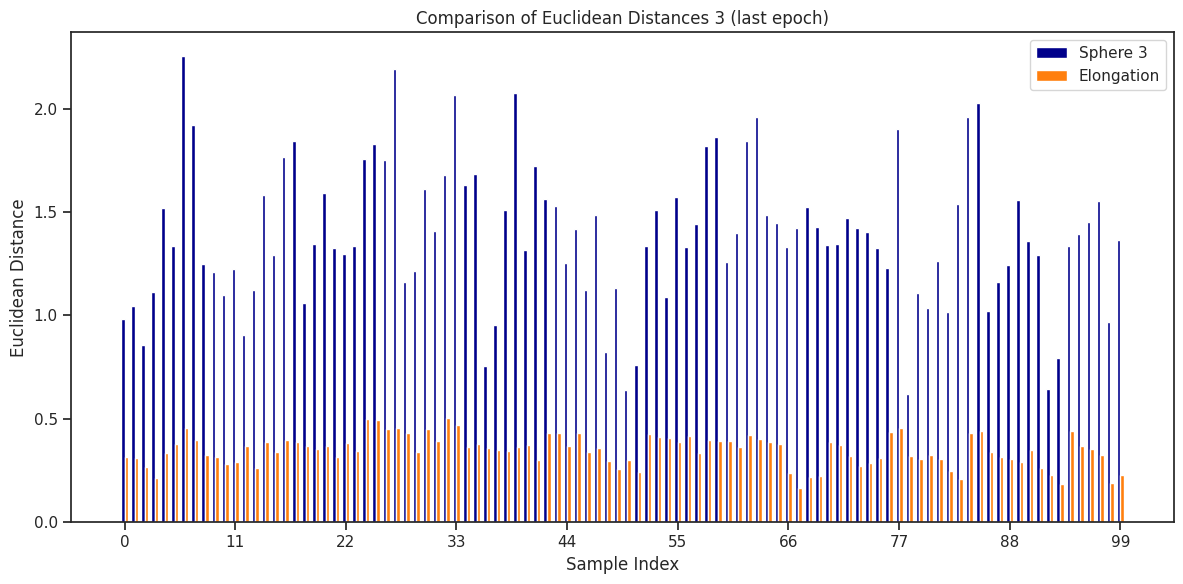

In [118]:
euclidean_distances_sphere_3 = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_sphere_3, axis=1)
euclidean_distances_elongated = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_elongated, axis=1)

df = pd.DataFrame({
    'Distance': list(euclidean_distances_sphere_3) + list(euclidean_distances_elongated),
    'Type': ['Sphere 3'] * len(euclidean_distances_sphere_3) + ['Elongation'] * len(euclidean_distances_elongated)
})

palette = {"Sphere 3": "#00008B", "Elongation": "#ff7f0e"}

plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Distance', data=df, palette=palette)
plt.title("Comparison of Euclidean Distances 3 (last epoch)")
plt.ylabel("Euclidean Distance")
plt.show()

x = np.arange(len(euclidean_distances_sphere_3))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, euclidean_distances_sphere_3, width, label='Sphere 3', color=palette['Sphere 3'])
rects2 = ax.bar(x + width/2, euclidean_distances_elongated, width, label='Elongation', color=palette['Elongation'])
ax.set_xlabel('Sample Index')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Comparison of Euclidean Distances 3 (last epoch)')
ax.legend()
ax.set_xticks(np.linspace(0, len(x) - 1, num=10, dtype=int))  
ax.set_xticklabels(np.linspace(0, len(x) - 1, num=10, dtype=int))
plt.tight_layout()
plt.show()

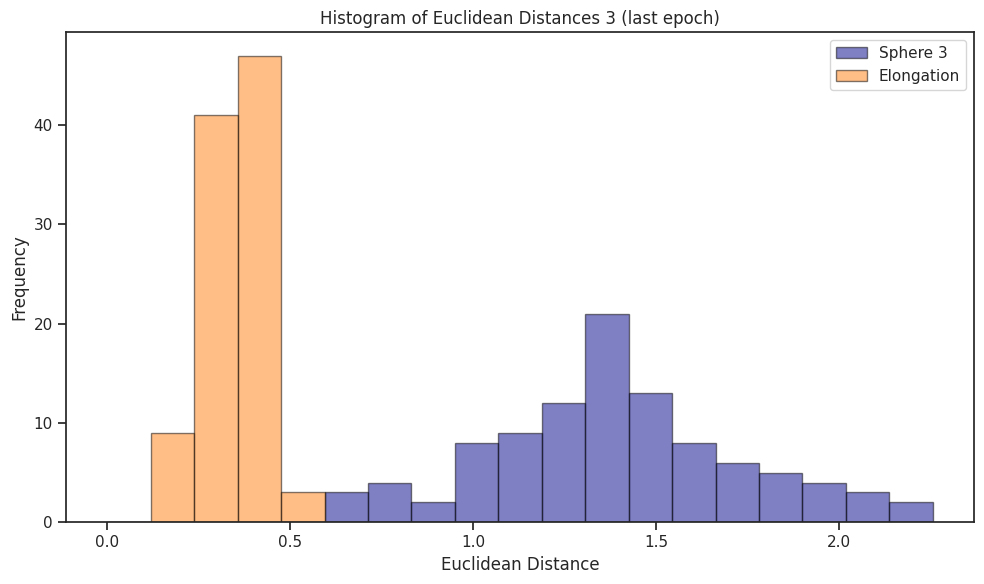

In [119]:
bins = np.linspace(0, max(np.max(euclidean_distances_sphere_3), np.max(euclidean_distances_elongated)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_sphere_3, bins=bins, alpha=0.5, label='Sphere 3', color='#00008B', edgecolor='black')  # Morado
plt.hist(euclidean_distances_elongated, bins=bins, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black')  # Naranja
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances 3 (last epoch)')
plt.legend()
plt.tight_layout()
plt.show()

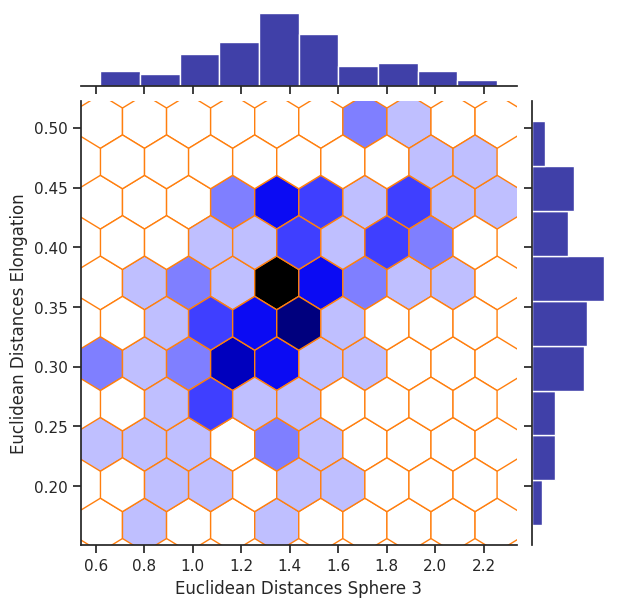

In [120]:
x = euclidean_distances_sphere_3
y = euclidean_distances_elongated

sns.set_theme(style="ticks")
g = sns.jointplot(x=x, y=y, kind="hex", color="#00008B") 
g.ax_joint.collections[0].set_edgecolor("#ff7f0e")
plt.xlabel('Euclidean Distances Sphere 3')
plt.ylabel('Euclidean Distances Elongation')
plt.show()

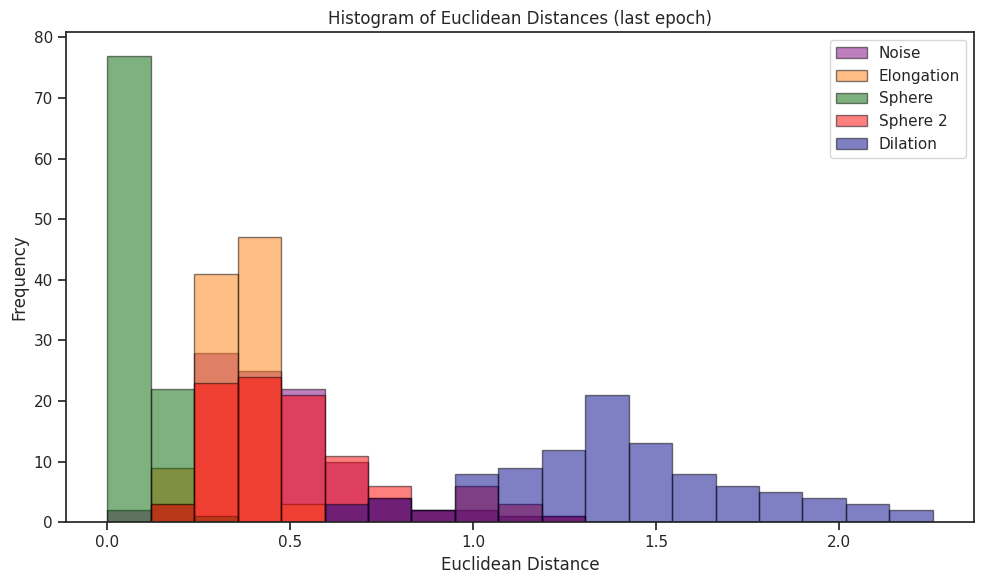

In [121]:
bins = np.linspace(0, max(np.max(euclidean_distances_noise), 
                          np.max(euclidean_distances_elongated), 
                          np.max(euclidean_distances_sphere), 
                          np.max(euclidean_distances_sphere_2), 
                          np.max(euclidean_distances_sphere_3)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_noise, bins=bins, alpha=0.5, label='Noise', color='#800080', edgecolor='black')  # Morado
plt.hist(euclidean_distances_elongated, bins=bins, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black')  # Naranja
plt.hist(euclidean_distances_sphere, bins=bins, alpha=0.5, label='Sphere', color='#006400', edgecolor='black')  # Verde oscuro
plt.hist(euclidean_distances_sphere_2, bins=bins, alpha=0.5, label='Sphere 2', color='#FF0000', edgecolor='black')  # Rosa
plt.hist(euclidean_distances_sphere_3, bins=bins, alpha=0.5, label='Dilation', color='#00008B', edgecolor='black')  # Gris
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances (last epoch)')
plt.legend()
plt.tight_layout()
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



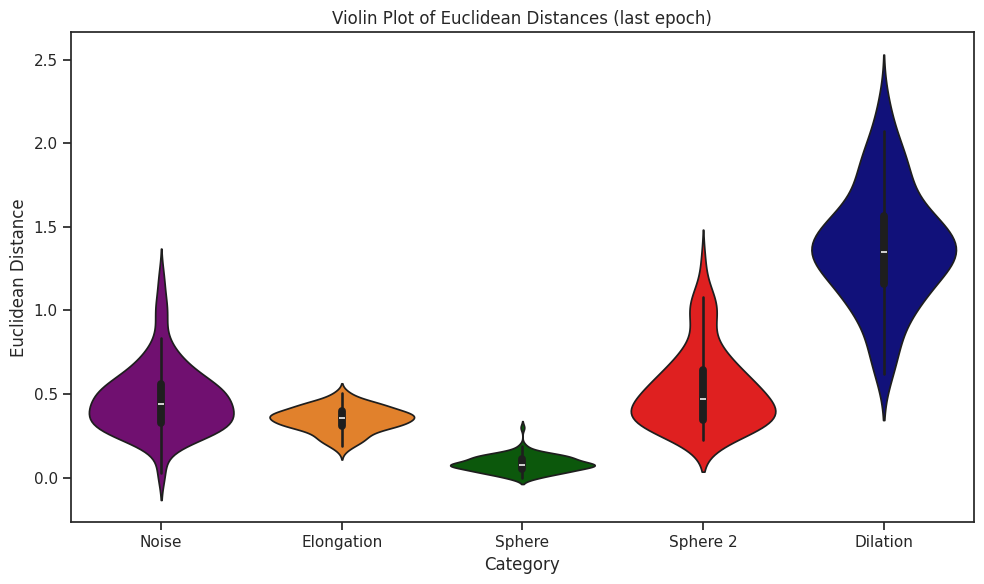

In [122]:
data = {
    'Distance': np.concatenate([euclidean_distances_noise, 
                                euclidean_distances_elongated, 
                                euclidean_distances_sphere, 
                                euclidean_distances_sphere_2, 
                                euclidean_distances_sphere_3]),
    'Category': ['Noise'] * len(euclidean_distances_noise) + 
                ['Elongation'] * len(euclidean_distances_elongated) + 
                ['Sphere'] * len(euclidean_distances_sphere) + 
                ['Sphere 2'] * len(euclidean_distances_sphere_2) + 
                ['Dilation'] * len(euclidean_distances_sphere_3)
}

df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.violinplot(x='Category', y='Distance', data=df, palette={
    'Noise': '#800080', 
    'Elongation': '#ff7f0e', 
    'Sphere': '#006400', 
    'Sphere 2': '#FF0000', 
    'Dilation': '#00008B'
})
plt.xlabel('Category')
plt.ylabel('Euclidean Distance')
plt.title('Violin Plot of Euclidean Distances (last epoch)')
plt.tight_layout()
plt.show()

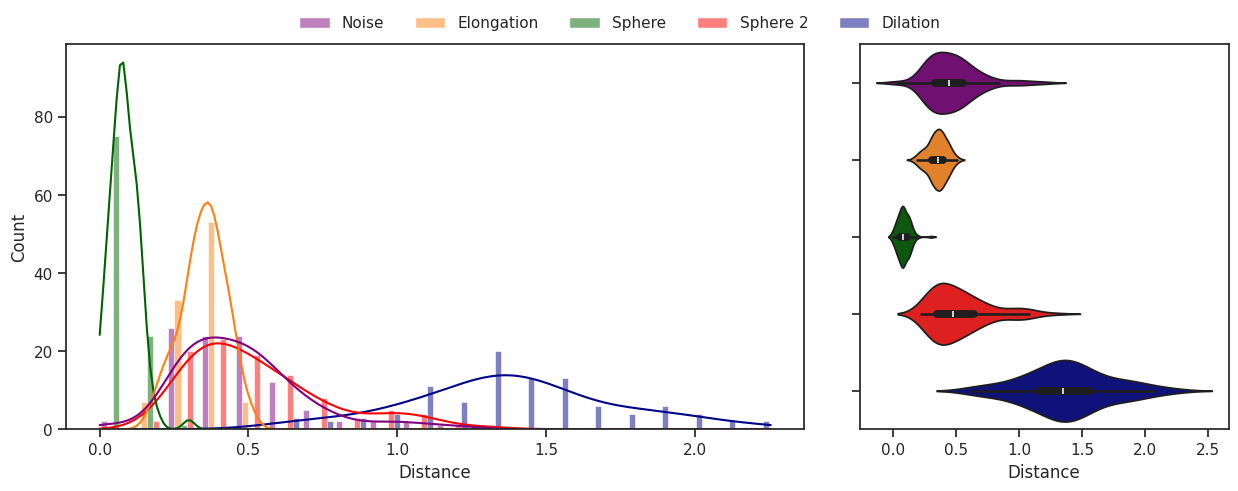

In [123]:
data = {
    'Distance': np.concatenate([
        euclidean_distances_noise, 
        euclidean_distances_elongated, 
        euclidean_distances_sphere, 
        euclidean_distances_sphere_2, 
        euclidean_distances_sphere_3
    ]),
    'Category': ['Noise'] * len(euclidean_distances_noise) + 
                ['Elongation'] * len(euclidean_distances_elongated) + 
                ['Sphere'] * len(euclidean_distances_sphere) + 
                ['Sphere 2'] * len(euclidean_distances_sphere_2) + 
                ['Dilation'] * len(euclidean_distances_sphere_3)
}

df = pd.DataFrame(data)

# Definir la paleta de colores
palette = {
    'Noise': '#800080',       # Morado
    'Elongation': '#ff7f0e',  # Naranja
    'Sphere': '#006400',      # Verde oscuro
    'Sphere 2': '#FF0000',    # Magenta
    'Dilation': '#00008B'     # Gris
}

fig, axes = plt.subplots(1, 2, figsize=(15, 5), width_ratios=[2, 1])

# Histograma
sns.histplot(data=df, x='Distance', hue='Category', multiple='dodge', shrink=0.9, kde=True, palette=palette, ax=axes[0])
sns.move_legend(
    axes[0], "lower center",
    bbox_to_anchor=(0.75, 1), ncol=5, title=None, frameon=False,
)

# Gráfico de violín
sns.violinplot(data=df, y='Category', x='Distance', hue='Category', palette=palette, ax=axes[1])
axes[1].set_ylabel(None)
axes[1].set_yticklabels([])

plt.subplots_adjust(wspace=0.1)
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



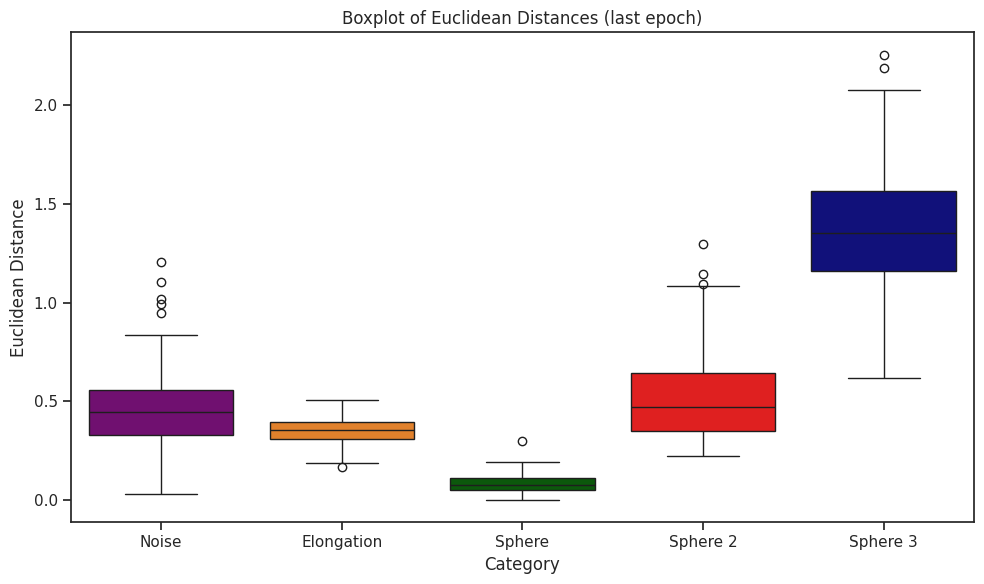

In [124]:
data = {
    'Distance': np.concatenate([euclidean_distances_noise, 
                                euclidean_distances_elongated, 
                                euclidean_distances_sphere, 
                                euclidean_distances_sphere_2, 
                                euclidean_distances_sphere_3]),
    'Category': ['Noise'] * len(euclidean_distances_noise) + 
                ['Elongation'] * len(euclidean_distances_elongated) + 
                ['Sphere'] * len(euclidean_distances_sphere) + 
                ['Sphere 2'] * len(euclidean_distances_sphere_2) + 
                ['Sphere 3'] * len(euclidean_distances_sphere_3)
}

df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.boxplot(x='Category', y='Distance', data=df, palette={
    'Noise': '#800080', 
    'Elongation': '#ff7f0e', 
    'Sphere': '#006400', 
    'Sphere 2': '#FF0000', 
    'Sphere 3': '#00008B'
})

plt.xlabel('Category')
plt.ylabel('Euclidean Distance')
plt.title('Boxplot of Euclidean Distances (last epoch)')
plt.tight_layout()
plt.show()

EUCLICEAN DISTANCES BETWEEN EMBEDDINGS OF THE EPOCH WITH BEST DICE

In [125]:
# Euclidean distance between the latent vectors of the best epoch (Dice) and the latent vectors with noise

print(f"Validation Latent Vector Shape: {best_val_latent_vectors_dice.shape}")
print(f"Validation Latent Vector Shape Noise: {val_latent_vectors_noise.shape}")

print(best_val_latent_vectors_dice[0].shape)
print(val_latent_vectors_noise[0].shape)

assert best_val_latent_vectors_dice.shape == val_latent_vectors_noise.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_noise, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Noise: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [1.6990554 1.71784   1.4935492 1.3911818 2.186712  2.1064193 1.7373457
 1.3995599 1.5763947 1.4687024 2.0678802 1.8392497 1.809706  1.5040929
 2.0785043 1.7278893 1.9037193 1.6003053 1.8106849 1.6767857 1.9063864
 1.64389   2.8272605 2.3946147 2.0834641 1.9149696 2.408343  1.8484435
 2.3881576 2.170547  2.2387772 1.9298187 2.8352034 2.8359835 1.9146864
 1.8606668 1.4948272 1.2891431 2.1532507 2.0956328 2.0164633 1.7933348
 2.91096   2.3410728 2.279305  2.0896933 1.7527808 1.7034173 1.7741593
 1.454075  1.4842274 1.4055591 2.1981826 1.668849  2.676384  2.1591055
 2.3851106 1.8987339 2.4668765 2.0168912 2.3058605 2.2398987 2.012646
 1.9368541 2.8926408 2.573541  1.4646654 1.4147562 1.6901904 1.6873112
 2.1640213 2.079107  2.6852238 2.6580002 1.9383376 1.6798017 2.0137522
 2.0151918 2.0063186 1.8243183 1.8291521 1.485249  1.6052587 1.2836901
 1.9788677 2.0228286 1.

In [126]:
# Euclidean distance between the latent vectors of the best epoch (Dice) and the latent vectors with sphere

print(f"Validation Latent Vector Shape: {best_val_latent_vectors_dice.shape}")
print(f"Validation Latent Vector Shape Noise: {val_latent_vectors_sphere.shape}")

print(best_val_latent_vectors_dice[0].shape)
print(val_latent_vectors_sphere[0].shape)

assert best_val_latent_vectors_dice.shape == val_latent_vectors_sphere.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_sphere, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Noise: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [1.9871676 1.9884667 1.6132805 1.5345641 2.40149   2.313146  2.0892255
 1.6695257 1.8086938 1.7494264 2.2622998 2.1486728 1.9863875 1.7081609
 2.3826609 1.9137253 2.2056315 1.8063459 2.1349204 1.8424096 2.4313874
 2.1630566 3.153461  2.6368551 2.376589  2.2651975 2.8153718 2.4204073
 2.7369418 2.4056187 2.547998  2.2004514 3.3410058 3.1739156 2.2002566
 2.1240053 1.7005112 1.480549  2.3848383 2.3287928 2.1764834 1.8444859
 3.194862  2.7733953 2.632292  2.3186724 2.0387232 1.818306  2.1266851
 1.6470702 1.6083267 1.5496296 2.3499515 1.95236   2.937507  2.4343934
 2.5244133 2.0359015 2.8829496 2.3853421 2.6295705 2.4928768 2.2145875
 2.1499817 3.1693676 3.0258083 1.668648  1.5583651 2.0297105 2.0401373
 2.5635042 2.4805026 3.1291742 2.9568994 2.180261  2.0727203 2.462074
 2.3146207 2.0354276 1.8269085 1.8506033 1.5717288 1.7591894 1.4868934
 2.3631654 2.5128138 1.

In [127]:
# Euclidean distance between the latent vectors of the best epoch (Dice) and the latent vectors with sphere 2

print(f"Validation Latent Vector Shape: {best_val_latent_vectors_dice.shape}")
print(f"Validation Latent Vector Shape Noise: {val_latent_vectors_sphere_2.shape}")

print(best_val_latent_vectors_dice[0].shape)
print(val_latent_vectors_sphere_2[0].shape)

assert best_val_latent_vectors_dice.shape == val_latent_vectors_sphere_2.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_sphere_2, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Noise: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [2.1321895 2.1744342 1.6267965 1.6755708 2.79799   2.651075  2.3452249
 2.2805223 1.9855534 1.9292288 2.266981  2.178286  2.0508816 1.7708002
 2.3015661 1.7070293 1.9357554 1.7227873 2.1300597 1.7338071 2.700368
 2.248762  3.0177052 2.4274642 2.4440286 2.4247086 3.08924   2.8332965
 2.8675582 2.5085354 2.4140751 2.0099604 3.3062637 3.1848865 2.3536003
 2.2652285 1.7097701 1.5588001 2.5021818 2.449879  2.2714715 2.0582972
 3.3842142 2.9071443 2.5019524 2.1447937 2.102352  1.8210685 2.0655022
 1.6522591 1.6633452 1.7276175 2.319744  1.9798907 2.855596  2.345976
 2.5121973 2.0842571 3.0392656 2.5082378 2.6036808 2.4744868 2.2939377
 2.2651334 3.1745687 3.0633652 1.8347691 1.8792689 2.1840687 2.2060335
 2.5933979 2.5052214 3.0882    2.9105875 2.451402  2.535082  2.365209
 2.1700878 1.9829819 1.850993  1.8731251 1.7252861 1.7625754 1.6353605
 2.4658725 2.6961844 1.64

In [128]:
# Euclidean distance between the latent vectors of the best epoch (Dice) and the latent vectors with sphere 3

print(f"Validation Latent Vector Shape: {best_val_latent_vectors_dice.shape}")
print(f"Validation Latent Vector Shape Noise: {val_latent_vectors_sphere_3.shape}")

print(best_val_latent_vectors_dice[0].shape)
print(val_latent_vectors_sphere_3[0].shape)

assert best_val_latent_vectors_dice.shape == val_latent_vectors_sphere_3.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_sphere_3, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Noise: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [1.4437399 1.3392465 1.50724   1.5218453 1.6186355 1.5964954 2.2611833
 1.664606  1.4326746 1.3414611 1.8794824 1.7573183 1.8478197 1.4680951
 1.8561132 1.5896453 2.0175695 1.7094958 1.6969306 1.5425771 1.7415612
 1.6562097 2.3957675 1.9754065 2.5974333 2.2722561 2.2042923 2.2839315
 2.2039819 1.9522101 1.8123368 1.7447186 2.4373572 2.0799112 2.3438542
 2.00062   1.524001  1.4142315 1.9475335 1.9978868 2.361652  2.2403562
 2.5813043 2.2742186 1.8361095 1.73153   2.042043  1.9863006 2.015579
 1.3870654 1.4007721 1.3216736 1.9728868 1.6833166 2.1831129 1.7325869
 2.2777004 2.0112524 2.9022858 2.4776344 2.8521085 2.657674  2.0071654
 1.9050101 2.270952  2.0980456 1.4445198 1.4432586 1.5420525 1.4989077
 2.327641  2.0941665 2.1442556 1.9669135 1.7086288 1.6748519 2.0892558
 2.1660635 2.0883324 2.0774217 2.0789127 1.6801525 1.5787026 1.7306899
 1.8590785 1.6869823 1.

In [129]:
# Euclidean distance between the latent vectors of the best epoch (dice) and the latent vectors with elongation

print(f"Validation Latent Vector Shape: {best_val_latent_vectors_dice.shape}")
print(f"Validation Latent Vector Shape Elongated: {val_latent_vectors_elongated.shape}")

print(best_val_latent_vectors_dice[0].shape)
print(val_latent_vectors_elongated[0].shape)

assert best_val_latent_vectors_dice.shape == val_latent_vectors_elongated.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_elongated, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Elongated: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [1.949225  1.9311666 1.4593489 1.4228568 2.3842504 2.2296286 2.1115673
 1.6060443 1.7742417 1.6983782 2.2248924 2.1144176 1.8929619 1.65392
 2.2076519 1.814045  1.983765  1.63097   1.9819223 1.7014084 2.4387107
 2.1295311 2.9500444 2.5019228 2.3140132 2.1676204 2.7978601 2.4248545
 2.67378   2.313507  2.3136754 2.016533  3.1531346 2.9629529 2.1681929
 2.02468   1.6219984 1.4829303 2.3635738 2.3188019 2.1737533 1.8082262
 3.0584207 2.6560216 2.4475951 2.0973861 1.965502  1.6798068 2.060334
 1.5988106 1.6036106 1.5758603 2.1244936 1.8068477 2.7317333 2.2614682
 2.4444692 1.9876944 2.7376792 2.2247372 2.5727985 2.4045591 2.0898244
 2.0254574 3.0671644 2.966687  1.6928571 1.5733113 2.0372849 2.0615218
 2.4251125 2.3334346 2.985123  2.837979  2.254618  2.1106637 2.3155763
 2.165348  1.9776878 1.8172511 1.7818918 1.5238067 1.6679455 1.4061024
 2.2510586 2.3561327 



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



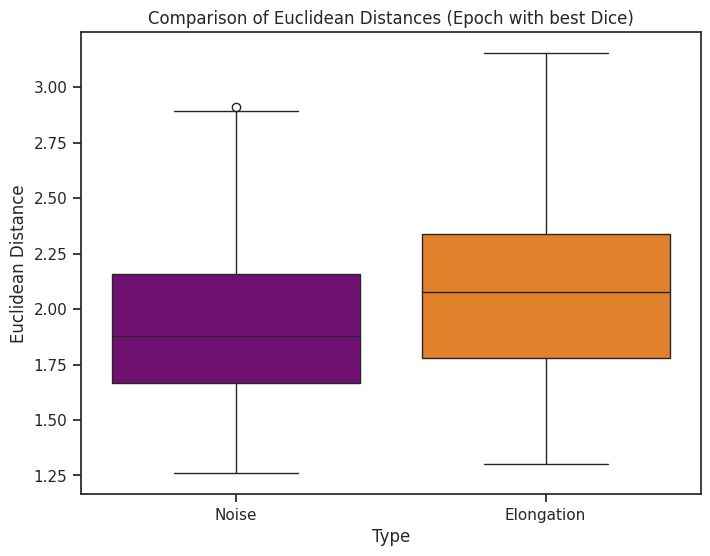

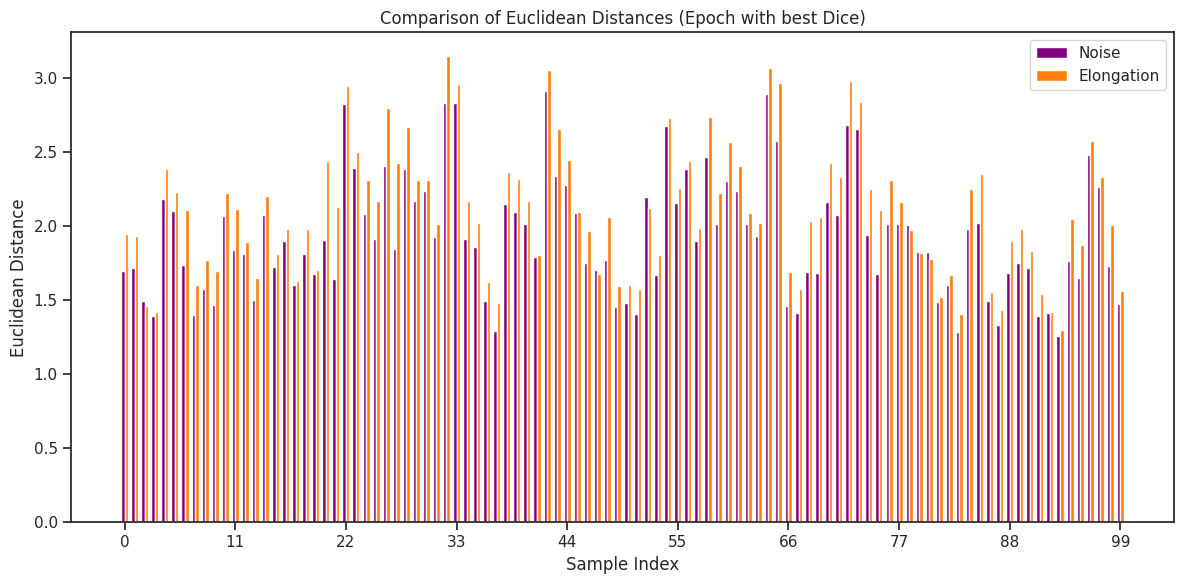

In [130]:
euclidean_distances_noise_dice = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_noise, axis=1)
euclidean_distances_elongated_dice = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_elongated, axis=1)

df = pd.DataFrame({
    'Distance': list(euclidean_distances_noise_dice) + list(euclidean_distances_elongated_dice),
    'Type': ['Noise'] * len(euclidean_distances_noise_dice) + ['Elongation'] * len(euclidean_distances_elongated_dice)
})

palette = {"Noise": "#800080", "Elongation": "#ff7f0e"}

plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Distance', data=df, palette=palette)
plt.title("Comparison of Euclidean Distances (Epoch with best Dice)")
plt.ylabel("Euclidean Distance")
plt.show()

x = np.arange(len(euclidean_distances_noise_dice))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, euclidean_distances_noise_dice, width, label='Noise', color=palette['Noise'])
rects2 = ax.bar(x + width/2, euclidean_distances_elongated_dice, width, label='Elongation', color=palette['Elongation'])

ax.set_xlabel('Sample Index')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Comparison of Euclidean Distances (Epoch with best Dice)')
ax.legend()

ax.set_xticks(np.linspace(0, len(x) - 1, num=10, dtype=int))  
ax.set_xticklabels(np.linspace(0, len(x) - 1, num=10, dtype=int))

plt.tight_layout()
plt.show()

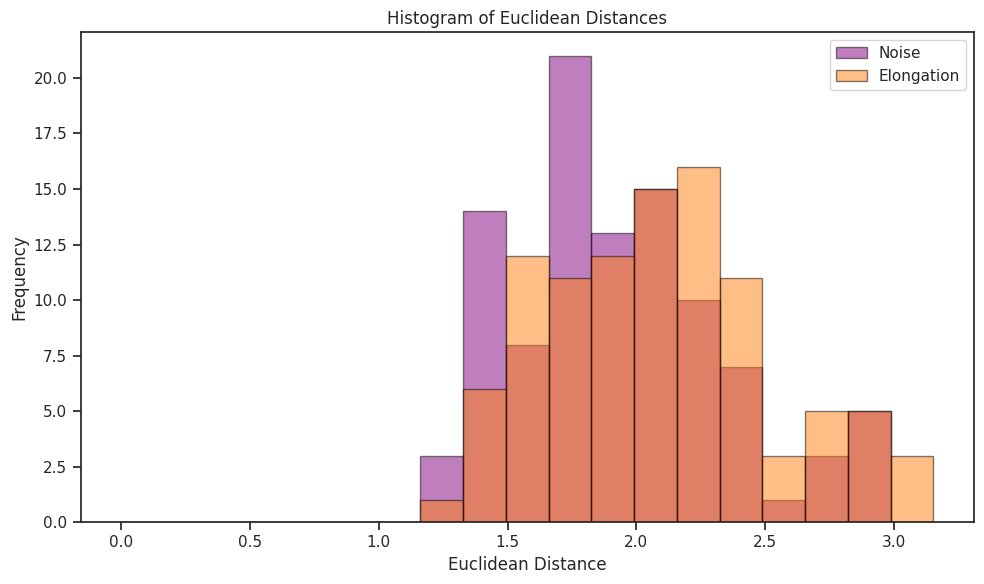

In [131]:
bins_dice = np.linspace(0, max(np.max(euclidean_distances_noise_dice), np.max(euclidean_distances_elongated_dice)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_noise_dice, bins=bins_dice, alpha=0.5, label='Noise', color='#800080', edgecolor='black')  # Morado
plt.hist(euclidean_distances_elongated_dice, bins=bins_dice, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black')  # Naranja
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances')
plt.legend()
plt.tight_layout()
plt.show()

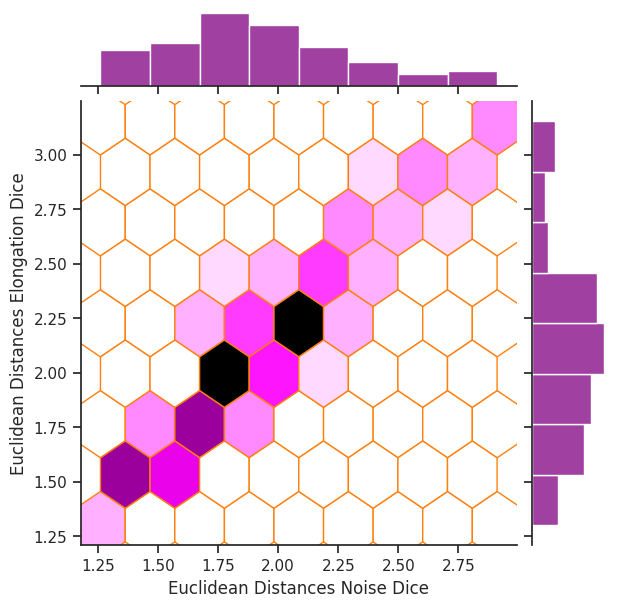

In [132]:
x_dice = euclidean_distances_noise_dice
y_dice = euclidean_distances_elongated_dice

sns.set_theme(style="ticks")
g = sns.jointplot(x=x_dice, y=y_dice, kind="hex", color="#800080")
g.ax_joint.collections[0].set_edgecolor("#ff7f0e")

plt.xlabel('Euclidean Distances Noise Dice')
plt.ylabel('Euclidean Distances Elongation Dice')
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



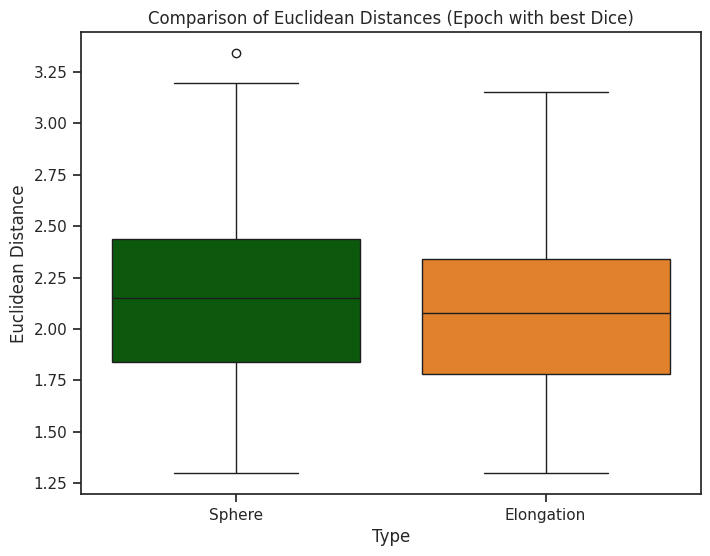

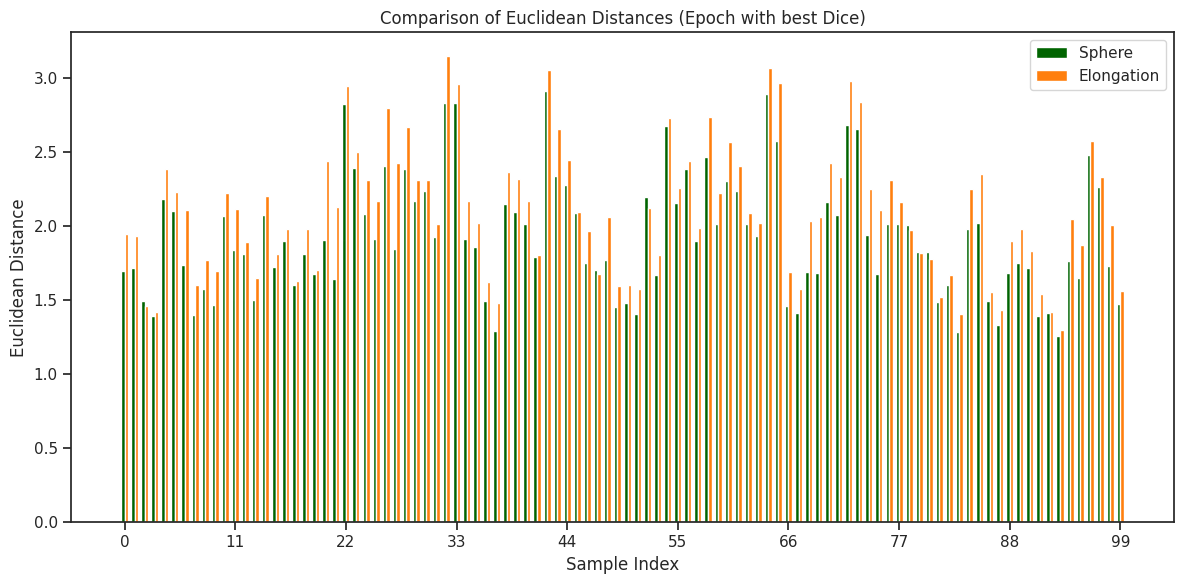

In [133]:
euclidean_distances_sphere_dice = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_sphere, axis=1)
euclidean_distances_elongated_dice = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_elongated, axis=1)

df = pd.DataFrame({
    'Distance': list(euclidean_distances_sphere_dice) + list(euclidean_distances_elongated_dice),
    'Type': ['Sphere'] * len(euclidean_distances_sphere_dice) + ['Elongation'] * len(euclidean_distances_elongated_dice)
})

palette = {"Sphere": "#006400", "Elongation": "#ff7f0e"} 

plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Distance', data=df, palette=palette)
plt.title("Comparison of Euclidean Distances (Epoch with best Dice)")
plt.ylabel("Euclidean Distance")
plt.show()

x = np.arange(len(euclidean_distances_sphere_dice))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, euclidean_distances_noise_dice, width, label='Sphere', color=palette['Sphere'])
rects2 = ax.bar(x + width/2, euclidean_distances_elongated_dice, width, label='Elongation', color=palette['Elongation'])

ax.set_xlabel('Sample Index')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Comparison of Euclidean Distances (Epoch with best Dice)')
ax.legend()
ax.set_xticks(np.linspace(0, len(x) - 1, num=10, dtype=int))  
ax.set_xticklabels(np.linspace(0, len(x) - 1, num=10, dtype=int))

plt.tight_layout()
plt.show()

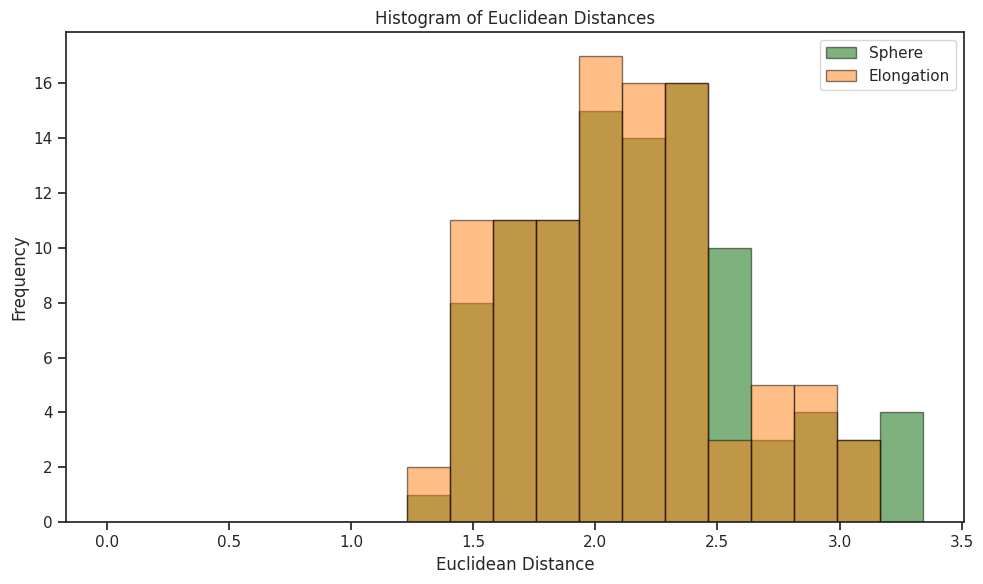

In [134]:
bins_dice = np.linspace(0, max(np.max(euclidean_distances_sphere_dice), np.max(euclidean_distances_elongated_dice)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_sphere_dice, bins=bins_dice, alpha=0.5, label='Sphere', color='#006400', edgecolor='black') 
plt.hist(euclidean_distances_elongated_dice, bins=bins_dice, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black')
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances')
plt.legend()
plt.tight_layout()
plt.show()

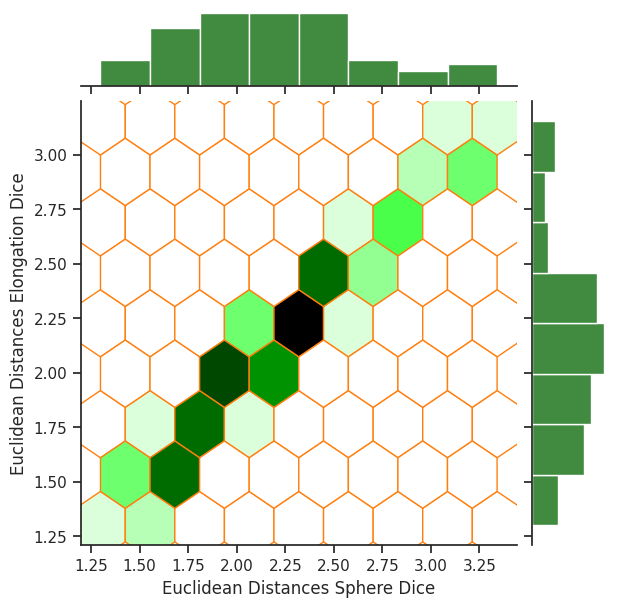

In [135]:
x_dice = euclidean_distances_sphere_dice
y_dice = euclidean_distances_elongated_dice

sns.set_theme(style="ticks")

g = sns.jointplot(x=x_dice, y=y_dice, kind="hex", color="#006400")
g.ax_joint.collections[0].set_edgecolor("#ff7f0e")
plt.xlabel('Euclidean Distances Sphere Dice')
plt.ylabel('Euclidean Distances Elongation Dice')
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



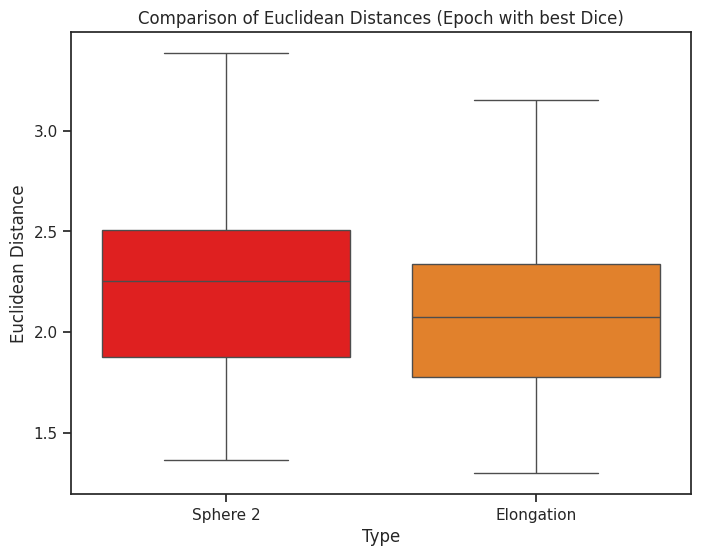

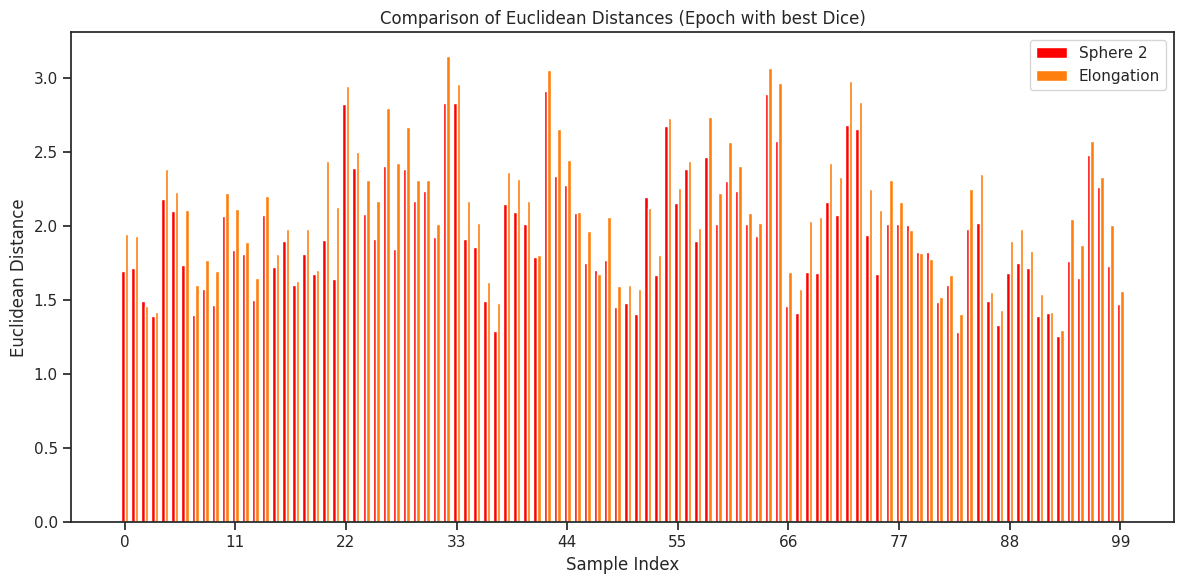

In [136]:
euclidean_distances_sphere_2_dice = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_sphere_2, axis=1)
euclidean_distances_elongated_dice = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_elongated, axis=1)

df = pd.DataFrame({
    'Distance': list(euclidean_distances_sphere_2_dice) + list(euclidean_distances_elongated_dice),
    'Type': ['Sphere 2'] * len(euclidean_distances_sphere_2_dice) + ['Elongation'] * len(euclidean_distances_elongated_dice)
})

palette = {"Sphere 2": "#FF0000", "Elongation": "#ff7f0e"}

plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Distance', data=df, palette=palette)
plt.title("Comparison of Euclidean Distances (Epoch with best Dice)")
plt.ylabel("Euclidean Distance")
plt.show()

x = np.arange(len(euclidean_distances_sphere_2_dice))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, euclidean_distances_noise_dice, width, label='Sphere 2', color=palette['Sphere 2'])
rects2 = ax.bar(x + width/2, euclidean_distances_elongated_dice, width, label='Elongation', color=palette['Elongation'])

ax.set_xlabel('Sample Index')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Comparison of Euclidean Distances (Epoch with best Dice)')
ax.legend()
ax.set_xticks(np.linspace(0, len(x) - 1, num=10, dtype=int))  
ax.set_xticklabels(np.linspace(0, len(x) - 1, num=10, dtype=int))
plt.tight_layout()
plt.show()

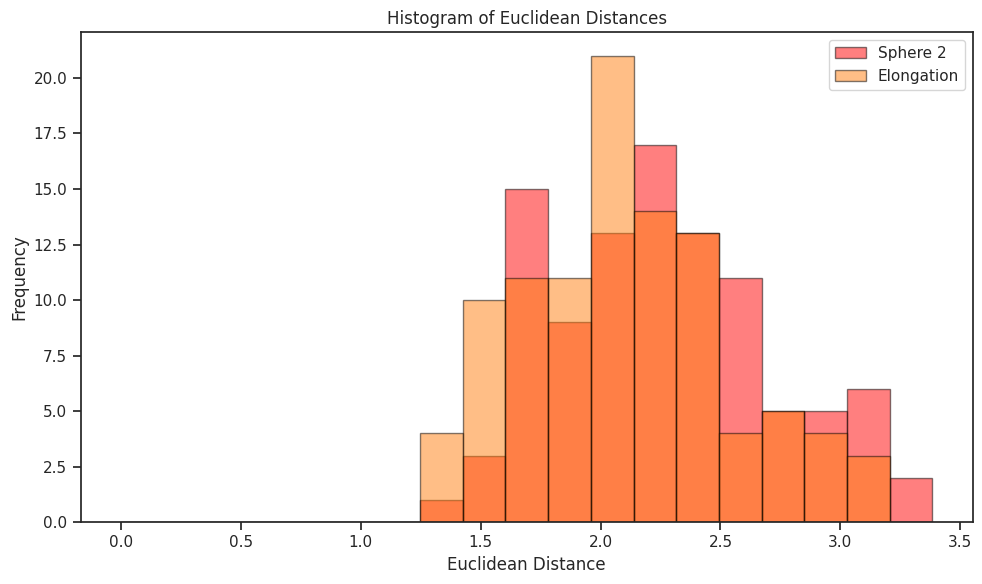

In [137]:
bins_dice = np.linspace(0, max(np.max(euclidean_distances_sphere_2_dice), np.max(euclidean_distances_elongated_dice)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_sphere_2_dice, bins=bins_dice, alpha=0.5, label='Sphere 2', color='#FF0000', edgecolor='black') 
plt.hist(euclidean_distances_elongated_dice, bins=bins_dice, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black')
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances')
plt.legend()
plt.tight_layout()
plt.show()

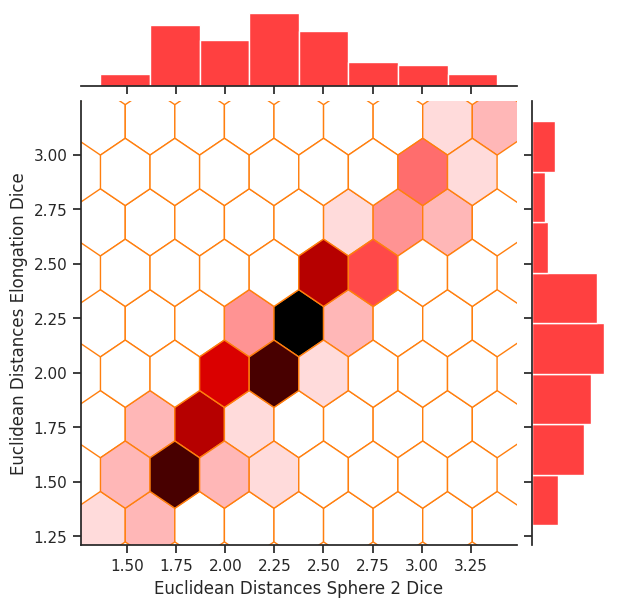

In [138]:
x_dice = euclidean_distances_sphere_2_dice
y_dice = euclidean_distances_elongated_dice

sns.set_theme(style="ticks")
g = sns.jointplot(x=x_dice, y=y_dice, kind="hex", color="#FF0000")
g.ax_joint.collections[0].set_edgecolor("#ff7f0e")
plt.xlabel('Euclidean Distances Sphere 2 Dice')
plt.ylabel('Euclidean Distances Elongation Dice')
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



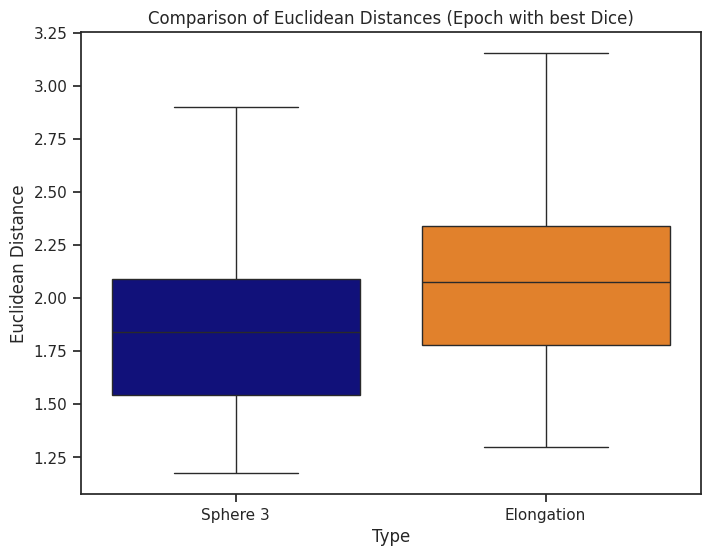

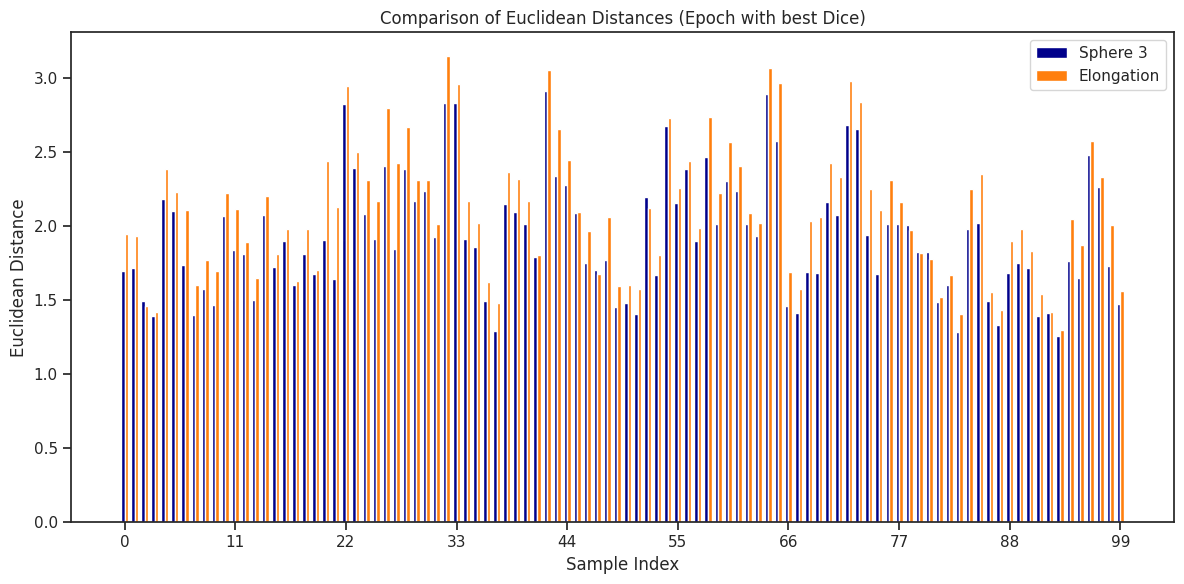

In [139]:
euclidean_distances_sphere_3_dice = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_sphere_3, axis=1)
euclidean_distances_elongated_dice = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_elongated, axis=1)

df = pd.DataFrame({
    'Distance': list(euclidean_distances_sphere_3_dice) + list(euclidean_distances_elongated_dice),
    'Type': ['Sphere 3'] * len(euclidean_distances_sphere_3_dice) + ['Elongation'] * len(euclidean_distances_elongated_dice)
})

palette = {"Sphere 3": "#00008B", "Elongation": "#ff7f0e"} 

plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Distance', data=df, palette=palette)
plt.title("Comparison of Euclidean Distances (Epoch with best Dice)")
plt.ylabel("Euclidean Distance")
plt.show()

x = np.arange(len(euclidean_distances_sphere_3_dice))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, euclidean_distances_noise_dice, width, label='Sphere 3', color=palette['Sphere 3'])
rects2 = ax.bar(x + width/2, euclidean_distances_elongated_dice, width, label='Elongation', color=palette['Elongation'])

ax.set_xlabel('Sample Index')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Comparison of Euclidean Distances (Epoch with best Dice)')
ax.legend()

ax.set_xticks(np.linspace(0, len(x) - 1, num=10, dtype=int))  
ax.set_xticklabels(np.linspace(0, len(x) - 1, num=10, dtype=int))

plt.tight_layout()
plt.show()

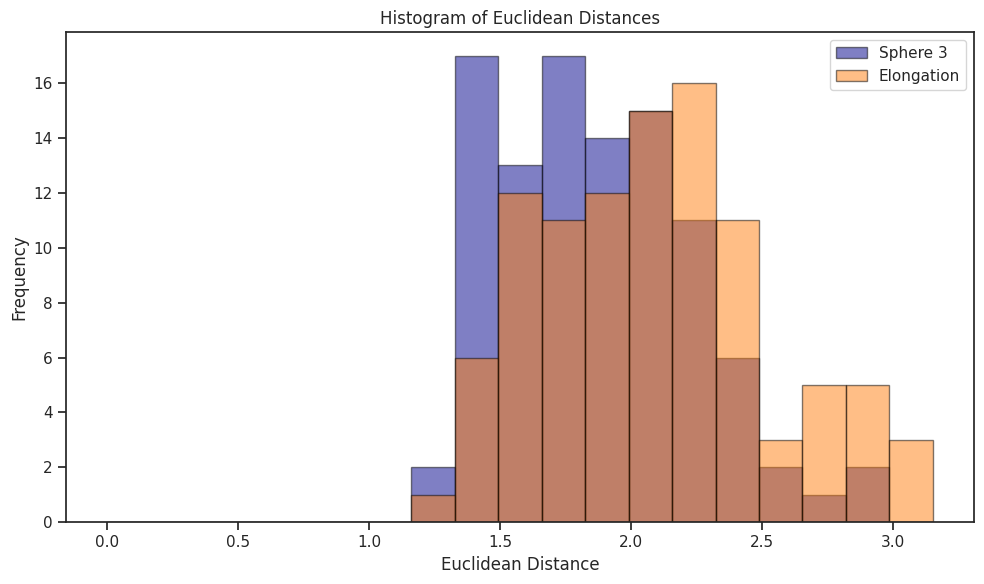

In [140]:
bins_dice = np.linspace(0, max(np.max(euclidean_distances_sphere_3_dice), np.max(euclidean_distances_elongated_dice)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_sphere_3_dice, bins=bins_dice, alpha=0.5, label='Sphere 3', color='#00008B', edgecolor='black')  # Morado
plt.hist(euclidean_distances_elongated_dice, bins=bins_dice, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black')  # Naranja
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances')
plt.legend()
plt.tight_layout()
plt.show()

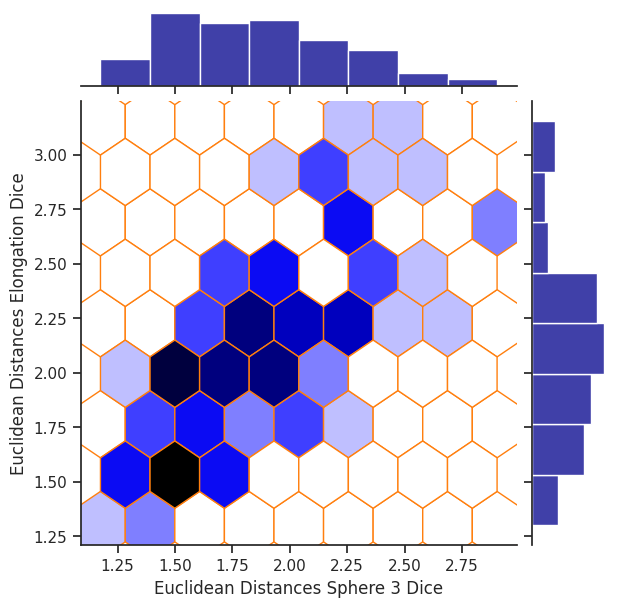

In [141]:
x_dice = euclidean_distances_sphere_3_dice
y_dice = euclidean_distances_elongated_dice

sns.set_theme(style="ticks")
g = sns.jointplot(x=x_dice, y=y_dice, kind="hex", color="#00008B")
g.ax_joint.collections[0].set_edgecolor("#ff7f0e")
plt.xlabel('Euclidean Distances Sphere 3 Dice')
plt.ylabel('Euclidean Distances Elongation Dice')
plt.show()

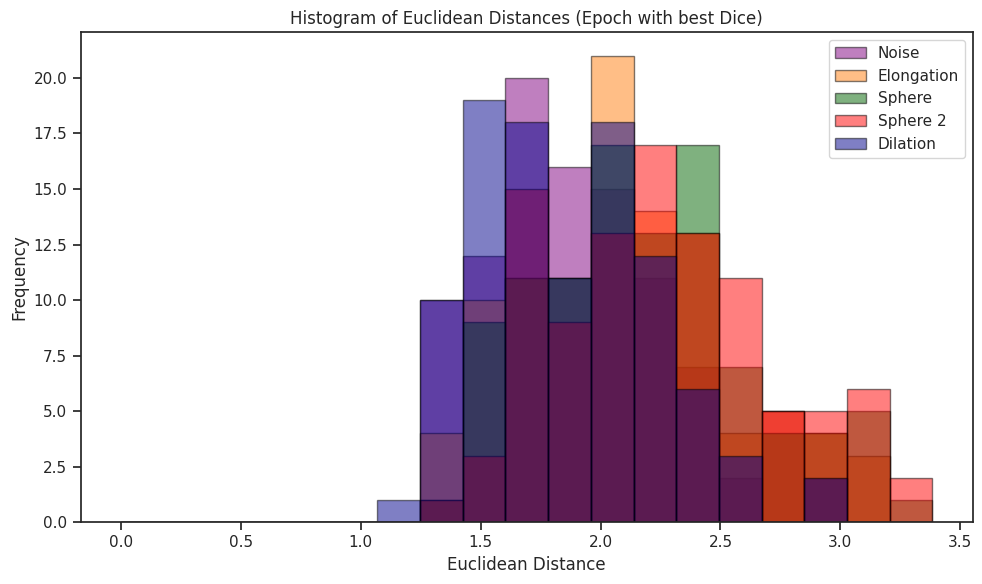

In [142]:
bins = np.linspace(0, max(np.max(euclidean_distances_noise_dice), 
                          np.max(euclidean_distances_elongated_dice), 
                          np.max(euclidean_distances_sphere_dice), 
                          np.max(euclidean_distances_sphere_2_dice), 
                          np.max(euclidean_distances_sphere_3_dice)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_noise_dice, bins=bins, alpha=0.5, label='Noise', color='#800080', edgecolor='black')  # Morado
plt.hist(euclidean_distances_elongated_dice, bins=bins, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black')  # Naranja
plt.hist(euclidean_distances_sphere_dice, bins=bins, alpha=0.5, label='Sphere', color='#006400', edgecolor='black')  # Verde oscuro
plt.hist(euclidean_distances_sphere_2_dice, bins=bins, alpha=0.5, label='Sphere 2', color='#FF0000', edgecolor='black')  # Rosa
plt.hist(euclidean_distances_sphere_3_dice, bins=bins, alpha=0.5, label='Dilation', color='#00008B', edgecolor='black')  # Gris

plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances (Epoch with best Dice)')
plt.legend()
plt.tight_layout()
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



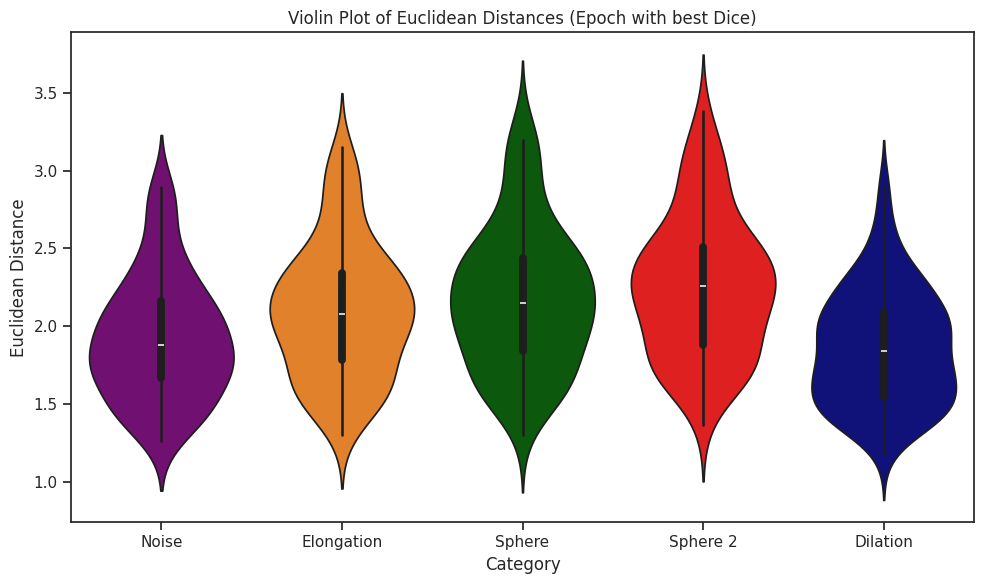

In [143]:
data = {
    'Distance': np.concatenate([euclidean_distances_noise_dice, 
                                euclidean_distances_elongated_dice, 
                                euclidean_distances_sphere_dice, 
                                euclidean_distances_sphere_2_dice, 
                                euclidean_distances_sphere_3_dice]),
    'Category': ['Noise'] * len(euclidean_distances_noise_dice) + 
                ['Elongation'] * len(euclidean_distances_elongated_dice) + 
                ['Sphere'] * len(euclidean_distances_sphere_dice) + 
                ['Sphere 2'] * len(euclidean_distances_sphere_2_dice) + 
                ['Dilation'] * len(euclidean_distances_sphere_3_dice)
}

df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.violinplot(x='Category', y='Distance', data=df, palette={
    'Noise': '#800080', 
    'Elongation': '#ff7f0e', 
    'Sphere': '#006400', 
    'Sphere 2': '#FF0000', 
    'Dilation': '#00008B'
})

plt.xlabel('Category')
plt.ylabel('Euclidean Distance')
plt.title('Violin Plot of Euclidean Distances (Epoch with best Dice)')
plt.tight_layout()
plt.show()

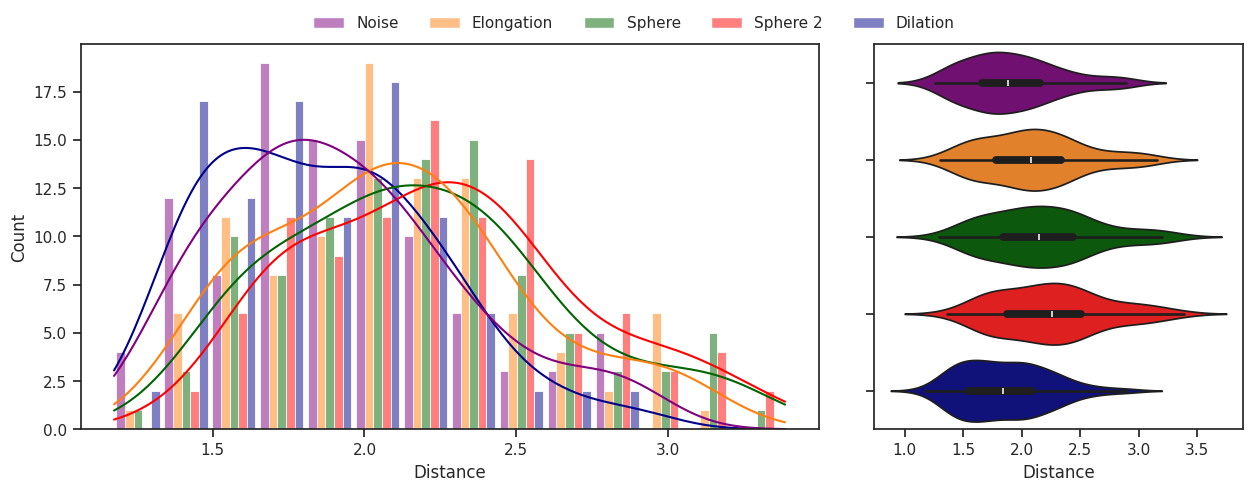

In [144]:
data = {
    'Distance': np.concatenate([
        euclidean_distances_noise_dice, 
        euclidean_distances_elongated_dice, 
        euclidean_distances_sphere_dice, 
        euclidean_distances_sphere_2_dice, 
        euclidean_distances_sphere_3_dice
    ]),
    'Category': ['Noise'] * len(euclidean_distances_noise_dice) + 
                ['Elongation'] * len(euclidean_distances_elongated_dice) + 
                ['Sphere'] * len(euclidean_distances_sphere_3_dice) + 
                ['Sphere 2'] * len(euclidean_distances_sphere_2_dice) + 
                ['Dilation'] * len(euclidean_distances_sphere_3_dice)
}

df = pd.DataFrame(data)

palette = {
    'Noise': '#800080',       # Morado
    'Elongation': '#ff7f0e',  # Naranja
    'Sphere': '#006400',      # Verde oscuro
    'Sphere 2': '#FF0000',    # Magenta
    'Dilation': '#00008B'     # Gris
}

fig, axes = plt.subplots(1, 2, figsize=(15, 5), width_ratios=[2, 1])

# Histograma
sns.histplot(data=df, x='Distance', hue='Category', multiple='dodge', shrink=0.9, kde=True, palette=palette, ax=axes[0])
sns.move_legend(
    axes[0], "lower center",
    bbox_to_anchor=(0.75, 1), ncol=5, title=None, frameon=False,
)

# Gráfico de violín
sns.violinplot(data=df, y='Category', x='Distance', hue='Category', palette=palette, ax=axes[1])
axes[1].set_ylabel(None)
axes[1].set_yticklabels([])

plt.subplots_adjust(wspace=0.1)
plt.show()

EUCLIDEAN DISTANCES BETWEEN EMBEDDINGS OF THE EPOCHS WITH THE BEST HAUSDORFF DISTANCE

In [145]:
# Euclidean distance between the latent vectors of the best epoch (Hausdorff Distance) and the latent vectors with noise

print(f"Validation Latent Vector Shape: {best_val_latent_vectors_hausdorff.shape}")
print(f"Validation Latent Vector Shape Noise: {val_latent_vectors_noise.shape}")

print(best_val_latent_vectors_hausdorff[0].shape)
print(val_latent_vectors_noise[0].shape)

assert best_val_latent_vectors_hausdorff.shape == val_latent_vectors_noise.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(best_val_latent_vectors_hausdorff - val_latent_vectors_noise, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Noise: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [0.43948957 0.41643342 0.24379165 0.37814212 0.38594696 0.3790076
 0.94614357 0.5555794  0.48915336 0.48690674 0.3499005  0.53807396
 0.2684075  0.34614566 0.44754833 0.30331978 0.53340465 0.3322705
 0.5818781  0.28159955 0.9928128  1.0169243  0.44787312 0.35815984
 0.580306   0.5760143  0.6685874  1.2065461  0.58959794 0.36817035
 0.4148551  0.42703763 0.8138198  0.5116318  0.54622275 0.38943326
 0.5204637  0.538577   0.3549031  0.35153234 0.52605045 0.25049436
 0.49295887 0.83731693 0.5413447  0.3958074  0.59532857 0.23389311
 0.47451043 0.28528872 0.23238435 0.2603864  0.3154049  0.7606822
 0.36839873 0.45132363 0.34866875 0.69542706 0.6711376  0.6481645
 0.5000527  0.3375691  0.4206885  0.431439   0.3952108  0.63198775
 0.427686   0.2923467  0.5622658  0.5500882  0.54883873 0.5156389
 0.6601916  0.47465006 0.4551021  0.6501045  1.1063159  0.60307896
 0.04259

In [146]:
# Euclidean distance between the latent vectors of the best epoch (Hausdorff Distance) and the latent vectors with sphere

print(f"Validation Latent Vector Shape: {best_val_latent_vectors_hausdorff.shape}")
print(f"Validation Latent Vector Shape Sphere: {val_latent_vectors_sphere.shape}")

print(best_val_latent_vectors_hausdorff[0].shape)
print(val_latent_vectors_sphere[0].shape)

assert best_val_latent_vectors_hausdorff.shape == val_latent_vectors_sphere.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(best_val_latent_vectors_hausdorff - val_latent_vectors_sphere, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Sphere: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [0.08326782 0.06360051 0.2999247  0.14881378 0.08131905 0.03663826
 0.13623002 0.00577089 0.10487238 0.02507742 0.11875958 0.11127363
 0.1606158  0.12652718 0.06883207 0.04362973 0.14585419 0.14216815
 0.06503748 0.06896265 0.08128204 0.         0.08357073 0.05331871
 0.13874623 0.11270554 0.04134597 0.         0.12028645 0.0568017
 0.06597941 0.03554601 0.08547935 0.07531605 0.11229745 0.07302816
 0.07224634 0.02857706 0.03765342 0.03794963 0.17682417 0.07330156
 0.15172608 0.12601785 0.05387968 0.02729918 0.03078917 0.00532361
 0.06773782 0.04192924 0.11850097 0.08603912 0.10985351 0.07589204
 0.13351914 0.09111153 0.07552636 0.0357698  0.05626347 0.01564584
 0.11590609 0.10669155 0.09756754 0.10218568 0.07761277 0.06755068
 0.07702351 0.0608164  0.10084645 0.08474787 0.08211653 0.05380937
 0.13570136 0.19199872 0.10143825 0.03249933 0.13172449 0.072141
 0.12

In [147]:
# Euclidean distance between the latent vectors of the best epoch (Hausdorff Distance) and the latent vectors with sphere 2

print(f"Validation Latent Vector Shape: {best_val_latent_vectors_hausdorff.shape}")
print(f"Validation Latent Vector Shape Sphere 2: {val_latent_vectors_sphere_2.shape}")

print(best_val_latent_vectors_hausdorff[0].shape)
print(val_latent_vectors_sphere_2[0].shape)

assert best_val_latent_vectors_hausdorff.shape == val_latent_vectors_sphere_2.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(best_val_latent_vectors_hausdorff - val_latent_vectors_sphere_2, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Sphere 2: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [0.34238914 0.39887387 0.4908917  1.0941299  0.74500597 0.7143453
 0.7034985  1.2958732  0.40347558 0.5798     0.32524392 0.39816868
 0.38959846 0.63483834 0.23708123 0.48185536 0.5821073  1.0168253
 0.29154179 0.5713547  0.74584216 0.84413284 0.2984299  0.5880831
 0.50178653 0.64401346 0.96568155 1.0550451  0.2919499  0.38072294
 0.3387736  0.5682123  0.46318743 0.5115609  0.47937626 0.567585
 0.41006404 0.42062205 0.24979696 0.29108334 0.654003   1.1469358
 0.60325116 0.55133027 0.46461585 0.9309979  0.26893532 0.3140493
 0.30624434 0.5291983  0.2488136  0.4935477  0.33656564 0.4634996
 0.3891858  0.7778189  0.32154313 0.500171   0.33707908 0.3788394
 0.3370269  0.34319925 0.3200435  0.34833258 0.4019711  0.37576964
 0.4920267  0.8195961  0.37394634 0.4639619  0.22357728 0.38303444
 0.5045113  0.5774251  0.6915405  1.0108279  0.33635238 0.61587137
 0.263011

In [148]:
# Euclidean distance between the latent vectors of the best epoch (Hausdorff Distance) and the latent vectors with sphere 3

print(f"Validation Latent Vector Shape: {best_val_latent_vectors_hausdorff.shape}")
print(f"Validation Latent Vector Shape Sphere 3: {val_latent_vectors_sphere_3.shape}")

print(best_val_latent_vectors_hausdorff[0].shape)
print(val_latent_vectors_sphere_3[0].shape)

assert best_val_latent_vectors_hausdorff.shape == val_latent_vectors_sphere_3.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(best_val_latent_vectors_hausdorff - val_latent_vectors_sphere_3, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Sphere 3: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [0.9848072  1.044362   0.85768044 1.113179   1.5177553  1.3356622
 2.2555704  1.9180748  1.2470312  1.210819   1.0985373  1.2243459
 0.903686   1.1239026  1.5840548  1.2910084  1.7650595  1.8444234
 1.0604511  1.3454523  1.5937213  1.3256961  1.298287   1.3347547
 1.756093   1.8288155  1.7499337  2.1900601  1.1591077  1.2121994
 1.6095833  1.4094583  1.6770192  2.0659685  1.6299198  1.6846577
 0.75357246 0.9522776  1.5104747  2.073876   1.3165007  1.7220237
 1.5618194  1.5302824  1.2543974  1.4175813  1.12256    1.485981
 0.82483727 1.130173   0.6391862  0.7579349  1.3331218  1.5078386
 1.0890461  1.5738475  1.3300868  1.4425263  1.8205998  1.8635204
 1.2595427  1.3999224  1.84131    1.9589665  1.486312   1.4463917
 1.3322232  1.4221889  1.5247625  1.4266746  1.3392141  1.3432442
 1.4726642  1.4238356  1.4049046  1.3264289  1.2269878  1.9017738
 0.61992276 1.

In [149]:
# Euclidean distance between the latent vectors of the best epoch (Hausdorff Distance) and the latent vectors with elongation

print(f"Validation Latent Vector Shape: {best_val_latent_vectors_hausdorff.shape}")
print(f"Validation Latent Vector Shape Noise: {val_latent_vectors_elongated.shape}")

print(best_val_latent_vectors_hausdorff[0].shape)
print(val_latent_vectors_elongated[0].shape)

assert best_val_latent_vectors_hausdorff.shape == val_latent_vectors_elongated.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(best_val_latent_vectors_hausdorff - val_latent_vectors_elongated, axis=1)

print(len(distancias_euclidianas))
print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Noise: (100, 64)
(64,)
(64,)
100
Distancias Euclidianas: [0.31549606 0.3110446  0.26611406 0.21301574 0.33305907 0.37697458
 0.4548354  0.3977309  0.32358244 0.31675407 0.28144503 0.29135522
 0.36854133 0.2624367  0.3862072  0.33893982 0.3969568  0.38600764
 0.3676421  0.35401708 0.37047204 0.31547987 0.38079676 0.34290317
 0.49790516 0.4926087  0.4506915  0.45440266 0.4327432  0.34094197
 0.44960555 0.3939146  0.5052938  0.47092396 0.3642467  0.37734428
 0.35958326 0.34917387 0.34441856 0.36184496 0.37123334 0.30239627
 0.43219197 0.43079954 0.3665569  0.43217847 0.3387373  0.35669222
 0.29657444 0.2571694  0.30300835 0.24253918 0.42439654 0.41283873
 0.40694657 0.3868658  0.41782972 0.33397496 0.3964674  0.3916527
 0.39285055 0.36438894 0.42297515 0.401826   0.3877397  0.38043326
 0.24001619 0.1674142  0.21688464 0.22123665 0.38634175 0.37502465
 0.3185388  0.27140763 0.28873262 0.3116344  0.4349544  0.45375904




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



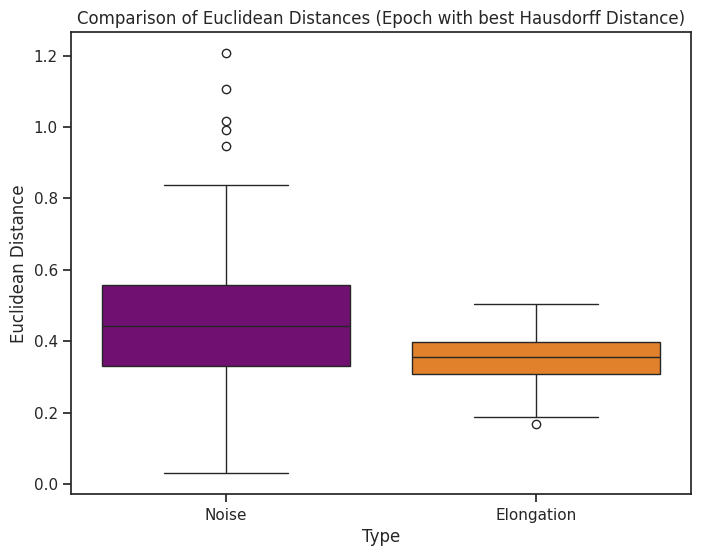

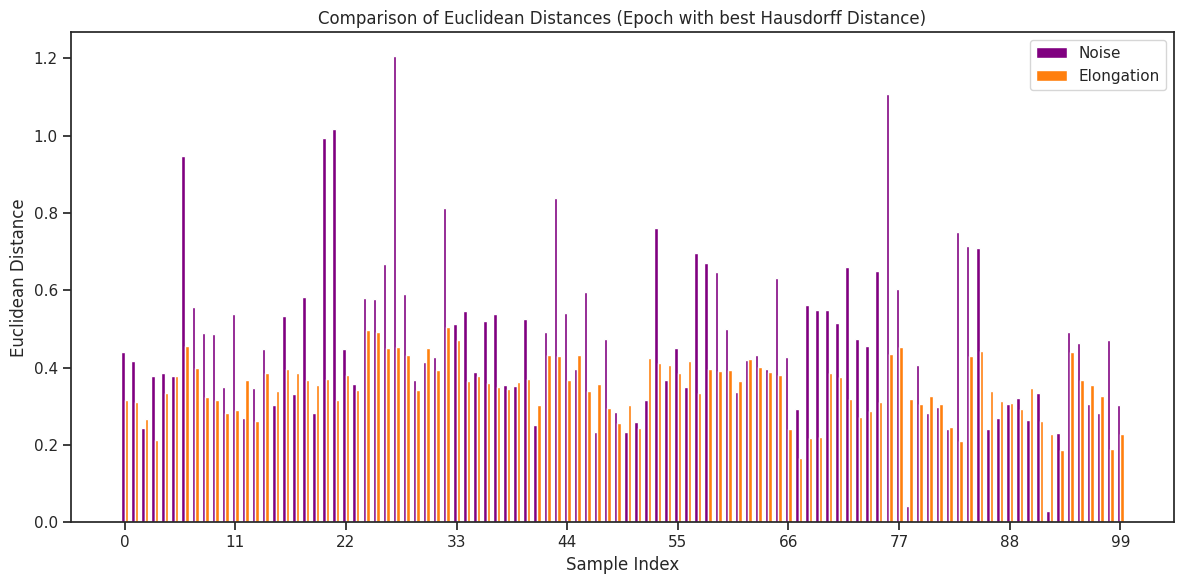

In [150]:
euclidean_distances_noise_Hausdorff = np.linalg.norm(best_val_latent_vectors_hausdorff - val_latent_vectors_noise, axis=1)
euclidean_distances_elongated_Hausdorff = np.linalg.norm(best_val_latent_vectors_hausdorff - val_latent_vectors_elongated, axis=1)

df = pd.DataFrame({
    'Distance': list(euclidean_distances_noise_Hausdorff) + list(euclidean_distances_elongated_Hausdorff),
    'Type': ['Noise'] * len(euclidean_distances_noise_Hausdorff) + ['Elongation'] * len(euclidean_distances_elongated_Hausdorff)
})

palette = {"Noise": "#800080", "Elongation": "#ff7f0e"}

plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Distance', data=df, palette=palette)
plt.title("Comparison of Euclidean Distances (Epoch with best Hausdorff Distance)")
plt.ylabel("Euclidean Distance")
plt.show()

x = np.arange(len(euclidean_distances_noise_Hausdorff))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, euclidean_distances_noise_Hausdorff, width, label='Noise', color=palette['Noise'])
rects2 = ax.bar(x + width/2, euclidean_distances_elongated_Hausdorff, width, label='Elongation', color=palette['Elongation'])

ax.set_xlabel('Sample Index')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Comparison of Euclidean Distances (Epoch with best Hausdorff Distance)')
ax.legend()
ax.set_xticks(np.linspace(0, len(x) - 1, num=10, dtype=int))  
ax.set_xticklabels(np.linspace(0, len(x) - 1, num=10, dtype=int))
plt.tight_layout()
plt.show()

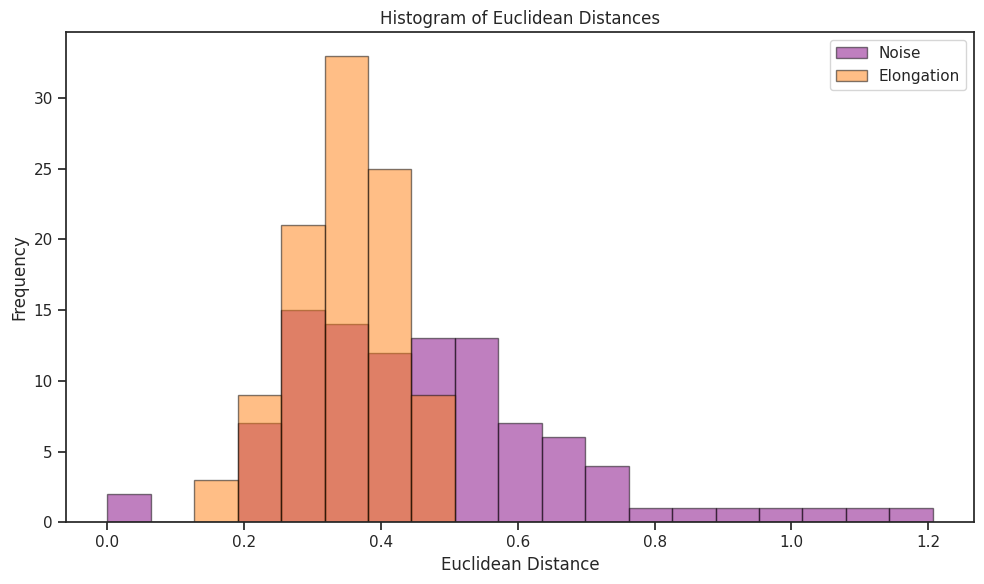

In [151]:
bins_Hausdorff = np.linspace(0, max(np.max(euclidean_distances_noise_Hausdorff), np.max(euclidean_distances_elongated_Hausdorff)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_noise_Hausdorff, bins=bins_Hausdorff, alpha=0.5, label='Noise', color='#800080', edgecolor='black') 
plt.hist(euclidean_distances_elongated_Hausdorff, bins=bins_Hausdorff, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black')

plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances')
plt.legend()
plt.tight_layout()
plt.show()

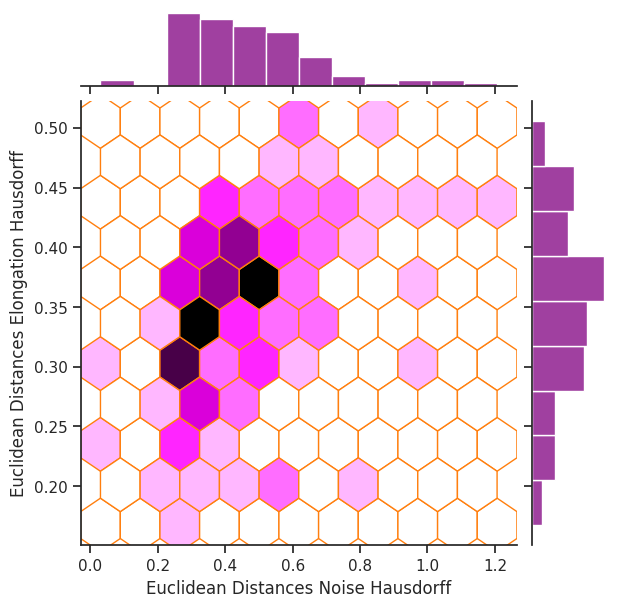

In [152]:
x_Hausdorff = euclidean_distances_noise_Hausdorff
y_Hausdorff = euclidean_distances_elongated_Hausdorff

sns.set_theme(style="ticks")

g = sns.jointplot(x=x_Hausdorff, y=y_Hausdorff, kind="hex", color="#800080") 
g.ax_joint.collections[0].set_edgecolor("#ff7f0e")
plt.xlabel('Euclidean Distances Noise Hausdorff')
plt.ylabel('Euclidean Distances Elongation Hausdorff')
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



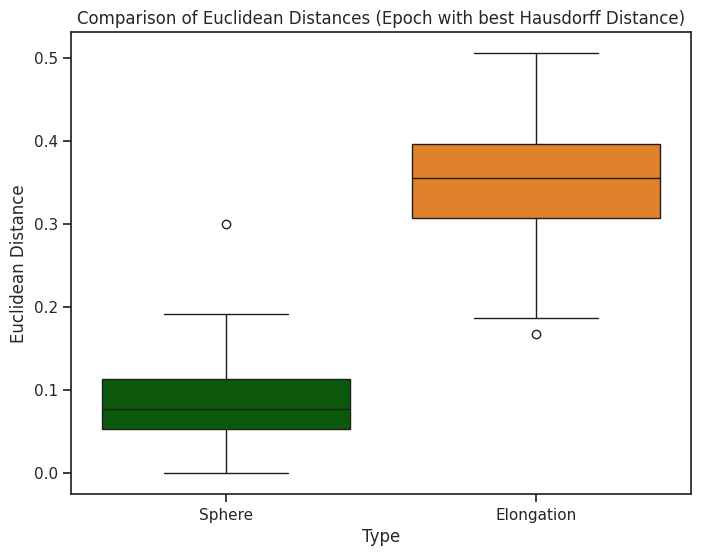

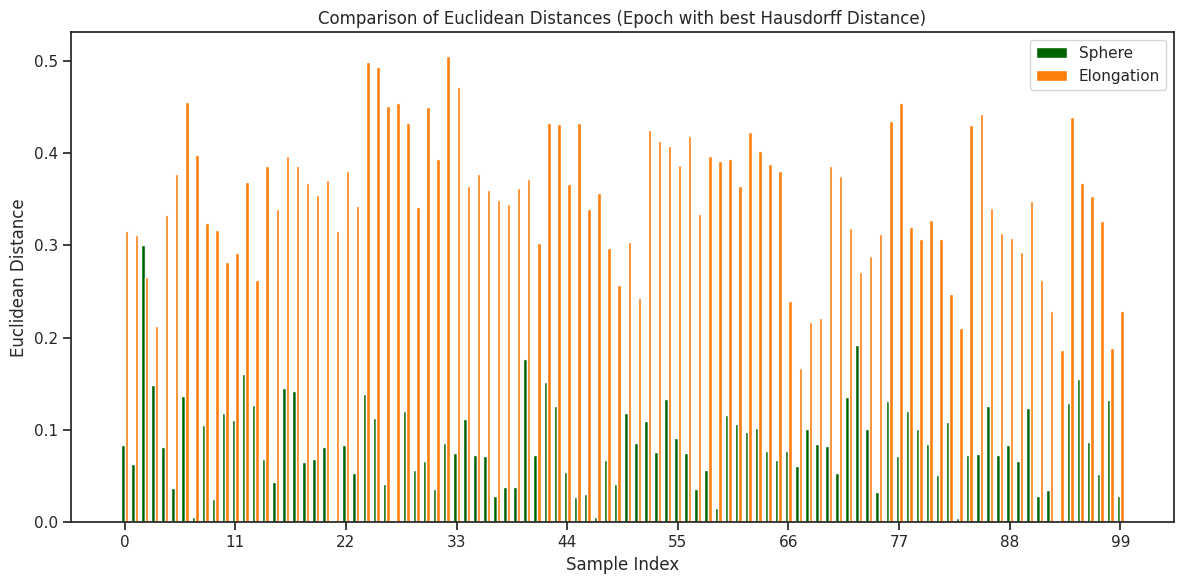

In [153]:
euclidean_distances_sphere_Hausdorff = np.linalg.norm(best_val_latent_vectors_hausdorff - val_latent_vectors_sphere, axis=1)
euclidean_distances_elongated_Hausdorff = np.linalg.norm(best_val_latent_vectors_hausdorff - val_latent_vectors_elongated, axis=1)

df = pd.DataFrame({
    'Distance': list(euclidean_distances_sphere_Hausdorff) + list(euclidean_distances_elongated_Hausdorff),
    'Type': ['Sphere'] * len(euclidean_distances_sphere_Hausdorff) + ['Elongation'] * len(euclidean_distances_elongated_Hausdorff)
})

palette = {"Sphere": "#006400", "Elongation": "#ff7f0e"}

plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Distance', data=df, palette=palette)
plt.title("Comparison of Euclidean Distances (Epoch with best Hausdorff Distance)")
plt.ylabel("Euclidean Distance")
plt.show()

x = np.arange(len(euclidean_distances_sphere_Hausdorff))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, euclidean_distances_sphere_Hausdorff, width, label='Sphere', color=palette['Sphere'])
rects2 = ax.bar(x + width/2, euclidean_distances_elongated_Hausdorff, width, label='Elongation', color=palette['Elongation'])

ax.set_xlabel('Sample Index')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Comparison of Euclidean Distances (Epoch with best Hausdorff Distance)')
ax.legend()
ax.set_xticks(np.linspace(0, len(x) - 1, num=10, dtype=int))  
ax.set_xticklabels(np.linspace(0, len(x) - 1, num=10, dtype=int))
plt.tight_layout()
plt.show()

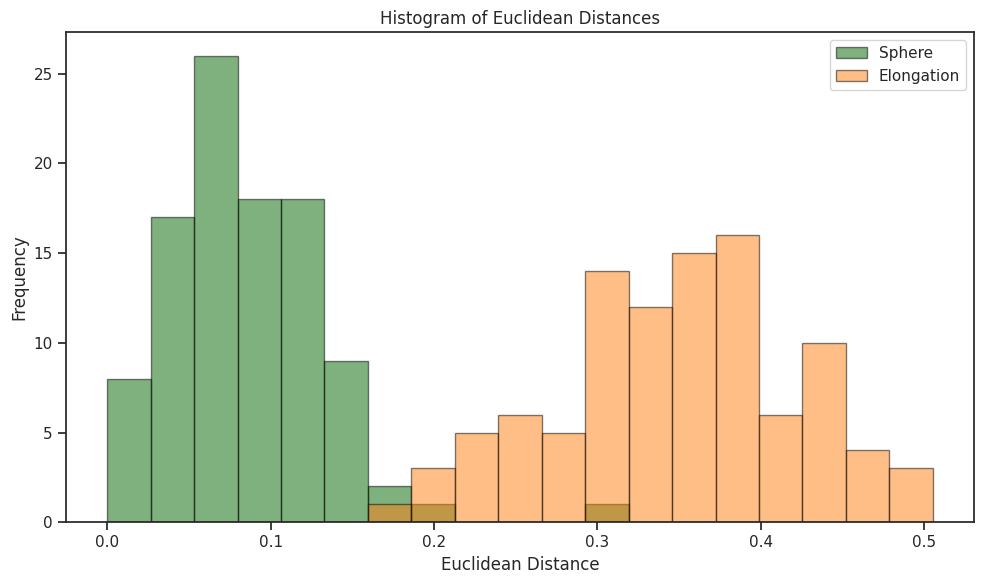

In [154]:
bins_Hausdorff = np.linspace(0, max(np.max(euclidean_distances_sphere_Hausdorff), np.max(euclidean_distances_elongated_Hausdorff)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_sphere_Hausdorff, bins=bins_Hausdorff, alpha=0.5, label='Sphere', color='#006400', edgecolor='black') 
plt.hist(euclidean_distances_elongated_Hausdorff, bins=bins_Hausdorff, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black') 
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances')
plt.legend()
plt.tight_layout()
plt.show()

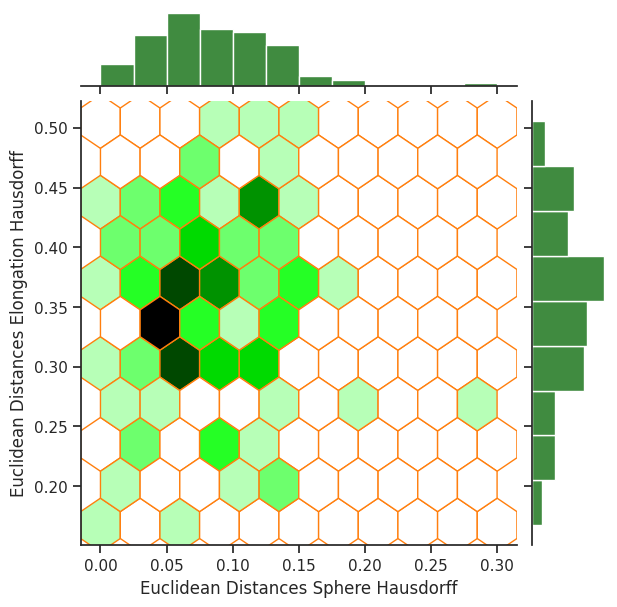

In [155]:
x_Hausdorff = euclidean_distances_sphere_Hausdorff
y_Hausdorff = euclidean_distances_elongated_Hausdorff

sns.set_theme(style="ticks")
g = sns.jointplot(x=x_Hausdorff, y=y_Hausdorff, kind="hex", color="#006400")
g.ax_joint.collections[0].set_edgecolor("#ff7f0e") 
plt.xlabel('Euclidean Distances Sphere Hausdorff')
plt.ylabel('Euclidean Distances Elongation Hausdorff')
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



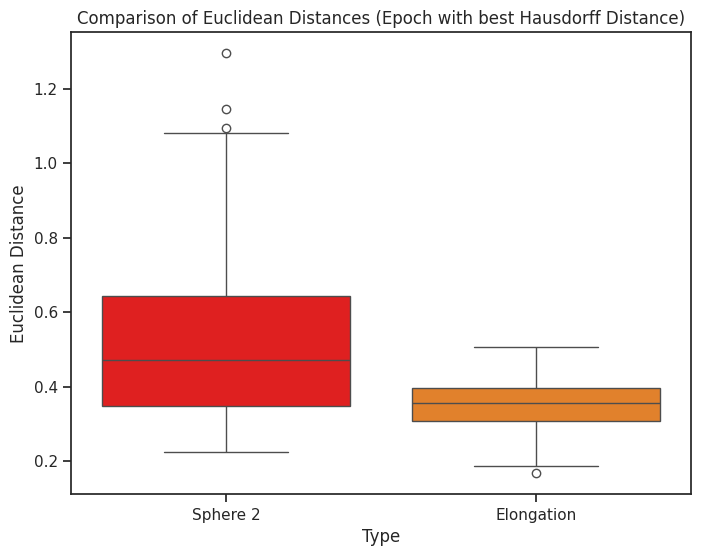

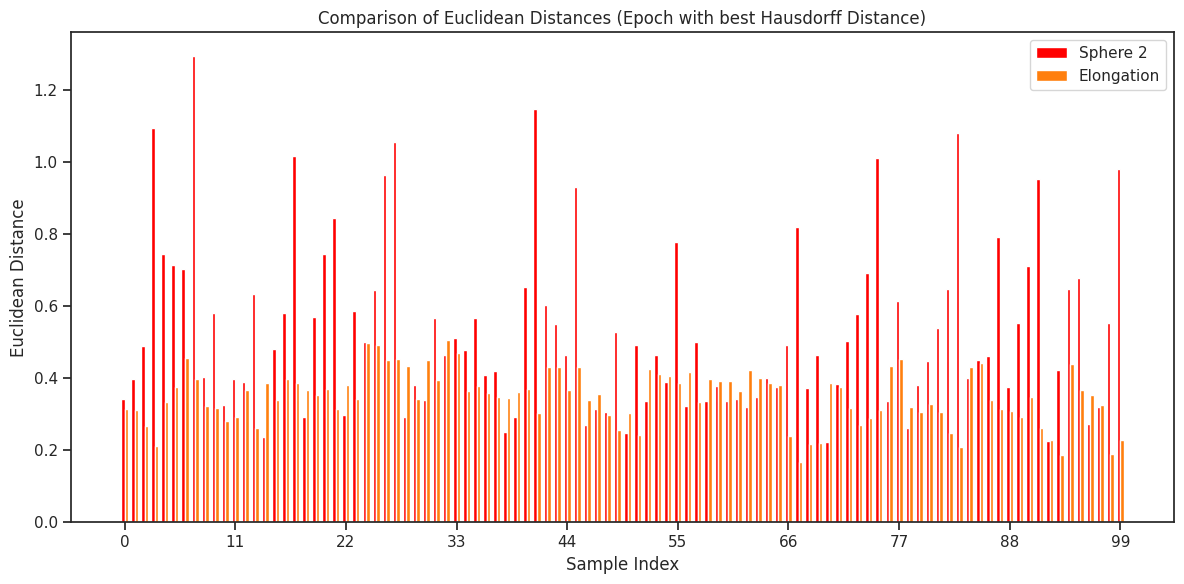

In [156]:
euclidean_distances_sphere_2_Hausdorff = np.linalg.norm(best_val_latent_vectors_hausdorff - val_latent_vectors_sphere_2, axis=1)
euclidean_distances_elongated_Hausdorff = np.linalg.norm(best_val_latent_vectors_hausdorff - val_latent_vectors_elongated, axis=1)

df = pd.DataFrame({
    'Distance': list(euclidean_distances_sphere_2_Hausdorff) + list(euclidean_distances_elongated_Hausdorff),
    'Type': ['Sphere 2'] * len(euclidean_distances_sphere_2_Hausdorff) + ['Elongation'] * len(euclidean_distances_elongated_Hausdorff)
})

palette = {"Sphere 2": "#FF0000", "Elongation": "#ff7f0e"} 

plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Distance', data=df, palette=palette)
plt.title("Comparison of Euclidean Distances (Epoch with best Hausdorff Distance)")
plt.ylabel("Euclidean Distance")
plt.show()

x = np.arange(len(euclidean_distances_sphere_2_Hausdorff))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, euclidean_distances_sphere_2_Hausdorff, width, label='Sphere 2', color=palette['Sphere 2'])
rects2 = ax.bar(x + width/2, euclidean_distances_elongated_Hausdorff, width, label='Elongation', color=palette['Elongation'])
ax.set_xlabel('Sample Index')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Comparison of Euclidean Distances (Epoch with best Hausdorff Distance)')
ax.legend()
ax.set_xticks(np.linspace(0, len(x) - 1, num=10, dtype=int))  
ax.set_xticklabels(np.linspace(0, len(x) - 1, num=10, dtype=int))
plt.tight_layout()
plt.show()

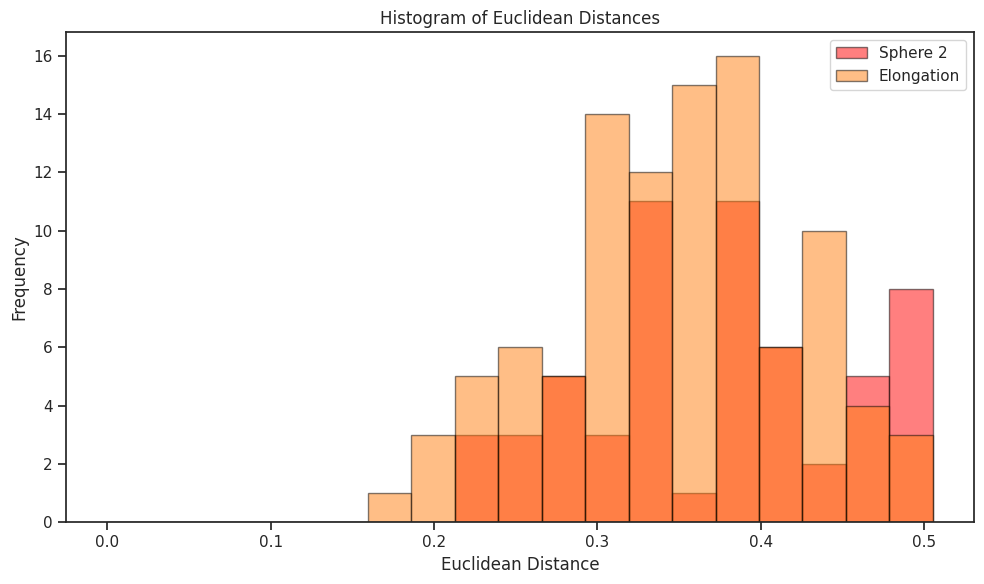

In [157]:
bins_mse = np.linspace(0, max(np.max(euclidean_distances_sphere_2_Hausdorff), np.max(euclidean_distances_elongated_Hausdorff)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_sphere_2_Hausdorff, bins=bins_Hausdorff, alpha=0.5, label='Sphere 2', color='#FF0000', edgecolor='black') 
plt.hist(euclidean_distances_elongated_Hausdorff, bins=bins_Hausdorff, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black')
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances')
plt.legend()
plt.tight_layout()
plt.show()

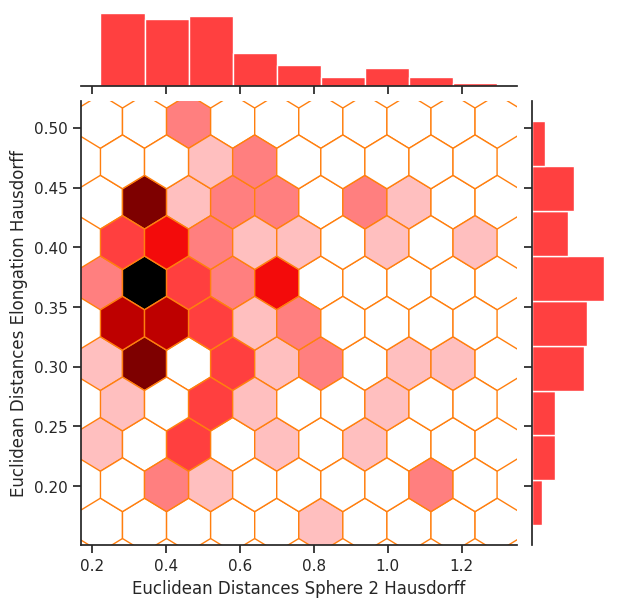

In [158]:
x_Hausdorff = euclidean_distances_sphere_2_Hausdorff
y_Hausdorff = euclidean_distances_elongated_Hausdorff

sns.set_theme(style="ticks")

g = sns.jointplot(x=x_Hausdorff, y=y_Hausdorff, kind="hex", color="#FF0000") 
g.ax_joint.collections[0].set_edgecolor("#ff7f0e") 

plt.xlabel('Euclidean Distances Sphere 2 Hausdorff')
plt.ylabel('Euclidean Distances Elongation Hausdorff')
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



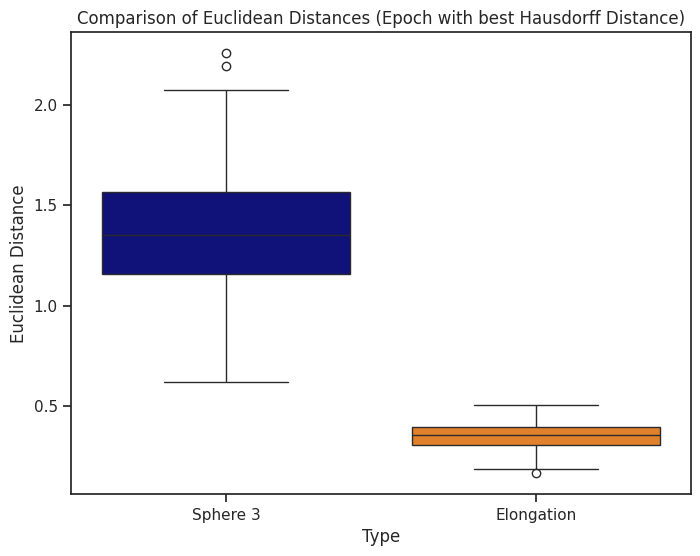

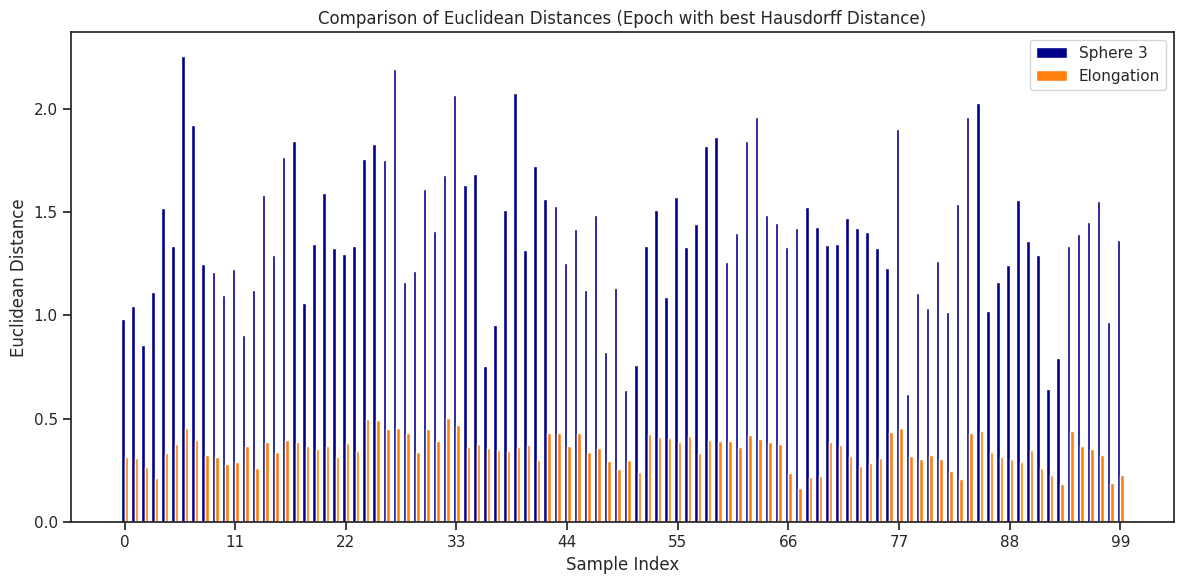

In [159]:
euclidean_distances_sphere_3_Hausdorff = np.linalg.norm(best_val_latent_vectors_hausdorff - val_latent_vectors_sphere_3, axis=1)
euclidean_distances_elongated_Hausdorff = np.linalg.norm(best_val_latent_vectors_hausdorff - val_latent_vectors_elongated, axis=1)

df = pd.DataFrame({
    'Distance': list(euclidean_distances_sphere_3_Hausdorff) + list(euclidean_distances_elongated_Hausdorff),
    'Type': ['Sphere 3'] * len(euclidean_distances_sphere_3_Hausdorff) + ['Elongation'] * len(euclidean_distances_elongated_Hausdorff)
})

palette = {"Sphere 3": "#00008B", "Elongation": "#ff7f0e"}

plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Distance', data=df, palette=palette)
plt.title("Comparison of Euclidean Distances (Epoch with best Hausdorff Distance)")
plt.ylabel("Euclidean Distance")
plt.show()

x = np.arange(len(euclidean_distances_sphere_3_Hausdorff))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, euclidean_distances_sphere_3_Hausdorff, width, label='Sphere 3', color=palette['Sphere 3'])
rects2 = ax.bar(x + width/2, euclidean_distances_elongated_Hausdorff, width, label='Elongation', color=palette['Elongation'])
ax.set_xlabel('Sample Index')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Comparison of Euclidean Distances (Epoch with best Hausdorff Distance)')
ax.legend()
ax.set_xticks(np.linspace(0, len(x) - 1, num=10, dtype=int))  
ax.set_xticklabels(np.linspace(0, len(x) - 1, num=10, dtype=int))
plt.tight_layout()
plt.show()

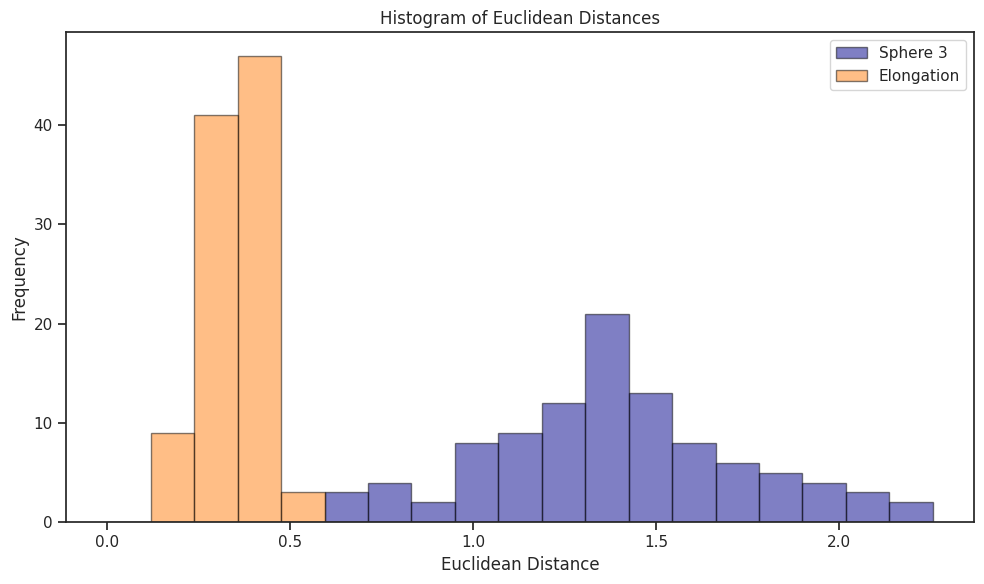

In [160]:
bins_Hausdorff = np.linspace(0, max(np.max(euclidean_distances_sphere_3_Hausdorff), np.max(euclidean_distances_elongated_Hausdorff)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_sphere_3_Hausdorff, bins=bins_Hausdorff, alpha=0.5, label='Sphere 3', color='#00008B', edgecolor='black')  # Morado
plt.hist(euclidean_distances_elongated_Hausdorff, bins=bins_Hausdorff, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black')  # Naranja

plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances')
plt.legend()

plt.tight_layout()
plt.show()

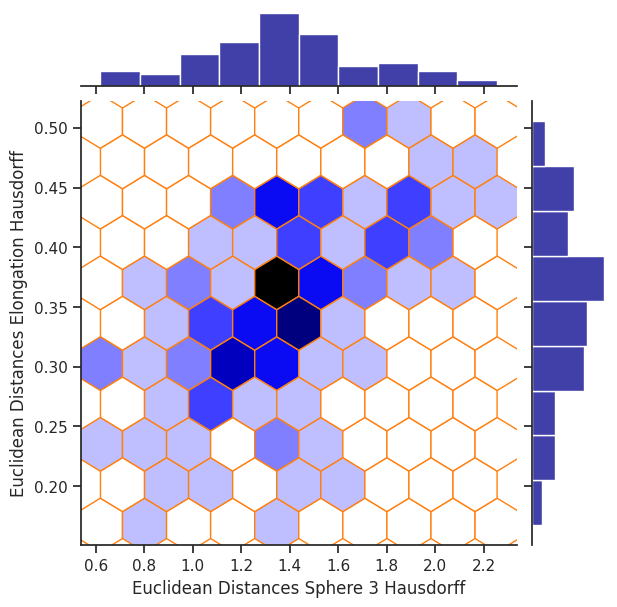

In [161]:
x_Hausdorff = euclidean_distances_sphere_3_Hausdorff
y_Hausdorff = euclidean_distances_elongated_Hausdorff

sns.set_theme(style="ticks")
g = sns.jointplot(x=x_Hausdorff, y=y_Hausdorff, kind="hex", color="#00008B") 
g.ax_joint.collections[0].set_edgecolor("#ff7f0e")
plt.xlabel('Euclidean Distances Sphere 3 Hausdorff')
plt.ylabel('Euclidean Distances Elongation Hausdorff')
plt.show()

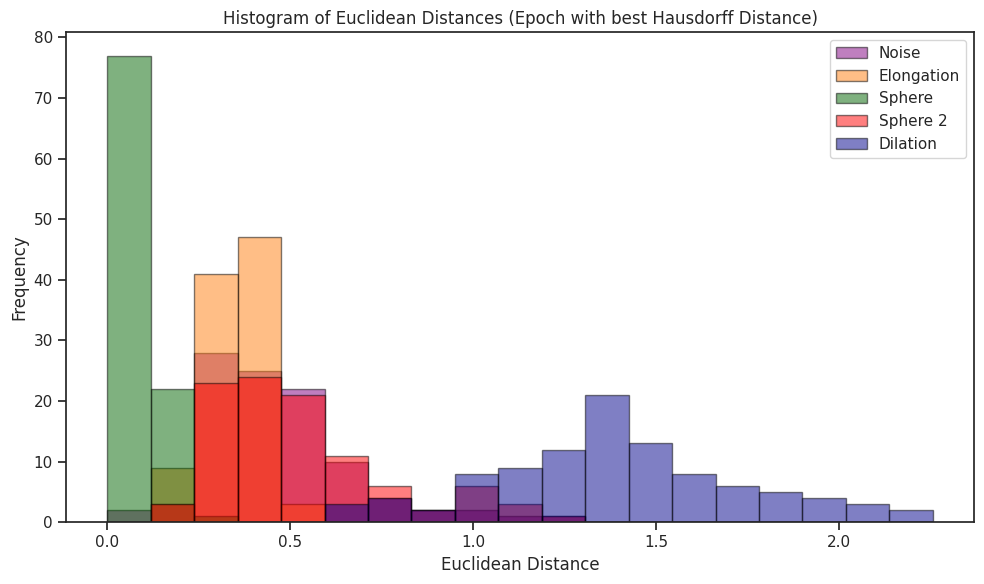

In [162]:
bins = np.linspace(0, max(np.max(euclidean_distances_noise_Hausdorff), 
                          np.max(euclidean_distances_elongated_Hausdorff), 
                          np.max(euclidean_distances_sphere_Hausdorff), 
                          np.max(euclidean_distances_sphere_2_Hausdorff), 
                          np.max(euclidean_distances_sphere_3_Hausdorff)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_noise_Hausdorff, bins=bins, alpha=0.5, label='Noise', color='#800080', edgecolor='black')  # Morado
plt.hist(euclidean_distances_elongated_Hausdorff, bins=bins, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black')  # Naranja
plt.hist(euclidean_distances_sphere_Hausdorff, bins=bins, alpha=0.5, label='Sphere', color='#006400', edgecolor='black')  # Verde oscuro
plt.hist(euclidean_distances_sphere_2_Hausdorff, bins=bins, alpha=0.5, label='Sphere 2', color='#FF0000', edgecolor='black')  # Rosa
plt.hist(euclidean_distances_sphere_3_Hausdorff, bins=bins, alpha=0.5, label='Dilation', color='#00008B', edgecolor='black')  # Gris
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances (Epoch with best Hausdorff Distance)')
plt.legend()
plt.tight_layout()
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



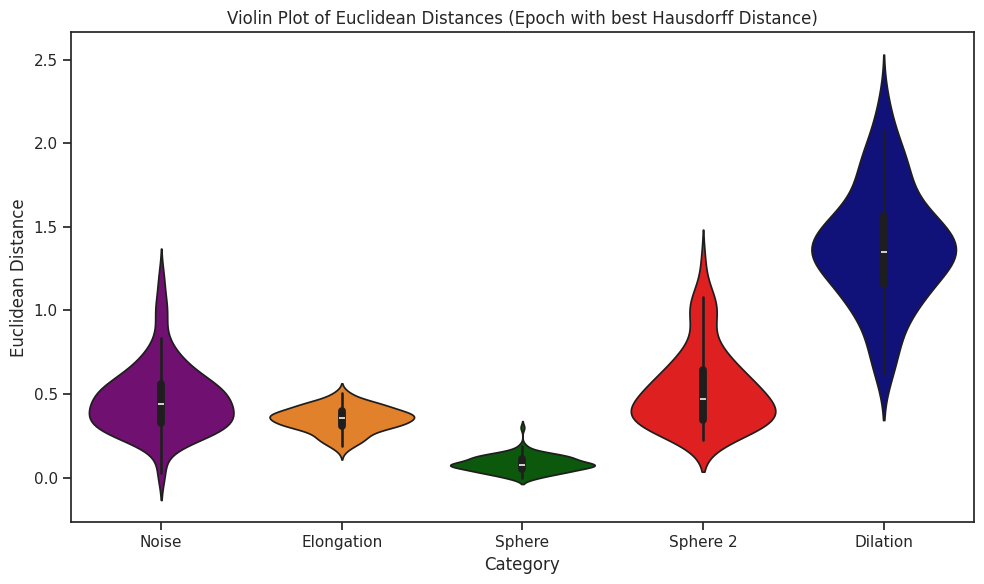

In [163]:
data = {
    'Distance': np.concatenate([euclidean_distances_noise_Hausdorff, 
                                euclidean_distances_elongated_Hausdorff, 
                                euclidean_distances_sphere_Hausdorff, 
                                euclidean_distances_sphere_2_Hausdorff, 
                                euclidean_distances_sphere_3_Hausdorff]),
    'Category': ['Noise'] * len(euclidean_distances_noise_Hausdorff) + 
                ['Elongation'] * len(euclidean_distances_elongated_Hausdorff) + 
                ['Sphere'] * len(euclidean_distances_sphere_Hausdorff) + 
                ['Sphere 2'] * len(euclidean_distances_sphere_2_Hausdorff) + 
                ['Dilation'] * len(euclidean_distances_sphere_3_Hausdorff)
}

df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.violinplot(x='Category', y='Distance', data=df, palette={
    'Noise': '#800080', 
    'Elongation': '#ff7f0e', 
    'Sphere': '#006400', 
    'Sphere 2': '#FF0000', 
    'Dilation': '#00008B'
})

plt.xlabel('Category')
plt.ylabel('Euclidean Distance')
plt.title('Violin Plot of Euclidean Distances (Epoch with best Hausdorff Distance)')
plt.tight_layout()
plt.show()

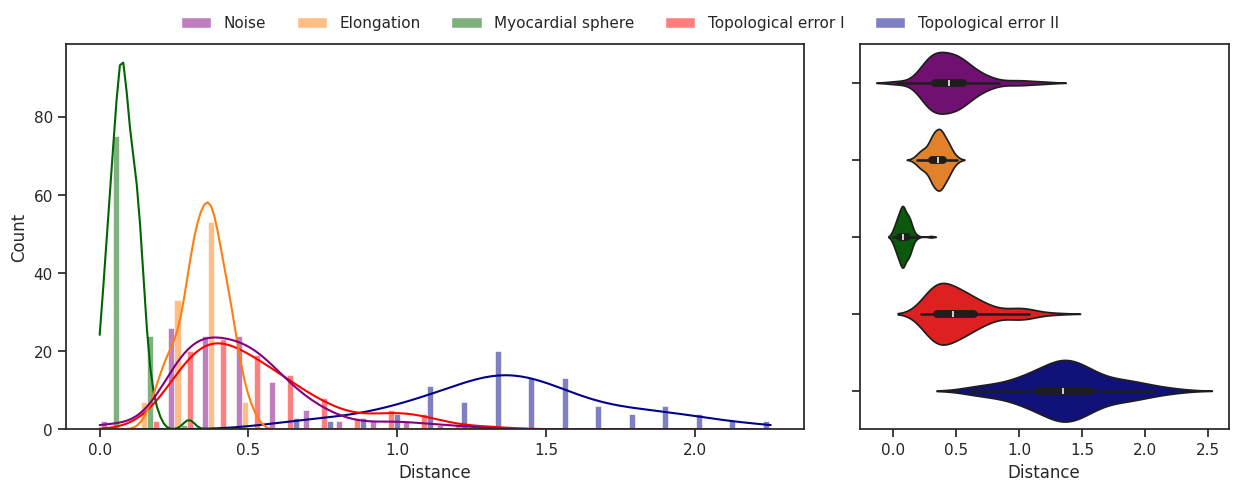

In [164]:
# COMPARISON LAST EPOCH

data = {
    'Distance': np.concatenate([
        euclidean_distances_noise, 
        euclidean_distances_elongated, 
        euclidean_distances_sphere, 
        euclidean_distances_sphere_2, 
        euclidean_distances_sphere_3
    ]),
    'Category': ['Noise'] * len(euclidean_distances_noise) + 
                ['Elongation'] * len(euclidean_distances_elongated) + 
                ['Myocardial sphere'] * len(euclidean_distances_sphere) + 
                ['Topological error I'] * len(euclidean_distances_sphere_2) + 
                ['Topological error II'] * len(euclidean_distances_sphere_3)
}

df = pd.DataFrame(data)

palette = {
    'Noise': '#800080',      
    'Elongation': '#ff7f0e',  
    'Myocardial sphere': '#006400',      
    'Topological error I': '#FF0000',  
    'Topological error II': '#00008B'   
}

fig, axes = plt.subplots(1, 2, figsize=(15, 5), width_ratios=[2, 1])

# Histograma
sns.histplot(data=df, x='Distance', hue='Category', multiple='dodge', shrink=0.9, kde=True, palette=palette, ax=axes[0])
sns.move_legend(
    axes[0], "lower center",
    bbox_to_anchor=(0.75, 1), ncol=5, title=None, frameon=False,
)

# Gráfico de violín
sns.violinplot(data=df, y='Category', x='Distance', hue='Category', palette=palette, ax=axes[1])
axes[1].set_ylabel(None)
axes[1].set_yticklabels([])

plt.subplots_adjust(wspace=0.1)
plt.show()

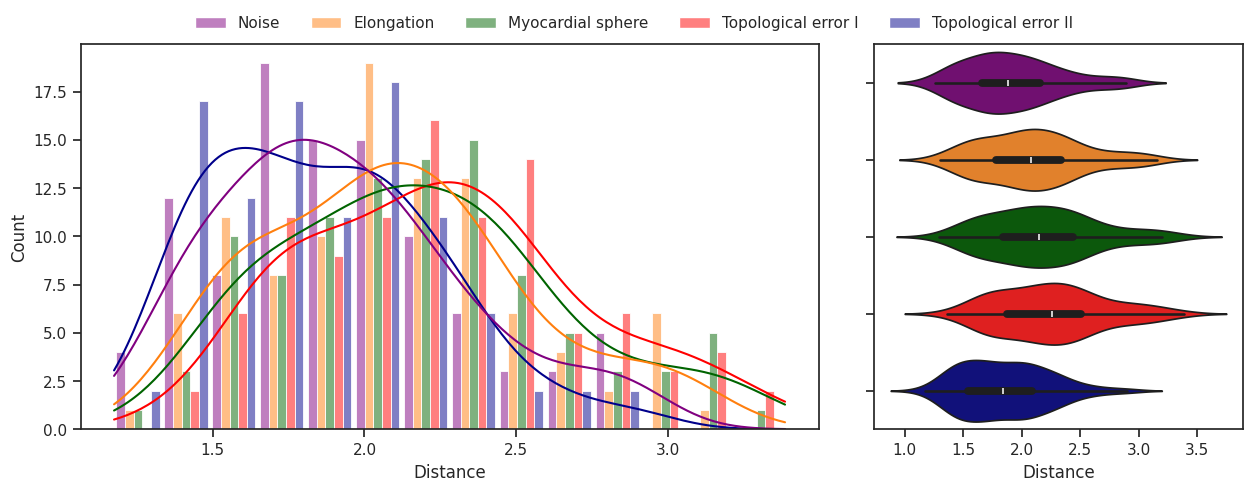

In [165]:
# COMPARISON EPOCH WITH BEST DICE

data = {
    'Distance': np.concatenate([
        euclidean_distances_noise_dice, 
        euclidean_distances_elongated_dice, 
        euclidean_distances_sphere_dice, 
        euclidean_distances_sphere_2_dice, 
        euclidean_distances_sphere_3_dice
    ]),
    'Category': ['Noise'] * len(euclidean_distances_noise_dice) + 
                ['Elongation'] * len(euclidean_distances_elongated_dice) + 
                ['Myocardial sphere'] * len(euclidean_distances_sphere_3_dice) + 
                ['Topological error I'] * len(euclidean_distances_sphere_2_dice) + 
                ['Topological error II'] * len(euclidean_distances_sphere_3_dice)
}

df = pd.DataFrame(data)
palette = {
    'Noise': '#800080',      
    'Elongation': '#ff7f0e',  
    'Myocardial sphere': '#006400',      
    'Topological error I': '#FF0000',  
    'Topological error II': '#00008B'   
}

fig, axes = plt.subplots(1, 2, figsize=(15, 5), width_ratios=[2, 1])

# Histograma
sns.histplot(data=df, x='Distance', hue='Category', multiple='dodge', shrink=0.9, kde=True, palette=palette, ax=axes[0])
sns.move_legend(
    axes[0], "lower center",
    bbox_to_anchor=(0.75, 1), ncol=5, title=None, frameon=False,
)

# Gráfico de violín
sns.violinplot(data=df, y='Category', x='Distance', hue='Category', palette=palette, ax=axes[1])
axes[1].set_ylabel(None)
axes[1].set_yticklabels([])

plt.subplots_adjust(wspace=0.1)
plt.show()

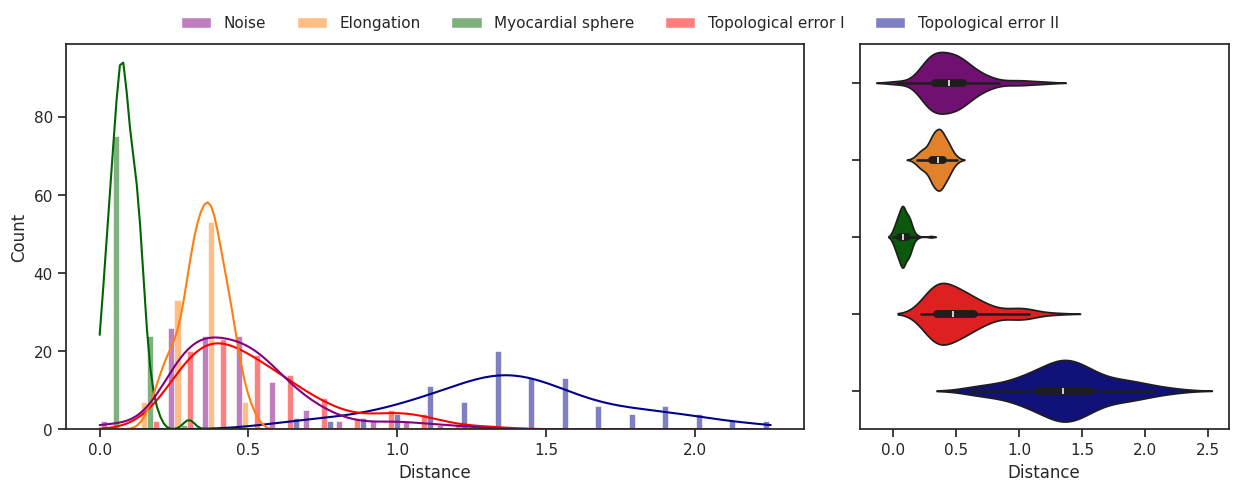

In [166]:
# COMPARISON EPOCH WITH BEST HAUSDORFF DISTANCE

data = {
    'Distance': np.concatenate([
        euclidean_distances_noise_Hausdorff, 
        euclidean_distances_elongated_Hausdorff, 
        euclidean_distances_sphere_Hausdorff, 
        euclidean_distances_sphere_2_Hausdorff, 
        euclidean_distances_sphere_3_Hausdorff
    ]),
    'Category': ['Noise'] * len(euclidean_distances_noise_Hausdorff) + 
                ['Elongation'] * len(euclidean_distances_elongated_Hausdorff) + 
                ['Myocardial sphere'] * len(euclidean_distances_sphere_Hausdorff) + 
                ['Topological error I'] * len(euclidean_distances_sphere_2_Hausdorff) + 
                ['Topological error II'] * len(euclidean_distances_sphere_3_Hausdorff)
}

df = pd.DataFrame(data)

palette = {
    'Noise': '#800080',      
    'Elongation': '#ff7f0e',  
    'Myocardial sphere': '#006400',      
    'Topological error I': '#FF0000',  
    'Topological error II': '#00008B'   
}

fig, axes = plt.subplots(1, 2, figsize=(15, 5), width_ratios=[2, 1])

# Histograma
sns.histplot(data=df, x='Distance', hue='Category', multiple='dodge', shrink=0.9, kde=True, palette=palette, ax=axes[0])
sns.move_legend(
    axes[0], "lower center",
    bbox_to_anchor=(0.75, 1), ncol=5, title=None, frameon=False,
)

# Gráfico de violín
sns.violinplot(data=df, y='Category', x='Distance', hue='Category', palette=palette, ax=axes[1])
axes[1].set_ylabel(None)
axes[1].set_yticklabels([])

plt.subplots_adjust(wspace=0.1)
plt.show()

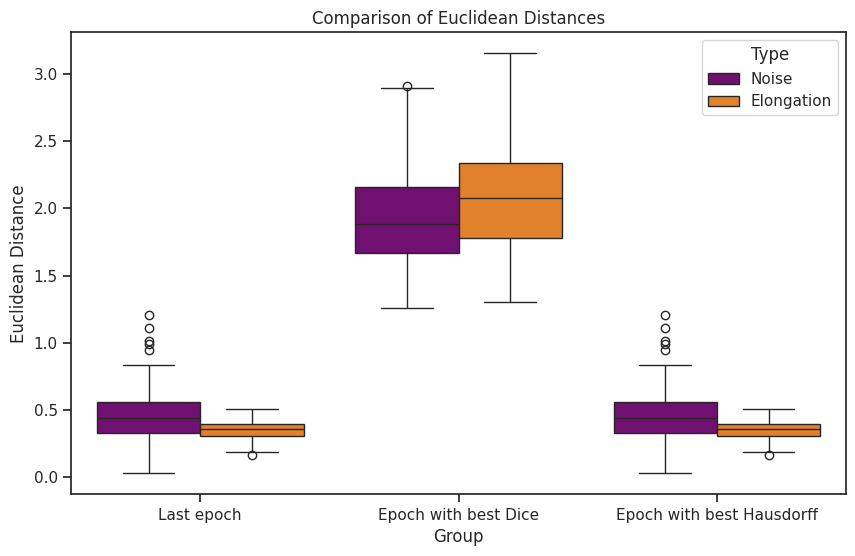

In [167]:
distances_noise_1 = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_noise, axis=1)
distances_elongation_1 = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_elongated, axis=1)

distances_noise_2 = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_noise, axis=1)
distances_elongation_2 = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_elongated, axis=1)

distances_noise_3 = np.linalg.norm(best_val_latent_vectors_hausdorff - val_latent_vectors_noise, axis=1)
distances_elongation_3 = np.linalg.norm(best_val_latent_vectors_hausdorff - val_latent_vectors_elongated, axis=1)

df = pd.DataFrame({
    'Distance': (
        list(distances_noise_1) + list(distances_elongation_1) +
        list(distances_noise_2) + list(distances_elongation_2) +
        list(distances_noise_3) + list(distances_elongation_3)
    ),
    'Type': (
        ['Noise'] * len(distances_noise_1) + ['Elongation'] * len(distances_elongation_1) +
        ['Noise'] * len(distances_noise_2) + ['Elongation'] * len(distances_elongation_2) +
        ['Noise'] * len(distances_noise_3) + ['Elongation'] * len(distances_elongation_3)
    ),
    'Group': (
        ['Last epoch'] * (len(distances_noise_1) + len(distances_elongation_1)) +
        ['Epoch with best Dice'] * (len(distances_noise_2) + len(distances_elongation_2)) +
        ['Epoch with best Hausdorff'] * (len(distances_noise_3) + len(distances_elongation_3))
    )
})

palette = {"Noise": "#800080", "Elongation": "#ff7f0e"}

plt.figure(figsize=(10, 6))
sns.boxplot(x='Group', y='Distance', hue='Type', data=df, palette=palette)
plt.title("Comparison of Euclidean Distances")
plt.ylabel("Euclidean Distance")
plt.show()

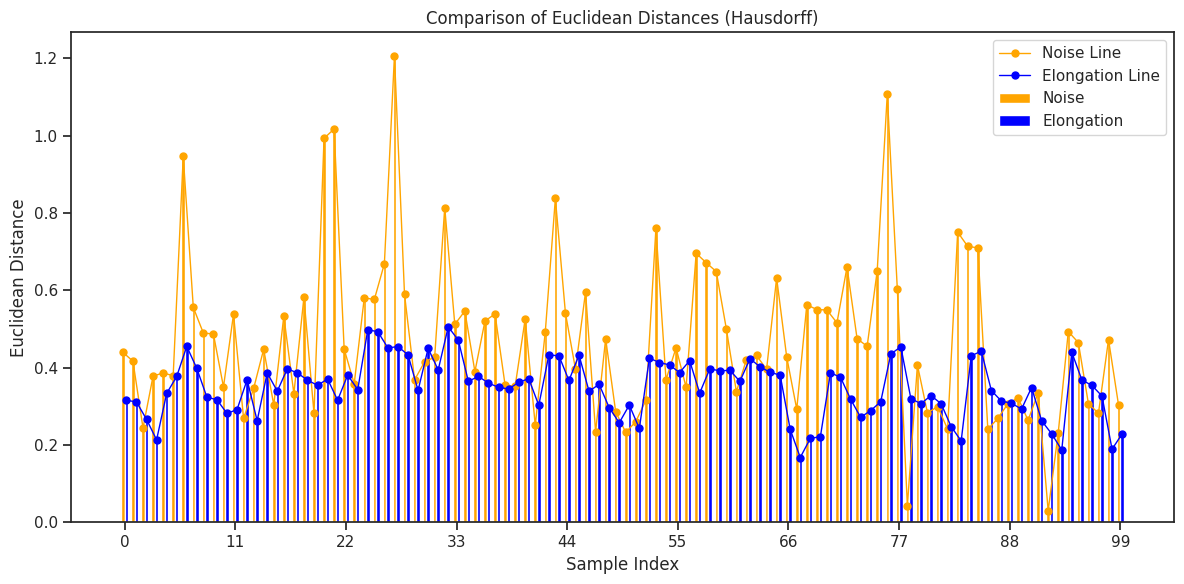

In [168]:
euclidean_distances_noise_Hausdorff = np.linalg.norm(best_val_latent_vectors_hausdorff - val_latent_vectors_noise, axis=1)
euclidean_distances_elongated_Hausdorff = np.linalg.norm(best_val_latent_vectors_hausdorff - val_latent_vectors_elongated, axis=1)

x = np.arange(len(euclidean_distances_noise_Hausdorff))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

rects1 = ax.bar(x - width/2, euclidean_distances_noise_Hausdorff, width, label='Noise', color='orange')
rects2 = ax.bar(x + width/2, euclidean_distances_elongated_Hausdorff, width, label='Elongation', color='blue')

ax.plot(x - width/2, euclidean_distances_noise_Hausdorff, color='orange', linewidth=1, marker='o', markersize=5, label='Noise Line')
ax.plot(x + width/2, euclidean_distances_elongated_Hausdorff, color='blue', linewidth=1, marker='o', markersize=5, label='Elongation Line')

ax.set_xlabel('Sample Index')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Comparison of Euclidean Distances (Hausdorff)')
ax.legend()

ax.set_xticks(np.linspace(0, len(x) - 1, num=10, dtype=int))
ax.set_xticklabels(np.linspace(0, len(x) - 1, num=10, dtype=int))

plt.tight_layout()
plt.show()

Files TSV

In [148]:
# train_latent_vectors_array = np.concatenate((best_train_latent_vectors, train_latent_vectors_noise), axis=0)
# val_latent_vectors_array = np.concatenate((best_val_latent_vectors, val_latent_vectors_noise), axis=0)

# print(f"Shape of train_latent_vectors_array: {train_latent_vectors_array.shape}")
# print(f"Shape of val_latent_vectors_array: {val_latent_vectors_array.shape}")

# if len(train_latent_vectors_array.shape) == 1:
#     train_latent_vectors_array = train_latent_vectors_array.reshape(-1, 1)
# if len(val_latent_vectors_array.shape) == 1:
#     val_latent_vectors_array = val_latent_vectors_array.reshape(-1, 1)

# output_dir = '/mnt/nfs/home/liglesias'
# np.savetxt(os.path.join(output_dir, 'train_latent_vectors.tsv'), train_latent_vectors_array, delimiter='\t')
# np.savetxt(os.path.join(output_dir, 'val_latent_vectors.tsv'), val_latent_vectors_array, delimiter='\t')

# print(f"Vectores latentes guardados en {output_dir}")

In [149]:
# import os
# import pandas as pd

# output_dir = '/mnt/nfs/home/liglesias'
# val_latent_vectors_df = pd.read_csv(os.path.join(output_dir, 'val_latent_vectors.tsv'), sep='\t', header=None)
# print(f"Shape of val_latent_vectors_df: {val_latent_vectors_df.shape}")

# val_latent_vectors_original_df = val_latent_vectors_df.iloc[:100]
# val_latent_vectors_noise_df = val_latent_vectors_df.iloc[-100:]

# num_original = len(val_latent_vectors_original_df)
# num_noise = len(val_latent_vectors_noise_df)

# metadata = {
#     'ID': list(range(1, num_original + num_noise + 1)),
#     'Type': ['Original'] * num_original + ['Noise'] * num_noise
# }
# metadata_df = pd.DataFrame(metadata)

# metadata_df.to_csv(os.path.join(output_dir, 'metadata.tsv'), sep='\t', index=False)

# print(f"Archivo de metadatos guardado en {output_dir}/metadata.tsv")